## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import GCNConv, Sequential as GraphSequential
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics
from rdkit import Chem
import matplotlib.pyplot as plt
from tqdm import tqdm

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/protein/protein_smiles_train.csv")
df_test = pd.read_csv("../../data/train/protein/protein_smiles_test.csv")
df_valid = pd.read_csv("../../data/train/protein/protein_smiles_valid.csv")
df_train_all = pd.concat([df_train, df_valid])

In [3]:
df_test

smiles  protein_plasma_binding
0    COc1ccc(-n2c(CCN3C(=O)c4cccc(-c5ccncc5)c4C3=O)...                    93.0
1            CN(c1cccc(C#N)c1)c1nccc(-c2cnn3ncccc23)n1                    96.0
2              Cc1cc(Oc2cncnc2)cc(C(=O)Nc2ccc(F)cn2)n1                    91.4
3                  CCC(=O)c1cc2c(Oc3ccc(Cl)cc3)cncc2s1                    99.9
4    CCNC(=O)Nc1ccc(-c2nc(N3CCOCC3C)c3c(n2)C(C)(CCO...                    86.0
..                                                 ...                     ...
528  Cc1c(NS(C)(=O)=O)cccc1N(Cc1ccc(Oc2ccc(F)c(OCC(...                    99.9
529    Cc1ccoc1C(=O)Nc1ccc(N2Cc3c(Cl)cccc3C2=O)c(Cl)c1                    99.0
530      CCC(CC)Nc1nc(C)c(-c2ccc(OC(F)(F)F)cc2OC)nc1OC                    99.2
531               Cc1ccc(S(=O)(=O)NC(=O)NN2CCCCCC2)cc1                    94.0
532  Cc1ccc(C(=O)NC2CC2)cc1-n1cnc2ccc(N3CCN(C)CC3)c...                    35.7

[533 rows x 2 columns]

In [4]:
df_valid

smiles  protein_plasma_binding
0    NC(=O)c1cccc(C2CC3CCC(C2)N3CCN(CC2CCCCC2)C(=O)...                   23.00
1    CC1c2ncn(-c3ccc(F)cc3)c2CCN1C(=O)c1cccc(C(F)(F...                   96.00
2    CCN1CCCC1CNC(=O)c1ccc2c(c1)NC(=O)C(=Cc1ccccc1F)S2                   98.39
3    CN1CCN(c2ccc(S(=O)(=O)NCc3ccc(C(=O)Nc4cccnc4)c...                   85.20
4    CC(C)c1cc(C(=O)N2Cc3ccc(CN4CCN(C)CC4)cc3C2)c(O...                   64.00
..                                                 ...                     ...
261  CC(Oc1cc2onc(CCC(=O)O)c2cc1Cl)c1ccccn1.NC(CO)(...                   97.80
262  CC(C)(C)C(=O)N1CCC(CN2CCC(NC(=O)Nc3cc(C(F)(F)F...                   99.00
263  C=CC(=O)NCc1coc(-c2c(N)ncnc2Nc2ccc(Oc3cc(C(F)(...                  100.00
264                      Cc1c(C(=O)Nc2ccccn2)ccc(F)c1F                   63.90
265  Cc1cc2ncc(C(=O)NCC(C)(C)NCC(=O)N3CCCC3C#N)cn2n...                   26.40

[266 rows x 2 columns]

## 3. Metrics

In [5]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 4. Featurizer 🧪

In [6]:
# Feauterizer from course "Machine Learning in Drug Design" at Jagiellonian University, Kraków, Poland.

class Featurizer:
    def __init__(self, y_column, **kwargs):
        self.y_column = y_column
        self.__dict__.update(kwargs)
    
    def __call__(self, df):
        raise NotImplementedError()

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise ValueError("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
        

class GraphFeaturizer(Featurizer):
    def __call__(self, df):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row.smiles
            mol = Chem.MolFromSmiles(smiles)
            
            edges = []
            for bond in mol.GetBonds():
                edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
                edges.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])
            edges = np.array(edges)
            
            nodes = []
            for atom in mol.GetAtoms():
                results = one_of_k_encoding_unk(
                    atom.GetSymbol(),
                    [
                        'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Unknown'
                    ]
                ) + one_of_k_encoding(
                    atom.GetDegree(),
                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                ) + one_of_k_encoding_unk(
                    atom.GetImplicitValence(),
                    [0, 1, 2, 3, 4, 5, 6]
                ) + [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + one_of_k_encoding_unk(
                    atom.GetHybridization(),
                    [
                        Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                        Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                        Chem.rdchem.HybridizationType.SP3D2
                    ]
                ) + [atom.GetIsAromatic()] + one_of_k_encoding_unk(
                    atom.GetTotalNumHs(),
                    [0, 1, 2, 3, 4]
                )
                nodes.append(results)
            nodes = np.array(nodes)
            
            graphs.append((nodes, edges.T))
            labels.append(y)
        labels = np.array(labels)
        return graphs, labels

## 5. Graph Dataset

In [7]:
class GraphDataset(InMemoryDataset):  
    def __init__(self, X, y, root, transform=None, pre_transform=None):
        self.dataset = (X, y)
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['data.pt']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        x_g, edge_index_g =list(zip(*self.dataset[0]))

        data = [Data(
            x=torch.FloatTensor(x),
            edge_index=torch.LongTensor(edge_index),
            y = y) for x, edge_index, y in zip(x_g,edge_index_g,self.dataset[1])
        ]

        torch.save(data, self.raw_paths[0])


    def process(self):
        data_list = torch.load(self.raw_paths[0])

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        


In [8]:
featurizer = GraphFeaturizer(y_column='protein_plasma_binding')

X_train, y_train = featurizer(df_train)
X_test, y_test = featurizer(df_test)
X_valid, y_valid = featurizer(df_valid)
X_train_all, y_train_all = featurizer(df_train_all)

In [9]:
train_dataset = GraphDataset(X_train_all, y_train_all.reshape(-1, 1), root='protein-train')
test_dataset = GraphDataset(X_test, y_test.reshape(-1, 1), root='protein-test')
valid_dataset = GraphDataset(X_valid, y_valid.reshape(-1, 1), root='protein-valid')
train_dataset_small = GraphDataset(X_train, y_train.reshape(-1, 1), root='protein-train_small')

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


# 6. Model

![Graph](images/graph_net.png)

In [10]:
class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(GraphNeuralNetwork, self).__init__()
        torch.manual_seed(42)
        self.final_conv_acts = None
        self.final_conv_grads = None

        self.conv1 = GCNConv(42, 100)
        self.conv2 = GCNConv(100, 400)
        self.conv3 = GCNConv(400, 200)
        self.conv4 = GCNConv(200, 100)

        self.out = nn.Linear(100, 50)
        self.out2 = nn.Linear(50, 1)
    
    def activations_hook(self, grad):
        self.final_conv_grads = grad

    def forward(self, x, edge_index, batch_index):
        out = self.conv1(x, edge_index)
        out = F.relu(out)
        out = self.conv2(out, edge_index)
        out = F.relu(out)
        out = self.conv3(out, edge_index)
        out = F.relu(out)
        out = F.dropout(out, training=self.training) #p=0.5
        
        with torch.enable_grad():
            self.final_conv_acts = self.conv4(out, edge_index)
        self.final_conv_acts.register_hook(self.activations_hook)
        
        out = F.relu(self.final_conv_acts)
        out = gap(out, batch_index) # global_mean_pool
        out = self.out(out)
        out = F.relu(out)
        out = self.out2(out)

        return out

## 6.1 Grid search 🔎

In [13]:
lrs = [0.005, 0.01, 0.02]
batch_sizes = [16, 32, 64]

In [14]:
best_value = 600
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:

        model = GraphNeuralNetwork()

        train_loader = GraphDataLoader(train_dataset_small, batch_size=batch_size, shuffle=False)
        valid_loader = GraphDataLoader(valid_dataset, batch_size=266, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []

        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0

            for data in tqdm(train_loader, leave=False):
                x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                optimizer.zero_grad()
                output = model(x, edge_index, batch)
                loss = criterion(output, torch.Tensor(y))
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(y, output.cpu().detach().numpy())   

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0    

            with torch.no_grad():
                for data in tqdm(valid_loader):
                    x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                    output = model(x, edge_index, batch)
                    test_loss += criterion(output, torch.Tensor(y)).item()
                    test_correct += metrics.r2_score(y, output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

  3%|▎         | 3/117 [00:00<00:03, 28.98it/s]

Model: lr 0.005, batch_size 16
################## EPOCH 1 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]    

Train Avg. loss: 1075.356129083878, Accuracy: -1.9718646721495308


  3%|▎         | 3/117 [00:00<00:04, 28.15it/s]

Test Avg. loss: 668.3424377441406, Accuracy: -0.10452230265216711
################## EPOCH 2 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.38it/s]    

Train Avg. loss: 519.3657366434733, Accuracy: -0.5099229168894845


  3%|▎         | 3/117 [00:00<00:04, 26.91it/s]

Test Avg. loss: 534.99755859375, Accuracy: 0.11266755143762897
################## EPOCH 3 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]    

Train Avg. loss: 505.0557422148876, Accuracy: -0.5516260925745633


  3%|▎         | 3/117 [00:00<00:03, 29.33it/s]

Test Avg. loss: 541.9676818847656, Accuracy: 0.09958268748226923
################## EPOCH 4 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.79it/s]    

Train Avg. loss: 505.96551939157337, Accuracy: -0.5882463438712463


  3%|▎         | 3/117 [00:00<00:04, 26.70it/s]

Test Avg. loss: 540.2869567871094, Accuracy: 0.10204705743740428
################## EPOCH 5 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]    

Train Avg. loss: 494.81117848453357, Accuracy: -0.5360532767843894


  3%|▎         | 4/117 [00:00<00:03, 31.59it/s]

Test Avg. loss: 544.5839233398438, Accuracy: 0.0947090609059813
################## EPOCH 6 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.64it/s]    

Train Avg. loss: 483.09129835601544, Accuracy: -0.5228573391337626


  3%|▎         | 4/117 [00:00<00:03, 29.89it/s]

Test Avg. loss: 537.2081298828125, Accuracy: 0.10702218814719605
################## EPOCH 7 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.91it/s]    

Train Avg. loss: 478.00678699852057, Accuracy: -0.5201031262580869


  3%|▎         | 3/117 [00:00<00:03, 29.59it/s]

Test Avg. loss: 532.8078308105469, Accuracy: 0.11477068640963939
################## EPOCH 8 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.77it/s]    

Train Avg. loss: 474.2726865915152, Accuracy: -0.49757333304821766


  3%|▎         | 3/117 [00:00<00:03, 28.70it/s]

Test Avg. loss: 517.3232879638672, Accuracy: 0.14090295700902805
################## EPOCH 9 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]    

Train Avg. loss: 471.836905063727, Accuracy: -0.5166312025813035


  3%|▎         | 4/117 [00:00<00:03, 33.53it/s]

Test Avg. loss: 514.3851776123047, Accuracy: 0.1460590789922428
################## EPOCH 10 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]    

Train Avg. loss: 458.21503353934, Accuracy: -0.44759771980141033


  3%|▎         | 3/117 [00:00<00:03, 29.60it/s]

Test Avg. loss: 507.2930145263672, Accuracy: 0.15813553741529673
################## EPOCH 11 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]    

Train Avg. loss: 455.4886386903942, Accuracy: -0.4461865072280749


  3%|▎         | 3/117 [00:00<00:03, 29.30it/s]

Test Avg. loss: 511.68077087402344, Accuracy: 0.15055165782410812
################## EPOCH 12 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.03it/s]    

Train Avg. loss: 454.90670235136633, Accuracy: -0.43078070127633905


  3%|▎         | 4/117 [00:00<00:03, 33.60it/s]

Test Avg. loss: 491.2534942626953, Accuracy: 0.18517903128847363
################## EPOCH 13 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 436.5500154087686, Accuracy: -0.34517018918391074


  3%|▎         | 4/117 [00:00<00:03, 32.71it/s]

Test Avg. loss: 526.5981140136719, Accuracy: 0.12564436470927515
################## EPOCH 14 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.84it/s]    

Train Avg. loss: 442.6090366983006, Accuracy: -0.38032763182609786


  3%|▎         | 3/117 [00:00<00:03, 29.87it/s]

Test Avg. loss: 497.0778503417969, Accuracy: 0.17506150558129924
################## EPOCH 15 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.47it/s]    

Train Avg. loss: 440.0294567988469, Accuracy: -0.3684315416398967


  3%|▎         | 4/117 [00:00<00:03, 30.90it/s]

Test Avg. loss: 482.50103759765625, Accuracy: 0.1997447426111858
################## EPOCH 16 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]    

Train Avg. loss: 431.5220797286074, Accuracy: -0.33950698711978083


  3%|▎         | 3/117 [00:00<00:03, 29.35it/s]

Test Avg. loss: 493.1301574707031, Accuracy: 0.18178495417099605
################## EPOCH 17 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.09it/s]    

Train Avg. loss: 442.1681938171387, Accuracy: -0.39607677866421676


  3%|▎         | 4/117 [00:00<00:03, 33.37it/s]

Test Avg. loss: 488.9691467285156, Accuracy: 0.18861394110183666
################## EPOCH 18 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.29it/s]    

Train Avg. loss: 429.37000939784906, Accuracy: -0.3593289607987273


  3%|▎         | 3/117 [00:00<00:04, 28.07it/s]

Test Avg. loss: 497.4632873535156, Accuracy: 0.1744061941450613
################## EPOCH 19 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.15it/s]    

Train Avg. loss: 425.0851694742839, Accuracy: -0.3353017408989093


  3%|▎         | 4/117 [00:00<00:03, 34.17it/s]

Test Avg. loss: 499.5755920410156, Accuracy: 0.17130141478347188
################## EPOCH 20 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]    

Train Avg. loss: 418.1954582409981, Accuracy: -0.33301064382975304


  3%|▎         | 4/117 [00:00<00:03, 30.93it/s]

Test Avg. loss: 480.5699005126953, Accuracy: 0.2033079202631496
################## EPOCH 21 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]    

Train Avg. loss: 422.18502618512537, Accuracy: -0.3423195922281659


  3%|▎         | 3/117 [00:00<00:03, 29.09it/s]

Test Avg. loss: 481.8690185546875, Accuracy: 0.20111176146197596
################## EPOCH 22 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]    

Train Avg. loss: 406.94008698422687, Accuracy: -0.2977526176933293


  3%|▎         | 4/117 [00:00<00:03, 31.12it/s]

Test Avg. loss: 495.26470947265625, Accuracy: 0.17889849296818972
################## EPOCH 23 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]    

Train Avg. loss: 408.9304400060931, Accuracy: -0.30000003118629714


  3%|▎         | 3/117 [00:00<00:04, 27.61it/s]

Test Avg. loss: 478.99586486816406, Accuracy: 0.20626096947462663
################## EPOCH 24 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.79it/s]    

Train Avg. loss: 405.93576767098193, Accuracy: -0.3219369381950652


  3%|▎         | 4/117 [00:00<00:03, 32.09it/s]

Test Avg. loss: 480.2487030029297, Accuracy: 0.20427812009653457
################## EPOCH 25 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]    

Train Avg. loss: 402.9516364855644, Accuracy: -0.2892298369983017


  3%|▎         | 3/117 [00:00<00:03, 29.71it/s]

Test Avg. loss: 469.74237060546875, Accuracy: 0.22215130504246977
################## EPOCH 26 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]    

Train Avg. loss: 399.378660544371, Accuracy: -0.25790095872220187


  3%|▎         | 3/117 [00:00<00:03, 29.92it/s]

Test Avg. loss: 468.72328186035156, Accuracy: 0.22345878250425455
################## EPOCH 27 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]    

Train Avg. loss: 399.56996627546783, Accuracy: -0.25407583023126873


  3%|▎         | 3/117 [00:00<00:03, 29.30it/s]

Test Avg. loss: 480.91957092285156, Accuracy: 0.20258268185878486
################## EPOCH 28 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.79it/s]    

Train Avg. loss: 387.7897589593871, Accuracy: -0.23099162721601507


  3%|▎         | 3/117 [00:00<00:03, 28.89it/s]

Test Avg. loss: 458.6717224121094, Accuracy: 0.2404290347378265
################## EPOCH 29 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.25it/s]    

Train Avg. loss: 387.2688441480327, Accuracy: -0.21880574616697276


  3%|▎         | 3/117 [00:00<00:03, 29.04it/s]

Test Avg. loss: 461.50694274902344, Accuracy: 0.2361440178440517
################## EPOCH 30 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.79it/s]    

Train Avg. loss: 385.466788919563, Accuracy: -0.2212038249682932


  3%|▎         | 3/117 [00:00<00:04, 27.13it/s]

Test Avg. loss: 452.2925109863281, Accuracy: 0.25122600361085906
################## EPOCH 31 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]    

Train Avg. loss: 376.46206694382886, Accuracy: -0.18858614540336216


  3%|▎         | 3/117 [00:00<00:04, 27.71it/s]

Test Avg. loss: 448.5622253417969, Accuracy: 0.2576122895573644
################## EPOCH 32 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]    

Train Avg. loss: 380.3240775735969, Accuracy: -0.22413806589262472


  3%|▎         | 3/117 [00:00<00:03, 28.60it/s]

Test Avg. loss: 451.5362091064453, Accuracy: 0.25212285099803505
################## EPOCH 33 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]    

Train Avg. loss: 377.42322892409106, Accuracy: -0.23132229988624464


  3%|▎         | 3/117 [00:00<00:04, 25.87it/s]

Test Avg. loss: 451.26475524902344, Accuracy: 0.25305841527274753
################## EPOCH 34 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.06it/s]    

Train Avg. loss: 373.11615687965326, Accuracy: -0.20895193078431365


  3%|▎         | 4/117 [00:00<00:03, 31.23it/s]

Test Avg. loss: 444.0587463378906, Accuracy: 0.26427914583158507
################## EPOCH 35 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]    

Train Avg. loss: 367.77504140087683, Accuracy: -0.20182555466909383


  3%|▎         | 3/117 [00:00<00:04, 27.06it/s]

Test Avg. loss: 443.2682342529297, Accuracy: 0.26589733623371026
################## EPOCH 36 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]    

Train Avg. loss: 371.6145428388547, Accuracy: -0.22377557421828673


  3%|▎         | 3/117 [00:00<00:03, 28.69it/s]

Test Avg. loss: 482.4830780029297, Accuracy: 0.20115649577664751
################## EPOCH 37 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 370.748046875, Accuracy: -0.2236781604531531


  3%|▎         | 4/117 [00:00<00:03, 33.07it/s]

Test Avg. loss: 438.765869140625, Accuracy: 0.27315060006434533
################## EPOCH 38 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]    

Train Avg. loss: 358.5970782744579, Accuracy: -0.17738858992951984


  3%|▎         | 3/117 [00:00<00:04, 27.86it/s]

Test Avg. loss: 490.36692810058594, Accuracy: 0.18848103264999244
################## EPOCH 39 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]    

Train Avg. loss: 358.57320990929236, Accuracy: -0.14296541094870455


  3%|▎         | 3/117 [00:00<00:03, 29.53it/s]

Test Avg. loss: 453.343994140625, Accuracy: 0.2484459181890331
################## EPOCH 40 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.41it/s]    

Train Avg. loss: 332.93637590326813, Accuracy: -0.0462687368556672


  3%|▎         | 4/117 [00:00<00:03, 33.85it/s]

Test Avg. loss: 437.40135192871094, Accuracy: 0.2753598354044075
################## EPOCH 41 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.20it/s]    

Train Avg. loss: 340.2439421303252, Accuracy: -0.09401529153241006


  3%|▎         | 4/117 [00:00<00:03, 30.57it/s]

Test Avg. loss: 365.69895935058594, Accuracy: 0.39324004744726426
################## EPOCH 42 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]    

Train Avg. loss: 329.0540354149973, Accuracy: -0.06958193672037268


  3%|▎         | 3/117 [00:00<00:03, 29.25it/s]

Test Avg. loss: 362.447509765625, Accuracy: 0.3976842902209313
################## EPOCH 43 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]    

Train Avg. loss: 330.40586716089496, Accuracy: -0.05727838610324339


  3%|▎         | 3/117 [00:00<00:03, 28.70it/s]

Test Avg. loss: 482.2008972167969, Accuracy: 0.20511598448183382
################## EPOCH 44 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.79it/s]    

Train Avg. loss: 339.4742848322942, Accuracy: -0.05876883501336625


  3%|▎         | 4/117 [00:00<00:03, 32.48it/s]

Test Avg. loss: 481.7970886230469, Accuracy: 0.20570398698161912
################## EPOCH 45 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]    

Train Avg. loss: 326.84336729131195, Accuracy: -0.02858202307014884


  3%|▎         | 3/117 [00:00<00:03, 29.12it/s]

Test Avg. loss: 346.2974090576172, Accuracy: 0.425455328454356
################## EPOCH 46 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.98it/s]    

Train Avg. loss: 308.71643209864953, Accuracy: 0.008766788368717351


  3%|▎         | 3/117 [00:00<00:04, 26.06it/s]

Test Avg. loss: 358.3330993652344, Accuracy: 0.4062071846067445
################## EPOCH 47 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]    

Train Avg. loss: 310.24439832899304, Accuracy: -0.03016581075504094


  3%|▎         | 4/117 [00:00<00:03, 33.09it/s]

Test Avg. loss: 467.7842712402344, Accuracy: 0.22951742180814727
################## EPOCH 48 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.53it/s]    

Train Avg. loss: 317.6297048258985, Accuracy: -0.009259896461005985


  3%|▎         | 4/117 [00:00<00:03, 33.78it/s]

Test Avg. loss: 340.9073181152344, Accuracy: 0.43622093008854196
################## EPOCH 49 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]    

Train Avg. loss: 306.4781672159831, Accuracy: 0.010238470068988894


  3%|▎         | 4/117 [00:00<00:03, 31.23it/s]

Test Avg. loss: 353.46788024902344, Accuracy: 0.4149417770574471
################## EPOCH 50 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.13it/s]    

Train Avg. loss: 293.7042956882053, Accuracy: 0.027737014257052044


  3%|▎         | 4/117 [00:00<00:03, 33.17it/s]

Test Avg. loss: 341.75148010253906, Accuracy: 0.4348014208002427
################## EPOCH 51 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.28it/s]    

Train Avg. loss: 285.226259965163, Accuracy: 0.102177733182454


  3%|▎         | 3/117 [00:00<00:03, 29.60it/s]

Test Avg. loss: 344.5128173828125, Accuracy: 0.4304935789434803
################## EPOCH 52 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]    

Train Avg. loss: 286.883300129165, Accuracy: 0.06565614352632451


  3%|▎         | 3/117 [00:00<00:04, 27.43it/s]

Test Avg. loss: 350.32562255859375, Accuracy: 0.4205715441240202
################## EPOCH 53 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]    

Train Avg. loss: 282.4968163906, Accuracy: 0.08388138670191057


  3%|▎         | 4/117 [00:00<00:03, 32.03it/s]

Test Avg. loss: 356.37705993652344, Accuracy: 0.4118415090801623
################## EPOCH 54 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]    

Train Avg. loss: 281.4305276137132, Accuracy: 0.10638577445339067


  3%|▎         | 3/117 [00:00<00:03, 29.09it/s]

Test Avg. loss: 339.9188232421875, Accuracy: 0.4375082012252845
################## EPOCH 55 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.86it/s]    

Train Avg. loss: 271.57607670319385, Accuracy: 0.09944835214048763


  3%|▎         | 4/117 [00:00<00:03, 31.43it/s]

Test Avg. loss: 346.4001007080078, Accuracy: 0.42852219655892637
################## EPOCH 56 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.31it/s]    

Train Avg. loss: 286.2102982610719, Accuracy: 0.06764742148557638


  3%|▎         | 3/117 [00:00<00:04, 27.16it/s]

Test Avg. loss: 358.2451934814453, Accuracy: 0.410115677702357
################## EPOCH 57 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.90it/s]    

Train Avg. loss: 271.23429727146765, Accuracy: 0.136069191115142


  3%|▎         | 3/117 [00:00<00:04, 25.46it/s]

Test Avg. loss: 322.7034149169922, Accuracy: 0.4676178088815417
################## EPOCH 58 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]    

Train Avg. loss: 268.3595280443501, Accuracy: 0.05618111763064221


  3%|▎         | 3/117 [00:00<00:04, 28.09it/s]

Test Avg. loss: 328.55747985839844, Accuracy: 0.4572426099562452
################## EPOCH 59 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]    

Train Avg. loss: 286.88369835747613, Accuracy: -0.07377692981662531


  3%|▎         | 3/117 [00:00<00:04, 27.58it/s]

Test Avg. loss: 333.3435974121094, Accuracy: 0.4482495989541623
################## EPOCH 60 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]    

Train Avg. loss: 275.83978760548126, Accuracy: 0.07177621010791196


  3%|▎         | 3/117 [00:00<00:03, 29.35it/s]

Test Avg. loss: 331.9112243652344, Accuracy: 0.4513045064024742
################## EPOCH 61 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]    

Train Avg. loss: 270.0299770974705, Accuracy: 0.09589564196557776


  3%|▎         | 4/117 [00:00<00:03, 32.46it/s]

Test Avg. loss: 349.8424835205078, Accuracy: 0.4231284898379653
################## EPOCH 62 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 269.4584244948167, Accuracy: 0.09133589137159383


  3%|▎         | 3/117 [00:00<00:04, 27.25it/s]

Test Avg. loss: 338.61094665527344, Accuracy: 0.44190313385152924
################## EPOCH 63 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]    

Train Avg. loss: 265.88621348193567, Accuracy: -0.006952709862966113


  3%|▎         | 3/117 [00:00<00:03, 28.95it/s]

Test Avg. loss: 333.9681091308594, Accuracy: 0.44903512046297545
################## EPOCH 64 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]    

Train Avg. loss: 259.8679876735068, Accuracy: 0.12455239986775368


  3%|▎         | 3/117 [00:00<00:04, 26.52it/s]

Test Avg. loss: 359.9755401611328, Accuracy: 0.40914048329889136
################## EPOCH 65 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]    

Train Avg. loss: 252.84198356693628, Accuracy: 0.08470931977771408


  3%|▎         | 4/117 [00:00<00:03, 32.14it/s]

Test Avg. loss: 339.13526916503906, Accuracy: 0.4429759868597597
################## EPOCH 66 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]    

Train Avg. loss: 248.0751556331276, Accuracy: 0.13185026140705577


  3%|▎         | 3/117 [00:00<00:04, 27.73it/s]

Test Avg. loss: 349.658203125, Accuracy: 0.42681049516190533
################## EPOCH 67 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]    

Train Avg. loss: 249.93537045340253, Accuracy: 0.1267575570120406


  3%|▎         | 4/117 [00:00<00:03, 32.23it/s]

Test Avg. loss: 360.37095642089844, Accuracy: 0.4096927112455356
################## EPOCH 68 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]    

Train Avg. loss: 247.22694667587933, Accuracy: 0.017438143884610853


  3%|▎         | 4/117 [00:00<00:03, 31.46it/s]

Test Avg. loss: 354.7446594238281, Accuracy: 0.41931780151181813
################## EPOCH 69 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.20it/s]    

Train Avg. loss: 257.1087882539146, Accuracy: 0.040718487616437746


  3%|▎         | 4/117 [00:00<00:03, 31.50it/s]

Test Avg. loss: 433.6927185058594, Accuracy: 0.28788832498851796
################## EPOCH 70 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.13it/s]    

Train Avg. loss: 257.9065615010058, Accuracy: 0.04345967862253413


  3%|▎         | 4/117 [00:00<00:03, 30.05it/s]

Test Avg. loss: 347.2884979248047, Accuracy: 0.43051592065471633
################## EPOCH 71 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.94it/s]    

Train Avg. loss: 250.66721723833655, Accuracy: 0.08871807521351935


  3%|▎         | 4/117 [00:00<00:03, 33.17it/s]

Test Avg. loss: 337.55535888671875, Accuracy: 0.44531739770575457
################## EPOCH 72 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]    

Train Avg. loss: 241.8259510138096, Accuracy: 0.14809669445997217


  3%|▎         | 3/117 [00:00<00:03, 29.57it/s]

Test Avg. loss: 366.4039764404297, Accuracy: 0.39892620324361666
################## EPOCH 73 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.93it/s]    

Train Avg. loss: 249.1671400803786, Accuracy: 0.09626954170681802


  3%|▎         | 4/117 [00:00<00:03, 33.35it/s]

Test Avg. loss: 334.5915222167969, Accuracy: 0.4501213001179259
################## EPOCH 74 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.87it/s]    

Train Avg. loss: 233.12477796505658, Accuracy: 0.11754857777876569


  3%|▎         | 3/117 [00:00<00:04, 25.00it/s]

Test Avg. loss: 372.3651428222656, Accuracy: 0.3886698358096053
################## EPOCH 75 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]    

Train Avg. loss: 240.99788069113706, Accuracy: 0.08779853148424635


  3%|▎         | 4/117 [00:00<00:03, 30.84it/s]

Test Avg. loss: 351.4037322998047, Accuracy: 0.42300363389825363
################## EPOCH 76 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.93it/s]    

Train Avg. loss: 226.02498255020532, Accuracy: 0.19503645990493046


  3%|▎         | 4/117 [00:00<00:03, 32.50it/s]

Test Avg. loss: 353.7778625488281, Accuracy: 0.4195150061155203
################## EPOCH 77 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]    

Train Avg. loss: 233.44898895524506, Accuracy: 0.10459993061066163


  3%|▎         | 4/117 [00:00<00:03, 31.43it/s]

Test Avg. loss: 351.0585632324219, Accuracy: 0.4235063649127859
################## EPOCH 78 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]    

Train Avg. loss: 231.66291068965552, Accuracy: 0.06754623085848836


  3%|▎         | 3/117 [00:00<00:03, 28.95it/s]

Test Avg. loss: 352.5899658203125, Accuracy: 0.42002586094827343
################## EPOCH 79 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.95it/s]    

Train Avg. loss: 226.021878152831, Accuracy: 0.1789002611408609


  3%|▎         | 3/117 [00:00<00:04, 26.98it/s]

Test Avg. loss: 397.7675323486328, Accuracy: 0.34347077311874574
################## EPOCH 80 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.94it/s]    

Train Avg. loss: 246.59666866726346, Accuracy: 0.0014347925916930065


  3%|▎         | 4/117 [00:00<00:03, 33.00it/s]

Test Avg. loss: 331.3172302246094, Accuracy: 0.4553947232630804
################## EPOCH 81 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]    

Train Avg. loss: 222.59688532250559, Accuracy: 0.11432183386913478


  3%|▎         | 3/117 [00:00<00:03, 29.90it/s]

Test Avg. loss: 341.22108459472656, Accuracy: 0.4394324241654801
################## EPOCH 82 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.72it/s]    

Train Avg. loss: 219.52396621052017, Accuracy: 0.13480077294868995


  3%|▎         | 4/117 [00:00<00:03, 30.84it/s]

Test Avg. loss: 331.27488708496094, Accuracy: 0.45361715688428816
################## EPOCH 83 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]    

Train Avg. loss: 220.1224249489287, Accuracy: 0.163863575259538


  3%|▎         | 3/117 [00:00<00:04, 27.38it/s]

Test Avg. loss: 339.23411560058594, Accuracy: 0.4430242429659884
################## EPOCH 84 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.01it/s]    

Train Avg. loss: 219.27140720073993, Accuracy: 0.14459766039301983


  3%|▎         | 3/117 [00:00<00:04, 25.79it/s]

Test Avg. loss: 325.2260437011719, Accuracy: 0.4651275467911043
################## EPOCH 85 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.76it/s]    

Train Avg. loss: 213.93104439107782, Accuracy: 0.12559336859516398


  3%|▎         | 3/117 [00:00<00:03, 29.68it/s]

Test Avg. loss: 321.54537200927734, Accuracy: 0.4726711038315459
################## EPOCH 86 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]    

Train Avg. loss: 209.18327704861633, Accuracy: 0.1585853755922272


  3%|▎         | 4/117 [00:00<00:03, 30.70it/s]

Test Avg. loss: 333.8548889160156, Accuracy: 0.4515818023860691
################## EPOCH 87 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]    

Train Avg. loss: 208.77221343863724, Accuracy: 0.16561005641443485


  3%|▎         | 4/117 [00:00<00:03, 31.71it/s]

Test Avg. loss: 348.61329650878906, Accuracy: 0.42757301598399644
################## EPOCH 88 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]    

Train Avg. loss: 210.6069197369437, Accuracy: 0.16865359637703015


  3%|▎         | 3/117 [00:00<00:03, 29.85it/s]

Test Avg. loss: 362.48431396484375, Accuracy: 0.4042656757831075
################## EPOCH 89 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]    

Train Avg. loss: 210.18980538131845, Accuracy: 0.18975032323401086


  3%|▎         | 4/117 [00:00<00:03, 31.45it/s]

Test Avg. loss: 362.2272186279297, Accuracy: 0.4056086201608902
################## EPOCH 90 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.79it/s]    

Train Avg. loss: 195.59286093100522, Accuracy: 0.13706721770020577


  3%|▎         | 4/117 [00:00<00:03, 31.34it/s]

Test Avg. loss: 352.2490692138672, Accuracy: 0.4216396972901244
################## EPOCH 91 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]    

Train Avg. loss: 207.3908795413808, Accuracy: 0.1449917596453676


  3%|▎         | 3/117 [00:00<00:04, 27.79it/s]

Test Avg. loss: 337.6439666748047, Accuracy: 0.4450945792314823
################## EPOCH 92 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]    

Train Avg. loss: 203.7357826884995, Accuracy: 0.16407851951852406


  3%|▎         | 3/117 [00:00<00:03, 29.39it/s]

Test Avg. loss: 374.8670196533203, Accuracy: 0.38560533476709785
################## EPOCH 93 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.86it/s]    

Train Avg. loss: 220.73993839361728, Accuracy: 0.13763845539339759


  3%|▎         | 3/117 [00:00<00:04, 27.90it/s]

Test Avg. loss: 363.16773986816406, Accuracy: 0.40563868908915557
################## EPOCH 94 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]    

Train Avg. loss: 218.67583142794095, Accuracy: 0.10016585853140096


  3%|▎         | 4/117 [00:00<00:03, 32.65it/s]

Test Avg. loss: 350.0061340332031, Accuracy: 0.4263591566150828
################## EPOCH 95 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]    

Train Avg. loss: 202.3789314204811, Accuracy: 0.16411763205210794


  3%|▎         | 3/117 [00:00<00:03, 29.05it/s]

Test Avg. loss: 350.2384490966797, Accuracy: 0.42400835144295146
################## EPOCH 96 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.69it/s]    

Train Avg. loss: 189.82184503017328, Accuracy: 0.2067203984591207


  3%|▎         | 3/117 [00:00<00:04, 27.90it/s]

Test Avg. loss: 336.0435791015625, Accuracy: 0.4472750755063047
################## EPOCH 97 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]    

Train Avg. loss: 188.66468980577258, Accuracy: 0.2041437621507004


  3%|▎         | 4/117 [00:00<00:03, 32.45it/s]

Test Avg. loss: 350.0653076171875, Accuracy: 0.4246147468541205
################## EPOCH 98 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.01it/s]    

Train Avg. loss: 201.77375907571906, Accuracy: 0.16953222458343178


  3%|▎         | 3/117 [00:00<00:04, 28.35it/s]

Test Avg. loss: 336.5592803955078, Accuracy: 0.4469603318081133
################## EPOCH 99 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.02it/s]    

Train Avg. loss: 192.07231257512018, Accuracy: 0.23859977094189772


  3%|▎         | 3/117 [00:00<00:03, 29.98it/s]

Test Avg. loss: 334.6574249267578, Accuracy: 0.45200059298202216
################## EPOCH 100 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]    

Train Avg. loss: 182.76468764411078, Accuracy: 0.19020065819799103


  3%|▎         | 3/117 [00:00<00:03, 29.93it/s]

Test Avg. loss: 334.7505340576172, Accuracy: 0.4518191618472043
################## EPOCH 101 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.25it/s]    

Train Avg. loss: 187.73581424941364, Accuracy: 0.21181935521218404


  3%|▎         | 4/117 [00:00<00:03, 30.04it/s]

Test Avg. loss: 319.6972122192383, Accuracy: 0.4756425613045553
################## EPOCH 102 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.94it/s]    

Train Avg. loss: 190.49359183026175, Accuracy: 0.22500248829821448


  3%|▎         | 3/117 [00:00<00:04, 27.60it/s]

Test Avg. loss: 318.3301544189453, Accuracy: 0.4782439626677231
################## EPOCH 103 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.84it/s]    

Train Avg. loss: 185.49752096844534, Accuracy: 0.22373099071008312


  3%|▎         | 4/117 [00:00<00:03, 31.74it/s]

Test Avg. loss: 342.74849700927734, Accuracy: 0.440053820936581
################## EPOCH 104 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.77it/s]    

Train Avg. loss: 173.51256117861496, Accuracy: 0.26557399080456334


  3%|▎         | 3/117 [00:00<00:04, 26.92it/s]

Test Avg. loss: 455.9375457763672, Accuracy: 0.2556388532572018
################## EPOCH 105 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]    

Train Avg. loss: 196.63798337104993, Accuracy: 0.25639846188004467


  3%|▎         | 4/117 [00:00<00:03, 31.20it/s]

Test Avg. loss: 335.08094787597656, Accuracy: 0.45357604342857283
################## EPOCH 106 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]    

Train Avg. loss: 177.57630874764206, Accuracy: 0.3203509436998852


  3%|▎         | 3/117 [00:00<00:03, 29.78it/s]

Test Avg. loss: 324.2811813354492, Accuracy: 0.4686896736472028
################## EPOCH 107 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.02it/s]    

Train Avg. loss: 213.82956653171115, Accuracy: 0.14004931643134286


  3%|▎         | 3/117 [00:00<00:03, 29.77it/s]

Test Avg. loss: 360.80665588378906, Accuracy: 0.4122107249983731
################## EPOCH 108 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.79it/s]    

Train Avg. loss: 177.99734246017587, Accuracy: 0.23228162939419272


  3%|▎         | 4/117 [00:00<00:03, 31.03it/s]

Test Avg. loss: 317.4475402832031, Accuracy: 0.4806280093643538
################## EPOCH 109 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]    

Train Avg. loss: 185.89101921798837, Accuracy: 0.18548024735718746


  3%|▎         | 3/117 [00:00<00:03, 29.93it/s]

Test Avg. loss: 338.3130798339844, Accuracy: 0.4471970094440588
################## EPOCH 110 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.90it/s]    

Train Avg. loss: 160.9939357072879, Accuracy: 0.33304743990092706


  3%|▎         | 4/117 [00:00<00:03, 32.61it/s]

Test Avg. loss: 331.6418991088867, Accuracy: 0.45817978055550856
################## EPOCH 111 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]    

Train Avg. loss: 163.37709671411758, Accuracy: 0.3522717705433735


  3%|▎         | 3/117 [00:00<00:03, 29.31it/s]

Test Avg. loss: 322.3650817871094, Accuracy: 0.47218843344884465
################## EPOCH 112 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]    

Train Avg. loss: 157.2691011673365, Accuracy: 0.30696674162139587


  3%|▎         | 4/117 [00:00<00:03, 31.22it/s]

Test Avg. loss: 330.07818603515625, Accuracy: 0.46036963867094727
################## EPOCH 113 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.99it/s]    

Train Avg. loss: 158.07698023217355, Accuracy: 0.29118897845560937


  3%|▎         | 4/117 [00:00<00:03, 31.79it/s]

Test Avg. loss: 308.96302795410156, Accuracy: 0.4948753732378193
################## EPOCH 114 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.82it/s]    

Train Avg. loss: 149.58915648501144, Accuracy: 0.4039480514227388


  3%|▎         | 4/117 [00:00<00:03, 30.41it/s]

Test Avg. loss: 327.65185546875, Accuracy: 0.4644040409270278
################## EPOCH 115 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.76it/s]    

Train Avg. loss: 148.05454733432867, Accuracy: 0.36106141464591934


  3%|▎         | 4/117 [00:00<00:03, 30.89it/s]

Test Avg. loss: 316.22984313964844, Accuracy: 0.48208899068881317
################## EPOCH 116 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]    

Train Avg. loss: 139.6049035879282, Accuracy: 0.41925116249169697


  3%|▎         | 3/117 [00:00<00:03, 29.95it/s]

Test Avg. loss: 299.1119384765625, Accuracy: 0.5095877786916113
################## EPOCH 117 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]    

Train Avg. loss: 191.98166992317917, Accuracy: 0.23106612068256027


  3%|▎         | 4/117 [00:00<00:03, 31.07it/s]

Test Avg. loss: 317.16507720947266, Accuracy: 0.48000349039581347
################## EPOCH 118 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]    

Train Avg. loss: 146.30136776785565, Accuracy: 0.3583648487383986


  3%|▎         | 4/117 [00:00<00:03, 31.58it/s]

Test Avg. loss: 308.3052520751953, Accuracy: 0.4947151541836806
################## EPOCH 119 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.99it/s]    

Train Avg. loss: 162.21544749920184, Accuracy: 0.4020626984680128


  3%|▎         | 4/117 [00:00<00:03, 31.26it/s]

Test Avg. loss: 316.7500991821289, Accuracy: 0.4810445719818311
################## EPOCH 120 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]    

Train Avg. loss: 155.32834315503766, Accuracy: 0.34362530396421914


  3%|▎         | 4/117 [00:00<00:03, 31.80it/s]

Test Avg. loss: 309.6282501220703, Accuracy: 0.49284774527071823
################## EPOCH 121 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]    

Train Avg. loss: 135.23109580308963, Accuracy: 0.4315665577921778


  3%|▎         | 3/117 [00:00<00:04, 28.29it/s]

Test Avg. loss: 338.28082275390625, Accuracy: 0.4442996974018539
################## EPOCH 122 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]    

Train Avg. loss: 132.2065803006164, Accuracy: 0.4558234031261142


  3%|▎         | 4/117 [00:00<00:03, 32.45it/s]

Test Avg. loss: 351.9547424316406, Accuracy: 0.4198840571638264
################## EPOCH 123 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]    

Train Avg. loss: 144.35775944310376, Accuracy: 0.40970772891670026


  3%|▎         | 3/117 [00:00<00:03, 28.74it/s]

Test Avg. loss: 327.3765869140625, Accuracy: 0.46011444851427646
################## EPOCH 124 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]    

Train Avg. loss: 137.15780025058322, Accuracy: 0.4547969973785657


  3%|▎         | 3/117 [00:00<00:03, 29.29it/s]

Test Avg. loss: 314.80936431884766, Accuracy: 0.4839446109105222
################## EPOCH 125 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.40it/s]    

Train Avg. loss: 142.13173461979272, Accuracy: 0.45820205126035557


  3%|▎         | 4/117 [00:00<00:03, 31.12it/s]

Test Avg. loss: 336.6938781738281, Accuracy: 0.4505044098223561
################## EPOCH 126 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.56it/s]    

Train Avg. loss: 143.26469101865067, Accuracy: 0.4227697895853636


  3%|▎         | 4/117 [00:00<00:03, 33.63it/s]

Test Avg. loss: 300.1070327758789, Accuracy: 0.5076846713684824
################## EPOCH 127 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]    

Train Avg. loss: 139.38853795304257, Accuracy: 0.43773723366818545


  3%|▎         | 3/117 [00:00<00:04, 25.99it/s]

Test Avg. loss: 328.8705291748047, Accuracy: 0.4604070592912873
################## EPOCH 128 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]    

Train Avg. loss: 129.40926926767725, Accuracy: 0.4732368472636713


  3%|▎         | 4/117 [00:00<00:03, 33.00it/s]

Test Avg. loss: 307.3728561401367, Accuracy: 0.4951257352699646
################## EPOCH 129 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]    

Train Avg. loss: 140.82070448459723, Accuracy: 0.417294815750391


  3%|▎         | 4/117 [00:00<00:03, 32.07it/s]

Test Avg. loss: 345.5794219970703, Accuracy: 0.4339954977823565
################## EPOCH 130 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.95it/s]    

Train Avg. loss: 131.32685750977606, Accuracy: 0.4417977248595318


  3%|▎         | 3/117 [00:00<00:03, 29.33it/s]

Test Avg. loss: 306.1203384399414, Accuracy: 0.4981148838628312
################## EPOCH 131 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]    

Train Avg. loss: 126.16933411818285, Accuracy: 0.461624730855181


  3%|▎         | 3/117 [00:00<00:03, 29.79it/s]

Test Avg. loss: 326.9731750488281, Accuracy: 0.4634497975372864
################## EPOCH 132 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]    

Train Avg. loss: 135.81789869324774, Accuracy: 0.4389920494037958


  3%|▎         | 4/117 [00:00<00:03, 30.98it/s]

Test Avg. loss: 311.61299896240234, Accuracy: 0.48966326696705365
################## EPOCH 133 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.13it/s]    

Train Avg. loss: 121.03242562774919, Accuracy: 0.4959020276602722


  3%|▎         | 4/117 [00:00<00:03, 30.15it/s]

Test Avg. loss: 327.6874084472656, Accuracy: 0.4626186909900585
################## EPOCH 134 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.94it/s]    

Train Avg. loss: 132.99398639059476, Accuracy: 0.4805068578123101


  3%|▎         | 3/117 [00:00<00:04, 27.63it/s]

Test Avg. loss: 330.84999084472656, Accuracy: 0.45736238792990636
################## EPOCH 135 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]    

Train Avg. loss: 137.9121460547814, Accuracy: 0.32032410519056903


  3%|▎         | 4/117 [00:00<00:03, 31.72it/s]

Test Avg. loss: 330.916748046875, Accuracy: 0.455825057170031
################## EPOCH 136 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]    

Train Avg. loss: 129.9400493100158, Accuracy: 0.4455542596521712


  3%|▎         | 4/117 [00:00<00:03, 32.11it/s]

Test Avg. loss: 323.14522552490234, Accuracy: 0.47060320859777005
################## EPOCH 137 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.12it/s]    

Train Avg. loss: 131.39315456814236, Accuracy: 0.4144195899218086


  3%|▎         | 4/117 [00:00<00:03, 31.44it/s]

Test Avg. loss: 326.8528366088867, Accuracy: 0.46474413329485675
################## EPOCH 138 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]    

Train Avg. loss: 132.10165811196353, Accuracy: 0.4789264981476107


  3%|▎         | 4/117 [00:00<00:03, 31.92it/s]

Test Avg. loss: 302.08040618896484, Accuracy: 0.5061010298012785
################## EPOCH 139 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.39it/s]    

Train Avg. loss: 129.7869730566302, Accuracy: 0.4732876832001045


  3%|▎         | 3/117 [00:00<00:04, 27.49it/s]

Test Avg. loss: 335.4769592285156, Accuracy: 0.4518009458436831
################## EPOCH 140 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]    

Train Avg. loss: 152.88886577247555, Accuracy: 0.31165597959771657


  3%|▎         | 3/117 [00:00<00:04, 27.30it/s]

Test Avg. loss: 351.44898986816406, Accuracy: 0.4216335696349332
################## EPOCH 141 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]    

Train Avg. loss: 127.15113284445216, Accuracy: 0.5122227128272566


  3%|▎         | 3/117 [00:00<00:03, 28.83it/s]

Test Avg. loss: 334.2264709472656, Accuracy: 0.4511887848675885
################## EPOCH 142 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.84it/s]    

Train Avg. loss: 127.74656872871594, Accuracy: 0.4857539387724173


  3%|▎         | 3/117 [00:00<00:04, 26.90it/s]

Test Avg. loss: 297.6550827026367, Accuracy: 0.5124624596416752
################## EPOCH 143 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]    

Train Avg. loss: 119.1484101939405, Accuracy: 0.49537433647838625


  3%|▎         | 3/117 [00:00<00:04, 28.47it/s]

Test Avg. loss: 326.16522216796875, Accuracy: 0.4657486907525008
################## EPOCH 144 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 111.5369440551497, Accuracy: 0.5517041522531879


  3%|▎         | 4/117 [00:00<00:03, 30.86it/s]

Test Avg. loss: 312.68939208984375, Accuracy: 0.4896023429539396
################## EPOCH 145 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 127.2408613710322, Accuracy: 0.4719205379502961


  3%|▎         | 3/117 [00:00<00:04, 28.03it/s]

Test Avg. loss: 327.5631408691406, Accuracy: 0.46507978508968173
################## EPOCH 146 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]    

Train Avg. loss: 120.4136961586455, Accuracy: 0.5229271394415097


  3%|▎         | 4/117 [00:00<00:03, 31.70it/s]

Test Avg. loss: 329.3335266113281, Accuracy: 0.4598976835887166
################## EPOCH 147 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.46it/s]    

Train Avg. loss: 120.24389263707349, Accuracy: 0.48285341942449034


  3%|▎         | 3/117 [00:00<00:03, 29.68it/s]

Test Avg. loss: 336.2348327636719, Accuracy: 0.4506305867552055
################## EPOCH 148 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]    

Train Avg. loss: 112.30063873682266, Accuracy: 0.5536115648187203


  3%|▎         | 3/117 [00:00<00:04, 26.64it/s]

Test Avg. loss: 323.3019256591797, Accuracy: 0.47133933182102367
################## EPOCH 149 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.14it/s]    

Train Avg. loss: 129.8968145745432, Accuracy: 0.5066742333631162


  3%|▎         | 3/117 [00:00<00:03, 29.13it/s]

Test Avg. loss: 355.64088439941406, Accuracy: 0.41785859670708003
################## EPOCH 150 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.77it/s]    

Train Avg. loss: 111.59511496062972, Accuracy: 0.4962213726191825


  3%|▎         | 3/117 [00:00<00:04, 28.26it/s]

Test Avg. loss: 314.5740280151367, Accuracy: 0.4846362041175562
################## EPOCH 151 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]    

Train Avg. loss: 114.2324992611877, Accuracy: 0.5601794751264405


  3%|▎         | 4/117 [00:00<00:03, 31.67it/s]

Test Avg. loss: 316.03592681884766, Accuracy: 0.4851524812977807
################## EPOCH 152 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.99it/s]    

Train Avg. loss: 113.65105839264699, Accuracy: 0.4926443261711399


  3%|▎         | 4/117 [00:00<00:03, 33.57it/s]

Test Avg. loss: 317.1789016723633, Accuracy: 0.4804908307620636
################## EPOCH 153 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]    

Train Avg. loss: 128.13899922167133, Accuracy: 0.39014960922821007


  3%|▎         | 4/117 [00:00<00:03, 31.30it/s]

Test Avg. loss: 307.98238372802734, Accuracy: 0.49650843835376474
################## EPOCH 154 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.84it/s]    

Train Avg. loss: 112.72133460411659, Accuracy: 0.5346014441752963


  3%|▎         | 3/117 [00:00<00:04, 28.10it/s]

Test Avg. loss: 306.5778121948242, Accuracy: 0.4992959311471134
################## EPOCH 155 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.79it/s]    

Train Avg. loss: 121.51181043315138, Accuracy: 0.536882579089946


  3%|▎         | 4/117 [00:00<00:03, 33.21it/s]

Test Avg. loss: 299.43228912353516, Accuracy: 0.5089453782371631
################## EPOCH 156 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.12it/s]    

Train Avg. loss: 127.88293179895123, Accuracy: 0.4579349612957441


  3%|▎         | 3/117 [00:00<00:03, 28.54it/s]

Test Avg. loss: 313.19591522216797, Accuracy: 0.48823539945195055
################## EPOCH 157 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]    

Train Avg. loss: 110.42766137408395, Accuracy: 0.5532809703776


  3%|▎         | 4/117 [00:00<00:03, 33.14it/s]

Test Avg. loss: 326.3274688720703, Accuracy: 0.466151044226031
################## EPOCH 158 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.23it/s]    

Train Avg. loss: 110.34514718993097, Accuracy: 0.5028921732654408


  3%|▎         | 4/117 [00:00<00:03, 33.14it/s]

Test Avg. loss: 313.5415573120117, Accuracy: 0.4883378946454579
################## EPOCH 159 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]    

Train Avg. loss: 108.50729974926027, Accuracy: 0.5785545936553361


  3%|▎         | 3/117 [00:00<00:04, 26.28it/s]

Test Avg. loss: 343.14366149902344, Accuracy: 0.4379068115468362
################## EPOCH 160 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.09it/s]    

Train Avg. loss: 97.3190094059349, Accuracy: 0.597203688694198


  3%|▎         | 4/117 [00:00<00:03, 32.65it/s]

Test Avg. loss: 345.3835678100586, Accuracy: 0.43542198392774456
################## EPOCH 161 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.74it/s]    

Train Avg. loss: 118.66334287529318, Accuracy: 0.4641911097984334


  3%|▎         | 3/117 [00:00<00:03, 28.52it/s]

Test Avg. loss: 355.6482238769531, Accuracy: 0.4160034424088845
################## EPOCH 162 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]    

Train Avg. loss: 176.49735491499942, Accuracy: 0.3533169598195437


  3%|▎         | 3/117 [00:00<00:03, 29.66it/s]

Test Avg. loss: 294.98382568359375, Accuracy: 0.5108420003937134
################## EPOCH 163 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.99it/s]    

Train Avg. loss: 139.49104064550156, Accuracy: 0.433009112322252


  3%|▎         | 4/117 [00:00<00:03, 34.37it/s]

Test Avg. loss: 291.77901458740234, Accuracy: 0.5193406523781032
################## EPOCH 164 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.52it/s]    

Train Avg. loss: 125.59894925304967, Accuracy: 0.5261127164752938


  3%|▎         | 4/117 [00:00<00:03, 31.73it/s]

Test Avg. loss: 301.59014892578125, Accuracy: 0.5054169751385906
################## EPOCH 165 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]    

Train Avg. loss: 123.15896462986612, Accuracy: 0.4603265960257776


  3%|▎         | 4/117 [00:00<00:03, 31.64it/s]

Test Avg. loss: 307.22188568115234, Accuracy: 0.49603001662307405
################## EPOCH 166 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]    

Train Avg. loss: 121.15150705973308, Accuracy: 0.4773425460577512


  3%|▎         | 4/117 [00:00<00:03, 30.97it/s]

Test Avg. loss: 320.73419189453125, Accuracy: 0.474485256775535
################## EPOCH 167 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.08it/s]    

Train Avg. loss: 113.88647069686499, Accuracy: 0.5381158172322866


  3%|▎         | 3/117 [00:00<00:03, 28.54it/s]

Test Avg. loss: 281.45269775390625, Accuracy: 0.5359457174565361
################## EPOCH 168 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]    

Train Avg. loss: 114.58505483774039, Accuracy: 0.5250184922500624


  3%|▎         | 4/117 [00:00<00:03, 31.85it/s]

Test Avg. loss: 329.73494720458984, Accuracy: 0.46230142298640003
################## EPOCH 169 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]    

Train Avg. loss: 111.15649229848486, Accuracy: 0.52110719623034


  3%|▎         | 4/117 [00:00<00:03, 31.85it/s]

Test Avg. loss: 328.41075134277344, Accuracy: 0.46181165954383874
################## EPOCH 170 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.94it/s]    

Train Avg. loss: 109.02205318874783, Accuracy: 0.5355815337616491


  3%|▎         | 3/117 [00:00<00:03, 29.55it/s]

Test Avg. loss: 309.31617736816406, Accuracy: 0.4948514213932245
################## EPOCH 171 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.97it/s]    

Train Avg. loss: 106.24704034919412, Accuracy: 0.5666749916489165


  3%|▎         | 3/117 [00:00<00:03, 29.18it/s]

Test Avg. loss: 338.95948028564453, Accuracy: 0.44544291239353306
################## EPOCH 172 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]    

Train Avg. loss: 108.16723848000551, Accuracy: 0.49622576785480965


  3%|▎         | 4/117 [00:00<00:03, 31.64it/s]

Test Avg. loss: 308.25215911865234, Accuracy: 0.4967522072495943
################## EPOCH 173 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.86it/s]    

Train Avg. loss: 99.67661322895279, Accuracy: 0.5858855291874207


  3%|▎         | 4/117 [00:00<00:03, 32.52it/s]

Test Avg. loss: 319.7209167480469, Accuracy: 0.4781579969212034
################## EPOCH 174 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]    

Train Avg. loss: 110.40683896317441, Accuracy: 0.5304963460229541


  3%|▎         | 4/117 [00:00<00:03, 30.70it/s]

Test Avg. loss: 316.42174530029297, Accuracy: 0.4830480535206621
################## EPOCH 175 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.90it/s]    

Train Avg. loss: 105.10459989564032, Accuracy: 0.5315462290134964


  3%|▎         | 3/117 [00:00<00:04, 28.38it/s]

Test Avg. loss: 330.89002990722656, Accuracy: 0.4586973330573531
################## EPOCH 176 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]    

Train Avg. loss: 119.46152010534564, Accuracy: 0.4912441101141084


  3%|▎         | 3/117 [00:00<00:03, 29.16it/s]

Test Avg. loss: 354.16258239746094, Accuracy: 0.41703388950492165
################## EPOCH 177 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.84it/s]    

Train Avg. loss: 123.98975973862868, Accuracy: 0.5430316039801079


  3%|▎         | 3/117 [00:00<00:04, 28.33it/s]

Test Avg. loss: 329.93497467041016, Accuracy: 0.4607080398828508
################## EPOCH 178 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]    

Train Avg. loss: 105.58677727136856, Accuracy: 0.5327499389726267


  3%|▎         | 3/117 [00:00<00:03, 29.88it/s]

Test Avg. loss: 305.71219635009766, Accuracy: 0.5008100536773967
################## EPOCH 179 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]    

Train Avg. loss: 107.02991556509947, Accuracy: 0.5627351655870283


  3%|▎         | 4/117 [00:00<00:03, 30.88it/s]

Test Avg. loss: 307.6458511352539, Accuracy: 0.49652466762677017
################## EPOCH 180 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]    

Train Avg. loss: 97.44740143800394, Accuracy: 0.5866287380590773


  3%|▎         | 4/117 [00:00<00:03, 32.14it/s]

Test Avg. loss: 329.1262969970703, Accuracy: 0.4626662104989481
################## EPOCH 181 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]    

Train Avg. loss: 91.44855823679868, Accuracy: 0.581975353350888


  3%|▎         | 3/117 [00:00<00:03, 28.90it/s]

Test Avg. loss: 321.3801498413086, Accuracy: 0.4736721020346382
################## EPOCH 182 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]    

Train Avg. loss: 90.77895012879983, Accuracy: 0.6089479885234231


  3%|▎         | 4/117 [00:00<00:03, 31.55it/s]

Test Avg. loss: 335.60831451416016, Accuracy: 0.45230195212238156
################## EPOCH 183 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.83it/s]    

Train Avg. loss: 89.42833554031502, Accuracy: 0.6126029281756038


  3%|▎         | 4/117 [00:00<00:03, 34.32it/s]

Test Avg. loss: 335.1598205566406, Accuracy: 0.4532983895884807
################## EPOCH 184 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]    

Train Avg. loss: 91.34144660754082, Accuracy: 0.624640713361781


  3%|▎         | 4/117 [00:00<00:03, 31.81it/s]

Test Avg. loss: 337.58135986328125, Accuracy: 0.4502833949539652
################## EPOCH 185 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]    

Train Avg. loss: 85.5205130128779, Accuracy: 0.6187507858575807


  3%|▎         | 3/117 [00:00<00:03, 29.55it/s]

Test Avg. loss: 338.7316131591797, Accuracy: 0.44658529443345496
################## EPOCH 186 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]    

Train Avg. loss: 85.7527128040281, Accuracy: 0.6224087913940658


  3%|▎         | 4/117 [00:00<00:03, 30.70it/s]

Test Avg. loss: 370.6763610839844, Accuracy: 0.3949224464978655
################## EPOCH 187 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]    

Train Avg. loss: 86.1203131390433, Accuracy: 0.6197897091382072


  3%|▎         | 3/117 [00:00<00:03, 28.80it/s]

Test Avg. loss: 344.7042999267578, Accuracy: 0.43782387285373303
################## EPOCH 188 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]    

Train Avg. loss: 89.59633326734233, Accuracy: 0.5807397230539558


  3%|▎         | 4/117 [00:00<00:03, 32.01it/s]

Test Avg. loss: 353.3495407104492, Accuracy: 0.424122752241649
################## EPOCH 189 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]    

Train Avg. loss: 101.45027838812933, Accuracy: 0.5662589264382478


  3%|▎         | 4/117 [00:00<00:03, 31.21it/s]

Test Avg. loss: 328.7184066772461, Accuracy: 0.4641524056673979
################## EPOCH 190 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.87it/s]    

Train Avg. loss: 99.72091541127261, Accuracy: 0.5892832199648304


  3%|▎         | 3/117 [00:00<00:03, 28.69it/s]

Test Avg. loss: 373.95823669433594, Accuracy: 0.3907987111652249
################## EPOCH 191 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]    

Train Avg. loss: 88.79789484464206, Accuracy: 0.6222556193981102


  3%|▎         | 4/117 [00:00<00:03, 34.07it/s]

Test Avg. loss: 334.0264587402344, Accuracy: 0.4544393009238692
################## EPOCH 192 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]    

Train Avg. loss: 88.15175589537009, Accuracy: 0.6006067993754732


  3%|▎         | 4/117 [00:00<00:03, 31.49it/s]

Test Avg. loss: 341.52027893066406, Accuracy: 0.44157264088972464
################## EPOCH 193 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]    

Train Avg. loss: 92.01754924578545, Accuracy: 0.5775092314278207


  3%|▎         | 4/117 [00:00<00:03, 30.76it/s]

Test Avg. loss: 357.99986267089844, Accuracy: 0.41540081120282746
################## EPOCH 194 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]    

Train Avg. loss: 150.86119953383746, Accuracy: 0.45839112186115105


  3%|▎         | 4/117 [00:00<00:03, 31.98it/s]

Test Avg. loss: 463.9684143066406, Accuracy: 0.2476159247897355
################## EPOCH 195 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]    

Train Avg. loss: 137.27125852535931, Accuracy: 0.4278388700375031


  3%|▎         | 4/117 [00:00<00:03, 29.60it/s]

Test Avg. loss: 399.65985107421875, Accuracy: 0.34713874653850624
################## EPOCH 196 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]    

Train Avg. loss: 129.88336302276352, Accuracy: 0.44974662986937847


  3%|▎         | 4/117 [00:00<00:03, 31.99it/s]

Test Avg. loss: 331.2821960449219, Accuracy: 0.4551039661064389
################## EPOCH 197 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]    

Train Avg. loss: 135.32611232333713, Accuracy: 0.5077085411497884


  3%|▎         | 3/117 [00:00<00:03, 29.61it/s]

Test Avg. loss: 339.89024353027344, Accuracy: 0.4456168151981025
################## EPOCH 198 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.01it/s]    

Train Avg. loss: 106.35111391442453, Accuracy: 0.5441687024580951


  3%|▎         | 3/117 [00:00<00:03, 29.41it/s]

Test Avg. loss: 355.4901657104492, Accuracy: 0.420993776817487
################## EPOCH 199 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]    

Train Avg. loss: 95.20112075968686, Accuracy: 0.5687548949988958


  3%|▎         | 3/117 [00:00<00:03, 29.29it/s]

Test Avg. loss: 359.2815628051758, Accuracy: 0.4147750339621926
################## EPOCH 200 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]    

Train Avg. loss: 91.94042703840468, Accuracy: 0.5932639784033423


  3%|▎         | 3/117 [00:00<00:03, 28.54it/s]

Test Avg. loss: 379.5398864746094, Accuracy: 0.38089482444916056
################## EPOCH 201 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 86.9802208435841, Accuracy: 0.5821935468290564


  3%|▎         | 3/117 [00:00<00:03, 28.59it/s]

Test Avg. loss: 346.74739837646484, Accuracy: 0.43494732005440345
################## EPOCH 202 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]    

Train Avg. loss: 86.66509735889925, Accuracy: 0.6032119859641731


  3%|▎         | 3/117 [00:00<00:04, 26.61it/s]

Test Avg. loss: 363.7453918457031, Accuracy: 0.4074771244134574
################## EPOCH 203 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.80it/s]    

Train Avg. loss: 118.93541285522983, Accuracy: 0.5104347194008955


  3%|▎         | 3/117 [00:00<00:03, 29.64it/s]

Test Avg. loss: 382.1858215332031, Accuracy: 0.37706103389571577
################## EPOCH 204 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]    

Train Avg. loss: 90.65588753855127, Accuracy: 0.5602000824493459


  3%|▎         | 3/117 [00:00<00:03, 29.45it/s]

Test Avg. loss: 346.2233123779297, Accuracy: 0.43319238995111264
################## EPOCH 205 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]    

Train Avg. loss: 81.37839196686052, Accuracy: 0.6552017110690738


  3%|▎         | 4/117 [00:00<00:03, 30.71it/s]

Test Avg. loss: 341.3915100097656, Accuracy: 0.44203292422734114
################## EPOCH 206 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.15it/s]    

Train Avg. loss: 79.2670892324203, Accuracy: 0.6361060646025453


  3%|▎         | 3/117 [00:00<00:04, 27.39it/s]

Test Avg. loss: 374.47265625, Accuracy: 0.38790756290113626
################## EPOCH 207 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.06it/s]    

Train Avg. loss: 85.86342671386197, Accuracy: 0.6042831568542438


  3%|▎         | 3/117 [00:00<00:03, 28.77it/s]

Test Avg. loss: 372.90582275390625, Accuracy: 0.3901785085562092
################## EPOCH 208 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]    

Train Avg. loss: 87.12741212763338, Accuracy: 0.6027711197033603


  3%|▎         | 3/117 [00:00<00:03, 29.68it/s]

Test Avg. loss: 345.863037109375, Accuracy: 0.4355404135325979
################## EPOCH 209 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]    

Train Avg. loss: 82.5469804258428, Accuracy: 0.6014947542693713


  3%|▎         | 3/117 [00:00<00:03, 28.61it/s]

Test Avg. loss: 375.0873718261719, Accuracy: 0.3878768537195167
################## EPOCH 210 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]    

Train Avg. loss: 78.89673440884322, Accuracy: 0.6297955881349949


  3%|▎         | 3/117 [00:00<00:03, 28.55it/s]

Test Avg. loss: 355.82310485839844, Accuracy: 0.41921885848802337
################## EPOCH 211 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]    

Train Avg. loss: 80.21455417535243, Accuracy: 0.6474355013300758


  3%|▎         | 3/117 [00:00<00:04, 26.80it/s]

Test Avg. loss: 384.7886505126953, Accuracy: 0.37240495417585767
################## EPOCH 212 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]    

Train Avg. loss: 81.61536218366052, Accuracy: 0.638263351793024


  3%|▎         | 4/117 [00:00<00:03, 31.49it/s]

Test Avg. loss: 369.0514373779297, Accuracy: 0.39639449548354083
################## EPOCH 213 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]    

Train Avg. loss: 85.65145929450662, Accuracy: 0.6433777970108875


  3%|▎         | 4/117 [00:00<00:03, 30.87it/s]

Test Avg. loss: 322.3854751586914, Accuracy: 0.47639205232705334
################## EPOCH 214 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]    

Train Avg. loss: 86.66833543369913, Accuracy: 0.5906474814609163


  3%|▎         | 4/117 [00:00<00:03, 32.40it/s]

Test Avg. loss: 341.5244827270508, Accuracy: 0.4432256865889305
################## EPOCH 215 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]    

Train Avg. loss: 79.44984096950955, Accuracy: 0.6306488070031605


  3%|▎         | 4/117 [00:00<00:03, 31.14it/s]

Test Avg. loss: 351.14195251464844, Accuracy: 0.4276095421003994
################## EPOCH 216 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]    

Train Avg. loss: 77.13749055780916, Accuracy: 0.6566850485856159


  3%|▎         | 4/117 [00:00<00:03, 30.83it/s]

Test Avg. loss: 357.00054931640625, Accuracy: 0.41763174049053925
################## EPOCH 217 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.88it/s]    

Train Avg. loss: 78.88088520571716, Accuracy: 0.6586284488277223


  3%|▎         | 3/117 [00:00<00:04, 28.43it/s]

Test Avg. loss: 367.88831329345703, Accuracy: 0.40210225116430937
################## EPOCH 218 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]    

Train Avg. loss: 77.45055208450708, Accuracy: 0.6606905961144514


  3%|▎         | 3/117 [00:00<00:03, 29.82it/s]

Test Avg. loss: 360.03338623046875, Accuracy: 0.4128938013737906
################## EPOCH 219 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.92it/s]    

Train Avg. loss: 74.9878383701683, Accuracy: 0.6569046032576429


  3%|▎         | 4/117 [00:00<00:03, 33.93it/s]

Test Avg. loss: 353.43309783935547, Accuracy: 0.42510652362725243
################## EPOCH 220 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]    

Train Avg. loss: 78.59245760012895, Accuracy: 0.6723140009263066


  3%|▎         | 4/117 [00:00<00:03, 32.80it/s]

Test Avg. loss: 351.4117736816406, Accuracy: 0.42872391000179205
################## EPOCH 221 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]    

Train Avg. loss: 115.26090276343191, Accuracy: 0.5148375836522123


  3%|▎         | 3/117 [00:00<00:04, 28.12it/s]

Test Avg. loss: 308.70849609375, Accuracy: 0.4943219240322398
################## EPOCH 222 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.14it/s]    

Train Avg. loss: 118.11404035845374, Accuracy: 0.4454920819274958


  3%|▎         | 4/117 [00:00<00:03, 33.36it/s]

Test Avg. loss: 327.88346099853516, Accuracy: 0.46670447924629854
################## EPOCH 223 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]    

Train Avg. loss: 85.87884084587424, Accuracy: 0.6199481034572025


  3%|▎         | 4/117 [00:00<00:03, 34.80it/s]

Test Avg. loss: 399.16699981689453, Accuracy: 0.3522693937715663
################## EPOCH 224 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]    

Train Avg. loss: 88.07549331534622, Accuracy: 0.6515751888296285


  3%|▎         | 3/117 [00:00<00:03, 29.35it/s]

Test Avg. loss: 372.56581115722656, Accuracy: 0.39583838777992875
################## EPOCH 225 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.77it/s]    

Train Avg. loss: 84.69338977846326, Accuracy: 0.6029887438568353


  3%|▎         | 4/117 [00:00<00:03, 32.70it/s]

Test Avg. loss: 348.00450897216797, Accuracy: 0.43333087565123773
################## EPOCH 226 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]    

Train Avg. loss: 75.29094564812814, Accuracy: 0.690817383449646


  3%|▎         | 3/117 [00:00<00:03, 28.95it/s]

Test Avg. loss: 332.86743927001953, Accuracy: 0.45824283398363913
################## EPOCH 227 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]    

Train Avg. loss: 75.10073261587029, Accuracy: 0.6884544187425531


  3%|▎         | 4/117 [00:00<00:03, 32.78it/s]

Test Avg. loss: 356.83702850341797, Accuracy: 0.41822660916173277
################## EPOCH 228 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.13it/s]    

Train Avg. loss: 67.36144378857735, Accuracy: 0.6822712940287645


  3%|▎         | 3/117 [00:00<00:03, 28.77it/s]

Test Avg. loss: 374.4669418334961, Accuracy: 0.39241018303756525
################## EPOCH 229 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]    

Train Avg. loss: 69.38976775275336, Accuracy: 0.6817017929668937


  3%|▎         | 4/117 [00:00<00:03, 33.15it/s]

Test Avg. loss: 371.0316619873047, Accuracy: 0.3953591268638505
################## EPOCH 230 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.91it/s]    

Train Avg. loss: 73.12973873431866, Accuracy: 0.6949758948002823


  3%|▎         | 4/117 [00:00<00:03, 33.26it/s]

Test Avg. loss: 375.94512939453125, Accuracy: 0.38841442938124976
################## EPOCH 231 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.19it/s]    

Train Avg. loss: 68.34269571711874, Accuracy: 0.6868777539380416


  3%|▎         | 4/117 [00:00<00:03, 32.79it/s]

Test Avg. loss: 374.6619186401367, Accuracy: 0.3903424371415748
################## EPOCH 232 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]    

Train Avg. loss: 71.28511577182346, Accuracy: 0.7123868804194894


  3%|▎         | 4/117 [00:00<00:03, 31.83it/s]

Test Avg. loss: 349.19747161865234, Accuracy: 0.43157870855032815
################## EPOCH 233 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.64it/s]    

Train Avg. loss: 74.57406840365157, Accuracy: 0.6477877509418847


  3%|▎         | 3/117 [00:00<00:04, 25.40it/s]

Test Avg. loss: 360.8678741455078, Accuracy: 0.41378262234777446
################## EPOCH 234 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 99.50086211343097, Accuracy: 0.5804373625463292


  3%|▎         | 3/117 [00:00<00:03, 28.72it/s]

Test Avg. loss: 418.786376953125, Accuracy: 0.31486632450436813
################## EPOCH 235 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]    

Train Avg. loss: 77.36229258317213, Accuracy: 0.6576788484220452


  3%|▎         | 3/117 [00:00<00:03, 29.29it/s]

Test Avg. loss: 382.71055603027344, Accuracy: 0.3730362850086315
################## EPOCH 236 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]    

Train Avg. loss: 72.41613139454117, Accuracy: 0.6859747549899349


  3%|▎         | 4/117 [00:00<00:03, 31.43it/s]

Test Avg. loss: 362.45633697509766, Accuracy: 0.40891175660908236
################## EPOCH 237 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]    

Train Avg. loss: 68.22902989183736, Accuracy: 0.7099579146705736


  3%|▎         | 4/117 [00:00<00:03, 31.99it/s]

Test Avg. loss: 401.4864959716797, Accuracy: 0.347413383496029
################## EPOCH 238 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 69.01603529188368, Accuracy: 0.6949519043333273


  3%|▎         | 4/117 [00:00<00:03, 31.10it/s]

Test Avg. loss: 432.98023986816406, Accuracy: 0.29391332406610576
################## EPOCH 239 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.77it/s]    

Train Avg. loss: 71.31949189177945, Accuracy: 0.710573328722398


  3%|▎         | 3/117 [00:00<00:03, 28.70it/s]

Test Avg. loss: 408.80059814453125, Accuracy: 0.33418161416067993
################## EPOCH 240 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]    

Train Avg. loss: 140.51125757103293, Accuracy: 0.4495904865940386


  3%|▎         | 4/117 [00:00<00:03, 30.04it/s]

Test Avg. loss: 502.78273010253906, Accuracy: 0.1754796926590419
################## EPOCH 241 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.08it/s]    

Train Avg. loss: 141.2680308839195, Accuracy: 0.49237133765606456


  3%|▎         | 4/117 [00:00<00:03, 32.73it/s]

Test Avg. loss: 319.11905670166016, Accuracy: 0.4774538846285611
################## EPOCH 242 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.72it/s]    

Train Avg. loss: 89.40935467451047, Accuracy: 0.619514212543917


  3%|▎         | 3/117 [00:00<00:03, 29.61it/s]

Test Avg. loss: 352.5015411376953, Accuracy: 0.42559853112630003
################## EPOCH 243 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.00it/s]    

Train Avg. loss: 80.17803427704379, Accuracy: 0.638254589004424


  3%|▎         | 3/117 [00:00<00:03, 29.93it/s]

Test Avg. loss: 336.5953598022461, Accuracy: 0.45194608738350206
################## EPOCH 244 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.97it/s]    

Train Avg. loss: 78.92093658447266, Accuracy: 0.6705555692284602


  3%|▎         | 3/117 [00:00<00:03, 29.52it/s]

Test Avg. loss: 341.45738220214844, Accuracy: 0.4413431327117162
################## EPOCH 245 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]    

Train Avg. loss: 69.2221206273788, Accuracy: 0.7025687190919019


  3%|▎         | 3/117 [00:00<00:04, 28.15it/s]

Test Avg. loss: 345.57203674316406, Accuracy: 0.43908978502551244
################## EPOCH 246 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.92it/s]    

Train Avg. loss: 67.81922051845453, Accuracy: 0.7056462018483017


  3%|▎         | 4/117 [00:00<00:03, 31.46it/s]

Test Avg. loss: 332.9930419921875, Accuracy: 0.45851007992289705
################## EPOCH 247 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.03it/s]    

Train Avg. loss: 69.99476445026887, Accuracy: 0.6885213604757294


  3%|▎         | 3/117 [00:00<00:03, 29.86it/s]

Test Avg. loss: 382.4376449584961, Accuracy: 0.37889292457004475
################## EPOCH 248 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.89it/s]    

Train Avg. loss: 66.9982376261654, Accuracy: 0.7073260159422882


  3%|▎         | 4/117 [00:00<00:03, 31.51it/s]

Test Avg. loss: 338.90067291259766, Accuracy: 0.44861259837544876
################## EPOCH 249 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]    

Train Avg. loss: 74.7138897496411, Accuracy: 0.6736739749376514


  3%|▎         | 3/117 [00:00<00:04, 27.12it/s]

Test Avg. loss: 347.00213623046875, Accuracy: 0.43612246668220367
################## EPOCH 250 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 70.65788064451299, Accuracy: 0.7059792505826035


  3%|▎         | 4/117 [00:00<00:03, 32.24it/s]

Test Avg. loss: 358.5126724243164, Accuracy: 0.41566629434915825
################## EPOCH 251 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]    

Train Avg. loss: 68.64951231540778, Accuracy: 0.7001785961345454


  3%|▎         | 3/117 [00:00<00:04, 28.04it/s]

Test Avg. loss: 354.66971588134766, Accuracy: 0.4211107314178256
################## EPOCH 252 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.80it/s]    

Train Avg. loss: 69.35101684342082, Accuracy: 0.6982008633487424


  3%|▎         | 3/117 [00:00<00:03, 28.84it/s]

Test Avg. loss: 364.64833068847656, Accuracy: 0.40448295115463107
################## EPOCH 253 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]    

Train Avg. loss: 68.77512984805637, Accuracy: 0.6949939695116316


  3%|▎         | 4/117 [00:00<00:03, 31.72it/s]

Test Avg. loss: 333.1830825805664, Accuracy: 0.4589191670397538
################## EPOCH 254 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.90it/s]    

Train Avg. loss: 67.02048280504015, Accuracy: 0.6942284548193424


  3%|▎         | 3/117 [00:00<00:04, 27.94it/s]

Test Avg. loss: 394.5349884033203, Accuracy: 0.3574697125126378
################## EPOCH 255 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]    

Train Avg. loss: 62.40720297332503, Accuracy: 0.7487284315499533


  3%|▎         | 3/117 [00:00<00:04, 28.16it/s]

Test Avg. loss: 370.69793701171875, Accuracy: 0.394694474480879
################## EPOCH 256 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.06it/s]    

Train Avg. loss: 65.46273207868266, Accuracy: 0.6899849707758459


  3%|▎         | 4/117 [00:00<00:03, 33.76it/s]

Test Avg. loss: 391.52479553222656, Accuracy: 0.3597335193120608
################## EPOCH 257 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.77it/s]    

Train Avg. loss: 76.37378505967621, Accuracy: 0.6902374718782979


  3%|▎         | 4/117 [00:00<00:03, 32.30it/s]

Test Avg. loss: 329.7496643066406, Accuracy: 0.4533474251368311
################## EPOCH 258 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.89it/s]    

Train Avg. loss: 133.61740286737427, Accuracy: 0.5471546731731682


  3%|▎         | 4/117 [00:00<00:03, 33.23it/s]

Test Avg. loss: 319.3717498779297, Accuracy: 0.4718981495690845
################## EPOCH 259 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]    

Train Avg. loss: 107.34339767847305, Accuracy: 0.5644483645930556


  3%|▎         | 4/117 [00:00<00:03, 31.36it/s]

Test Avg. loss: 331.5449676513672, Accuracy: 0.45581286824501527
################## EPOCH 260 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.15it/s]    

Train Avg. loss: 83.07972370049892, Accuracy: 0.6695831318965249


  3%|▎         | 3/117 [00:00<00:04, 26.86it/s]

Test Avg. loss: 322.82405853271484, Accuracy: 0.4727807623517195
################## EPOCH 261 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]    

Train Avg. loss: 76.08724343063484, Accuracy: 0.692780270019495


  3%|▎         | 4/117 [00:00<00:03, 33.22it/s]

Test Avg. loss: 341.35587310791016, Accuracy: 0.4426221993358568
################## EPOCH 262 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]    

Train Avg. loss: 85.04813991448817, Accuracy: 0.6613444850540989


  3%|▎         | 3/117 [00:00<00:04, 26.80it/s]

Test Avg. loss: 336.57086181640625, Accuracy: 0.44882617112306716
################## EPOCH 263 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]    

Train Avg. loss: 71.70119960491473, Accuracy: 0.6987518402257257


  3%|▎         | 3/117 [00:00<00:03, 29.19it/s]

Test Avg. loss: 354.74896240234375, Accuracy: 0.41953469981478836
################## EPOCH 264 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]    

Train Avg. loss: 72.04807491791554, Accuracy: 0.6967488219342322


  3%|▎         | 3/117 [00:00<00:03, 29.65it/s]

Test Avg. loss: 358.34659576416016, Accuracy: 0.41739277722018203
################## EPOCH 265 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.33it/s]    

Train Avg. loss: 67.15655941433377, Accuracy: 0.7116245202145542


  3%|▎         | 3/117 [00:00<00:03, 29.40it/s]

Test Avg. loss: 358.24237060546875, Accuracy: 0.415012736301804
################## EPOCH 266 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.81it/s]    

Train Avg. loss: 61.909743480193306, Accuracy: 0.7417193632656834


  3%|▎         | 3/117 [00:00<00:03, 29.10it/s]

Test Avg. loss: 345.86255645751953, Accuracy: 0.4349410824675933
################## EPOCH 267 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]    

Train Avg. loss: 60.082072698152984, Accuracy: 0.7401324360992659


  3%|▎         | 3/117 [00:00<00:04, 28.14it/s]

Test Avg. loss: 357.7474899291992, Accuracy: 0.41732099576162884
################## EPOCH 268 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]    

Train Avg. loss: 55.57341302561964, Accuracy: 0.7535586841220254


  3%|▎         | 3/117 [00:00<00:03, 29.05it/s]

Test Avg. loss: 358.98631286621094, Accuracy: 0.41513229773381066
################## EPOCH 269 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.75it/s]    

Train Avg. loss: 78.24375611492711, Accuracy: 0.6378003441930151


  3%|▎         | 3/117 [00:00<00:03, 29.98it/s]

Test Avg. loss: 385.22935485839844, Accuracy: 0.37047938886700826
################## EPOCH 270 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]    

Train Avg. loss: 65.5795163537702, Accuracy: 0.7210826467980099


  3%|▎         | 4/117 [00:00<00:03, 31.63it/s]

Test Avg. loss: 361.29261779785156, Accuracy: 0.4090966181017483
################## EPOCH 271 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]    

Train Avg. loss: 58.717652801774506, Accuracy: 0.7308798410763119


  3%|▎         | 4/117 [00:00<00:03, 33.10it/s]

Test Avg. loss: 348.27010345458984, Accuracy: 0.4318081330853957
################## EPOCH 272 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]    

Train Avg. loss: 58.95471574506189, Accuracy: 0.7416475616845629


  3%|▎         | 4/117 [00:00<00:03, 31.72it/s]

Test Avg. loss: 342.65736389160156, Accuracy: 0.44268347413104486
################## EPOCH 273 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.69it/s]    

Train Avg. loss: 61.14535220056518, Accuracy: 0.7360888209335139


  3%|▎         | 3/117 [00:00<00:03, 29.32it/s]

Test Avg. loss: 361.16136169433594, Accuracy: 0.411158045864899
################## EPOCH 274 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]    

Train Avg. loss: 84.16938878735925, Accuracy: 0.601705048926315


  3%|▎         | 4/117 [00:00<00:03, 31.55it/s]

Test Avg. loss: 478.7490692138672, Accuracy: 0.2205678398927554
################## EPOCH 275 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]    

Train Avg. loss: 100.48381156595345, Accuracy: 0.5727905768524123


  3%|▎         | 3/117 [00:00<00:04, 28.10it/s]

Test Avg. loss: 351.57354736328125, Accuracy: 0.42539586435096494
################## EPOCH 276 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]    

Train Avg. loss: 67.59340845417772, Accuracy: 0.7050554704952441


  3%|▎         | 4/117 [00:00<00:03, 31.86it/s]

Test Avg. loss: 359.90172576904297, Accuracy: 0.41352661372850125
################## EPOCH 277 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]    

Train Avg. loss: 64.29302834649371, Accuracy: 0.7195815568620058


  3%|▎         | 3/117 [00:00<00:03, 29.51it/s]

Test Avg. loss: 374.44200134277344, Accuracy: 0.38940362769954484
################## EPOCH 278 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]    

Train Avg. loss: 60.67884533221905, Accuracy: 0.7438171354997855


  3%|▎         | 3/117 [00:00<00:03, 29.26it/s]

Test Avg. loss: 354.21675872802734, Accuracy: 0.4224104365309255
################## EPOCH 279 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 64.6216830636701, Accuracy: 0.7265216073175573


  3%|▎         | 3/117 [00:00<00:03, 28.71it/s]

Test Avg. loss: 347.5875015258789, Accuracy: 0.43461769578202386
################## EPOCH 280 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.12it/s]    

Train Avg. loss: 60.04520215743627, Accuracy: 0.7457921865033721


  3%|▎         | 4/117 [00:00<00:03, 32.01it/s]

Test Avg. loss: 345.17919921875, Accuracy: 0.4367847845803953
################## EPOCH 281 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]    

Train Avg. loss: 72.15335170224182, Accuracy: 0.6834562541134546


  3%|▎         | 3/117 [00:00<00:04, 27.95it/s]

Test Avg. loss: 333.5751266479492, Accuracy: 0.45450855966716047
################## EPOCH 282 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]    

Train Avg. loss: 55.90684047112098, Accuracy: 0.7564566824699349


  3%|▎         | 4/117 [00:00<00:03, 32.45it/s]

Test Avg. loss: 372.3825225830078, Accuracy: 0.3891173559810539
################## EPOCH 283 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.00it/s]    

Train Avg. loss: 55.22349664084932, Accuracy: 0.7675867508091431


  3%|▎         | 3/117 [00:00<00:03, 28.65it/s]

Test Avg. loss: 337.0029525756836, Accuracy: 0.4494214763948992
################## EPOCH 284 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]    

Train Avg. loss: 57.12842149816008, Accuracy: 0.7506080945984943


  3%|▎         | 4/117 [00:00<00:03, 31.82it/s]

Test Avg. loss: 318.74849700927734, Accuracy: 0.4811888591025545
################## EPOCH 285 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]    

Train Avg. loss: 57.13349282843435, Accuracy: 0.7585780640140952


  3%|▎         | 4/117 [00:00<00:03, 32.05it/s]

Test Avg. loss: 351.1902313232422, Accuracy: 0.42640279683103943
################## EPOCH 286 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.47it/s]    

Train Avg. loss: 52.112645793164894, Accuracy: 0.7583767877585518


  3%|▎         | 4/117 [00:00<00:03, 33.33it/s]

Test Avg. loss: 363.2722930908203, Accuracy: 0.4057530384091965
################## EPOCH 287 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]    

Train Avg. loss: 56.67693813845643, Accuracy: 0.7464198957106377


  3%|▎         | 3/117 [00:00<00:04, 27.21it/s]

Test Avg. loss: 350.1760559082031, Accuracy: 0.4291011241467824
################## EPOCH 288 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]    

Train Avg. loss: 54.2399650638939, Accuracy: 0.7704182910097397


  3%|▎         | 3/117 [00:00<00:03, 29.67it/s]

Test Avg. loss: 357.80010986328125, Accuracy: 0.41366565893900037
################## EPOCH 289 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 57.64855578821948, Accuracy: 0.7386662761802891


  3%|▎         | 3/117 [00:00<00:03, 29.14it/s]

Test Avg. loss: 344.4107208251953, Accuracy: 0.4361454966842944
################## EPOCH 290 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.52it/s]    

Train Avg. loss: 51.96400185935518, Accuracy: 0.7747282022093631


  3%|▎         | 4/117 [00:00<00:03, 32.21it/s]

Test Avg. loss: 390.66136169433594, Accuracy: 0.3613081300396775
################## EPOCH 291 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]    

Train Avg. loss: 59.38984079442473, Accuracy: 0.7360822986927757


  3%|▎         | 3/117 [00:00<00:03, 28.51it/s]

Test Avg. loss: 354.80438232421875, Accuracy: 0.42125997240048035
################## EPOCH 292 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.42it/s]    

Train Avg. loss: 72.80782924554286, Accuracy: 0.7000307057152463


  3%|▎         | 4/117 [00:00<00:03, 29.89it/s]

Test Avg. loss: 307.8303680419922, Accuracy: 0.4962371339563639
################## EPOCH 293 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.57it/s]    

Train Avg. loss: 101.92719785576193, Accuracy: 0.6184473050362884


  3%|▎         | 4/117 [00:00<00:03, 31.82it/s]

Test Avg. loss: 357.2590637207031, Accuracy: 0.4136399686227411
################## EPOCH 294 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]    

Train Avg. loss: 71.85801215864655, Accuracy: 0.7166975452762842


  3%|▎         | 3/117 [00:00<00:04, 27.24it/s]

Test Avg. loss: 357.61175537109375, Accuracy: 0.41605058231206027
################## EPOCH 295 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.86it/s]    

Train Avg. loss: 60.339393876556656, Accuracy: 0.7503641206184217


  3%|▎         | 3/117 [00:00<00:03, 28.82it/s]

Test Avg. loss: 347.2757263183594, Accuracy: 0.43205166675487516
################## EPOCH 296 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]    

Train Avg. loss: 57.266473696782036, Accuracy: 0.7420709102197659


  3%|▎         | 3/117 [00:00<00:04, 27.17it/s]

Test Avg. loss: 331.7176818847656, Accuracy: 0.45745967916247
################## EPOCH 297 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]    

Train Avg. loss: 83.09733785319533, Accuracy: 0.6709330348375826


  3%|▎         | 3/117 [00:00<00:03, 28.82it/s]

Test Avg. loss: 350.6186065673828, Accuracy: 0.4267511920055813
################## EPOCH 298 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.12it/s]    

Train Avg. loss: 75.76283146784856, Accuracy: 0.6551825434112146


  3%|▎         | 4/117 [00:00<00:03, 32.09it/s]

Test Avg. loss: 400.2152404785156, Accuracy: 0.3466532140550059
################## EPOCH 299 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]    

Train Avg. loss: 72.51177835056924, Accuracy: 0.6922018696883726


  3%|▎         | 3/117 [00:00<00:04, 27.46it/s]

Test Avg. loss: 342.3673095703125, Accuracy: 0.4396916303277586
################## EPOCH 300 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]    

Train Avg. loss: 60.10603916543162, Accuracy: 0.7536714922110092


  3%|▎         | 2/59 [00:00<00:03, 15.20it/s]

Test Avg. loss: 351.2535400390625, Accuracy: 0.4245131845717336
Model: lr 0.005, batch_size 32
################## EPOCH 1 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 1434.7120798401913, Accuracy: -2.307571776279116


  3%|▎         | 2/59 [00:00<00:03, 16.03it/s]

Test Avg. loss: 563.9862976074219, Accuracy: 0.06529595083322981
################## EPOCH 2 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 516.431849075576, Accuracy: -0.22908440886255485


  3%|▎         | 2/59 [00:00<00:03, 15.82it/s]

Test Avg. loss: 621.8264770507812, Accuracy: -0.03346803643785018
################## EPOCH 3 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 522.6565712104409, Accuracy: -0.2566902344681912


  3%|▎         | 2/59 [00:00<00:03, 16.21it/s]

Test Avg. loss: 613.9575500488281, Accuracy: -0.02100940540896573
################## EPOCH 4 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 517.4587606656349, Accuracy: -0.253373787364854


  3%|▎         | 2/59 [00:00<00:03, 15.54it/s]

Test Avg. loss: 608.6063842773438, Accuracy: -0.01250458555637951
################## EPOCH 5 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.23it/s]  

Train Avg. loss: 511.1402229697017, Accuracy: -0.23993566681690245


  3%|▎         | 2/59 [00:00<00:03, 14.92it/s]

Test Avg. loss: 589.9999694824219, Accuracy: 0.01841896088356032
################## EPOCH 6 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.93it/s]  

Train Avg. loss: 487.9465054010941, Accuracy: -0.16864105963784445


  3%|▎         | 2/59 [00:00<00:03, 16.77it/s]

Test Avg. loss: 573.470947265625, Accuracy: 0.04580854606674983
################## EPOCH 7 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 483.31267573469773, Accuracy: -0.15915043819001065


  3%|▎         | 2/59 [00:00<00:03, 15.72it/s]

Test Avg. loss: 562.8385009765625, Accuracy: 0.06366288826746042
################## EPOCH 8 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]  

Train Avg. loss: 479.2190038390079, Accuracy: -0.1449886438013109


  3%|▎         | 2/59 [00:00<00:03, 17.05it/s]

Test Avg. loss: 574.1588134765625, Accuracy: 0.044606511694401496
################## EPOCH 9 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]  

Train Avg. loss: 476.38791850461797, Accuracy: -0.14558340480501022


  3%|▎         | 2/59 [00:00<00:03, 17.82it/s]

Test Avg. loss: 576.9093017578125, Accuracy: 0.03996921682221083
################## EPOCH 10 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 476.5566059694452, Accuracy: -0.16034026325164766


  3%|▎         | 2/59 [00:00<00:03, 17.27it/s]

Test Avg. loss: 539.9769897460938, Accuracy: 0.10209598859595814
################## EPOCH 11 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.93it/s]  

Train Avg. loss: 468.24111757440085, Accuracy: -0.13487232229941962


  3%|▎         | 2/59 [00:00<00:03, 15.35it/s]

Test Avg. loss: 546.4313049316406, Accuracy: 0.09124328481753075
################## EPOCH 12 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.96it/s]  

Train Avg. loss: 463.79828876560015, Accuracy: -0.12294122638946901


  3%|▎         | 2/59 [00:00<00:03, 17.80it/s]

Test Avg. loss: 547.1545104980469, Accuracy: 0.09036569433764191
################## EPOCH 13 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 452.45373819642145, Accuracy: -0.08727674231794469


  3%|▎         | 2/59 [00:00<00:03, 18.26it/s]

Test Avg. loss: 571.5840148925781, Accuracy: 0.04981637977639164
################## EPOCH 14 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 454.3247389712576, Accuracy: -0.092830079530672


  3%|▎         | 2/59 [00:00<00:03, 17.18it/s]

Test Avg. loss: 541.6753845214844, Accuracy: 0.09996315873958522
################## EPOCH 15 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 452.39063482769467, Accuracy: -0.09154102156196899


  3%|▎         | 2/59 [00:00<00:03, 16.25it/s]

Test Avg. loss: 549.610107421875, Accuracy: 0.08659635931908843
################## EPOCH 16 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 447.4768429772329, Accuracy: -0.0873721876584851


  3%|▎         | 2/59 [00:00<00:03, 16.60it/s]

Test Avg. loss: 552.7707214355469, Accuracy: 0.08188245075286033
################## EPOCH 17 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.88it/s]  

Train Avg. loss: 464.1395698159428, Accuracy: -0.14188281061921168


  3%|▎         | 2/59 [00:00<00:03, 18.91it/s]

Test Avg. loss: 591.2785339355469, Accuracy: 0.017268170176458486
################## EPOCH 18 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.20it/s]  

Train Avg. loss: 462.4931767350536, Accuracy: -0.13856525825462876


  3%|▎         | 2/59 [00:00<00:03, 17.55it/s]

Test Avg. loss: 596.5643615722656, Accuracy: 0.008580817361753146
################## EPOCH 19 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 456.8756377656581, Accuracy: -0.0959581389906031


  3%|▎         | 2/59 [00:00<00:03, 17.94it/s]

Test Avg. loss: 588.8150329589844, Accuracy: 0.021306432515189933
################## EPOCH 20 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 444.1021513858084, Accuracy: -0.06026947299036926


  3%|▎         | 2/59 [00:00<00:03, 16.26it/s]

Test Avg. loss: 560.7172546386719, Accuracy: 0.06864547650501962
################## EPOCH 21 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]  

Train Avg. loss: 447.19073848401086, Accuracy: -0.07201310655631998


  3%|▎         | 2/59 [00:00<00:03, 16.46it/s]

Test Avg. loss: 574.3405456542969, Accuracy: 0.04606584397040647
################## EPOCH 22 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]  

Train Avg. loss: 446.7096523996127, Accuracy: -0.07893815443751033


  3%|▎         | 2/59 [00:00<00:03, 17.81it/s]

Test Avg. loss: 578.0666198730469, Accuracy: 0.03955670514001347
################## EPOCH 23 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 439.3347082622981, Accuracy: -0.05291617709213609


  3%|▎         | 2/59 [00:00<00:03, 16.31it/s]

Test Avg. loss: 542.7381286621094, Accuracy: 0.09886823340419049
################## EPOCH 24 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]  

Train Avg. loss: 427.99216668080476, Accuracy: -0.0334996493131147


  3%|▎         | 2/59 [00:00<00:03, 15.74it/s]

Test Avg. loss: 554.7899475097656, Accuracy: 0.07860289457476816
################## EPOCH 25 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 427.2529763690496, Accuracy: -0.02755834646247163


  3%|▎         | 2/59 [00:00<00:03, 16.96it/s]

Test Avg. loss: 536.5908203125, Accuracy: 0.10924889191924675
################## EPOCH 26 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]  

Train Avg. loss: 426.14523095599674, Accuracy: -0.01979213407576718


  3%|▎         | 2/59 [00:00<00:03, 16.86it/s]

Test Avg. loss: 552.5274047851562, Accuracy: 0.08270125780959725
################## EPOCH 27 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]  

Train Avg. loss: 429.3371500564834, Accuracy: -0.038056584312249314


  3%|▎         | 2/59 [00:00<00:03, 16.41it/s]

Test Avg. loss: 568.8310546875, Accuracy: 0.05515880472478585
################## EPOCH 28 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 424.3696644669872, Accuracy: -0.03004730432554203


  3%|▎         | 2/59 [00:00<00:03, 15.77it/s]

Test Avg. loss: 566.5733642578125, Accuracy: 0.059259778708778854
################## EPOCH 29 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]  

Train Avg. loss: 424.8909198308395, Accuracy: -0.022452101855352808


  3%|▎         | 2/59 [00:00<00:03, 16.85it/s]

Test Avg. loss: 541.6770935058594, Accuracy: 0.10115566126699665
################## EPOCH 30 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]  

Train Avg. loss: 413.65620590468586, Accuracy: 0.0059713176325775046


  3%|▎         | 2/59 [00:00<00:03, 15.91it/s]

Test Avg. loss: 532.9855346679688, Accuracy: 0.1158810296421729
################## EPOCH 31 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.80it/s]  

Train Avg. loss: 407.252590373411, Accuracy: 0.01764288314855827


  3%|▎         | 2/59 [00:00<00:03, 16.23it/s]

Test Avg. loss: 521.8439025878906, Accuracy: 0.13482406930313034
################## EPOCH 32 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 413.76275660627977, Accuracy: -0.02418732651709896


  3%|▎         | 2/59 [00:00<00:03, 16.60it/s]

Test Avg. loss: 540.7965393066406, Accuracy: 0.10287738309630612
################## EPOCH 33 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.81it/s]  

Train Avg. loss: 413.19895508329745, Accuracy: -0.002914068220560574


  3%|▎         | 2/59 [00:00<00:03, 16.96it/s]

Test Avg. loss: 522.8975219726562, Accuracy: 0.13300978192881824
################## EPOCH 34 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 404.8902121075129, Accuracy: 0.007098014045490124


  3%|▎         | 2/59 [00:00<00:03, 17.13it/s]

Test Avg. loss: 533.5104675292969, Accuracy: 0.11541439621520294
################## EPOCH 35 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 402.9493144407111, Accuracy: 0.008028283544005359


  3%|▎         | 2/59 [00:00<00:03, 14.85it/s]

Test Avg. loss: 517.0873260498047, Accuracy: 0.14341009407224015
################## EPOCH 36 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 399.51496240648174, Accuracy: 0.017136051721633738


  3%|▎         | 2/59 [00:00<00:03, 16.04it/s]

Test Avg. loss: 523.3568878173828, Accuracy: 0.13325543329592304
################## EPOCH 37 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 396.28518120717195, Accuracy: 0.04001534126077694


  3%|▎         | 2/59 [00:00<00:03, 14.82it/s]

Test Avg. loss: 507.27125549316406, Accuracy: 0.1610014992134277
################## EPOCH 38 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.76it/s]  

Train Avg. loss: 395.4249121455823, Accuracy: 0.015430870290753252


  3%|▎         | 2/59 [00:00<00:03, 18.01it/s]

Test Avg. loss: 530.5946044921875, Accuracy: 0.12186929653279605
################## EPOCH 39 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.21it/s]  

Train Avg. loss: 388.4197466575493, Accuracy: 0.024651770005210263


  3%|▎         | 2/59 [00:00<00:03, 16.58it/s]

Test Avg. loss: 499.62750244140625, Accuracy: 0.1736356150792805
################## EPOCH 40 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]  

Train Avg. loss: 377.1146999294475, Accuracy: 0.048070819246733364


  3%|▎         | 2/59 [00:00<00:03, 15.44it/s]

Test Avg. loss: 513.133056640625, Accuracy: 0.1511517994002045
################## EPOCH 41 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.05it/s]  

Train Avg. loss: 385.6301274703721, Accuracy: 0.03466619830514914


  3%|▎         | 2/59 [00:00<00:03, 17.55it/s]

Test Avg. loss: 518.5541687011719, Accuracy: 0.14198101186714235
################## EPOCH 42 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.87it/s]  

Train Avg. loss: 380.30603738558494, Accuracy: 0.03403087952010982


  3%|▎         | 2/59 [00:00<00:03, 16.08it/s]

Test Avg. loss: 489.8982849121094, Accuracy: 0.19008361958309256
################## EPOCH 43 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.07it/s]  

Train Avg. loss: 365.2771883172504, Accuracy: 0.10795300026557988


  3%|▎         | 2/59 [00:00<00:03, 17.22it/s]

Test Avg. loss: 497.2330780029297, Accuracy: 0.17806223865449872
################## EPOCH 44 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 368.3633408627268, Accuracy: 0.07851444429698311


  3%|▎         | 2/59 [00:00<00:03, 17.95it/s]

Test Avg. loss: 497.3565979003906, Accuracy: 0.17763835534584105
################## EPOCH 45 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.02it/s]  

Train Avg. loss: 368.5278873766883, Accuracy: 0.09737907328177212


  3%|▎         | 2/59 [00:00<00:03, 16.68it/s]

Test Avg. loss: 493.99908447265625, Accuracy: 0.18332500729805812
################## EPOCH 46 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]  

Train Avg. loss: 359.5588712530621, Accuracy: 0.09260032969228166


  3%|▎         | 2/59 [00:00<00:03, 16.00it/s]

Test Avg. loss: 504.1470031738281, Accuracy: 0.1663953207072021
################## EPOCH 47 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 364.07574553408864, Accuracy: 0.09999856714157673


  3%|▎         | 2/59 [00:00<00:03, 16.23it/s]

Test Avg. loss: 487.2319641113281, Accuracy: 0.1946070996343509
################## EPOCH 48 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]  

Train Avg. loss: 361.454464669955, Accuracy: 0.08959138166055157


  3%|▎         | 2/59 [00:00<00:03, 16.08it/s]

Test Avg. loss: 517.6085662841797, Accuracy: 0.143808600956561
################## EPOCH 49 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]  

Train Avg. loss: 361.98963941153835, Accuracy: 0.10130694610470695


  3%|▎         | 2/59 [00:00<00:03, 17.22it/s]

Test Avg. loss: 487.47076416015625, Accuracy: 0.1951191444237223
################## EPOCH 50 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 356.7792026067184, Accuracy: 0.09654974916003484


  3%|▎         | 2/59 [00:00<00:03, 14.69it/s]

Test Avg. loss: 483.46717834472656, Accuracy: 0.2017189860177746
################## EPOCH 51 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.33it/s]  

Train Avg. loss: 346.4440877882101, Accuracy: 0.1319912453782984


  3%|▎         | 2/59 [00:00<00:03, 16.58it/s]

Test Avg. loss: 483.1194763183594, Accuracy: 0.2019681731434575
################## EPOCH 52 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 343.1843453100172, Accuracy: 0.14856094810456177


  3%|▎         | 2/59 [00:00<00:03, 14.65it/s]

Test Avg. loss: 476.20391845703125, Accuracy: 0.2136504720912636
################## EPOCH 53 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]  

Train Avg. loss: 348.66081522278864, Accuracy: 0.140856037710166


  3%|▎         | 2/59 [00:00<00:03, 16.49it/s]

Test Avg. loss: 470.9024200439453, Accuracy: 0.22239687188692525
################## EPOCH 54 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]  

Train Avg. loss: 344.8580368817863, Accuracy: 0.1207526192649765


  3%|▎         | 2/59 [00:00<00:03, 15.25it/s]

Test Avg. loss: 454.1210632324219, Accuracy: 0.250534727643119
################## EPOCH 55 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 334.99184534105206, Accuracy: 0.1523755275965079


  3%|▎         | 2/59 [00:00<00:03, 14.78it/s]

Test Avg. loss: 460.4098358154297, Accuracy: 0.24097792226380466
################## EPOCH 56 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 331.1665655879651, Accuracy: 0.16820177837875366


  3%|▎         | 2/59 [00:00<00:03, 14.46it/s]

Test Avg. loss: 463.49139404296875, Accuracy: 0.23441617331054032
################## EPOCH 57 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]  

Train Avg. loss: 333.7461198709779, Accuracy: 0.15817583336482205


  3%|▎         | 2/59 [00:00<00:03, 15.55it/s]

Test Avg. loss: 463.2891387939453, Accuracy: 0.23612766904512666
################## EPOCH 58 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]  

Train Avg. loss: 328.8111122260659, Accuracy: 0.16017122885814863


  3%|▎         | 2/59 [00:00<00:03, 16.79it/s]

Test Avg. loss: 466.1751708984375, Accuracy: 0.23138674838712825
################## EPOCH 59 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 326.19758541301144, Accuracy: 0.16924747725480924


  3%|▎         | 2/59 [00:00<00:03, 17.49it/s]

Test Avg. loss: 470.99366760253906, Accuracy: 0.2208075978942023
################## EPOCH 60 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.10it/s]  

Train Avg. loss: 346.13672948287706, Accuracy: 0.13357714372954405


  3%|▎         | 2/59 [00:00<00:03, 15.90it/s]

Test Avg. loss: 430.5380554199219, Accuracy: 0.2905367859343758
################## EPOCH 61 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.25it/s]  

Train Avg. loss: 331.1347375643455, Accuracy: 0.17246884697358972


  3%|▎         | 2/59 [00:00<00:03, 16.78it/s]

Test Avg. loss: 413.98828125, Accuracy: 0.3193797291432137
################## EPOCH 62 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 315.4711907596911, Accuracy: 0.176004637280453


  3%|▎         | 2/59 [00:00<00:03, 14.78it/s]

Test Avg. loss: 424.8455505371094, Accuracy: 0.29982969659993136
################## EPOCH 63 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 312.98473280567237, Accuracy: 0.1976412914481317


  3%|▎         | 2/59 [00:00<00:03, 15.97it/s]

Test Avg. loss: 437.1021423339844, Accuracy: 0.2795257810844823
################## EPOCH 64 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.00it/s]  

Train Avg. loss: 312.49587004063494, Accuracy: 0.21246545840314102


  3%|▎         | 2/59 [00:00<00:03, 16.98it/s]

Test Avg. loss: 411.96240234375, Accuracy: 0.32198676882215344
################## EPOCH 65 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.83it/s]  

Train Avg. loss: 302.6664943371789, Accuracy: 0.24261569761631618


  3%|▎         | 2/59 [00:00<00:04, 14.23it/s]

Test Avg. loss: 426.3324890136719, Accuracy: 0.2977175169739845
################## EPOCH 66 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]  

Train Avg. loss: 305.2350109552933, Accuracy: 0.22443951065558754


  3%|▎         | 2/59 [00:00<00:03, 16.73it/s]

Test Avg. loss: 413.47093200683594, Accuracy: 0.32066625373438784
################## EPOCH 67 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.89it/s]  

Train Avg. loss: 300.48538544218417, Accuracy: 0.23116982878769887


  3%|▎         | 2/59 [00:00<00:03, 16.64it/s]

Test Avg. loss: 345.5328674316406, Accuracy: 0.4313444287787201
################## EPOCH 68 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 296.1292423312947, Accuracy: 0.23981143784216238


  3%|▎         | 2/59 [00:00<00:03, 16.57it/s]

Test Avg. loss: 354.9202880859375, Accuracy: 0.4158435941033643
################## EPOCH 69 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]  

Train Avg. loss: 294.27560890327067, Accuracy: 0.24217167305931245


  3%|▎         | 2/59 [00:00<00:03, 16.27it/s]

Test Avg. loss: 349.75865173339844, Accuracy: 0.4244657276532119
################## EPOCH 70 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 287.931451441878, Accuracy: 0.27564381164482227


  3%|▎         | 2/59 [00:00<00:03, 18.98it/s]

Test Avg. loss: 345.8736877441406, Accuracy: 0.4305230528799433
################## EPOCH 71 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 288.2226969832081, Accuracy: 0.2850773690321177


  3%|▎         | 2/59 [00:00<00:03, 16.84it/s]

Test Avg. loss: 374.94285583496094, Accuracy: 0.3849297053244014
################## EPOCH 72 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 271.39634523553366, Accuracy: 0.32184712416233435


  3%|▎         | 2/59 [00:00<00:03, 16.02it/s]

Test Avg. loss: 352.26426696777344, Accuracy: 0.42029664203850514
################## EPOCH 73 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 279.7965161598335, Accuracy: 0.2994265277056288


  3%|▎         | 2/59 [00:00<00:03, 16.64it/s]

Test Avg. loss: 343.6957092285156, Accuracy: 0.43503315952403904
################## EPOCH 74 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]  

Train Avg. loss: 274.3862971936242, Accuracy: 0.30385290719797964


  3%|▎         | 2/59 [00:00<00:03, 14.47it/s]

Test Avg. loss: 342.69598388671875, Accuracy: 0.43695392524381715
################## EPOCH 75 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 276.9372256004204, Accuracy: 0.2967571670353723


  3%|▎         | 2/59 [00:00<00:03, 16.55it/s]

Test Avg. loss: 337.18426513671875, Accuracy: 0.4455035217931677
################## EPOCH 76 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 272.5178860163285, Accuracy: 0.2998778540629016


  3%|▎         | 2/59 [00:00<00:03, 16.12it/s]

Test Avg. loss: 335.7143859863281, Accuracy: 0.4473566116630812
################## EPOCH 77 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 271.36716215489275, Accuracy: 0.3031883812680126


  3%|▎         | 2/59 [00:00<00:03, 17.85it/s]

Test Avg. loss: 377.94952392578125, Accuracy: 0.3757402239608859
################## EPOCH 78 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 270.85393381926974, Accuracy: 0.30932876301917317


  3%|▎         | 2/59 [00:00<00:03, 16.87it/s]

Test Avg. loss: 359.7870635986328, Accuracy: 0.4090208618215355
################## EPOCH 79 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]  

Train Avg. loss: 266.7758243366823, Accuracy: 0.3309126110401101


  3%|▎         | 2/59 [00:00<00:03, 16.24it/s]

Test Avg. loss: 341.3984832763672, Accuracy: 0.4386837438830079
################## EPOCH 80 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]  

Train Avg. loss: 267.87296476202494, Accuracy: 0.3129158433749428


  3%|▎         | 2/59 [00:00<00:03, 17.14it/s]

Test Avg. loss: 338.38807678222656, Accuracy: 0.44307776971349755
################## EPOCH 81 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]  

Train Avg. loss: 271.9666431233034, Accuracy: 0.31670368834240503


  3%|▎         | 2/59 [00:00<00:03, 16.22it/s]

Test Avg. loss: 349.9476623535156, Accuracy: 0.4239808033991527
################## EPOCH 82 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 263.74022234900525, Accuracy: 0.31645636491803736


  3%|▎         | 2/59 [00:00<00:03, 15.81it/s]

Test Avg. loss: 335.3330993652344, Accuracy: 0.4486088524338527
################## EPOCH 83 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 244.28293273408534, Accuracy: 0.38579594323875505


  3%|▎         | 2/59 [00:00<00:03, 15.27it/s]

Test Avg. loss: 339.11753845214844, Accuracy: 0.44318120369168373
################## EPOCH 84 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 247.41094453456037, Accuracy: 0.3759856901696264


  3%|▎         | 2/59 [00:00<00:03, 17.66it/s]

Test Avg. loss: 333.81748962402344, Accuracy: 0.4504811155516011
################## EPOCH 85 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]  

Train Avg. loss: 249.34632136458058, Accuracy: 0.3659089779135272


  3%|▎         | 2/59 [00:00<00:03, 15.04it/s]

Test Avg. loss: 334.4890441894531, Accuracy: 0.45002586087038365
################## EPOCH 86 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.22it/s]  

Train Avg. loss: 243.60099572650458, Accuracy: 0.39144156681122494


  3%|▎         | 2/59 [00:00<00:03, 17.08it/s]

Test Avg. loss: 348.8629913330078, Accuracy: 0.4262779841060532
################## EPOCH 87 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 244.01526693570412, Accuracy: 0.37872873640311916


  3%|▎         | 2/59 [00:00<00:03, 16.87it/s]

Test Avg. loss: 348.8872375488281, Accuracy: 0.4263353421944991
################## EPOCH 88 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 242.9665796312235, Accuracy: 0.3827685905404432


  3%|▎         | 2/59 [00:00<00:03, 17.02it/s]

Test Avg. loss: 421.9058074951172, Accuracy: 0.3091631065053616
################## EPOCH 89 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]  

Train Avg. loss: 243.9513002815893, Accuracy: 0.3789647248260299


  3%|▎         | 2/59 [00:00<00:03, 16.22it/s]

Test Avg. loss: 353.97674560546875, Accuracy: 0.41684929314130725
################## EPOCH 90 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]  

Train Avg. loss: 259.0460432666843, Accuracy: 0.33300641289964406


  3%|▎         | 2/59 [00:00<00:03, 16.93it/s]

Test Avg. loss: 344.54969787597656, Accuracy: 0.4346231581759391
################## EPOCH 91 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.97it/s]  

Train Avg. loss: 244.09873535673498, Accuracy: 0.3830583914209023


  3%|▎         | 2/59 [00:00<00:03, 17.77it/s]

Test Avg. loss: 331.1761169433594, Accuracy: 0.4563810815856673
################## EPOCH 92 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.85it/s]  

Train Avg. loss: 238.1995804350255, Accuracy: 0.39724312728375333


  3%|▎         | 2/59 [00:00<00:03, 16.33it/s]

Test Avg. loss: 352.8147277832031, Accuracy: 0.4219454096717067
################## EPOCH 93 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]  

Train Avg. loss: 240.3449341078936, Accuracy: 0.387995182768864


  3%|▎         | 2/59 [00:00<00:03, 16.01it/s]

Test Avg. loss: 338.02882385253906, Accuracy: 0.4447952820748321
################## EPOCH 94 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 252.31935753256587, Accuracy: 0.3479718777045447


  3%|▎         | 2/59 [00:00<00:03, 15.44it/s]

Test Avg. loss: 330.2102966308594, Accuracy: 0.45782818629656985
################## EPOCH 95 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.83it/s]  

Train Avg. loss: 235.54207792120465, Accuracy: 0.3932997313018324


  3%|▎         | 2/59 [00:00<00:03, 16.58it/s]

Test Avg. loss: 339.9967498779297, Accuracy: 0.4427639153902677
################## EPOCH 96 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 234.4666025194071, Accuracy: 0.3920349119281484


  3%|▎         | 2/59 [00:00<00:03, 16.57it/s]

Test Avg. loss: 335.8314514160156, Accuracy: 0.44839872810156106
################## EPOCH 97 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 237.23698063220007, Accuracy: 0.38565732711895223


  3%|▎         | 2/59 [00:00<00:03, 16.72it/s]

Test Avg. loss: 342.62074279785156, Accuracy: 0.4368319453048521
################## EPOCH 98 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 224.50806465795483, Accuracy: 0.4465802226498281


  3%|▎         | 2/59 [00:00<00:03, 15.71it/s]

Test Avg. loss: 322.9514923095703, Accuracy: 0.4700194466820693
################## EPOCH 99 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]  

Train Avg. loss: 227.39793693413168, Accuracy: 0.4262389642437974


  3%|▎         | 2/59 [00:00<00:03, 16.91it/s]

Test Avg. loss: 326.9698486328125, Accuracy: 0.46336935479994695
################## EPOCH 100 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 224.78524560443427, Accuracy: 0.4160305144019323


  3%|▎         | 2/59 [00:00<00:03, 16.03it/s]

Test Avg. loss: 336.10243225097656, Accuracy: 0.4480641136871488
################## EPOCH 101 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 218.21875840526516, Accuracy: 0.4428799903830653


  3%|▎         | 2/59 [00:00<00:03, 16.06it/s]

Test Avg. loss: 333.226806640625, Accuracy: 0.45285619482090006
################## EPOCH 102 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 240.4197019156763, Accuracy: 0.39675509975127504


  3%|▎         | 2/59 [00:00<00:03, 16.46it/s]

Test Avg. loss: 351.0043029785156, Accuracy: 0.4237535072595838
################## EPOCH 103 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]  

Train Avg. loss: 229.9213185714463, Accuracy: 0.4227622050603936


  3%|▎         | 2/59 [00:00<00:03, 16.86it/s]

Test Avg. loss: 322.99214935302734, Accuracy: 0.47045110232882476
################## EPOCH 104 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.74it/s]  

Train Avg. loss: 228.18570075600834, Accuracy: 0.4009692166536338


  3%|▎         | 2/59 [00:00<00:03, 17.57it/s]

Test Avg. loss: 346.3205108642578, Accuracy: 0.43290728735847533
################## EPOCH 105 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]  

Train Avg. loss: 227.3954204623982, Accuracy: 0.41453332385076896


  3%|▎         | 2/59 [00:00<00:03, 14.98it/s]

Test Avg. loss: 349.3175811767578, Accuracy: 0.4263274502859841
################## EPOCH 106 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 219.01793205131918, Accuracy: 0.445738388467268


  3%|▎         | 2/59 [00:00<00:03, 16.48it/s]

Test Avg. loss: 343.09246826171875, Accuracy: 0.43656093384768263
################## EPOCH 107 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 216.77375457246424, Accuracy: 0.4507869624888886


  3%|▎         | 2/59 [00:00<00:03, 16.39it/s]

Test Avg. loss: 336.92564392089844, Accuracy: 0.4463688205721612
################## EPOCH 108 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 214.34007450685664, Accuracy: 0.4386220147041352


  3%|▎         | 2/59 [00:00<00:03, 15.80it/s]

Test Avg. loss: 316.4759216308594, Accuracy: 0.4804502589567792
################## EPOCH 109 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 214.58629549964, Accuracy: 0.44802223150572623


  3%|▎         | 2/59 [00:00<00:03, 15.26it/s]

Test Avg. loss: 343.15464782714844, Accuracy: 0.4362429109822434
################## EPOCH 110 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.77it/s]  

Train Avg. loss: 218.21914465952727, Accuracy: 0.4195681900241227


  3%|▎         | 2/59 [00:00<00:03, 16.36it/s]

Test Avg. loss: 337.4710693359375, Accuracy: 0.44694114946305
################## EPOCH 111 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 209.83840263496012, Accuracy: 0.45243479094195416


  3%|▎         | 2/59 [00:00<00:03, 16.61it/s]

Test Avg. loss: 334.9160919189453, Accuracy: 0.45053676790868374
################## EPOCH 112 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.93it/s]  

Train Avg. loss: 208.0203459788177, Accuracy: 0.4569769709038246


  3%|▎         | 2/59 [00:00<00:03, 17.18it/s]

Test Avg. loss: 349.10487365722656, Accuracy: 0.42701278572584916
################## EPOCH 113 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 207.27923086134055, Accuracy: 0.4557386236008473


  3%|▎         | 2/59 [00:00<00:04, 14.10it/s]

Test Avg. loss: 353.13206481933594, Accuracy: 0.4202626319661827
################## EPOCH 114 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 199.57386333659545, Accuracy: 0.48733318030089284


  3%|▎         | 2/59 [00:00<00:03, 15.97it/s]

Test Avg. loss: 341.79502868652344, Accuracy: 0.4382712579565509
################## EPOCH 115 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.20it/s]  

Train Avg. loss: 200.54422540179755, Accuracy: 0.4753288528718642


  3%|▎         | 2/59 [00:00<00:03, 17.91it/s]

Test Avg. loss: 316.91397857666016, Accuracy: 0.47991312785039913
################## EPOCH 116 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 198.33391816737287, Accuracy: 0.4869666008758176


  3%|▎         | 2/59 [00:00<00:03, 17.02it/s]

Test Avg. loss: 332.3936309814453, Accuracy: 0.45439048318868597
################## EPOCH 117 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]  

Train Avg. loss: 192.91932962708555, Accuracy: 0.513260283562899


  3%|▎         | 2/59 [00:00<00:03, 16.97it/s]

Test Avg. loss: 360.2518615722656, Accuracy: 0.4088289931350791
################## EPOCH 118 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.07it/s]  

Train Avg. loss: 200.387493650792, Accuracy: 0.48346742081874183


  3%|▎         | 2/59 [00:00<00:03, 18.26it/s]

Test Avg. loss: 357.0214538574219, Accuracy: 0.4140363606732099
################## EPOCH 119 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 218.20551300048828, Accuracy: 0.43157690904633544


  3%|▎         | 2/59 [00:00<00:03, 18.05it/s]

Test Avg. loss: 294.54894256591797, Accuracy: 0.5155590334892177
################## EPOCH 120 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.06it/s]  

Train Avg. loss: 218.02931665970107, Accuracy: 0.40638317865983414


  3%|▎         | 2/59 [00:00<00:03, 14.29it/s]

Test Avg. loss: 359.4780731201172, Accuracy: 0.40754139594957683
################## EPOCH 121 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 198.7542116844048, Accuracy: 0.4805227898423546


  3%|▎         | 2/59 [00:00<00:03, 18.84it/s]

Test Avg. loss: 325.9754638671875, Accuracy: 0.46488967376298806
################## EPOCH 122 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]  

Train Avg. loss: 200.98244676751605, Accuracy: 0.4656345496938651


  3%|▎         | 2/59 [00:00<00:03, 16.85it/s]

Test Avg. loss: 343.677978515625, Accuracy: 0.43472751654391634
################## EPOCH 123 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 191.2527240171271, Accuracy: 0.5009958854962586


  3%|▎         | 2/59 [00:00<00:03, 15.28it/s]

Test Avg. loss: 328.38836669921875, Accuracy: 0.45958354934232687
################## EPOCH 124 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.72it/s]  

Train Avg. loss: 203.05859168101165, Accuracy: 0.4690384936419714


  3%|▎         | 2/59 [00:00<00:03, 15.25it/s]

Test Avg. loss: 358.54608154296875, Accuracy: 0.41092165107931206
################## EPOCH 125 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 186.04552330405025, Accuracy: 0.5195879726178517


  3%|▎         | 2/59 [00:00<00:03, 16.03it/s]

Test Avg. loss: 337.0454559326172, Accuracy: 0.4465710893377849
################## EPOCH 126 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]  

Train Avg. loss: 179.33887785572117, Accuracy: 0.5100034685053333


  3%|▎         | 2/59 [00:00<00:03, 18.58it/s]

Test Avg. loss: 342.09156799316406, Accuracy: 0.43746630095815203
################## EPOCH 127 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.76it/s]  

Train Avg. loss: 179.97721002869687, Accuracy: 0.5220454103149063


  3%|▎         | 2/59 [00:00<00:03, 17.25it/s]

Test Avg. loss: 370.3482360839844, Accuracy: 0.3916192014639427
################## EPOCH 128 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.84it/s]  

Train Avg. loss: 188.91419465663068, Accuracy: 0.4951218633007349


  3%|▎         | 2/59 [00:00<00:03, 17.26it/s]

Test Avg. loss: 358.49217224121094, Accuracy: 0.4099692322553176
################## EPOCH 129 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]  

Train Avg. loss: 190.52851712501655, Accuracy: 0.49871648050990014


  3%|▎         | 2/59 [00:00<00:03, 14.70it/s]

Test Avg. loss: 336.3734588623047, Accuracy: 0.4480440801398391
################## EPOCH 130 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 177.87680538630082, Accuracy: 0.5212796219393936


  3%|▎         | 2/59 [00:00<00:03, 17.11it/s]

Test Avg. loss: 336.5299072265625, Accuracy: 0.4466621684155742
################## EPOCH 131 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.77it/s]  

Train Avg. loss: 169.60127096661066, Accuracy: 0.5364593288968792


  3%|▎         | 2/59 [00:00<00:03, 15.92it/s]

Test Avg. loss: 317.09034729003906, Accuracy: 0.4790751229777043
################## EPOCH 132 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 185.94529556015792, Accuracy: 0.5221063092836472


  3%|▎         | 2/59 [00:00<00:03, 17.72it/s]

Test Avg. loss: 321.94307708740234, Accuracy: 0.4723727700540323
################## EPOCH 133 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 167.55091621916173, Accuracy: 0.5560843843529328


  3%|▎         | 2/59 [00:00<00:03, 16.50it/s]

Test Avg. loss: 326.7501220703125, Accuracy: 0.4625152338619599
################## EPOCH 134 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]  

Train Avg. loss: 166.87594145435398, Accuracy: 0.5441201282025809


  3%|▎         | 2/59 [00:00<00:03, 16.69it/s]

Test Avg. loss: 324.6179962158203, Accuracy: 0.4661247790939753
################## EPOCH 135 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 168.21608876373807, Accuracy: 0.5510635135080929


  3%|▎         | 2/59 [00:00<00:03, 15.63it/s]

Test Avg. loss: 325.6341094970703, Accuracy: 0.46490478639605376
################## EPOCH 136 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]  

Train Avg. loss: 179.79561272314038, Accuracy: 0.5050181841406312


  3%|▎         | 2/59 [00:00<00:03, 16.96it/s]

Test Avg. loss: 332.9908752441406, Accuracy: 0.45238785597693676
################## EPOCH 137 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]  

Train Avg. loss: 162.76188753419004, Accuracy: 0.5747429158853374


  3%|▎         | 2/59 [00:00<00:03, 16.66it/s]

Test Avg. loss: 329.10076904296875, Accuracy: 0.4585869731435127
################## EPOCH 138 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]  

Train Avg. loss: 165.2663847713147, Accuracy: 0.5501317482991209


  3%|▎         | 2/59 [00:00<00:03, 15.33it/s]

Test Avg. loss: 355.83421325683594, Accuracy: 0.4137369202828751
################## EPOCH 139 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]  

Train Avg. loss: 165.0412944858357, Accuracy: 0.557304265197291


  3%|▎         | 2/59 [00:00<00:03, 17.51it/s]

Test Avg. loss: 351.3002014160156, Accuracy: 0.42180547992589434
################## EPOCH 140 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.81it/s]  

Train Avg. loss: 168.70550259089066, Accuracy: 0.5558402179789309


  3%|▎         | 2/59 [00:00<00:03, 15.83it/s]

Test Avg. loss: 366.8081817626953, Accuracy: 0.39451667017027753
################## EPOCH 141 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]  

Train Avg. loss: 170.31645512984971, Accuracy: 0.5289412302193005


  3%|▎         | 2/59 [00:00<00:03, 16.75it/s]

Test Avg. loss: 348.68724060058594, Accuracy: 0.4245688874448633
################## EPOCH 142 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.29it/s]  

Train Avg. loss: 150.4240429765087, Accuracy: 0.5744765787380179


  3%|▎         | 2/59 [00:00<00:03, 16.97it/s]

Test Avg. loss: 356.7413635253906, Accuracy: 0.4105291062510246
################## EPOCH 143 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]  

Train Avg. loss: 152.10864981958423, Accuracy: 0.5974121736147081


  3%|▎         | 2/59 [00:00<00:03, 16.55it/s]

Test Avg. loss: 370.9853820800781, Accuracy: 0.38679660780339203
################## EPOCH 144 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 146.10345588296147, Accuracy: 0.615478287251918


  3%|▎         | 2/59 [00:00<00:03, 16.33it/s]

Test Avg. loss: 372.0040283203125, Accuracy: 0.38727629651726
################## EPOCH 145 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]  

Train Avg. loss: 153.84254138752564, Accuracy: 0.587746884463206


  3%|▎         | 2/59 [00:00<00:03, 16.69it/s]

Test Avg. loss: 359.38104248046875, Accuracy: 0.40689587451087583
################## EPOCH 146 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 165.21501014192225, Accuracy: 0.5805195730936941


  3%|▎         | 2/59 [00:00<00:03, 16.38it/s]

Test Avg. loss: 446.98468017578125, Accuracy: 0.2676378599663691
################## EPOCH 147 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.10it/s]  

Train Avg. loss: 154.18391961566473, Accuracy: 0.5980232543970294


  3%|▎         | 2/59 [00:00<00:03, 14.59it/s]

Test Avg. loss: 387.4173583984375, Accuracy: 0.3599425142100664
################## EPOCH 148 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]  

Train Avg. loss: 145.9636219800529, Accuracy: 0.6093830783609325


  3%|▎         | 2/59 [00:00<00:03, 17.41it/s]

Test Avg. loss: 340.8888244628906, Accuracy: 0.4388895567438434
################## EPOCH 149 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]  

Train Avg. loss: 136.37946099750067, Accuracy: 0.6428614285564248


  3%|▎         | 2/59 [00:00<00:03, 16.30it/s]

Test Avg. loss: 359.2320098876953, Accuracy: 0.4071658551373431
################## EPOCH 150 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]  

Train Avg. loss: 143.44895488932983, Accuracy: 0.6267209980015812


  3%|▎         | 2/59 [00:00<00:03, 16.99it/s]

Test Avg. loss: 363.6631317138672, Accuracy: 0.40123525895509715
################## EPOCH 151 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.26it/s]  

Train Avg. loss: 140.7941954014665, Accuracy: 0.6380127273221322


  3%|▎         | 2/59 [00:00<00:03, 16.87it/s]

Test Avg. loss: 368.83677673339844, Accuracy: 0.39187103757192265
################## EPOCH 152 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.87it/s]  

Train Avg. loss: 136.23228732610153, Accuracy: 0.6363771903912926


  3%|▎         | 2/59 [00:00<00:03, 17.30it/s]

Test Avg. loss: 315.47410583496094, Accuracy: 0.48129054605558297
################## EPOCH 153 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 146.84351814399332, Accuracy: 0.6167874750731467


  3%|▎         | 2/59 [00:00<00:03, 16.24it/s]

Test Avg. loss: 404.3503112792969, Accuracy: 0.3317833961448686
################## EPOCH 154 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.87it/s]  

Train Avg. loss: 157.23628765041545, Accuracy: 0.5983159677165479


  3%|▎         | 2/59 [00:00<00:03, 18.11it/s]

Test Avg. loss: 411.4740753173828, Accuracy: 0.3186556856345488
################## EPOCH 155 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]  

Train Avg. loss: 143.3223145695056, Accuracy: 0.6180358088711805


  3%|▎         | 2/59 [00:00<00:03, 16.53it/s]

Test Avg. loss: 361.2349853515625, Accuracy: 0.4039489837187293
################## EPOCH 156 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]  

Train Avg. loss: 140.82655589863404, Accuracy: 0.6335801975879439


  3%|▎         | 2/59 [00:00<00:03, 14.28it/s]

Test Avg. loss: 340.2189483642578, Accuracy: 0.43949216613168274
################## EPOCH 157 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 129.46603212518207, Accuracy: 0.6611212330186349


  3%|▎         | 2/59 [00:00<00:03, 16.37it/s]

Test Avg. loss: 374.0877380371094, Accuracy: 0.3829110743424687
################## EPOCH 158 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.79it/s]  

Train Avg. loss: 137.28304135597358, Accuracy: 0.6434744988066811


  3%|▎         | 2/59 [00:00<00:03, 16.98it/s]

Test Avg. loss: 364.30340576171875, Accuracy: 0.3998401811866497
################## EPOCH 159 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.81it/s]  

Train Avg. loss: 120.27195836729922, Accuracy: 0.6797989358414827


  3%|▎         | 2/59 [00:00<00:03, 17.98it/s]

Test Avg. loss: 367.3218078613281, Accuracy: 0.3952379852633611
################## EPOCH 160 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.13it/s]  

Train Avg. loss: 125.50322057433047, Accuracy: 0.6740064378422024


  3%|▎         | 2/59 [00:00<00:03, 15.79it/s]

Test Avg. loss: 386.54811096191406, Accuracy: 0.36330074929376804
################## EPOCH 161 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.79it/s]  

Train Avg. loss: 133.03579285185216, Accuracy: 0.6328597195530472


  3%|▎         | 2/59 [00:00<00:03, 17.48it/s]

Test Avg. loss: 340.43809509277344, Accuracy: 0.4392447733261311
################## EPOCH 162 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]  

Train Avg. loss: 114.22650366314387, Accuracy: 0.6816223061638712


  3%|▎         | 2/59 [00:00<00:03, 16.74it/s]

Test Avg. loss: 374.1563262939453, Accuracy: 0.38379842684805815
################## EPOCH 163 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 115.78563674021575, Accuracy: 0.6999837625141264


  3%|▎         | 2/59 [00:00<00:03, 14.56it/s]

Test Avg. loss: 358.66368103027344, Accuracy: 0.40924986500941635
################## EPOCH 164 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.86it/s]  

Train Avg. loss: 113.59615448773917, Accuracy: 0.6966540869349969


  3%|▎         | 2/59 [00:00<00:03, 14.77it/s]

Test Avg. loss: 352.0738983154297, Accuracy: 0.42102095272881673
################## EPOCH 165 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 115.41796124991724, Accuracy: 0.6963747985372261


  3%|▎         | 2/59 [00:00<00:03, 14.84it/s]

Test Avg. loss: 348.2089385986328, Accuracy: 0.4266022009075161
################## EPOCH 166 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]  

Train Avg. loss: 118.12406294224625, Accuracy: 0.6903320121700265


  3%|▎         | 2/59 [00:00<00:03, 15.60it/s]

Test Avg. loss: 365.5133056640625, Accuracy: 0.3960574331212266
################## EPOCH 167 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]  

Train Avg. loss: 115.17106172593974, Accuracy: 0.6860642461722083


  3%|▎         | 2/59 [00:00<00:03, 16.79it/s]

Test Avg. loss: 359.8609619140625, Accuracy: 0.4059580397238319
################## EPOCH 168 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]  

Train Avg. loss: 113.83369077262232, Accuracy: 0.7109576631568134


  3%|▎         | 2/59 [00:00<00:03, 16.98it/s]

Test Avg. loss: 381.5612487792969, Accuracy: 0.37025636604305484
################## EPOCH 169 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 110.15365852743892, Accuracy: 0.7060202831009769


  3%|▎         | 2/59 [00:00<00:03, 15.96it/s]

Test Avg. loss: 320.00753021240234, Accuracy: 0.4775666660602815
################## EPOCH 170 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]  

Train Avg. loss: 118.99552923946057, Accuracy: 0.6853480072439905


  3%|▎         | 2/59 [00:00<00:03, 15.62it/s]

Test Avg. loss: 392.00328063964844, Accuracy: 0.3549041161541112
################## EPOCH 171 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 116.19937182280977, Accuracy: 0.6799028649637979


  3%|▎         | 2/59 [00:00<00:03, 17.88it/s]

Test Avg. loss: 356.28851318359375, Accuracy: 0.4140226483316846
################## EPOCH 172 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]  

Train Avg. loss: 108.3154059587899, Accuracy: 0.7080735197983171


  3%|▎         | 2/59 [00:00<00:03, 14.76it/s]

Test Avg. loss: 382.59901428222656, Accuracy: 0.36968884910487654
################## EPOCH 173 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.74it/s]  

Train Avg. loss: 110.01567058239954, Accuracy: 0.705284818255835


  3%|▎         | 2/59 [00:00<00:03, 15.67it/s]

Test Avg. loss: 338.0313415527344, Accuracy: 0.44343643310299774
################## EPOCH 174 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.93it/s]  

Train Avg. loss: 118.4052464759956, Accuracy: 0.6841199451660004


  3%|▎         | 2/59 [00:00<00:03, 15.36it/s]

Test Avg. loss: 376.57701110839844, Accuracy: 0.3788271680196434
################## EPOCH 175 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.81it/s]  

Train Avg. loss: 111.59659747754114, Accuracy: 0.7040511732134346


  3%|▎         | 2/59 [00:00<00:03, 16.00it/s]

Test Avg. loss: 375.7073516845703, Accuracy: 0.38244066299659984
################## EPOCH 176 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.02it/s]  

Train Avg. loss: 118.89751466654114, Accuracy: 0.6696549044188883


  3%|▎         | 2/59 [00:00<00:03, 17.71it/s]

Test Avg. loss: 385.85911560058594, Accuracy: 0.3653713234864728
################## EPOCH 177 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.01it/s]  

Train Avg. loss: 107.01561921329822, Accuracy: 0.7049390373538197


  3%|▎         | 2/59 [00:00<00:03, 15.32it/s]

Test Avg. loss: 373.4087371826172, Accuracy: 0.38650520997712273
################## EPOCH 178 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]  

Train Avg. loss: 106.97161874932758, Accuracy: 0.7216281792551066


  3%|▎         | 2/59 [00:00<00:03, 17.75it/s]

Test Avg. loss: 361.18072509765625, Accuracy: 0.40716520293921044
################## EPOCH 179 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 98.56881494037175, Accuracy: 0.7415394061828778


  3%|▎         | 2/59 [00:00<00:03, 16.40it/s]

Test Avg. loss: 378.4727478027344, Accuracy: 0.3776659558554856
################## EPOCH 180 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 102.85038650642007, Accuracy: 0.7252378773563245


  3%|▎         | 2/59 [00:00<00:03, 15.87it/s]

Test Avg. loss: 347.47373962402344, Accuracy: 0.4273950706553501
################## EPOCH 181 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 101.15055798676055, Accuracy: 0.7215678597864815


  3%|▎         | 2/59 [00:00<00:03, 16.96it/s]

Test Avg. loss: 328.22632598876953, Accuracy: 0.4624065760778261
################## EPOCH 182 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.26it/s]  

Train Avg. loss: 99.2292569370593, Accuracy: 0.7418858878953505


  3%|▎         | 2/59 [00:00<00:03, 18.30it/s]

Test Avg. loss: 333.04625701904297, Accuracy: 0.4567977158820905
################## EPOCH 183 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.79it/s]  

Train Avg. loss: 101.47773716813427, Accuracy: 0.7345012399288029


  3%|▎         | 2/59 [00:00<00:03, 17.82it/s]

Test Avg. loss: 310.1155319213867, Accuracy: 0.4939812662698378
################## EPOCH 184 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.94it/s]  

Train Avg. loss: 110.98625066724874, Accuracy: 0.7200366044210124


  3%|▎         | 2/59 [00:00<00:03, 16.65it/s]

Test Avg. loss: 366.1915283203125, Accuracy: 0.4025968761378974
################## EPOCH 185 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 92.61731477511131, Accuracy: 0.7484296372749785


  3%|▎         | 2/59 [00:00<00:03, 17.02it/s]

Test Avg. loss: 336.3866958618164, Accuracy: 0.4500394387078911
################## EPOCH 186 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]  

Train Avg. loss: 107.49960375640352, Accuracy: 0.7162011967523844


  3%|▎         | 2/59 [00:00<00:03, 16.63it/s]

Test Avg. loss: 428.1885528564453, Accuracy: 0.29300343325049266
################## EPOCH 187 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 109.56858266410181, Accuracy: 0.7161850942440537


  3%|▎         | 2/59 [00:00<00:03, 14.28it/s]

Test Avg. loss: 348.7165069580078, Accuracy: 0.42639151587746543
################## EPOCH 188 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 100.15090017803645, Accuracy: 0.7428283900478322


  3%|▎         | 2/59 [00:00<00:03, 16.54it/s]

Test Avg. loss: 367.833251953125, Accuracy: 0.3945930269691067
################## EPOCH 189 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]  

Train Avg. loss: 105.34851804830261, Accuracy: 0.7099007888671123


  3%|▎         | 2/59 [00:00<00:03, 16.96it/s]

Test Avg. loss: 317.0040054321289, Accuracy: 0.4820405089554037
################## EPOCH 190 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 104.71281963283732, Accuracy: 0.71753727516037


  3%|▎         | 2/59 [00:00<00:03, 16.75it/s]

Test Avg. loss: 372.5503692626953, Accuracy: 0.3867579861079173
################## EPOCH 191 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]  

Train Avg. loss: 106.5621406425864, Accuracy: 0.7168618058871699


  3%|▎         | 2/59 [00:00<00:03, 17.18it/s]

Test Avg. loss: 397.9825897216797, Accuracy: 0.342831743844074
################## EPOCH 192 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.80it/s]  

Train Avg. loss: 96.65153199535305, Accuracy: 0.7417323195875013


  3%|▎         | 2/59 [00:00<00:03, 16.36it/s]

Test Avg. loss: 362.3258819580078, Accuracy: 0.4058228122071504
################## EPOCH 193 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 94.0495906280259, Accuracy: 0.7422115060868862


  3%|▎         | 2/59 [00:00<00:03, 15.27it/s]

Test Avg. loss: 331.5801315307617, Accuracy: 0.4583675286831658
################## EPOCH 194 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]  

Train Avg. loss: 89.9984958454714, Accuracy: 0.7688784321244561


  3%|▎         | 2/59 [00:00<00:03, 14.38it/s]

Test Avg. loss: 350.1614074707031, Accuracy: 0.42616766292879416
################## EPOCH 195 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]  

Train Avg. loss: 99.72706464993752, Accuracy: 0.7292417250130766


  3%|▎         | 2/59 [00:00<00:03, 16.15it/s]

Test Avg. loss: 362.2808380126953, Accuracy: 0.40693639304830054
################## EPOCH 196 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]  

Train Avg. loss: 93.87237306368553, Accuracy: 0.7490732969998529


  3%|▎         | 2/59 [00:00<00:03, 16.27it/s]

Test Avg. loss: 344.1818084716797, Accuracy: 0.4374661035804916
################## EPOCH 197 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 88.36812210083008, Accuracy: 0.770075166954963


  3%|▎         | 2/59 [00:00<00:03, 15.61it/s]

Test Avg. loss: 337.07720947265625, Accuracy: 0.44906885647094397
################## EPOCH 198 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]  

Train Avg. loss: 103.65998620502019, Accuracy: 0.7154559515735356


  3%|▎         | 2/59 [00:00<00:03, 16.10it/s]

Test Avg. loss: 360.31231689453125, Accuracy: 0.4057846853437503
################## EPOCH 199 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 88.55241529820329, Accuracy: 0.7584901135362724


  3%|▎         | 2/59 [00:00<00:03, 16.14it/s]

Test Avg. loss: 342.77191162109375, Accuracy: 0.43703560083565035
################## EPOCH 200 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 88.0837587582863, Accuracy: 0.7756333852578905


  3%|▎         | 2/59 [00:00<00:03, 16.14it/s]

Test Avg. loss: 387.6833953857422, Accuracy: 0.36129359528676913
################## EPOCH 201 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 91.19802455578821, Accuracy: 0.7601845367541175


  3%|▎         | 2/59 [00:00<00:03, 14.42it/s]

Test Avg. loss: 351.5279235839844, Accuracy: 0.4238143059175139
################## EPOCH 202 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.75it/s]  

Train Avg. loss: 90.34625661171088, Accuracy: 0.7572562431937334


  3%|▎         | 2/59 [00:00<00:03, 16.97it/s]

Test Avg. loss: 321.8312301635742, Accuracy: 0.47337256474317563
################## EPOCH 203 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 99.59616418612205, Accuracy: 0.730084849435998


  3%|▎         | 2/59 [00:00<00:03, 15.30it/s]

Test Avg. loss: 334.47843170166016, Accuracy: 0.45335646142517305
################## EPOCH 204 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]  

Train Avg. loss: 91.49815688698979, Accuracy: 0.7523361620353897


  3%|▎         | 2/59 [00:00<00:03, 17.40it/s]

Test Avg. loss: 343.982666015625, Accuracy: 0.43663866757215053
################## EPOCH 205 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.93it/s]  

Train Avg. loss: 97.94719353368727, Accuracy: 0.7357935104325992


  3%|▎         | 2/59 [00:00<00:03, 16.71it/s]

Test Avg. loss: 355.5629577636719, Accuracy: 0.41839545275999795
################## EPOCH 206 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]  

Train Avg. loss: 88.758489414797, Accuracy: 0.7697649317332841


  3%|▎         | 2/59 [00:00<00:03, 15.61it/s]

Test Avg. loss: 329.26771545410156, Accuracy: 0.4640710166399137
################## EPOCH 207 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 79.5092704902261, Accuracy: 0.7845843568030674


  3%|▎         | 2/59 [00:00<00:02, 19.38it/s]

Test Avg. loss: 351.6011505126953, Accuracy: 0.4246928657021835
################## EPOCH 208 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 78.63059499708272, Accuracy: 0.7942640805480795


  3%|▎         | 2/59 [00:00<00:04, 14.12it/s]

Test Avg. loss: 417.77952575683594, Accuracy: 0.31417663323376027
################## EPOCH 209 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]  

Train Avg. loss: 82.55073579691224, Accuracy: 0.7783448378095955


  3%|▎         | 2/59 [00:00<00:03, 16.17it/s]

Test Avg. loss: 345.0284957885742, Accuracy: 0.4376265269282671
################## EPOCH 210 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 90.54252508131124, Accuracy: 0.7587123036658968


  3%|▎         | 2/59 [00:00<00:03, 15.96it/s]

Test Avg. loss: 331.89818572998047, Accuracy: 0.4581416823093247
################## EPOCH 211 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 81.21807418435307, Accuracy: 0.7768970635685878


  3%|▎         | 2/59 [00:00<00:03, 15.19it/s]

Test Avg. loss: 348.1966094970703, Accuracy: 0.42933432216056594
################## EPOCH 212 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 84.06996578281209, Accuracy: 0.7755023018512839


  3%|▎         | 2/59 [00:00<00:03, 17.03it/s]

Test Avg. loss: 347.0544128417969, Accuracy: 0.433366530795132
################## EPOCH 213 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]  

Train Avg. loss: 80.96387737080202, Accuracy: 0.7785507131109144


  3%|▎         | 2/59 [00:00<00:03, 16.30it/s]

Test Avg. loss: 319.79740142822266, Accuracy: 0.4789907016288179
################## EPOCH 214 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]  

Train Avg. loss: 80.46754426471257, Accuracy: 0.7832673222486294


  3%|▎         | 2/59 [00:00<00:03, 17.02it/s]

Test Avg. loss: 325.77555084228516, Accuracy: 0.4692328088236621
################## EPOCH 215 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.88it/s]  

Train Avg. loss: 78.95022904670844, Accuracy: 0.7753511299557796


  3%|▎         | 2/59 [00:00<00:03, 17.67it/s]

Test Avg. loss: 356.47894287109375, Accuracy: 0.41574776355164916
################## EPOCH 216 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]  

Train Avg. loss: 82.54699079869157, Accuracy: 0.762925444394499


  3%|▎         | 2/59 [00:00<00:03, 16.91it/s]

Test Avg. loss: 332.5528793334961, Accuracy: 0.45752422783933433
################## EPOCH 217 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 84.98103694592493, Accuracy: 0.7642206642953757


  3%|▎         | 2/59 [00:00<00:03, 15.42it/s]

Test Avg. loss: 331.8280792236328, Accuracy: 0.45960189859235506
################## EPOCH 218 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]  

Train Avg. loss: 80.36309439448986, Accuracy: 0.7752275957756998


  3%|▎         | 2/59 [00:00<00:03, 15.81it/s]

Test Avg. loss: 340.24285888671875, Accuracy: 0.4474694190153829
################## EPOCH 219 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]  

Train Avg. loss: 79.40529273728193, Accuracy: 0.7781161154384907


  3%|▎         | 2/59 [00:00<00:03, 16.54it/s]

Test Avg. loss: 363.37559509277344, Accuracy: 0.4066603854431004
################## EPOCH 220 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]  

Train Avg. loss: 78.63970963429597, Accuracy: 0.7869230977547264


  3%|▎         | 2/59 [00:00<00:03, 16.57it/s]

Test Avg. loss: 344.61351776123047, Accuracy: 0.4379431720747345
################## EPOCH 221 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.79it/s]  

Train Avg. loss: 76.81975729990813, Accuracy: 0.7855757520138197


  3%|▎         | 2/59 [00:00<00:03, 16.51it/s]

Test Avg. loss: 346.0817413330078, Accuracy: 0.43628035139331267
################## EPOCH 222 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]  

Train Avg. loss: 79.43663981809455, Accuracy: 0.7849416394398067


  3%|▎         | 2/59 [00:00<00:03, 14.67it/s]

Test Avg. loss: 333.49951934814453, Accuracy: 0.4540560907251918
################## EPOCH 223 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 80.40417105464611, Accuracy: 0.7794793750473178


  3%|▎         | 2/59 [00:00<00:03, 16.47it/s]

Test Avg. loss: 330.98119354248047, Accuracy: 0.46186696613969397
################## EPOCH 224 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.84it/s]  

Train Avg. loss: 82.09688351518017, Accuracy: 0.7773710623133755


  3%|▎         | 2/59 [00:00<00:03, 15.68it/s]

Test Avg. loss: 358.56246185302734, Accuracy: 0.4148893006734075
################## EPOCH 225 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]  

Train Avg. loss: 83.43228902655133, Accuracy: 0.762418810118801


  3%|▎         | 2/59 [00:00<00:03, 15.07it/s]

Test Avg. loss: 335.3521194458008, Accuracy: 0.4546066720522873
################## EPOCH 226 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]  

Train Avg. loss: 79.66651240849899, Accuracy: 0.7880778173225351


  3%|▎         | 2/59 [00:00<00:03, 16.61it/s]

Test Avg. loss: 329.3169250488281, Accuracy: 0.463038821535782
################## EPOCH 227 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.03it/s]  

Train Avg. loss: 78.43145457768844, Accuracy: 0.784927180885323


  3%|▎         | 2/59 [00:00<00:03, 16.62it/s]

Test Avg. loss: 323.56859588623047, Accuracy: 0.47495228041225956
################## EPOCH 228 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]  

Train Avg. loss: 78.64445123834125, Accuracy: 0.7857843703934808


  3%|▎         | 2/59 [00:00<00:03, 16.72it/s]

Test Avg. loss: 315.6087875366211, Accuracy: 0.4846803073030466
################## EPOCH 229 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.93it/s]  

Train Avg. loss: 83.24009669029107, Accuracy: 0.767083888719182


  3%|▎         | 2/59 [00:00<00:03, 16.56it/s]

Test Avg. loss: 298.5728073120117, Accuracy: 0.5142464532265594
################## EPOCH 230 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]  

Train Avg. loss: 81.07205717442399, Accuracy: 0.7797517346071138


  3%|▎         | 2/59 [00:00<00:03, 16.07it/s]

Test Avg. loss: 319.23023223876953, Accuracy: 0.4796502589071527
################## EPOCH 231 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]  

Train Avg. loss: 77.7608251733295, Accuracy: 0.7838569855581324


  3%|▎         | 2/59 [00:00<00:03, 14.59it/s]

Test Avg. loss: 337.4201431274414, Accuracy: 0.4500745730636336
################## EPOCH 232 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 80.15707711041983, Accuracy: 0.7901030214760514


  3%|▎         | 2/59 [00:00<00:03, 14.66it/s]

Test Avg. loss: 322.29884338378906, Accuracy: 0.47660971862901236
################## EPOCH 233 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]  

Train Avg. loss: 78.20195524571305, Accuracy: 0.7921062803958875


  3%|▎         | 2/59 [00:00<00:03, 16.53it/s]

Test Avg. loss: 339.35143280029297, Accuracy: 0.4465045585556111
################## EPOCH 234 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.20it/s]  

Train Avg. loss: 98.89050945993198, Accuracy: 0.7265681185460678


  3%|▎         | 2/59 [00:00<00:03, 17.75it/s]

Test Avg. loss: 375.58860778808594, Accuracy: 0.3863824265321776
################## EPOCH 235 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.00it/s]  

Train Avg. loss: 94.58291286533162, Accuracy: 0.7479340425062423


  3%|▎         | 2/59 [00:00<00:03, 16.34it/s]

Test Avg. loss: 307.24930572509766, Accuracy: 0.4989879787805998
################## EPOCH 236 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]  

Train Avg. loss: 84.32492876861055, Accuracy: 0.7677034148210051


  3%|▎         | 2/59 [00:00<00:03, 16.67it/s]

Test Avg. loss: 325.36336517333984, Accuracy: 0.46960199772602823
################## EPOCH 237 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 77.25656275021828, Accuracy: 0.7910962402913163


  3%|▎         | 2/59 [00:00<00:03, 16.34it/s]

Test Avg. loss: 326.55946350097656, Accuracy: 0.4674767186703015
################## EPOCH 238 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]  

Train Avg. loss: 73.8893764301882, Accuracy: 0.8043394219955238


  3%|▎         | 2/59 [00:00<00:03, 16.70it/s]

Test Avg. loss: 327.16963958740234, Accuracy: 0.4686840165959637
################## EPOCH 239 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.29it/s]  

Train Avg. loss: 75.73928225242486, Accuracy: 0.7943324167069564


  3%|▎         | 2/59 [00:00<00:03, 16.52it/s]

Test Avg. loss: 300.1267623901367, Accuracy: 0.5105465901671099
################## EPOCH 240 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]  

Train Avg. loss: 86.53310985888464, Accuracy: 0.7629279791697517


  3%|▎         | 2/59 [00:00<00:03, 15.96it/s]

Test Avg. loss: 330.0523147583008, Accuracy: 0.46144456778418613
################## EPOCH 241 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]  

Train Avg. loss: 81.35777887247376, Accuracy: 0.7830594473481558


  3%|▎         | 2/59 [00:00<00:03, 15.91it/s]

Test Avg. loss: 339.58824157714844, Accuracy: 0.4466222005685406
################## EPOCH 242 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]  

Train Avg. loss: 72.98057194079382, Accuracy: 0.8062435429363901


  3%|▎         | 2/59 [00:00<00:03, 16.35it/s]

Test Avg. loss: 343.13114166259766, Accuracy: 0.4420466056934645
################## EPOCH 243 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]  

Train Avg. loss: 73.80450274580616, Accuracy: 0.7971529044413855


  3%|▎         | 2/59 [00:00<00:03, 14.96it/s]

Test Avg. loss: 370.2496109008789, Accuracy: 0.39867229390134923
################## EPOCH 244 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.78it/s]  

Train Avg. loss: 75.74502261210296, Accuracy: 0.7921107632275948


  3%|▎         | 2/59 [00:00<00:03, 16.68it/s]

Test Avg. loss: 384.5301055908203, Accuracy: 0.3713896031178688
################## EPOCH 245 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 73.91140213659254, Accuracy: 0.8056462739622733


  3%|▎         | 2/59 [00:00<00:03, 14.84it/s]

Test Avg. loss: 328.74474334716797, Accuracy: 0.4653648598805935
################## EPOCH 246 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 93.27409042746334, Accuracy: 0.7335268690792879


  3%|▎         | 2/59 [00:00<00:03, 14.85it/s]

Test Avg. loss: 317.1788864135742, Accuracy: 0.4826108372517001
################## EPOCH 247 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]  

Train Avg. loss: 84.93477700120312, Accuracy: 0.7574246599925625


  3%|▎         | 2/59 [00:00<00:03, 17.17it/s]

Test Avg. loss: 332.59063720703125, Accuracy: 0.4551358722007587
################## EPOCH 248 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.72it/s]  

Train Avg. loss: 91.09621827077058, Accuracy: 0.7470103802713971


  3%|▎         | 2/59 [00:00<00:03, 17.71it/s]

Test Avg. loss: 374.87498474121094, Accuracy: 0.3898180921997199
################## EPOCH 249 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 72.29602597123485, Accuracy: 0.8037936131294467


  3%|▎         | 2/59 [00:00<00:03, 14.83it/s]

Test Avg. loss: 400.74005126953125, Accuracy: 0.34418642038012665
################## EPOCH 250 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]  

Train Avg. loss: 86.00699088533045, Accuracy: 0.7600285963237161


  3%|▎         | 2/59 [00:00<00:03, 15.33it/s]

Test Avg. loss: 450.8160858154297, Accuracy: 0.26407326647871754
################## EPOCH 251 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]  

Train Avg. loss: 110.2562050253658, Accuracy: 0.6884857779989787


  3%|▎         | 2/59 [00:00<00:03, 16.45it/s]

Test Avg. loss: 454.18214416503906, Accuracy: 0.2566777905732399
################## EPOCH 252 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]  

Train Avg. loss: 102.76928704471912, Accuracy: 0.7177176659562652


  3%|▎         | 2/59 [00:00<00:03, 16.15it/s]

Test Avg. loss: 400.43829345703125, Accuracy: 0.3478489076105862
################## EPOCH 253 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 96.55371381468692, Accuracy: 0.7304700612556883


  3%|▎         | 2/59 [00:00<00:03, 16.72it/s]

Test Avg. loss: 365.4233856201172, Accuracy: 0.4015722073194315
################## EPOCH 254 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.62it/s]  

Train Avg. loss: 81.97512959625762, Accuracy: 0.7859397783386894


  3%|▎         | 2/59 [00:00<00:03, 15.94it/s]

Test Avg. loss: 314.6418762207031, Accuracy: 0.48702238629932243
################## EPOCH 255 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 76.45761392884336, Accuracy: 0.7867200452090491


  3%|▎         | 2/59 [00:00<00:03, 16.50it/s]

Test Avg. loss: 332.6937026977539, Accuracy: 0.45855760327088757
################## EPOCH 256 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.65it/s]  

Train Avg. loss: 72.02289885181492, Accuracy: 0.8071274330529572


  3%|▎         | 2/59 [00:00<00:03, 15.78it/s]

Test Avg. loss: 343.5730667114258, Accuracy: 0.4403338950904211
################## EPOCH 257 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 70.88346093387928, Accuracy: 0.8116537334348388


  3%|▎         | 2/59 [00:00<00:03, 15.36it/s]

Test Avg. loss: 329.98773193359375, Accuracy: 0.4618973157372906
################## EPOCH 258 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 67.9659377922446, Accuracy: 0.8230538698737911


  3%|▎         | 2/59 [00:00<00:03, 16.93it/s]

Test Avg. loss: 314.20226287841797, Accuracy: 0.48895989428727465
################## EPOCH 259 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.40it/s]  

Train Avg. loss: 68.19376580189851, Accuracy: 0.8218964988158606


  3%|▎         | 2/59 [00:00<00:03, 14.92it/s]

Test Avg. loss: 325.09334564208984, Accuracy: 0.47097275814720435
################## EPOCH 260 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 67.78233309923593, Accuracy: 0.8190450663447076


  3%|▎         | 2/59 [00:00<00:03, 17.37it/s]

Test Avg. loss: 317.51477813720703, Accuracy: 0.482738978547479
################## EPOCH 261 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]  

Train Avg. loss: 64.43599607984899, Accuracy: 0.825039493175842


  3%|▎         | 2/59 [00:00<00:03, 16.70it/s]

Test Avg. loss: 320.5742645263672, Accuracy: 0.4788565735389665
################## EPOCH 262 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 67.2695538472321, Accuracy: 0.8211752205558946


  3%|▎         | 2/59 [00:00<00:03, 16.03it/s]

Test Avg. loss: 321.73626708984375, Accuracy: 0.4773897077089174
################## EPOCH 263 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]  

Train Avg. loss: 67.91056729979434, Accuracy: 0.8216372363172574


  3%|▎         | 2/59 [00:00<00:03, 16.28it/s]

Test Avg. loss: 359.68578338623047, Accuracy: 0.4161189260442302
################## EPOCH 264 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.76it/s]  

Train Avg. loss: 67.44266370999611, Accuracy: 0.8234134775820098


  3%|▎         | 2/59 [00:00<00:03, 15.64it/s]

Test Avg. loss: 326.60718536376953, Accuracy: 0.4696704525208661
################## EPOCH 265 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 70.73135333950236, Accuracy: 0.8041449857944779


  3%|▎         | 2/59 [00:00<00:03, 16.40it/s]

Test Avg. loss: 356.0577621459961, Accuracy: 0.4219626772858729
################## EPOCH 266 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 68.20958703251209, Accuracy: 0.8194928219821926


  3%|▎         | 2/59 [00:00<00:03, 15.80it/s]

Test Avg. loss: 303.5421829223633, Accuracy: 0.5077507073486156
################## EPOCH 267 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 73.63721672963288, Accuracy: 0.7973566154627834


  3%|▎         | 2/59 [00:00<00:03, 15.65it/s]

Test Avg. loss: 322.7958068847656, Accuracy: 0.4756391381202685
################## EPOCH 268 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 61.939418049181924, Accuracy: 0.8321062054983126


  3%|▎         | 2/59 [00:00<00:03, 17.06it/s]

Test Avg. loss: 388.6896057128906, Accuracy: 0.3664762399227543
################## EPOCH 269 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]  

Train Avg. loss: 67.85009920799126, Accuracy: 0.8183558926365407


  3%|▎         | 2/59 [00:00<00:03, 15.65it/s]

Test Avg. loss: 370.4215850830078, Accuracy: 0.39713863050490344
################## EPOCH 270 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.67it/s]  

Train Avg. loss: 62.827995849867996, Accuracy: 0.8308684640670625


  3%|▎         | 2/59 [00:00<00:03, 16.09it/s]

Test Avg. loss: 377.9476623535156, Accuracy: 0.38459933238506555
################## EPOCH 271 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 65.04520076816365, Accuracy: 0.8274212712996896


  3%|▎         | 2/59 [00:00<00:03, 14.39it/s]

Test Avg. loss: 326.3156967163086, Accuracy: 0.4700446711773239
################## EPOCH 272 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.87it/s]  

Train Avg. loss: 65.08847902588926, Accuracy: 0.8196675104298481


  3%|▎         | 2/59 [00:00<00:03, 16.84it/s]

Test Avg. loss: 346.4593505859375, Accuracy: 0.4366599930965972
################## EPOCH 273 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 64.35766860186044, Accuracy: 0.8253154960218608


  3%|▎         | 2/59 [00:00<00:03, 18.04it/s]

Test Avg. loss: 394.6315612792969, Accuracy: 0.3592045921335013
################## EPOCH 274 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 62.498655594001384, Accuracy: 0.8297363612736194


  3%|▎         | 2/59 [00:00<00:03, 16.47it/s]

Test Avg. loss: 347.40892028808594, Accuracy: 0.43203106454994555
################## EPOCH 275 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]  

Train Avg. loss: 62.14148922289832, Accuracy: 0.819912595884161


  3%|▎         | 2/59 [00:00<00:03, 16.66it/s]

Test Avg. loss: 332.5321960449219, Accuracy: 0.4599784516816201
################## EPOCH 276 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 62.86298955497095, Accuracy: 0.832174175149645


  3%|▎         | 2/59 [00:00<00:03, 16.66it/s]

Test Avg. loss: 345.32039642333984, Accuracy: 0.44031882595090965
################## EPOCH 277 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 60.76168745655124, Accuracy: 0.8412411584885031


  3%|▎         | 2/59 [00:00<00:03, 14.78it/s]

Test Avg. loss: 339.71893310546875, Accuracy: 0.4481690591292485
################## EPOCH 278 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]  

Train Avg. loss: 60.42252427440579, Accuracy: 0.8284015042264714


  3%|▎         | 2/59 [00:00<00:03, 15.43it/s]

Test Avg. loss: 333.83089447021484, Accuracy: 0.45782821402765983
################## EPOCH 279 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]  

Train Avg. loss: 60.07698679778535, Accuracy: 0.8390636932113759


  3%|▎         | 2/59 [00:00<00:03, 14.92it/s]

Test Avg. loss: 336.62464141845703, Accuracy: 0.45491874299422397
################## EPOCH 280 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 57.83974301612983, Accuracy: 0.8423276162227368


  3%|▎         | 2/59 [00:00<00:03, 17.01it/s]

Test Avg. loss: 352.19766998291016, Accuracy: 0.42711014110443746
################## EPOCH 281 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.92it/s]  

Train Avg. loss: 69.90089898190256, Accuracy: 0.8137257707431907


  3%|▎         | 2/59 [00:00<00:03, 16.34it/s]

Test Avg. loss: 352.65382385253906, Accuracy: 0.42583360360280864
################## EPOCH 282 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.78it/s]  

Train Avg. loss: 66.22384717908956, Accuracy: 0.8134976921018601


  3%|▎         | 2/59 [00:00<00:03, 14.63it/s]

Test Avg. loss: 376.4119186401367, Accuracy: 0.3883184039227874
################## EPOCH 283 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 62.075313923722604, Accuracy: 0.8242078914060759


  3%|▎         | 2/59 [00:00<00:03, 15.93it/s]

Test Avg. loss: 369.3508605957031, Accuracy: 0.3996345021521505
################## EPOCH 284 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]  

Train Avg. loss: 62.15227178799904, Accuracy: 0.8336799394611975


  3%|▎         | 2/59 [00:00<00:03, 15.12it/s]

Test Avg. loss: 344.80052947998047, Accuracy: 0.44026270556282454
################## EPOCH 285 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]  

Train Avg. loss: 61.06371829469325, Accuracy: 0.8381673093399572


  3%|▎         | 2/59 [00:00<00:03, 17.04it/s]

Test Avg. loss: 335.5052261352539, Accuracy: 0.4551230431942929
################## EPOCH 286 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]  

Train Avg. loss: 61.04911086518886, Accuracy: 0.8412361649692345


  3%|▎         | 2/59 [00:00<00:03, 15.61it/s]

Test Avg. loss: 342.5571823120117, Accuracy: 0.44262681852577657
################## EPOCH 287 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 58.36992215302031, Accuracy: 0.8285785101873407


  3%|▎         | 2/59 [00:00<00:03, 16.48it/s]

Test Avg. loss: 332.3027648925781, Accuracy: 0.46121329436213004
################## EPOCH 288 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]  

Train Avg. loss: 59.07384174152956, Accuracy: 0.8480903268109566


  3%|▎         | 2/59 [00:00<00:03, 15.58it/s]

Test Avg. loss: 345.2987594604492, Accuracy: 0.43833213373235574
################## EPOCH 289 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 58.0234185234975, Accuracy: 0.8386237328518267


  3%|▎         | 2/59 [00:00<00:03, 16.93it/s]

Test Avg. loss: 336.17298889160156, Accuracy: 0.452971766322215
################## EPOCH 290 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.59it/s]  

Train Avg. loss: 51.87823691610563, Accuracy: 0.8609883002570791


  3%|▎         | 2/59 [00:00<00:03, 16.40it/s]

Test Avg. loss: 314.7262878417969, Accuracy: 0.488495352226736
################## EPOCH 291 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]  

Train Avg. loss: 64.19132897005242, Accuracy: 0.8197932027543904


  3%|▎         | 2/59 [00:00<00:03, 16.08it/s]

Test Avg. loss: 328.4434509277344, Accuracy: 0.4678514135037848
################## EPOCH 292 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 65.81046159388656, Accuracy: 0.8197725479832396


  3%|▎         | 2/59 [00:00<00:03, 15.21it/s]

Test Avg. loss: 356.99486541748047, Accuracy: 0.42075815522033555
################## EPOCH 293 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 60.04291623325671, Accuracy: 0.8334659085535342


  3%|▎         | 2/59 [00:00<00:03, 16.90it/s]

Test Avg. loss: 338.87989807128906, Accuracy: 0.44995088931032884
################## EPOCH 294 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]  

Train Avg. loss: 59.33606351432154, Accuracy: 0.8317649783225464


  3%|▎         | 2/59 [00:00<00:03, 15.97it/s]

Test Avg. loss: 332.4989471435547, Accuracy: 0.4607482967475862
################## EPOCH 295 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 56.76894602533114, Accuracy: 0.8368535706358196


  3%|▎         | 2/59 [00:00<00:03, 15.39it/s]

Test Avg. loss: 324.01478576660156, Accuracy: 0.47496005286380943
################## EPOCH 296 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.86it/s]  

Train Avg. loss: 57.62934109316034, Accuracy: 0.8445855088604104


  3%|▎         | 2/59 [00:00<00:03, 16.99it/s]

Test Avg. loss: 336.5212860107422, Accuracy: 0.45332866218689544
################## EPOCH 297 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 54.37764213044765, Accuracy: 0.8426535575152017


  3%|▎         | 2/59 [00:00<00:03, 15.65it/s]

Test Avg. loss: 321.5317687988281, Accuracy: 0.48065126117659096
################## EPOCH 298 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.76it/s]  

Train Avg. loss: 58.498003038309385, Accuracy: 0.8406385063624644


  3%|▎         | 2/59 [00:00<00:03, 16.87it/s]

Test Avg. loss: 410.5582275390625, Accuracy: 0.32837019718004584
################## EPOCH 299 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.14it/s]  

Train Avg. loss: 55.5327603857396, Accuracy: 0.8462022341993272


  3%|▎         | 2/59 [00:00<00:03, 15.42it/s]

Test Avg. loss: 312.279052734375, Accuracy: 0.4909885420394718
################## EPOCH 300 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]  

Train Avg. loss: 60.54247506998353, Accuracy: 0.8361359171514798


  3%|▎         | 1/30 [00:00<00:03,  8.17it/s]

Test Avg. loss: 329.50660705566406, Accuracy: 0.46503145108060073
Model: lr 0.005, batch_size 64
################## EPOCH 1 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]  

Train Avg. loss: 2544.256185913086, Accuracy: -4.577403876295961


  3%|▎         | 1/30 [00:00<00:03,  8.27it/s]

Test Avg. loss: 672.1746826171875, Accuracy: -0.11641685832529336
################## EPOCH 2 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 523.7229848225911, Accuracy: -0.05326732533528043


  3%|▎         | 1/30 [00:00<00:03,  8.40it/s]

Test Avg. loss: 585.4462280273438, Accuracy: 0.031684819645580176
################## EPOCH 3 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 495.94685414632164, Accuracy: -0.014560887578355412


  3%|▎         | 1/30 [00:00<00:03,  8.00it/s]

Test Avg. loss: 632.1018676757812, Accuracy: -0.0447753282583534
################## EPOCH 4 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.66it/s]  

Train Avg. loss: 505.7721674601237, Accuracy: -0.036811312177872146


  3%|▎         | 1/30 [00:00<00:03,  7.65it/s]

Test Avg. loss: 631.9326477050781, Accuracy: -0.04472515933199006
################## EPOCH 5 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]  

Train Avg. loss: 493.1890988667806, Accuracy: -0.0028975058666660613


  3%|▎         | 1/30 [00:00<00:03,  8.74it/s]

Test Avg. loss: 574.2255249023438, Accuracy: 0.04977982206700804
################## EPOCH 6 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]  

Train Avg. loss: 473.9115636189779, Accuracy: 0.0359344140887804


  3%|▎         | 1/30 [00:00<00:03,  8.35it/s]

Test Avg. loss: 550.9415893554688, Accuracy: 0.08767548664682517
################## EPOCH 7 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]  

Train Avg. loss: 465.4541203816732, Accuracy: 0.05106398989750433


  3%|▎         | 1/30 [00:00<00:03,  8.14it/s]

Test Avg. loss: 553.160400390625, Accuracy: 0.08395896762299138
################## EPOCH 8 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 469.05626627604164, Accuracy: 0.03822932962129079


  3%|▎         | 1/30 [00:00<00:03,  8.44it/s]

Test Avg. loss: 539.4910278320312, Accuracy: 0.10613061323929796
################## EPOCH 9 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 472.7152308146159, Accuracy: 0.014670932018625371


  3%|▎         | 1/30 [00:00<00:03,  8.70it/s]

Test Avg. loss: 523.1166687011719, Accuracy: 0.1324754926778129
################## EPOCH 10 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]  

Train Avg. loss: 483.2184651692708, Accuracy: -0.026510457451805195


  3%|▎         | 1/30 [00:00<00:03,  8.36it/s]

Test Avg. loss: 545.982421875, Accuracy: 0.09543540202831569
################## EPOCH 11 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 481.8129379272461, Accuracy: -0.018020646230457186


  3%|▎         | 1/30 [00:00<00:03,  8.74it/s]

Test Avg. loss: 537.1671447753906, Accuracy: 0.10979114877464641
################## EPOCH 12 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.75it/s]  

Train Avg. loss: 471.93482767740886, Accuracy: 0.002737697661434635


  3%|▎         | 1/30 [00:00<00:03,  8.50it/s]

Test Avg. loss: 526.3416748046875, Accuracy: 0.1274195619527343
################## EPOCH 13 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 465.9528879801432, Accuracy: 0.010774106100524998


  3%|▎         | 1/30 [00:00<00:03,  8.64it/s]

Test Avg. loss: 508.7877655029297, Accuracy: 0.1556366050901789
################## EPOCH 14 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.15it/s]  

Train Avg. loss: 463.6836710611979, Accuracy: 0.008644333275580037


  3%|▎         | 1/30 [00:00<00:03,  7.84it/s]

Test Avg. loss: 507.61163330078125, Accuracy: 0.15767167942539256
################## EPOCH 15 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]  

Train Avg. loss: 460.5225575764974, Accuracy: 0.017309261755313308


  3%|▎         | 1/30 [00:00<00:03,  8.09it/s]

Test Avg. loss: 502.1469421386719, Accuracy: 0.166572296015553
################## EPOCH 16 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 461.11435852050784, Accuracy: 0.009191844382876553


  3%|▎         | 1/30 [00:00<00:03,  7.95it/s]

Test Avg. loss: 499.8498229980469, Accuracy: 0.16998842319474
################## EPOCH 17 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 455.06214803059896, Accuracy: 0.021651618267315265


  3%|▎         | 1/30 [00:00<00:03,  8.40it/s]

Test Avg. loss: 496.1946563720703, Accuracy: 0.17613914060323937
################## EPOCH 18 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]  

Train Avg. loss: 448.8587137858073, Accuracy: 0.0342530711836345


  3%|▎         | 1/30 [00:00<00:03,  8.99it/s]

Test Avg. loss: 495.1507873535156, Accuracy: 0.17768258201913184
################## EPOCH 19 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 454.9715087890625, Accuracy: 0.02401788964816165


  3%|▎         | 1/30 [00:00<00:03,  7.65it/s]

Test Avg. loss: 493.77464294433594, Accuracy: 0.17983230698543284
################## EPOCH 20 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 445.9907633463542, Accuracy: 0.04350867487629457


  3%|▎         | 1/30 [00:00<00:03,  8.08it/s]

Test Avg. loss: 490.83164978027344, Accuracy: 0.1849693183590953
################## EPOCH 21 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 444.3527038574219, Accuracy: 0.04798427443131051


  3%|▎         | 1/30 [00:00<00:03,  7.70it/s]

Test Avg. loss: 492.07948303222656, Accuracy: 0.18251213826126528
################## EPOCH 22 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.77it/s]  

Train Avg. loss: 447.7114318847656, Accuracy: 0.0338631618277415


  3%|▎         | 1/30 [00:00<00:03,  8.53it/s]

Test Avg. loss: 491.1337432861328, Accuracy: 0.1840638855413384
################## EPOCH 23 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]  

Train Avg. loss: 444.0454793294271, Accuracy: 0.05061995263506389


  3%|▎         | 1/30 [00:00<00:03,  8.22it/s]

Test Avg. loss: 493.4467010498047, Accuracy: 0.18014960412616765
################## EPOCH 24 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.01it/s]  

Train Avg. loss: 435.3071553548177, Accuracy: 0.0723288982492032


  3%|▎         | 1/30 [00:00<00:03,  8.89it/s]

Test Avg. loss: 491.07122802734375, Accuracy: 0.1841744073141547
################## EPOCH 25 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 436.41011912027994, Accuracy: 0.06307710326525441


  3%|▎         | 1/30 [00:00<00:03,  8.27it/s]

Test Avg. loss: 487.4902038574219, Accuracy: 0.1902843413695578
################## EPOCH 26 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.86it/s]  

Train Avg. loss: 434.56053212483727, Accuracy: 0.07505753685395478


  3%|▎         | 1/30 [00:00<00:03,  8.67it/s]

Test Avg. loss: 487.6649627685547, Accuracy: 0.18995417568596507
################## EPOCH 27 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.88it/s]  

Train Avg. loss: 437.40009053548175, Accuracy: 0.06501812224988314


  3%|▎         | 1/30 [00:00<00:03,  7.83it/s]

Test Avg. loss: 491.00938415527344, Accuracy: 0.18421476384252622
################## EPOCH 28 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 431.4008590698242, Accuracy: 0.08075014972150325


  3%|▎         | 1/30 [00:00<00:03,  7.74it/s]

Test Avg. loss: 489.6531066894531, Accuracy: 0.1865856262363867
################## EPOCH 29 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.93it/s]  

Train Avg. loss: 432.4976638793945, Accuracy: 0.07646449108886672


  3%|▎         | 1/30 [00:00<00:03,  8.28it/s]

Test Avg. loss: 495.5167999267578, Accuracy: 0.17674685985170124
################## EPOCH 30 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 431.57619018554686, Accuracy: 0.08496814943699821


  3%|▎         | 1/30 [00:00<00:04,  7.16it/s]

Test Avg. loss: 485.0360565185547, Accuracy: 0.19421427118105306
################## EPOCH 31 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]  

Train Avg. loss: 424.5929433186849, Accuracy: 0.09690148703217985


  3%|▎         | 1/30 [00:00<00:03,  8.55it/s]

Test Avg. loss: 500.6846466064453, Accuracy: 0.16792746003908904
################## EPOCH 32 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 429.7100112915039, Accuracy: 0.09068158572104619


  3%|▎         | 1/30 [00:00<00:03,  9.20it/s]

Test Avg. loss: 490.3253631591797, Accuracy: 0.18528203588739522
################## EPOCH 33 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 423.5077590942383, Accuracy: 0.10042376024931964


  3%|▎         | 1/30 [00:00<00:03,  7.93it/s]

Test Avg. loss: 497.94044494628906, Accuracy: 0.17259347269192815
################## EPOCH 34 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 425.87008107503254, Accuracy: 0.09956131033207204


  3%|▎         | 1/30 [00:00<00:03,  8.16it/s]

Test Avg. loss: 493.3230285644531, Accuracy: 0.18034680156596028
################## EPOCH 35 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]  

Train Avg. loss: 430.479253133138, Accuracy: 0.07490795119608484


  3%|▎         | 1/30 [00:00<00:03,  8.40it/s]

Test Avg. loss: 505.99058532714844, Accuracy: 0.15887319010887485
################## EPOCH 36 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]  

Train Avg. loss: 432.0642781575521, Accuracy: 0.07345274870672354


  3%|▎         | 1/30 [00:00<00:03,  8.27it/s]

Test Avg. loss: 500.91368103027344, Accuracy: 0.16751845738408921
################## EPOCH 37 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 438.81483357747396, Accuracy: 0.05435166801106684


  3%|▎         | 1/30 [00:00<00:03,  8.43it/s]

Test Avg. loss: 487.71031188964844, Accuracy: 0.18978739401622224
################## EPOCH 38 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.82it/s]  

Train Avg. loss: 435.8605499267578, Accuracy: 0.04964804469620323


  3%|▎         | 1/30 [00:00<00:03,  8.30it/s]

Test Avg. loss: 481.9927215576172, Accuracy: 0.19937060841704635
################## EPOCH 39 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.99it/s]  

Train Avg. loss: 443.1752136230469, Accuracy: 0.02850402700918967


  3%|▎         | 1/30 [00:00<00:03,  8.36it/s]

Test Avg. loss: 468.1603698730469, Accuracy: 0.22278321202880075
################## EPOCH 40 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 442.61595458984374, Accuracy: 0.031428177228640296


  3%|▎         | 1/30 [00:00<00:03,  7.68it/s]

Test Avg. loss: 471.8766784667969, Accuracy: 0.21666930013464974
################## EPOCH 41 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]  

Train Avg. loss: 442.78179524739585, Accuracy: 0.03715479643230655


  3%|▎         | 1/30 [00:00<00:03,  8.38it/s]

Test Avg. loss: 465.71287536621094, Accuracy: 0.22723217116058836
################## EPOCH 42 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 438.9202016194661, Accuracy: 0.04351171881797984


  3%|▎         | 1/30 [00:00<00:03,  7.44it/s]

Test Avg. loss: 477.1857604980469, Accuracy: 0.20877638164740825
################## EPOCH 43 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 427.39142150878905, Accuracy: 0.08663159745264487


  3%|▎         | 1/30 [00:00<00:03,  8.19it/s]

Test Avg. loss: 470.7604217529297, Accuracy: 0.2192539788261021
################## EPOCH 44 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.74it/s]  

Train Avg. loss: 422.40794677734374, Accuracy: 0.09686180880086757


  3%|▎         | 1/30 [00:00<00:03,  7.97it/s]

Test Avg. loss: 473.54405212402344, Accuracy: 0.21493786148841454
################## EPOCH 45 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]  

Train Avg. loss: 409.8725102742513, Accuracy: 0.13119053245216458


  3%|▎         | 1/30 [00:00<00:03,  9.02it/s]

Test Avg. loss: 476.8515167236328, Accuracy: 0.2094915031980807
################## EPOCH 46 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.99it/s]  

Train Avg. loss: 406.8035273234049, Accuracy: 0.13653549962076772


  3%|▎         | 1/30 [00:00<00:03,  8.60it/s]

Test Avg. loss: 459.7857971191406, Accuracy: 0.2374325450250916
################## EPOCH 47 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.08it/s]  

Train Avg. loss: 415.1420323689779, Accuracy: 0.11498039817616387


  3%|▎         | 1/30 [00:00<00:03,  8.43it/s]

Test Avg. loss: 465.1226806640625, Accuracy: 0.22867799581704418
################## EPOCH 48 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 412.579763285319, Accuracy: 0.11967827273130156


  3%|▎         | 1/30 [00:00<00:03,  9.21it/s]

Test Avg. loss: 464.5981903076172, Accuracy: 0.22971554575699815
################## EPOCH 49 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 409.13486836751304, Accuracy: 0.11978134026630691


  3%|▎         | 1/30 [00:00<00:03,  8.46it/s]

Test Avg. loss: 471.22389221191406, Accuracy: 0.2190137992566586
################## EPOCH 50 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]  

Train Avg. loss: 398.8198201497396, Accuracy: 0.14002075764972147


  3%|▎         | 1/30 [00:00<00:03,  8.55it/s]

Test Avg. loss: 480.0089569091797, Accuracy: 0.20333492915246998
################## EPOCH 51 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.97it/s]  

Train Avg. loss: 402.3432607014974, Accuracy: 0.14109594422926888


  3%|▎         | 1/30 [00:00<00:03,  8.37it/s]

Test Avg. loss: 474.64878845214844, Accuracy: 0.2124805549151642
################## EPOCH 52 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 416.7543100992838, Accuracy: 0.08920589400741813


  3%|▎         | 1/30 [00:00<00:03,  8.71it/s]

Test Avg. loss: 461.67596435546875, Accuracy: 0.2349377287508544
################## EPOCH 53 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.04it/s]  

Train Avg. loss: 414.98496500651044, Accuracy: 0.09509155644376842


  3%|▎         | 1/30 [00:00<00:03,  8.13it/s]

Test Avg. loss: 461.1271667480469, Accuracy: 0.2357696508204588
################## EPOCH 54 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]  

Train Avg. loss: 425.2081034342448, Accuracy: 0.06699796793448763


  3%|▎         | 1/30 [00:00<00:03,  8.32it/s]

Test Avg. loss: 482.53248596191406, Accuracy: 0.2014448998732536
################## EPOCH 55 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]  

Train Avg. loss: 394.15311635335286, Accuracy: 0.14874680947586952


  3%|▎         | 1/30 [00:00<00:03,  7.91it/s]

Test Avg. loss: 476.40760803222656, Accuracy: 0.2118013503907874
################## EPOCH 56 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 397.90922292073566, Accuracy: 0.14423039067280297


  3%|▎         | 1/30 [00:00<00:03,  8.23it/s]

Test Avg. loss: 486.72381591796875, Accuracy: 0.1949746218856926
################## EPOCH 57 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 382.3079310099284, Accuracy: 0.1857864236187865


  3%|▎         | 1/30 [00:00<00:03,  8.59it/s]

Test Avg. loss: 476.18212890625, Accuracy: 0.21298212550734497
################## EPOCH 58 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 380.2336710611979, Accuracy: 0.18825027032832026


  3%|▎         | 1/30 [00:00<00:03,  8.65it/s]

Test Avg. loss: 473.28431701660156, Accuracy: 0.2184026063444089
################## EPOCH 59 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 373.59961700439453, Accuracy: 0.2019841086636059


  3%|▎         | 1/30 [00:00<00:03,  7.85it/s]

Test Avg. loss: 463.580322265625, Accuracy: 0.23424512479242898
################## EPOCH 60 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.83it/s]  

Train Avg. loss: 362.0305872599284, Accuracy: 0.2187255453722372


  3%|▎         | 1/30 [00:00<00:03,  8.18it/s]

Test Avg. loss: 460.8927764892578, Accuracy: 0.23914827306047248
################## EPOCH 61 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 348.3881139119466, Accuracy: 0.2525276211775104


  3%|▎         | 1/30 [00:00<00:03,  7.37it/s]

Test Avg. loss: 468.7540740966797, Accuracy: 0.22732942584619037
################## EPOCH 62 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 356.9066558837891, Accuracy: 0.22675433623254335


  3%|▎         | 1/30 [00:00<00:03,  8.32it/s]

Test Avg. loss: 457.0829620361328, Accuracy: 0.24608697032130644
################## EPOCH 63 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]  

Train Avg. loss: 356.2998662312826, Accuracy: 0.2288227526359676


  3%|▎         | 1/30 [00:00<00:03,  8.45it/s]

Test Avg. loss: 460.75804138183594, Accuracy: 0.24007729226901264
################## EPOCH 64 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]  

Train Avg. loss: 360.9030573527018, Accuracy: 0.22360946580771446


  3%|▎         | 1/30 [00:00<00:03,  8.65it/s]

Test Avg. loss: 453.4909362792969, Accuracy: 0.2516222711796774
################## EPOCH 65 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 346.3176895141602, Accuracy: 0.25126768863382276


  3%|▎         | 1/30 [00:00<00:03,  8.76it/s]

Test Avg. loss: 460.72361755371094, Accuracy: 0.24028754356450832
################## EPOCH 66 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 347.134206644694, Accuracy: 0.24718618716152188


  3%|▎         | 1/30 [00:00<00:03,  8.13it/s]

Test Avg. loss: 472.15052795410156, Accuracy: 0.22224909264206932
################## EPOCH 67 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]  

Train Avg. loss: 346.2637781778971, Accuracy: 0.25435527197889707


  3%|▎         | 1/30 [00:00<00:03,  8.33it/s]

Test Avg. loss: 467.6458435058594, Accuracy: 0.22941939229908764
################## EPOCH 68 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.84it/s]  

Train Avg. loss: 342.7974644978841, Accuracy: 0.2584526313057625


  3%|▎         | 1/30 [00:00<00:03,  8.13it/s]

Test Avg. loss: 473.04930114746094, Accuracy: 0.22106820842404823
################## EPOCH 69 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]  

Train Avg. loss: 339.13676401774086, Accuracy: 0.2656161357249094


  3%|▎         | 1/30 [00:00<00:03,  8.30it/s]

Test Avg. loss: 468.38059997558594, Accuracy: 0.22915468068153616
################## EPOCH 70 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 335.3232182820638, Accuracy: 0.27989913779055925


  3%|▎         | 1/30 [00:00<00:03,  9.20it/s]

Test Avg. loss: 477.7747344970703, Accuracy: 0.21349915801308467
################## EPOCH 71 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 333.1519246419271, Accuracy: 0.2878243419655838


  3%|▎         | 1/30 [00:00<00:03,  9.08it/s]

Test Avg. loss: 473.3133087158203, Accuracy: 0.22056557872213656
################## EPOCH 72 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.86it/s]  

Train Avg. loss: 325.90255279541014, Accuracy: 0.29326711980155296


  3%|▎         | 1/30 [00:00<00:04,  7.24it/s]

Test Avg. loss: 466.5765075683594, Accuracy: 0.2318553933431317
################## EPOCH 73 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 330.91150970458983, Accuracy: 0.28210528088270515


  3%|▎         | 1/30 [00:00<00:03,  8.48it/s]

Test Avg. loss: 484.09100341796875, Accuracy: 0.20347470434897247
################## EPOCH 74 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]  

Train Avg. loss: 326.42310231526693, Accuracy: 0.2907357640864453


  3%|▎         | 1/30 [00:00<00:03,  8.56it/s]

Test Avg. loss: 471.16796875, Accuracy: 0.2240549949620681
################## EPOCH 75 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 316.20066630045574, Accuracy: 0.3186324319376428


  3%|▎         | 1/30 [00:00<00:03,  7.91it/s]

Test Avg. loss: 474.65966796875, Accuracy: 0.2184905622426922
################## EPOCH 76 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]  

Train Avg. loss: 319.4701283772786, Accuracy: 0.3153367368301347


  3%|▎         | 1/30 [00:00<00:03,  7.64it/s]

Test Avg. loss: 473.2359313964844, Accuracy: 0.2221382138081162
################## EPOCH 77 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]  

Train Avg. loss: 313.7641184488932, Accuracy: 0.32377856097958974


  3%|▎         | 1/30 [00:00<00:03,  8.10it/s]

Test Avg. loss: 467.0209197998047, Accuracy: 0.23266619555254925
################## EPOCH 78 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]  

Train Avg. loss: 330.0723500569662, Accuracy: 0.27492021474954526


  3%|▎         | 1/30 [00:00<00:03,  8.54it/s]

Test Avg. loss: 482.6569519042969, Accuracy: 0.20533345614418586
################## EPOCH 79 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.72it/s]  

Train Avg. loss: 328.2416147867838, Accuracy: 0.2935654616115148


  3%|▎         | 1/30 [00:00<00:03,  9.24it/s]

Test Avg. loss: 475.92791748046875, Accuracy: 0.2178328330363501
################## EPOCH 80 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]  

Train Avg. loss: 309.455339050293, Accuracy: 0.3306673113915031


  3%|▎         | 1/30 [00:00<00:03,  8.45it/s]

Test Avg. loss: 491.8019714355469, Accuracy: 0.1914182422552524
################## EPOCH 81 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]  

Train Avg. loss: 298.6527267456055, Accuracy: 0.36052282160976035


  3%|▎         | 1/30 [00:00<00:03,  8.54it/s]

Test Avg. loss: 483.47564697265625, Accuracy: 0.20570592312189556
################## EPOCH 82 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.86it/s]  

Train Avg. loss: 297.893505859375, Accuracy: 0.35423328499788287


  3%|▎         | 1/30 [00:00<00:03,  7.70it/s]

Test Avg. loss: 481.7682800292969, Accuracy: 0.20717720482236102
################## EPOCH 83 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.91it/s]  

Train Avg. loss: 301.0839375813802, Accuracy: 0.33949695220927656


  3%|▎         | 1/30 [00:00<00:03,  8.45it/s]

Test Avg. loss: 466.0342102050781, Accuracy: 0.2337894608378821
################## EPOCH 84 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]  

Train Avg. loss: 303.40564015706383, Accuracy: 0.34071555434322087


  3%|▎         | 1/30 [00:00<00:03,  8.28it/s]

Test Avg. loss: 463.8580627441406, Accuracy: 0.23725732646901154
################## EPOCH 85 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 291.2639485677083, Accuracy: 0.3654988253367247


  3%|▎         | 1/30 [00:00<00:03,  8.60it/s]

Test Avg. loss: 491.70188903808594, Accuracy: 0.19156301017781469
################## EPOCH 86 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]  

Train Avg. loss: 281.3631927490234, Accuracy: 0.3943866622521673


  3%|▎         | 1/30 [00:00<00:03,  7.51it/s]

Test Avg. loss: 467.1656951904297, Accuracy: 0.2325994564419553
################## EPOCH 87 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 287.653119913737, Accuracy: 0.36892937937170495


  3%|▎         | 1/30 [00:00<00:03,  7.96it/s]

Test Avg. loss: 467.95263671875, Accuracy: 0.23051486886912886
################## EPOCH 88 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 282.51116231282555, Accuracy: 0.3790254023086402


  3%|▎         | 1/30 [00:00<00:03,  8.42it/s]

Test Avg. loss: 468.28179931640625, Accuracy: 0.22898055032068676
################## EPOCH 89 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]  

Train Avg. loss: 297.977300008138, Accuracy: 0.3259249097992586


  3%|▎         | 1/30 [00:00<00:03,  8.47it/s]

Test Avg. loss: 472.6746826171875, Accuracy: 0.22209151853489995
################## EPOCH 90 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 292.1941980997721, Accuracy: 0.3533238811178517


  3%|▎         | 1/30 [00:00<00:03,  8.16it/s]

Test Avg. loss: 456.5872344970703, Accuracy: 0.2500355417801101
################## EPOCH 91 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]  

Train Avg. loss: 302.2014495849609, Accuracy: 0.3197620962856154


  3%|▎         | 1/30 [00:00<00:03,  7.77it/s]

Test Avg. loss: 458.25843811035156, Accuracy: 0.2465763635685363
################## EPOCH 92 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.16it/s]  

Train Avg. loss: 282.50079650878905, Accuracy: 0.37628466742045813


  3%|▎         | 1/30 [00:00<00:03,  8.86it/s]

Test Avg. loss: 505.45957946777344, Accuracy: 0.16887936608392634
################## EPOCH 93 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]  

Train Avg. loss: 273.5093557993571, Accuracy: 0.4073135965151686


  3%|▎         | 1/30 [00:00<00:03,  8.15it/s]

Test Avg. loss: 477.31439208984375, Accuracy: 0.2168855380699541
################## EPOCH 94 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]  

Train Avg. loss: 263.9042386372884, Accuracy: 0.4210924345729191


  3%|▎         | 1/30 [00:00<00:03,  7.62it/s]

Test Avg. loss: 450.3861541748047, Accuracy: 0.2604847733246742
################## EPOCH 95 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 269.38465169270836, Accuracy: 0.3969150905272096


  3%|▎         | 1/30 [00:00<00:03,  9.32it/s]

Test Avg. loss: 461.20298767089844, Accuracy: 0.2430968513607371
################## EPOCH 96 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 263.62985967000327, Accuracy: 0.4210161079091487


  3%|▎         | 1/30 [00:00<00:03,  8.40it/s]

Test Avg. loss: 453.14459228515625, Accuracy: 0.2569402650994394
################## EPOCH 97 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]  

Train Avg. loss: 283.1749964396159, Accuracy: 0.3655371049024571


  3%|▎         | 1/30 [00:00<00:03,  7.62it/s]

Test Avg. loss: 477.7779998779297, Accuracy: 0.21486909381621727
################## EPOCH 98 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.86it/s]  

Train Avg. loss: 273.0805821736654, Accuracy: 0.3951136847143939


  3%|▎         | 1/30 [00:00<00:03,  7.85it/s]

Test Avg. loss: 490.3348846435547, Accuracy: 0.19357046649403714
################## EPOCH 99 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 261.4708070119222, Accuracy: 0.4262536521443494


  3%|▎         | 1/30 [00:00<00:03,  8.33it/s]

Test Avg. loss: 478.7626190185547, Accuracy: 0.2138840357236178
################## EPOCH 100 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]  

Train Avg. loss: 257.5220011393229, Accuracy: 0.43546203261459343


  3%|▎         | 1/30 [00:00<00:03,  8.40it/s]

Test Avg. loss: 473.0056457519531, Accuracy: 0.2218915628569943
################## EPOCH 101 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 256.61095530192057, Accuracy: 0.43632100243657307


  3%|▎         | 1/30 [00:00<00:03,  7.74it/s]

Test Avg. loss: 458.98004150390625, Accuracy: 0.2457234352202038
################## EPOCH 102 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.77it/s]  

Train Avg. loss: 255.47183202107746, Accuracy: 0.4376593860713992


  3%|▎         | 1/30 [00:00<00:03,  8.62it/s]

Test Avg. loss: 450.14186096191406, Accuracy: 0.26023313828296996
################## EPOCH 103 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 253.91754837036132, Accuracy: 0.44501740988473654


  3%|▎         | 1/30 [00:00<00:03,  8.07it/s]

Test Avg. loss: 445.01966857910156, Accuracy: 0.26984331914538673
################## EPOCH 104 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.12it/s]  

Train Avg. loss: 249.01774571736652, Accuracy: 0.4444143254867108


  3%|▎         | 1/30 [00:00<00:03,  8.13it/s]

Test Avg. loss: 448.0846405029297, Accuracy: 0.26457107144977454
################## EPOCH 105 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]  

Train Avg. loss: 248.5453410466512, Accuracy: 0.4529662307912535


  3%|▎         | 1/30 [00:00<00:03,  9.10it/s]

Test Avg. loss: 434.9335479736328, Accuracy: 0.285867133064095
################## EPOCH 106 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]  

Train Avg. loss: 244.1325543721517, Accuracy: 0.46097846371806256


  3%|▎         | 1/30 [00:00<00:03,  8.59it/s]

Test Avg. loss: 437.90415954589844, Accuracy: 0.2811835723193317
################## EPOCH 107 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 238.7751522064209, Accuracy: 0.4703336047268348


  3%|▎         | 1/30 [00:00<00:03,  8.44it/s]

Test Avg. loss: 429.39697265625, Accuracy: 0.29660063668815684
################## EPOCH 108 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 240.58909022013347, Accuracy: 0.4700682586281852


  3%|▎         | 1/30 [00:00<00:03,  8.00it/s]

Test Avg. loss: 418.9558868408203, Accuracy: 0.31318702848998536
################## EPOCH 109 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]  

Train Avg. loss: 235.194091796875, Accuracy: 0.48880083441319083


  3%|▎         | 1/30 [00:00<00:03,  8.75it/s]

Test Avg. loss: 407.9194641113281, Accuracy: 0.3294554786020811
################## EPOCH 110 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]  

Train Avg. loss: 244.47154744466147, Accuracy: 0.4682438553959666


  3%|▎         | 1/30 [00:00<00:03,  8.29it/s]

Test Avg. loss: 383.9609375, Accuracy: 0.36935255954068846
################## EPOCH 111 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]  

Train Avg. loss: 247.21356633504232, Accuracy: 0.4533411470340004


  3%|▎         | 1/30 [00:00<00:03,  8.35it/s]

Test Avg. loss: 404.95326232910156, Accuracy: 0.3331302918899539
################## EPOCH 112 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.07it/s]  

Train Avg. loss: 241.33668950398763, Accuracy: 0.4802539911961567


  3%|▎         | 1/30 [00:00<00:03,  8.74it/s]

Test Avg. loss: 358.42083740234375, Accuracy: 0.4102707709610011
################## EPOCH 113 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.99it/s]  

Train Avg. loss: 235.10631866455077, Accuracy: 0.48633307795985076


  3%|▎         | 1/30 [00:00<00:03,  8.86it/s]

Test Avg. loss: 370.3325653076172, Accuracy: 0.39111815591713894
################## EPOCH 114 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]  

Train Avg. loss: 237.1290147145589, Accuracy: 0.47923368528501614


  3%|▎         | 1/30 [00:00<00:03,  8.32it/s]

Test Avg. loss: 381.1127471923828, Accuracy: 0.37444871272812186
################## EPOCH 115 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]  

Train Avg. loss: 226.15240338643392, Accuracy: 0.49858276436792354


  3%|▎         | 1/30 [00:00<00:03,  8.03it/s]

Test Avg. loss: 369.8564147949219, Accuracy: 0.39313280902964304
################## EPOCH 116 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 230.8084945678711, Accuracy: 0.4894777178158543


  3%|▎         | 1/30 [00:00<00:03,  8.85it/s]

Test Avg. loss: 385.4930419921875, Accuracy: 0.36718078454956804
################## EPOCH 117 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.42it/s]  

Train Avg. loss: 228.81870307922364, Accuracy: 0.5039056521635337


  3%|▎         | 1/30 [00:00<00:03,  8.02it/s]

Test Avg. loss: 376.12367248535156, Accuracy: 0.3812740994594751
################## EPOCH 118 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.84it/s]  

Train Avg. loss: 226.30470326741536, Accuracy: 0.5093953626295701


  3%|▎         | 1/30 [00:00<00:03,  8.70it/s]

Test Avg. loss: 376.281982421875, Accuracy: 0.3811641372974875
################## EPOCH 119 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.76it/s]  

Train Avg. loss: 231.46618423461913, Accuracy: 0.4972400395875658


  3%|▎         | 1/30 [00:00<00:03,  8.12it/s]

Test Avg. loss: 393.35765075683594, Accuracy: 0.35329748428709973
################## EPOCH 120 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 240.75299065907797, Accuracy: 0.4782843999328306


  3%|▎         | 1/30 [00:00<00:03,  8.36it/s]

Test Avg. loss: 381.81211853027344, Accuracy: 0.3722608909423654
################## EPOCH 121 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]  

Train Avg. loss: 222.32694142659506, Accuracy: 0.5149394080786694


  3%|▎         | 1/30 [00:00<00:03,  7.93it/s]

Test Avg. loss: 349.3773193359375, Accuracy: 0.4264017494643897
################## EPOCH 122 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.02it/s]  

Train Avg. loss: 220.82480239868164, Accuracy: 0.5121256932582118


  3%|▎         | 1/30 [00:00<00:03,  8.28it/s]

Test Avg. loss: 364.1481475830078, Accuracy: 0.40143217548476595
################## EPOCH 123 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 229.48442637125652, Accuracy: 0.48576007468353394


  3%|▎         | 1/30 [00:00<00:03,  8.37it/s]

Test Avg. loss: 372.1112365722656, Accuracy: 0.38863263346354227
################## EPOCH 124 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]  

Train Avg. loss: 223.52770932515463, Accuracy: 0.511673964244243


  3%|▎         | 1/30 [00:00<00:03,  7.75it/s]

Test Avg. loss: 358.71900939941406, Accuracy: 0.4107142224070675
################## EPOCH 125 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 219.24847119649252, Accuracy: 0.5162413182827075


  3%|▎         | 1/30 [00:00<00:03,  8.32it/s]

Test Avg. loss: 342.84996032714844, Accuracy: 0.4380271039068808
################## EPOCH 126 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.97it/s]  

Train Avg. loss: 211.19219919840495, Accuracy: 0.5334791008828126


  3%|▎         | 1/30 [00:00<00:03,  8.52it/s]

Test Avg. loss: 352.3109893798828, Accuracy: 0.42054976566775526
################## EPOCH 127 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]  

Train Avg. loss: 219.03045654296875, Accuracy: 0.5162949674893461


  3%|▎         | 1/30 [00:00<00:04,  7.17it/s]

Test Avg. loss: 364.8971710205078, Accuracy: 0.40062595670492046
################## EPOCH 128 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 233.10504099527995, Accuracy: 0.4876261654061841


  3%|▎         | 1/30 [00:00<00:03,  8.11it/s]

Test Avg. loss: 399.1692352294922, Accuracy: 0.3452238199964642
################## EPOCH 129 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 224.738569132487, Accuracy: 0.5145737407134793


  3%|▎         | 1/30 [00:00<00:03,  8.31it/s]

Test Avg. loss: 362.07818603515625, Accuracy: 0.40515505107254
################## EPOCH 130 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 220.72825520833334, Accuracy: 0.5147576413872182


  3%|▎         | 1/30 [00:00<00:03,  8.76it/s]

Test Avg. loss: 397.5784454345703, Accuracy: 0.34867844668191
################## EPOCH 131 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.74it/s]  

Train Avg. loss: 218.88907826741536, Accuracy: 0.5220098016183882


  3%|▎         | 1/30 [00:00<00:03,  8.76it/s]

Test Avg. loss: 342.23150634765625, Accuracy: 0.4391157804633966
################## EPOCH 132 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]  

Train Avg. loss: 218.55890897115071, Accuracy: 0.5131959586768237


  3%|▎         | 1/30 [00:00<00:03,  8.31it/s]

Test Avg. loss: 334.3230438232422, Accuracy: 0.4519948320936931
################## EPOCH 133 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]  

Train Avg. loss: 210.16181004842122, Accuracy: 0.5422146307221177


  3%|▎         | 1/30 [00:00<00:03,  8.12it/s]

Test Avg. loss: 345.3441162109375, Accuracy: 0.43289729124469806
################## EPOCH 134 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 224.05168310801187, Accuracy: 0.5089264409682248


  3%|▎         | 1/30 [00:00<00:03,  8.62it/s]

Test Avg. loss: 347.3267822265625, Accuracy: 0.43115883908626196
################## EPOCH 135 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 214.56438700358072, Accuracy: 0.5324317413574633


  3%|▎         | 1/30 [00:00<00:03,  9.27it/s]

Test Avg. loss: 352.44384765625, Accuracy: 0.42164252712402484
################## EPOCH 136 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.79it/s]  

Train Avg. loss: 226.97370096842448, Accuracy: 0.5029530175235966


  3%|▎         | 1/30 [00:00<00:03,  8.74it/s]

Test Avg. loss: 368.11839294433594, Accuracy: 0.3959631286079334
################## EPOCH 137 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]  

Train Avg. loss: 228.02393678029378, Accuracy: 0.4927278437900562


  3%|▎         | 1/30 [00:00<00:03,  8.79it/s]

Test Avg. loss: 347.9523468017578, Accuracy: 0.430426274935786
################## EPOCH 138 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.44it/s]  

Train Avg. loss: 208.21202850341797, Accuracy: 0.5411491488617994


  3%|▎         | 1/30 [00:00<00:03,  7.77it/s]

Test Avg. loss: 330.2381591796875, Accuracy: 0.45920402364714713
################## EPOCH 139 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 203.178732808431, Accuracy: 0.5553664722515633


  3%|▎         | 1/30 [00:00<00:03,  8.20it/s]

Test Avg. loss: 324.59051513671875, Accuracy: 0.4680120885359418
################## EPOCH 140 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 204.36323318481445, Accuracy: 0.5444001234675302


  3%|▎         | 1/30 [00:00<00:03,  8.58it/s]

Test Avg. loss: 334.5511169433594, Accuracy: 0.45221580457097027
################## EPOCH 141 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.86it/s]  

Train Avg. loss: 209.78648376464844, Accuracy: 0.5359551341083187


  3%|▎         | 1/30 [00:00<00:03,  8.18it/s]

Test Avg. loss: 363.4845886230469, Accuracy: 0.4047746235839039
################## EPOCH 142 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 219.57297643025717, Accuracy: 0.5180134630145259


  3%|▎         | 1/30 [00:00<00:03,  8.11it/s]

Test Avg. loss: 327.7054443359375, Accuracy: 0.4628978391850818
################## EPOCH 143 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 213.82791945139567, Accuracy: 0.5255273743688648


  3%|▎         | 1/30 [00:00<00:03,  8.25it/s]

Test Avg. loss: 335.3183059692383, Accuracy: 0.4513241056127219
################## EPOCH 144 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]  

Train Avg. loss: 208.06687444051107, Accuracy: 0.5363904632090357


  3%|▎         | 1/30 [00:00<00:03,  8.32it/s]

Test Avg. loss: 360.146484375, Accuracy: 0.4105944006292019
################## EPOCH 145 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.87it/s]  

Train Avg. loss: 217.7182477315267, Accuracy: 0.5114845992797242


  3%|▎         | 1/30 [00:00<00:03,  8.59it/s]

Test Avg. loss: 332.2395706176758, Accuracy: 0.45662437190275496
################## EPOCH 146 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 219.35609385172526, Accuracy: 0.5046049625687754


  3%|▎         | 1/30 [00:00<00:03,  8.46it/s]

Test Avg. loss: 316.4881896972656, Accuracy: 0.48001041242135534
################## EPOCH 147 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]  

Train Avg. loss: 230.61618715922037, Accuracy: 0.4701796835642754


  3%|▎         | 1/30 [00:00<00:03,  8.12it/s]

Test Avg. loss: 371.37110900878906, Accuracy: 0.3906243171157613
################## EPOCH 148 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.88it/s]  

Train Avg. loss: 214.67486546834309, Accuracy: 0.5312495249859157


  3%|▎         | 1/30 [00:00<00:03,  7.94it/s]

Test Avg. loss: 331.34666442871094, Accuracy: 0.4576743104444587
################## EPOCH 149 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 209.49054349263508, Accuracy: 0.5291065801508201


  3%|▎         | 1/30 [00:00<00:03,  7.47it/s]

Test Avg. loss: 358.88719177246094, Accuracy: 0.4110215686495323
################## EPOCH 150 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 206.70321839650472, Accuracy: 0.5563691629569033


  3%|▎         | 1/30 [00:00<00:03,  8.75it/s]

Test Avg. loss: 357.91419982910156, Accuracy: 0.41309126509532584
################## EPOCH 151 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 200.82158285776774, Accuracy: 0.5666918381140886


  3%|▎         | 1/30 [00:00<00:03,  8.41it/s]

Test Avg. loss: 347.48194885253906, Accuracy: 0.4306558407385205
################## EPOCH 152 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.79it/s]  

Train Avg. loss: 192.92681846618652, Accuracy: 0.5815072594737375


  3%|▎         | 1/30 [00:00<00:03,  8.44it/s]

Test Avg. loss: 327.78450775146484, Accuracy: 0.4630238078988747
################## EPOCH 153 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.63it/s]  

Train Avg. loss: 194.92822914123536, Accuracy: 0.5761836053053174


  3%|▎         | 1/30 [00:00<00:03,  8.58it/s]

Test Avg. loss: 340.0646057128906, Accuracy: 0.4435810198580521
################## EPOCH 154 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.80it/s]  

Train Avg. loss: 192.15082397460938, Accuracy: 0.5726506917274111


  3%|▎         | 1/30 [00:00<00:03,  8.65it/s]

Test Avg. loss: 344.8538055419922, Accuracy: 0.43527463900592
################## EPOCH 155 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.89it/s]  

Train Avg. loss: 186.79544156392416, Accuracy: 0.5977098176874417


  3%|▎         | 1/30 [00:00<00:03,  8.18it/s]

Test Avg. loss: 336.20682525634766, Accuracy: 0.4504498301324834
################## EPOCH 156 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 177.8918066660563, Accuracy: 0.6182645498476326


  3%|▎         | 1/30 [00:00<00:03,  8.10it/s]

Test Avg. loss: 337.44385528564453, Accuracy: 0.4486140987885209
################## EPOCH 157 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 182.84331614176432, Accuracy: 0.6030688725492824


  3%|▎         | 1/30 [00:00<00:03,  8.46it/s]

Test Avg. loss: 374.4587097167969, Accuracy: 0.38843509831526885
################## EPOCH 158 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]  

Train Avg. loss: 184.19366563161213, Accuracy: 0.6036034794713917


  3%|▎         | 1/30 [00:00<00:03,  8.02it/s]

Test Avg. loss: 331.7901077270508, Accuracy: 0.4586034974256118
################## EPOCH 159 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 177.15062510172527, Accuracy: 0.6157596697839102


  3%|▎         | 1/30 [00:00<00:03,  7.48it/s]

Test Avg. loss: 335.78819274902344, Accuracy: 0.4510244880180195
################## EPOCH 160 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]  

Train Avg. loss: 176.75252507527668, Accuracy: 0.6225831658642044


  3%|▎         | 1/30 [00:00<00:03,  8.04it/s]

Test Avg. loss: 327.2810516357422, Accuracy: 0.4649524809065706
################## EPOCH 161 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.87it/s]  

Train Avg. loss: 177.89838415781657, Accuracy: 0.6183330124327036


  3%|▎         | 1/30 [00:00<00:03,  7.61it/s]

Test Avg. loss: 331.6763153076172, Accuracy: 0.4574507799722596
################## EPOCH 162 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.96it/s]  

Train Avg. loss: 179.25895818074545, Accuracy: 0.6171804203766196


  3%|▎         | 1/30 [00:00<00:03,  8.07it/s]

Test Avg. loss: 317.56566619873047, Accuracy: 0.4808059372457367
################## EPOCH 163 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]  

Train Avg. loss: 177.02317276000977, Accuracy: 0.6217735661607994


  3%|▎         | 1/30 [00:00<00:03,  8.23it/s]

Test Avg. loss: 322.5236053466797, Accuracy: 0.47252997841249644
################## EPOCH 164 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]  

Train Avg. loss: 180.3349184036255, Accuracy: 0.6089283871559469


  3%|▎         | 1/30 [00:00<00:03,  8.54it/s]

Test Avg. loss: 329.27050018310547, Accuracy: 0.46157295668977166
################## EPOCH 165 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]  

Train Avg. loss: 174.44421405792235, Accuracy: 0.6206681319270305


  3%|▎         | 1/30 [00:00<00:03,  7.66it/s]

Test Avg. loss: 321.0754089355469, Accuracy: 0.4755798834317069
################## EPOCH 166 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 170.63463452657064, Accuracy: 0.6362885116994762


  3%|▎         | 1/30 [00:00<00:03,  8.80it/s]

Test Avg. loss: 334.05690002441406, Accuracy: 0.45401077718245364
################## EPOCH 167 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]  

Train Avg. loss: 177.946808497111, Accuracy: 0.6097922287934374


  3%|▎         | 1/30 [00:00<00:04,  6.52it/s]

Test Avg. loss: 313.66571044921875, Accuracy: 0.48697483135613057
################## EPOCH 168 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.83it/s]  

Train Avg. loss: 171.35840333302815, Accuracy: 0.6312044967015707


  3%|▎         | 1/30 [00:00<00:03,  8.21it/s]

Test Avg. loss: 317.27808380126953, Accuracy: 0.4812649984276236
################## EPOCH 169 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 170.8019629796346, Accuracy: 0.6301410695200159


  3%|▎         | 1/30 [00:00<00:03,  7.45it/s]

Test Avg. loss: 324.33524322509766, Accuracy: 0.4702678844066651
################## EPOCH 170 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 172.9447006225586, Accuracy: 0.6325960592617452


  3%|▎         | 1/30 [00:00<00:03,  8.29it/s]

Test Avg. loss: 339.07930755615234, Accuracy: 0.4457433535486943
################## EPOCH 171 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 180.46986872355143, Accuracy: 0.615784477079141


  3%|▎         | 1/30 [00:00<00:04,  6.59it/s]

Test Avg. loss: 319.89002990722656, Accuracy: 0.4774603413800984
################## EPOCH 172 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.25it/s]  

Train Avg. loss: 177.13354530334473, Accuracy: 0.6130883845213955


  3%|▎         | 1/30 [00:00<00:03,  7.79it/s]

Test Avg. loss: 328.7298889160156, Accuracy: 0.463726992404676
################## EPOCH 173 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 180.8069642384847, Accuracy: 0.6018932683825864


  3%|▎         | 1/30 [00:00<00:03,  7.61it/s]

Test Avg. loss: 333.99585723876953, Accuracy: 0.4533247385871554
################## EPOCH 174 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.71it/s]  

Train Avg. loss: 173.55990397135417, Accuracy: 0.6266385266969233


  3%|▎         | 1/30 [00:00<00:03,  8.03it/s]

Test Avg. loss: 325.4210510253906, Accuracy: 0.4676463001669411
################## EPOCH 175 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 165.7359368642171, Accuracy: 0.6473601577698406


  3%|▎         | 1/30 [00:00<00:03,  8.92it/s]

Test Avg. loss: 308.85902404785156, Accuracy: 0.4958183457368064
################## EPOCH 176 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 164.4645497004191, Accuracy: 0.6460794431753848


  3%|▎         | 1/30 [00:00<00:03,  7.89it/s]

Test Avg. loss: 308.21056365966797, Accuracy: 0.4960797018153798
################## EPOCH 177 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 160.49967041015626, Accuracy: 0.6551833044286843


  3%|▎         | 1/30 [00:00<00:03,  7.96it/s]

Test Avg. loss: 323.1821517944336, Accuracy: 0.4718089564886922
################## EPOCH 178 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.41it/s]  

Train Avg. loss: 160.70565134684244, Accuracy: 0.65524287272609


  3%|▎         | 1/30 [00:00<00:03,  8.86it/s]

Test Avg. loss: 326.1367950439453, Accuracy: 0.46715153250626845
################## EPOCH 179 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.03it/s]  

Train Avg. loss: 162.59687042236328, Accuracy: 0.6539382014815105


  3%|▎         | 1/30 [00:00<00:03,  9.00it/s]

Test Avg. loss: 318.9386215209961, Accuracy: 0.4789228375517001
################## EPOCH 180 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.81it/s]  

Train Avg. loss: 165.82966435750325, Accuracy: 0.6447985076140805


  3%|▎         | 1/30 [00:00<00:03,  8.17it/s]

Test Avg. loss: 315.37969970703125, Accuracy: 0.483878162350966
################## EPOCH 181 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.76it/s]  

Train Avg. loss: 163.2023670196533, Accuracy: 0.6501613815509301


  3%|▎         | 1/30 [00:00<00:03,  7.86it/s]

Test Avg. loss: 323.4048843383789, Accuracy: 0.4723750462002774
################## EPOCH 182 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]  

Train Avg. loss: 157.00378481547037, Accuracy: 0.6671668220499373


  3%|▎         | 1/30 [00:00<00:03,  8.15it/s]

Test Avg. loss: 328.6937484741211, Accuracy: 0.4620650093793111
################## EPOCH 183 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.75it/s]  

Train Avg. loss: 162.30868225097657, Accuracy: 0.6580455690448664


  3%|▎         | 1/30 [00:00<00:03,  8.25it/s]

Test Avg. loss: 305.8890151977539, Accuracy: 0.5000780330941035
################## EPOCH 184 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.87it/s]  

Train Avg. loss: 165.0108351389567, Accuracy: 0.6439431529717322


  3%|▎         | 1/30 [00:00<00:03,  8.59it/s]

Test Avg. loss: 342.642333984375, Accuracy: 0.4398511580944909
################## EPOCH 185 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.62it/s]  

Train Avg. loss: 166.8344938278198, Accuracy: 0.6422346197916616


  3%|▎         | 1/30 [00:00<00:04,  6.77it/s]

Test Avg. loss: 307.0667190551758, Accuracy: 0.49801236778863295
################## EPOCH 186 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]  

Train Avg. loss: 162.91583468119305, Accuracy: 0.6480569828928073


  3%|▎         | 1/30 [00:00<00:03,  8.74it/s]

Test Avg. loss: 333.02452087402344, Accuracy: 0.454684765381762
################## EPOCH 187 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]  

Train Avg. loss: 166.19752801259358, Accuracy: 0.6402731272260024


  3%|▎         | 1/30 [00:00<00:03,  8.73it/s]

Test Avg. loss: 323.81939697265625, Accuracy: 0.47106048343550405
################## EPOCH 188 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]  

Train Avg. loss: 155.73487046559652, Accuracy: 0.6662987061371761


  3%|▎         | 1/30 [00:00<00:03,  7.82it/s]

Test Avg. loss: 321.7906799316406, Accuracy: 0.47502485384324217
################## EPOCH 189 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]  

Train Avg. loss: 154.68455696105957, Accuracy: 0.6632797410334855


  3%|▎         | 1/30 [00:00<00:03,  8.07it/s]

Test Avg. loss: 317.8905715942383, Accuracy: 0.4813649907370261
################## EPOCH 190 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 158.9936206817627, Accuracy: 0.6590006170760271


  3%|▎         | 1/30 [00:00<00:03,  7.56it/s]

Test Avg. loss: 314.76346588134766, Accuracy: 0.48512403844620844
################## EPOCH 191 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 151.71484937667847, Accuracy: 0.6759754548037624


  3%|▎         | 1/30 [00:00<00:03,  8.47it/s]

Test Avg. loss: 322.13661193847656, Accuracy: 0.4727888107683501
################## EPOCH 192 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.77it/s]  

Train Avg. loss: 164.37499497731525, Accuracy: 0.6485825764309052


  3%|▎         | 1/30 [00:00<00:03,  7.40it/s]

Test Avg. loss: 312.3687973022461, Accuracy: 0.4897793850083031
################## EPOCH 193 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 153.125101852417, Accuracy: 0.670842780446067


  3%|▎         | 1/30 [00:00<00:03,  8.54it/s]

Test Avg. loss: 315.30980682373047, Accuracy: 0.4846798855466235
################## EPOCH 194 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]  

Train Avg. loss: 171.43374900817872, Accuracy: 0.6302186406177259


  3%|▎         | 1/30 [00:00<00:03,  8.63it/s]

Test Avg. loss: 318.39107513427734, Accuracy: 0.47982948578136625
################## EPOCH 195 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]  

Train Avg. loss: 164.77630643844606, Accuracy: 0.640363000833588


  3%|▎         | 1/30 [00:00<00:03,  7.58it/s]

Test Avg. loss: 321.2906723022461, Accuracy: 0.47538690739826234
################## EPOCH 196 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 159.86112836201985, Accuracy: 0.6549526634289105


  3%|▎         | 1/30 [00:00<00:03,  7.32it/s]

Test Avg. loss: 349.9433822631836, Accuracy: 0.4290274072696456
################## EPOCH 197 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.89it/s]  

Train Avg. loss: 153.31235796610514, Accuracy: 0.6745424471986985


  3%|▎         | 1/30 [00:00<00:03,  8.58it/s]

Test Avg. loss: 331.5868911743164, Accuracy: 0.4585862963827272
################## EPOCH 198 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 157.0981897989909, Accuracy: 0.6655954148336186


  3%|▎         | 1/30 [00:00<00:03,  8.18it/s]

Test Avg. loss: 336.4012908935547, Accuracy: 0.4512938561506084
################## EPOCH 199 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 155.4544340133667, Accuracy: 0.6599223056759853


  3%|▎         | 1/30 [00:00<00:03,  7.78it/s]

Test Avg. loss: 333.4334487915039, Accuracy: 0.45521515019528813
################## EPOCH 200 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]  

Train Avg. loss: 163.15114936828613, Accuracy: 0.6452942094078338


  3%|▎         | 1/30 [00:00<00:03,  8.55it/s]

Test Avg. loss: 351.74180603027344, Accuracy: 0.4252681751184091
################## EPOCH 201 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 157.7888931910197, Accuracy: 0.6608814623659183


  3%|▎         | 1/30 [00:00<00:03,  7.77it/s]

Test Avg. loss: 317.4745635986328, Accuracy: 0.48110098040855354
################## EPOCH 202 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 155.88420550028482, Accuracy: 0.6572053482719123


  3%|▎         | 1/30 [00:00<00:02,  9.72it/s]

Test Avg. loss: 320.8004837036133, Accuracy: 0.47577264554489457
################## EPOCH 203 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 152.31029822031658, Accuracy: 0.6620331127057555


  3%|▎         | 1/30 [00:00<00:03,  7.87it/s]

Test Avg. loss: 356.5958557128906, Accuracy: 0.4172121243958184
################## EPOCH 204 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 161.8186122894287, Accuracy: 0.6443354004297366


  3%|▎         | 1/30 [00:00<00:03,  8.08it/s]

Test Avg. loss: 342.9137420654297, Accuracy: 0.4397710168810339
################## EPOCH 205 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]  

Train Avg. loss: 152.36419366200764, Accuracy: 0.6765576872261928


  3%|▎         | 1/30 [00:00<00:03,  8.77it/s]

Test Avg. loss: 318.0218276977539, Accuracy: 0.4810930879748001
################## EPOCH 206 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]  

Train Avg. loss: 144.90698059399924, Accuracy: 0.6854755377798033


  3%|▎         | 1/30 [00:00<00:03,  8.40it/s]

Test Avg. loss: 312.14022064208984, Accuracy: 0.49010764418841357
################## EPOCH 207 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 143.0297058105469, Accuracy: 0.6898739339755093


  3%|▎         | 1/30 [00:00<00:03,  8.27it/s]

Test Avg. loss: 328.41820526123047, Accuracy: 0.46341318430165046
################## EPOCH 208 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 146.3875530878703, Accuracy: 0.6842203176767082


  3%|▎         | 1/30 [00:00<00:03,  8.44it/s]

Test Avg. loss: 338.3937759399414, Accuracy: 0.4487058721752492
################## EPOCH 209 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]  

Train Avg. loss: 153.62746709187826, Accuracy: 0.6688832311981273


  3%|▎         | 1/30 [00:00<00:03,  7.83it/s]

Test Avg. loss: 345.9423828125, Accuracy: 0.43464847261212963
################## EPOCH 210 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 165.92750129699706, Accuracy: 0.6332353086226717


  3%|▎         | 1/30 [00:00<00:03,  8.47it/s]

Test Avg. loss: 326.0324935913086, Accuracy: 0.4679260921961385
################## EPOCH 211 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.81it/s]  

Train Avg. loss: 143.80249532063803, Accuracy: 0.6874515914870984


  3%|▎         | 1/30 [00:00<00:03,  9.43it/s]

Test Avg. loss: 325.7515182495117, Accuracy: 0.4679892007558822
################## EPOCH 212 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]  

Train Avg. loss: 143.6546297709147, Accuracy: 0.6880753827934668


  3%|▎         | 1/30 [00:00<00:03,  7.62it/s]

Test Avg. loss: 348.8948059082031, Accuracy: 0.42911746103483217
################## EPOCH 213 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.76it/s]  

Train Avg. loss: 148.34595940907795, Accuracy: 0.6842186736313167


  3%|▎         | 1/30 [00:00<00:03,  8.54it/s]

Test Avg. loss: 323.3977279663086, Accuracy: 0.4715013742352554
################## EPOCH 214 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 134.896190961202, Accuracy: 0.7089453478443783


  3%|▎         | 1/30 [00:00<00:03,  8.40it/s]

Test Avg. loss: 313.9013671875, Accuracy: 0.48663743847652263
################## EPOCH 215 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 134.75398359298705, Accuracy: 0.7097082457874162


  3%|▎         | 1/30 [00:00<00:03,  8.19it/s]

Test Avg. loss: 328.282958984375, Accuracy: 0.4646514062593462
################## EPOCH 216 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 139.07811228434244, Accuracy: 0.702563720981464


  3%|▎         | 1/30 [00:00<00:03,  8.67it/s]

Test Avg. loss: 321.0753173828125, Accuracy: 0.4748308837269167
################## EPOCH 217 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]  

Train Avg. loss: 135.03367703755697, Accuracy: 0.7094996525257464


  3%|▎         | 1/30 [00:00<00:03,  8.24it/s]

Test Avg. loss: 329.90150451660156, Accuracy: 0.46179053646122326
################## EPOCH 218 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 138.02701276143392, Accuracy: 0.7001730815077222


  3%|▎         | 1/30 [00:00<00:03,  8.08it/s]

Test Avg. loss: 334.5764465332031, Accuracy: 0.45373292063684895
################## EPOCH 219 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 138.7486200650533, Accuracy: 0.6957710554638188


  3%|▎         | 1/30 [00:00<00:03,  8.17it/s]

Test Avg. loss: 316.5525360107422, Accuracy: 0.4837977546720604
################## EPOCH 220 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.87it/s]  

Train Avg. loss: 139.25799140930175, Accuracy: 0.6916340697494907


  3%|▎         | 1/30 [00:00<00:03,  8.52it/s]

Test Avg. loss: 328.85538482666016, Accuracy: 0.4632279143403953
################## EPOCH 221 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 140.82391249338787, Accuracy: 0.6916909968924433


  3%|▎         | 1/30 [00:00<00:03,  7.90it/s]

Test Avg. loss: 342.33605194091797, Accuracy: 0.4416777476309808
################## EPOCH 222 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.60it/s]  

Train Avg. loss: 133.12730731964112, Accuracy: 0.7090533862987012


  3%|▎         | 1/30 [00:00<00:03,  8.09it/s]

Test Avg. loss: 328.1990661621094, Accuracy: 0.4645472718541062
################## EPOCH 223 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.89it/s]  

Train Avg. loss: 134.20248667399088, Accuracy: 0.7073502723738582


  3%|▎         | 1/30 [00:00<00:03,  9.12it/s]

Test Avg. loss: 327.4752883911133, Accuracy: 0.4644970965149197
################## EPOCH 224 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]  

Train Avg. loss: 131.5138546625773, Accuracy: 0.7174227309375073


  3%|▎         | 1/30 [00:00<00:03,  8.87it/s]

Test Avg. loss: 321.6514129638672, Accuracy: 0.4749162646108878
################## EPOCH 225 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 132.26941782633463, Accuracy: 0.7136114922145362


  3%|▎         | 1/30 [00:00<00:03,  8.43it/s]

Test Avg. loss: 338.67818450927734, Accuracy: 0.44725208341800443
################## EPOCH 226 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.20it/s]  

Train Avg. loss: 135.4765983581543, Accuracy: 0.705517305038805


  3%|▎         | 1/30 [00:00<00:03,  9.19it/s]

Test Avg. loss: 349.8174819946289, Accuracy: 0.42859878666039286
################## EPOCH 227 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]  

Train Avg. loss: 133.26681601206462, Accuracy: 0.7070576032030433


  3%|▎         | 1/30 [00:00<00:03,  7.91it/s]

Test Avg. loss: 323.3570251464844, Accuracy: 0.4718994925257712
################## EPOCH 228 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.66it/s]  

Train Avg. loss: 127.58697657585144, Accuracy: 0.7230639762403163


  3%|▎         | 1/30 [00:00<00:03,  7.76it/s]

Test Avg. loss: 327.99864196777344, Accuracy: 0.465280777737431
################## EPOCH 229 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 126.80664367675782, Accuracy: 0.7264035436433066


  3%|▎         | 1/30 [00:00<00:03,  8.40it/s]

Test Avg. loss: 328.49241638183594, Accuracy: 0.46378301479909234
################## EPOCH 230 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]  

Train Avg. loss: 121.42170378367106, Accuracy: 0.734058623035235


  3%|▎         | 1/30 [00:00<00:03,  8.17it/s]

Test Avg. loss: 313.69903564453125, Accuracy: 0.4877717687272198
################## EPOCH 231 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]  

Train Avg. loss: 127.78364022572835, Accuracy: 0.7232287943955137


  3%|▎         | 1/30 [00:00<00:03,  8.17it/s]

Test Avg. loss: 313.8658752441406, Accuracy: 0.48688506542993976
################## EPOCH 232 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]  

Train Avg. loss: 120.22176790237427, Accuracy: 0.7386830242761914


  3%|▎         | 1/30 [00:00<00:03,  8.13it/s]

Test Avg. loss: 312.8297882080078, Accuracy: 0.4895294596982029
################## EPOCH 233 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]  

Train Avg. loss: 131.57437953948974, Accuracy: 0.7120854265177355


  3%|▎         | 1/30 [00:00<00:03,  8.36it/s]

Test Avg. loss: 327.74735260009766, Accuracy: 0.4648444819543916
################## EPOCH 234 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]  

Train Avg. loss: 119.45189504623413, Accuracy: 0.7411279839399302


  3%|▎         | 1/30 [00:00<00:03,  8.75it/s]

Test Avg. loss: 324.22183990478516, Accuracy: 0.46997248716066575
################## EPOCH 235 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 122.5923335870107, Accuracy: 0.7320165790494044


  3%|▎         | 1/30 [00:00<00:03,  8.26it/s]

Test Avg. loss: 323.62391662597656, Accuracy: 0.4710337352258226
################## EPOCH 236 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 128.9960056622823, Accuracy: 0.7204816411183119


  3%|▎         | 1/30 [00:00<00:04,  6.61it/s]

Test Avg. loss: 335.1186065673828, Accuracy: 0.45419314274877176
################## EPOCH 237 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 127.46908709208171, Accuracy: 0.7164409221521203


  3%|▎         | 1/30 [00:00<00:03,  8.45it/s]

Test Avg. loss: 342.2438507080078, Accuracy: 0.440091416317369
################## EPOCH 238 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 137.3801042874654, Accuracy: 0.701687468050481


  3%|▎         | 1/30 [00:00<00:03,  7.88it/s]

Test Avg. loss: 333.5579376220703, Accuracy: 0.4544257689886773
################## EPOCH 239 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 126.23728790283204, Accuracy: 0.7244232833292397


  3%|▎         | 1/30 [00:00<00:03,  7.88it/s]

Test Avg. loss: 326.4735794067383, Accuracy: 0.46633247764631586
################## EPOCH 240 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]  

Train Avg. loss: 125.916863377889, Accuracy: 0.728328786825785


  3%|▎         | 1/30 [00:00<00:03,  8.09it/s]

Test Avg. loss: 353.1695251464844, Accuracy: 0.42222031494783746
################## EPOCH 241 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.95it/s]  

Train Avg. loss: 126.39161478678385, Accuracy: 0.7227108194311281


  3%|▎         | 1/30 [00:00<00:03,  8.47it/s]

Test Avg. loss: 345.90177154541016, Accuracy: 0.43520654880066734
################## EPOCH 242 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]  

Train Avg. loss: 133.3821056365967, Accuracy: 0.7131971182659906


  3%|▎         | 1/30 [00:00<00:03,  8.59it/s]

Test Avg. loss: 334.05652618408203, Accuracy: 0.45605140413104056
################## EPOCH 243 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]  

Train Avg. loss: 113.38848406473795, Accuracy: 0.7524373947462994


  3%|▎         | 1/30 [00:00<00:03,  7.79it/s]

Test Avg. loss: 322.0753631591797, Accuracy: 0.4751302237403684
################## EPOCH 244 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.09it/s]  

Train Avg. loss: 115.49397163391113, Accuracy: 0.7503933221073584


  3%|▎         | 1/30 [00:00<00:03,  8.52it/s]

Test Avg. loss: 337.18653869628906, Accuracy: 0.45167338851631483
################## EPOCH 245 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]  

Train Avg. loss: 120.77114842732747, Accuracy: 0.7408851092790173


  3%|▎         | 1/30 [00:00<00:03,  8.89it/s]

Test Avg. loss: 341.63928985595703, Accuracy: 0.4423750738692803
################## EPOCH 246 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.72it/s]  

Train Avg. loss: 113.33394851684571, Accuracy: 0.7542527723015514


  3%|▎         | 1/30 [00:00<00:03,  7.45it/s]

Test Avg. loss: 340.52831268310547, Accuracy: 0.4456049897018547
################## EPOCH 247 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.74it/s]  

Train Avg. loss: 108.3807887395223, Accuracy: 0.7645966467711643


  3%|▎         | 1/30 [00:00<00:03,  8.67it/s]

Test Avg. loss: 379.997802734375, Accuracy: 0.3788042643979323
################## EPOCH 248 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.68it/s]  

Train Avg. loss: 117.89359079996744, Accuracy: 0.7433723335041954


  3%|▎         | 1/30 [00:00<00:03,  8.35it/s]

Test Avg. loss: 343.69805908203125, Accuracy: 0.4406227260840664
################## EPOCH 249 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 108.35722471872965, Accuracy: 0.7630546788136797


  3%|▎         | 1/30 [00:00<00:03,  8.50it/s]

Test Avg. loss: 361.8207321166992, Accuracy: 0.4108410879507169
################## EPOCH 250 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 122.67520535786947, Accuracy: 0.7327974267615662


  3%|▎         | 1/30 [00:00<00:03,  8.70it/s]

Test Avg. loss: 371.49488830566406, Accuracy: 0.394407540465942
################## EPOCH 251 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]  

Train Avg. loss: 117.50527455012003, Accuracy: 0.7458846611327201


  3%|▎         | 1/30 [00:00<00:03,  8.33it/s]

Test Avg. loss: 428.4002227783203, Accuracy: 0.2999111646320256
################## EPOCH 252 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]  

Train Avg. loss: 127.17028156916301, Accuracy: 0.7194310697583121


  3%|▎         | 1/30 [00:00<00:03,  8.49it/s]

Test Avg. loss: 346.25711822509766, Accuracy: 0.4368468316040656
################## EPOCH 253 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]  

Train Avg. loss: 112.7213402112325, Accuracy: 0.7466250877175177


  3%|▎         | 1/30 [00:00<00:03,  8.28it/s]

Test Avg. loss: 336.4826889038086, Accuracy: 0.45281641597253897
################## EPOCH 254 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]  

Train Avg. loss: 114.04461816151937, Accuracy: 0.7460979048393279


  3%|▎         | 1/30 [00:00<00:03,  7.97it/s]

Test Avg. loss: 339.41553497314453, Accuracy: 0.4480145324432035
################## EPOCH 255 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 108.88495960235596, Accuracy: 0.7600906133050398


  3%|▎         | 1/30 [00:00<00:03,  8.78it/s]

Test Avg. loss: 345.81610107421875, Accuracy: 0.43676453368026064
################## EPOCH 256 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 116.84153353373209, Accuracy: 0.7405052384941058


  3%|▎         | 1/30 [00:00<00:03,  8.41it/s]

Test Avg. loss: 334.21556854248047, Accuracy: 0.4561308253280813
################## EPOCH 257 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]  

Train Avg. loss: 109.87335688273112, Accuracy: 0.7536924341689819


  3%|▎         | 1/30 [00:00<00:03,  8.71it/s]

Test Avg. loss: 334.45347595214844, Accuracy: 0.45421447569781676
################## EPOCH 258 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]  

Train Avg. loss: 112.35347293217977, Accuracy: 0.7489416124301489


  3%|▎         | 1/30 [00:00<00:03,  8.46it/s]

Test Avg. loss: 355.6941452026367, Accuracy: 0.4206250458598127
################## EPOCH 259 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]  

Train Avg. loss: 109.15108890533448, Accuracy: 0.7572683716460188


  3%|▎         | 1/30 [00:00<00:03,  8.19it/s]

Test Avg. loss: 328.15587615966797, Accuracy: 0.46549376187000874
################## EPOCH 260 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 106.01228755315145, Accuracy: 0.7655196481760643


  3%|▎         | 1/30 [00:00<00:03,  8.45it/s]

Test Avg. loss: 327.2867202758789, Accuracy: 0.46696575650792643
################## EPOCH 261 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.99it/s]  

Train Avg. loss: 100.07851924896241, Accuracy: 0.7830455209337812


  3%|▎         | 1/30 [00:00<00:03,  7.80it/s]

Test Avg. loss: 354.3060302734375, Accuracy: 0.4198406245681525
################## EPOCH 262 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]  

Train Avg. loss: 110.63513768513998, Accuracy: 0.7576253790461506


  3%|▎         | 1/30 [00:00<00:03,  8.17it/s]

Test Avg. loss: 331.4538040161133, Accuracy: 0.45875687685476985
################## EPOCH 263 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]  

Train Avg. loss: 103.14339192708333, Accuracy: 0.7740754675470538


  3%|▎         | 1/30 [00:00<00:04,  7.06it/s]

Test Avg. loss: 330.6784973144531, Accuracy: 0.4620128285381697
################## EPOCH 264 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.99it/s]  

Train Avg. loss: 109.66898018519083, Accuracy: 0.761896142836797


  3%|▎         | 1/30 [00:00<00:03,  8.38it/s]

Test Avg. loss: 331.51023864746094, Accuracy: 0.46083500785561
################## EPOCH 265 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]  

Train Avg. loss: 101.69283720652263, Accuracy: 0.7790060466256186


  3%|▎         | 1/30 [00:00<00:03,  8.34it/s]

Test Avg. loss: 313.9113540649414, Accuracy: 0.4889520745471318
################## EPOCH 266 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]  

Train Avg. loss: 96.19032541910808, Accuracy: 0.7893758215478572


  3%|▎         | 1/30 [00:00<00:03,  8.18it/s]

Test Avg. loss: 324.5222702026367, Accuracy: 0.47004157709301164
################## EPOCH 267 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]  

Train Avg. loss: 104.9271022160848, Accuracy: 0.7683375479673207


  3%|▎         | 1/30 [00:00<00:03,  8.49it/s]

Test Avg. loss: 319.01929473876953, Accuracy: 0.4811318569339683
################## EPOCH 268 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]  

Train Avg. loss: 97.78254954020183, Accuracy: 0.7858702616753437


  3%|▎         | 1/30 [00:00<00:03,  8.54it/s]

Test Avg. loss: 298.14209747314453, Accuracy: 0.5156641591946516
################## EPOCH 269 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]  

Train Avg. loss: 101.08048124313355, Accuracy: 0.7753582714951706


  3%|▎         | 1/30 [00:00<00:03,  9.04it/s]

Test Avg. loss: 314.26600646972656, Accuracy: 0.48800574091801097
################## EPOCH 270 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 99.55590356191, Accuracy: 0.7822666448596972


  3%|▎         | 1/30 [00:00<00:03,  8.26it/s]

Test Avg. loss: 331.7549057006836, Accuracy: 0.45856815698258563
################## EPOCH 271 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 95.89062767028808, Accuracy: 0.7921263826000453


  3%|▎         | 1/30 [00:00<00:03,  8.28it/s]

Test Avg. loss: 366.5990753173828, Accuracy: 0.4020995279686818
################## EPOCH 272 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 106.99789428710938, Accuracy: 0.7631269029797119


  3%|▎         | 1/30 [00:00<00:03,  7.77it/s]

Test Avg. loss: 331.23661041259766, Accuracy: 0.4607612822769981
################## EPOCH 273 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.39it/s]  

Train Avg. loss: 94.43235816955567, Accuracy: 0.7914219051718491


  3%|▎         | 1/30 [00:00<00:03,  8.63it/s]

Test Avg. loss: 330.7859802246094, Accuracy: 0.4618680650076124
################## EPOCH 274 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 91.66276067097982, Accuracy: 0.7944866227846332


  3%|▎         | 1/30 [00:00<00:03,  8.61it/s]

Test Avg. loss: 333.38729095458984, Accuracy: 0.4552564194868336
################## EPOCH 275 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.80it/s]  

Train Avg. loss: 95.79322128295898, Accuracy: 0.7893111968144416


  3%|▎         | 1/30 [00:00<00:03,  7.84it/s]

Test Avg. loss: 343.02942657470703, Accuracy: 0.44070548914057806
################## EPOCH 276 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.82it/s]  

Train Avg. loss: 93.68372611999511, Accuracy: 0.7935325150759192


  3%|▎         | 1/30 [00:00<00:03,  7.37it/s]

Test Avg. loss: 314.1612014770508, Accuracy: 0.48840216354356336
################## EPOCH 277 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.06it/s]  

Train Avg. loss: 99.38956057230631, Accuracy: 0.7849408043563885


  3%|▎         | 1/30 [00:00<00:03,  8.64it/s]

Test Avg. loss: 315.35231018066406, Accuracy: 0.4867583856803327
################## EPOCH 278 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 104.13667157491048, Accuracy: 0.7668177923700873


  3%|▎         | 1/30 [00:00<00:03,  8.26it/s]

Test Avg. loss: 335.0716781616211, Accuracy: 0.45489696475893293
################## EPOCH 279 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]  

Train Avg. loss: 98.1555513381958, Accuracy: 0.7797190879942594


  3%|▎         | 1/30 [00:00<00:03,  8.13it/s]

Test Avg. loss: 287.1661834716797, Accuracy: 0.5338986996731037
################## EPOCH 280 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 114.24831428527833, Accuracy: 0.748783974539484


  3%|▎         | 1/30 [00:00<00:03,  8.37it/s]

Test Avg. loss: 296.2403869628906, Accuracy: 0.5173115199144169
################## EPOCH 281 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 131.0832836151123, Accuracy: 0.697777584762602


  3%|▎         | 1/30 [00:00<00:03,  8.28it/s]

Test Avg. loss: 332.2075881958008, Accuracy: 0.4615302289408522
################## EPOCH 282 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 115.63879776000977, Accuracy: 0.74171587808037


  3%|▎         | 1/30 [00:00<00:03,  8.43it/s]

Test Avg. loss: 309.7021255493164, Accuracy: 0.4972452791436
################## EPOCH 283 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 112.13744875590007, Accuracy: 0.7532303172756664


  3%|▎         | 1/30 [00:00<00:03,  8.41it/s]

Test Avg. loss: 304.99230194091797, Accuracy: 0.5038395935228764
################## EPOCH 284 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 91.07651513417562, Accuracy: 0.7988478909229887


  3%|▎         | 1/30 [00:00<00:03,  7.68it/s]

Test Avg. loss: 300.94380950927734, Accuracy: 0.5101431010184975
################## EPOCH 285 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]  

Train Avg. loss: 91.8368945757548, Accuracy: 0.800683024630903


  3%|▎         | 1/30 [00:00<00:03,  7.80it/s]

Test Avg. loss: 315.4884338378906, Accuracy: 0.4859391784605484
################## EPOCH 286 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 92.88833847045899, Accuracy: 0.799266592089708


  3%|▎         | 1/30 [00:00<00:03,  8.01it/s]

Test Avg. loss: 309.53167724609375, Accuracy: 0.4972971975865376
################## EPOCH 287 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 89.47178484598795, Accuracy: 0.8020835856986192


  3%|▎         | 1/30 [00:00<00:03,  7.60it/s]

Test Avg. loss: 304.2375183105469, Accuracy: 0.5042991961735992
################## EPOCH 288 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.82it/s]  

Train Avg. loss: 84.54661560058594, Accuracy: 0.8135941927564747


  3%|▎         | 1/30 [00:00<00:03,  7.41it/s]

Test Avg. loss: 327.44579315185547, Accuracy: 0.46681445769925983
################## EPOCH 289 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 88.42619845072429, Accuracy: 0.8012276009668047


  3%|▎         | 1/30 [00:00<00:03,  8.35it/s]

Test Avg. loss: 303.3952102661133, Accuracy: 0.5079789643176003
################## EPOCH 290 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]  

Train Avg. loss: 86.80085207621256, Accuracy: 0.8086272744402287


  3%|▎         | 1/30 [00:00<00:03,  8.51it/s]

Test Avg. loss: 305.76039123535156, Accuracy: 0.5041085302963635
################## EPOCH 291 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.72it/s]  

Train Avg. loss: 86.87316907246908, Accuracy: 0.8050580205378883


  3%|▎         | 1/30 [00:00<00:03,  7.57it/s]

Test Avg. loss: 287.03648376464844, Accuracy: 0.5337871141638804
################## EPOCH 292 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 91.0870843887329, Accuracy: 0.7966414201739557


  3%|▎         | 1/30 [00:00<00:03,  8.36it/s]

Test Avg. loss: 330.3404312133789, Accuracy: 0.4619797959518742
################## EPOCH 293 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 90.19079182942708, Accuracy: 0.7917916432234543


  3%|▎         | 1/30 [00:00<00:03,  8.20it/s]

Test Avg. loss: 290.2491683959961, Accuracy: 0.5275111043404339
################## EPOCH 294 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 84.20025494893392, Accuracy: 0.8098457829588391


  3%|▎         | 1/30 [00:00<00:03,  8.68it/s]

Test Avg. loss: 300.8572463989258, Accuracy: 0.5104744549239557
################## EPOCH 295 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 83.89049949645997, Accuracy: 0.8146536183237207


  3%|▎         | 1/30 [00:00<00:03,  8.06it/s]

Test Avg. loss: 299.5161666870117, Accuracy: 0.5125407148347043
################## EPOCH 296 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]  

Train Avg. loss: 85.10219815572103, Accuracy: 0.8086317561309937


  3%|▎         | 1/30 [00:00<00:03,  8.10it/s]

Test Avg. loss: 285.6567916870117, Accuracy: 0.5344238252323295
################## EPOCH 297 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 84.88463331858317, Accuracy: 0.8126650751159239


  3%|▎         | 1/30 [00:00<00:03,  8.43it/s]

Test Avg. loss: 284.02215576171875, Accuracy: 0.5391939361176349
################## EPOCH 298 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]  

Train Avg. loss: 83.15950826009114, Accuracy: 0.815745660157675


  3%|▎         | 1/30 [00:00<00:03,  8.48it/s]

Test Avg. loss: 306.05814361572266, Accuracy: 0.5025847321776116
################## EPOCH 299 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 90.94689032236735, Accuracy: 0.7996661843412501


  3%|▎         | 1/30 [00:00<00:03,  7.46it/s]

Test Avg. loss: 294.7360610961914, Accuracy: 0.5205840717724763
################## EPOCH 300 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]  

Train Avg. loss: 85.41304836273193, Accuracy: 0.8122287159278527


  3%|▎         | 4/117 [00:00<00:03, 32.96it/s]

Test Avg. loss: 277.19293212890625, Accuracy: 0.5503943490278767
Model: lr 0.01, batch_size 16
################## EPOCH 1 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]    

Train Avg. loss: 840.3506132924658, Accuracy: -1.6441072101490175


  3%|▎         | 4/117 [00:00<00:03, 34.40it/s]

Test Avg. loss: 547.13232421875, Accuracy: 0.09220938484340785
################## EPOCH 2 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]    

Train Avg. loss: 566.704577975803, Accuracy: -1.3126737567144353


  3%|▎         | 3/117 [00:00<00:04, 26.54it/s]

Test Avg. loss: 533.2824096679688, Accuracy: 0.11540851821362014
################## EPOCH 3 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.77it/s]    

Train Avg. loss: 558.284617138724, Accuracy: -1.2736279964225987


  3%|▎         | 3/117 [00:00<00:04, 25.40it/s]

Test Avg. loss: 526.2718811035156, Accuracy: 0.12661211945496986
################## EPOCH 4 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.25it/s]    

Train Avg. loss: 557.3251691638914, Accuracy: -1.1189628893083177


  3%|▎         | 3/117 [00:00<00:04, 25.16it/s]

Test Avg. loss: 577.3087768554688, Accuracy: 0.03957430272610002
################## EPOCH 5 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]    

Train Avg. loss: 522.7792394589155, Accuracy: -0.7550788149773715


  3%|▎         | 3/117 [00:00<00:04, 27.07it/s]

Test Avg. loss: 588.4341735839844, Accuracy: 0.021059724896041354
################## EPOCH 6 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]    

Train Avg. loss: 503.24686203655017, Accuracy: -0.7306628726074034


  3%|▎         | 3/117 [00:00<00:03, 28.97it/s]

Test Avg. loss: 611.5589294433594, Accuracy: -0.01760557456286821
################## EPOCH 7 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]    

Train Avg. loss: 487.310855017768, Accuracy: -0.5855261428196027


  3%|▎         | 4/117 [00:00<00:03, 30.85it/s]

Test Avg. loss: 569.3605346679688, Accuracy: 0.05356951152952688
################## EPOCH 8 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 482.25394537510016, Accuracy: -0.5406698602023619


  3%|▎         | 4/117 [00:00<00:03, 31.38it/s]

Test Avg. loss: 577.546142578125, Accuracy: 0.0403665403874357
################## EPOCH 9 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.75it/s]    

Train Avg. loss: 484.3296273060334, Accuracy: -0.5837012334810647


  3%|▎         | 3/117 [00:00<00:03, 29.57it/s]

Test Avg. loss: 589.9461975097656, Accuracy: 0.02030963076236808
################## EPOCH 10 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]    

Train Avg. loss: 463.55063671535913, Accuracy: -0.514127155869534


  3%|▎         | 3/117 [00:00<00:04, 26.51it/s]

Test Avg. loss: 534.6404418945312, Accuracy: 0.11243298844497929
################## EPOCH 11 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.88it/s]    

Train Avg. loss: 468.2905414613903, Accuracy: -0.5786008044158263


  3%|▎         | 4/117 [00:00<00:03, 31.37it/s]

Test Avg. loss: 529.2425231933594, Accuracy: 0.12197349241885352
################## EPOCH 12 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]    

Train Avg. loss: 459.57393913595087, Accuracy: -0.4972226692075045


  3%|▎         | 3/117 [00:00<00:04, 25.51it/s]

Test Avg. loss: 496.74269104003906, Accuracy: 0.1770114486927687
################## EPOCH 13 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]    

Train Avg. loss: 438.341074364817, Accuracy: -0.3935556356654037


  3%|▎         | 4/117 [00:00<00:03, 31.05it/s]

Test Avg. loss: 514.9317169189453, Accuracy: 0.14646335564466728
################## EPOCH 14 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]    

Train Avg. loss: 442.8431614280766, Accuracy: -0.44514086829738114


  3%|▎         | 4/117 [00:00<00:03, 31.44it/s]

Test Avg. loss: 501.3338623046875, Accuracy: 0.1691264821440459
################## EPOCH 15 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]    

Train Avg. loss: 443.3691903138772, Accuracy: -0.447151674169828


  3%|▎         | 3/117 [00:00<00:04, 25.84it/s]

Test Avg. loss: 484.18141174316406, Accuracy: 0.19784425210135603
################## EPOCH 16 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]    

Train Avg. loss: 427.18510440272144, Accuracy: -0.3771217250624066


  3%|▎         | 3/117 [00:00<00:04, 26.81it/s]

Test Avg. loss: 482.9234161376953, Accuracy: 0.19981580874610388
################## EPOCH 17 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]    

Train Avg. loss: 433.15783437093097, Accuracy: -0.416870430472548


  3%|▎         | 4/117 [00:00<00:03, 32.46it/s]

Test Avg. loss: 484.5032958984375, Accuracy: 0.19719184001855233
################## EPOCH 18 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]    

Train Avg. loss: 416.6410060784756, Accuracy: -0.3858694394378072


  3%|▎         | 3/117 [00:00<00:04, 27.45it/s]

Test Avg. loss: 491.0531921386719, Accuracy: 0.18527875913441805
################## EPOCH 19 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]    

Train Avg. loss: 414.79922557080914, Accuracy: -0.4302846999553811


  3%|▎         | 4/117 [00:00<00:03, 30.61it/s]

Test Avg. loss: 462.3802185058594, Accuracy: 0.2336718373310686
################## EPOCH 20 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]    

Train Avg. loss: 401.9279375320826, Accuracy: -0.3172112882724932


  3%|▎         | 4/117 [00:00<00:03, 32.16it/s]

Test Avg. loss: 455.9582824707031, Accuracy: 0.24449656522844831
################## EPOCH 21 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]    

Train Avg. loss: 400.8524705283662, Accuracy: -0.2851316138674396


  3%|▎         | 4/117 [00:00<00:03, 32.85it/s]

Test Avg. loss: 456.7930908203125, Accuracy: 0.24211129100746526
################## EPOCH 22 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]    

Train Avg. loss: 384.59119487012555, Accuracy: -0.2985823837939553


  3%|▎         | 3/117 [00:00<00:03, 29.33it/s]

Test Avg. loss: 462.8847961425781, Accuracy: 0.23302756356500692
################## EPOCH 23 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]    

Train Avg. loss: 386.8018389644786, Accuracy: -0.242710390738698


  3%|▎         | 4/117 [00:00<00:03, 30.94it/s]

Test Avg. loss: 432.83160400390625, Accuracy: 0.28303119324049053
################## EPOCH 24 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]    

Train Avg. loss: 384.3876275934725, Accuracy: -0.3103300641821677


  3%|▎         | 3/117 [00:00<00:04, 23.10it/s]

Test Avg. loss: 432.7653350830078, Accuracy: 0.28403816436335844
################## EPOCH 25 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]    

Train Avg. loss: 373.8009561391977, Accuracy: -0.23948012505793634


  3%|▎         | 4/117 [00:00<00:03, 34.42it/s]

Test Avg. loss: 415.9324188232422, Accuracy: 0.3104528654228632
################## EPOCH 26 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]    

Train Avg. loss: 376.51081166715704, Accuracy: -0.2807178378506941


  3%|▎         | 3/117 [00:00<00:04, 25.61it/s]

Test Avg. loss: 412.85704040527344, Accuracy: 0.3157130870221074
################## EPOCH 27 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]    

Train Avg. loss: 361.84877314119257, Accuracy: -0.1451577597469182


  3%|▎         | 4/117 [00:00<00:03, 31.67it/s]

Test Avg. loss: 369.35658264160156, Accuracy: 0.38564334447768206
################## EPOCH 28 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]    

Train Avg. loss: 356.9155067378639, Accuracy: -0.1851099664195339


  3%|▎         | 4/117 [00:00<00:03, 30.73it/s]

Test Avg. loss: 354.0477294921875, Accuracy: 0.41006713623834345
################## EPOCH 29 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 352.066654563969, Accuracy: -0.1674870412032566


  3%|▎         | 4/117 [00:00<00:03, 31.59it/s]

Test Avg. loss: 353.7445526123047, Accuracy: 0.4114226091572751
################## EPOCH 30 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.89it/s]    

Train Avg. loss: 350.5839887113653, Accuracy: -0.23663448229896902


  3%|▎         | 3/117 [00:00<00:03, 28.76it/s]

Test Avg. loss: 346.7453155517578, Accuracy: 0.4223359263489427
################## EPOCH 31 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]    

Train Avg. loss: 345.174165595291, Accuracy: -0.19099203409567383


  3%|▎         | 3/117 [00:00<00:04, 27.67it/s]

Test Avg. loss: 343.4566650390625, Accuracy: 0.4283597627858478
################## EPOCH 32 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.06it/s]    

Train Avg. loss: 341.4280073377821, Accuracy: -0.201375069156572


  3%|▎         | 4/117 [00:00<00:03, 31.16it/s]

Test Avg. loss: 383.8874053955078, Accuracy: 0.36185608463767205
################## EPOCH 33 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.68it/s]    

Train Avg. loss: 347.5452576009636, Accuracy: -0.25542267121252066


  3%|▎         | 3/117 [00:00<00:04, 26.86it/s]

Test Avg. loss: 373.272216796875, Accuracy: 0.37902968029698175
################## EPOCH 34 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]    

Train Avg. loss: 332.35113337916187, Accuracy: -0.161689115658655


  3%|▎         | 3/117 [00:00<00:03, 29.31it/s]

Test Avg. loss: 337.3129577636719, Accuracy: 0.4400597205806974
################## EPOCH 35 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]    

Train Avg. loss: 338.57334678193445, Accuracy: -0.17917419550769476


  3%|▎         | 3/117 [00:00<00:03, 29.35it/s]

Test Avg. loss: 356.3948516845703, Accuracy: 0.4079108759492952
################## EPOCH 36 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]    

Train Avg. loss: 324.6412137675489, Accuracy: -0.11556758045756604


  3%|▎         | 3/117 [00:00<00:03, 29.87it/s]

Test Avg. loss: 372.95030212402344, Accuracy: 0.37966360021966017
################## EPOCH 37 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]    

Train Avg. loss: 329.4058491307446, Accuracy: -0.07455316640960612


  3%|▎         | 4/117 [00:00<00:03, 31.49it/s]

Test Avg. loss: 352.71856689453125, Accuracy: 0.41379146740488676
################## EPOCH 38 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 321.2665123572716, Accuracy: -0.11392837249871171


  3%|▎         | 3/117 [00:00<00:04, 27.73it/s]

Test Avg. loss: 354.1808624267578, Accuracy: 0.4127158684913949
################## EPOCH 39 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]    

Train Avg. loss: 318.15567401331714, Accuracy: -0.03898243569651623


  3%|▎         | 4/117 [00:00<00:03, 33.29it/s]

Test Avg. loss: 352.1454620361328, Accuracy: 0.41700201926043756
################## EPOCH 40 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]    

Train Avg. loss: 309.9321696615627, Accuracy: -0.15851079709777882


  3%|▎         | 3/117 [00:00<00:04, 26.91it/s]

Test Avg. loss: 336.4676818847656, Accuracy: 0.4425658320943207
################## EPOCH 41 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]    

Train Avg. loss: 314.3500205471984, Accuracy: -0.07502884036668252


  3%|▎         | 3/117 [00:00<00:03, 28.96it/s]

Test Avg. loss: 349.4929962158203, Accuracy: 0.4223292074201605
################## EPOCH 42 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]    

Train Avg. loss: 316.7260502872304, Accuracy: -0.1775914678771211


  3%|▎         | 3/117 [00:00<00:03, 29.88it/s]

Test Avg. loss: 361.13641357421875, Accuracy: 0.40088768088336635
################## EPOCH 43 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]    

Train Avg. loss: 317.10051229265, Accuracy: -0.06284306221000623


  3%|▎         | 4/117 [00:00<00:03, 34.59it/s]

Test Avg. loss: 376.18603515625, Accuracy: 0.3768006392988724
################## EPOCH 44 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]    

Train Avg. loss: 309.10159771259015, Accuracy: -0.06681572577734468


  3%|▎         | 3/117 [00:00<00:04, 28.06it/s]

Test Avg. loss: 360.7878723144531, Accuracy: 0.4033682742268413
################## EPOCH 45 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]    

Train Avg. loss: 312.79476641793536, Accuracy: -0.0742880748247607


  3%|▎         | 3/117 [00:00<00:04, 25.27it/s]

Test Avg. loss: 337.4890594482422, Accuracy: 0.44086100055963057
################## EPOCH 46 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]    

Train Avg. loss: 303.3862898736937, Accuracy: -0.05361887842696565


  3%|▎         | 4/117 [00:00<00:03, 31.51it/s]

Test Avg. loss: 346.9740753173828, Accuracy: 0.4240265389084535
################## EPOCH 47 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.72it/s]    

Train Avg. loss: 302.45281607473, Accuracy: -0.025412520871012426


  3%|▎         | 3/117 [00:00<00:04, 25.52it/s]

Test Avg. loss: 352.564697265625, Accuracy: 0.41757198566379294
################## EPOCH 48 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]    

Train Avg. loss: 308.4945800650833, Accuracy: -0.05805323742256255


  3%|▎         | 3/117 [00:00<00:04, 24.58it/s]

Test Avg. loss: 330.9121398925781, Accuracy: 0.4512544773103209
################## EPOCH 49 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]    

Train Avg. loss: 290.0968960493039, Accuracy: -0.0221946882109561


  3%|▎         | 3/117 [00:00<00:03, 29.85it/s]

Test Avg. loss: 339.62330627441406, Accuracy: 0.43909945853165694
################## EPOCH 50 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]    

Train Avg. loss: 287.5702206538274, Accuracy: -0.10712877280015799


  3%|▎         | 3/117 [00:00<00:04, 26.75it/s]

Test Avg. loss: 340.3316955566406, Accuracy: 0.438310188231889
################## EPOCH 51 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.72it/s]    

Train Avg. loss: 316.72982654408514, Accuracy: -0.18275969498464778


  3%|▎         | 3/117 [00:00<00:04, 28.12it/s]

Test Avg. loss: 343.4532165527344, Accuracy: 0.4329934834754153
################## EPOCH 52 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]    

Train Avg. loss: 291.5994505596976, Accuracy: -0.01637199550157269


  3%|▎         | 4/117 [00:00<00:03, 32.08it/s]

Test Avg. loss: 331.5226135253906, Accuracy: 0.45356591879885144
################## EPOCH 53 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]    

Train Avg. loss: 291.49474054320245, Accuracy: 0.0024906177001180266


  3%|▎         | 3/117 [00:00<00:03, 29.58it/s]

Test Avg. loss: 357.2630920410156, Accuracy: 0.4092455991698006
################## EPOCH 54 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]    

Train Avg. loss: 331.2664207067245, Accuracy: -0.11812122516747145


  3%|▎         | 3/117 [00:00<00:03, 28.74it/s]

Test Avg. loss: 467.6697235107422, Accuracy: 0.23366735339847156
################## EPOCH 55 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]    

Train Avg. loss: 318.96575895130127, Accuracy: -0.09948371782049979


  3%|▎         | 3/117 [00:00<00:03, 28.99it/s]

Test Avg. loss: 352.1863555908203, Accuracy: 0.4190716110610081
################## EPOCH 56 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]    

Train Avg. loss: 288.7373178922213, Accuracy: 0.05103101710111106


  3%|▎         | 3/117 [00:00<00:04, 24.94it/s]

Test Avg. loss: 328.70013427734375, Accuracy: 0.45655901651401226
################## EPOCH 57 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]    

Train Avg. loss: 285.2271690857716, Accuracy: -0.009023206627497827


  3%|▎         | 3/117 [00:00<00:03, 29.59it/s]

Test Avg. loss: 331.95068359375, Accuracy: 0.4517613276650834
################## EPOCH 58 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]    

Train Avg. loss: 280.8162480215741, Accuracy: -0.04628828919909211


  3%|▎         | 3/117 [00:00<00:04, 27.87it/s]

Test Avg. loss: 321.0752868652344, Accuracy: 0.4690604847492742
################## EPOCH 59 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]    

Train Avg. loss: 285.56790677910175, Accuracy: 0.009792322644444837


  3%|▎         | 3/117 [00:00<00:04, 26.78it/s]

Test Avg. loss: 329.1214141845703, Accuracy: 0.45610624075196937
################## EPOCH 60 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]    

Train Avg. loss: 272.8345462929489, Accuracy: -0.03932633775050388


  3%|▎         | 4/117 [00:00<00:03, 30.86it/s]

Test Avg. loss: 321.05735778808594, Accuracy: 0.4691987400509159
################## EPOCH 61 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]    

Train Avg. loss: 273.66845456147803, Accuracy: -0.006006109189328954


  3%|▎         | 4/117 [00:00<00:03, 31.24it/s]

Test Avg. loss: 351.82647705078125, Accuracy: 0.42109420224804744
################## EPOCH 62 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]    

Train Avg. loss: 268.28041940672784, Accuracy: 0.10344889084459905


  3%|▎         | 4/117 [00:00<00:03, 31.56it/s]

Test Avg. loss: 372.45668029785156, Accuracy: 0.38419059665017424
################## EPOCH 63 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]    

Train Avg. loss: 269.63488864083575, Accuracy: -0.07649346689335497


  3%|▎         | 3/117 [00:00<00:04, 28.39it/s]

Test Avg. loss: 354.5763244628906, Accuracy: 0.41474185236477173
################## EPOCH 64 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]    

Train Avg. loss: 273.9446163014469, Accuracy: -0.07086408838587015


  3%|▎         | 3/117 [00:00<00:04, 26.44it/s]

Test Avg. loss: 346.0181121826172, Accuracy: 0.42799954861971956
################## EPOCH 65 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.85it/s]    

Train Avg. loss: 271.1299103956956, Accuracy: -0.002638474219102408


  3%|▎         | 3/117 [00:00<00:04, 27.51it/s]

Test Avg. loss: 328.0477294921875, Accuracy: 0.4585906396594259
################## EPOCH 66 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]    

Train Avg. loss: 268.6906603625697, Accuracy: 0.0003952940289282278


  3%|▎         | 4/117 [00:00<00:03, 31.80it/s]

Test Avg. loss: 323.0307159423828, Accuracy: 0.46557392848141216
################## EPOCH 67 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]    

Train Avg. loss: 300.53568665594116, Accuracy: -0.14206852910322845


  3%|▎         | 3/117 [00:00<00:04, 23.49it/s]

Test Avg. loss: 352.8299560546875, Accuracy: 0.4161081919205476
################## EPOCH 68 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]    

Train Avg. loss: 258.47497548812476, Accuracy: 0.09748841167512093


  3%|▎         | 3/117 [00:00<00:04, 26.49it/s]

Test Avg. loss: 341.0105285644531, Accuracy: 0.4360975643622757
################## EPOCH 69 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.92it/s]    

Train Avg. loss: 250.55970785352918, Accuracy: 0.0862321764842448


  3%|▎         | 4/117 [00:00<00:03, 33.22it/s]

Test Avg. loss: 349.69102478027344, Accuracy: 0.422094626699452
################## EPOCH 70 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.14it/s]    

Train Avg. loss: 246.86614553337424, Accuracy: 0.02387440643614794


  3%|▎         | 4/117 [00:00<00:03, 30.98it/s]

Test Avg. loss: 343.7847137451172, Accuracy: 0.43232848278466723
################## EPOCH 71 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]    

Train Avg. loss: 250.76444730188092, Accuracy: 0.147180576842409


  3%|▎         | 3/117 [00:00<00:03, 28.76it/s]

Test Avg. loss: 326.83692932128906, Accuracy: 0.4604197073993488
################## EPOCH 72 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.68it/s]    

Train Avg. loss: 246.56287542163815, Accuracy: 0.12583748038663814


  3%|▎         | 3/117 [00:00<00:04, 26.02it/s]

Test Avg. loss: 313.4935607910156, Accuracy: 0.48340699600701653
################## EPOCH 73 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]    

Train Avg. loss: 242.86701331179367, Accuracy: 0.056911822894106734


  3%|▎         | 3/117 [00:00<00:04, 26.44it/s]

Test Avg. loss: 332.3187713623047, Accuracy: 0.4509859325556978
################## EPOCH 74 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]    

Train Avg. loss: 245.36659824338733, Accuracy: 0.1511668063595285


  3%|▎         | 3/117 [00:00<00:03, 28.65it/s]

Test Avg. loss: 310.39207458496094, Accuracy: 0.4891414139682364
################## EPOCH 75 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]    

Train Avg. loss: 244.50011781545786, Accuracy: 0.1080070487225798


  3%|▎         | 4/117 [00:00<00:03, 31.80it/s]

Test Avg. loss: 311.0548858642578, Accuracy: 0.48681752765659625
################## EPOCH 76 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.72it/s]    

Train Avg. loss: 240.34718037466718, Accuracy: 0.1291150324381566


  3%|▎         | 4/117 [00:00<00:03, 33.13it/s]

Test Avg. loss: 346.86444091796875, Accuracy: 0.4286091090732264
################## EPOCH 77 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]    

Train Avg. loss: 222.64427173647107, Accuracy: 0.13031346688794562


  3%|▎         | 4/117 [00:00<00:03, 31.01it/s]

Test Avg. loss: 326.3484649658203, Accuracy: 0.4630915803487874
################## EPOCH 78 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.84it/s]    

Train Avg. loss: 247.50509475642798, Accuracy: 0.03450719663603643


  3%|▎         | 3/117 [00:00<00:04, 27.76it/s]

Test Avg. loss: 323.7339324951172, Accuracy: 0.46701435793653046
################## EPOCH 79 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]    

Train Avg. loss: 235.2406963772244, Accuracy: 0.15680466945634627


  3%|▎         | 4/117 [00:00<00:03, 30.87it/s]

Test Avg. loss: 315.5376739501953, Accuracy: 0.4787686593296168
################## EPOCH 80 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]    

Train Avg. loss: 255.345156710372, Accuracy: -0.048625309170485846


  3%|▎         | 4/117 [00:00<00:03, 31.62it/s]

Test Avg. loss: 432.7913360595703, Accuracy: 0.2909807933203127
################## EPOCH 81 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.04it/s]    

Train Avg. loss: 263.0393192584698, Accuracy: 0.03260537265637281


  3%|▎         | 3/117 [00:00<00:03, 29.53it/s]

Test Avg. loss: 346.1763458251953, Accuracy: 0.42859399389058034
################## EPOCH 82 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]    

Train Avg. loss: 224.78116490290716, Accuracy: 0.1656582903378666


  3%|▎         | 3/117 [00:00<00:04, 26.98it/s]

Test Avg. loss: 312.29095458984375, Accuracy: 0.48548977009613076
################## EPOCH 83 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.21it/s]    

Train Avg. loss: 245.20714860899835, Accuracy: 0.08143302773771652


  3%|▎         | 3/117 [00:00<00:03, 29.47it/s]

Test Avg. loss: 456.99806213378906, Accuracy: 0.25231504617980083
################## EPOCH 84 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]    

Train Avg. loss: 265.8338895292364, Accuracy: 0.022472143980330546


  3%|▎         | 3/117 [00:00<00:03, 28.81it/s]

Test Avg. loss: 329.3777618408203, Accuracy: 0.45605698734237365
################## EPOCH 85 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]    

Train Avg. loss: 224.62588223840436, Accuracy: 0.12396776831676312


  2%|▏         | 2/117 [00:00<00:05, 19.71it/s]

Test Avg. loss: 331.382080078125, Accuracy: 0.452911862802104
################## EPOCH 86 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]    

Train Avg. loss: 218.0349820128873, Accuracy: 0.10973071769152971


  3%|▎         | 3/117 [00:00<00:04, 26.42it/s]

Test Avg. loss: 321.4187469482422, Accuracy: 0.47119622100299835
################## EPOCH 87 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]    

Train Avg. loss: 219.93689620189178, Accuracy: 0.15013168326537885


  3%|▎         | 4/117 [00:00<00:03, 31.92it/s]

Test Avg. loss: 334.5851593017578, Accuracy: 0.44934752730953886
################## EPOCH 88 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]    

Train Avg. loss: 216.77036552755243, Accuracy: 0.18620208230951965


  3%|▎         | 4/117 [00:00<00:03, 32.90it/s]

Test Avg. loss: 329.7146301269531, Accuracy: 0.4577258483284514
################## EPOCH 89 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]    

Train Avg. loss: 209.77845527779343, Accuracy: 0.2506324240576507


  3%|▎         | 3/117 [00:00<00:03, 29.14it/s]

Test Avg. loss: 335.31134033203125, Accuracy: 0.44837462896705044
################## EPOCH 90 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]    

Train Avg. loss: 202.74792027269672, Accuracy: 0.22706522778613256


  3%|▎         | 4/117 [00:00<00:03, 34.69it/s]

Test Avg. loss: 317.2506103515625, Accuracy: 0.47737874445176165
################## EPOCH 91 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]    

Train Avg. loss: 209.51055278941098, Accuracy: 0.2398353042978921


  3%|▎         | 3/117 [00:00<00:03, 29.12it/s]

Test Avg. loss: 322.43006896972656, Accuracy: 0.46951575948123125
################## EPOCH 92 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]    

Train Avg. loss: 205.08411958482532, Accuracy: 0.17587050494756648


  3%|▎         | 3/117 [00:00<00:03, 29.59it/s]

Test Avg. loss: 319.8629455566406, Accuracy: 0.4749484316490522
################## EPOCH 93 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.79it/s]    

Train Avg. loss: 210.36743297739926, Accuracy: 0.22260579297078392


  3%|▎         | 4/117 [00:00<00:03, 31.22it/s]

Test Avg. loss: 314.84051513671875, Accuracy: 0.4805135474738039
################## EPOCH 94 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]    

Train Avg. loss: 205.9828247005104, Accuracy: 0.20595454944450128


  3%|▎         | 4/117 [00:00<00:03, 32.48it/s]

Test Avg. loss: 326.5493621826172, Accuracy: 0.462150987627096
################## EPOCH 95 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.88it/s]    

Train Avg. loss: 217.42810114020975, Accuracy: 0.21570656095166713


  3%|▎         | 4/117 [00:00<00:03, 32.73it/s]

Test Avg. loss: 338.95343017578125, Accuracy: 0.4419432679131303
################## EPOCH 96 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]    

Train Avg. loss: 201.45606932680832, Accuracy: 0.2340885406330658


  3%|▎         | 4/117 [00:00<00:03, 32.96it/s]

Test Avg. loss: 337.9033508300781, Accuracy: 0.4455319569622857
################## EPOCH 97 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]    

Train Avg. loss: 199.54612233088568, Accuracy: 0.21276065546057107


  3%|▎         | 3/117 [00:00<00:04, 26.26it/s]

Test Avg. loss: 388.7983093261719, Accuracy: 0.3620720955044534
################## EPOCH 98 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]    

Train Avg. loss: 221.19049905304215, Accuracy: 0.17847316429129134


  3%|▎         | 3/117 [00:00<00:04, 28.47it/s]

Test Avg. loss: 437.5819396972656, Accuracy: 0.28077209459771085
################## EPOCH 99 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]    

Train Avg. loss: 202.2615126585349, Accuracy: 0.23980914824790386


  3%|▎         | 4/117 [00:00<00:03, 31.71it/s]

Test Avg. loss: 339.21092224121094, Accuracy: 0.44231098208936626
################## EPOCH 100 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.77it/s]    

Train Avg. loss: 187.65245786487546, Accuracy: 0.2562934851727547


  3%|▎         | 4/117 [00:00<00:03, 31.19it/s]

Test Avg. loss: 336.4891052246094, Accuracy: 0.44669981918803725
################## EPOCH 101 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.62it/s]    

Train Avg. loss: 201.92848939162033, Accuracy: 0.2251018849589396


  3%|▎         | 3/117 [00:00<00:04, 26.83it/s]

Test Avg. loss: 367.7472686767578, Accuracy: 0.39111368048973716
################## EPOCH 102 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]    

Train Avg. loss: 181.672301887447, Accuracy: 0.2834515498912551


  3%|▎         | 3/117 [00:00<00:03, 29.92it/s]

Test Avg. loss: 354.1540222167969, Accuracy: 0.41496514053855055
################## EPOCH 103 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.87it/s]    

Train Avg. loss: 186.8184415866167, Accuracy: 0.2568835152657271


  3%|▎         | 4/117 [00:00<00:03, 31.89it/s]

Test Avg. loss: 357.7012939453125, Accuracy: 0.4112790821707501
################## EPOCH 104 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]    

Train Avg. loss: 189.47100975167038, Accuracy: 0.25430206014865164


  3%|▎         | 4/117 [00:00<00:03, 32.02it/s]

Test Avg. loss: 334.6211700439453, Accuracy: 0.4497570010074352
################## EPOCH 105 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]    

Train Avg. loss: 183.5611490265936, Accuracy: 0.2873456572705437


  3%|▎         | 3/117 [00:00<00:03, 29.80it/s]

Test Avg. loss: 336.04161071777344, Accuracy: 0.446559095259952
################## EPOCH 106 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]    

Train Avg. loss: 180.2768385471442, Accuracy: 0.2744890153040416


  3%|▎         | 3/117 [00:00<00:03, 29.60it/s]

Test Avg. loss: 328.7451934814453, Accuracy: 0.46002472833916
################## EPOCH 107 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]    

Train Avg. loss: 178.61375888596234, Accuracy: 0.2977460800410645


  3%|▎         | 4/117 [00:00<00:03, 31.36it/s]

Test Avg. loss: 330.5001525878906, Accuracy: 0.4573841497485572
################## EPOCH 108 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]    

Train Avg. loss: 176.83020634121365, Accuracy: 0.3257399704779881


  3%|▎         | 3/117 [00:00<00:03, 29.88it/s]

Test Avg. loss: 328.2512664794922, Accuracy: 0.46156864978358403
################## EPOCH 109 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]    

Train Avg. loss: 175.7382207039075, Accuracy: 0.25163772975161314


  3%|▎         | 3/117 [00:00<00:03, 28.98it/s]

Test Avg. loss: 390.92431640625, Accuracy: 0.3547469171139249
################## EPOCH 110 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.06it/s]    

Train Avg. loss: 202.49935971773587, Accuracy: 0.13888425847515262


  3%|▎         | 3/117 [00:00<00:03, 29.71it/s]

Test Avg. loss: 330.129150390625, Accuracy: 0.45766003147798745
################## EPOCH 111 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]    

Train Avg. loss: 178.44051286094208, Accuracy: 0.24093684260866088


  3%|▎         | 3/117 [00:00<00:03, 29.53it/s]

Test Avg. loss: 370.3926696777344, Accuracy: 0.3890035746963225
################## EPOCH 112 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]    

Train Avg. loss: 188.017704042614, Accuracy: 0.16303476437844208


  3%|▎         | 4/117 [00:00<00:03, 31.79it/s]

Test Avg. loss: 352.3024444580078, Accuracy: 0.4210386436480274
################## EPOCH 113 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]    

Train Avg. loss: 192.32330307593713, Accuracy: 0.15377207971807888


  3%|▎         | 3/117 [00:00<00:04, 27.83it/s]

Test Avg. loss: 357.4154357910156, Accuracy: 0.4133726962315067
################## EPOCH 114 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]    

Train Avg. loss: 191.8778554150182, Accuracy: 0.2455264427097475


  3%|▎         | 3/117 [00:00<00:03, 29.95it/s]

Test Avg. loss: 336.49658203125, Accuracy: 0.4471260697670134
################## EPOCH 115 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.67it/s]    

Train Avg. loss: 186.9219235803327, Accuracy: 0.2349872823550028


  3%|▎         | 3/117 [00:00<00:03, 29.56it/s]

Test Avg. loss: 335.54515075683594, Accuracy: 0.44791044861345053
################## EPOCH 116 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]    

Train Avg. loss: 166.46021919576532, Accuracy: 0.3423768744265495


  3%|▎         | 3/117 [00:00<00:03, 29.61it/s]

Test Avg. loss: 348.87010192871094, Accuracy: 0.4274593105756014
################## EPOCH 117 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]    

Train Avg. loss: 166.54186304206522, Accuracy: 0.31739854308378257


  3%|▎         | 4/117 [00:00<00:03, 31.09it/s]

Test Avg. loss: 328.47381591796875, Accuracy: 0.46163239739297285
################## EPOCH 118 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]    

Train Avg. loss: 176.93253557906192, Accuracy: 0.2439302966842151


  3%|▎         | 4/117 [00:00<00:03, 31.47it/s]

Test Avg. loss: 346.9803009033203, Accuracy: 0.4303237962030527
################## EPOCH 119 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]    

Train Avg. loss: 167.58203617324176, Accuracy: 0.24657840480912308


  3%|▎         | 4/117 [00:00<00:03, 31.07it/s]

Test Avg. loss: 351.49412536621094, Accuracy: 0.4227869038895405
################## EPOCH 120 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]    

Train Avg. loss: 163.77596452501086, Accuracy: 0.31092624973490485


  3%|▎         | 3/117 [00:00<00:04, 27.71it/s]

Test Avg. loss: 323.38755798339844, Accuracy: 0.468275706028345
################## EPOCH 121 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]    

Train Avg. loss: 158.2592213459504, Accuracy: 0.3607465434248241


  3%|▎         | 4/117 [00:00<00:03, 32.39it/s]

Test Avg. loss: 320.73541259765625, Accuracy: 0.4737946881953122
################## EPOCH 122 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]    

Train Avg. loss: 181.16899901169998, Accuracy: 0.14392840732897


  3%|▎         | 4/117 [00:00<00:03, 31.89it/s]

Test Avg. loss: 311.5177001953125, Accuracy: 0.4887166957418404
################## EPOCH 123 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]    

Train Avg. loss: 147.87761073642307, Accuracy: 0.39869363897548854


  3%|▎         | 4/117 [00:00<00:03, 30.60it/s]

Test Avg. loss: 331.6239013671875, Accuracy: 0.4557581461451461
################## EPOCH 124 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]    

Train Avg. loss: 164.4989987886869, Accuracy: 0.25937929458852255


  3%|▎         | 3/117 [00:00<00:04, 26.58it/s]

Test Avg. loss: 344.9374084472656, Accuracy: 0.4350114662566077
################## EPOCH 125 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]    

Train Avg. loss: 180.66929535172943, Accuracy: 0.21476014596055168


  3%|▎         | 3/117 [00:00<00:04, 26.86it/s]

Test Avg. loss: 339.82645416259766, Accuracy: 0.44546296994147005
################## EPOCH 126 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]    

Train Avg. loss: 158.43753255534375, Accuracy: 0.3115495811888637


  3%|▎         | 3/117 [00:00<00:04, 28.15it/s]

Test Avg. loss: 331.6950988769531, Accuracy: 0.45652835660100705
################## EPOCH 127 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]    

Train Avg. loss: 154.81151923155173, Accuracy: 0.32934720156155456


  3%|▎         | 3/117 [00:00<00:03, 29.60it/s]

Test Avg. loss: 350.0550537109375, Accuracy: 0.4264358321867997
################## EPOCH 128 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.86it/s]    

Train Avg. loss: 171.4328539269602, Accuracy: 0.3025285032470921


  3%|▎         | 3/117 [00:00<00:04, 28.26it/s]

Test Avg. loss: 378.65174865722656, Accuracy: 0.38007057123554544
################## EPOCH 129 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.89it/s]    

Train Avg. loss: 175.4144159626757, Accuracy: 0.2948206161357919


  3%|▎         | 4/117 [00:00<00:03, 32.50it/s]

Test Avg. loss: 381.59124755859375, Accuracy: 0.3780719237830797
################## EPOCH 130 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 166.9990552266439, Accuracy: 0.24847069735808322


  3%|▎         | 3/117 [00:00<00:04, 26.48it/s]

Test Avg. loss: 330.5727081298828, Accuracy: 0.4601819501129726
################## EPOCH 131 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.76it/s]    

Train Avg. loss: 155.82541444566516, Accuracy: 0.3346452064403953


  3%|▎         | 3/117 [00:00<00:03, 28.56it/s]

Test Avg. loss: 342.90940856933594, Accuracy: 0.4398501437514141
################## EPOCH 132 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]    

Train Avg. loss: 149.51488207955646, Accuracy: 0.2786054141245783


  3%|▎         | 3/117 [00:00<00:03, 29.85it/s]

Test Avg. loss: 325.35650634765625, Accuracy: 0.46613286479411276
################## EPOCH 133 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]    

Train Avg. loss: 151.73142265254614, Accuracy: 0.3614029863635006


  2%|▏         | 2/117 [00:00<00:05, 19.99it/s]

Test Avg. loss: 337.7599182128906, Accuracy: 0.44701081331108405
################## EPOCH 134 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]    

Train Avg. loss: 166.01458798922025, Accuracy: 0.2225807074440869


  3%|▎         | 3/117 [00:00<00:03, 29.85it/s]

Test Avg. loss: 345.8050231933594, Accuracy: 0.4321663122209976
################## EPOCH 135 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]    

Train Avg. loss: 143.17615639450204, Accuracy: 0.4099444821913482


  3%|▎         | 3/117 [00:00<00:03, 29.76it/s]

Test Avg. loss: 350.7886505126953, Accuracy: 0.42566654112017627
################## EPOCH 136 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]    

Train Avg. loss: 162.49102526444656, Accuracy: 0.26840641941846316


  3%|▎         | 4/117 [00:00<00:03, 31.22it/s]

Test Avg. loss: 351.99493408203125, Accuracy: 0.42361712910509264
################## EPOCH 137 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]    

Train Avg. loss: 152.71867862929645, Accuracy: 0.28648120683467443


  3%|▎         | 3/117 [00:00<00:03, 29.49it/s]

Test Avg. loss: 336.79283142089844, Accuracy: 0.44799705351456376
################## EPOCH 138 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.57it/s]    

Train Avg. loss: 163.3176037388989, Accuracy: 0.2776452376256432


  3%|▎         | 3/117 [00:00<00:04, 26.65it/s]

Test Avg. loss: 382.8075256347656, Accuracy: 0.3746373466001465
################## EPOCH 139 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.94it/s]    

Train Avg. loss: 162.14716042412653, Accuracy: 0.2741710450440647


  3%|▎         | 3/117 [00:00<00:04, 25.84it/s]

Test Avg. loss: 378.8518524169922, Accuracy: 0.37968933522099124
################## EPOCH 140 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.14it/s]    

Train Avg. loss: 175.29069199521317, Accuracy: 0.20644619207351247


  3%|▎         | 3/117 [00:00<00:04, 28.28it/s]

Test Avg. loss: 329.2221984863281, Accuracy: 0.46058923434310844
################## EPOCH 141 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.76it/s]    

Train Avg. loss: 154.31793287880402, Accuracy: 0.32591463406519294


  3%|▎         | 4/117 [00:00<00:03, 30.10it/s]

Test Avg. loss: 328.3072814941406, Accuracy: 0.46311084844179456
################## EPOCH 142 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]    

Train Avg. loss: 144.71282293857672, Accuracy: 0.2579665655586096


  3%|▎         | 3/117 [00:00<00:04, 26.51it/s]

Test Avg. loss: 346.5187072753906, Accuracy: 0.4333263386026257
################## EPOCH 143 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]    

Train Avg. loss: 143.85529019282416, Accuracy: 0.3777819699927142


  3%|▎         | 4/117 [00:00<00:03, 31.89it/s]

Test Avg. loss: 347.6086730957031, Accuracy: 0.43019646056136324
################## EPOCH 144 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]    

Train Avg. loss: 153.6543366847894, Accuracy: 0.27687404734764287


  3%|▎         | 4/117 [00:00<00:03, 32.66it/s]

Test Avg. loss: 360.5784606933594, Accuracy: 0.4107764324472331
################## EPOCH 145 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]    

Train Avg. loss: 134.2885942540617, Accuracy: 0.37197656908204446


  2%|▏         | 2/117 [00:00<00:06, 18.74it/s]

Test Avg. loss: 332.6589126586914, Accuracy: 0.4561078432988209
################## EPOCH 146 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.80it/s]    

Train Avg. loss: 148.98940833002075, Accuracy: 0.3761766923888147


  3%|▎         | 3/117 [00:00<00:03, 29.74it/s]

Test Avg. loss: 317.45985412597656, Accuracy: 0.48164574153562817
################## EPOCH 147 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]    

Train Avg. loss: 199.0534176948743, Accuracy: -0.13092276953927987


  3%|▎         | 4/117 [00:00<00:03, 31.06it/s]

Test Avg. loss: 366.020751953125, Accuracy: 0.4019579418957587
################## EPOCH 148 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.71it/s]    

Train Avg. loss: 154.18899272038385, Accuracy: 0.3119556743030869


  3%|▎         | 3/117 [00:00<00:04, 26.89it/s]

Test Avg. loss: 336.8706359863281, Accuracy: 0.4472914035678222
################## EPOCH 149 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]    

Train Avg. loss: 147.47547889774683, Accuracy: 0.35006175826566016


  3%|▎         | 4/117 [00:00<00:03, 31.17it/s]

Test Avg. loss: 373.1844024658203, Accuracy: 0.38965583132964676
################## EPOCH 150 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]    

Train Avg. loss: 156.91285738170657, Accuracy: 0.3024560700184263


  3%|▎         | 3/117 [00:00<00:03, 29.75it/s]

Test Avg. loss: 355.54561614990234, Accuracy: 0.42099817421219826
################## EPOCH 151 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]    

Train Avg. loss: 202.4312868362818, Accuracy: 0.10420500966277847


  3%|▎         | 3/117 [00:00<00:04, 25.78it/s]

Test Avg. loss: 325.5359115600586, Accuracy: 0.4670905256210832
################## EPOCH 152 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]    

Train Avg. loss: 167.38978250617654, Accuracy: 0.3191215662306787


  3%|▎         | 3/117 [00:00<00:03, 29.86it/s]

Test Avg. loss: 355.4850616455078, Accuracy: 0.4188389989066464
################## EPOCH 153 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 156.4792832268609, Accuracy: 0.316629398622172


  3%|▎         | 3/117 [00:00<00:04, 27.08it/s]

Test Avg. loss: 364.54613494873047, Accuracy: 0.40709235019688267
################## EPOCH 154 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]    

Train Avg. loss: 140.97193292471079, Accuracy: 0.39291522948257285


  3%|▎         | 3/117 [00:00<00:04, 26.08it/s]

Test Avg. loss: 321.4298095703125, Accuracy: 0.4753680004828506
################## EPOCH 155 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]    

Train Avg. loss: 138.02079055655716, Accuracy: 0.33071709097022783


  3%|▎         | 3/117 [00:00<00:04, 28.12it/s]

Test Avg. loss: 334.30187225341797, Accuracy: 0.45403807341539293
################## EPOCH 156 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]    

Train Avg. loss: 130.22333184266702, Accuracy: 0.4065473762078834


  3%|▎         | 3/117 [00:00<00:04, 26.33it/s]

Test Avg. loss: 346.37738037109375, Accuracy: 0.432863522400439
################## EPOCH 157 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]    

Train Avg. loss: 135.2316492520846, Accuracy: 0.4089955865250652


  3%|▎         | 4/117 [00:00<00:03, 31.57it/s]

Test Avg. loss: 325.22174072265625, Accuracy: 0.46941357443436965
################## EPOCH 158 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 121.48542586758606, Accuracy: 0.4942117953809055


  3%|▎         | 4/117 [00:00<00:03, 31.42it/s]

Test Avg. loss: 328.93350982666016, Accuracy: 0.46290892740430256
################## EPOCH 159 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]    

Train Avg. loss: 119.74428654532147, Accuracy: 0.4935960432959965


  3%|▎         | 4/117 [00:00<00:03, 31.19it/s]

Test Avg. loss: 317.93282318115234, Accuracy: 0.48119479791650155
################## EPOCH 160 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.06it/s]    

Train Avg. loss: 113.37940951290294, Accuracy: 0.5102366165987859


  3%|▎         | 3/117 [00:00<00:03, 29.16it/s]

Test Avg. loss: 333.63553619384766, Accuracy: 0.4549425564296968
################## EPOCH 161 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]    

Train Avg. loss: 134.1438431862073, Accuracy: 0.42703576678050326


  3%|▎         | 4/117 [00:00<00:03, 31.02it/s]

Test Avg. loss: 327.1073226928711, Accuracy: 0.46583985305354303
################## EPOCH 162 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]    

Train Avg. loss: 129.02098624726645, Accuracy: 0.43612174680454313


  3%|▎         | 3/117 [00:00<00:04, 26.23it/s]

Test Avg. loss: 335.1615753173828, Accuracy: 0.4506981656360313
################## EPOCH 163 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]    

Train Avg. loss: 134.7080623757126, Accuracy: 0.40589303641280233


  3%|▎         | 4/117 [00:00<00:03, 31.14it/s]

Test Avg. loss: 355.20916748046875, Accuracy: 0.4173624866050637
################## EPOCH 164 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]    

Train Avg. loss: 127.59505620777098, Accuracy: 0.4532497203540904


  3%|▎         | 3/117 [00:00<00:03, 28.62it/s]

Test Avg. loss: 346.97596740722656, Accuracy: 0.4362299102960799
################## EPOCH 165 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]    

Train Avg. loss: 127.41374843956059, Accuracy: 0.4705158352912493


  3%|▎         | 4/117 [00:00<00:03, 32.41it/s]

Test Avg. loss: 339.34143829345703, Accuracy: 0.44822098839389807
################## EPOCH 166 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.25it/s]    

Train Avg. loss: 131.62433356912726, Accuracy: 0.45883748481040115


  2%|▏         | 2/117 [00:00<00:06, 18.97it/s]

Test Avg. loss: 344.1393508911133, Accuracy: 0.441062637419256
################## EPOCH 167 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]    

Train Avg. loss: 135.0651364448743, Accuracy: 0.3108528307137471


  3%|▎         | 3/117 [00:00<00:04, 26.43it/s]

Test Avg. loss: 367.8163757324219, Accuracy: 0.401668204499496
################## EPOCH 168 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]    

Train Avg. loss: 114.4255594758906, Accuracy: 0.4997072306600178


  3%|▎         | 3/117 [00:00<00:03, 29.33it/s]

Test Avg. loss: 349.53087615966797, Accuracy: 0.4294444648033867
################## EPOCH 169 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]    

Train Avg. loss: 123.89895176683736, Accuracy: 0.47057095319687825


  3%|▎         | 3/117 [00:00<00:03, 29.01it/s]

Test Avg. loss: 328.62035369873047, Accuracy: 0.4650497646062229
################## EPOCH 170 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]    

Train Avg. loss: 146.7352970481938, Accuracy: 0.372356603140534


  3%|▎         | 4/117 [00:00<00:03, 34.78it/s]

Test Avg. loss: 347.51859283447266, Accuracy: 0.4335411064128956
################## EPOCH 171 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]    

Train Avg. loss: 117.7008275089101, Accuracy: 0.5072901519481873


  3%|▎         | 3/117 [00:00<00:04, 27.69it/s]

Test Avg. loss: 328.1925277709961, Accuracy: 0.4647040834764457
################## EPOCH 172 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]    

Train Avg. loss: 138.65755839225574, Accuracy: 0.429421565344099


  3%|▎         | 4/117 [00:00<00:03, 31.05it/s]

Test Avg. loss: 319.2986831665039, Accuracy: 0.4793765975313313
################## EPOCH 173 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]    

Train Avg. loss: 119.31017717540773, Accuracy: 0.45428007554382455


  3%|▎         | 4/117 [00:00<00:03, 32.07it/s]

Test Avg. loss: 356.8991394042969, Accuracy: 0.419000303332036
################## EPOCH 174 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]    

Train Avg. loss: 115.42894552507971, Accuracy: 0.476713460448429


  3%|▎         | 3/117 [00:00<00:04, 26.26it/s]

Test Avg. loss: 352.04505157470703, Accuracy: 0.42556928481944584
################## EPOCH 175 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]    

Train Avg. loss: 113.59716331449329, Accuracy: 0.5384241439301399


  3%|▎         | 3/117 [00:00<00:03, 29.26it/s]

Test Avg. loss: 329.26123046875, Accuracy: 0.462802140166453
################## EPOCH 176 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]    

Train Avg. loss: 126.86458960965149, Accuracy: 0.4685967623819567


  3%|▎         | 4/117 [00:00<00:03, 31.51it/s]

Test Avg. loss: 333.26173400878906, Accuracy: 0.45537841308142435
################## EPOCH 177 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]    

Train Avg. loss: 106.10779613918729, Accuracy: 0.5685081842391552


  3%|▎         | 4/117 [00:00<00:03, 32.25it/s]

Test Avg. loss: 325.8323669433594, Accuracy: 0.46751441419636464
################## EPOCH 178 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]    

Train Avg. loss: 110.78806316343127, Accuracy: 0.5048672916037902


  3%|▎         | 4/117 [00:00<00:03, 30.96it/s]

Test Avg. loss: 342.08815002441406, Accuracy: 0.4418218881626194
################## EPOCH 179 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]    

Train Avg. loss: 106.02617118705032, Accuracy: 0.5537086751245788


  3%|▎         | 3/117 [00:00<00:04, 28.45it/s]

Test Avg. loss: 341.6821517944336, Accuracy: 0.4417804068890207
################## EPOCH 180 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.02it/s]    

Train Avg. loss: 106.46759032388019, Accuracy: 0.5293612716511278


  3%|▎         | 3/117 [00:00<00:04, 27.46it/s]

Test Avg. loss: 352.07481384277344, Accuracy: 0.4243456871540551
################## EPOCH 181 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]    

Train Avg. loss: 107.2511944240994, Accuracy: 0.5489355063587837


  3%|▎         | 3/117 [00:00<00:03, 29.18it/s]

Test Avg. loss: 328.7995071411133, Accuracy: 0.4635539120471615
################## EPOCH 182 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]    

Train Avg. loss: 107.47863642374675, Accuracy: 0.5405292061749335


  3%|▎         | 3/117 [00:00<00:04, 28.47it/s]

Test Avg. loss: 307.0020294189453, Accuracy: 0.4990346397758687
################## EPOCH 183 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]    

Train Avg. loss: 120.53586941906529, Accuracy: 0.5120929658185814


  3%|▎         | 3/117 [00:00<00:04, 26.68it/s]

Test Avg. loss: 345.8840866088867, Accuracy: 0.43493747374733216
################## EPOCH 184 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.19it/s]    

Train Avg. loss: 120.20233891968034, Accuracy: 0.47062664111808766


  3%|▎         | 3/117 [00:00<00:04, 26.72it/s]

Test Avg. loss: 294.88160705566406, Accuracy: 0.5181204404340735
################## EPOCH 185 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.14it/s]    

Train Avg. loss: 123.80906959272858, Accuracy: 0.45485208810798766


  3%|▎         | 4/117 [00:00<00:03, 31.37it/s]

Test Avg. loss: 327.20643615722656, Accuracy: 0.46738727417387654
################## EPOCH 186 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]    

Train Avg. loss: 122.40849372668144, Accuracy: 0.4302451665456162


  3%|▎         | 3/117 [00:00<00:03, 29.71it/s]

Test Avg. loss: 337.7113037109375, Accuracy: 0.44592968032532787
################## EPOCH 187 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]    

Train Avg. loss: 123.439454559587, Accuracy: 0.38012305163769267


  3%|▎         | 4/117 [00:00<00:03, 31.67it/s]

Test Avg. loss: 307.1061706542969, Accuracy: 0.4979283370690476
################## EPOCH 188 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]    

Train Avg. loss: 112.06540870666504, Accuracy: 0.49896234588502986


  3%|▎         | 3/117 [00:00<00:04, 27.07it/s]

Test Avg. loss: 344.0077362060547, Accuracy: 0.4369377686989159
################## EPOCH 189 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.60it/s]    

Train Avg. loss: 128.50776589222443, Accuracy: 0.4422781737708873


  3%|▎         | 4/117 [00:00<00:03, 35.38it/s]

Test Avg. loss: 305.0060501098633, Accuracy: 0.5029827113443062
################## EPOCH 190 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.59it/s]    

Train Avg. loss: 158.4231044899704, Accuracy: 0.35669121248351826


  3%|▎         | 3/117 [00:00<00:03, 29.68it/s]

Test Avg. loss: 463.4270935058594, Accuracy: 0.24271090360398956
################## EPOCH 191 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]    

Train Avg. loss: 210.6347794818063, Accuracy: 0.15594972125943926


  3%|▎         | 4/117 [00:00<00:03, 31.75it/s]

Test Avg. loss: 439.9996643066406, Accuracy: 0.2803265623229495
################## EPOCH 192 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]    

Train Avg. loss: 170.97692153800247, Accuracy: 0.37922962069836785


  3%|▎         | 3/117 [00:00<00:03, 29.56it/s]

Test Avg. loss: 311.82154846191406, Accuracy: 0.48956923123310875
################## EPOCH 193 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]    

Train Avg. loss: 138.6244358160557, Accuracy: 0.40905223633947024


  3%|▎         | 3/117 [00:00<00:03, 29.26it/s]

Test Avg. loss: 357.0814666748047, Accuracy: 0.4175809360638721
################## EPOCH 194 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.65it/s]    

Train Avg. loss: 119.45016221918611, Accuracy: 0.4902067016548556


  3%|▎         | 3/117 [00:00<00:04, 24.73it/s]

Test Avg. loss: 349.7132797241211, Accuracy: 0.42874387552682125
################## EPOCH 195 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]    

Train Avg. loss: 124.19351999983829, Accuracy: 0.4769768712244753


  3%|▎         | 4/117 [00:00<00:03, 31.10it/s]

Test Avg. loss: 318.4134750366211, Accuracy: 0.48036725975540173
################## EPOCH 196 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]    

Train Avg. loss: 118.48881587819156, Accuracy: 0.5063966796764932


  3%|▎         | 3/117 [00:00<00:03, 30.00it/s]

Test Avg. loss: 314.91493225097656, Accuracy: 0.48787665093023963
################## EPOCH 197 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.36it/s]    

Train Avg. loss: 109.87717978159587, Accuracy: 0.5650255195293722


  3%|▎         | 3/117 [00:00<00:04, 27.97it/s]

Test Avg. loss: 319.2065963745117, Accuracy: 0.4790925957465015
################## EPOCH 198 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]    

Train Avg. loss: 114.62472798274113, Accuracy: 0.4980990765916614


  3%|▎         | 3/117 [00:00<00:04, 26.00it/s]

Test Avg. loss: 333.1080627441406, Accuracy: 0.4572399918083877
################## EPOCH 199 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]    

Train Avg. loss: 117.58387174361792, Accuracy: 0.4935791658550388


  3%|▎         | 3/117 [00:00<00:04, 26.47it/s]

Test Avg. loss: 329.02298736572266, Accuracy: 0.46150364545198547
################## EPOCH 200 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 100.75686806898851, Accuracy: 0.5429855809836285


  3%|▎         | 4/117 [00:00<00:03, 31.33it/s]

Test Avg. loss: 344.8271484375, Accuracy: 0.43596816528862314
################## EPOCH 201 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]    

Train Avg. loss: 129.13050563518817, Accuracy: 0.46023001340506825


  3%|▎         | 4/117 [00:00<00:03, 31.20it/s]

Test Avg. loss: 347.61852264404297, Accuracy: 0.4338327710012031
################## EPOCH 202 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.83it/s]    

Train Avg. loss: 106.24854164449577, Accuracy: 0.554067258688736


  3%|▎         | 3/117 [00:00<00:03, 29.67it/s]

Test Avg. loss: 332.98961639404297, Accuracy: 0.45680238188119315
################## EPOCH 203 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.59it/s]    

Train Avg. loss: 97.16273972926996, Accuracy: 0.5625923873410091


  3%|▎         | 3/117 [00:00<00:04, 27.78it/s]

Test Avg. loss: 342.88983154296875, Accuracy: 0.4380051624345272
################## EPOCH 204 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]    

Train Avg. loss: 97.58141995291425, Accuracy: 0.5056946855675424


  3%|▎         | 3/117 [00:00<00:03, 28.89it/s]

Test Avg. loss: 326.53440856933594, Accuracy: 0.4645249308901179
################## EPOCH 205 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]    

Train Avg. loss: 98.61141173044841, Accuracy: 0.5454949097481082


  3%|▎         | 3/117 [00:00<00:03, 29.25it/s]

Test Avg. loss: 318.9104919433594, Accuracy: 0.4806457541594291
################## EPOCH 206 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.48it/s]    

Train Avg. loss: 101.86997010972765, Accuracy: 0.4693125588849407


  3%|▎         | 3/117 [00:00<00:04, 26.26it/s]

Test Avg. loss: 299.0480499267578, Accuracy: 0.5124350202138506
################## EPOCH 207 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]    

Train Avg. loss: 95.73911190848065, Accuracy: 0.5157817836893411


  3%|▎         | 3/117 [00:00<00:03, 29.79it/s]

Test Avg. loss: 327.6655807495117, Accuracy: 0.4661103038106369
################## EPOCH 208 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 105.73529946090828, Accuracy: 0.5286607836122599


  3%|▎         | 4/117 [00:00<00:03, 31.27it/s]

Test Avg. loss: 324.59725189208984, Accuracy: 0.47003535947342545
################## EPOCH 209 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]    

Train Avg. loss: 101.83430715707632, Accuracy: 0.5293681415157887


  3%|▎         | 3/117 [00:00<00:04, 24.23it/s]

Test Avg. loss: 365.55857849121094, Accuracy: 0.4024490524319456
################## EPOCH 210 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]    

Train Avg. loss: 101.27209502000075, Accuracy: 0.5491793172338258


  3%|▎         | 3/117 [00:00<00:03, 29.86it/s]

Test Avg. loss: 341.0773239135742, Accuracy: 0.4424033161868349
################## EPOCH 211 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]    

Train Avg. loss: 103.13370575864091, Accuracy: 0.5295322645585476


  3%|▎         | 3/117 [00:00<00:04, 27.18it/s]

Test Avg. loss: 315.2742233276367, Accuracy: 0.4854837660217956
################## EPOCH 212 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.63it/s]    

Train Avg. loss: 109.28678101759691, Accuracy: 0.4913877733256854


  3%|▎         | 4/117 [00:00<00:03, 31.24it/s]

Test Avg. loss: 290.23521423339844, Accuracy: 0.5255278850953223
################## EPOCH 213 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]    

Train Avg. loss: 96.54628999824197, Accuracy: 0.5711182650146301


  3%|▎         | 4/117 [00:00<00:03, 32.29it/s]

Test Avg. loss: 303.11663818359375, Accuracy: 0.5046035412993465
################## EPOCH 214 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.94it/s]    

Train Avg. loss: 100.65433084862863, Accuracy: 0.5188727076893358


  3%|▎         | 3/117 [00:00<00:03, 30.00it/s]

Test Avg. loss: 338.9142837524414, Accuracy: 0.44823239383888624
################## EPOCH 215 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]    

Train Avg. loss: 95.52294530623999, Accuracy: 0.5228322916726533


  3%|▎         | 4/117 [00:00<00:03, 31.68it/s]

Test Avg. loss: 347.03211212158203, Accuracy: 0.4342968096259536
################## EPOCH 216 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]    

Train Avg. loss: 99.30079647618481, Accuracy: 0.5533130080505182


  3%|▎         | 3/117 [00:00<00:03, 29.10it/s]

Test Avg. loss: 354.2896957397461, Accuracy: 0.42188196112319254
################## EPOCH 217 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.25it/s]    

Train Avg. loss: 94.21647058796678, Accuracy: 0.5299638075736061


  3%|▎         | 3/117 [00:00<00:03, 28.88it/s]

Test Avg. loss: 337.7875747680664, Accuracy: 0.4501422526680511
################## EPOCH 218 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]    

Train Avg. loss: 128.0423530676426, Accuracy: 0.4538918165524333


  3%|▎         | 4/117 [00:00<00:03, 33.18it/s]

Test Avg. loss: 323.28504943847656, Accuracy: 0.47260306593813894
################## EPOCH 219 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.96it/s]    

Train Avg. loss: 101.728943555783, Accuracy: 0.5067860447829668


  3%|▎         | 4/117 [00:00<00:02, 38.96it/s]

Test Avg. loss: 316.26673889160156, Accuracy: 0.4840919167064125
################## EPOCH 220 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.60it/s]    

Train Avg. loss: 107.41851089347122, Accuracy: 0.5147842380262047


  3%|▎         | 3/117 [00:00<00:04, 27.44it/s]

Test Avg. loss: 342.91998291015625, Accuracy: 0.43664398046689556
################## EPOCH 221 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]    

Train Avg. loss: 98.36970840356288, Accuracy: 0.564754716806057


  3%|▎         | 4/117 [00:00<00:03, 30.77it/s]

Test Avg. loss: 340.6650848388672, Accuracy: 0.441196451211663
################## EPOCH 222 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]    

Train Avg. loss: 102.58851067632692, Accuracy: 0.49362871232100364


  3%|▎         | 4/117 [00:00<00:03, 30.59it/s]

Test Avg. loss: 384.3164978027344, Accuracy: 0.36905301355828707
################## EPOCH 223 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.76it/s]    

Train Avg. loss: 100.9164542173728, Accuracy: 0.5152612010929624


  3%|▎         | 4/117 [00:00<00:03, 31.74it/s]

Test Avg. loss: 353.9920349121094, Accuracy: 0.4224722026187797
################## EPOCH 224 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]    

Train Avg. loss: 99.0712272122375, Accuracy: 0.5379742925191813


  3%|▎         | 4/117 [00:00<00:03, 31.47it/s]

Test Avg. loss: 324.4931411743164, Accuracy: 0.47048404050484544
################## EPOCH 225 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.56it/s]    

Train Avg. loss: 91.81710470639743, Accuracy: 0.5706834570366741


  3%|▎         | 3/117 [00:00<00:04, 26.80it/s]

Test Avg. loss: 317.16038513183594, Accuracy: 0.48262126928677407
################## EPOCH 226 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]    

Train Avg. loss: 98.3417958968725, Accuracy: 0.5419272717842523


  3%|▎         | 4/117 [00:00<00:03, 30.11it/s]

Test Avg. loss: 345.8293991088867, Accuracy: 0.43496760294640435
################## EPOCH 227 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]    

Train Avg. loss: 104.91288132952829, Accuracy: 0.5669573950701217


  3%|▎         | 4/117 [00:00<00:03, 31.01it/s]

Test Avg. loss: 284.0927047729492, Accuracy: 0.5362543379539235
################## EPOCH 228 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 101.60595541733962, Accuracy: 0.5718306885333627


  3%|▎         | 3/117 [00:00<00:03, 28.73it/s]

Test Avg. loss: 309.6287536621094, Accuracy: 0.4944639602610776
################## EPOCH 229 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 131.98068185137888, Accuracy: 0.5009444515077748


  3%|▎         | 3/117 [00:00<00:04, 26.48it/s]

Test Avg. loss: 327.36354064941406, Accuracy: 0.4589624506173282
################## EPOCH 230 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]    

Train Avg. loss: 128.4064463264922, Accuracy: 0.42232629580215214


  3%|▎         | 4/117 [00:00<00:03, 31.60it/s]

Test Avg. loss: 332.56654357910156, Accuracy: 0.455758195438999
################## EPOCH 231 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]    

Train Avg. loss: 101.83312491066435, Accuracy: 0.5451882651085245


  3%|▎         | 3/117 [00:00<00:03, 29.07it/s]

Test Avg. loss: 334.7488708496094, Accuracy: 0.4524689794135967
################## EPOCH 232 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.87it/s]    

Train Avg. loss: 101.5791839045337, Accuracy: 0.4909994223133024


  3%|▎         | 3/117 [00:00<00:04, 28.01it/s]

Test Avg. loss: 351.71888732910156, Accuracy: 0.42559175617106304
################## EPOCH 233 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]    

Train Avg. loss: 102.58793486896744, Accuracy: 0.5170934798598777


  3%|▎         | 3/117 [00:00<00:04, 28.22it/s]

Test Avg. loss: 353.9955749511719, Accuracy: 0.42179587581761646
################## EPOCH 234 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]    

Train Avg. loss: 91.61065890646388, Accuracy: 0.5558692697339683


  3%|▎         | 3/117 [00:00<00:04, 24.53it/s]

Test Avg. loss: 342.5155487060547, Accuracy: 0.43916111659103346
################## EPOCH 235 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.88it/s]    

Train Avg. loss: 95.04833606165698, Accuracy: 0.5558366508316401


  3%|▎         | 4/117 [00:00<00:03, 31.47it/s]

Test Avg. loss: 295.8840866088867, Accuracy: 0.5162852019420592
################## EPOCH 236 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]    

Train Avg. loss: 89.88025417490903, Accuracy: 0.626364530710147


  3%|▎         | 3/117 [00:00<00:04, 26.24it/s]

Test Avg. loss: 329.75606536865234, Accuracy: 0.46053254572160673
################## EPOCH 237 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]    

Train Avg. loss: 87.80148903936403, Accuracy: 0.5975052640039007


  3%|▎         | 3/117 [00:00<00:04, 23.11it/s]

Test Avg. loss: 346.93310546875, Accuracy: 0.43388917997020204
################## EPOCH 238 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.74it/s]    

Train Avg. loss: 91.35567189078046, Accuracy: 0.6316818126461917


  3%|▎         | 3/117 [00:00<00:04, 28.23it/s]

Test Avg. loss: 323.79105377197266, Accuracy: 0.4713967388053121
################## EPOCH 239 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 86.43361256265233, Accuracy: 0.6524203781772926


  3%|▎         | 3/117 [00:00<00:03, 29.47it/s]

Test Avg. loss: 354.57948303222656, Accuracy: 0.41967897304839824
################## EPOCH 240 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]    

Train Avg. loss: 85.60657626747066, Accuracy: 0.6348139705973441


  3%|▎         | 3/117 [00:00<00:04, 27.21it/s]

Test Avg. loss: 382.46095275878906, Accuracy: 0.3756315499229761
################## EPOCH 241 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]    

Train Avg. loss: 90.65259196615627, Accuracy: 0.5630566183346647


  3%|▎         | 3/117 [00:00<00:04, 26.65it/s]

Test Avg. loss: 353.75360107421875, Accuracy: 0.42154143485048273
################## EPOCH 242 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]    

Train Avg. loss: 119.14176303504878, Accuracy: 0.45793539201840505


  3%|▎         | 4/117 [00:00<00:03, 32.26it/s]

Test Avg. loss: 338.05039978027344, Accuracy: 0.445413557460959
################## EPOCH 243 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]    

Train Avg. loss: 103.90520930493999, Accuracy: 0.5097585123754774


  3%|▎         | 4/117 [00:00<00:03, 31.84it/s]

Test Avg. loss: 395.73577880859375, Accuracy: 0.35210295195472474
################## EPOCH 244 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.91it/s]    

Train Avg. loss: 97.22841236733983, Accuracy: 0.5175885631128523


  3%|▎         | 3/117 [00:00<00:04, 26.46it/s]

Test Avg. loss: 430.4815979003906, Accuracy: 0.294643400975024
################## EPOCH 245 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]    

Train Avg. loss: 92.16552198035086, Accuracy: 0.5656684274512622


  3%|▎         | 3/117 [00:00<00:03, 29.51it/s]

Test Avg. loss: 346.3117904663086, Accuracy: 0.43471203791830665
################## EPOCH 246 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.85it/s]    

Train Avg. loss: 105.28224037039993, Accuracy: 0.534368675026065


  3%|▎         | 3/117 [00:00<00:04, 26.75it/s]

Test Avg. loss: 315.4385681152344, Accuracy: 0.4835989776312526
################## EPOCH 247 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]    

Train Avg. loss: 115.00191952632024, Accuracy: 0.5318603027064613


  3%|▎         | 4/117 [00:00<00:03, 31.82it/s]

Test Avg. loss: 415.47315979003906, Accuracy: 0.3215328230401568
################## EPOCH 248 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]    

Train Avg. loss: 92.53229481949765, Accuracy: 0.5782587642059686


  3%|▎         | 3/117 [00:00<00:04, 28.07it/s]

Test Avg. loss: 346.7996139526367, Accuracy: 0.4343183199735659
################## EPOCH 249 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.89it/s]    

Train Avg. loss: 112.54832350902068, Accuracy: 0.43833885454003757


  3%|▎         | 3/117 [00:00<00:03, 29.34it/s]

Test Avg. loss: 405.5350646972656, Accuracy: 0.33373842547251575
################## EPOCH 250 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 94.75128897642477, Accuracy: 0.5843356048072725


  3%|▎         | 4/117 [00:00<00:03, 33.03it/s]

Test Avg. loss: 372.38380432128906, Accuracy: 0.38994574518262876
################## EPOCH 251 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]    

Train Avg. loss: 86.7565194154397, Accuracy: 0.6236568040047731


  3%|▎         | 4/117 [00:00<00:03, 31.14it/s]

Test Avg. loss: 360.2013854980469, Accuracy: 0.4102633539471449
################## EPOCH 252 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.45it/s]    

Train Avg. loss: 85.83900361998468, Accuracy: 0.6279815552376421


  2%|▏         | 2/117 [00:00<00:05, 19.54it/s]

Test Avg. loss: 342.97950744628906, Accuracy: 0.43876386945366125
################## EPOCH 253 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]    

Train Avg. loss: 87.00214333819528, Accuracy: 0.5991847375395033


  3%|▎         | 3/117 [00:00<00:03, 28.84it/s]

Test Avg. loss: 401.6997985839844, Accuracy: 0.3424793111928429
################## EPOCH 254 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.60it/s]    

Train Avg. loss: 80.03619119040987, Accuracy: 0.6323788155384309


  3%|▎         | 3/117 [00:00<00:03, 29.52it/s]

Test Avg. loss: 343.94824981689453, Accuracy: 0.43779366424238714
################## EPOCH 255 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]    

Train Avg. loss: 80.68517857739049, Accuracy: 0.6261724216106842


  3%|▎         | 3/117 [00:00<00:03, 29.53it/s]

Test Avg. loss: 372.6687316894531, Accuracy: 0.3915995100911529
################## EPOCH 256 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.69it/s]    

Train Avg. loss: 83.6351844428951, Accuracy: 0.5766968499417038


  3%|▎         | 3/117 [00:00<00:04, 26.60it/s]

Test Avg. loss: 342.8111038208008, Accuracy: 0.44229239223176753
################## EPOCH 257 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]    

Train Avg. loss: 83.14002630445692, Accuracy: 0.6350493269826055


  3%|▎         | 3/117 [00:00<00:04, 27.04it/s]

Test Avg. loss: 355.05047607421875, Accuracy: 0.42109515016837595
################## EPOCH 258 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]    

Train Avg. loss: 90.02180666801257, Accuracy: 0.6394141112831615


  3%|▎         | 3/117 [00:00<00:04, 28.31it/s]

Test Avg. loss: 370.1832275390625, Accuracy: 0.39492255130807896
################## EPOCH 259 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]    

Train Avg. loss: 91.1176825466319, Accuracy: 0.5859868009617807


  3%|▎         | 4/117 [00:00<00:03, 31.84it/s]

Test Avg. loss: 371.6741180419922, Accuracy: 0.3923152958413447
################## EPOCH 260 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]    

Train Avg. loss: 102.79004903940054, Accuracy: 0.6052141467277038


  3%|▎         | 4/117 [00:00<00:03, 31.61it/s]

Test Avg. loss: 355.8396453857422, Accuracy: 0.41866531643575067
################## EPOCH 261 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]    

Train Avg. loss: 86.7152603915614, Accuracy: 0.6273998732339946


  3%|▎         | 4/117 [00:00<00:03, 31.66it/s]

Test Avg. loss: 346.0009002685547, Accuracy: 0.43514953281600843
################## EPOCH 262 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.87it/s]    

Train Avg. loss: 97.45686296316293, Accuracy: 0.556520099576128


  3%|▎         | 4/117 [00:00<00:03, 32.71it/s]

Test Avg. loss: 321.2978210449219, Accuracy: 0.4757474460733772
################## EPOCH 263 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]    

Train Avg. loss: 94.69344553173097, Accuracy: 0.5748260936970079


  3%|▎         | 3/117 [00:00<00:03, 29.94it/s]

Test Avg. loss: 388.1942138671875, Accuracy: 0.3653758972049561
################## EPOCH 264 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 165.33579100910416, Accuracy: 0.32049038189701967


  3%|▎         | 3/117 [00:00<00:04, 27.93it/s]

Test Avg. loss: 338.39794158935547, Accuracy: 0.4465128168045301
################## EPOCH 265 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.78it/s]    

Train Avg. loss: 91.01555514539409, Accuracy: 0.6006545423002069


  3%|▎         | 3/117 [00:00<00:04, 27.87it/s]

Test Avg. loss: 355.8885803222656, Accuracy: 0.4190981464000927
################## EPOCH 266 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 86.57368987645859, Accuracy: 0.5810111397688353


  3%|▎         | 4/117 [00:00<00:03, 31.28it/s]

Test Avg. loss: 360.5220489501953, Accuracy: 0.4100481280107229
################## EPOCH 267 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]    

Train Avg. loss: 91.46719464685162, Accuracy: 0.5911899094378587


  3%|▎         | 3/117 [00:00<00:04, 27.40it/s]

Test Avg. loss: 345.07816314697266, Accuracy: 0.4367308723298744
################## EPOCH 268 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]    

Train Avg. loss: 92.58394413320427, Accuracy: 0.6228439286897203


  3%|▎         | 4/117 [00:00<00:03, 31.29it/s]

Test Avg. loss: 362.0685272216797, Accuracy: 0.4085002125669984
################## EPOCH 269 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]    

Train Avg. loss: 84.13100086114345, Accuracy: 0.6424809728119232


  3%|▎         | 4/117 [00:00<00:03, 32.36it/s]

Test Avg. loss: 393.1106414794922, Accuracy: 0.35621674800264314
################## EPOCH 270 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]    

Train Avg. loss: 88.40152259565826, Accuracy: 0.5971229591838823


  3%|▎         | 3/117 [00:00<00:04, 28.13it/s]

Test Avg. loss: 358.1154022216797, Accuracy: 0.4142071748627542
################## EPOCH 271 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]    

Train Avg. loss: 89.74871919093988, Accuracy: 0.6261647780595485


  3%|▎         | 3/117 [00:00<00:04, 27.62it/s]

Test Avg. loss: 344.9692687988281, Accuracy: 0.43734536985826195
################## EPOCH 272 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.03it/s]    

Train Avg. loss: 85.4847895956447, Accuracy: 0.6267523748613455


  3%|▎         | 3/117 [00:00<00:04, 28.07it/s]

Test Avg. loss: 346.79075622558594, Accuracy: 0.4331461082919208
################## EPOCH 273 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]    

Train Avg. loss: 86.05036290486653, Accuracy: 0.6296885568099793


  3%|▎         | 4/117 [00:00<00:03, 31.06it/s]

Test Avg. loss: 382.38682556152344, Accuracy: 0.37352323327690146
################## EPOCH 274 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]    

Train Avg. loss: 101.27468024359808, Accuracy: 0.5240794907502586


  3%|▎         | 3/117 [00:00<00:04, 28.19it/s]

Test Avg. loss: 371.79762268066406, Accuracy: 0.3928322657104733
################## EPOCH 275 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]    

Train Avg. loss: 81.111482196384, Accuracy: 0.6521419762714219


  3%|▎         | 3/117 [00:00<00:04, 27.99it/s]

Test Avg. loss: 376.2691345214844, Accuracy: 0.3846138198871166
################## EPOCH 276 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]    

Train Avg. loss: 101.42130681388399, Accuracy: 0.5801897881174886


  3%|▎         | 3/117 [00:00<00:03, 28.51it/s]

Test Avg. loss: 359.91412353515625, Accuracy: 0.4124291588598508
################## EPOCH 277 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]    

Train Avg. loss: 80.53485276963976, Accuracy: 0.6691309790661506


  3%|▎         | 3/117 [00:00<00:04, 26.42it/s]

Test Avg. loss: 334.4460144042969, Accuracy: 0.45512222025669075
################## EPOCH 278 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.99it/s]    

Train Avg. loss: 82.56013148055118, Accuracy: 0.6273474161029217


  3%|▎         | 4/117 [00:00<00:03, 33.53it/s]

Test Avg. loss: 366.9604797363281, Accuracy: 0.399930363384309
################## EPOCH 279 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]    

Train Avg. loss: 79.86297052334517, Accuracy: 0.6630582111971519


  3%|▎         | 3/117 [00:00<00:03, 29.32it/s]

Test Avg. loss: 348.2083435058594, Accuracy: 0.4298581327605646
################## EPOCH 280 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.06it/s]    

Train Avg. loss: 81.64694026392749, Accuracy: 0.6313870875491844


  3%|▎         | 3/117 [00:00<00:03, 29.59it/s]

Test Avg. loss: 375.7456970214844, Accuracy: 0.3842586246865541
################## EPOCH 281 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.70it/s]    

Train Avg. loss: 81.25944514152332, Accuracy: 0.6339713334634726


  3%|▎         | 3/117 [00:00<00:03, 29.86it/s]

Test Avg. loss: 366.51454162597656, Accuracy: 0.3988198432721171
################## EPOCH 282 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]    

Train Avg. loss: 84.08499060736762, Accuracy: 0.5955591135271655


  3%|▎         | 3/117 [00:00<00:04, 24.43it/s]

Test Avg. loss: 369.3416290283203, Accuracy: 0.39426316192549143
################## EPOCH 283 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.79it/s]    

Train Avg. loss: 92.03902937408186, Accuracy: 0.5883126814858062


  3%|▎         | 3/117 [00:00<00:03, 28.70it/s]

Test Avg. loss: 319.3401336669922, Accuracy: 0.4784225806227835
################## EPOCH 284 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]    

Train Avg. loss: 87.36762143811609, Accuracy: 0.6240705563205442


  3%|▎         | 4/117 [00:00<00:03, 31.52it/s]

Test Avg. loss: 365.78477478027344, Accuracy: 0.3995481485882349
################## EPOCH 285 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]    

Train Avg. loss: 82.63621831551576, Accuracy: 0.6552735044777716


  3%|▎         | 3/117 [00:00<00:03, 28.50it/s]

Test Avg. loss: 377.6462707519531, Accuracy: 0.38124408601128257
################## EPOCH 286 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.64it/s]    

Train Avg. loss: 80.48478543860281, Accuracy: 0.6369493579081247


  3%|▎         | 3/117 [00:00<00:03, 29.91it/s]

Test Avg. loss: 377.8726348876953, Accuracy: 0.3836733959736473
################## EPOCH 287 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 84.32024983463124, Accuracy: 0.6252754492282776


  3%|▎         | 3/117 [00:00<00:03, 29.75it/s]

Test Avg. loss: 301.2411804199219, Accuracy: 0.5068326849974905
################## EPOCH 288 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]    

Train Avg. loss: 80.5157404353476, Accuracy: 0.6363469126966517


  3%|▎         | 4/117 [00:00<00:03, 30.86it/s]

Test Avg. loss: 360.7920379638672, Accuracy: 0.4096858445701582
################## EPOCH 289 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.80it/s]    

Train Avg. loss: 83.07506822113298, Accuracy: 0.6389848644311579


  3%|▎         | 4/117 [00:00<00:03, 30.67it/s]

Test Avg. loss: 342.78160858154297, Accuracy: 0.4397316402379954
################## EPOCH 290 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]    

Train Avg. loss: 91.97272815052261, Accuracy: 0.5383985480642538


  3%|▎         | 4/117 [00:00<00:03, 32.00it/s]

Test Avg. loss: 303.7527542114258, Accuracy: 0.5046261223220694
################## EPOCH 291 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.72it/s]    

Train Avg. loss: 99.67585074595915, Accuracy: 0.5324864162544092


  3%|▎         | 3/117 [00:00<00:04, 25.35it/s]

Test Avg. loss: 340.2172393798828, Accuracy: 0.4458903291081052
################## EPOCH 292 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.25it/s]    

Train Avg. loss: 84.43542095738599, Accuracy: 0.6465824356794392


  3%|▎         | 3/117 [00:00<00:03, 29.17it/s]

Test Avg. loss: 360.47586822509766, Accuracy: 0.4125979869412157
################## EPOCH 293 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]    

Train Avg. loss: 79.99268614940154, Accuracy: 0.616534983990485


  3%|▎         | 4/117 [00:00<00:03, 31.33it/s]

Test Avg. loss: 370.99520111083984, Accuracy: 0.3964639721052546
################## EPOCH 294 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]    

Train Avg. loss: 93.43683228125938, Accuracy: 0.6367571141712474


  3%|▎         | 4/117 [00:00<00:03, 29.79it/s]

Test Avg. loss: 335.7963104248047, Accuracy: 0.45156346036992406
################## EPOCH 295 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]    

Train Avg. loss: 98.75602081494453, Accuracy: 0.614040331850219


  3%|▎         | 3/117 [00:00<00:03, 29.62it/s]

Test Avg. loss: 309.3626937866211, Accuracy: 0.4935330569878371
################## EPOCH 296 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]    

Train Avg. loss: 137.068479554266, Accuracy: 0.32375276432670747


  3%|▎         | 3/117 [00:00<00:04, 27.58it/s]

Test Avg. loss: 291.35255432128906, Accuracy: 0.522683851228676
################## EPOCH 297 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.35it/s]    

Train Avg. loss: 103.58137479602782, Accuracy: 0.5565622588047013


  3%|▎         | 4/117 [00:00<00:03, 31.31it/s]

Test Avg. loss: 311.46095275878906, Accuracy: 0.4904490924740112
################## EPOCH 298 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]    

Train Avg. loss: 90.64861616313966, Accuracy: 0.6400412497892882


  3%|▎         | 4/117 [00:00<00:03, 31.44it/s]

Test Avg. loss: 346.1909637451172, Accuracy: 0.4353700679328244
################## EPOCH 299 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]    

Train Avg. loss: 79.17292699243268, Accuracy: 0.6513853118133841


  3%|▎         | 3/117 [00:00<00:04, 26.74it/s]

Test Avg. loss: 339.3394546508789, Accuracy: 0.4472182381905909
################## EPOCH 300 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]    

Train Avg. loss: 79.24896859715128, Accuracy: 0.648858781238744


  3%|▎         | 2/59 [00:00<00:03, 15.88it/s]

Test Avg. loss: 354.2654495239258, Accuracy: 0.4226456979730868
Model: lr 0.01, batch_size 32
################## EPOCH 1 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 1151.7997198589778, Accuracy: -1.8107635246211224


  3%|▎         | 2/59 [00:00<00:03, 14.50it/s]

Test Avg. loss: 587.718994140625, Accuracy: 0.024402973011789897
################## EPOCH 2 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 529.9339185811706, Accuracy: -0.21095923442521322


  3%|▎         | 2/59 [00:00<00:03, 16.79it/s]

Test Avg. loss: 537.5618896484375, Accuracy: 0.1080173690601598
################## EPOCH 3 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]  

Train Avg. loss: 508.79808367713025, Accuracy: -0.13397061811785235


  3%|▎         | 2/59 [00:00<00:03, 17.05it/s]

Test Avg. loss: 521.9289245605469, Accuracy: 0.1342131606840719
################## EPOCH 4 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]  

Train Avg. loss: 509.0795582916777, Accuracy: -0.14073447909188438


  3%|▎         | 2/59 [00:00<00:03, 16.47it/s]

Test Avg. loss: 516.2530212402344, Accuracy: 0.1432226076308577
################## EPOCH 5 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.66it/s]  

Train Avg. loss: 508.3810001955194, Accuracy: -0.13883369415491162


  3%|▎         | 2/59 [00:00<00:03, 14.63it/s]

Test Avg. loss: 513.7389526367188, Accuracy: 0.14745982797066692
################## EPOCH 6 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 499.35594953116725, Accuracy: -0.10971434917361146


  3%|▎         | 2/59 [00:00<00:03, 15.16it/s]

Test Avg. loss: 510.21595764160156, Accuracy: 0.1533366781592379
################## EPOCH 7 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]  

Train Avg. loss: 495.0810051610914, Accuracy: -0.09638201092446579


  3%|▎         | 2/59 [00:00<00:03, 14.91it/s]

Test Avg. loss: 503.8341522216797, Accuracy: 0.16349204566651454
################## EPOCH 8 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.34it/s]  

Train Avg. loss: 486.97546671204645, Accuracy: -0.0811880733786867


  3%|▎         | 2/59 [00:00<00:03, 15.33it/s]

Test Avg. loss: 506.77976989746094, Accuracy: 0.15821844393155826
################## EPOCH 9 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.89it/s]  

Train Avg. loss: 480.48096879862123, Accuracy: -0.07619374432807642


  3%|▎         | 2/59 [00:00<00:03, 16.78it/s]

Test Avg. loss: 525.9452819824219, Accuracy: 0.12591132388514725
################## EPOCH 10 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.12it/s]  

Train Avg. loss: 467.9290315013821, Accuracy: -0.050898205043889866


  3%|▎         | 2/59 [00:00<00:03, 16.70it/s]

Test Avg. loss: 499.4353942871094, Accuracy: 0.1712043442610494
################## EPOCH 11 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 471.6324819791115, Accuracy: -0.060567020889913434


  3%|▎         | 2/59 [00:00<00:03, 16.73it/s]

Test Avg. loss: 501.5927734375, Accuracy: 0.16775404273408817
################## EPOCH 12 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]  

Train Avg. loss: 459.365075192209, Accuracy: -0.034669097336168124


  3%|▎         | 2/59 [00:00<00:03, 16.82it/s]

Test Avg. loss: 508.9809112548828, Accuracy: 0.1554796138947936
################## EPOCH 13 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.02it/s]  

Train Avg. loss: 452.80541242179225, Accuracy: -0.01576808925901525


  3%|▎         | 2/59 [00:00<00:03, 16.37it/s]

Test Avg. loss: 537.5003967285156, Accuracy: 0.10753671594683323
################## EPOCH 14 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 448.4613911256952, Accuracy: -0.024842897946410415


  3%|▎         | 2/59 [00:00<00:03, 16.08it/s]

Test Avg. loss: 521.8511352539062, Accuracy: 0.1340146600124258
################## EPOCH 15 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.47it/s]  

Train Avg. loss: 439.0265524912689, Accuracy: 0.005403616761725653


  3%|▎         | 2/59 [00:00<00:03, 15.80it/s]

Test Avg. loss: 491.9946746826172, Accuracy: 0.18398166765301815
################## EPOCH 16 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 452.5550144001589, Accuracy: -0.027825220059919015


  3%|▎         | 2/59 [00:00<00:03, 16.51it/s]

Test Avg. loss: 523.260986328125, Accuracy: 0.13189212151696017
################## EPOCH 17 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 462.85202634132514, Accuracy: -0.08422854512837008


  3%|▎         | 2/59 [00:00<00:03, 15.44it/s]

Test Avg. loss: 525.3690795898438, Accuracy: 0.12805277018844763
################## EPOCH 18 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]  

Train Avg. loss: 452.5101226548017, Accuracy: -0.06256661056990032


  3%|▎         | 2/59 [00:00<00:03, 16.88it/s]

Test Avg. loss: 512.7631225585938, Accuracy: 0.14944648462684923
################## EPOCH 19 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 456.3903731006687, Accuracy: -0.07216791448258948


  3%|▎         | 2/59 [00:00<00:03, 17.06it/s]

Test Avg. loss: 491.30877685546875, Accuracy: 0.18594131427283284
################## EPOCH 20 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.14it/s]  

Train Avg. loss: 455.61058122020654, Accuracy: -0.08943847099751132


  3%|▎         | 2/59 [00:00<00:03, 15.78it/s]

Test Avg. loss: 478.18751525878906, Accuracy: 0.2084178810199302
################## EPOCH 21 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 466.0543671947415, Accuracy: -0.19196494144819953


  3%|▎         | 2/59 [00:00<00:03, 14.59it/s]

Test Avg. loss: 476.1663818359375, Accuracy: 0.2115083792034752
################## EPOCH 22 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]  

Train Avg. loss: 449.99385743221995, Accuracy: -0.13722463469239635


  3%|▎         | 2/59 [00:00<00:03, 14.74it/s]

Test Avg. loss: 489.46836853027344, Accuracy: 0.18939971917161114
################## EPOCH 23 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]  

Train Avg. loss: 433.1554074044955, Accuracy: -0.10105154274374027


  3%|▎         | 2/59 [00:00<00:03, 16.27it/s]

Test Avg. loss: 482.20191955566406, Accuracy: 0.20143987527730067
################## EPOCH 24 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]  

Train Avg. loss: 441.07564971406583, Accuracy: -0.13670219138598075


  3%|▎         | 2/59 [00:00<00:03, 17.12it/s]

Test Avg. loss: 496.29698181152344, Accuracy: 0.1780016000714335
################## EPOCH 25 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.87it/s]  

Train Avg. loss: 426.2156307414427, Accuracy: -0.09914088621448208


  3%|▎         | 2/59 [00:00<00:03, 14.63it/s]

Test Avg. loss: 503.21336364746094, Accuracy: 0.16665255289986936
################## EPOCH 26 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]  

Train Avg. loss: 426.65394320730434, Accuracy: -0.10078518299947993


  3%|▎         | 2/59 [00:00<00:03, 16.19it/s]

Test Avg. loss: 527.4644317626953, Accuracy: 0.1270640307529865
################## EPOCH 27 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]  

Train Avg. loss: 432.4154377306922, Accuracy: -0.10329768096213741


  3%|▎         | 2/59 [00:00<00:03, 17.25it/s]

Test Avg. loss: 553.8763732910156, Accuracy: 0.08305427469970744
################## EPOCH 28 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 439.2389359555002, Accuracy: -0.14743944779538481


  2%|▏         | 1/59 [00:00<00:05,  9.88it/s]

Test Avg. loss: 592.5650939941406, Accuracy: 0.018561211667420974
################## EPOCH 29 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]  

Train Avg. loss: 436.75077599994205, Accuracy: -0.11784074589822921


  3%|▎         | 2/59 [00:00<00:03, 16.29it/s]

Test Avg. loss: 562.1084594726562, Accuracy: 0.06985866417192865
################## EPOCH 30 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]  

Train Avg. loss: 436.6299102265956, Accuracy: -0.08215932161444278


  3%|▎         | 2/59 [00:00<00:03, 16.75it/s]

Test Avg. loss: 570.4694519042969, Accuracy: 0.05496368112487948
################## EPOCH 31 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 420.26052158161747, Accuracy: -0.028307786842556002


  3%|▎         | 2/59 [00:00<00:03, 14.58it/s]

Test Avg. loss: 518.9697418212891, Accuracy: 0.14190880982446297
################## EPOCH 32 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]  

Train Avg. loss: 418.2447142520193, Accuracy: -0.04155663253299383


  3%|▎         | 2/59 [00:00<00:04, 13.94it/s]

Test Avg. loss: 547.0643615722656, Accuracy: 0.09559963143563383
################## EPOCH 33 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 407.02286995063395, Accuracy: 0.0014288625901423197


  2%|▏         | 1/59 [00:00<00:05,  9.99it/s]

Test Avg. loss: 526.8767242431641, Accuracy: 0.12935268364199676
################## EPOCH 34 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 404.75643584687833, Accuracy: 0.005069332030314566


  3%|▎         | 2/59 [00:00<00:03, 15.26it/s]

Test Avg. loss: 537.6951446533203, Accuracy: 0.11140563445451068
################## EPOCH 35 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.81it/s]  

Train Avg. loss: 404.0252641580873, Accuracy: 0.0051112434075071414


  3%|▎         | 2/59 [00:00<00:03, 16.78it/s]

Test Avg. loss: 506.7367248535156, Accuracy: 0.16297508136773603
################## EPOCH 36 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 384.61182894949184, Accuracy: 0.057008536085107614


  3%|▎         | 2/59 [00:00<00:04, 13.91it/s]

Test Avg. loss: 512.2124328613281, Accuracy: 0.15450147948452092
################## EPOCH 37 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 392.4033523818194, Accuracy: 0.045803907528235675


  3%|▎         | 2/59 [00:00<00:04, 13.89it/s]

Test Avg. loss: 499.8074035644531, Accuracy: 0.17571464332474984
################## EPOCH 38 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 390.82079095355533, Accuracy: 0.026586095171564836


  3%|▎         | 2/59 [00:00<00:03, 15.46it/s]

Test Avg. loss: 498.84864807128906, Accuracy: 0.17705886765726964
################## EPOCH 39 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.67it/s]  

Train Avg. loss: 375.19340075476697, Accuracy: 0.05086840813431446


  3%|▎         | 2/59 [00:00<00:03, 17.03it/s]

Test Avg. loss: 482.75547790527344, Accuracy: 0.20396834287114363
################## EPOCH 40 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.81it/s]  

Train Avg. loss: 368.3325040138374, Accuracy: 0.092873924954549


  3%|▎         | 2/59 [00:00<00:03, 16.89it/s]

Test Avg. loss: 486.7755126953125, Accuracy: 0.1977131577566999
################## EPOCH 41 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]  

Train Avg. loss: 386.69251600362486, Accuracy: 0.023701164487441032


  3%|▎         | 2/59 [00:00<00:03, 17.66it/s]

Test Avg. loss: 509.9347686767578, Accuracy: 0.1598963103871423
################## EPOCH 42 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.05it/s]  

Train Avg. loss: 366.36878023309225, Accuracy: 0.06490983898412621


  3%|▎         | 2/59 [00:00<00:03, 17.65it/s]

Test Avg. loss: 462.9498596191406, Accuracy: 0.2365050424665071
################## EPOCH 43 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.86it/s]  

Train Avg. loss: 357.17240233340505, Accuracy: 0.11890185812140484


  3%|▎         | 2/59 [00:00<00:04, 13.72it/s]

Test Avg. loss: 480.9650421142578, Accuracy: 0.20715031888507063
################## EPOCH 44 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 361.57703166897016, Accuracy: 0.07827501543683425


  3%|▎         | 2/59 [00:00<00:03, 15.55it/s]

Test Avg. loss: 461.46527099609375, Accuracy: 0.2384341546620229
################## EPOCH 45 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.75it/s]  

Train Avg. loss: 363.46380188505526, Accuracy: 0.11727928096681246


  3%|▎         | 2/59 [00:00<00:03, 16.78it/s]

Test Avg. loss: 458.75115966796875, Accuracy: 0.24451183518980985
################## EPOCH 46 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 348.5149587857521, Accuracy: 0.1367723414964828


  3%|▎         | 2/59 [00:00<00:03, 16.52it/s]

Test Avg. loss: 440.9824981689453, Accuracy: 0.27263765465346423
################## EPOCH 47 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]  

Train Avg. loss: 354.4549414424573, Accuracy: 0.11138904458688413


  3%|▎         | 2/59 [00:00<00:03, 14.74it/s]

Test Avg. loss: 445.51283264160156, Accuracy: 0.26718711218633523
################## EPOCH 48 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.60it/s]  

Train Avg. loss: 350.5790561740681, Accuracy: 0.13248714294753106


  3%|▎         | 2/59 [00:00<00:03, 15.89it/s]

Test Avg. loss: 395.1614685058594, Accuracy: 0.3479600415521703
################## EPOCH 49 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.89it/s]  

Train Avg. loss: 337.45702478441143, Accuracy: 0.14858824469517334


  3%|▎         | 2/59 [00:00<00:03, 15.56it/s]

Test Avg. loss: 393.55108642578125, Accuracy: 0.35108842905350535
################## EPOCH 50 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.85it/s]  

Train Avg. loss: 344.1637635311838, Accuracy: 0.10886701214252896


  3%|▎         | 2/59 [00:00<00:03, 14.87it/s]

Test Avg. loss: 434.3531951904297, Accuracy: 0.28039123065943505
################## EPOCH 51 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 353.52760767532607, Accuracy: 0.10145578801690999


  3%|▎         | 2/59 [00:00<00:03, 14.91it/s]

Test Avg. loss: 381.46026611328125, Accuracy: 0.36827377132277506
################## EPOCH 52 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]  

Train Avg. loss: 374.97542442709715, Accuracy: 0.015420337704797995


  3%|▎         | 2/59 [00:00<00:03, 17.00it/s]

Test Avg. loss: 395.830078125, Accuracy: 0.3479304990484623
################## EPOCH 53 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 339.1776104943227, Accuracy: 0.14277474766283815


  3%|▎         | 2/59 [00:00<00:03, 17.13it/s]

Test Avg. loss: 352.708251953125, Accuracy: 0.4165125770496645
################## EPOCH 54 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 336.0111089156846, Accuracy: 0.1507874061001223


  3%|▎         | 2/59 [00:00<00:03, 15.89it/s]

Test Avg. loss: 362.29014587402344, Accuracy: 0.4024818162718827
################## EPOCH 55 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]  

Train Avg. loss: 333.41497298418466, Accuracy: 0.15757539440129767


  3%|▎         | 2/59 [00:00<00:03, 16.48it/s]

Test Avg. loss: 338.78431701660156, Accuracy: 0.4412605062371589
################## EPOCH 56 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]  

Train Avg. loss: 322.8949914705955, Accuracy: 0.2045555358379801


  3%|▎         | 2/59 [00:00<00:03, 15.73it/s]

Test Avg. loss: 350.79150390625, Accuracy: 0.42210296030756633
################## EPOCH 57 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 313.9443312822762, Accuracy: 0.22585572339189802


  3%|▎         | 2/59 [00:00<00:03, 15.26it/s]

Test Avg. loss: 340.1251220703125, Accuracy: 0.4389018453012617
################## EPOCH 58 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]  

Train Avg. loss: 311.423844547595, Accuracy: 0.21412221284871577


  3%|▎         | 2/59 [00:00<00:03, 18.81it/s]

Test Avg. loss: 339.7529754638672, Accuracy: 0.4407781077747516
################## EPOCH 59 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 311.54043837725106, Accuracy: 0.21712416626038575


  3%|▎         | 2/59 [00:00<00:03, 16.94it/s]

Test Avg. loss: 339.73365783691406, Accuracy: 0.43993998298704695
################## EPOCH 60 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 302.08035136077365, Accuracy: 0.23571800502645446


  3%|▎         | 2/59 [00:00<00:03, 16.16it/s]

Test Avg. loss: 348.5561828613281, Accuracy: 0.42536411373200167
################## EPOCH 61 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]  

Train Avg. loss: 306.2417376243462, Accuracy: 0.22393046687139614


  3%|▎         | 2/59 [00:00<00:04, 13.86it/s]

Test Avg. loss: 399.652587890625, Accuracy: 0.3421845875449215
################## EPOCH 62 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]  

Train Avg. loss: 301.2743325960838, Accuracy: 0.25161485516199245


  3%|▎         | 2/59 [00:00<00:03, 16.58it/s]

Test Avg. loss: 330.8881072998047, Accuracy: 0.4551185124639283
################## EPOCH 63 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.81it/s]  

Train Avg. loss: 289.9807584083687, Accuracy: 0.2753728882350586


  3%|▎         | 2/59 [00:00<00:03, 16.45it/s]

Test Avg. loss: 329.3974914550781, Accuracy: 0.4572352352697885
################## EPOCH 64 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.82it/s]  

Train Avg. loss: 294.6180687597242, Accuracy: 0.253366489660913


  3%|▎         | 2/59 [00:00<00:03, 15.68it/s]

Test Avg. loss: 328.5991973876953, Accuracy: 0.45767286682320785
################## EPOCH 65 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.14it/s]  

Train Avg. loss: 294.57771508168366, Accuracy: 0.25979144398861503


  3%|▎         | 2/59 [00:00<00:03, 16.56it/s]

Test Avg. loss: 324.6960906982422, Accuracy: 0.46507650467895756
################## EPOCH 66 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]  

Train Avg. loss: 284.6402540045269, Accuracy: 0.28892026903989826


  3%|▎         | 2/59 [00:00<00:03, 17.43it/s]

Test Avg. loss: 324.01918029785156, Accuracy: 0.46638551243058035
################## EPOCH 67 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.02it/s]  

Train Avg. loss: 282.34489001257947, Accuracy: 0.29476479247576653


  3%|▎         | 2/59 [00:00<00:03, 16.72it/s]

Test Avg. loss: 324.79840087890625, Accuracy: 0.46508091433348625
################## EPOCH 68 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]  

Train Avg. loss: 283.200676222979, Accuracy: 0.28980183009799265


  3%|▎         | 2/59 [00:00<00:03, 16.58it/s]

Test Avg. loss: 323.4994659423828, Accuracy: 0.46519051592552124
################## EPOCH 69 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]  

Train Avg. loss: 288.57594532077593, Accuracy: 0.2764955455397105


  3%|▎         | 2/59 [00:00<00:03, 16.68it/s]

Test Avg. loss: 311.31813049316406, Accuracy: 0.4867204994991406
################## EPOCH 70 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 276.5843914484574, Accuracy: 0.30954526946790295


  3%|▎         | 2/59 [00:00<00:03, 16.65it/s]

Test Avg. loss: 322.3811492919922, Accuracy: 0.4683661308946807
################## EPOCH 71 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 270.3904590929969, Accuracy: 0.33879407460249367


  3%|▎         | 2/59 [00:00<00:03, 16.10it/s]

Test Avg. loss: 339.3726043701172, Accuracy: 0.4404380438847561
################## EPOCH 72 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.07it/s]  

Train Avg. loss: 278.7272391885014, Accuracy: 0.3095872582180243


  3%|▎         | 2/59 [00:00<00:02, 19.56it/s]

Test Avg. loss: 363.1899871826172, Accuracy: 0.402610521060197
################## EPOCH 73 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.04it/s]  

Train Avg. loss: 269.65678056619936, Accuracy: 0.32750056802839034


  3%|▎         | 2/59 [00:00<00:03, 17.73it/s]

Test Avg. loss: 340.5559539794922, Accuracy: 0.43862835606583095
################## EPOCH 74 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]  

Train Avg. loss: 267.1120964955475, Accuracy: 0.33838461202964487


  3%|▎         | 2/59 [00:00<00:03, 16.58it/s]

Test Avg. loss: 311.4788513183594, Accuracy: 0.4854535696682377
################## EPOCH 75 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.83it/s]  

Train Avg. loss: 264.66170320672506, Accuracy: 0.33191390360467055


  3%|▎         | 2/59 [00:00<00:03, 16.25it/s]

Test Avg. loss: 425.7878875732422, Accuracy: 0.3002443490936787
################## EPOCH 76 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 277.4835980948755, Accuracy: 0.30535618762973227


  3%|▎         | 2/59 [00:00<00:03, 15.55it/s]

Test Avg. loss: 387.9877014160156, Accuracy: 0.35994928075432364
################## EPOCH 77 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]  

Train Avg. loss: 277.1354803311623, Accuracy: 0.28175917056951505


  3%|▎         | 2/59 [00:00<00:03, 16.80it/s]

Test Avg. loss: 326.5906219482422, Accuracy: 0.461858951688467
################## EPOCH 78 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.63it/s]  

Train Avg. loss: 261.7562347670733, Accuracy: 0.3442030820369072


  3%|▎         | 2/59 [00:00<00:03, 14.56it/s]

Test Avg. loss: 318.10060119628906, Accuracy: 0.47518307939259286
################## EPOCH 79 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]  

Train Avg. loss: 252.90986840199616, Accuracy: 0.37149717782384145


  3%|▎         | 2/59 [00:00<00:03, 15.79it/s]

Test Avg. loss: 333.2993927001953, Accuracy: 0.4509985804569179
################## EPOCH 80 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 250.95456605038402, Accuracy: 0.35632109688698266


  3%|▎         | 2/59 [00:00<00:03, 16.34it/s]

Test Avg. loss: 345.52699279785156, Accuracy: 0.43050624120630443
################## EPOCH 81 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.84it/s]  

Train Avg. loss: 253.65723910574187, Accuracy: 0.3621567868465132


  3%|▎         | 2/59 [00:00<00:03, 17.11it/s]

Test Avg. loss: 354.14013671875, Accuracy: 0.41655687069764963
################## EPOCH 82 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.34it/s]  

Train Avg. loss: 245.29581147533352, Accuracy: 0.38367780688081865


  3%|▎         | 2/59 [00:00<00:03, 15.94it/s]

Test Avg. loss: 334.7236022949219, Accuracy: 0.4478748698422021
################## EPOCH 83 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 258.9819343696206, Accuracy: 0.3609744011717277


  3%|▎         | 2/59 [00:00<00:03, 17.86it/s]

Test Avg. loss: 319.3576202392578, Accuracy: 0.47205724108415853
################## EPOCH 84 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 254.4742180775788, Accuracy: 0.3601533478551958


  3%|▎         | 2/59 [00:00<00:03, 16.30it/s]

Test Avg. loss: 316.7085418701172, Accuracy: 0.47793175745505484
################## EPOCH 85 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 242.66375693628345, Accuracy: 0.38783184510924124


  3%|▎         | 2/59 [00:00<00:03, 16.07it/s]

Test Avg. loss: 340.7959747314453, Accuracy: 0.43588606738586333
################## EPOCH 86 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 241.31533794079797, Accuracy: 0.4008199993687366


  3%|▎         | 2/59 [00:00<00:03, 14.28it/s]

Test Avg. loss: 321.4591369628906, Accuracy: 0.4704351752499142
################## EPOCH 87 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]  

Train Avg. loss: 242.25214547626044, Accuracy: 0.3819065973801174


  3%|▎         | 2/59 [00:00<00:04, 14.14it/s]

Test Avg. loss: 317.94972229003906, Accuracy: 0.47465311569901725
################## EPOCH 88 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]  

Train Avg. loss: 243.63009229757017, Accuracy: 0.3770483695017774


  3%|▎         | 2/59 [00:00<00:03, 16.67it/s]

Test Avg. loss: 378.9313201904297, Accuracy: 0.3754767078304976
################## EPOCH 89 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.67it/s]  

Train Avg. loss: 248.72150156053445, Accuracy: 0.357386920796145


  3%|▎         | 2/59 [00:00<00:03, 16.84it/s]

Test Avg. loss: 337.02679443359375, Accuracy: 0.44362362377110715
################## EPOCH 90 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.99it/s]  

Train Avg. loss: 237.2685821015956, Accuracy: 0.39639377653377594


  3%|▎         | 2/59 [00:00<00:03, 15.04it/s]

Test Avg. loss: 320.7045135498047, Accuracy: 0.47086395225054506
################## EPOCH 91 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.80it/s]  

Train Avg. loss: 238.4925907587601, Accuracy: 0.4002426570203802


  3%|▎         | 2/59 [00:00<00:03, 17.84it/s]

Test Avg. loss: 334.29383850097656, Accuracy: 0.4494785960338963
################## EPOCH 92 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.19it/s]  

Train Avg. loss: 231.37624837584414, Accuracy: 0.42356439885252306


  3%|▎         | 2/59 [00:00<00:03, 16.74it/s]

Test Avg. loss: 373.88836669921875, Accuracy: 0.38059863653527576
################## EPOCH 93 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.76it/s]  

Train Avg. loss: 259.93490652310646, Accuracy: 0.3338849670177829


  3%|▎         | 2/59 [00:00<00:03, 16.82it/s]

Test Avg. loss: 334.1790466308594, Accuracy: 0.44801041407045034
################## EPOCH 94 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]  

Train Avg. loss: 244.60416968394134, Accuracy: 0.38168622758123666


  3%|▎         | 2/59 [00:00<00:03, 16.93it/s]

Test Avg. loss: 329.88023376464844, Accuracy: 0.4555429301103137
################## EPOCH 95 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.27it/s]  

Train Avg. loss: 239.44740224288682, Accuracy: 0.38661785636881585


  3%|▎         | 2/59 [00:00<00:03, 18.21it/s]

Test Avg. loss: 358.8568420410156, Accuracy: 0.40772587717167474
################## EPOCH 96 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]  

Train Avg. loss: 223.65494142952613, Accuracy: 0.43437595765727965


  3%|▎         | 2/59 [00:00<00:03, 14.70it/s]

Test Avg. loss: 327.93052673339844, Accuracy: 0.4591772441728278
################## EPOCH 97 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 236.76968661809371, Accuracy: 0.3942990223581972


  3%|▎         | 2/59 [00:00<00:03, 16.21it/s]

Test Avg. loss: 332.6464385986328, Accuracy: 0.4517328317118804
################## EPOCH 98 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.51it/s]  

Train Avg. loss: 271.8914850525937, Accuracy: 0.31076420189599346


  3%|▎         | 2/59 [00:00<00:03, 16.38it/s]

Test Avg. loss: 339.4964294433594, Accuracy: 0.4408882796500799
################## EPOCH 99 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]  

Train Avg. loss: 234.7418505781788, Accuracy: 0.3919596581888089


  3%|▎         | 2/59 [00:00<00:03, 17.05it/s]

Test Avg. loss: 345.0279083251953, Accuracy: 0.4299433590865402
################## EPOCH 100 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 225.32533865459894, Accuracy: 0.4336325867401468


  3%|▎         | 2/59 [00:00<00:03, 15.86it/s]

Test Avg. loss: 353.4189758300781, Accuracy: 0.41648701781153913
################## EPOCH 101 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.99it/s]  

Train Avg. loss: 220.85470639244986, Accuracy: 0.4243026784286591


  3%|▎         | 2/59 [00:00<00:03, 16.09it/s]

Test Avg. loss: 349.6710968017578, Accuracy: 0.4240677772871778
################## EPOCH 102 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.86it/s]  

Train Avg. loss: 222.06518212011304, Accuracy: 0.4304642140841759


  3%|▎         | 2/59 [00:00<00:03, 16.32it/s]

Test Avg. loss: 361.05377197265625, Accuracy: 0.4044347231182449
################## EPOCH 103 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.94it/s]  

Train Avg. loss: 213.87724136093917, Accuracy: 0.4550510303943305


  3%|▎         | 2/59 [00:00<00:03, 16.07it/s]

Test Avg. loss: 356.88446044921875, Accuracy: 0.4132706648371308
################## EPOCH 104 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 218.79181910369357, Accuracy: 0.4061890703794675


  3%|▎         | 2/59 [00:00<00:03, 15.11it/s]

Test Avg. loss: 353.85313415527344, Accuracy: 0.4152643729097114
################## EPOCH 105 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.74it/s]  

Train Avg. loss: 219.94305988893672, Accuracy: 0.44092797490051383


  3%|▎         | 2/59 [00:00<00:03, 17.31it/s]

Test Avg. loss: 334.3675994873047, Accuracy: 0.44947279245899163
################## EPOCH 106 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.71it/s]  

Train Avg. loss: 211.74153589798232, Accuracy: 0.4611530010917483


  3%|▎         | 2/59 [00:00<00:03, 16.25it/s]

Test Avg. loss: 336.34739685058594, Accuracy: 0.44462687170907
################## EPOCH 107 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 205.04773382413185, Accuracy: 0.47640145327697947


  3%|▎         | 2/59 [00:00<00:03, 15.96it/s]

Test Avg. loss: 359.3128967285156, Accuracy: 0.407407169174161
################## EPOCH 108 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.16it/s]  

Train Avg. loss: 210.9839493056475, Accuracy: 0.44471433436865837


  3%|▎         | 2/59 [00:00<00:03, 16.93it/s]

Test Avg. loss: 323.6235809326172, Accuracy: 0.4671056986282725
################## EPOCH 109 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 209.43255020400224, Accuracy: 0.45334799422095506


  3%|▎         | 2/59 [00:00<00:03, 16.20it/s]

Test Avg. loss: 330.732177734375, Accuracy: 0.45604146495829584
################## EPOCH 110 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 233.09732055664062, Accuracy: 0.41671226016201063


  3%|▎         | 2/59 [00:00<00:03, 16.14it/s]

Test Avg. loss: 358.0899353027344, Accuracy: 0.4093915073399908
################## EPOCH 111 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 215.79591550665387, Accuracy: 0.41891604041575203


  3%|▎         | 2/59 [00:00<00:03, 17.13it/s]

Test Avg. loss: 359.83741760253906, Accuracy: 0.40688464750461495
################## EPOCH 112 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 228.15370637279446, Accuracy: 0.40360754675916904


  3%|▎         | 2/59 [00:00<00:03, 16.57it/s]

Test Avg. loss: 494.095458984375, Accuracy: 0.1905234652379169
################## EPOCH 113 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.32it/s]  

Train Avg. loss: 266.1837799589513, Accuracy: 0.3006920599946699


  3%|▎         | 2/59 [00:00<00:04, 13.22it/s]

Test Avg. loss: 364.283203125, Accuracy: 0.3963779219254206
################## EPOCH 114 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]  

Train Avg. loss: 213.9648569398007, Accuracy: 0.467659808839679


  3%|▎         | 2/59 [00:00<00:03, 14.45it/s]

Test Avg. loss: 335.91046142578125, Accuracy: 0.44802578400476634
################## EPOCH 115 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 210.1999571202165, Accuracy: 0.46302618713529925


  3%|▎         | 2/59 [00:00<00:04, 12.78it/s]

Test Avg. loss: 353.5510559082031, Accuracy: 0.41905157623998335
################## EPOCH 116 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.85it/s]  

Train Avg. loss: 206.66653519969876, Accuracy: 0.4463937281595951


  3%|▎         | 2/59 [00:00<00:03, 15.48it/s]

Test Avg. loss: 346.00048828125, Accuracy: 0.43017059564523585
################## EPOCH 117 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 194.48986803475074, Accuracy: 0.5037227202429968


  3%|▎         | 2/59 [00:00<00:03, 16.61it/s]

Test Avg. loss: 329.22251892089844, Accuracy: 0.45815364524967883
################## EPOCH 118 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]  

Train Avg. loss: 192.84014937837244, Accuracy: 0.4975308741761223


  3%|▎         | 2/59 [00:00<00:03, 16.29it/s]

Test Avg. loss: 337.7649841308594, Accuracy: 0.4446482153876238
################## EPOCH 119 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]  

Train Avg. loss: 195.06502209679556, Accuracy: 0.4982666529814676


  3%|▎         | 2/59 [00:00<00:03, 16.79it/s]

Test Avg. loss: 355.30845642089844, Accuracy: 0.41570718770627346
################## EPOCH 120 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 182.99398325257383, Accuracy: 0.526790803110416


  3%|▎         | 2/59 [00:00<00:03, 16.44it/s]

Test Avg. loss: 349.2131042480469, Accuracy: 0.42660415565756044
################## EPOCH 121 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]  

Train Avg. loss: 173.2322152347888, Accuracy: 0.5494683640588744


  3%|▎         | 2/59 [00:00<00:03, 16.74it/s]

Test Avg. loss: 342.3953857421875, Accuracy: 0.436220561467998
################## EPOCH 122 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 190.26813830359507, Accuracy: 0.5025160130174209


  3%|▎         | 2/59 [00:00<00:03, 16.01it/s]

Test Avg. loss: 362.4274139404297, Accuracy: 0.40131574726912156
################## EPOCH 123 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 210.78699732634982, Accuracy: 0.4587240491867524


  3%|▎         | 2/59 [00:00<00:03, 15.21it/s]

Test Avg. loss: 355.52813720703125, Accuracy: 0.4144433460870676
################## EPOCH 124 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 198.32866229041147, Accuracy: 0.48529965635757516


  3%|▎         | 2/59 [00:00<00:03, 17.25it/s]

Test Avg. loss: 330.57684326171875, Accuracy: 0.4567010972817876
################## EPOCH 125 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.60it/s]  

Train Avg. loss: 184.19541947316316, Accuracy: 0.526831021449862


  3%|▎         | 2/59 [00:00<00:03, 16.87it/s]

Test Avg. loss: 336.05311584472656, Accuracy: 0.446453785583992
################## EPOCH 126 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.99it/s]  

Train Avg. loss: 174.7076306747178, Accuracy: 0.5381879551927242


  3%|▎         | 2/59 [00:00<00:03, 14.43it/s]

Test Avg. loss: 339.9030303955078, Accuracy: 0.4410174652612399
################## EPOCH 127 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 185.1258183495473, Accuracy: 0.5032284053972269


  3%|▎         | 2/59 [00:00<00:03, 16.82it/s]

Test Avg. loss: 361.4840545654297, Accuracy: 0.4057235282803837
################## EPOCH 128 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.74it/s]  

Train Avg. loss: 176.98041117393365, Accuracy: 0.5364955759220522


  3%|▎         | 2/59 [00:00<00:03, 14.44it/s]

Test Avg. loss: 352.6368713378906, Accuracy: 0.420211918818993
################## EPOCH 129 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 172.13676549620547, Accuracy: 0.5509708273688871


  3%|▎         | 2/59 [00:00<00:03, 17.26it/s]

Test Avg. loss: 348.30096435546875, Accuracy: 0.42772461444867055
################## EPOCH 130 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.95it/s]  

Train Avg. loss: 174.35157316822117, Accuracy: 0.5445273122906628


  3%|▎         | 2/59 [00:00<00:03, 15.12it/s]

Test Avg. loss: 341.3930358886719, Accuracy: 0.43806521296550843
################## EPOCH 131 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.38it/s]  

Train Avg. loss: 172.66117276983746, Accuracy: 0.5507509873470395


  3%|▎         | 2/59 [00:00<00:03, 14.50it/s]

Test Avg. loss: 353.71595764160156, Accuracy: 0.4163307277608056
################## EPOCH 132 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 170.2254866907152, Accuracy: 0.548468787605407


  3%|▎         | 2/59 [00:00<00:03, 15.83it/s]

Test Avg. loss: 355.02772521972656, Accuracy: 0.4157146585549316
################## EPOCH 133 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]  

Train Avg. loss: 166.75466424327786, Accuracy: 0.583912653467502


  3%|▎         | 2/59 [00:00<00:03, 16.91it/s]

Test Avg. loss: 361.5708465576172, Accuracy: 0.4049863949547855
################## EPOCH 134 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.03it/s]  

Train Avg. loss: 168.8380131479037, Accuracy: 0.5527103305857645


  3%|▎         | 2/59 [00:00<00:03, 15.71it/s]

Test Avg. loss: 359.74888610839844, Accuracy: 0.4069422047073176
################## EPOCH 135 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 165.41365581447795, Accuracy: 0.5415012028779674


  3%|▎         | 2/59 [00:00<00:04, 13.87it/s]

Test Avg. loss: 361.16986083984375, Accuracy: 0.40330897812498734
################## EPOCH 136 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.15it/s]  

Train Avg. loss: 176.017490322307, Accuracy: 0.5376743947296624


  3%|▎         | 2/59 [00:00<00:03, 17.61it/s]

Test Avg. loss: 361.744140625, Accuracy: 0.4025180715083801
################## EPOCH 137 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]  

Train Avg. loss: 173.87072359505348, Accuracy: 0.5334965652375906


  3%|▎         | 2/59 [00:00<00:03, 17.30it/s]

Test Avg. loss: 331.5266571044922, Accuracy: 0.45481942059184344
################## EPOCH 138 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.68it/s]  

Train Avg. loss: 162.4545136467885, Accuracy: 0.5796246288195018


  3%|▎         | 2/59 [00:00<00:03, 17.42it/s]

Test Avg. loss: 380.42140197753906, Accuracy: 0.3746587400163122
################## EPOCH 139 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.97it/s]  

Train Avg. loss: 185.97087362257102, Accuracy: 0.516695469885403


  3%|▎         | 2/59 [00:00<00:03, 16.41it/s]

Test Avg. loss: 341.2961120605469, Accuracy: 0.44059655936626624
################## EPOCH 140 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 172.77424427614375, Accuracy: 0.5340134097324559


  3%|▎         | 2/59 [00:00<00:03, 16.67it/s]

Test Avg. loss: 347.81263732910156, Accuracy: 0.42863044708993164
################## EPOCH 141 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 153.21381164809404, Accuracy: 0.5970219774119075


  3%|▎         | 2/59 [00:00<00:04, 13.50it/s]

Test Avg. loss: 342.09796142578125, Accuracy: 0.437238253505367
################## EPOCH 142 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 150.4384871014094, Accuracy: 0.592367695187585


  3%|▎         | 2/59 [00:00<00:03, 15.72it/s]

Test Avg. loss: 333.3708038330078, Accuracy: 0.45406657547476
################## EPOCH 143 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.61it/s]  

Train Avg. loss: 169.2563389277054, Accuracy: 0.5583133097757904


  3%|▎         | 2/59 [00:00<00:03, 15.40it/s]

Test Avg. loss: 345.2614440917969, Accuracy: 0.4342367696845148
################## EPOCH 144 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]  

Train Avg. loss: 157.02693105148057, Accuracy: 0.5883731977647816


  3%|▎         | 2/59 [00:00<00:03, 15.70it/s]

Test Avg. loss: 342.4078674316406, Accuracy: 0.43734777823705007
################## EPOCH 145 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 151.74009614071605, Accuracy: 0.604556394448341


  3%|▎         | 2/59 [00:00<00:03, 16.03it/s]

Test Avg. loss: 347.95098876953125, Accuracy: 0.4280868450683185
################## EPOCH 146 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 148.9728715540999, Accuracy: 0.5939554441971255


  3%|▎         | 2/59 [00:00<00:03, 16.74it/s]

Test Avg. loss: 360.86834716796875, Accuracy: 0.40621037454214853
################## EPOCH 147 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]  

Train Avg. loss: 151.9347389997062, Accuracy: 0.6114830454695112


  3%|▎         | 2/59 [00:00<00:03, 14.31it/s]

Test Avg. loss: 347.81959533691406, Accuracy: 0.4294311135959127
################## EPOCH 148 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.71it/s]  

Train Avg. loss: 150.333848985575, Accuracy: 0.6016318428513581


  3%|▎         | 2/59 [00:00<00:04, 13.89it/s]

Test Avg. loss: 344.4032897949219, Accuracy: 0.4349986493134361
################## EPOCH 149 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.77it/s]  

Train Avg. loss: 146.3448861332263, Accuracy: 0.6151676545788385


  3%|▎         | 2/59 [00:00<00:03, 15.06it/s]

Test Avg. loss: 367.76483154296875, Accuracy: 0.39570527345980533
################## EPOCH 150 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]  

Train Avg. loss: 163.5656235258458, Accuracy: 0.5840212165947861


  3%|▎         | 2/59 [00:00<00:03, 14.33it/s]

Test Avg. loss: 620.6174621582031, Accuracy: -0.017323925629505577
################## EPOCH 151 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.50it/s]  

Train Avg. loss: 238.91983252056573, Accuracy: 0.38554116724511334


  3%|▎         | 2/59 [00:00<00:03, 14.79it/s]

Test Avg. loss: 332.4183349609375, Accuracy: 0.4523995522118829
################## EPOCH 152 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.82it/s]  

Train Avg. loss: 165.95789065603483, Accuracy: 0.5684698458938721


  3%|▎         | 2/59 [00:00<00:03, 16.43it/s]

Test Avg. loss: 345.06422424316406, Accuracy: 0.4330852269314383
################## EPOCH 153 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 153.0795679254047, Accuracy: 0.5945845042116799


  3%|▎         | 2/59 [00:00<00:03, 16.97it/s]

Test Avg. loss: 361.03497314453125, Accuracy: 0.40668897408312654
################## EPOCH 154 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.32it/s]  

Train Avg. loss: 148.92854147442316, Accuracy: 0.601549997679541


  3%|▎         | 2/59 [00:00<00:03, 15.82it/s]

Test Avg. loss: 355.4536590576172, Accuracy: 0.41442324086287796
################## EPOCH 155 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]  

Train Avg. loss: 144.8414988760221, Accuracy: 0.6018946773862472


  3%|▎         | 2/59 [00:00<00:03, 16.37it/s]

Test Avg. loss: 357.2992401123047, Accuracy: 0.41178122198369144
################## EPOCH 156 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.25it/s]  

Train Avg. loss: 149.08824112455724, Accuracy: 0.6044807363840011


  3%|▎         | 2/59 [00:00<00:03, 14.80it/s]

Test Avg. loss: 364.4769287109375, Accuracy: 0.4011932399349999
################## EPOCH 157 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.79it/s]  

Train Avg. loss: 140.28374009213206, Accuracy: 0.6162879648327747


  3%|▎         | 2/59 [00:00<00:03, 16.82it/s]

Test Avg. loss: 364.8589324951172, Accuracy: 0.40100566603570814
################## EPOCH 158 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.74it/s]  

Train Avg. loss: 129.74537946410098, Accuracy: 0.6529250597820466


  3%|▎         | 2/59 [00:00<00:03, 17.05it/s]

Test Avg. loss: 372.6875, Accuracy: 0.38773523106769286
################## EPOCH 159 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.19it/s]  

Train Avg. loss: 134.46844078322587, Accuracy: 0.6357576441612427


  3%|▎         | 2/59 [00:00<00:03, 14.59it/s]

Test Avg. loss: 366.46002197265625, Accuracy: 0.3967679547866591
################## EPOCH 160 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]  

Train Avg. loss: 136.56353882611808, Accuracy: 0.6211911587345611


  3%|▎         | 2/59 [00:00<00:03, 16.55it/s]

Test Avg. loss: 386.29136657714844, Accuracy: 0.366158266552543
################## EPOCH 161 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 146.20079855191506, Accuracy: 0.6103436795573114


  3%|▎         | 2/59 [00:00<00:03, 14.64it/s]

Test Avg. loss: 366.08534240722656, Accuracy: 0.39859134206249497
################## EPOCH 162 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.44it/s]  

Train Avg. loss: 132.96513256784212, Accuracy: 0.628883994649173


  3%|▎         | 2/59 [00:00<00:03, 16.51it/s]

Test Avg. loss: 388.5834045410156, Accuracy: 0.36230035972233093
################## EPOCH 163 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]  

Train Avg. loss: 135.5936864917561, Accuracy: 0.6020128783186021


  3%|▎         | 2/59 [00:00<00:03, 14.66it/s]

Test Avg. loss: 367.03045654296875, Accuracy: 0.39858746886778085
################## EPOCH 164 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 131.5146639549126, Accuracy: 0.64173153031981


  3%|▎         | 2/59 [00:00<00:03, 16.85it/s]

Test Avg. loss: 412.7618865966797, Accuracy: 0.32249501357317534
################## EPOCH 165 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 145.33411591739977, Accuracy: 0.6150160983752155


  3%|▎         | 2/59 [00:00<00:03, 16.61it/s]

Test Avg. loss: 338.53196716308594, Accuracy: 0.44585981564353616
################## EPOCH 166 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 167.43766765271204, Accuracy: 0.5347292827413594


  3%|▎         | 2/59 [00:00<00:03, 16.12it/s]

Test Avg. loss: 347.2798309326172, Accuracy: 0.43140801305278875
################## EPOCH 167 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 149.12528636091847, Accuracy: 0.6061782863839695


  3%|▎         | 2/59 [00:00<00:03, 15.21it/s]

Test Avg. loss: 373.6193542480469, Accuracy: 0.3895944929809581
################## EPOCH 168 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.81it/s]  

Train Avg. loss: 145.7443573515294, Accuracy: 0.5913244818038049


  3%|▎         | 2/59 [00:00<00:03, 16.75it/s]

Test Avg. loss: 360.92926025390625, Accuracy: 0.40664127308011555
################## EPOCH 169 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.75it/s]  

Train Avg. loss: 139.1288655814478, Accuracy: 0.6130383111194396


  3%|▎         | 2/59 [00:00<00:03, 16.33it/s]

Test Avg. loss: 359.4336700439453, Accuracy: 0.41059947546638736
################## EPOCH 170 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]  

Train Avg. loss: 138.68749498916884, Accuracy: 0.6125322456009017


  3%|▎         | 2/59 [00:00<00:03, 16.45it/s]

Test Avg. loss: 451.1717224121094, Accuracy: 0.2604398145448673
################## EPOCH 171 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]  

Train Avg. loss: 153.40283907874155, Accuracy: 0.5724767407678397


  3%|▎         | 2/59 [00:00<00:03, 16.94it/s]

Test Avg. loss: 459.4582824707031, Accuracy: 0.24577392740966358
################## EPOCH 172 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]  

Train Avg. loss: 130.96843480255643, Accuracy: 0.6476739280903303


  3%|▎         | 2/59 [00:00<00:04, 13.06it/s]

Test Avg. loss: 454.0357360839844, Accuracy: 0.25618905024746363
################## EPOCH 173 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.80it/s]  

Train Avg. loss: 123.82287513603599, Accuracy: 0.6746235705275667


  3%|▎         | 2/59 [00:00<00:03, 16.57it/s]

Test Avg. loss: 424.76783752441406, Accuracy: 0.3048057230245415
################## EPOCH 174 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]  

Train Avg. loss: 124.95236891407077, Accuracy: 0.6730594505747672


  3%|▎         | 2/59 [00:00<00:04, 13.16it/s]

Test Avg. loss: 429.1012878417969, Accuracy: 0.2959614718385627
################## EPOCH 175 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 125.85073503397278, Accuracy: 0.6691501448514685


  3%|▎         | 2/59 [00:00<00:03, 15.72it/s]

Test Avg. loss: 357.6073303222656, Accuracy: 0.41545134232795133
################## EPOCH 176 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]  

Train Avg. loss: 120.38133963892015, Accuracy: 0.6767496416051846


  3%|▎         | 2/59 [00:00<00:03, 14.40it/s]

Test Avg. loss: 396.7890930175781, Accuracy: 0.34947242091495334
################## EPOCH 177 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 129.08673225014897, Accuracy: 0.6461036224910041


  3%|▎         | 2/59 [00:00<00:04, 13.03it/s]

Test Avg. loss: 447.2582702636719, Accuracy: 0.26667756072131954
################## EPOCH 178 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 120.31359966730668, Accuracy: 0.6795718738052527


  3%|▎         | 2/59 [00:00<00:03, 14.56it/s]

Test Avg. loss: 432.6940612792969, Accuracy: 0.2897918526735836
################## EPOCH 179 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]  

Train Avg. loss: 116.64169938685531, Accuracy: 0.6843094821928409


  3%|▎         | 2/59 [00:00<00:03, 16.31it/s]

Test Avg. loss: 425.19793701171875, Accuracy: 0.30150305028856733
################## EPOCH 180 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]  

Train Avg. loss: 113.42513824721514, Accuracy: 0.7005073860156213


  3%|▎         | 2/59 [00:00<00:03, 16.64it/s]

Test Avg. loss: 420.9619598388672, Accuracy: 0.3056752006250899
################## EPOCH 181 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.20it/s]  

Train Avg. loss: 116.57242231853938, Accuracy: 0.6896770907732472


  3%|▎         | 2/59 [00:00<00:03, 16.42it/s]

Test Avg. loss: 403.0531921386719, Accuracy: 0.33912894485337525
################## EPOCH 182 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.14it/s]  

Train Avg. loss: 113.87743151389947, Accuracy: 0.6961287238559837


  3%|▎         | 2/59 [00:00<00:03, 15.27it/s]

Test Avg. loss: 416.1470031738281, Accuracy: 0.3186870764996743
################## EPOCH 183 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 108.81939406314139, Accuracy: 0.7128348434339034


  3%|▎         | 2/59 [00:00<00:03, 16.41it/s]

Test Avg. loss: 392.9718933105469, Accuracy: 0.35744083744758154
################## EPOCH 184 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 114.39179876295186, Accuracy: 0.7013217990998717


  3%|▎         | 2/59 [00:00<00:03, 16.24it/s]

Test Avg. loss: 415.5222473144531, Accuracy: 0.3177452883627842
################## EPOCH 185 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 146.3503987263825, Accuracy: 0.6122725390521072


  3%|▎         | 2/59 [00:00<00:04, 12.94it/s]

Test Avg. loss: 435.77587890625, Accuracy: 0.28643200853565004
################## EPOCH 186 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 108.28624718876209, Accuracy: 0.71679050635718


  3%|▎         | 2/59 [00:00<00:03, 14.39it/s]

Test Avg. loss: 412.47401428222656, Accuracy: 0.32512628050358616
################## EPOCH 187 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 107.2641589601161, Accuracy: 0.7127269723352847


  3%|▎         | 2/59 [00:00<00:03, 16.73it/s]

Test Avg. loss: 410.9776916503906, Accuracy: 0.3270483253747134
################## EPOCH 188 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 107.56142347950046, Accuracy: 0.705779143833927


  3%|▎         | 2/59 [00:00<00:03, 16.90it/s]

Test Avg. loss: 404.2149658203125, Accuracy: 0.3351896485200439
################## EPOCH 189 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 112.41274015782243, Accuracy: 0.6898854846422783


  3%|▎         | 2/59 [00:00<00:03, 16.51it/s]

Test Avg. loss: 408.5452423095703, Accuracy: 0.330124832855483
################## EPOCH 190 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]  

Train Avg. loss: 118.67892630625579, Accuracy: 0.6824435221750943


  3%|▎         | 2/59 [00:00<00:04, 12.04it/s]

Test Avg. loss: 381.1153564453125, Accuracy: 0.37571969551917356
################## EPOCH 191 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 111.94106945749057, Accuracy: 0.7028579743911791


  3%|▎         | 2/59 [00:00<00:03, 16.67it/s]

Test Avg. loss: 406.0053253173828, Accuracy: 0.33023409742864857
################## EPOCH 192 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 117.6500815698656, Accuracy: 0.6788788272631746


  3%|▎         | 2/59 [00:00<00:03, 15.84it/s]

Test Avg. loss: 360.7178039550781, Accuracy: 0.4057198660977588
################## EPOCH 193 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]  

Train Avg. loss: 101.58190955145885, Accuracy: 0.732004316079942


  3%|▎         | 2/59 [00:00<00:03, 16.14it/s]

Test Avg. loss: 416.21873474121094, Accuracy: 0.3154917958601549
################## EPOCH 194 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.87it/s]  

Train Avg. loss: 105.28422701560845, Accuracy: 0.7211246832234156


  3%|▎         | 2/59 [00:00<00:03, 15.98it/s]

Test Avg. loss: 403.73109436035156, Accuracy: 0.3378507211296187
################## EPOCH 195 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]  

Train Avg. loss: 99.85691710649911, Accuracy: 0.727195510655356


  3%|▎         | 2/59 [00:00<00:03, 16.64it/s]

Test Avg. loss: 389.3833923339844, Accuracy: 0.3629581050095237
################## EPOCH 196 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.62it/s]  

Train Avg. loss: 109.17526794692218, Accuracy: 0.7098603400619694


  3%|▎         | 2/59 [00:00<00:03, 14.87it/s]

Test Avg. loss: 398.9459686279297, Accuracy: 0.34872638205091083
################## EPOCH 197 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]  

Train Avg. loss: 107.33689285536944, Accuracy: 0.7146839779773668


  3%|▎         | 2/59 [00:00<00:03, 16.40it/s]

Test Avg. loss: 401.40272521972656, Accuracy: 0.34339672562087026
################## EPOCH 198 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]  

Train Avg. loss: 112.24965486688129, Accuracy: 0.7117200820520866


  3%|▎         | 2/59 [00:00<00:03, 16.01it/s]

Test Avg. loss: 373.0025100708008, Accuracy: 0.39335831639565483
################## EPOCH 199 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]  

Train Avg. loss: 104.31637140047752, Accuracy: 0.7187238049916659


  3%|▎         | 2/59 [00:00<00:03, 17.48it/s]

Test Avg. loss: 358.41969299316406, Accuracy: 0.4126640965273809
################## EPOCH 200 ##################


  0%|          | 0/59 [00:00<?, ?it/s]

Train Avg. loss: 124.82146356873594, Accuracy: 0.6465247504346994
Test Avg. loss: 321.28025817871094, Accuracy: 0.4741182545270037
################## EPOCH 201 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 119.2527703430693, Accuracy: 0.6572151720703051


  3%|▎         | 2/59 [00:00<00:03, 15.49it/s]

Test Avg. loss: 346.0169372558594, Accuracy: 0.43128186527465145
################## EPOCH 202 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.25it/s]  

Train Avg. loss: 103.44083349583512, Accuracy: 0.7437042697471714


  3%|▎         | 2/59 [00:00<00:03, 17.71it/s]

Test Avg. loss: 376.84375, Accuracy: 0.3829825918638712
################## EPOCH 203 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.77it/s]  

Train Avg. loss: 95.02295746237544, Accuracy: 0.7404670859865081


  3%|▎         | 2/59 [00:00<00:03, 17.72it/s]

Test Avg. loss: 376.3842010498047, Accuracy: 0.3847479237333154
################## EPOCH 204 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 94.73534548484673, Accuracy: 0.7536042914726795


  3%|▎         | 2/59 [00:00<00:03, 15.54it/s]

Test Avg. loss: 403.3853759765625, Accuracy: 0.3389759717530969
################## EPOCH 205 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.35it/s]  

Train Avg. loss: 98.68944352360096, Accuracy: 0.7408407946536021


  3%|▎         | 2/59 [00:00<00:03, 15.01it/s]

Test Avg. loss: 398.3785095214844, Accuracy: 0.34806242027243195
################## EPOCH 206 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.85it/s]  

Train Avg. loss: 89.51758552809893, Accuracy: 0.7528701253562983


  3%|▎         | 2/59 [00:00<00:03, 16.79it/s]

Test Avg. loss: 362.8864059448242, Accuracy: 0.4100242458762638
################## EPOCH 207 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 89.91747875536902, Accuracy: 0.7623095327352464


  3%|▎         | 2/59 [00:00<00:03, 16.45it/s]

Test Avg. loss: 391.60557556152344, Accuracy: 0.36309290478092265
################## EPOCH 208 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]  

Train Avg. loss: 94.63804801035735, Accuracy: 0.7512848086300704


  3%|▎         | 2/59 [00:00<00:03, 14.26it/s]

Test Avg. loss: 413.46510314941406, Accuracy: 0.3262355263569032
################## EPOCH 209 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]  

Train Avg. loss: 100.52812501939677, Accuracy: 0.7210086128206501


  3%|▎         | 2/59 [00:00<00:03, 16.58it/s]

Test Avg. loss: 402.6512908935547, Accuracy: 0.3444868898056885
################## EPOCH 210 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 97.46273577415337, Accuracy: 0.7401679616767609


  3%|▎         | 2/59 [00:00<00:03, 15.14it/s]

Test Avg. loss: 370.0645446777344, Accuracy: 0.3966458007375032
################## EPOCH 211 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.18it/s]  

Train Avg. loss: 92.46952577364647, Accuracy: 0.7558762357820826


  3%|▎         | 2/59 [00:00<00:03, 15.31it/s]

Test Avg. loss: 416.0443878173828, Accuracy: 0.3210462982452343
################## EPOCH 212 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]  

Train Avg. loss: 88.53968439263812, Accuracy: 0.766462784565637


  3%|▎         | 2/59 [00:00<00:03, 16.13it/s]

Test Avg. loss: 372.5031433105469, Accuracy: 0.3948200197802787
################## EPOCH 213 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.75it/s]  

Train Avg. loss: 90.2957085108353, Accuracy: 0.7591231077347513


  3%|▎         | 2/59 [00:00<00:04, 14.17it/s]

Test Avg. loss: 363.8977508544922, Accuracy: 0.4056482902603403
################## EPOCH 214 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 84.31256908481404, Accuracy: 0.7795740419667279


  3%|▎         | 2/59 [00:00<00:03, 15.51it/s]

Test Avg. loss: 375.2984924316406, Accuracy: 0.389877257735026
################## EPOCH 215 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.14it/s]  

Train Avg. loss: 87.4462698597019, Accuracy: 0.7633494895594674


  3%|▎         | 2/59 [00:00<00:03, 15.87it/s]

Test Avg. loss: 344.4354705810547, Accuracy: 0.4396076911913121
################## EPOCH 216 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]  

Train Avg. loss: 91.05945275193554, Accuracy: 0.7517303972150466


  3%|▎         | 2/59 [00:00<00:03, 17.63it/s]

Test Avg. loss: 378.4097137451172, Accuracy: 0.38508171087670684
################## EPOCH 217 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 97.31471378520384, Accuracy: 0.7421530211227304


  3%|▎         | 2/59 [00:00<00:04, 14.12it/s]

Test Avg. loss: 373.2223815917969, Accuracy: 0.39341309507263506
################## EPOCH 218 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]  

Train Avg. loss: 103.07388816445561, Accuracy: 0.732403571339771


  3%|▎         | 2/59 [00:00<00:03, 17.02it/s]

Test Avg. loss: 428.85340881347656, Accuracy: 0.3002403716941231
################## EPOCH 219 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]  

Train Avg. loss: 136.64493111432608, Accuracy: 0.638981336514952


  3%|▎         | 2/59 [00:00<00:03, 16.30it/s]

Test Avg. loss: 340.9788284301758, Accuracy: 0.4425092565834216
################## EPOCH 220 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 108.92904682482703, Accuracy: 0.7021103194023324


  3%|▎         | 2/59 [00:00<00:04, 14.16it/s]

Test Avg. loss: 344.5879669189453, Accuracy: 0.43929170664183137
################## EPOCH 221 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.62it/s]  

Train Avg. loss: 98.91069674087782, Accuracy: 0.7248189971463819


  3%|▎         | 2/59 [00:00<00:03, 16.09it/s]

Test Avg. loss: 364.170166015625, Accuracy: 0.4059566482613189
################## EPOCH 222 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.89it/s]  

Train Avg. loss: 87.34462440620034, Accuracy: 0.7607413876798346


  3%|▎         | 2/59 [00:00<00:03, 17.48it/s]

Test Avg. loss: 344.7305145263672, Accuracy: 0.44036622046522156
################## EPOCH 223 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]  

Train Avg. loss: 90.38913156218447, Accuracy: 0.7581422933657617


  3%|▎         | 2/59 [00:00<00:03, 16.67it/s]

Test Avg. loss: 325.6623764038086, Accuracy: 0.4716594236871715
################## EPOCH 224 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 89.097294855926, Accuracy: 0.7644098287029625


  3%|▎         | 2/59 [00:00<00:03, 15.47it/s]

Test Avg. loss: 351.6207275390625, Accuracy: 0.4292892106152454
################## EPOCH 225 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.94it/s]  

Train Avg. loss: 83.06646240363686, Accuracy: 0.776741804839456


  3%|▎         | 2/59 [00:00<00:03, 14.85it/s]

Test Avg. loss: 357.8611526489258, Accuracy: 0.41839651670110156
################## EPOCH 226 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 81.65136026932021, Accuracy: 0.775638327855618


  3%|▎         | 2/59 [00:00<00:03, 14.76it/s]

Test Avg. loss: 340.2547302246094, Accuracy: 0.4470214997702648
################## EPOCH 227 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]  

Train Avg. loss: 86.78765917632539, Accuracy: 0.7605476660664112


  3%|▎         | 2/59 [00:00<00:03, 15.56it/s]

Test Avg. loss: 356.67027282714844, Accuracy: 0.4211811756171496
################## EPOCH 228 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]  

Train Avg. loss: 77.80421295812575, Accuracy: 0.7930742122524673


  3%|▎         | 2/59 [00:00<00:03, 15.71it/s]

Test Avg. loss: 347.5178527832031, Accuracy: 0.43616069103476046
################## EPOCH 229 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.82it/s]  

Train Avg. loss: 81.70129510911845, Accuracy: 0.7728248221883016


  3%|▎         | 2/59 [00:00<00:03, 15.57it/s]

Test Avg. loss: 377.95767974853516, Accuracy: 0.38686612534634873
################## EPOCH 230 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]  

Train Avg. loss: 91.02136644266419, Accuracy: 0.7534920401829461


  3%|▎         | 2/59 [00:00<00:03, 15.87it/s]

Test Avg. loss: 395.2057342529297, Accuracy: 0.35619412700709663
################## EPOCH 231 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.77it/s]  

Train Avg. loss: 100.47079516265352, Accuracy: 0.7273045311320034


  3%|▎         | 2/59 [00:00<00:03, 17.33it/s]

Test Avg. loss: 422.6986389160156, Accuracy: 0.3130864794570098
################## EPOCH 232 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]  

Train Avg. loss: 93.77597388574632, Accuracy: 0.734397906197171


  3%|▎         | 2/59 [00:00<00:03, 17.72it/s]

Test Avg. loss: 358.0553665161133, Accuracy: 0.4189065744344952
################## EPOCH 233 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 103.8341453034999, Accuracy: 0.6958693660731178


  3%|▎         | 2/59 [00:00<00:03, 16.13it/s]

Test Avg. loss: 390.1615295410156, Accuracy: 0.36351308331854115
################## EPOCH 234 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.41it/s]  

Train Avg. loss: 83.63786690922107, Accuracy: 0.7764038080700097


  3%|▎         | 2/59 [00:00<00:03, 15.50it/s]

Test Avg. loss: 373.65306091308594, Accuracy: 0.3880182021153679
################## EPOCH 235 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.51it/s]  

Train Avg. loss: 86.47929055811996, Accuracy: 0.7656783752736219


  3%|▎         | 2/59 [00:00<00:04, 13.59it/s]

Test Avg. loss: 382.4607238769531, Accuracy: 0.3767009193546337
################## EPOCH 236 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]  

Train Avg. loss: 88.18821415658725, Accuracy: 0.745398858251534


  3%|▎         | 2/59 [00:00<00:03, 15.35it/s]

Test Avg. loss: 308.7953567504883, Accuracy: 0.4958031036636803
################## EPOCH 237 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 107.51908670845678, Accuracy: 0.7246650767372828


  3%|▎         | 2/59 [00:00<00:03, 16.16it/s]

Test Avg. loss: 337.6885223388672, Accuracy: 0.4469986684748769
################## EPOCH 238 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.18it/s]  

Train Avg. loss: 105.22476854162701, Accuracy: 0.710202192205476


  3%|▎         | 2/59 [00:00<00:03, 16.85it/s]

Test Avg. loss: 341.58072662353516, Accuracy: 0.4475264378225723
################## EPOCH 239 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.83it/s]  

Train Avg. loss: 93.43876043416687, Accuracy: 0.7403639746604315


  3%|▎         | 2/59 [00:00<00:04, 12.78it/s]

Test Avg. loss: 378.38768005371094, Accuracy: 0.38303254867295833
################## EPOCH 240 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]  

Train Avg. loss: 86.58044646958173, Accuracy: 0.7608487295268578


  3%|▎         | 2/59 [00:00<00:03, 14.88it/s]

Test Avg. loss: 372.02740478515625, Accuracy: 0.3949148006103408
################## EPOCH 241 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.51it/s]  

Train Avg. loss: 104.37837216005487, Accuracy: 0.7182458743579677


  3%|▎         | 2/59 [00:00<00:03, 17.30it/s]

Test Avg. loss: 337.3865661621094, Accuracy: 0.45214513085195984
################## EPOCH 242 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 97.48481925059173, Accuracy: 0.7397802215036756


  3%|▎         | 2/59 [00:00<00:03, 16.46it/s]

Test Avg. loss: 344.60499572753906, Accuracy: 0.4405699087555533
################## EPOCH 243 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 95.48096485461218, Accuracy: 0.7497845986249877


  3%|▎         | 2/59 [00:00<00:03, 16.50it/s]

Test Avg. loss: 398.6969299316406, Accuracy: 0.3528469099516826
################## EPOCH 244 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 103.17337857262562, Accuracy: 0.7040157299218545


  3%|▎         | 2/59 [00:00<00:03, 14.44it/s]

Test Avg. loss: 368.0169906616211, Accuracy: 0.4008873523779514
################## EPOCH 245 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 102.52390719268281, Accuracy: 0.7242612974019701


  3%|▎         | 2/59 [00:00<00:03, 16.38it/s]

Test Avg. loss: 368.84461975097656, Accuracy: 0.40099837981671993
################## EPOCH 246 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 93.08461305650614, Accuracy: 0.738690279999715


  3%|▎         | 2/59 [00:00<00:03, 16.72it/s]

Test Avg. loss: 348.1465835571289, Accuracy: 0.4347540498369879
################## EPOCH 247 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.43it/s]  

Train Avg. loss: 85.53934174877102, Accuracy: 0.7649485448989716


  3%|▎         | 2/59 [00:00<00:03, 16.02it/s]

Test Avg. loss: 358.1893539428711, Accuracy: 0.4188348597774812
################## EPOCH 248 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]  

Train Avg. loss: 86.7615164094052, Accuracy: 0.7564503301696112


  3%|▎         | 2/59 [00:00<00:03, 16.17it/s]

Test Avg. loss: 375.82215881347656, Accuracy: 0.38811332672747584
################## EPOCH 249 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.26it/s]  

Train Avg. loss: 82.00617218017578, Accuracy: 0.7804820062372189


  3%|▎         | 2/59 [00:00<00:03, 16.36it/s]

Test Avg. loss: 350.28704833984375, Accuracy: 0.43235736633088867
################## EPOCH 250 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 81.07210676548844, Accuracy: 0.7791291160929109


  3%|▎         | 2/59 [00:00<00:03, 15.53it/s]

Test Avg. loss: 337.38134765625, Accuracy: 0.45228716624746074
################## EPOCH 251 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 82.9629269292799, Accuracy: 0.7798597389451326


  3%|▎         | 2/59 [00:00<00:03, 16.87it/s]

Test Avg. loss: 350.267333984375, Accuracy: 0.4286458677872215
################## EPOCH 252 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 88.39180897858184, Accuracy: 0.7635573471559481


  3%|▎         | 2/59 [00:00<00:03, 15.96it/s]

Test Avg. loss: 363.2290802001953, Accuracy: 0.4076800714615324
################## EPOCH 253 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 85.4700735706394, Accuracy: 0.7698074251052639


  3%|▎         | 2/59 [00:00<00:03, 16.66it/s]

Test Avg. loss: 333.887939453125, Accuracy: 0.4567750350026799
################## EPOCH 254 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.14it/s]  

Train Avg. loss: 80.36424138990499, Accuracy: 0.782616523044616


  3%|▎         | 2/59 [00:00<00:03, 17.73it/s]

Test Avg. loss: 370.38082122802734, Accuracy: 0.3994719700056177
################## EPOCH 255 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]  

Train Avg. loss: 85.27336219205695, Accuracy: 0.7520143332931405


  3%|▎         | 2/59 [00:00<00:03, 15.65it/s]

Test Avg. loss: 361.434326171875, Accuracy: 0.4132330170205025
################## EPOCH 256 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 83.6286319150763, Accuracy: 0.7645635838532858


  3%|▎         | 2/59 [00:00<00:03, 15.90it/s]

Test Avg. loss: 344.4573974609375, Accuracy: 0.44236569682349197
################## EPOCH 257 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 83.39147257400771, Accuracy: 0.7754287625637788


  3%|▎         | 2/59 [00:00<00:03, 16.32it/s]

Test Avg. loss: 335.7973327636719, Accuracy: 0.4554689127745468
################## EPOCH 258 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]  

Train Avg. loss: 78.14889988656772, Accuracy: 0.7804510192074592


  3%|▎         | 2/59 [00:00<00:03, 16.89it/s]

Test Avg. loss: 339.0030288696289, Accuracy: 0.4507541542565388
################## EPOCH 259 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]  

Train Avg. loss: 77.9449387566518, Accuracy: 0.7826720531092985


  3%|▎         | 2/59 [00:00<00:03, 16.31it/s]

Test Avg. loss: 354.7761764526367, Accuracy: 0.42340584522661023
################## EPOCH 260 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]  

Train Avg. loss: 87.16864540617345, Accuracy: 0.7551613577320916


  3%|▎         | 2/59 [00:00<00:03, 16.25it/s]

Test Avg. loss: 359.84547424316406, Accuracy: 0.41336688683195094
################## EPOCH 261 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]  

Train Avg. loss: 80.1713846820896, Accuracy: 0.7856435518401342


  3%|▎         | 2/59 [00:00<00:03, 15.37it/s]

Test Avg. loss: 370.5681838989258, Accuracy: 0.3977630331679856
################## EPOCH 262 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.40it/s]  

Train Avg. loss: 80.13763123851712, Accuracy: 0.7803868478403629


  3%|▎         | 2/59 [00:00<00:03, 17.64it/s]

Test Avg. loss: 355.84093475341797, Accuracy: 0.42306768440325543
################## EPOCH 263 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 80.42070608623958, Accuracy: 0.7691936441575374


  3%|▎         | 2/59 [00:00<00:03, 17.34it/s]

Test Avg. loss: 362.30458068847656, Accuracy: 0.4108576864676346
################## EPOCH 264 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 82.46864899134232, Accuracy: 0.762009489467324


  3%|▎         | 2/59 [00:00<00:03, 14.55it/s]

Test Avg. loss: 369.7231140136719, Accuracy: 0.39873000431992633
################## EPOCH 265 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]  

Train Avg. loss: 83.70736758991823, Accuracy: 0.7530330939731898


  3%|▎         | 2/59 [00:00<00:03, 17.37it/s]

Test Avg. loss: 334.58338928222656, Accuracy: 0.457016646045436
################## EPOCH 266 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]  

Train Avg. loss: 89.31000845311051, Accuracy: 0.7636041195211993


  3%|▎         | 2/59 [00:00<00:03, 17.53it/s]

Test Avg. loss: 362.3160171508789, Accuracy: 0.4103713244421461
################## EPOCH 267 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 92.60336242287846, Accuracy: 0.733027637155428


  3%|▎         | 2/59 [00:00<00:03, 14.34it/s]

Test Avg. loss: 345.4808883666992, Accuracy: 0.44012106252405836
################## EPOCH 268 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]  

Train Avg. loss: 88.7312043400134, Accuracy: 0.7461903014049877


  3%|▎         | 2/59 [00:00<00:03, 15.45it/s]

Test Avg. loss: 372.03587341308594, Accuracy: 0.3936256777581848
################## EPOCH 269 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]  

Train Avg. loss: 110.8296472258487, Accuracy: 0.7312468449982972


  3%|▎         | 2/59 [00:00<00:03, 17.18it/s]

Test Avg. loss: 364.4747619628906, Accuracy: 0.40875934347970855
################## EPOCH 270 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]  

Train Avg. loss: 149.27779162132134, Accuracy: 0.6270639931279035


  3%|▎         | 2/59 [00:00<00:03, 16.22it/s]

Test Avg. loss: 258.9477996826172, Accuracy: 0.5749997582262698
################## EPOCH 271 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 133.20807486065362, Accuracy: 0.6532362322055012


  3%|▎         | 2/59 [00:00<00:03, 16.94it/s]

Test Avg. loss: 301.29959869384766, Accuracy: 0.5081707383552914
################## EPOCH 272 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.83it/s]  

Train Avg. loss: 98.34853854421841, Accuracy: 0.728855369744866


  3%|▎         | 2/59 [00:00<00:03, 16.46it/s]

Test Avg. loss: 321.31468200683594, Accuracy: 0.47701378430871366
################## EPOCH 273 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 88.91462975841458, Accuracy: 0.7623920929261218


  3%|▎         | 2/59 [00:00<00:03, 16.44it/s]

Test Avg. loss: 336.6978302001953, Accuracy: 0.4517160291434488
################## EPOCH 274 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]  

Train Avg. loss: 83.46203774920964, Accuracy: 0.7668153969426978


  3%|▎         | 2/59 [00:00<00:03, 14.46it/s]

Test Avg. loss: 336.68211364746094, Accuracy: 0.452116937208557
################## EPOCH 275 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 83.69135940681069, Accuracy: 0.7812865362967513


  3%|▎         | 2/59 [00:00<00:03, 15.63it/s]

Test Avg. loss: 351.60621643066406, Accuracy: 0.4264856658585103
################## EPOCH 276 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]  

Train Avg. loss: 84.7693387694278, Accuracy: 0.782683622287477


  3%|▎         | 2/59 [00:00<00:03, 16.03it/s]

Test Avg. loss: 345.5130386352539, Accuracy: 0.43906009486052655
################## EPOCH 277 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.65it/s]  

Train Avg. loss: 85.76195891428802, Accuracy: 0.7601940850398048


  3%|▎         | 2/59 [00:00<00:03, 15.60it/s]

Test Avg. loss: 322.70116424560547, Accuracy: 0.4755837561045733
################## EPOCH 278 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]  

Train Avg. loss: 80.58822466963429, Accuracy: 0.787058330269142


  3%|▎         | 2/59 [00:00<00:03, 15.58it/s]

Test Avg. loss: 338.7002487182617, Accuracy: 0.45134065925163336
################## EPOCH 279 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]  

Train Avg. loss: 90.62219800787457, Accuracy: 0.7715919593035546


  3%|▎         | 2/59 [00:00<00:03, 16.35it/s]

Test Avg. loss: 334.77052307128906, Accuracy: 0.45612886057469365
################## EPOCH 280 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]  

Train Avg. loss: 79.21206108998445, Accuracy: 0.7956452394085347


  3%|▎         | 2/59 [00:00<00:03, 14.31it/s]

Test Avg. loss: 328.46753692626953, Accuracy: 0.4685563591396907
################## EPOCH 281 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 68.88977168778241, Accuracy: 0.8171301615558351


  3%|▎         | 2/59 [00:00<00:03, 15.10it/s]

Test Avg. loss: 332.86426544189453, Accuracy: 0.4594340105447158
################## EPOCH 282 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]  

Train Avg. loss: 72.1444736416057, Accuracy: 0.8088187979529086


  3%|▎         | 2/59 [00:00<00:04, 13.53it/s]

Test Avg. loss: 340.4121322631836, Accuracy: 0.44800256911187164
################## EPOCH 283 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.43it/s]  

Train Avg. loss: 75.12702743077682, Accuracy: 0.7920243588381758


  3%|▎         | 2/59 [00:00<00:04, 14.22it/s]

Test Avg. loss: 324.9966278076172, Accuracy: 0.4728185625142775
################## EPOCH 284 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.88it/s]  

Train Avg. loss: 78.1530931117171, Accuracy: 0.7978425236847898


  3%|▎         | 2/59 [00:00<00:03, 16.30it/s]

Test Avg. loss: 330.42608642578125, Accuracy: 0.46435512212040764
################## EPOCH 285 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 72.56219163991638, Accuracy: 0.8055076682467798


  3%|▎         | 2/59 [00:00<00:04, 13.58it/s]

Test Avg. loss: 347.8492736816406, Accuracy: 0.43288236162326127
################## EPOCH 286 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]  

Train Avg. loss: 68.98871467073084, Accuracy: 0.8183306684183939


  3%|▎         | 2/59 [00:00<00:03, 15.76it/s]

Test Avg. loss: 369.09165954589844, Accuracy: 0.40076833125331085
################## EPOCH 287 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 69.94284731654797, Accuracy: 0.8156163749613313


  3%|▎         | 2/59 [00:00<00:03, 14.45it/s]

Test Avg. loss: 352.30694580078125, Accuracy: 0.43022495941748273
################## EPOCH 288 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.99it/s]  

Train Avg. loss: 70.26005195359052, Accuracy: 0.8199710430234527


  3%|▎         | 2/59 [00:00<00:03, 15.51it/s]

Test Avg. loss: 321.23594665527344, Accuracy: 0.4788626472513082
################## EPOCH 289 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]  

Train Avg. loss: 72.83583020355742, Accuracy: 0.8020808226737353


  3%|▎         | 2/59 [00:00<00:03, 16.70it/s]

Test Avg. loss: 345.2125778198242, Accuracy: 0.4363569255970849
################## EPOCH 290 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.28it/s]  

Train Avg. loss: 71.37884083440748, Accuracy: 0.798469272025458


  3%|▎         | 2/59 [00:00<00:03, 16.58it/s]

Test Avg. loss: 352.8085632324219, Accuracy: 0.4266612417701644
################## EPOCH 291 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 65.81858313285699, Accuracy: 0.8277910334771565


  3%|▎         | 2/59 [00:00<00:03, 16.23it/s]

Test Avg. loss: 344.0495147705078, Accuracy: 0.4427069784246011
################## EPOCH 292 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 67.30889336537507, Accuracy: 0.8206797986578988


  3%|▎         | 2/59 [00:00<00:03, 17.01it/s]

Test Avg. loss: 363.18701171875, Accuracy: 0.4085430881402001
################## EPOCH 293 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]  

Train Avg. loss: 71.02820105471854, Accuracy: 0.8132201181405021


  3%|▎         | 2/59 [00:00<00:03, 14.97it/s]

Test Avg. loss: 330.9218063354492, Accuracy: 0.46354067244031394
################## EPOCH 294 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 71.30526723700055, Accuracy: 0.8053084589847249


  3%|▎         | 2/59 [00:00<00:03, 18.88it/s]

Test Avg. loss: 351.4568862915039, Accuracy: 0.43147358204073005
################## EPOCH 295 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 65.24884965864278, Accuracy: 0.8281318913143028


  3%|▎         | 2/59 [00:00<00:03, 15.77it/s]

Test Avg. loss: 352.92974853515625, Accuracy: 0.4289276520536255
################## EPOCH 296 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 62.306879302202645, Accuracy: 0.8374017552698095


  3%|▎         | 2/59 [00:00<00:03, 15.73it/s]

Test Avg. loss: 334.8667678833008, Accuracy: 0.4574009788297723
################## EPOCH 297 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 62.71712447020967, Accuracy: 0.8347080642076972


  3%|▎         | 2/59 [00:00<00:03, 16.70it/s]

Test Avg. loss: 357.3677062988281, Accuracy: 0.41651208940864276
################## EPOCH 298 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]  

Train Avg. loss: 62.5259433681682, Accuracy: 0.8308958335529736


  3%|▎         | 2/59 [00:00<00:03, 16.39it/s]

Test Avg. loss: 320.66234588623047, Accuracy: 0.47995224870013575
################## EPOCH 299 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.63it/s]  

Train Avg. loss: 61.071523698709775, Accuracy: 0.8388055883834552


  3%|▎         | 2/59 [00:00<00:03, 14.83it/s]

Test Avg. loss: 334.49803924560547, Accuracy: 0.45722643639726773
################## EPOCH 300 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 67.65561372142727, Accuracy: 0.8220786891015176


  3%|▎         | 1/30 [00:00<00:03,  7.94it/s]

Test Avg. loss: 333.0291442871094, Accuracy: 0.4601642018433652
Model: lr 0.01, batch_size 64
################## EPOCH 1 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]  

Train Avg. loss: 1684.6284189860025, Accuracy: -2.529824353569597


  3%|▎         | 1/30 [00:00<00:04,  6.37it/s]

Test Avg. loss: 613.2958679199219, Accuracy: -0.013704301237964955
################## EPOCH 2 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 560.7693125406901, Accuracy: -0.17262350705077786


  3%|▎         | 1/30 [00:00<00:03,  7.38it/s]

Test Avg. loss: 586.9838256835938, Accuracy: 0.02919936633860265
################## EPOCH 3 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.53it/s]  

Train Avg. loss: 514.9701416015625, Accuracy: -0.10072364378370578


  3%|▎         | 1/30 [00:00<00:03,  7.65it/s]

Test Avg. loss: 560.3056030273438, Accuracy: 0.0698125151847111
################## EPOCH 4 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]  

Train Avg. loss: 491.04978942871094, Accuracy: -0.011095135628723985


  3%|▎         | 1/30 [00:00<00:03,  8.60it/s]

Test Avg. loss: 539.3887939453125, Accuracy: 0.10432060041196928
################## EPOCH 5 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]  

Train Avg. loss: 468.829790242513, Accuracy: 0.03322692703984046


  3%|▎         | 1/30 [00:00<00:03,  7.93it/s]

Test Avg. loss: 522.2028198242188, Accuracy: 0.13320540790893776
################## EPOCH 6 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 456.4248611450195, Accuracy: 0.06125755038885397


  3%|▎         | 1/30 [00:00<00:03,  8.25it/s]

Test Avg. loss: 521.2710266113281, Accuracy: 0.1337289607597466
################## EPOCH 7 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 459.01286061604816, Accuracy: 0.050680538961949864


  3%|▎         | 1/30 [00:00<00:04,  7.03it/s]

Test Avg. loss: 509.69456481933594, Accuracy: 0.1535464919709727
################## EPOCH 8 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.19it/s]  

Train Avg. loss: 463.0903574625651, Accuracy: 0.046875600886209796


  3%|▎         | 1/30 [00:00<00:03,  8.53it/s]

Test Avg. loss: 509.85125732421875, Accuracy: 0.15266542753223367
################## EPOCH 9 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 466.8509765625, Accuracy: 0.03669247610198138


  3%|▎         | 1/30 [00:00<00:03,  8.58it/s]

Test Avg. loss: 513.6361389160156, Accuracy: 0.14604349639803588
################## EPOCH 10 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.99it/s]  

Train Avg. loss: 465.8180852254232, Accuracy: 0.02206967954336702


  3%|▎         | 1/30 [00:00<00:03,  7.81it/s]

Test Avg. loss: 497.30340576171875, Accuracy: 0.17446089468693338
################## EPOCH 11 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 458.27830861409507, Accuracy: 0.050619232101143545


  3%|▎         | 1/30 [00:00<00:03,  8.15it/s]

Test Avg. loss: 497.2165985107422, Accuracy: 0.17375032200516471
################## EPOCH 12 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.32it/s]  

Train Avg. loss: 454.9426915486654, Accuracy: 0.045455949890607604


  3%|▎         | 1/30 [00:00<00:03,  8.98it/s]

Test Avg. loss: 489.25946044921875, Accuracy: 0.18753768938348497
################## EPOCH 13 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]  

Train Avg. loss: 441.5953694661458, Accuracy: 0.07828146823732154


  3%|▎         | 1/30 [00:00<00:03,  7.37it/s]

Test Avg. loss: 506.15179443359375, Accuracy: 0.15850354393375948
################## EPOCH 14 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.76it/s]  

Train Avg. loss: 463.4079111735026, Accuracy: 0.024244207062394163


  3%|▎         | 1/30 [00:00<00:03,  8.70it/s]

Test Avg. loss: 487.8753204345703, Accuracy: 0.190166324322257
################## EPOCH 15 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 446.0691416422526, Accuracy: 0.07420855322388875


  3%|▎         | 1/30 [00:00<00:04,  7.18it/s]

Test Avg. loss: 485.0457763671875, Accuracy: 0.19432741793793396
################## EPOCH 16 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 447.3623280843099, Accuracy: 0.06356425610285987


  3%|▎         | 1/30 [00:00<00:03,  7.40it/s]

Test Avg. loss: 485.49220275878906, Accuracy: 0.19365513555576847
################## EPOCH 17 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]  

Train Avg. loss: 442.3464884440104, Accuracy: 0.07369417632135683


  3%|▎         | 1/30 [00:00<00:04,  6.14it/s]

Test Avg. loss: 502.8446044921875, Accuracy: 0.16420808083400917
################## EPOCH 18 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 466.07296091715494, Accuracy: 0.0351957461939485


  3%|▎         | 1/30 [00:00<00:04,  6.19it/s]

Test Avg. loss: 529.509765625, Accuracy: 0.11969885332041513
################## EPOCH 19 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 455.46823069254555, Accuracy: 0.03350278535884185


  3%|▎         | 1/30 [00:00<00:03,  8.18it/s]

Test Avg. loss: 489.5744323730469, Accuracy: 0.18678482970037824
################## EPOCH 20 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]  

Train Avg. loss: 419.70694732666016, Accuracy: 0.11828102971816205


  3%|▎         | 1/30 [00:00<00:03,  8.50it/s]

Test Avg. loss: 476.89283752441406, Accuracy: 0.20812919286171122
################## EPOCH 21 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 431.5065205891927, Accuracy: 0.1015812761880211


  3%|▎         | 1/30 [00:00<00:03,  8.45it/s]

Test Avg. loss: 556.7556457519531, Accuracy: 0.07412104953396459
################## EPOCH 22 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.37it/s]  

Train Avg. loss: 445.9869120279948, Accuracy: 0.04420922846494848


  3%|▎         | 1/30 [00:00<00:03,  8.73it/s]

Test Avg. loss: 477.1401062011719, Accuracy: 0.20769564848108646
################## EPOCH 23 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 415.85135955810546, Accuracy: 0.13277954615346094


  3%|▎         | 1/30 [00:00<00:03,  8.41it/s]

Test Avg. loss: 485.6672058105469, Accuracy: 0.19363450312072356
################## EPOCH 24 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]  

Train Avg. loss: 424.53113911946616, Accuracy: 0.10162707661887604


  3%|▎         | 1/30 [00:00<00:03,  8.35it/s]

Test Avg. loss: 490.99656677246094, Accuracy: 0.18433975652148848
################## EPOCH 25 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 411.9400909423828, Accuracy: 0.1330309260692797


  3%|▎         | 1/30 [00:00<00:03,  7.45it/s]

Test Avg. loss: 491.36119079589844, Accuracy: 0.18390894473535008
################## EPOCH 26 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.34it/s]  

Train Avg. loss: 418.5559809366862, Accuracy: 0.11530978347766367


  3%|▎         | 1/30 [00:00<00:03,  9.02it/s]

Test Avg. loss: 483.8592987060547, Accuracy: 0.1965355425533425
################## EPOCH 27 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.68it/s]  

Train Avg. loss: 415.1718048095703, Accuracy: 0.11861196768083482


  3%|▎         | 1/30 [00:00<00:03,  8.60it/s]

Test Avg. loss: 512.5866088867188, Accuracy: 0.14844289296703045
################## EPOCH 28 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.90it/s]  

Train Avg. loss: 418.73741709391277, Accuracy: 0.11168385223952634


  3%|▎         | 1/30 [00:00<00:03,  8.59it/s]

Test Avg. loss: 504.1240997314453, Accuracy: 0.16253661319916907
################## EPOCH 29 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]  

Train Avg. loss: 410.1599746704102, Accuracy: 0.1296812769490922


  3%|▎         | 1/30 [00:00<00:04,  6.07it/s]

Test Avg. loss: 505.92523193359375, Accuracy: 0.15974090618430342
################## EPOCH 30 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]  

Train Avg. loss: 409.1418635050456, Accuracy: 0.1395401487143361


  3%|▎         | 1/30 [00:00<00:03,  7.72it/s]

Test Avg. loss: 505.9256896972656, Accuracy: 0.15985849392769158
################## EPOCH 31 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]  

Train Avg. loss: 407.46324412027997, Accuracy: 0.12996216877619127


  3%|▎         | 1/30 [00:00<00:03,  8.10it/s]

Test Avg. loss: 513.3882598876953, Accuracy: 0.14720461387716433
################## EPOCH 32 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.70it/s]  

Train Avg. loss: 411.1921366373698, Accuracy: 0.12073491812144135


  3%|▎         | 1/30 [00:00<00:03,  8.40it/s]

Test Avg. loss: 492.6793518066406, Accuracy: 0.18230327478181813
################## EPOCH 33 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.14it/s]  

Train Avg. loss: 400.622819519043, Accuracy: 0.1461463670896774


  3%|▎         | 1/30 [00:00<00:03,  8.40it/s]

Test Avg. loss: 490.5138397216797, Accuracy: 0.1862598430555833
################## EPOCH 34 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.58it/s]  

Train Avg. loss: 400.54737650553386, Accuracy: 0.13710314922976857


  3%|▎         | 1/30 [00:00<00:03,  8.16it/s]

Test Avg. loss: 488.5538635253906, Accuracy: 0.18928827666348724
################## EPOCH 35 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 390.515234375, Accuracy: 0.17305511785835245


  3%|▎         | 1/30 [00:00<00:03,  8.01it/s]

Test Avg. loss: 507.2051239013672, Accuracy: 0.15866571499899323
################## EPOCH 36 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]  

Train Avg. loss: 393.62264048258464, Accuracy: 0.16381573923790624


  3%|▎         | 1/30 [00:00<00:03,  8.36it/s]

Test Avg. loss: 500.7510986328125, Accuracy: 0.1689622704906072
################## EPOCH 37 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 389.49390207926433, Accuracy: 0.1764586304248105


  3%|▎         | 1/30 [00:00<00:03,  8.04it/s]

Test Avg. loss: 492.5791473388672, Accuracy: 0.18275015047405718
################## EPOCH 38 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]  

Train Avg. loss: 385.8542114257813, Accuracy: 0.16366195367431405


  3%|▎         | 1/30 [00:00<00:03,  8.34it/s]

Test Avg. loss: 488.55308532714844, Accuracy: 0.19000412882337292
################## EPOCH 39 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 379.2241963704427, Accuracy: 0.18425408990049144


  3%|▎         | 1/30 [00:00<00:03,  7.62it/s]

Test Avg. loss: 466.4488525390625, Accuracy: 0.22655341523295752
################## EPOCH 40 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]  

Train Avg. loss: 376.11094818115237, Accuracy: 0.20064162152807316


  3%|▎         | 1/30 [00:00<00:03,  7.41it/s]

Test Avg. loss: 481.5289764404297, Accuracy: 0.20227647613847555
################## EPOCH 41 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 375.50198516845705, Accuracy: 0.19746109042327714


  3%|▎         | 1/30 [00:00<00:03,  7.99it/s]

Test Avg. loss: 474.71372985839844, Accuracy: 0.21292774988730895
################## EPOCH 42 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.13it/s]  

Train Avg. loss: 368.81881357828775, Accuracy: 0.21233902703318994


  3%|▎         | 1/30 [00:00<00:03,  8.22it/s]

Test Avg. loss: 473.0003967285156, Accuracy: 0.2155285518674216
################## EPOCH 43 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 386.8373758951823, Accuracy: 0.16994839914365886


  3%|▎         | 1/30 [00:00<00:03,  7.33it/s]

Test Avg. loss: 460.2252960205078, Accuracy: 0.23689410120414078
################## EPOCH 44 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]  

Train Avg. loss: 352.9571299235026, Accuracy: 0.24686358520997614


  3%|▎         | 1/30 [00:00<00:03,  7.47it/s]

Test Avg. loss: 426.6819152832031, Accuracy: 0.29305279705794657
################## EPOCH 45 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]  

Train Avg. loss: 343.66194610595704, Accuracy: 0.273552351224512


  3%|▎         | 1/30 [00:00<00:03,  7.69it/s]

Test Avg. loss: 457.21791076660156, Accuracy: 0.24359041103570223
################## EPOCH 46 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]  

Train Avg. loss: 347.29608561197915, Accuracy: 0.24651432123665892


  3%|▎         | 1/30 [00:00<00:03,  7.59it/s]

Test Avg. loss: 461.4996643066406, Accuracy: 0.23575297434804415
################## EPOCH 47 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 348.08204193115233, Accuracy: 0.25336915270464316


  3%|▎         | 1/30 [00:00<00:03,  8.34it/s]

Test Avg. loss: 439.9427185058594, Accuracy: 0.2709970062642304
################## EPOCH 48 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.26it/s]  

Train Avg. loss: 365.7985361735026, Accuracy: 0.22075165389787743


  3%|▎         | 1/30 [00:00<00:03,  7.94it/s]

Test Avg. loss: 428.2707977294922, Accuracy: 0.2912729052368473
################## EPOCH 49 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]  

Train Avg. loss: 336.39311167399086, Accuracy: 0.2765902771744209


  3%|▎         | 1/30 [00:00<00:03,  8.32it/s]

Test Avg. loss: 425.7853698730469, Accuracy: 0.29563978889808556
################## EPOCH 50 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]  

Train Avg. loss: 342.67227325439455, Accuracy: 0.2675306497836195


  3%|▎         | 1/30 [00:00<00:03,  8.47it/s]

Test Avg. loss: 424.5056915283203, Accuracy: 0.29706470904581506
################## EPOCH 51 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]  

Train Avg. loss: 324.8685994466146, Accuracy: 0.3084699347919178


  3%|▎         | 1/30 [00:00<00:03,  8.33it/s]

Test Avg. loss: 438.0454864501953, Accuracy: 0.27554391656556854
################## EPOCH 52 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 331.9316197713216, Accuracy: 0.2924397559058121


  3%|▎         | 1/30 [00:00<00:03,  8.18it/s]

Test Avg. loss: 420.7947998046875, Accuracy: 0.3045221262831499
################## EPOCH 53 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.77it/s]  

Train Avg. loss: 325.5811777750651, Accuracy: 0.3053986969259839


  3%|▎         | 1/30 [00:00<00:03,  7.51it/s]

Test Avg. loss: 428.2963562011719, Accuracy: 0.2918254005119527
################## EPOCH 54 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 318.4813741048177, Accuracy: 0.315578865013192


  3%|▎         | 1/30 [00:00<00:03,  7.70it/s]

Test Avg. loss: 416.93280029296875, Accuracy: 0.31088820750056023
################## EPOCH 55 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]  

Train Avg. loss: 307.37354278564453, Accuracy: 0.34961980247066915


  3%|▎         | 1/30 [00:00<00:03,  8.55it/s]

Test Avg. loss: 445.5444030761719, Accuracy: 0.26424748170229045
################## EPOCH 56 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 317.2273345947266, Accuracy: 0.31886831271250116


  3%|▎         | 1/30 [00:00<00:03,  8.48it/s]

Test Avg. loss: 428.5431671142578, Accuracy: 0.29200620673391997
################## EPOCH 57 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 307.7291488647461, Accuracy: 0.34753720433412433


  3%|▎         | 1/30 [00:00<00:03,  8.41it/s]

Test Avg. loss: 454.3177795410156, Accuracy: 0.24982524909370374
################## EPOCH 58 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.81it/s]  

Train Avg. loss: 326.6985499064128, Accuracy: 0.29337011455341877


  3%|▎         | 1/30 [00:00<00:03,  7.67it/s]

Test Avg. loss: 444.35455322265625, Accuracy: 0.2679033474563429
################## EPOCH 59 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.94it/s]  

Train Avg. loss: 316.19789326985676, Accuracy: 0.3131238422459085


  3%|▎         | 1/30 [00:00<00:03,  8.66it/s]

Test Avg. loss: 435.49713134765625, Accuracy: 0.28163842200814915
################## EPOCH 60 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.01it/s]  

Train Avg. loss: 290.9887107849121, Accuracy: 0.38084371676989864


  3%|▎         | 1/30 [00:00<00:03,  8.05it/s]

Test Avg. loss: 407.4376678466797, Accuracy: 0.32717072988076046
################## EPOCH 61 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]  

Train Avg. loss: 292.4643981933594, Accuracy: 0.3672911043524038


  3%|▎         | 1/30 [00:00<00:03,  7.69it/s]

Test Avg. loss: 417.3799743652344, Accuracy: 0.31018059329054176
################## EPOCH 62 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 294.54750467936196, Accuracy: 0.36859771776128075


  3%|▎         | 1/30 [00:00<00:03,  8.39it/s]

Test Avg. loss: 415.1798095703125, Accuracy: 0.31440764871961624
################## EPOCH 63 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 295.9411089579264, Accuracy: 0.36195065902783036


  3%|▎         | 1/30 [00:00<00:03,  7.58it/s]

Test Avg. loss: 411.36016845703125, Accuracy: 0.3216946116582511
################## EPOCH 64 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]  

Train Avg. loss: 296.78724365234376, Accuracy: 0.36729030755466907


  3%|▎         | 1/30 [00:00<00:03,  8.86it/s]

Test Avg. loss: 427.1209716796875, Accuracy: 0.29411538244447544
################## EPOCH 65 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]  

Train Avg. loss: 357.3308649698893, Accuracy: 0.22415070918971394


  3%|▎         | 1/30 [00:00<00:03,  9.08it/s]

Test Avg. loss: 427.3234100341797, Accuracy: 0.2953014989888861
################## EPOCH 66 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 304.6274854024251, Accuracy: 0.33130596198765294


  3%|▎         | 1/30 [00:00<00:03,  7.53it/s]

Test Avg. loss: 383.2799072265625, Accuracy: 0.3665812047927669
################## EPOCH 67 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 292.6553370157878, Accuracy: 0.36727677152397525


  3%|▎         | 1/30 [00:00<00:04,  6.50it/s]

Test Avg. loss: 370.1768035888672, Accuracy: 0.38827862931387785
################## EPOCH 68 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.74it/s]  

Train Avg. loss: 296.18097496032715, Accuracy: 0.35476057684865575


  3%|▎         | 1/30 [00:00<00:03,  7.95it/s]

Test Avg. loss: 378.2392578125, Accuracy: 0.37584750645507553
################## EPOCH 69 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 285.1426981608073, Accuracy: 0.37365993427824756


  3%|▎         | 1/30 [00:00<00:03,  8.46it/s]

Test Avg. loss: 368.28395080566406, Accuracy: 0.38995022851234024
################## EPOCH 70 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 272.4501205444336, Accuracy: 0.41907325647447863


  3%|▎         | 1/30 [00:00<00:03,  7.76it/s]

Test Avg. loss: 350.6427001953125, Accuracy: 0.4211120495142341
################## EPOCH 71 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 265.3374663035075, Accuracy: 0.4279987959292813


  3%|▎         | 1/30 [00:00<00:03,  7.82it/s]

Test Avg. loss: 375.66526794433594, Accuracy: 0.378735245229773
################## EPOCH 72 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]  

Train Avg. loss: 256.2968381245931, Accuracy: 0.45273935820650574


  3%|▎         | 1/30 [00:00<00:03,  8.29it/s]

Test Avg. loss: 373.7914581298828, Accuracy: 0.3832127449921493
################## EPOCH 73 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 251.25135587056477, Accuracy: 0.4650228087421031


  3%|▎         | 1/30 [00:00<00:03,  8.42it/s]

Test Avg. loss: 394.5639953613281, Accuracy: 0.35039381596297997
################## EPOCH 74 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.02it/s]  

Train Avg. loss: 257.48732414245603, Accuracy: 0.44887717791035364


  3%|▎         | 1/30 [00:00<00:04,  6.42it/s]

Test Avg. loss: 394.1788787841797, Accuracy: 0.34930705142885976
################## EPOCH 75 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.76it/s]  

Train Avg. loss: 252.31616325378417, Accuracy: 0.46255551424778774


  3%|▎         | 1/30 [00:00<00:03,  8.37it/s]

Test Avg. loss: 412.6149444580078, Accuracy: 0.32232601841500985
################## EPOCH 76 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.53it/s]  

Train Avg. loss: 263.4660166422526, Accuracy: 0.426340993795913


  3%|▎         | 1/30 [00:00<00:03,  7.44it/s]

Test Avg. loss: 346.0035400390625, Accuracy: 0.4294375849855018
################## EPOCH 77 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.36it/s]  

Train Avg. loss: 247.7040573120117, Accuracy: 0.47796769529794925


  3%|▎         | 1/30 [00:00<00:03,  8.63it/s]

Test Avg. loss: 379.9388427734375, Accuracy: 0.37431423560403915
################## EPOCH 78 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 257.2441395441691, Accuracy: 0.44234044313379084


  3%|▎         | 1/30 [00:00<00:03,  8.21it/s]

Test Avg. loss: 392.87745666503906, Accuracy: 0.3534796374981527
################## EPOCH 79 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]  

Train Avg. loss: 244.74188550313315, Accuracy: 0.4747597614512509


  3%|▎         | 1/30 [00:00<00:03,  7.90it/s]

Test Avg. loss: 351.6329803466797, Accuracy: 0.4201440415962264
################## EPOCH 80 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 243.07660522460938, Accuracy: 0.4812870340642428


  3%|▎         | 1/30 [00:00<00:03,  8.42it/s]

Test Avg. loss: 350.1081237792969, Accuracy: 0.42358090003861426
################## EPOCH 81 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 248.8233439763387, Accuracy: 0.47211255656219436


  3%|▎         | 1/30 [00:00<00:03,  8.01it/s]

Test Avg. loss: 366.6848907470703, Accuracy: 0.3948938837118629
################## EPOCH 82 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]  

Train Avg. loss: 244.8914368947347, Accuracy: 0.4775067185274583


  3%|▎         | 1/30 [00:00<00:03,  8.30it/s]

Test Avg. loss: 337.37181091308594, Accuracy: 0.4434646500890002
################## EPOCH 83 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 238.38920230865477, Accuracy: 0.49477814873208725


  3%|▎         | 1/30 [00:00<00:03,  7.82it/s]

Test Avg. loss: 378.19700622558594, Accuracy: 0.37858112407139566
################## EPOCH 84 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.80it/s]  

Train Avg. loss: 240.6975870768229, Accuracy: 0.4859340273640422


  3%|▎         | 1/30 [00:00<00:03,  8.12it/s]

Test Avg. loss: 369.59869384765625, Accuracy: 0.39139854568366594
################## EPOCH 85 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 241.52919527689616, Accuracy: 0.48087608561278244


  3%|▎         | 1/30 [00:00<00:03,  8.20it/s]

Test Avg. loss: 369.9127655029297, Accuracy: 0.3897013152855091
################## EPOCH 86 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.83it/s]  

Train Avg. loss: 257.63485361735025, Accuracy: 0.46207943416653


  3%|▎         | 1/30 [00:00<00:03,  7.78it/s]

Test Avg. loss: 401.7851867675781, Accuracy: 0.3373850946816228
################## EPOCH 87 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 302.8990350087484, Accuracy: 0.34357989293875124


  3%|▎         | 1/30 [00:00<00:04,  7.16it/s]

Test Avg. loss: 390.7390899658203, Accuracy: 0.35350853909269236
################## EPOCH 88 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.40it/s]  

Train Avg. loss: 257.1389828999837, Accuracy: 0.4589279967816463


  3%|▎         | 1/30 [00:00<00:03,  8.35it/s]

Test Avg. loss: 334.8935852050781, Accuracy: 0.447432006394827
################## EPOCH 89 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 253.43679784138996, Accuracy: 0.4597431864488508


  3%|▎         | 1/30 [00:00<00:03,  7.84it/s]

Test Avg. loss: 332.50062561035156, Accuracy: 0.4507362405302006
################## EPOCH 90 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]  

Train Avg. loss: 239.935036722819, Accuracy: 0.48881526247949886


  3%|▎         | 1/30 [00:00<00:03,  8.42it/s]

Test Avg. loss: 322.2673645019531, Accuracy: 0.46720440828872295
################## EPOCH 91 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 239.4837969462077, Accuracy: 0.4729402355549059


  3%|▎         | 1/30 [00:00<00:03,  8.67it/s]

Test Avg. loss: 335.1703186035156, Accuracy: 0.44679255424823955
################## EPOCH 92 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.05it/s]  

Train Avg. loss: 237.38565902709962, Accuracy: 0.4923791963051088


  3%|▎         | 1/30 [00:00<00:03,  8.88it/s]

Test Avg. loss: 328.6488342285156, Accuracy: 0.4560157387907118
################## EPOCH 93 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 243.28256905873616, Accuracy: 0.48834625257848824


  3%|▎         | 1/30 [00:00<00:03,  8.39it/s]

Test Avg. loss: 470.16029357910156, Accuracy: 0.22836718499288294
################## EPOCH 94 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]  

Train Avg. loss: 259.09772440592445, Accuracy: 0.43978726904715276


  3%|▎         | 1/30 [00:00<00:03,  8.32it/s]

Test Avg. loss: 339.0463104248047, Accuracy: 0.4411818399034717
################## EPOCH 95 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]  

Train Avg. loss: 232.00092023213705, Accuracy: 0.5052932590799102


  3%|▎         | 1/30 [00:00<00:03,  8.44it/s]

Test Avg. loss: 343.9097442626953, Accuracy: 0.43320438021300633
################## EPOCH 96 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]  

Train Avg. loss: 227.94054997762044, Accuracy: 0.5246488643141782


  3%|▎         | 1/30 [00:00<00:03,  7.80it/s]

Test Avg. loss: 339.67950439453125, Accuracy: 0.43956078349232364
################## EPOCH 97 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]  

Train Avg. loss: 262.2112309773763, Accuracy: 0.4342370367369412


  3%|▎         | 1/30 [00:00<00:03,  8.63it/s]

Test Avg. loss: 351.2225646972656, Accuracy: 0.420408132866405
################## EPOCH 98 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.52it/s]  

Train Avg. loss: 227.82721722920735, Accuracy: 0.5142967972725727


  3%|▎         | 1/30 [00:00<00:03,  8.62it/s]

Test Avg. loss: 333.29457092285156, Accuracy: 0.4495236800251565
################## EPOCH 99 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 225.204359181722, Accuracy: 0.5235984462973556


  3%|▎         | 1/30 [00:00<00:04,  6.89it/s]

Test Avg. loss: 331.81443786621094, Accuracy: 0.4532285143639953
################## EPOCH 100 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 220.62318623860676, Accuracy: 0.5258442190415965


  3%|▎         | 1/30 [00:00<00:03,  8.20it/s]

Test Avg. loss: 327.7508850097656, Accuracy: 0.45904447815048643
################## EPOCH 101 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.57it/s]  

Train Avg. loss: 227.91796175638834, Accuracy: 0.5100771869482795


  3%|▎         | 1/30 [00:00<00:03,  8.24it/s]

Test Avg. loss: 334.62303161621094, Accuracy: 0.44788923122380553
################## EPOCH 102 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]  

Train Avg. loss: 221.43658002217612, Accuracy: 0.5276625870955287


  3%|▎         | 1/30 [00:00<00:03,  8.16it/s]

Test Avg. loss: 327.8527526855469, Accuracy: 0.45872665986993444
################## EPOCH 103 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 229.61810366312662, Accuracy: 0.5108932183903527


  3%|▎         | 1/30 [00:00<00:03,  8.53it/s]

Test Avg. loss: 324.0038299560547, Accuracy: 0.4649598997702124
################## EPOCH 104 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 224.33450533548992, Accuracy: 0.5075194774780745


  3%|▎         | 1/30 [00:00<00:03,  8.28it/s]

Test Avg. loss: 332.17478942871094, Accuracy: 0.4529585361338707
################## EPOCH 105 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 216.84135411580402, Accuracy: 0.534385628126605


  3%|▎         | 1/30 [00:00<00:04,  7.18it/s]

Test Avg. loss: 328.0897216796875, Accuracy: 0.45907065412774456
################## EPOCH 106 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.72it/s]  

Train Avg. loss: 214.75457267761232, Accuracy: 0.5462573008761957


  3%|▎         | 1/30 [00:00<00:03,  9.02it/s]

Test Avg. loss: 348.81150817871094, Accuracy: 0.42564502890903805
################## EPOCH 107 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.90it/s]  

Train Avg. loss: 210.7421459197998, Accuracy: 0.5522908170401528


  3%|▎         | 1/30 [00:00<00:03,  8.09it/s]

Test Avg. loss: 337.2318420410156, Accuracy: 0.4453170806778785
################## EPOCH 108 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.24it/s]  

Train Avg. loss: 209.14337196350098, Accuracy: 0.5559103082202237


  3%|▎         | 1/30 [00:00<00:03,  7.89it/s]

Test Avg. loss: 343.6591339111328, Accuracy: 0.4332368959901363
################## EPOCH 109 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 221.0466453552246, Accuracy: 0.5267238030481157


  3%|▎         | 1/30 [00:00<00:03,  7.59it/s]

Test Avg. loss: 343.08604431152344, Accuracy: 0.43607851548586485
################## EPOCH 110 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 214.87713457743328, Accuracy: 0.5363304752881738


  3%|▎         | 1/30 [00:00<00:03,  8.24it/s]

Test Avg. loss: 352.4131622314453, Accuracy: 0.41946503962086
################## EPOCH 111 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 203.90630671183268, Accuracy: 0.5666890163614083


  3%|▎         | 1/30 [00:00<00:03,  8.37it/s]

Test Avg. loss: 338.4766082763672, Accuracy: 0.44256045458687987
################## EPOCH 112 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 199.4246918996175, Accuracy: 0.5790399176635957


  3%|▎         | 1/30 [00:00<00:03,  8.49it/s]

Test Avg. loss: 336.9480285644531, Accuracy: 0.4454395698527866
################## EPOCH 113 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]  

Train Avg. loss: 210.5017946879069, Accuracy: 0.5490419183349168


  3%|▎         | 1/30 [00:00<00:03,  7.78it/s]

Test Avg. loss: 407.2452850341797, Accuracy: 0.330064020157279
################## EPOCH 114 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]  

Train Avg. loss: 208.57151718139647, Accuracy: 0.5561767986999624


  3%|▎         | 1/30 [00:00<00:04,  5.92it/s]

Test Avg. loss: 346.9632263183594, Accuracy: 0.42847014896029184
################## EPOCH 115 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 204.71337331136067, Accuracy: 0.5658768156546142


  3%|▎         | 1/30 [00:00<00:03,  8.07it/s]

Test Avg. loss: 360.46612548828125, Accuracy: 0.40837039552424775
################## EPOCH 116 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.15it/s]  

Train Avg. loss: 217.5237979888916, Accuracy: 0.528597068590564


  3%|▎         | 1/30 [00:00<00:03,  8.57it/s]

Test Avg. loss: 349.6623840332031, Accuracy: 0.42529148862488153
################## EPOCH 117 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 205.33382104237873, Accuracy: 0.5571262025471708


  3%|▎         | 1/30 [00:00<00:03,  8.41it/s]

Test Avg. loss: 348.51898193359375, Accuracy: 0.4271649249166061
################## EPOCH 118 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]  

Train Avg. loss: 200.14342625935873, Accuracy: 0.572279581536858


  3%|▎         | 1/30 [00:00<00:03,  7.82it/s]

Test Avg. loss: 325.5036163330078, Accuracy: 0.4629289508021832
################## EPOCH 119 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.29it/s]  

Train Avg. loss: 203.01729113260905, Accuracy: 0.5709188232823009


  3%|▎         | 1/30 [00:00<00:03,  8.14it/s]

Test Avg. loss: 341.4424743652344, Accuracy: 0.43806644107727505
################## EPOCH 120 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]  

Train Avg. loss: 194.65209420522055, Accuracy: 0.5898130063712826


  3%|▎         | 1/30 [00:00<00:03,  7.39it/s]

Test Avg. loss: 355.3159484863281, Accuracy: 0.4178418569164238
################## EPOCH 121 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 188.7751703262329, Accuracy: 0.6008778922734436


  3%|▎         | 1/30 [00:00<00:04,  7.23it/s]

Test Avg. loss: 334.27545166015625, Accuracy: 0.4515745119797302
################## EPOCH 122 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.66it/s]  

Train Avg. loss: 192.06078758239747, Accuracy: 0.5978000858321588


  3%|▎         | 1/30 [00:00<00:03,  8.47it/s]

Test Avg. loss: 346.04542541503906, Accuracy: 0.43227321909519023
################## EPOCH 123 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.87it/s]  

Train Avg. loss: 190.19045810699464, Accuracy: 0.594933666276616


  3%|▎         | 1/30 [00:00<00:03,  8.22it/s]

Test Avg. loss: 353.89341735839844, Accuracy: 0.42008867801798744
################## EPOCH 124 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.83it/s]  

Train Avg. loss: 190.56362075805663, Accuracy: 0.594438672459605


  3%|▎         | 1/30 [00:00<00:03,  8.95it/s]

Test Avg. loss: 345.54180908203125, Accuracy: 0.4327650159939719
################## EPOCH 125 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 188.07855809529622, Accuracy: 0.601030215162623


  3%|▎         | 1/30 [00:00<00:03,  8.49it/s]

Test Avg. loss: 339.9289855957031, Accuracy: 0.4407489565811175
################## EPOCH 126 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]  

Train Avg. loss: 200.03903363545734, Accuracy: 0.564244016839936


  3%|▎         | 1/30 [00:00<00:03,  8.56it/s]

Test Avg. loss: 360.694091796875, Accuracy: 0.40722483505939583
################## EPOCH 127 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.97it/s]  

Train Avg. loss: 199.80698623657227, Accuracy: 0.5753075272797439


  3%|▎         | 1/30 [00:00<00:03,  8.45it/s]

Test Avg. loss: 343.1470489501953, Accuracy: 0.43088588606580036
################## EPOCH 128 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.78it/s]  

Train Avg. loss: 244.155037689209, Accuracy: 0.4783046525251552


  3%|▎         | 1/30 [00:00<00:03,  7.98it/s]

Test Avg. loss: 356.03887939453125, Accuracy: 0.41399122296958923
################## EPOCH 129 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 231.07498105367026, Accuracy: 0.5141606854702513


  3%|▎         | 1/30 [00:00<00:03,  8.44it/s]

Test Avg. loss: 404.88865661621094, Accuracy: 0.33543449520405466
################## EPOCH 130 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 213.48112309773762, Accuracy: 0.5401723036886884


  3%|▎         | 1/30 [00:00<00:03,  8.65it/s]

Test Avg. loss: 329.55238342285156, Accuracy: 0.45604281865640706
################## EPOCH 131 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 194.7189053853353, Accuracy: 0.5889682444101878


  3%|▎         | 1/30 [00:00<00:03,  8.47it/s]

Test Avg. loss: 332.4424285888672, Accuracy: 0.45406571466364504
################## EPOCH 132 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 189.905179977417, Accuracy: 0.5974269417641535


  3%|▎         | 1/30 [00:00<00:03,  7.90it/s]

Test Avg. loss: 346.42518615722656, Accuracy: 0.4299626843508032
################## EPOCH 133 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]  

Train Avg. loss: 180.58205134073893, Accuracy: 0.622851826840144


  3%|▎         | 1/30 [00:00<00:03,  8.49it/s]

Test Avg. loss: 329.33888244628906, Accuracy: 0.45710522066573617
################## EPOCH 134 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.95it/s]  

Train Avg. loss: 183.6411169687907, Accuracy: 0.6065864669290904


  3%|▎         | 1/30 [00:00<00:03,  8.12it/s]

Test Avg. loss: 320.43955993652344, Accuracy: 0.47222829514891596
################## EPOCH 135 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 187.51180000305175, Accuracy: 0.5999579482862891


  3%|▎         | 1/30 [00:00<00:03,  8.27it/s]

Test Avg. loss: 363.2095184326172, Accuracy: 0.40277614274710355
################## EPOCH 136 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 194.69971777598064, Accuracy: 0.5876668032842102


  3%|▎         | 1/30 [00:00<00:03,  7.51it/s]

Test Avg. loss: 322.4135284423828, Accuracy: 0.46725647133311043
################## EPOCH 137 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]  

Train Avg. loss: 178.13771498998005, Accuracy: 0.6188218526505849


  3%|▎         | 1/30 [00:00<00:03,  8.30it/s]

Test Avg. loss: 332.21266174316406, Accuracy: 0.4541628953823149
################## EPOCH 138 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]  

Train Avg. loss: 180.64350242614745, Accuracy: 0.6210592004871374


  3%|▎         | 1/30 [00:00<00:03,  7.68it/s]

Test Avg. loss: 329.9329071044922, Accuracy: 0.4563402790966143
################## EPOCH 139 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]  

Train Avg. loss: 178.3434862136841, Accuracy: 0.6243597429309259


  3%|▎         | 1/30 [00:00<00:04,  7.15it/s]

Test Avg. loss: 496.9965515136719, Accuracy: 0.1896283403402848
################## EPOCH 140 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 189.85631783803305, Accuracy: 0.60007128331223


  3%|▎         | 1/30 [00:00<00:03,  8.15it/s]

Test Avg. loss: 344.8648986816406, Accuracy: 0.4331314123947738
################## EPOCH 141 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 167.9897658030192, Accuracy: 0.6409085540755911


  3%|▎         | 1/30 [00:00<00:03,  8.50it/s]

Test Avg. loss: 349.2879943847656, Accuracy: 0.42565879127741574
################## EPOCH 142 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 168.92928682963054, Accuracy: 0.6330931172661828


  3%|▎         | 1/30 [00:00<00:03,  7.98it/s]

Test Avg. loss: 335.6611785888672, Accuracy: 0.4488743997223731
################## EPOCH 143 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 169.5404130299886, Accuracy: 0.6396166109367388


  3%|▎         | 1/30 [00:00<00:03,  8.52it/s]

Test Avg. loss: 347.0045471191406, Accuracy: 0.428252357251785
################## EPOCH 144 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]  

Train Avg. loss: 164.79432519276938, Accuracy: 0.6516974478578971


  3%|▎         | 1/30 [00:00<00:03,  7.55it/s]

Test Avg. loss: 332.05279541015625, Accuracy: 0.45467852043554996
################## EPOCH 145 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.86it/s]  

Train Avg. loss: 167.27648595174153, Accuracy: 0.6459934089007133


  3%|▎         | 1/30 [00:00<00:04,  6.93it/s]

Test Avg. loss: 344.2622833251953, Accuracy: 0.4346749457116477
################## EPOCH 146 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 176.91842505137126, Accuracy: 0.6224808384879996


  3%|▎         | 1/30 [00:00<00:03,  8.40it/s]

Test Avg. loss: 330.35821533203125, Accuracy: 0.4561772262645816
################## EPOCH 147 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]  

Train Avg. loss: 179.58805084228516, Accuracy: 0.6120103404313253


  3%|▎         | 1/30 [00:00<00:03,  7.49it/s]

Test Avg. loss: 357.0631103515625, Accuracy: 0.4130602212022459
################## EPOCH 148 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.77it/s]  

Train Avg. loss: 156.14477608998615, Accuracy: 0.6715136632580108


  3%|▎         | 1/30 [00:00<00:04,  7.16it/s]

Test Avg. loss: 316.9338684082031, Accuracy: 0.4796518396521531
################## EPOCH 149 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.02it/s]  

Train Avg. loss: 158.60414498647054, Accuracy: 0.6561618045820805


  3%|▎         | 1/30 [00:00<00:03,  7.59it/s]

Test Avg. loss: 327.3208465576172, Accuracy: 0.4620484018613215
################## EPOCH 150 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 159.67815799713134, Accuracy: 0.6614292105337509


  3%|▎         | 1/30 [00:00<00:03,  8.52it/s]

Test Avg. loss: 328.4858856201172, Accuracy: 0.4598468304924321
################## EPOCH 151 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]  

Train Avg. loss: 156.51250343322755, Accuracy: 0.6672475252656319


  3%|▎         | 1/30 [00:00<00:03,  7.83it/s]

Test Avg. loss: 323.3752899169922, Accuracy: 0.4677568086877494
################## EPOCH 152 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]  

Train Avg. loss: 162.06598370869955, Accuracy: 0.6531356676419834


  3%|▎         | 1/30 [00:00<00:03,  8.31it/s]

Test Avg. loss: 303.3607482910156, Accuracy: 0.4976406954745092
################## EPOCH 153 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]  

Train Avg. loss: 161.9526351928711, Accuracy: 0.6490208036507424


  3%|▎         | 1/30 [00:00<00:03,  8.22it/s]

Test Avg. loss: 366.4491424560547, Accuracy: 0.39749179937323204
################## EPOCH 154 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.32it/s]  

Train Avg. loss: 176.95836919148763, Accuracy: 0.6107330710172669


  3%|▎         | 1/30 [00:00<00:03,  7.70it/s]

Test Avg. loss: 333.23094177246094, Accuracy: 0.4518379431660561
################## EPOCH 155 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.10it/s]  

Train Avg. loss: 167.48207867940266, Accuracy: 0.6475633373115566


  3%|▎         | 1/30 [00:00<00:03,  8.94it/s]

Test Avg. loss: 358.30662536621094, Accuracy: 0.4127617729204874
################## EPOCH 156 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.88it/s]  

Train Avg. loss: 167.45230318705242, Accuracy: 0.6356455736521708


  3%|▎         | 1/30 [00:00<00:03,  8.71it/s]

Test Avg. loss: 354.7356719970703, Accuracy: 0.41773453144297074
################## EPOCH 157 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 155.12607587178547, Accuracy: 0.6677290688767781


  3%|▎         | 1/30 [00:00<00:03,  8.10it/s]

Test Avg. loss: 347.4567413330078, Accuracy: 0.4290373213371046
################## EPOCH 158 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 141.48134167989096, Accuracy: 0.6946768937925248


  3%|▎         | 1/30 [00:00<00:04,  7.00it/s]

Test Avg. loss: 358.0746612548828, Accuracy: 0.4118998504695656
################## EPOCH 159 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 161.86256612141926, Accuracy: 0.6512184200504108


  3%|▎         | 1/30 [00:00<00:03,  7.87it/s]

Test Avg. loss: 376.12107849121094, Accuracy: 0.38294853410445245
################## EPOCH 160 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 152.3029291788737, Accuracy: 0.6788289414799004


  3%|▎         | 1/30 [00:00<00:03,  7.88it/s]

Test Avg. loss: 342.67124938964844, Accuracy: 0.43565320335925134
################## EPOCH 161 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]  

Train Avg. loss: 144.59247926076253, Accuracy: 0.6912445780986882


  3%|▎         | 1/30 [00:00<00:03,  8.55it/s]

Test Avg. loss: 386.7665252685547, Accuracy: 0.36441969602465574
################## EPOCH 162 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]  

Train Avg. loss: 158.39409414927164, Accuracy: 0.6583435268321061


  3%|▎         | 1/30 [00:00<00:03,  7.99it/s]

Test Avg. loss: 354.0185852050781, Accuracy: 0.4194100094775227
################## EPOCH 163 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 145.63421770731608, Accuracy: 0.6875190471498733


  3%|▎         | 1/30 [00:00<00:03,  8.91it/s]

Test Avg. loss: 331.63404846191406, Accuracy: 0.4550182874505492
################## EPOCH 164 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 173.20141766866047, Accuracy: 0.6194737213142864


  3%|▎         | 1/30 [00:00<00:03,  7.28it/s]

Test Avg. loss: 438.36863708496094, Accuracy: 0.2800158863278806
################## EPOCH 165 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.97it/s]  

Train Avg. loss: 142.13494447072347, Accuracy: 0.6879249895225575


  3%|▎         | 1/30 [00:00<00:03,  7.99it/s]

Test Avg. loss: 354.955810546875, Accuracy: 0.41815211151326204
################## EPOCH 166 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 147.17830581665038, Accuracy: 0.6826799085190394


  3%|▎         | 1/30 [00:00<00:03,  7.70it/s]

Test Avg. loss: 386.4534454345703, Accuracy: 0.36533789698948443
################## EPOCH 167 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 158.55306917826334, Accuracy: 0.6476602677343288


  3%|▎         | 1/30 [00:00<00:03,  8.34it/s]

Test Avg. loss: 314.2684326171875, Accuracy: 0.4812212393342803
################## EPOCH 168 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 152.40259291330975, Accuracy: 0.6688248315768744


  3%|▎         | 1/30 [00:00<00:04,  7.22it/s]

Test Avg. loss: 339.31809997558594, Accuracy: 0.44258609833721296
################## EPOCH 169 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 158.13843364715575, Accuracy: 0.6643645831249323


  3%|▎         | 1/30 [00:00<00:03,  8.32it/s]

Test Avg. loss: 358.26307678222656, Accuracy: 0.41168289021943755
################## EPOCH 170 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]  

Train Avg. loss: 137.06544995307922, Accuracy: 0.7001693574900242


  3%|▎         | 1/30 [00:00<00:03,  8.47it/s]

Test Avg. loss: 331.3525390625, Accuracy: 0.4555608613162783
################## EPOCH 171 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 137.9799503326416, Accuracy: 0.7031526264157885


  3%|▎         | 1/30 [00:00<00:04,  6.43it/s]

Test Avg. loss: 386.3206024169922, Accuracy: 0.3664639280884175
################## EPOCH 172 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 128.9430913925171, Accuracy: 0.7158151653380119


  3%|▎         | 1/30 [00:00<00:03,  8.00it/s]

Test Avg. loss: 353.4105987548828, Accuracy: 0.42089491706811116
################## EPOCH 173 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]  

Train Avg. loss: 133.8456216176351, Accuracy: 0.7108206318211447


  3%|▎         | 1/30 [00:00<00:03,  8.54it/s]

Test Avg. loss: 370.59710693359375, Accuracy: 0.3925895894974666
################## EPOCH 174 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 125.43503805796306, Accuracy: 0.7269400051105028


  3%|▎         | 1/30 [00:00<00:03,  8.42it/s]

Test Avg. loss: 348.44024658203125, Accuracy: 0.4309383415551715
################## EPOCH 175 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 139.75893440246583, Accuracy: 0.6918313801833829


  3%|▎         | 1/30 [00:00<00:03,  8.39it/s]

Test Avg. loss: 456.8077850341797, Accuracy: 0.24814684455117547
################## EPOCH 176 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 150.02929712931316, Accuracy: 0.6737434245243132


  3%|▎         | 1/30 [00:00<00:04,  6.86it/s]

Test Avg. loss: 422.97625732421875, Accuracy: 0.306374498493949
################## EPOCH 177 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.46it/s]  

Train Avg. loss: 145.729466120402, Accuracy: 0.680413921020719


  3%|▎         | 1/30 [00:00<00:03,  8.11it/s]

Test Avg. loss: 382.2870788574219, Accuracy: 0.37427541250399715
################## EPOCH 178 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.26it/s]  

Train Avg. loss: 124.68607918421428, Accuracy: 0.7279313247197711


  3%|▎         | 1/30 [00:00<00:03,  8.09it/s]

Test Avg. loss: 407.84507751464844, Accuracy: 0.3301957229160064
################## EPOCH 179 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 143.14629999796549, Accuracy: 0.7010486121586567


  3%|▎         | 1/30 [00:00<00:03,  8.43it/s]

Test Avg. loss: 346.96510314941406, Accuracy: 0.43181146766354694
################## EPOCH 180 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]  

Train Avg. loss: 148.85053857167563, Accuracy: 0.6813653300353425


  3%|▎         | 1/30 [00:00<00:03,  7.74it/s]

Test Avg. loss: 361.525634765625, Accuracy: 0.4066687180628438
################## EPOCH 181 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]  

Train Avg. loss: 133.8648265838623, Accuracy: 0.7059170468428342


  3%|▎         | 1/30 [00:00<00:03,  8.55it/s]

Test Avg. loss: 391.4572448730469, Accuracy: 0.3562892166589748
################## EPOCH 182 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 135.56339206695557, Accuracy: 0.6988956853610957


  3%|▎         | 1/30 [00:00<00:03,  8.37it/s]

Test Avg. loss: 347.9014129638672, Accuracy: 0.42909512615316237
################## EPOCH 183 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 133.25341046651204, Accuracy: 0.7086587526419355


  3%|▎         | 1/30 [00:00<00:03,  8.34it/s]

Test Avg. loss: 346.82293701171875, Accuracy: 0.4316604396156425
################## EPOCH 184 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 140.54633954366048, Accuracy: 0.6737170873098982


  3%|▎         | 1/30 [00:00<00:03,  8.21it/s]

Test Avg. loss: 354.39019775390625, Accuracy: 0.4180216233726598
################## EPOCH 185 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]  

Train Avg. loss: 141.48533515930177, Accuracy: 0.6828846019844353


  3%|▎         | 1/30 [00:00<00:03,  8.72it/s]

Test Avg. loss: 380.9497375488281, Accuracy: 0.3737221568848542
################## EPOCH 186 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.23it/s]  

Train Avg. loss: 126.42162710825602, Accuracy: 0.7245296914791269


  3%|▎         | 1/30 [00:00<00:04,  6.61it/s]

Test Avg. loss: 378.78382873535156, Accuracy: 0.37827216557120086
################## EPOCH 187 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.79it/s]  

Train Avg. loss: 145.1375342051188, Accuracy: 0.6643194102486549


  3%|▎         | 1/30 [00:00<00:03,  8.73it/s]

Test Avg. loss: 386.4809112548828, Accuracy: 0.3667167891662422
################## EPOCH 188 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.03it/s]  

Train Avg. loss: 144.91396217346193, Accuracy: 0.6822730895441896


  3%|▎         | 1/30 [00:00<00:03,  8.89it/s]

Test Avg. loss: 392.5638732910156, Accuracy: 0.35668444432317625
################## EPOCH 189 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.91it/s]  

Train Avg. loss: 174.07447573343913, Accuracy: 0.6054157765032444


  3%|▎         | 1/30 [00:00<00:03,  7.38it/s]

Test Avg. loss: 571.8073272705078, Accuracy: 0.05895121822244148
################## EPOCH 190 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 232.20984547932943, Accuracy: 0.490571260880443


  3%|▎         | 1/30 [00:00<00:03,  8.32it/s]

Test Avg. loss: 432.1135559082031, Accuracy: 0.2866916669668398
################## EPOCH 191 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.88it/s]  

Train Avg. loss: 199.21183433532715, Accuracy: 0.577250116255317


  3%|▎         | 1/30 [00:00<00:04,  7.15it/s]

Test Avg. loss: 314.3737487792969, Accuracy: 0.4831491436206609
################## EPOCH 192 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]  

Train Avg. loss: 151.75438385009767, Accuracy: 0.6704564004377338


  3%|▎         | 1/30 [00:00<00:03,  8.15it/s]

Test Avg. loss: 348.06884765625, Accuracy: 0.4288555463191375
################## EPOCH 193 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.19it/s]  

Train Avg. loss: 143.3225648244222, Accuracy: 0.6930603632830451


  3%|▎         | 1/30 [00:00<00:03,  8.00it/s]

Test Avg. loss: 360.8631591796875, Accuracy: 0.40644408505469615
################## EPOCH 194 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]  

Train Avg. loss: 142.37159805297853, Accuracy: 0.689054750582658


  3%|▎         | 1/30 [00:00<00:03,  7.64it/s]

Test Avg. loss: 393.4636993408203, Accuracy: 0.35165684789192614
################## EPOCH 195 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 160.4643466949463, Accuracy: 0.6559551898496984


  3%|▎         | 1/30 [00:00<00:03,  8.53it/s]

Test Avg. loss: 341.4070739746094, Accuracy: 0.4396307018161914
################## EPOCH 196 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 127.31113249460856, Accuracy: 0.7293608472418174


  3%|▎         | 1/30 [00:00<00:04,  6.87it/s]

Test Avg. loss: 325.1900177001953, Accuracy: 0.46661920764710574
################## EPOCH 197 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.69it/s]  

Train Avg. loss: 143.5385981241862, Accuracy: 0.6865929440659823


  3%|▎         | 1/30 [00:00<00:03,  7.35it/s]

Test Avg. loss: 371.70042419433594, Accuracy: 0.39108760672364346
################## EPOCH 198 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]  

Train Avg. loss: 148.35752709706625, Accuracy: 0.6756380982572554


  3%|▎         | 1/30 [00:00<00:03,  8.38it/s]

Test Avg. loss: 343.36444091796875, Accuracy: 0.4369230684335338
################## EPOCH 199 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.36it/s]  

Train Avg. loss: 127.45874341328938, Accuracy: 0.7161826819229298


  3%|▎         | 1/30 [00:00<00:03,  8.53it/s]

Test Avg. loss: 347.63658142089844, Accuracy: 0.42775247800088323
################## EPOCH 200 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 129.60615142186484, Accuracy: 0.7194298422347241


  3%|▎         | 1/30 [00:00<00:03,  8.31it/s]

Test Avg. loss: 340.9271697998047, Accuracy: 0.44227057881689
################## EPOCH 201 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]  

Train Avg. loss: 119.175314839681, Accuracy: 0.7390605247055171


  3%|▎         | 1/30 [00:00<00:03,  7.97it/s]

Test Avg. loss: 339.85784912109375, Accuracy: 0.44098285483120847
################## EPOCH 202 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.87it/s]  

Train Avg. loss: 132.627028910319, Accuracy: 0.7068154963368732


  3%|▎         | 1/30 [00:00<00:03,  7.64it/s]

Test Avg. loss: 347.8584899902344, Accuracy: 0.42858423883666674
################## EPOCH 203 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.95it/s]  

Train Avg. loss: 129.37967014312744, Accuracy: 0.7164048991080371


  3%|▎         | 1/30 [00:00<00:03,  8.49it/s]

Test Avg. loss: 411.0448455810547, Accuracy: 0.32702286229552235
################## EPOCH 204 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.83it/s]  

Train Avg. loss: 113.95046240488688, Accuracy: 0.7527417841620342


  3%|▎         | 1/30 [00:00<00:03,  8.20it/s]

Test Avg. loss: 343.3486785888672, Accuracy: 0.43868141710154385
################## EPOCH 205 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 117.54136873881022, Accuracy: 0.745374802269684


  3%|▎         | 1/30 [00:00<00:03,  8.59it/s]

Test Avg. loss: 365.1310577392578, Accuracy: 0.4006179649239398
################## EPOCH 206 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.60it/s]  

Train Avg. loss: 106.72725976308188, Accuracy: 0.7671792579012906


  3%|▎         | 1/30 [00:00<00:03,  8.07it/s]

Test Avg. loss: 350.82984924316406, Accuracy: 0.4253670611686566
################## EPOCH 207 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 103.60324454307556, Accuracy: 0.7743750698306042


  3%|▎         | 1/30 [00:00<00:03,  8.13it/s]

Test Avg. loss: 383.77220153808594, Accuracy: 0.37219684489695554
################## EPOCH 208 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 103.78678639729817, Accuracy: 0.7740202944124124


  3%|▎         | 1/30 [00:00<00:03,  7.62it/s]

Test Avg. loss: 370.2879638671875, Accuracy: 0.39214587609334245
################## EPOCH 209 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 100.99429133733113, Accuracy: 0.782365390924943


  3%|▎         | 1/30 [00:00<00:03,  8.30it/s]

Test Avg. loss: 363.5293273925781, Accuracy: 0.4064592604998431
################## EPOCH 210 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.61it/s]  

Train Avg. loss: 102.63679122924805, Accuracy: 0.776752555303445


  3%|▎         | 1/30 [00:00<00:03,  8.40it/s]

Test Avg. loss: 362.9521026611328, Accuracy: 0.4062690342688146
################## EPOCH 211 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]  

Train Avg. loss: 91.32569993336996, Accuracy: 0.8025505111550832


  3%|▎         | 1/30 [00:00<00:04,  6.84it/s]

Test Avg. loss: 357.3524932861328, Accuracy: 0.41620786637948837
################## EPOCH 212 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]  

Train Avg. loss: 102.49446258544921, Accuracy: 0.7721853583462891


  3%|▎         | 1/30 [00:00<00:03,  8.32it/s]

Test Avg. loss: 355.7000274658203, Accuracy: 0.4190760268035433
################## EPOCH 213 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 104.47738075256348, Accuracy: 0.7642838978616446


  3%|▎         | 1/30 [00:00<00:03,  8.07it/s]

Test Avg. loss: 360.30775451660156, Accuracy: 0.41066050593145453
################## EPOCH 214 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]  

Train Avg. loss: 95.87073523203532, Accuracy: 0.7895605358167377


  3%|▎         | 1/30 [00:00<00:03,  8.32it/s]

Test Avg. loss: 368.47047424316406, Accuracy: 0.39821959836559323
################## EPOCH 215 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.78it/s]  

Train Avg. loss: 90.54235509236653, Accuracy: 0.8022544613311591


  3%|▎         | 1/30 [00:00<00:03,  7.82it/s]

Test Avg. loss: 352.6631774902344, Accuracy: 0.42426630332566123
################## EPOCH 216 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.45it/s]  

Train Avg. loss: 94.64347454706828, Accuracy: 0.794048572884268


  3%|▎         | 1/30 [00:00<00:03,  8.57it/s]

Test Avg. loss: 365.18540954589844, Accuracy: 0.40291745569560017
################## EPOCH 217 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.49it/s]  

Train Avg. loss: 94.12133674621582, Accuracy: 0.79594544000071


  3%|▎         | 1/30 [00:00<00:04,  7.18it/s]

Test Avg. loss: 353.9659729003906, Accuracy: 0.4220275919001179
################## EPOCH 218 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 92.76328264872232, Accuracy: 0.7929018048205744


  3%|▎         | 1/30 [00:00<00:03,  8.46it/s]

Test Avg. loss: 349.7648162841797, Accuracy: 0.42801539877699285
################## EPOCH 219 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]  

Train Avg. loss: 94.94624055226645, Accuracy: 0.789272749581595


  3%|▎         | 1/30 [00:00<00:03,  8.36it/s]

Test Avg. loss: 356.75708770751953, Accuracy: 0.4176669943273547
################## EPOCH 220 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.92it/s]  

Train Avg. loss: 93.31067139307657, Accuracy: 0.7870011575276423


  3%|▎         | 1/30 [00:00<00:03,  8.64it/s]

Test Avg. loss: 361.3053894042969, Accuracy: 0.4080062062860774
################## EPOCH 221 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 97.41694374084473, Accuracy: 0.7778870886543713


  3%|▎         | 1/30 [00:00<00:03,  8.64it/s]

Test Avg. loss: 370.54408264160156, Accuracy: 0.39284302486908546
################## EPOCH 222 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]  

Train Avg. loss: 103.44832824071248, Accuracy: 0.7688032860762019


  3%|▎         | 1/30 [00:00<00:03,  8.06it/s]

Test Avg. loss: 346.05238342285156, Accuracy: 0.4336770376701837
################## EPOCH 223 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]  

Train Avg. loss: 103.54725952148438, Accuracy: 0.7716855517314034


  3%|▎         | 1/30 [00:00<00:03,  8.28it/s]

Test Avg. loss: 366.2462463378906, Accuracy: 0.39855332563087814
################## EPOCH 224 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]  

Train Avg. loss: 99.63362557093302, Accuracy: 0.7840214725863986


  3%|▎         | 1/30 [00:00<00:03,  8.36it/s]

Test Avg. loss: 361.1029815673828, Accuracy: 0.40966056521507427
################## EPOCH 225 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]  

Train Avg. loss: 89.34799575805664, Accuracy: 0.8080050091661699


  3%|▎         | 1/30 [00:00<00:03,  7.89it/s]

Test Avg. loss: 352.0242614746094, Accuracy: 0.4243193743087864
################## EPOCH 226 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 94.75888957977295, Accuracy: 0.7899443589080756


  3%|▎         | 1/30 [00:00<00:04,  7.07it/s]

Test Avg. loss: 357.83199310302734, Accuracy: 0.4159958348058682
################## EPOCH 227 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]  

Train Avg. loss: 104.64098040262859, Accuracy: 0.7751982793112728


  3%|▎         | 1/30 [00:00<00:03,  7.72it/s]

Test Avg. loss: 410.71424865722656, Accuracy: 0.3280184038653468
################## EPOCH 228 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]  

Train Avg. loss: 104.64746411641438, Accuracy: 0.7712191186541738


  3%|▎         | 1/30 [00:00<00:03,  8.43it/s]

Test Avg. loss: 366.92523193359375, Accuracy: 0.3978949997204319
################## EPOCH 229 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 106.50876299540202, Accuracy: 0.7702157554943058


  3%|▎         | 1/30 [00:00<00:03,  8.33it/s]

Test Avg. loss: 387.7873840332031, Accuracy: 0.36540948716725535
################## EPOCH 230 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]  

Train Avg. loss: 101.12496350606283, Accuracy: 0.7826119356529337


  3%|▎         | 1/30 [00:00<00:03,  8.06it/s]

Test Avg. loss: 338.7430725097656, Accuracy: 0.44394680359569644
################## EPOCH 231 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 94.85986213684082, Accuracy: 0.7951093023321779


  3%|▎         | 1/30 [00:00<00:03,  7.83it/s]

Test Avg. loss: 369.20103454589844, Accuracy: 0.3953348646031196
################## EPOCH 232 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]  

Train Avg. loss: 88.69735247294108, Accuracy: 0.8034491458484478


  3%|▎         | 1/30 [00:00<00:03,  8.19it/s]

Test Avg. loss: 373.40415954589844, Accuracy: 0.38875906010655137
################## EPOCH 233 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.42it/s]  

Train Avg. loss: 95.20019315083822, Accuracy: 0.7906815681806604


  3%|▎         | 1/30 [00:00<00:04,  6.51it/s]

Test Avg. loss: 377.0366516113281, Accuracy: 0.3834007421988101
################## EPOCH 234 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 86.852654393514, Accuracy: 0.8062143873444849


  3%|▎         | 1/30 [00:00<00:03,  8.51it/s]

Test Avg. loss: 357.02857971191406, Accuracy: 0.41466937871910386
################## EPOCH 235 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 85.45094877878824, Accuracy: 0.8121765185812126


  3%|▎         | 1/30 [00:00<00:03,  8.81it/s]

Test Avg. loss: 344.1267395019531, Accuracy: 0.43543289418551384
################## EPOCH 236 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]  

Train Avg. loss: 88.24053891499837, Accuracy: 0.8076609304282916


  3%|▎         | 1/30 [00:00<00:03,  8.57it/s]

Test Avg. loss: 329.5171890258789, Accuracy: 0.4601811586510924
################## EPOCH 237 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 87.24694061279297, Accuracy: 0.8048455098439569


  3%|▎         | 1/30 [00:00<00:03,  7.76it/s]

Test Avg. loss: 328.61744689941406, Accuracy: 0.4635427670214147
################## EPOCH 238 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.89it/s]  

Train Avg. loss: 89.34838008880615, Accuracy: 0.8002956822296431


  3%|▎         | 1/30 [00:00<00:03,  8.36it/s]

Test Avg. loss: 344.8067321777344, Accuracy: 0.43507451557797777
################## EPOCH 239 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 83.63998292287191, Accuracy: 0.8151201342154972


  3%|▎         | 1/30 [00:00<00:03,  7.59it/s]

Test Avg. loss: 355.817626953125, Accuracy: 0.4186670473070945
################## EPOCH 240 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]  

Train Avg. loss: 79.47519934972128, Accuracy: 0.8239394281283946


  3%|▎         | 1/30 [00:00<00:03,  7.28it/s]

Test Avg. loss: 319.66636657714844, Accuracy: 0.47640159414946115
################## EPOCH 241 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 82.21491794586181, Accuracy: 0.814360180920359


  3%|▎         | 1/30 [00:00<00:03,  8.62it/s]

Test Avg. loss: 331.3292541503906, Accuracy: 0.4571418438607231
################## EPOCH 242 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]  

Train Avg. loss: 77.81608804066975, Accuracy: 0.8276984818179671


  3%|▎         | 1/30 [00:00<00:03,  8.68it/s]

Test Avg. loss: 353.55894470214844, Accuracy: 0.42169920152582463
################## EPOCH 243 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.74it/s]  

Train Avg. loss: 85.43436702092488, Accuracy: 0.8131385909731302


  3%|▎         | 1/30 [00:00<00:03,  8.08it/s]

Test Avg. loss: 378.1116027832031, Accuracy: 0.38119345470006616
################## EPOCH 244 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]  

Train Avg. loss: 82.14217262268066, Accuracy: 0.8211814607262528


  3%|▎         | 1/30 [00:00<00:03,  8.36it/s]

Test Avg. loss: 350.87644958496094, Accuracy: 0.42517853559640084
################## EPOCH 245 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 86.13761348724366, Accuracy: 0.8111808284455309


  3%|▎         | 1/30 [00:00<00:03,  7.95it/s]

Test Avg. loss: 336.47784423828125, Accuracy: 0.4493018702488434
################## EPOCH 246 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 79.76195449829102, Accuracy: 0.8251066546374307


  3%|▎         | 1/30 [00:00<00:03,  8.42it/s]

Test Avg. loss: 337.11510467529297, Accuracy: 0.4491856748079293
################## EPOCH 247 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 81.60818223953247, Accuracy: 0.8181139612119038


  3%|▎         | 1/30 [00:00<00:03,  7.54it/s]

Test Avg. loss: 347.9901580810547, Accuracy: 0.4314509035383166
################## EPOCH 248 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.83it/s]  

Train Avg. loss: 80.64966831207275, Accuracy: 0.8245411909670062


  3%|▎         | 1/30 [00:00<00:03,  7.86it/s]

Test Avg. loss: 363.7892150878906, Accuracy: 0.4052354853864096
################## EPOCH 249 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]  

Train Avg. loss: 106.8902141571045, Accuracy: 0.7635309548999769


  3%|▎         | 1/30 [00:00<00:03,  7.50it/s]

Test Avg. loss: 349.5985794067383, Accuracy: 0.42939865736352606
################## EPOCH 250 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.27it/s]  

Train Avg. loss: 97.73475262324015, Accuracy: 0.7866771046755078


  3%|▎         | 1/30 [00:00<00:03,  8.93it/s]

Test Avg. loss: 377.35630798339844, Accuracy: 0.3860180054958945
################## EPOCH 251 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 97.6590560913086, Accuracy: 0.785573796660676


  3%|▎         | 1/30 [00:00<00:03,  7.51it/s]

Test Avg. loss: 362.4862976074219, Accuracy: 0.40345332041915716
################## EPOCH 252 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.05it/s]  

Train Avg. loss: 120.69707647959392, Accuracy: 0.7177455384990961


  3%|▎         | 1/30 [00:00<00:03,  9.52it/s]

Test Avg. loss: 354.46766662597656, Accuracy: 0.4161975312936218
################## EPOCH 253 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.98it/s]  

Train Avg. loss: 106.18918809890747, Accuracy: 0.7686135471089083


  3%|▎         | 1/30 [00:00<00:03,  8.90it/s]

Test Avg. loss: 419.6495819091797, Accuracy: 0.3105974301246809
################## EPOCH 254 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 106.10790398915609, Accuracy: 0.7649551937559874


  3%|▎         | 1/30 [00:00<00:03,  8.42it/s]

Test Avg. loss: 423.9315643310547, Accuracy: 0.3036954292381785
################## EPOCH 255 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 100.65456466674804, Accuracy: 0.7779135563585272


  3%|▎         | 1/30 [00:00<00:03,  8.69it/s]

Test Avg. loss: 347.91734313964844, Accuracy: 0.4325504502288211
################## EPOCH 256 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 91.19028288523356, Accuracy: 0.7974034790913392


  3%|▎         | 1/30 [00:00<00:03,  8.66it/s]

Test Avg. loss: 372.9436492919922, Accuracy: 0.38903366020192165
################## EPOCH 257 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 87.01881618499756, Accuracy: 0.8064312591705775


  3%|▎         | 1/30 [00:00<00:03,  8.37it/s]

Test Avg. loss: 383.34803771972656, Accuracy: 0.372296901463596
################## EPOCH 258 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 77.66605812708536, Accuracy: 0.8307116671886023


  3%|▎         | 1/30 [00:00<00:03,  8.66it/s]

Test Avg. loss: 362.2931671142578, Accuracy: 0.40848872798244446
################## EPOCH 259 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 80.46344966888428, Accuracy: 0.8183813769544942


  3%|▎         | 1/30 [00:00<00:03,  8.17it/s]

Test Avg. loss: 355.7971725463867, Accuracy: 0.4193607389656823
################## EPOCH 260 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]  

Train Avg. loss: 83.22221304575602, Accuracy: 0.81146148938426


  3%|▎         | 1/30 [00:00<00:03,  8.44it/s]

Test Avg. loss: 351.1535339355469, Accuracy: 0.4265044378465353
################## EPOCH 261 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.27it/s]  

Train Avg. loss: 77.49862661361695, Accuracy: 0.8269893913842294


  3%|▎         | 1/30 [00:00<00:03,  8.08it/s]

Test Avg. loss: 353.6869201660156, Accuracy: 0.42058416525847747
################## EPOCH 262 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.77it/s]  

Train Avg. loss: 76.58950277964274, Accuracy: 0.8276186685073331


  3%|▎         | 1/30 [00:00<00:03,  7.74it/s]

Test Avg. loss: 351.77577209472656, Accuracy: 0.4250278029019177
################## EPOCH 263 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]  

Train Avg. loss: 80.53143485387166, Accuracy: 0.8191987243723006


  3%|▎         | 1/30 [00:00<00:03,  7.55it/s]

Test Avg. loss: 353.7218780517578, Accuracy: 0.4203992386636826
################## EPOCH 264 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.36it/s]  

Train Avg. loss: 85.88079411188761, Accuracy: 0.8050324531789701


  3%|▎         | 1/30 [00:00<00:03,  8.34it/s]

Test Avg. loss: 348.46331787109375, Accuracy: 0.4313845710562596
################## EPOCH 265 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 81.98900451660157, Accuracy: 0.8180705259079047


  3%|▎         | 1/30 [00:00<00:03,  7.35it/s]

Test Avg. loss: 352.367431640625, Accuracy: 0.4240200976579889
################## EPOCH 266 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 79.4144318262736, Accuracy: 0.8227046277124171


  3%|▎         | 1/30 [00:00<00:03,  7.99it/s]

Test Avg. loss: 329.9894332885742, Accuracy: 0.46001509632037485
################## EPOCH 267 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 82.5279901822408, Accuracy: 0.8137889693517744


  3%|▎         | 1/30 [00:00<00:03,  8.18it/s]

Test Avg. loss: 326.67828369140625, Accuracy: 0.4646290300474578
################## EPOCH 268 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]  

Train Avg. loss: 83.7883970896403, Accuracy: 0.8108245768056105


  3%|▎         | 1/30 [00:00<00:03,  8.53it/s]

Test Avg. loss: 362.5098342895508, Accuracy: 0.4088447973832516
################## EPOCH 269 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 92.28016204833985, Accuracy: 0.7888403415258248


  3%|▎         | 1/30 [00:00<00:03,  7.81it/s]

Test Avg. loss: 356.97113037109375, Accuracy: 0.4171495032894665
################## EPOCH 270 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.25it/s]  

Train Avg. loss: 91.87491614023844, Accuracy: 0.7849585255755147


  3%|▎         | 1/30 [00:00<00:03,  8.70it/s]

Test Avg. loss: 339.85152435302734, Accuracy: 0.44474184969333497
################## EPOCH 271 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 98.88375282287598, Accuracy: 0.7691004200009856


  3%|▎         | 1/30 [00:00<00:03,  8.03it/s]

Test Avg. loss: 385.04649353027344, Accuracy: 0.3681834228980469
################## EPOCH 272 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]  

Train Avg. loss: 150.18052520751954, Accuracy: 0.6477636940166495


  3%|▎         | 1/30 [00:00<00:03,  8.37it/s]

Test Avg. loss: 347.88482666015625, Accuracy: 0.42686789979852263
################## EPOCH 273 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]  

Train Avg. loss: 116.84246737162272, Accuracy: 0.714921982937652


  3%|▎         | 1/30 [00:00<00:03,  8.12it/s]

Test Avg. loss: 354.2436828613281, Accuracy: 0.41651493659343347
################## EPOCH 274 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 109.9171906789144, Accuracy: 0.7556241910318005


  3%|▎         | 1/30 [00:00<00:03,  8.11it/s]

Test Avg. loss: 362.14318084716797, Accuracy: 0.41065776633819623
################## EPOCH 275 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]  

Train Avg. loss: 115.79223759969075, Accuracy: 0.7398307270186824


  3%|▎         | 1/30 [00:00<00:03,  8.19it/s]

Test Avg. loss: 383.65460205078125, Accuracy: 0.37365991616898325
################## EPOCH 276 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 136.18527971903484, Accuracy: 0.6974466507111734


  3%|▎         | 1/30 [00:00<00:03,  8.55it/s]

Test Avg. loss: 388.80906677246094, Accuracy: 0.3610471062690441
################## EPOCH 277 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]  

Train Avg. loss: 150.18524958292645, Accuracy: 0.6685982009657666


  3%|▎         | 1/30 [00:00<00:03,  8.12it/s]

Test Avg. loss: 464.15309143066406, Accuracy: 0.23558871780189727
################## EPOCH 278 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.15it/s]  

Train Avg. loss: 179.74822057088215, Accuracy: 0.6196144095709964


  3%|▎         | 1/30 [00:00<00:03,  8.40it/s]

Test Avg. loss: 374.2810974121094, Accuracy: 0.384310287117378
################## EPOCH 279 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]  

Train Avg. loss: 140.06781374613445, Accuracy: 0.700242226531963


  3%|▎         | 1/30 [00:00<00:03,  8.30it/s]

Test Avg. loss: 400.9692077636719, Accuracy: 0.3413958234502039
################## EPOCH 280 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]  

Train Avg. loss: 155.1935349782308, Accuracy: 0.6619285732716681


  3%|▎         | 1/30 [00:00<00:04,  6.37it/s]

Test Avg. loss: 373.3402099609375, Accuracy: 0.38371823883154116
################## EPOCH 281 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 138.80238869984944, Accuracy: 0.6808214608521452


  3%|▎         | 1/30 [00:00<00:03,  8.20it/s]

Test Avg. loss: 358.2748718261719, Accuracy: 0.4151188402423796
################## EPOCH 282 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 99.13563486735026, Accuracy: 0.7643037897490764


  3%|▎         | 1/30 [00:00<00:03,  7.60it/s]

Test Avg. loss: 367.4375305175781, Accuracy: 0.3995781951579802
################## EPOCH 283 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.56it/s]  

Train Avg. loss: 92.93773276011149, Accuracy: 0.7874757918947262


  3%|▎         | 1/30 [00:00<00:03,  7.29it/s]

Test Avg. loss: 355.17147064208984, Accuracy: 0.42014681935164067
################## EPOCH 284 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.80it/s]  

Train Avg. loss: 86.21107196807861, Accuracy: 0.8075640406203667


  3%|▎         | 1/30 [00:00<00:03,  8.43it/s]

Test Avg. loss: 351.3344421386719, Accuracy: 0.4249184081486123
################## EPOCH 285 ##################


  0%|          | 0/30 [00:00<?, ?it/s]

Train Avg. loss: 92.45760676066081, Accuracy: 0.795401533306015
Test Avg. loss: 359.05931091308594, Accuracy: 0.4117860946693987
################## EPOCH 286 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.97it/s]  

Train Avg. loss: 80.65391743977865, Accuracy: 0.8151645280751978


  3%|▎         | 1/30 [00:00<00:03,  8.60it/s]

Test Avg. loss: 331.38794708251953, Accuracy: 0.45798466766896706
################## EPOCH 287 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 70.21005671819051, Accuracy: 0.8398523556449297


  3%|▎         | 1/30 [00:00<00:03,  7.99it/s]

Test Avg. loss: 339.63587951660156, Accuracy: 0.4442597087924098
################## EPOCH 288 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]  

Train Avg. loss: 67.06877365112305, Accuracy: 0.8449058584797111


  3%|▎         | 1/30 [00:00<00:03,  8.42it/s]

Test Avg. loss: 347.4773864746094, Accuracy: 0.4320640439800752
################## EPOCH 289 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 67.69900379180908, Accuracy: 0.8503255062607266


  3%|▎         | 1/30 [00:00<00:03,  8.02it/s]

Test Avg. loss: 377.0177307128906, Accuracy: 0.384547322230587
################## EPOCH 290 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.76it/s]  

Train Avg. loss: 71.3390489578247, Accuracy: 0.8401799480743252


  3%|▎         | 1/30 [00:00<00:03,  8.19it/s]

Test Avg. loss: 344.57037353515625, Accuracy: 0.4366377023848402
################## EPOCH 291 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 77.52805948257446, Accuracy: 0.8249815719779254


  3%|▎         | 1/30 [00:00<00:03,  8.59it/s]

Test Avg. loss: 365.79368591308594, Accuracy: 0.40168075285327765
################## EPOCH 292 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 67.97096710205078, Accuracy: 0.846840177644768


  3%|▎         | 1/30 [00:00<00:04,  6.60it/s]

Test Avg. loss: 350.57678985595703, Accuracy: 0.4274870941755518
################## EPOCH 293 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]  

Train Avg. loss: 66.68347492218018, Accuracy: 0.8481131989796403


  3%|▎         | 1/30 [00:00<00:03,  8.62it/s]

Test Avg. loss: 360.0730895996094, Accuracy: 0.41157516134689787
################## EPOCH 294 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]  

Train Avg. loss: 67.46246760686239, Accuracy: 0.840408097373498


  3%|▎         | 1/30 [00:00<00:03,  8.10it/s]

Test Avg. loss: 366.79443359375, Accuracy: 0.40029764984118743
################## EPOCH 295 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]  

Train Avg. loss: 65.44612325032553, Accuracy: 0.8517770231168896


  3%|▎         | 1/30 [00:00<00:03,  8.01it/s]

Test Avg. loss: 339.8882293701172, Accuracy: 0.4422833454762056
################## EPOCH 296 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]  

Train Avg. loss: 62.12287190755208, Accuracy: 0.8513985410787241


  3%|▎         | 1/30 [00:00<00:03,  7.88it/s]

Test Avg. loss: 336.9630355834961, Accuracy: 0.4489744670081964
################## EPOCH 297 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.74it/s]  

Train Avg. loss: 60.53283893267314, Accuracy: 0.8598178414809455


  3%|▎         | 1/30 [00:00<00:03,  8.55it/s]

Test Avg. loss: 343.99717712402344, Accuracy: 0.4367211502831649
################## EPOCH 298 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]  

Train Avg. loss: 61.06932303110759, Accuracy: 0.8615396323132066


  3%|▎         | 1/30 [00:00<00:03,  7.72it/s]

Test Avg. loss: 348.8680114746094, Accuracy: 0.4284946080032044
################## EPOCH 299 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 58.47236124674479, Accuracy: 0.8678472086958655


  3%|▎         | 1/30 [00:00<00:03,  8.33it/s]

Test Avg. loss: 383.0426788330078, Accuracy: 0.3730288577725778
################## EPOCH 300 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 70.68524112701417, Accuracy: 0.844218842612087


  3%|▎         | 4/117 [00:00<00:03, 31.19it/s]

Test Avg. loss: 399.2926483154297, Accuracy: 0.3451344785180874
Model: lr 0.02, batch_size 16
################## EPOCH 1 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 2182.5899036114033, Accuracy: -7.05332837936816


  3%|▎         | 3/117 [00:00<00:04, 27.37it/s]

Test Avg. loss: 731.4832458496094, Accuracy: -0.2088962988598807
################## EPOCH 2 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]    

Train Avg. loss: 526.45387894068, Accuracy: -0.5404895333888879


  3%|▎         | 3/117 [00:00<00:03, 29.79it/s]

Test Avg. loss: 541.0567626953125, Accuracy: 0.1022253338112859
################## EPOCH 3 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 520.2881541781956, Accuracy: -0.5990185003224429


  3%|▎         | 4/117 [00:00<00:03, 30.17it/s]

Test Avg. loss: 549.712890625, Accuracy: 0.08698034749033184
################## EPOCH 4 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]    

Train Avg. loss: 525.6751400548169, Accuracy: -0.643021297970929


  3%|▎         | 3/117 [00:00<00:03, 29.96it/s]

Test Avg. loss: 531.1331481933594, Accuracy: 0.1182563078783701
################## EPOCH 5 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]    

Train Avg. loss: 501.9472299559504, Accuracy: -0.5228680631672424


  3%|▎         | 3/117 [00:00<00:03, 29.73it/s]

Test Avg. loss: 537.7953796386719, Accuracy: 0.10738229837637508
################## EPOCH 6 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.81it/s]    

Train Avg. loss: 502.8607830797505, Accuracy: -0.5983868247598177


  3%|▎         | 3/117 [00:00<00:03, 28.72it/s]

Test Avg. loss: 528.9812622070312, Accuracy: 0.12196511382769998
################## EPOCH 7 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 488.4047689519377, Accuracy: -0.5796172991557811


  3%|▎         | 4/117 [00:00<00:03, 30.72it/s]

Test Avg. loss: 550.5637512207031, Accuracy: 0.0858533489419176
################## EPOCH 8 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]    

Train Avg. loss: 488.43581848470575, Accuracy: -0.5559254794172649


  3%|▎         | 3/117 [00:00<00:03, 30.00it/s]

Test Avg. loss: 503.82684326171875, Accuracy: 0.16469547851720157
################## EPOCH 9 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]    

Train Avg. loss: 475.2825013511201, Accuracy: -0.5096724283334109


  3%|▎         | 4/117 [00:00<00:03, 32.09it/s]

Test Avg. loss: 508.8502502441406, Accuracy: 0.1557461557637987
################## EPOCH 10 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]    

Train Avg. loss: 456.35627339028906, Accuracy: -0.43070472818032746


  3%|▎         | 3/117 [00:00<00:03, 29.28it/s]

Test Avg. loss: 496.50390625, Accuracy: 0.17595664684374301
################## EPOCH 11 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]    

Train Avg. loss: 468.17180718315973, Accuracy: -0.4774288802981195


  3%|▎         | 3/117 [00:00<00:04, 26.59it/s]

Test Avg. loss: 501.9392395019531, Accuracy: 0.16774175200635943
################## EPOCH 12 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.77it/s]    

Train Avg. loss: 451.40633111937433, Accuracy: -0.39861496745781855


  3%|▎         | 3/117 [00:00<00:04, 27.41it/s]

Test Avg. loss: 510.21360778808594, Accuracy: 0.15488451724583074
################## EPOCH 13 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]    

Train Avg. loss: 449.3142867455116, Accuracy: -0.4466399274001328


  3%|▎         | 4/117 [00:00<00:03, 30.23it/s]

Test Avg. loss: 488.94264221191406, Accuracy: 0.18967387690109566
################## EPOCH 14 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.02it/s]    

Train Avg. loss: 443.9137655404898, Accuracy: -0.4215453653824448


  3%|▎         | 4/117 [00:00<00:03, 31.74it/s]

Test Avg. loss: 484.58863830566406, Accuracy: 0.1964953443185063
################## EPOCH 15 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.96it/s]    

Train Avg. loss: 444.61854364118005, Accuracy: -0.45632792201325295


  3%|▎         | 4/117 [00:00<00:03, 35.14it/s]

Test Avg. loss: 500.74241638183594, Accuracy: 0.17003032447750432
################## EPOCH 16 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.08it/s]    

Train Avg. loss: 442.71886150653546, Accuracy: -0.4074250616651294


  3%|▎         | 3/117 [00:00<00:03, 28.81it/s]

Test Avg. loss: 481.5904541015625, Accuracy: 0.2015844339913741
################## EPOCH 17 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]    

Train Avg. loss: 440.5151894072182, Accuracy: -0.4618195978593301


  3%|▎         | 4/117 [00:00<00:03, 31.67it/s]

Test Avg. loss: 461.4335632324219, Accuracy: 0.2333700781128809
################## EPOCH 18 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]    

Train Avg. loss: 441.27549332838794, Accuracy: -0.4069428690211621


  3%|▎         | 4/117 [00:00<00:03, 31.00it/s]

Test Avg. loss: 447.87852478027344, Accuracy: 0.25542235113891176
################## EPOCH 19 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.62it/s]    

Train Avg. loss: 445.0942210988102, Accuracy: -0.5462411428056456


  3%|▎         | 3/117 [00:00<00:03, 28.79it/s]

Test Avg. loss: 467.3235168457031, Accuracy: 0.22198110695667694
################## EPOCH 20 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.44it/s]    

Train Avg. loss: 417.75634957990076, Accuracy: -0.3436656322618757


  3%|▎         | 3/117 [00:00<00:04, 27.18it/s]

Test Avg. loss: 422.2980651855469, Accuracy: 0.2964530192914729
################## EPOCH 21 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 415.0490945995363, Accuracy: -0.31310252528206944


  3%|▎         | 4/117 [00:00<00:03, 30.69it/s]

Test Avg. loss: 415.35877990722656, Accuracy: 0.3077385903283066
################## EPOCH 22 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 413.29320594591974, Accuracy: -0.2943625693005385


  3%|▎         | 3/117 [00:00<00:03, 29.94it/s]

Test Avg. loss: 460.24925231933594, Accuracy: 0.23223274421272622
################## EPOCH 23 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]    

Train Avg. loss: 425.42029851929755, Accuracy: -0.33726434672293015


  3%|▎         | 3/117 [00:00<00:03, 29.02it/s]

Test Avg. loss: 450.7389221191406, Accuracy: 0.24966544828229642
################## EPOCH 24 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.88it/s]    

Train Avg. loss: 403.41400420360077, Accuracy: -0.24929149363027306


  3%|▎         | 4/117 [00:00<00:03, 30.88it/s]

Test Avg. loss: 427.8051300048828, Accuracy: 0.28635138851685765
################## EPOCH 25 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]    

Train Avg. loss: 424.7258655841534, Accuracy: -0.3964369418116494


  3%|▎         | 4/117 [00:00<00:03, 30.68it/s]

Test Avg. loss: 556.8984069824219, Accuracy: 0.07862691450815967
################## EPOCH 26 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]    

Train Avg. loss: 417.2730490203597, Accuracy: -0.32812479244923837


  3%|▎         | 3/117 [00:00<00:03, 29.99it/s]

Test Avg. loss: 426.12689208984375, Accuracy: 0.28961141667526263
################## EPOCH 27 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]    

Train Avg. loss: 407.0126426240318, Accuracy: -0.3305728355745777


  3%|▎         | 3/117 [00:00<00:03, 29.05it/s]

Test Avg. loss: 412.0225067138672, Accuracy: 0.3119625378350217
################## EPOCH 28 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]    

Train Avg. loss: 402.40617067385944, Accuracy: -0.27744330521206567


  3%|▎         | 4/117 [00:00<00:03, 31.78it/s]

Test Avg. loss: 385.26402282714844, Accuracy: 0.35689175841400456
################## EPOCH 29 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]    

Train Avg. loss: 401.38512733655097, Accuracy: -0.3150658059187378


  3%|▎         | 3/117 [00:00<00:03, 29.46it/s]

Test Avg. loss: 377.0430450439453, Accuracy: 0.37043669090720527
################## EPOCH 30 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.63it/s]    

Train Avg. loss: 405.7472058483678, Accuracy: -0.2939945772796127


  3%|▎         | 3/117 [00:00<00:03, 29.51it/s]

Test Avg. loss: 363.14561462402344, Accuracy: 0.394547168096152
################## EPOCH 31 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]    

Train Avg. loss: 386.60198611071985, Accuracy: -0.21963244203891205


  3%|▎         | 3/117 [00:00<00:03, 28.77it/s]

Test Avg. loss: 365.4367218017578, Accuracy: 0.3896364725752085
################## EPOCH 32 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]    

Train Avg. loss: 380.91081736637994, Accuracy: -0.20900485447745196


  3%|▎         | 3/117 [00:00<00:03, 29.82it/s]

Test Avg. loss: 381.7704772949219, Accuracy: 0.36326254432578886
################## EPOCH 33 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]    

Train Avg. loss: 381.96797033456653, Accuracy: -0.23315119402570336


  3%|▎         | 3/117 [00:00<00:04, 28.01it/s]

Test Avg. loss: 366.50157165527344, Accuracy: 0.3872829709600296
################## EPOCH 34 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]    

Train Avg. loss: 379.64151437873517, Accuracy: -0.17763896144365543


  3%|▎         | 4/117 [00:00<00:03, 31.23it/s]

Test Avg. loss: 373.9398498535156, Accuracy: 0.37580492156404177
################## EPOCH 35 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]    

Train Avg. loss: 379.64590366070087, Accuracy: -0.1612411439443032


  3%|▎         | 3/117 [00:00<00:03, 29.17it/s]

Test Avg. loss: 393.2411193847656, Accuracy: 0.34549997731773185
################## EPOCH 36 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.53it/s]    

Train Avg. loss: 369.9926089751415, Accuracy: -0.1735367871215558


  3%|▎         | 3/117 [00:00<00:03, 29.33it/s]

Test Avg. loss: 384.6620635986328, Accuracy: 0.3575673444977917
################## EPOCH 37 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]    

Train Avg. loss: 368.49096180842474, Accuracy: -0.14123155054722855


  3%|▎         | 4/117 [00:00<00:03, 30.77it/s]

Test Avg. loss: 384.2508850097656, Accuracy: 0.358849563546678
################## EPOCH 38 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.65it/s]    

Train Avg. loss: 370.2908791273068, Accuracy: -0.18713442182053036


  3%|▎         | 4/117 [00:00<00:03, 31.21it/s]

Test Avg. loss: 391.9248809814453, Accuracy: 0.34639647453059
################## EPOCH 39 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]    

Train Avg. loss: 372.46401615631885, Accuracy: -0.18495297107432096


  3%|▎         | 3/117 [00:00<00:04, 26.58it/s]

Test Avg. loss: 418.23561096191406, Accuracy: 0.3030672513068708
################## EPOCH 40 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.87it/s]    

Train Avg. loss: 363.1905948932354, Accuracy: -0.14863247131236756


  3%|▎         | 3/117 [00:00<00:03, 29.93it/s]

Test Avg. loss: 417.091796875, Accuracy: 0.3036689250689896
################## EPOCH 41 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]    

Train Avg. loss: 379.47370313986755, Accuracy: -0.24958703819648348


  3%|▎         | 3/117 [00:00<00:03, 29.97it/s]

Test Avg. loss: 404.5614776611328, Accuracy: 0.3261950874907302
################## EPOCH 42 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]    

Train Avg. loss: 356.5484478942349, Accuracy: -0.1133394041659316


  3%|▎         | 3/117 [00:00<00:03, 28.73it/s]

Test Avg. loss: 413.7529296875, Accuracy: 0.3101916938454155
################## EPOCH 43 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.98it/s]    

Train Avg. loss: 359.776063087659, Accuracy: -0.13776413712698793


  3%|▎         | 4/117 [00:00<00:03, 32.65it/s]

Test Avg. loss: 393.1264953613281, Accuracy: 0.3452257242634331
################## EPOCH 44 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.38it/s]    

Train Avg. loss: 387.72972902477295, Accuracy: -0.36474363661493514


  3%|▎         | 4/117 [00:00<00:03, 31.53it/s]

Test Avg. loss: 416.34620666503906, Accuracy: 0.30843975117344496
################## EPOCH 45 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]    

Train Avg. loss: 356.0268510019677, Accuracy: -0.12060618333064316


  3%|▎         | 3/117 [00:00<00:04, 28.18it/s]

Test Avg. loss: 402.3123474121094, Accuracy: 0.32970618514402666
################## EPOCH 46 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]    

Train Avg. loss: 360.77499994457276, Accuracy: -0.17233637088361234


  3%|▎         | 4/117 [00:00<00:03, 30.26it/s]

Test Avg. loss: 377.52650451660156, Accuracy: 0.37082384681111374
################## EPOCH 47 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.62it/s]    

Train Avg. loss: 354.5871889163286, Accuracy: -0.1753832904084541


  3%|▎         | 3/117 [00:00<00:04, 27.03it/s]

Test Avg. loss: 386.37144470214844, Accuracy: 0.355826974707385
################## EPOCH 48 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 362.58502523308124, Accuracy: -0.23942512806624902


  2%|▏         | 2/117 [00:00<00:06, 18.44it/s]

Test Avg. loss: 412.0323944091797, Accuracy: 0.3119274627312224
################## EPOCH 49 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]    

Train Avg. loss: 374.16687924637756, Accuracy: -0.2673410854002114


  3%|▎         | 4/117 [00:00<00:03, 30.15it/s]

Test Avg. loss: 386.1455078125, Accuracy: 0.35497041283673175
################## EPOCH 50 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]    

Train Avg. loss: 364.51659093351446, Accuracy: -0.18581296722898735


  3%|▎         | 3/117 [00:00<00:04, 27.86it/s]

Test Avg. loss: 475.8197784423828, Accuracy: 0.21134356217117733
################## EPOCH 51 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]    

Train Avg. loss: 355.00609529935394, Accuracy: -0.05618110902401976


  3%|▎         | 4/117 [00:00<00:03, 30.23it/s]

Test Avg. loss: 391.2895050048828, Accuracy: 0.3466492953709333
################## EPOCH 52 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]    

Train Avg. loss: 358.1767202850081, Accuracy: -0.17025341762841165


  3%|▎         | 4/117 [00:00<00:03, 31.07it/s]

Test Avg. loss: 373.6233825683594, Accuracy: 0.3759520619919044
################## EPOCH 53 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]    

Train Avg. loss: 368.69128812480176, Accuracy: -0.1874538447607445


  3%|▎         | 3/117 [00:00<00:04, 28.34it/s]

Test Avg. loss: 492.6714782714844, Accuracy: 0.18554795062773594
################## EPOCH 54 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.56it/s]    

Train Avg. loss: 371.7895301753639, Accuracy: -0.1804583386997591


  3%|▎         | 3/117 [00:00<00:04, 28.13it/s]

Test Avg. loss: 434.3987579345703, Accuracy: 0.28038550005188234
################## EPOCH 55 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 359.5042232285198, Accuracy: -0.23556551797730002


  2%|▏         | 2/117 [00:00<00:05, 19.63it/s]

Test Avg. loss: 381.7361755371094, Accuracy: 0.36342722012119416
################## EPOCH 56 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]    

Train Avg. loss: 366.8734537108332, Accuracy: -0.15538485465821303


  3%|▎         | 3/117 [00:00<00:03, 29.68it/s]

Test Avg. loss: 381.9805908203125, Accuracy: 0.36569311396331344
################## EPOCH 57 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.66it/s]    

Train Avg. loss: 367.0193296253172, Accuracy: -0.19600618455648422


  3%|▎         | 3/117 [00:00<00:04, 27.14it/s]

Test Avg. loss: 378.50299072265625, Accuracy: 0.3713579788806702
################## EPOCH 58 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.33it/s]    

Train Avg. loss: 352.09741520677875, Accuracy: -0.18380275719430844


  3%|▎         | 3/117 [00:00<00:03, 29.03it/s]

Test Avg. loss: 387.09130859375, Accuracy: 0.35604768387260793
################## EPOCH 59 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]    

Train Avg. loss: 355.5948400578947, Accuracy: -0.18996442037430708


  3%|▎         | 4/117 [00:00<00:03, 31.16it/s]

Test Avg. loss: 443.19776916503906, Accuracy: 0.26611393973011543
################## EPOCH 60 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]    

Train Avg. loss: 363.2056959429358, Accuracy: -0.2425684544810231


  3%|▎         | 3/117 [00:00<00:04, 25.54it/s]

Test Avg. loss: 401.20021057128906, Accuracy: 0.3301012054738826
################## EPOCH 61 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]    

Train Avg. loss: 357.1988777747521, Accuracy: -0.23195146884997828


  3%|▎         | 3/117 [00:00<00:04, 26.99it/s]

Test Avg. loss: 385.716064453125, Accuracy: 0.35747247880929583
################## EPOCH 62 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]    

Train Avg. loss: 353.6424104087373, Accuracy: -0.1621956049838928


  3%|▎         | 4/117 [00:00<00:03, 30.70it/s]

Test Avg. loss: 406.38197326660156, Accuracy: 0.32208735812707184
################## EPOCH 63 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]    

Train Avg. loss: 356.32353474543646, Accuracy: -0.2370216314445739


  3%|▎         | 3/117 [00:00<00:03, 29.47it/s]

Test Avg. loss: 405.026123046875, Accuracy: 0.3264906170588271
################## EPOCH 64 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]    

Train Avg. loss: 354.65756385346765, Accuracy: -0.24663055490818006


  3%|▎         | 4/117 [00:00<00:03, 30.89it/s]

Test Avg. loss: 489.92938232421875, Accuracy: 0.1903964689877511
################## EPOCH 65 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 379.7761010716104, Accuracy: -0.2516760964411797


  3%|▎         | 3/117 [00:00<00:04, 27.06it/s]

Test Avg. loss: 394.74322509765625, Accuracy: 0.34263085761577633
################## EPOCH 66 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]    

Train Avg. loss: 364.6526354276217, Accuracy: -0.20254726636275128


  3%|▎         | 4/117 [00:00<00:03, 31.35it/s]

Test Avg. loss: 386.16929626464844, Accuracy: 0.35436794308683534
################## EPOCH 67 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.85it/s]    

Train Avg. loss: 366.1102980915298, Accuracy: -0.16544287473778088


  3%|▎         | 3/117 [00:00<00:03, 29.18it/s]

Test Avg. loss: 384.676025390625, Accuracy: 0.3570993326965267
################## EPOCH 68 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]    

Train Avg. loss: 344.9627225011842, Accuracy: -0.09196060768742512


  3%|▎         | 3/117 [00:00<00:04, 28.11it/s]

Test Avg. loss: 378.7666473388672, Accuracy: 0.3680009542706406
################## EPOCH 69 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]    

Train Avg. loss: 339.30120539869, Accuracy: -0.13874482907555885


  3%|▎         | 3/117 [00:00<00:04, 28.08it/s]

Test Avg. loss: 388.07374572753906, Accuracy: 0.352887467380353
################## EPOCH 70 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]    

Train Avg. loss: 344.5031960642236, Accuracy: -0.059844970202492236


  3%|▎         | 4/117 [00:00<00:03, 31.29it/s]

Test Avg. loss: 371.2075653076172, Accuracy: 0.3804659335463129
################## EPOCH 71 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]    

Train Avg. loss: 335.14735314784906, Accuracy: -0.11345700352167465


  3%|▎         | 3/117 [00:00<00:03, 29.76it/s]

Test Avg. loss: 379.2506408691406, Accuracy: 0.36633958567039276
################## EPOCH 72 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.72it/s]    

Train Avg. loss: 344.7734888190897, Accuracy: -0.09764485303131698


  3%|▎         | 3/117 [00:00<00:03, 29.64it/s]

Test Avg. loss: 396.32435607910156, Accuracy: 0.339081565907431
################## EPOCH 73 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.76it/s]    

Train Avg. loss: 334.60348126012036, Accuracy: -0.11990707460332882


  3%|▎         | 4/117 [00:00<00:03, 33.28it/s]

Test Avg. loss: 379.7706756591797, Accuracy: 0.36739028982558813
################## EPOCH 74 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]    

Train Avg. loss: 335.3032543475811, Accuracy: -0.13044441653607525


  3%|▎         | 4/117 [00:00<00:03, 30.63it/s]

Test Avg. loss: 369.6690368652344, Accuracy: 0.38374710851780297
################## EPOCH 75 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]    

Train Avg. loss: 326.65017532283423, Accuracy: -0.04899170779911153


  3%|▎         | 4/117 [00:00<00:03, 30.97it/s]

Test Avg. loss: 376.75567626953125, Accuracy: 0.371133226086195
################## EPOCH 76 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]    

Train Avg. loss: 327.0222859830938, Accuracy: -0.003361160293745231


  3%|▎         | 3/117 [00:00<00:04, 27.05it/s]

Test Avg. loss: 387.52455139160156, Accuracy: 0.35469030671435336
################## EPOCH 77 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]    

Train Avg. loss: 352.0849372016059, Accuracy: -0.2048605082631645


  3%|▎         | 4/117 [00:00<00:03, 31.27it/s]

Test Avg. loss: 379.15846252441406, Accuracy: 0.36714567778637325
################## EPOCH 78 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]    

Train Avg. loss: 339.0157735123594, Accuracy: -0.1009596954678712


  3%|▎         | 3/117 [00:00<00:03, 29.37it/s]

Test Avg. loss: 391.3393859863281, Accuracy: 0.34729820940095235
################## EPOCH 79 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]    

Train Avg. loss: 339.4301622504862, Accuracy: -0.12046088210706363


  3%|▎         | 3/117 [00:00<00:04, 26.68it/s]

Test Avg. loss: 367.1533660888672, Accuracy: 0.38907002161659876
################## EPOCH 80 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]    

Train Avg. loss: 368.93007043691784, Accuracy: -0.2001535926157055


  3%|▎         | 3/117 [00:00<00:03, 29.31it/s]

Test Avg. loss: 486.4473419189453, Accuracy: 0.19759277949378112
################## EPOCH 81 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.84it/s]    

Train Avg. loss: 414.0093516814403, Accuracy: -0.29029369251129244


  3%|▎         | 3/117 [00:00<00:04, 26.45it/s]

Test Avg. loss: 413.09400939941406, Accuracy: 0.3138338784420669
################## EPOCH 82 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]    

Train Avg. loss: 392.1991173507821, Accuracy: -0.29503704622493365


  3%|▎         | 3/117 [00:00<00:04, 28.35it/s]

Test Avg. loss: 358.7856140136719, Accuracy: 0.40025021635242
################## EPOCH 83 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]    

Train Avg. loss: 357.0733505966317, Accuracy: -0.08490001910421055


  2%|▏         | 2/117 [00:00<00:06, 18.62it/s]

Test Avg. loss: 387.407470703125, Accuracy: 0.35366495432778505
################## EPOCH 84 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.83it/s]    

Train Avg. loss: 334.4153808854584, Accuracy: -0.11725898392507483


  3%|▎         | 3/117 [00:00<00:04, 26.70it/s]

Test Avg. loss: 394.76243591308594, Accuracy: 0.3409890022450689
################## EPOCH 85 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.89it/s]    

Train Avg. loss: 331.9230506766556, Accuracy: -0.11003021578733134


  3%|▎         | 3/117 [00:00<00:04, 24.47it/s]

Test Avg. loss: 402.63194274902344, Accuracy: 0.32931748874588956
################## EPOCH 86 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]    

Train Avg. loss: 329.1839747632671, Accuracy: -0.05815012947125407


  2%|▏         | 2/117 [00:00<00:06, 17.09it/s]

Test Avg. loss: 405.767578125, Accuracy: 0.32190784017488167
################## EPOCH 87 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]    

Train Avg. loss: 324.29313001062116, Accuracy: -0.06582044912045992


  3%|▎         | 3/117 [00:00<00:03, 29.83it/s]

Test Avg. loss: 397.3421936035156, Accuracy: 0.3377616604578046
################## EPOCH 88 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]    

Train Avg. loss: 323.3547680846646, Accuracy: -0.05388883640370895


  3%|▎         | 3/117 [00:00<00:03, 28.58it/s]

Test Avg. loss: 387.12322998046875, Accuracy: 0.354964542335498
################## EPOCH 89 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.97it/s]    

Train Avg. loss: 326.00933537931525, Accuracy: -0.055480078587209714


  3%|▎         | 3/117 [00:00<00:03, 29.63it/s]

Test Avg. loss: 403.7904510498047, Accuracy: 0.32629620979941165
################## EPOCH 90 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]    

Train Avg. loss: 327.7507172608987, Accuracy: -0.12308070197573737


  3%|▎         | 3/117 [00:00<00:04, 27.59it/s]

Test Avg. loss: 394.28318786621094, Accuracy: 0.34184815202648805
################## EPOCH 91 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.84it/s]    

Train Avg. loss: 319.0721548031538, Accuracy: -0.049380053590338355


  3%|▎         | 4/117 [00:00<00:03, 30.48it/s]

Test Avg. loss: 391.3812561035156, Accuracy: 0.3471300393787555
################## EPOCH 92 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]    

Train Avg. loss: 325.852298703968, Accuracy: -0.03427735906491291


  3%|▎         | 4/117 [00:00<00:03, 31.61it/s]

Test Avg. loss: 388.0991973876953, Accuracy: 0.35085895665392947
################## EPOCH 93 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]    

Train Avg. loss: 352.3844808594793, Accuracy: -0.12002972580651608


  3%|▎         | 3/117 [00:00<00:04, 28.19it/s]

Test Avg. loss: 504.33343505859375, Accuracy: 0.16922352611750313
################## EPOCH 94 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]    

Train Avg. loss: 376.6809842036321, Accuracy: -0.19014686830111327


  3%|▎         | 3/117 [00:00<00:03, 29.72it/s]

Test Avg. loss: 411.3824768066406, Accuracy: 0.31635660964188506
################## EPOCH 95 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]    

Train Avg. loss: 321.9890414506961, Accuracy: -0.0807068290307596


  3%|▎         | 3/117 [00:00<00:03, 29.12it/s]

Test Avg. loss: 399.8834991455078, Accuracy: 0.33286630957438723
################## EPOCH 96 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]    

Train Avg. loss: 319.23958496354584, Accuracy: -0.05610259786502643


  3%|▎         | 4/117 [00:00<00:03, 30.91it/s]

Test Avg. loss: 381.4863586425781, Accuracy: 0.36320492235810964
################## EPOCH 97 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]    

Train Avg. loss: 322.8956510429708, Accuracy: -0.11633468221260893


  3%|▎         | 3/117 [00:00<00:04, 27.29it/s]

Test Avg. loss: 418.9141540527344, Accuracy: 0.30409559930769087
################## EPOCH 98 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.69it/s]    

Train Avg. loss: 317.6958012703138, Accuracy: -0.04257478511275929


  3%|▎         | 3/117 [00:00<00:04, 27.49it/s]

Test Avg. loss: 371.6331024169922, Accuracy: 0.3801946018947946
################## EPOCH 99 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.55it/s]    

Train Avg. loss: 316.4013763492943, Accuracy: -0.07117483599673982


  3%|▎         | 3/117 [00:00<00:04, 26.45it/s]

Test Avg. loss: 394.3006286621094, Accuracy: 0.3424882280791007
################## EPOCH 100 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]    

Train Avg. loss: 322.9004899375459, Accuracy: -0.009158648340254578


  3%|▎         | 4/117 [00:00<00:03, 30.77it/s]

Test Avg. loss: 381.94847106933594, Accuracy: 0.3624842962953583
################## EPOCH 101 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]    

Train Avg. loss: 315.0053489228599, Accuracy: -0.03652570871184452


  3%|▎         | 3/117 [00:00<00:04, 27.12it/s]

Test Avg. loss: 380.6890563964844, Accuracy: 0.364403799303299
################## EPOCH 102 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.34it/s]    

Train Avg. loss: 323.0360563229292, Accuracy: -0.12894597344061876


  3%|▎         | 4/117 [00:00<00:03, 35.77it/s]

Test Avg. loss: 383.50804138183594, Accuracy: 0.36084199375342446
################## EPOCH 103 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.19it/s]    

Train Avg. loss: 330.63984598665155, Accuracy: -0.10344276617043345


  3%|▎         | 4/117 [00:00<00:03, 34.45it/s]

Test Avg. loss: 380.66722106933594, Accuracy: 0.36507674501920145
################## EPOCH 104 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.13it/s]    

Train Avg. loss: 325.1547982957628, Accuracy: -0.06795006885824532


  3%|▎         | 4/117 [00:00<00:03, 30.35it/s]

Test Avg. loss: 399.07740783691406, Accuracy: 0.3339382295544048
################## EPOCH 105 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 338.77889894012714, Accuracy: -0.1771744561092393


  3%|▎         | 4/117 [00:00<00:03, 31.23it/s]

Test Avg. loss: 393.79856872558594, Accuracy: 0.34315268397818366
################## EPOCH 106 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.55it/s]    

Train Avg. loss: 358.31823629395575, Accuracy: -0.20099179887455645


  3%|▎         | 4/117 [00:00<00:03, 31.71it/s]

Test Avg. loss: 356.98728942871094, Accuracy: 0.40519204236334233
################## EPOCH 107 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]    

Train Avg. loss: 337.0621199974647, Accuracy: -0.1932866516133352


  3%|▎         | 4/117 [00:00<00:03, 30.67it/s]

Test Avg. loss: 366.0429992675781, Accuracy: 0.3897970474878789
################## EPOCH 108 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]    

Train Avg. loss: 332.49235596616046, Accuracy: -0.1702814927146398


  3%|▎         | 3/117 [00:00<00:03, 29.78it/s]

Test Avg. loss: 381.5786437988281, Accuracy: 0.36491808233409206
################## EPOCH 109 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]    

Train Avg. loss: 328.5001977773813, Accuracy: -0.18221350229492084


  3%|▎         | 4/117 [00:00<00:03, 29.95it/s]

Test Avg. loss: 367.1637420654297, Accuracy: 0.38770038182320354
################## EPOCH 110 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 339.18967427962866, Accuracy: -0.12955372698306825


  3%|▎         | 3/117 [00:00<00:04, 27.81it/s]

Test Avg. loss: 362.23211669921875, Accuracy: 0.3959255478762527
################## EPOCH 111 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]    

Train Avg. loss: 325.1298088008522, Accuracy: -0.11830084432730988


  3%|▎         | 3/117 [00:00<00:03, 29.71it/s]

Test Avg. loss: 374.12506103515625, Accuracy: 0.37680705840650064
################## EPOCH 112 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]    

Train Avg. loss: 338.4929734580537, Accuracy: -0.23099981940051348


  3%|▎         | 3/117 [00:00<00:04, 27.11it/s]

Test Avg. loss: 373.16754150390625, Accuracy: 0.3817394094465413
################## EPOCH 113 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]    

Train Avg. loss: 318.199098701151, Accuracy: -0.08153422420317825


  3%|▎         | 3/117 [00:00<00:03, 29.98it/s]

Test Avg. loss: 379.34654235839844, Accuracy: 0.3693677319462011
################## EPOCH 114 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.75it/s]    

Train Avg. loss: 319.20126166710486, Accuracy: -0.09832024747139216


  3%|▎         | 3/117 [00:00<00:04, 27.31it/s]

Test Avg. loss: 372.99957275390625, Accuracy: 0.3801612745419543
################## EPOCH 115 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]    

Train Avg. loss: 317.273315103645, Accuracy: -0.09080454492122636


  3%|▎         | 4/117 [00:00<00:03, 32.28it/s]

Test Avg. loss: 378.8992004394531, Accuracy: 0.36907753424818784
################## EPOCH 116 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]    

Train Avg. loss: 326.7387223202958, Accuracy: -0.1476020105079528


  3%|▎         | 3/117 [00:00<00:03, 29.20it/s]

Test Avg. loss: 382.82142639160156, Accuracy: 0.3630318636002889
################## EPOCH 117 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.69it/s]    

Train Avg. loss: 323.2328137128781, Accuracy: -0.17253307704037066


  3%|▎         | 3/117 [00:00<00:03, 28.81it/s]

Test Avg. loss: 368.33229064941406, Accuracy: 0.38859110471763686
################## EPOCH 118 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]    

Train Avg. loss: 320.13396434294873, Accuracy: -0.07936184757875604


  3%|▎         | 3/117 [00:00<00:04, 27.55it/s]

Test Avg. loss: 367.7679138183594, Accuracy: 0.3884758274108533
################## EPOCH 119 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.53it/s]    

Train Avg. loss: 325.66180745964374, Accuracy: -0.09635474322028274


  3%|▎         | 3/117 [00:00<00:04, 26.74it/s]

Test Avg. loss: 367.6964416503906, Accuracy: 0.3876552576597012
################## EPOCH 120 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]    

Train Avg. loss: 314.7237924103044, Accuracy: -0.1355873172919032


  3%|▎         | 3/117 [00:00<00:04, 28.48it/s]

Test Avg. loss: 344.5512390136719, Accuracy: 0.4266448917174463
################## EPOCH 121 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.62it/s]    

Train Avg. loss: 324.77524918776294, Accuracy: -0.11485538679110276


  3%|▎         | 3/117 [00:00<00:04, 27.61it/s]

Test Avg. loss: 368.2382507324219, Accuracy: 0.38615085722369263
################## EPOCH 122 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]    

Train Avg. loss: 326.17175853761853, Accuracy: -0.12532875323240447


  3%|▎         | 3/117 [00:00<00:04, 27.98it/s]

Test Avg. loss: 376.801025390625, Accuracy: 0.3712333054131614
################## EPOCH 123 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.76it/s]    

Train Avg. loss: 331.3277603540665, Accuracy: -0.20393577870969687


  3%|▎         | 3/117 [00:00<00:03, 28.81it/s]

Test Avg. loss: 372.1545104980469, Accuracy: 0.37928327948448165
################## EPOCH 124 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]    

Train Avg. loss: 313.24148582393286, Accuracy: -0.14124718951355256


  3%|▎         | 3/117 [00:00<00:03, 28.93it/s]

Test Avg. loss: 338.4028015136719, Accuracy: 0.4375897414720779
################## EPOCH 125 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]    

Train Avg. loss: 312.074589590741, Accuracy: -0.0325957968358706


  3%|▎         | 3/117 [00:00<00:04, 25.03it/s]

Test Avg. loss: 350.6394348144531, Accuracy: 0.414134841718234
################## EPOCH 126 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.63it/s]    

Train Avg. loss: 313.77007867535974, Accuracy: -0.09524741041269802


  3%|▎         | 3/117 [00:00<00:04, 27.12it/s]

Test Avg. loss: 372.7670593261719, Accuracy: 0.37708554693084545
################## EPOCH 127 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 316.7461229960124, Accuracy: -0.12706660298827271


  3%|▎         | 3/117 [00:00<00:03, 29.95it/s]

Test Avg. loss: 351.74395751953125, Accuracy: 0.4139557585967182
################## EPOCH 128 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.97it/s]    

Train Avg. loss: 315.74090810922473, Accuracy: -0.12685557496845812


  3%|▎         | 3/117 [00:00<00:04, 27.27it/s]

Test Avg. loss: 407.3909912109375, Accuracy: 0.3189065386596007
################## EPOCH 129 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]    

Train Avg. loss: 315.1880308624007, Accuracy: -0.09318088011106729


  3%|▎         | 3/117 [00:00<00:04, 28.40it/s]

Test Avg. loss: 353.03399658203125, Accuracy: 0.4123754667446572
################## EPOCH 130 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]    

Train Avg. loss: 314.3504232422918, Accuracy: -0.11671330585656728


  3%|▎         | 4/117 [00:00<00:03, 31.51it/s]

Test Avg. loss: 345.43785095214844, Accuracy: 0.42346682673347896
################## EPOCH 131 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]    

Train Avg. loss: 321.4719671591734, Accuracy: -0.11887319346742295


  3%|▎         | 3/117 [00:00<00:04, 28.14it/s]

Test Avg. loss: 339.13795471191406, Accuracy: 0.43483600183531185
################## EPOCH 132 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.30it/s]    

Train Avg. loss: 306.00358053354114, Accuracy: -0.06670254349420766


  3%|▎         | 4/117 [00:00<00:03, 34.05it/s]

Test Avg. loss: 342.3778533935547, Accuracy: 0.4291123836646408
################## EPOCH 133 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.76it/s]    

Train Avg. loss: 302.05282605815137, Accuracy: -0.08748048044618595


  3%|▎         | 4/117 [00:00<00:03, 33.26it/s]

Test Avg. loss: 340.78672790527344, Accuracy: 0.43184414775837315
################## EPOCH 134 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]    

Train Avg. loss: 300.0859318594647, Accuracy: -0.08584488983039616


  3%|▎         | 3/117 [00:00<00:04, 27.83it/s]

Test Avg. loss: 353.2749328613281, Accuracy: 0.4096029430076173
################## EPOCH 135 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 306.879575452234, Accuracy: 0.0030689347214375136


  3%|▎         | 3/117 [00:00<00:03, 29.86it/s]

Test Avg. loss: 337.1866760253906, Accuracy: 0.4377860669609137
################## EPOCH 136 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 304.4081670320951, Accuracy: -0.08066210906924093


  3%|▎         | 4/117 [00:00<00:03, 30.43it/s]

Test Avg. loss: 423.89739990234375, Accuracy: 0.29284590063941707
################## EPOCH 137 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]    

Train Avg. loss: 317.682916722746, Accuracy: -0.1366797784961298


  3%|▎         | 3/117 [00:00<00:04, 27.04it/s]

Test Avg. loss: 348.8422546386719, Accuracy: 0.41911254247343727
################## EPOCH 138 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]    

Train Avg. loss: 310.8443342681624, Accuracy: -0.06669399843449121


  3%|▎         | 4/117 [00:00<00:03, 29.47it/s]

Test Avg. loss: 343.01206970214844, Accuracy: 0.42780085881894186
################## EPOCH 139 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 305.9193995875171, Accuracy: -0.058467651747729735


  3%|▎         | 3/117 [00:00<00:03, 29.48it/s]

Test Avg. loss: 348.3913116455078, Accuracy: 0.41946086190522464
################## EPOCH 140 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]    

Train Avg. loss: 317.91875284961145, Accuracy: -0.12020149391288872


  3%|▎         | 3/117 [00:00<00:03, 29.14it/s]

Test Avg. loss: 342.8981628417969, Accuracy: 0.4288840353461679
################## EPOCH 141 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]    

Train Avg. loss: 319.086176815196, Accuracy: -0.1358197558740172


  3%|▎         | 4/117 [00:00<00:03, 31.72it/s]

Test Avg. loss: 404.03074645996094, Accuracy: 0.3263049702502847
################## EPOCH 142 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]    

Train Avg. loss: 345.1461246523083, Accuracy: -0.12760868354556676


  3%|▎         | 4/117 [00:00<00:03, 29.76it/s]

Test Avg. loss: 417.89691162109375, Accuracy: 0.3048664217536909
################## EPOCH 143 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.97it/s]    

Train Avg. loss: 329.5163093958146, Accuracy: -0.10562725690502821


  3%|▎         | 4/117 [00:00<00:03, 30.89it/s]

Test Avg. loss: 378.7748565673828, Accuracy: 0.37207148745847923
################## EPOCH 144 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]    

Train Avg. loss: 303.39441472241003, Accuracy: -0.0015877329951539871


  3%|▎         | 3/117 [00:00<00:03, 28.55it/s]

Test Avg. loss: 395.48484802246094, Accuracy: 0.3409702734749377
################## EPOCH 145 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]    

Train Avg. loss: 330.39810963166065, Accuracy: -0.1142340343922666


  3%|▎         | 3/117 [00:00<00:03, 29.77it/s]

Test Avg. loss: 369.0500030517578, Accuracy: 0.38709823167233026
################## EPOCH 146 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.89it/s]    

Train Avg. loss: 323.38812275421924, Accuracy: -0.13432290033814348


  3%|▎         | 3/117 [00:00<00:04, 26.19it/s]

Test Avg. loss: 384.5693054199219, Accuracy: 0.3608124274754773
################## EPOCH 147 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]    

Train Avg. loss: 316.26342789739624, Accuracy: -0.14549741080883796


  3%|▎         | 3/117 [00:00<00:03, 29.21it/s]

Test Avg. loss: 369.1625061035156, Accuracy: 0.38557738323367347
################## EPOCH 148 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 309.0697346548749, Accuracy: -0.05526129608715381


  3%|▎         | 4/117 [00:00<00:03, 31.54it/s]

Test Avg. loss: 360.3680877685547, Accuracy: 0.4009525137774896
################## EPOCH 149 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]    

Train Avg. loss: 318.740116151989, Accuracy: -0.16074535047853608


  3%|▎         | 3/117 [00:00<00:04, 27.59it/s]

Test Avg. loss: 400.00616455078125, Accuracy: 0.33285227367495557
################## EPOCH 150 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]    

Train Avg. loss: 336.1877746582031, Accuracy: -0.22718110228469676


  3%|▎         | 3/117 [00:00<00:03, 29.12it/s]

Test Avg. loss: 406.690673828125, Accuracy: 0.32451480417204565
################## EPOCH 151 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]    

Train Avg. loss: 322.6540857624804, Accuracy: -0.10801339923183306


  3%|▎         | 4/117 [00:00<00:03, 30.79it/s]

Test Avg. loss: 360.45257568359375, Accuracy: 0.4004568116320204
################## EPOCH 152 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.79it/s]    

Train Avg. loss: 316.3164862282256, Accuracy: -0.11976859278208332


  3%|▎         | 3/117 [00:00<00:04, 27.58it/s]

Test Avg. loss: 367.3728942871094, Accuracy: 0.38758960840252205
################## EPOCH 153 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]    

Train Avg. loss: 332.40885488396015, Accuracy: -0.13869672562208696


  3%|▎         | 3/117 [00:00<00:03, 29.54it/s]

Test Avg. loss: 381.1887512207031, Accuracy: 0.36724743956206846
################## EPOCH 154 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]    

Train Avg. loss: 315.47583689241327, Accuracy: -0.16352407652204742


  2%|▏         | 2/117 [00:00<00:06, 19.02it/s]

Test Avg. loss: 371.09690856933594, Accuracy: 0.38319382617293635
################## EPOCH 155 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]    

Train Avg. loss: 306.82230641291693, Accuracy: -0.07128407700921985


  3%|▎         | 3/117 [00:00<00:03, 28.90it/s]

Test Avg. loss: 365.9153747558594, Accuracy: 0.39133124892279353
################## EPOCH 156 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]    

Train Avg. loss: 317.2235051668607, Accuracy: -0.10764531035507442


  3%|▎         | 4/117 [00:00<00:03, 31.43it/s]

Test Avg. loss: 388.2798156738281, Accuracy: 0.3557092039358261
################## EPOCH 157 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]    

Train Avg. loss: 307.0096436851045, Accuracy: -0.05542644248590337


  3%|▎         | 4/117 [00:00<00:03, 31.17it/s]

Test Avg. loss: 420.13079833984375, Accuracy: 0.30268496149229135
################## EPOCH 158 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]    

Train Avg. loss: 312.8482795454498, Accuracy: -0.07239937035738049


  3%|▎         | 3/117 [00:00<00:04, 26.06it/s]

Test Avg. loss: 369.4864959716797, Accuracy: 0.38629766030287804
################## EPOCH 159 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]    

Train Avg. loss: 304.55109480507355, Accuracy: -0.09259113063976687


  3%|▎         | 3/117 [00:00<00:04, 23.30it/s]

Test Avg. loss: 379.97447204589844, Accuracy: 0.36694891867454865
################## EPOCH 160 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.86it/s]    

Train Avg. loss: 311.403441795936, Accuracy: -0.09659774220670128


  3%|▎         | 3/117 [00:00<00:03, 29.34it/s]

Test Avg. loss: 399.44102478027344, Accuracy: 0.3354071171139078
################## EPOCH 161 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]    

Train Avg. loss: 306.6750844971746, Accuracy: -0.12276516023695233


  3%|▎         | 4/117 [00:00<00:03, 32.84it/s]

Test Avg. loss: 380.6448516845703, Accuracy: 0.3667755471498116
################## EPOCH 162 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.94it/s]    

Train Avg. loss: 313.4083759275257, Accuracy: -0.06817613527944584


  3%|▎         | 4/117 [00:00<00:03, 31.27it/s]

Test Avg. loss: 407.8753967285156, Accuracy: 0.3209872929606893
################## EPOCH 163 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.80it/s]    

Train Avg. loss: 346.28560136322284, Accuracy: -0.18511393725803346


  3%|▎         | 3/117 [00:00<00:03, 29.77it/s]

Test Avg. loss: 393.8282928466797, Accuracy: 0.3453888849744445
################## EPOCH 164 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]    

Train Avg. loss: 324.9658395816118, Accuracy: -0.1544923571325202


  3%|▎         | 3/117 [00:00<00:04, 27.13it/s]

Test Avg. loss: 390.67393493652344, Accuracy: 0.35039021885047494
################## EPOCH 165 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.51it/s]    

Train Avg. loss: 308.589300074129, Accuracy: -0.0716538086390943


  3%|▎         | 3/117 [00:00<00:04, 26.78it/s]

Test Avg. loss: 370.77491760253906, Accuracy: 0.3838892690394741
################## EPOCH 166 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]    

Train Avg. loss: 305.66056243374817, Accuracy: -0.09687641670425529


  3%|▎         | 3/117 [00:00<00:03, 29.66it/s]

Test Avg. loss: 378.5078582763672, Accuracy: 0.37050805205413045
################## EPOCH 167 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 297.54093483166815, Accuracy: -0.04011772219828927


  3%|▎         | 3/117 [00:00<00:04, 27.40it/s]

Test Avg. loss: 385.7161102294922, Accuracy: 0.3586403374997474
################## EPOCH 168 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]    

Train Avg. loss: 297.5894090701372, Accuracy: -0.10503339694325804


  3%|▎         | 4/117 [00:00<00:03, 31.26it/s]

Test Avg. loss: 386.09832763671875, Accuracy: 0.35757876850358145
################## EPOCH 169 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.08it/s]    

Train Avg. loss: 312.58510305942633, Accuracy: -0.07662831898720339


  3%|▎         | 4/117 [00:00<00:03, 30.96it/s]

Test Avg. loss: 353.4122314453125, Accuracy: 0.41256502192763944
################## EPOCH 170 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 301.85540445441876, Accuracy: -0.06484866943101804


  3%|▎         | 3/117 [00:00<00:04, 27.34it/s]

Test Avg. loss: 371.0516052246094, Accuracy: 0.38333956854853635
################## EPOCH 171 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]    

Train Avg. loss: 308.50293077974237, Accuracy: -0.08943067801712892


  3%|▎         | 4/117 [00:00<00:03, 30.62it/s]

Test Avg. loss: 356.93785095214844, Accuracy: 0.4056041281700897
################## EPOCH 172 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]    

Train Avg. loss: 313.85963335607806, Accuracy: -0.214445712607166


  3%|▎         | 3/117 [00:00<00:03, 29.65it/s]

Test Avg. loss: 368.3223114013672, Accuracy: 0.3864275488471795
################## EPOCH 173 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]    

Train Avg. loss: 302.9954505985619, Accuracy: -0.03771702959512563


  3%|▎         | 3/117 [00:00<00:03, 28.99it/s]

Test Avg. loss: 365.10350036621094, Accuracy: 0.391756692000268
################## EPOCH 174 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.39it/s]    

Train Avg. loss: 302.3542628492046, Accuracy: 0.007763872817988747


  3%|▎         | 3/117 [00:00<00:04, 28.18it/s]

Test Avg. loss: 420.1819763183594, Accuracy: 0.30459762027621906
################## EPOCH 175 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]    

Train Avg. loss: 290.68207748934753, Accuracy: 0.006561059783777672


  3%|▎         | 3/117 [00:00<00:03, 28.89it/s]

Test Avg. loss: 349.0765380859375, Accuracy: 0.4180640057845909
################## EPOCH 176 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]    

Train Avg. loss: 323.51861950474927, Accuracy: -0.08196034907159176


  3%|▎         | 3/117 [00:00<00:03, 28.93it/s]

Test Avg. loss: 493.86009216308594, Accuracy: 0.18647569519967205
################## EPOCH 177 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.84it/s]    

Train Avg. loss: 320.30602528498724, Accuracy: -0.04712886959528441


  3%|▎         | 3/117 [00:00<00:04, 23.08it/s]

Test Avg. loss: 397.96372985839844, Accuracy: 0.33767526301849976
################## EPOCH 178 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]    

Train Avg. loss: 310.46978613046497, Accuracy: -0.07371635115624983


  3%|▎         | 3/117 [00:00<00:04, 28.44it/s]

Test Avg. loss: 382.7577362060547, Accuracy: 0.3629578020891784
################## EPOCH 179 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.81it/s]    

Train Avg. loss: 308.91201179047937, Accuracy: -0.11440652169876857


  3%|▎         | 4/117 [00:00<00:03, 30.23it/s]

Test Avg. loss: 377.6477355957031, Accuracy: 0.3693290937279806
################## EPOCH 180 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]    

Train Avg. loss: 307.03728869837573, Accuracy: -0.028901530903358612


  3%|▎         | 4/117 [00:00<00:03, 31.17it/s]

Test Avg. loss: 362.21974182128906, Accuracy: 0.3974036163141872
################## EPOCH 181 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.87it/s]    

Train Avg. loss: 300.7657139117901, Accuracy: -0.093758346367904


  3%|▎         | 3/117 [00:00<00:04, 27.69it/s]

Test Avg. loss: 368.83013916015625, Accuracy: 0.3863223718059668
################## EPOCH 182 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 296.27610739683496, Accuracy: -0.044943624144507054


  3%|▎         | 3/117 [00:00<00:03, 28.97it/s]

Test Avg. loss: 386.5724639892578, Accuracy: 0.3574711853349854
################## EPOCH 183 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.71it/s]    

Train Avg. loss: 282.76475511860644, Accuracy: 0.022535149929617013


  3%|▎         | 3/117 [00:00<00:03, 29.16it/s]

Test Avg. loss: 372.7003631591797, Accuracy: 0.3807197213949353
################## EPOCH 184 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]    

Train Avg. loss: 292.1713818281125, Accuracy: -0.0005889690854868256


  3%|▎         | 4/117 [00:00<00:03, 31.25it/s]

Test Avg. loss: 368.62115478515625, Accuracy: 0.3875321044855949
################## EPOCH 185 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]    

Train Avg. loss: 285.05680811303296, Accuracy: -0.002448205994601225


  3%|▎         | 4/117 [00:00<00:03, 31.07it/s]

Test Avg. loss: 358.3324737548828, Accuracy: 0.4028706451561931
################## EPOCH 186 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.95it/s]    

Train Avg. loss: 286.43316480848523, Accuracy: -0.009090808891549446


  3%|▎         | 3/117 [00:00<00:03, 28.54it/s]

Test Avg. loss: 375.5076141357422, Accuracy: 0.37582097377226664
################## EPOCH 187 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.59it/s]    

Train Avg. loss: 286.11609714866705, Accuracy: 0.06195696292315794


  3%|▎         | 3/117 [00:00<00:04, 26.25it/s]

Test Avg. loss: 362.09169006347656, Accuracy: 0.3968584974133394
################## EPOCH 188 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 285.0368133284088, Accuracy: -0.006704079859218512


  3%|▎         | 3/117 [00:00<00:04, 28.42it/s]

Test Avg. loss: 366.6601104736328, Accuracy: 0.39009813904567303
################## EPOCH 189 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.14it/s]    

Train Avg. loss: 289.74560152363574, Accuracy: 0.020739635841561115


  3%|▎         | 3/117 [00:00<00:04, 27.52it/s]

Test Avg. loss: 353.33154296875, Accuracy: 0.4104733330130116
################## EPOCH 190 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.00it/s]    

Train Avg. loss: 280.24878643720575, Accuracy: 0.02457399058666884


  3%|▎         | 4/117 [00:00<00:03, 31.97it/s]

Test Avg. loss: 355.87196350097656, Accuracy: 0.40825661532256635
################## EPOCH 191 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]    

Train Avg. loss: 300.89776709140875, Accuracy: -0.056158544115784276


  3%|▎         | 4/117 [00:00<00:03, 33.05it/s]

Test Avg. loss: 328.4293975830078, Accuracy: 0.45354759745564316
################## EPOCH 192 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]    

Train Avg. loss: 287.8455854562613, Accuracy: 0.01781448671630111


  3%|▎         | 4/117 [00:00<00:03, 32.79it/s]

Test Avg. loss: 344.7886199951172, Accuracy: 0.42703645529601175
################## EPOCH 193 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 302.41836055527386, Accuracy: -0.07088574332969813


  3%|▎         | 3/117 [00:00<00:03, 29.28it/s]

Test Avg. loss: 363.1770935058594, Accuracy: 0.39754536496913245
################## EPOCH 194 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.79it/s]    

Train Avg. loss: 306.0205594576322, Accuracy: -0.04652114545074978


  3%|▎         | 4/117 [00:00<00:03, 30.72it/s]

Test Avg. loss: 370.9001007080078, Accuracy: 0.3842121005266859
################## EPOCH 195 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]    

Train Avg. loss: 292.90187777005707, Accuracy: -0.013531617408507496


  3%|▎         | 3/117 [00:00<00:03, 28.61it/s]

Test Avg. loss: 377.6289520263672, Accuracy: 0.3729352791501809
################## EPOCH 196 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 302.851011520777, Accuracy: 0.026861210626238762


  3%|▎         | 3/117 [00:00<00:04, 27.43it/s]

Test Avg. loss: 380.0732879638672, Accuracy: 0.367763659355084
################## EPOCH 197 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]    

Train Avg. loss: 303.57303638947315, Accuracy: -0.09138374719069074


  3%|▎         | 3/117 [00:00<00:03, 29.32it/s]

Test Avg. loss: 363.9788360595703, Accuracy: 0.397141098988529
################## EPOCH 198 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]    

Train Avg. loss: 301.28597181271283, Accuracy: -0.04535042996023498


  3%|▎         | 4/117 [00:00<00:03, 30.55it/s]

Test Avg. loss: 360.99473571777344, Accuracy: 0.40281393659836284
################## EPOCH 199 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]    

Train Avg. loss: 302.28097491794165, Accuracy: -0.04187643700738804


  3%|▎         | 3/117 [00:00<00:04, 26.88it/s]

Test Avg. loss: 336.0450439453125, Accuracy: 0.4418028301756758
################## EPOCH 200 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]    

Train Avg. loss: 307.9808396559495, Accuracy: -0.010970101001956264


  3%|▎         | 3/117 [00:00<00:04, 27.58it/s]

Test Avg. loss: 353.45851135253906, Accuracy: 0.41456451762404445
################## EPOCH 201 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]    

Train Avg. loss: 299.4164831047384, Accuracy: -0.08321620088999446


  3%|▎         | 3/117 [00:00<00:03, 29.92it/s]

Test Avg. loss: 334.86143493652344, Accuracy: 0.4438542133563435
################## EPOCH 202 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]    

Train Avg. loss: 296.04076118143195, Accuracy: -0.06565003421929332


  3%|▎         | 3/117 [00:00<00:03, 29.20it/s]

Test Avg. loss: 366.0032958984375, Accuracy: 0.3926389144395927
################## EPOCH 203 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]    

Train Avg. loss: 291.88887095655133, Accuracy: -0.02802392869083039


  3%|▎         | 3/117 [00:00<00:03, 29.83it/s]

Test Avg. loss: 381.7347412109375, Accuracy: 0.36512437219787053
################## EPOCH 204 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]    

Train Avg. loss: 299.8999825176011, Accuracy: -0.09609362507816828


  3%|▎         | 3/117 [00:00<00:03, 28.56it/s]

Test Avg. loss: 336.26116943359375, Accuracy: 0.4412736190878823
################## EPOCH 205 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]    

Train Avg. loss: 307.1726771297618, Accuracy: -0.09496153363167296


  3%|▎         | 3/117 [00:00<00:03, 29.95it/s]

Test Avg. loss: 362.5068664550781, Accuracy: 0.39821028403136166
################## EPOCH 206 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 292.23053682767426, Accuracy: 0.026776937848978017


  3%|▎         | 3/117 [00:00<00:03, 28.75it/s]

Test Avg. loss: 389.5446472167969, Accuracy: 0.35272589585394754
################## EPOCH 207 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.68it/s]    

Train Avg. loss: 283.2567942040598, Accuracy: 0.014863962052298483


  3%|▎         | 4/117 [00:00<00:03, 30.77it/s]

Test Avg. loss: 338.0322723388672, Accuracy: 0.43808681023212365
################## EPOCH 208 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]    

Train Avg. loss: 284.3388554825742, Accuracy: 0.00036108133364766464


  3%|▎         | 4/117 [00:00<00:03, 30.54it/s]

Test Avg. loss: 335.3958740234375, Accuracy: 0.44233554631289335
################## EPOCH 209 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]    

Train Avg. loss: 284.60954715044073, Accuracy: 0.03328930908265391


  2%|▏         | 2/117 [00:00<00:06, 18.75it/s]

Test Avg. loss: 338.5634307861328, Accuracy: 0.4384086471308197
################## EPOCH 210 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.66it/s]    

Train Avg. loss: 291.0844991961096, Accuracy: -0.0579107258590805


  3%|▎         | 3/117 [00:00<00:03, 28.92it/s]

Test Avg. loss: 370.08802795410156, Accuracy: 0.38558064273761467
################## EPOCH 211 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 307.666989970411, Accuracy: -0.10086102665948347


  3%|▎         | 3/117 [00:00<00:04, 28.10it/s]

Test Avg. loss: 349.96319580078125, Accuracy: 0.41813958667703227
################## EPOCH 212 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]    

Train Avg. loss: 288.86858922192175, Accuracy: -0.01881123215108896


  3%|▎         | 4/117 [00:00<00:03, 31.58it/s]

Test Avg. loss: 380.7476501464844, Accuracy: 0.36562771683528367
################## EPOCH 213 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]    

Train Avg. loss: 306.62625519842163, Accuracy: -0.13157202660654374


  3%|▎         | 4/117 [00:00<00:03, 30.66it/s]

Test Avg. loss: 332.1332550048828, Accuracy: 0.44844657316417436
################## EPOCH 214 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]    

Train Avg. loss: 283.51454343551245, Accuracy: 0.014211550276633896


  3%|▎         | 3/117 [00:00<00:03, 29.92it/s]

Test Avg. loss: 346.71421813964844, Accuracy: 0.4245375336702369
################## EPOCH 215 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]    

Train Avg. loss: 272.9426750117897, Accuracy: 0.05791667457516799


  3%|▎         | 3/117 [00:00<00:03, 29.09it/s]

Test Avg. loss: 349.2240905761719, Accuracy: 0.41894606111676824
################## EPOCH 216 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.84it/s]    

Train Avg. loss: 279.69603579268494, Accuracy: 0.07522175324502768


  2%|▏         | 2/117 [00:00<00:06, 18.91it/s]

Test Avg. loss: 352.2228698730469, Accuracy: 0.413817908793797
################## EPOCH 217 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]    

Train Avg. loss: 287.216376769237, Accuracy: -0.07675470454493552


  3%|▎         | 3/117 [00:00<00:03, 29.80it/s]

Test Avg. loss: 361.8181915283203, Accuracy: 0.398045287837713
################## EPOCH 218 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 287.7347833030244, Accuracy: -0.04369883347258308


  3%|▎         | 3/117 [00:00<00:04, 26.98it/s]

Test Avg. loss: 363.4221649169922, Accuracy: 0.3977769909222769
################## EPOCH 219 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.87it/s]    

Train Avg. loss: 285.17268179216956, Accuracy: 0.01666472027781281


  3%|▎         | 4/117 [00:00<00:03, 33.00it/s]

Test Avg. loss: 339.77000427246094, Accuracy: 0.43478186254595935
################## EPOCH 220 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]    

Train Avg. loss: 284.6222090598864, Accuracy: -0.057901184116645216


  3%|▎         | 4/117 [00:00<00:03, 33.14it/s]

Test Avg. loss: 350.71009826660156, Accuracy: 0.41611543686807495
################## EPOCH 221 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.45it/s]    

Train Avg. loss: 292.0699937608507, Accuracy: 0.003233110966204079


  3%|▎         | 4/117 [00:00<00:03, 31.26it/s]

Test Avg. loss: 365.9587860107422, Accuracy: 0.3914642084360454
################## EPOCH 222 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.22it/s]    

Train Avg. loss: 281.2151094094301, Accuracy: 0.023454877346485173


  3%|▎         | 3/117 [00:00<00:04, 27.05it/s]

Test Avg. loss: 343.54029846191406, Accuracy: 0.4282646637593383
################## EPOCH 223 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]    

Train Avg. loss: 309.2603366232326, Accuracy: -0.10111499068207332


  3%|▎         | 3/117 [00:00<00:03, 29.85it/s]

Test Avg. loss: 342.64222717285156, Accuracy: 0.4302572359042331
################## EPOCH 224 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 293.9039075802534, Accuracy: -0.019121998877552136


  3%|▎         | 4/117 [00:00<00:03, 29.44it/s]

Test Avg. loss: 361.6423645019531, Accuracy: 0.3997700653606681
################## EPOCH 225 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]    

Train Avg. loss: 285.66266941820453, Accuracy: 0.03285684956419677


  3%|▎         | 3/117 [00:00<00:03, 29.41it/s]

Test Avg. loss: 357.3614044189453, Accuracy: 0.4066635961871063
################## EPOCH 226 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 290.04871877034503, Accuracy: 0.0070206254690636


  3%|▎         | 3/117 [00:00<00:03, 29.48it/s]

Test Avg. loss: 363.48614501953125, Accuracy: 0.3941475247157776
################## EPOCH 227 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]    

Train Avg. loss: 287.0711545699682, Accuracy: -0.06056399122759955


  3%|▎         | 4/117 [00:00<00:03, 31.11it/s]

Test Avg. loss: 358.54063415527344, Accuracy: 0.40475389000233525
################## EPOCH 228 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]    

Train Avg. loss: 304.05701195480475, Accuracy: -0.016247831531608116


  3%|▎         | 3/117 [00:00<00:04, 28.17it/s]

Test Avg. loss: 337.6239318847656, Accuracy: 0.4395496119282007
################## EPOCH 229 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]    

Train Avg. loss: 278.8817872919588, Accuracy: 0.09588836940420786


  3%|▎         | 3/117 [00:00<00:03, 29.74it/s]

Test Avg. loss: 334.2185974121094, Accuracy: 0.4472161903207935
################## EPOCH 230 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]    

Train Avg. loss: 277.7119661314875, Accuracy: 0.07533954253478774


  3%|▎         | 4/117 [00:00<00:03, 30.07it/s]

Test Avg. loss: 350.1190948486328, Accuracy: 0.4176373510204783
################## EPOCH 231 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 289.1621246663933, Accuracy: -0.16982090234647446


  3%|▎         | 3/117 [00:00<00:04, 27.94it/s]

Test Avg. loss: 362.445068359375, Accuracy: 0.3957974333773378
################## EPOCH 232 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]    

Train Avg. loss: 280.95966922727405, Accuracy: 0.0362486723996471


  3%|▎         | 4/117 [00:00<00:03, 30.91it/s]

Test Avg. loss: 348.58935546875, Accuracy: 0.4206295046295278
################## EPOCH 233 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]    

Train Avg. loss: 279.0229033119658, Accuracy: 0.05079779694293666


  3%|▎         | 3/117 [00:00<00:03, 29.11it/s]

Test Avg. loss: 363.0899963378906, Accuracy: 0.39357764934460465
################## EPOCH 234 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.74it/s]    

Train Avg. loss: 305.761409694313, Accuracy: -0.0781043648807014


  3%|▎         | 3/117 [00:00<00:04, 27.72it/s]

Test Avg. loss: 359.1581726074219, Accuracy: 0.40357633581548885
################## EPOCH 235 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]    

Train Avg. loss: 314.62427625085553, Accuracy: -0.2012626586984271


  3%|▎         | 3/117 [00:00<00:03, 29.99it/s]

Test Avg. loss: 377.30250549316406, Accuracy: 0.3725688402650259
################## EPOCH 236 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.99it/s]    

Train Avg. loss: 302.73825735108466, Accuracy: -0.03044371395804807


  3%|▎         | 3/117 [00:00<00:04, 27.08it/s]

Test Avg. loss: 368.29925537109375, Accuracy: 0.3877977933323989
################## EPOCH 237 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]    

Train Avg. loss: 298.1673324454544, Accuracy: -0.007090620222609645


  3%|▎         | 3/117 [00:00<00:03, 28.96it/s]

Test Avg. loss: 367.51841735839844, Accuracy: 0.38948106527245574
################## EPOCH 238 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]    

Train Avg. loss: 281.78386649107324, Accuracy: 0.049510523549574324


  3%|▎         | 3/117 [00:00<00:03, 29.30it/s]

Test Avg. loss: 351.61962890625, Accuracy: 0.41610993954304953
################## EPOCH 239 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]    

Train Avg. loss: 273.10555873773035, Accuracy: 0.09223017503732903


  3%|▎         | 3/117 [00:00<00:03, 29.20it/s]

Test Avg. loss: 347.3046569824219, Accuracy: 0.42261010777890035
################## EPOCH 240 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]    

Train Avg. loss: 265.85196672749316, Accuracy: 0.11276058981686193


  3%|▎         | 3/117 [00:00<00:03, 28.78it/s]

Test Avg. loss: 349.0201721191406, Accuracy: 0.4192741046670735
################## EPOCH 241 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]    

Train Avg. loss: 271.5954761668148, Accuracy: 0.06360933452565488


  3%|▎         | 4/117 [00:00<00:03, 31.37it/s]

Test Avg. loss: 341.9744415283203, Accuracy: 0.4309310184841129
################## EPOCH 242 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]    

Train Avg. loss: 289.2202849428878, Accuracy: -0.021141027230352924


  3%|▎         | 4/117 [00:00<00:03, 31.62it/s]

Test Avg. loss: 352.93023681640625, Accuracy: 0.4133582988137322
################## EPOCH 243 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]    

Train Avg. loss: 285.3720324915698, Accuracy: -0.017818444058021146


  3%|▎         | 3/117 [00:00<00:03, 29.04it/s]

Test Avg. loss: 382.52288818359375, Accuracy: 0.36405124787193804
################## EPOCH 244 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]    

Train Avg. loss: 293.13834185478015, Accuracy: -0.007520946672694368


  3%|▎         | 3/117 [00:00<00:03, 29.84it/s]

Test Avg. loss: 359.23541259765625, Accuracy: 0.4013563083570245
################## EPOCH 245 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]    

Train Avg. loss: 289.1777215289255, Accuracy: -0.07334923381385104


  3%|▎         | 3/117 [00:00<00:04, 27.60it/s]

Test Avg. loss: 359.5643005371094, Accuracy: 0.40210489717041564
################## EPOCH 246 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]    

Train Avg. loss: 283.03052768544256, Accuracy: 0.07359667482792455


  3%|▎         | 3/117 [00:00<00:03, 29.61it/s]

Test Avg. loss: 324.0691833496094, Accuracy: 0.46129077718739664
################## EPOCH 247 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]    

Train Avg. loss: 277.90013292100696, Accuracy: 0.06138167098135465


  3%|▎         | 3/117 [00:00<00:03, 29.97it/s]

Test Avg. loss: 324.0943603515625, Accuracy: 0.4617279982975852
################## EPOCH 248 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.94it/s]    

Train Avg. loss: 311.1935753129486, Accuracy: -0.1201560762339515


  3%|▎         | 3/117 [00:00<00:03, 29.76it/s]

Test Avg. loss: 573.3344879150391, Accuracy: 0.060484302784855615
################## EPOCH 249 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.32it/s]    

Train Avg. loss: 343.97575570783044, Accuracy: -0.015549065301813459


  3%|▎         | 4/117 [00:00<00:03, 32.95it/s]

Test Avg. loss: 342.18687438964844, Accuracy: 0.4315962005458466
################## EPOCH 250 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]    

Train Avg. loss: 278.2370543520675, Accuracy: 0.0579754083226882


  3%|▎         | 4/117 [00:00<00:03, 32.99it/s]

Test Avg. loss: 329.40216064453125, Accuracy: 0.4540458791640164
################## EPOCH 251 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]    

Train Avg. loss: 292.8774273864224, Accuracy: -0.0915533122895174


  3%|▎         | 3/117 [00:00<00:03, 29.92it/s]

Test Avg. loss: 344.3564910888672, Accuracy: 0.42900144734335727
################## EPOCH 252 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.57it/s]    

Train Avg. loss: 271.06528769599066, Accuracy: 0.06945963575799999


  3%|▎         | 3/117 [00:00<00:04, 28.10it/s]

Test Avg. loss: 349.89625549316406, Accuracy: 0.41875277756065227
################## EPOCH 253 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 294.50823479024774, Accuracy: -0.04427978852243493


  3%|▎         | 4/117 [00:00<00:03, 30.60it/s]

Test Avg. loss: 350.90834045410156, Accuracy: 0.4160761306609473
################## EPOCH 254 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.89it/s]    

Train Avg. loss: 266.0247089353382, Accuracy: 0.07619662642310875


  3%|▎         | 4/117 [00:00<00:03, 30.66it/s]

Test Avg. loss: 348.2451629638672, Accuracy: 0.42145559948628775
################## EPOCH 255 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]    

Train Avg. loss: 266.09837484767297, Accuracy: 0.06680845446945165


  3%|▎         | 4/117 [00:00<00:03, 31.33it/s]

Test Avg. loss: 329.4027557373047, Accuracy: 0.45262774854172394
################## EPOCH 256 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.25it/s]    

Train Avg. loss: 262.1738410362831, Accuracy: 0.14407747521359623


  3%|▎         | 4/117 [00:00<00:03, 31.25it/s]

Test Avg. loss: 342.30828857421875, Accuracy: 0.43152419907643363
################## EPOCH 257 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]    

Train Avg. loss: 275.1581010084886, Accuracy: 0.04443990979711719


  3%|▎         | 3/117 [00:00<00:03, 29.44it/s]

Test Avg. loss: 347.2103729248047, Accuracy: 0.4246628533701286
################## EPOCH 258 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 272.6817762912848, Accuracy: 0.08495410838627929


  3%|▎         | 3/117 [00:00<00:03, 29.20it/s]

Test Avg. loss: 324.158447265625, Accuracy: 0.46079841153957246
################## EPOCH 259 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 296.90103586311017, Accuracy: -0.07362161299846767


  3%|▎         | 3/117 [00:00<00:04, 27.35it/s]

Test Avg. loss: 349.2367401123047, Accuracy: 0.4194901539662056
################## EPOCH 260 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]    

Train Avg. loss: 279.39281440800073, Accuracy: 0.11433290816612192


  3%|▎         | 3/117 [00:00<00:03, 29.96it/s]

Test Avg. loss: 354.05113220214844, Accuracy: 0.4116178713033687
################## EPOCH 261 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.77it/s]    

Train Avg. loss: 275.9773985055777, Accuracy: 0.03374262050209946


  3%|▎         | 3/117 [00:00<00:04, 23.87it/s]

Test Avg. loss: 344.6373748779297, Accuracy: 0.4275919689554749
################## EPOCH 262 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]    

Train Avg. loss: 265.22827862470575, Accuracy: 0.07143990891803048


  3%|▎         | 3/117 [00:00<00:04, 27.78it/s]

Test Avg. loss: 336.70936584472656, Accuracy: 0.43918395103152086
################## EPOCH 263 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]    

Train Avg. loss: 285.12738783746704, Accuracy: 0.004894534262045946


  3%|▎         | 3/117 [00:00<00:03, 29.79it/s]

Test Avg. loss: 332.5407409667969, Accuracy: 0.44562121458408477
################## EPOCH 264 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.34it/s]    

Train Avg. loss: 285.077032170744, Accuracy: 0.013363695385661506


  3%|▎         | 3/117 [00:00<00:04, 28.38it/s]

Test Avg. loss: 379.12652587890625, Accuracy: 0.3718557807753626
################## EPOCH 265 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]    

Train Avg. loss: 268.32381934793585, Accuracy: 0.09554856496698545


  3%|▎         | 4/117 [00:00<00:03, 31.37it/s]

Test Avg. loss: 345.44752502441406, Accuracy: 0.42508177495642474
################## EPOCH 266 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]    

Train Avg. loss: 271.81179819351587, Accuracy: 0.06503059390821389


  3%|▎         | 4/117 [00:00<00:03, 31.36it/s]

Test Avg. loss: 340.1631164550781, Accuracy: 0.4363581010832719
################## EPOCH 267 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]    

Train Avg. loss: 281.7042447603666, Accuracy: 0.010008472293684309


  3%|▎         | 3/117 [00:00<00:03, 29.94it/s]

Test Avg. loss: 342.3293762207031, Accuracy: 0.42981227040188824
################## EPOCH 268 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]    

Train Avg. loss: 270.2673596765241, Accuracy: 0.05670211906243209


  3%|▎         | 3/117 [00:00<00:03, 28.87it/s]

Test Avg. loss: 358.0743103027344, Accuracy: 0.4054378748941067
################## EPOCH 269 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]    

Train Avg. loss: 266.00934558444555, Accuracy: 0.10818161643874256


  3%|▎         | 4/117 [00:00<00:03, 31.70it/s]

Test Avg. loss: 365.1066589355469, Accuracy: 0.3945519926800814
################## EPOCH 270 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]    

Train Avg. loss: 269.58533947284405, Accuracy: 0.05286352902517729


  3%|▎         | 3/117 [00:00<00:03, 28.77it/s]

Test Avg. loss: 344.20899963378906, Accuracy: 0.4288523913777684
################## EPOCH 271 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]    

Train Avg. loss: 277.41778613359503, Accuracy: 0.01878481222938515


  3%|▎         | 3/117 [00:00<00:03, 29.93it/s]

Test Avg. loss: 349.3051452636719, Accuracy: 0.4188729237449171
################## EPOCH 272 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]    

Train Avg. loss: 268.5534694378193, Accuracy: 0.1292512908448538


  3%|▎         | 3/117 [00:00<00:04, 28.23it/s]

Test Avg. loss: 353.3189239501953, Accuracy: 0.41466658339618184
################## EPOCH 273 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.12it/s]    

Train Avg. loss: 264.33077103052386, Accuracy: 0.10909170602150729


  3%|▎         | 3/117 [00:00<00:04, 27.75it/s]

Test Avg. loss: 350.03770446777344, Accuracy: 0.4181722897050714
################## EPOCH 274 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]    

Train Avg. loss: 277.83592993581397, Accuracy: 0.051868387895910396


  3%|▎         | 3/117 [00:00<00:03, 29.36it/s]

Test Avg. loss: 366.38365173339844, Accuracy: 0.39183720526560223
################## EPOCH 275 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]    

Train Avg. loss: 269.79471470759466, Accuracy: 0.07083322835953475


  3%|▎         | 3/117 [00:00<00:04, 27.17it/s]

Test Avg. loss: 376.10400390625, Accuracy: 0.37490191367964765
################## EPOCH 276 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]    

Train Avg. loss: 269.1285103691949, Accuracy: 0.08196955137187134


  3%|▎         | 3/117 [00:00<00:03, 28.58it/s]

Test Avg. loss: 350.6406555175781, Accuracy: 0.4199541361132219
################## EPOCH 277 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]    

Train Avg. loss: 273.80688192905524, Accuracy: 0.08370838143680025


  3%|▎         | 3/117 [00:00<00:03, 29.60it/s]

Test Avg. loss: 353.58045959472656, Accuracy: 0.4124105367593562
################## EPOCH 278 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]    

Train Avg. loss: 306.43028630965796, Accuracy: -0.0870917657924952


  3%|▎         | 4/117 [00:00<00:03, 33.34it/s]

Test Avg. loss: 382.49827575683594, Accuracy: 0.3643352097044278
################## EPOCH 279 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.93it/s]    

Train Avg. loss: 264.9662501343295, Accuracy: 0.06929573796290775


  3%|▎         | 4/117 [00:00<00:03, 33.72it/s]

Test Avg. loss: 377.04286193847656, Accuracy: 0.37563776623646145
################## EPOCH 280 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]    

Train Avg. loss: 274.52102892622986, Accuracy: 0.008842018317498429


  3%|▎         | 4/117 [00:00<00:03, 30.93it/s]

Test Avg. loss: 368.3518829345703, Accuracy: 0.38813527354450345
################## EPOCH 281 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.63it/s]    

Train Avg. loss: 262.46653079171466, Accuracy: 0.08586110176080428


  3%|▎         | 3/117 [00:00<00:04, 27.62it/s]

Test Avg. loss: 372.03448486328125, Accuracy: 0.38295179874765967
################## EPOCH 282 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.94it/s]    

Train Avg. loss: 270.6846368903788, Accuracy: 0.11168789071967627


  2%|▏         | 2/117 [00:00<00:05, 19.36it/s]

Test Avg. loss: 353.0546417236328, Accuracy: 0.412984698276672
################## EPOCH 283 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]    

Train Avg. loss: 266.46614798521387, Accuracy: 0.03399691795668845


  3%|▎         | 4/117 [00:00<00:03, 30.89it/s]

Test Avg. loss: 350.72247314453125, Accuracy: 0.41735963057327063
################## EPOCH 284 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.65it/s]    

Train Avg. loss: 266.38951061933466, Accuracy: 0.06067289722793007


  3%|▎         | 3/117 [00:00<00:03, 29.26it/s]

Test Avg. loss: 332.1012878417969, Accuracy: 0.44986414909906175
################## EPOCH 285 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]    

Train Avg. loss: 275.05253676063995, Accuracy: -0.010398616690843557


  3%|▎         | 4/117 [00:00<00:03, 30.18it/s]

Test Avg. loss: 342.92652893066406, Accuracy: 0.4297806812479802
################## EPOCH 286 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]    

Train Avg. loss: 257.3235157045544, Accuracy: 0.12506051809829663


  3%|▎         | 4/117 [00:00<00:03, 30.13it/s]

Test Avg. loss: 336.6595153808594, Accuracy: 0.44270340302498173
################## EPOCH 287 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]    

Train Avg. loss: 254.17675771468726, Accuracy: 0.13820224118684757


  3%|▎         | 3/117 [00:00<00:03, 28.94it/s]

Test Avg. loss: 352.4230499267578, Accuracy: 0.4149433443297423
################## EPOCH 288 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.84it/s]    

Train Avg. loss: 250.40883659297583, Accuracy: 0.12786336567497372


  3%|▎         | 3/117 [00:00<00:03, 29.10it/s]

Test Avg. loss: 357.0286102294922, Accuracy: 0.40530001088347395
################## EPOCH 289 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]    

Train Avg. loss: 276.2944693606124, Accuracy: 0.011971449292334414


  3%|▎         | 3/117 [00:00<00:04, 28.33it/s]

Test Avg. loss: 361.5038757324219, Accuracy: 0.4004298136174028
################## EPOCH 290 ##################


  0%|          | 0/2 [00:00<?, ?it/s]            

Train Avg. loss: 274.89636910267365, Accuracy: -0.021114923425596892


  3%|▎         | 3/117 [00:00<00:04, 25.35it/s]

Test Avg. loss: 355.24224853515625, Accuracy: 0.4082832693860366
################## EPOCH 291 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.88it/s]    

Train Avg. loss: 276.508486136412, Accuracy: 0.0770870587143837


  3%|▎         | 3/117 [00:00<00:03, 29.71it/s]

Test Avg. loss: 337.82569885253906, Accuracy: 0.4393033474532158
################## EPOCH 292 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]    

Train Avg. loss: 291.6772321391309, Accuracy: -0.08852202829908808


  3%|▎         | 3/117 [00:00<00:04, 27.88it/s]

Test Avg. loss: 405.8456115722656, Accuracy: 0.3286388260745278
################## EPOCH 293 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]    

Train Avg. loss: 270.4900600237724, Accuracy: 0.1395633942283579


  3%|▎         | 3/117 [00:00<00:03, 29.06it/s]

Test Avg. loss: 344.5239562988281, Accuracy: 0.429900655722623
################## EPOCH 294 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]    

Train Avg. loss: 311.53490835988623, Accuracy: -0.03974773759039529


  2%|▏         | 2/117 [00:00<00:05, 19.74it/s]

Test Avg. loss: 351.3270263671875, Accuracy: 0.4173524394293998
################## EPOCH 295 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]    

Train Avg. loss: 303.62957059420074, Accuracy: 0.011379767187745369


  3%|▎         | 4/117 [00:00<00:03, 30.53it/s]

Test Avg. loss: 418.8944549560547, Accuracy: 0.3084073810148263
################## EPOCH 296 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]    

Train Avg. loss: 302.2189557654226, Accuracy: -0.005703341348819231


  3%|▎         | 3/117 [00:00<00:04, 28.25it/s]

Test Avg. loss: 337.4026184082031, Accuracy: 0.44032404579402173
################## EPOCH 297 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.76it/s]    

Train Avg. loss: 269.9130578978449, Accuracy: 0.09516562980501096


  3%|▎         | 3/117 [00:00<00:03, 29.58it/s]

Test Avg. loss: 352.9569396972656, Accuracy: 0.4154919300926099
################## EPOCH 298 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]    

Train Avg. loss: 257.5716006287143, Accuracy: 0.14202366274064557


  3%|▎         | 3/117 [00:00<00:03, 29.76it/s]

Test Avg. loss: 336.92967224121094, Accuracy: 0.44341682089789614
################## EPOCH 299 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.21it/s]    

Train Avg. loss: 261.12812974717883, Accuracy: 0.1668077394983933


  3%|▎         | 3/117 [00:00<00:03, 29.51it/s]

Test Avg. loss: 356.10484313964844, Accuracy: 0.41166428086392254
################## EPOCH 300 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.02it/s]    

Train Avg. loss: 265.16793458074585, Accuracy: 0.11555474741825973


  3%|▎         | 2/59 [00:00<00:03, 14.60it/s]

Test Avg. loss: 324.0816650390625, Accuracy: 0.46488445396016037
Model: lr 0.02, batch_size 32
################## EPOCH 1 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]  

Train Avg. loss: 3944.376032166562, Accuracy: -10.996616341455498


  3%|▎         | 2/59 [00:00<00:03, 15.90it/s]

Test Avg. loss: 647.0657043457031, Accuracy: -0.0751589837058958
################## EPOCH 2 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]  

Train Avg. loss: 528.6333848339016, Accuracy: -0.311182057081901


  3%|▎         | 2/59 [00:00<00:03, 16.18it/s]

Test Avg. loss: 558.8186340332031, Accuracy: 0.07219441445907915
################## EPOCH 3 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 520.4727479320461, Accuracy: -0.24098938815806992


  3%|▎         | 2/59 [00:00<00:03, 15.90it/s]

Test Avg. loss: 576.3177490234375, Accuracy: 0.041975063691382763
################## EPOCH 4 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]  

Train Avg. loss: 505.50983170331534, Accuracy: -0.2069630097083076


  3%|▎         | 2/59 [00:00<00:03, 16.07it/s]

Test Avg. loss: 576.0166931152344, Accuracy: 0.041982974371996384
################## EPOCH 5 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 509.73322024587856, Accuracy: -0.24012792311973066


  3%|▎         | 2/59 [00:00<00:03, 16.84it/s]

Test Avg. loss: 590.3703002929688, Accuracy: 0.017844428873876217
################## EPOCH 6 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 498.546955431922, Accuracy: -0.207599611659056


  3%|▎         | 2/59 [00:00<00:03, 16.61it/s]

Test Avg. loss: 570.4458923339844, Accuracy: 0.050977436585887714
################## EPOCH 7 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.97it/s]  

Train Avg. loss: 493.1712221048646, Accuracy: -0.17930146210633358


  3%|▎         | 2/59 [00:00<00:03, 16.55it/s]

Test Avg. loss: 560.3930053710938, Accuracy: 0.06790224978773668
################## EPOCH 8 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.56it/s]  

Train Avg. loss: 480.06972658836236, Accuracy: -0.14247501618188727


  3%|▎         | 2/59 [00:00<00:03, 18.88it/s]

Test Avg. loss: 549.3966369628906, Accuracy: 0.08632675002175588
################## EPOCH 9 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.98it/s]  

Train Avg. loss: 479.46169035313494, Accuracy: -0.14938687099428322


  3%|▎         | 2/59 [00:00<00:03, 17.62it/s]

Test Avg. loss: 557.21240234375, Accuracy: 0.07314800083502376
################## EPOCH 10 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 482.56094075865667, Accuracy: -0.1782931266181212


  3%|▎         | 2/59 [00:00<00:03, 15.61it/s]

Test Avg. loss: 539.5069580078125, Accuracy: 0.10281663041558697
################## EPOCH 11 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.60it/s]  

Train Avg. loss: 479.9472975650076, Accuracy: -0.16469362786861744


  3%|▎         | 2/59 [00:00<00:03, 16.73it/s]

Test Avg. loss: 541.0640258789062, Accuracy: 0.10022003926392536
################## EPOCH 12 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]  

Train Avg. loss: 472.5204986313642, Accuracy: -0.16264718051080776


  3%|▎         | 2/59 [00:00<00:03, 16.51it/s]

Test Avg. loss: 556.4610900878906, Accuracy: 0.07429996290065799
################## EPOCH 13 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 467.08484455690547, Accuracy: -0.12534493727897386


  3%|▎         | 2/59 [00:00<00:03, 16.37it/s]

Test Avg. loss: 567.2515258789062, Accuracy: 0.05623895296511283
################## EPOCH 14 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]  

Train Avg. loss: 469.25391750012415, Accuracy: -0.13885489345182733


  3%|▎         | 2/59 [00:00<00:03, 16.89it/s]

Test Avg. loss: 542.0838928222656, Accuracy: 0.0984264008790594
################## EPOCH 15 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]  

Train Avg. loss: 467.90960240768175, Accuracy: -0.13312107773784337


  3%|▎         | 2/59 [00:00<00:03, 16.29it/s]

Test Avg. loss: 495.01002502441406, Accuracy: 0.17878890572468042
################## EPOCH 16 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.75it/s]  

Train Avg. loss: 455.48572165279063, Accuracy: -0.09201620399205182


  3%|▎         | 2/59 [00:00<00:03, 16.55it/s]

Test Avg. loss: 543.1920776367188, Accuracy: 0.09654140021091184
################## EPOCH 17 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.81it/s]  

Train Avg. loss: 477.0451387308412, Accuracy: -0.18009120890185107


  3%|▎         | 2/59 [00:00<00:03, 14.57it/s]

Test Avg. loss: 586.3344116210938, Accuracy: 0.024384630137486984
################## EPOCH 18 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 492.24913904222393, Accuracy: -0.20245975637586572


  3%|▎         | 2/59 [00:00<00:03, 15.57it/s]

Test Avg. loss: 525.9954681396484, Accuracy: 0.1257149028595751
################## EPOCH 19 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]  

Train Avg. loss: 447.8927869635113, Accuracy: -0.031002872049171296


  3%|▎         | 2/59 [00:00<00:03, 16.77it/s]

Test Avg. loss: 539.446044921875, Accuracy: 0.10264432148671981
################## EPOCH 20 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 461.5590100045932, Accuracy: -0.12077598593478017


  3%|▎         | 2/59 [00:00<00:03, 14.60it/s]

Test Avg. loss: 597.3999633789062, Accuracy: 0.005897621322120794
################## EPOCH 21 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]  

Train Avg. loss: 467.1976367497848, Accuracy: -0.11134220907226688


  3%|▎         | 2/59 [00:00<00:03, 16.63it/s]

Test Avg. loss: 576.0833740234375, Accuracy: 0.04132125140199472
################## EPOCH 22 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]  

Train Avg. loss: 470.78460370079944, Accuracy: -0.13050203688936216


  3%|▎         | 2/59 [00:00<00:03, 14.55it/s]

Test Avg. loss: 593.060302734375, Accuracy: 0.013454332548022141
################## EPOCH 23 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]  

Train Avg. loss: 464.1173775883044, Accuracy: -0.09443876941709861


  3%|▎         | 2/59 [00:00<00:04, 13.35it/s]

Test Avg. loss: 588.2122497558594, Accuracy: 0.021388113168390788
################## EPOCH 24 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 442.77245330810547, Accuracy: -0.06706030949346349


  3%|▎         | 2/59 [00:00<00:03, 15.00it/s]

Test Avg. loss: 573.7658081054688, Accuracy: 0.045946305132455734
################## EPOCH 25 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]  

Train Avg. loss: 451.0479411755578, Accuracy: -0.07903993333733621


  3%|▎         | 2/59 [00:00<00:03, 16.00it/s]

Test Avg. loss: 563.8389282226562, Accuracy: 0.06290266551658857
################## EPOCH 26 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.82it/s]  

Train Avg. loss: 451.0068976192151, Accuracy: -0.0692809749605003


  3%|▎         | 2/59 [00:00<00:03, 15.52it/s]

Test Avg. loss: 567.2391967773438, Accuracy: 0.05715165154676094
################## EPOCH 27 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.81it/s]  

Train Avg. loss: 450.3196985277079, Accuracy: -0.07158650272318007


  3%|▎         | 2/59 [00:00<00:03, 16.76it/s]

Test Avg. loss: 563.4885864257812, Accuracy: 0.06400657435474533
################## EPOCH 28 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 457.3817318415238, Accuracy: -0.10857438109602041


  3%|▎         | 2/59 [00:00<00:03, 15.65it/s]

Test Avg. loss: 607.2195434570312, Accuracy: -0.009040469643807558
################## EPOCH 29 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 459.9502418647378, Accuracy: -0.11075601609392005


  2%|▏         | 1/59 [00:00<00:05,  9.93it/s]

Test Avg. loss: 587.2333984375, Accuracy: 0.024909476988718093
################## EPOCH 30 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 448.02503475900426, Accuracy: -0.061837875607947713


  3%|▎         | 2/59 [00:00<00:03, 15.68it/s]

Test Avg. loss: 577.3710327148438, Accuracy: 0.04088264627261767
################## EPOCH 31 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 439.66774129059354, Accuracy: -0.048583203218235366


  3%|▎         | 2/59 [00:00<00:03, 16.25it/s]

Test Avg. loss: 576.3944702148438, Accuracy: 0.04280597203618841
################## EPOCH 32 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.63it/s]  

Train Avg. loss: 446.41089630126953, Accuracy: -0.09632596679537699


  3%|▎         | 2/59 [00:00<00:03, 15.23it/s]

Test Avg. loss: 562.6900939941406, Accuracy: 0.06556489660935705
################## EPOCH 33 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]  

Train Avg. loss: 441.7196807861328, Accuracy: -0.0681174160926761


  3%|▎         | 2/59 [00:00<00:03, 14.88it/s]

Test Avg. loss: 585.1762390136719, Accuracy: 0.02882129102250397
################## EPOCH 34 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]  

Train Avg. loss: 422.88202369819254, Accuracy: -0.00024491596437265043


  3%|▎         | 2/59 [00:00<00:03, 14.93it/s]

Test Avg. loss: 562.1348571777344, Accuracy: 0.06650521404094506
################## EPOCH 35 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 437.042051670915, Accuracy: -0.06912944087951865


  3%|▎         | 2/59 [00:00<00:03, 16.24it/s]

Test Avg. loss: 524.0601196289062, Accuracy: 0.1295088691644382
################## EPOCH 36 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.71it/s]  

Train Avg. loss: 419.96171349994205, Accuracy: -0.019945194558422683


  3%|▎         | 2/59 [00:00<00:03, 16.59it/s]

Test Avg. loss: 535.8248291015625, Accuracy: 0.10945121847591643
################## EPOCH 37 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 434.53921082060214, Accuracy: -0.0565167940883092


  3%|▎         | 2/59 [00:00<00:03, 16.63it/s]

Test Avg. loss: 564.8666687011719, Accuracy: 0.06238199292951657
################## EPOCH 38 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]  

Train Avg. loss: 425.2774837946488, Accuracy: -0.01822174626776095


  3%|▎         | 2/59 [00:00<00:03, 16.01it/s]

Test Avg. loss: 548.9313659667969, Accuracy: 0.08886662397233352
################## EPOCH 39 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.88it/s]  

Train Avg. loss: 422.62592095843814, Accuracy: -0.03468075980178918


  3%|▎         | 2/59 [00:00<00:03, 17.10it/s]

Test Avg. loss: 528.8395690917969, Accuracy: 0.12246217316016139
################## EPOCH 40 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.00it/s]  

Train Avg. loss: 424.7879412376274, Accuracy: -0.05741356879552121


  3%|▎         | 2/59 [00:00<00:03, 17.31it/s]

Test Avg. loss: 498.4128723144531, Accuracy: 0.17242678278498597
################## EPOCH 41 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.99it/s]  

Train Avg. loss: 434.808711553024, Accuracy: -0.10013500373665775


  3%|▎         | 2/59 [00:00<00:03, 16.96it/s]

Test Avg. loss: 485.3355407714844, Accuracy: 0.19416144567055543
################## EPOCH 42 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 421.1949778411348, Accuracy: -0.07471986807214395


  3%|▎         | 2/59 [00:00<00:03, 16.39it/s]

Test Avg. loss: 484.6323547363281, Accuracy: 0.1954600377587335
################## EPOCH 43 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 418.72178585246456, Accuracy: -0.06289931141720065


  3%|▎         | 2/59 [00:00<00:03, 16.38it/s]

Test Avg. loss: 461.3838348388672, Accuracy: 0.2346566287700082
################## EPOCH 44 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 403.4726152581684, Accuracy: -0.00972903543839668


  3%|▎         | 2/59 [00:00<00:03, 15.00it/s]

Test Avg. loss: 426.4412078857422, Accuracy: 0.29245644253031516
################## EPOCH 45 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 398.61256046618445, Accuracy: 0.04915758442831546


  3%|▎         | 2/59 [00:00<00:03, 16.63it/s]

Test Avg. loss: 422.5314178466797, Accuracy: 0.29922669273724706
################## EPOCH 46 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.61it/s]  

Train Avg. loss: 384.3788249128956, Accuracy: 0.061384235066752314


  3%|▎         | 2/59 [00:00<00:03, 14.83it/s]

Test Avg. loss: 438.33604431152344, Accuracy: 0.2733460957869933
################## EPOCH 47 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 401.0490811881372, Accuracy: 0.00019242690551915192


  3%|▎         | 2/59 [00:00<00:03, 16.27it/s]

Test Avg. loss: 439.56414794921875, Accuracy: 0.2703732452346128
################## EPOCH 48 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.03it/s]  

Train Avg. loss: 403.2130884720107, Accuracy: -0.03243023072145865


  3%|▎         | 2/59 [00:00<00:03, 16.18it/s]

Test Avg. loss: 415.96424865722656, Accuracy: 0.3093450052707571
################## EPOCH 49 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 385.6991565510378, Accuracy: 0.03574686414714242


  3%|▎         | 2/59 [00:00<00:03, 16.30it/s]

Test Avg. loss: 453.1713104248047, Accuracy: 0.24663196600089737
################## EPOCH 50 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]  

Train Avg. loss: 394.4364912388688, Accuracy: -0.007110629555181215


  3%|▎         | 2/59 [00:00<00:03, 16.03it/s]

Test Avg. loss: 474.66188049316406, Accuracy: 0.2102743031894011
################## EPOCH 51 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]  

Train Avg. loss: 383.6014714645127, Accuracy: 0.024964660817850187


  3%|▎         | 2/59 [00:00<00:03, 16.18it/s]

Test Avg. loss: 388.95252990722656, Accuracy: 0.3537031590650743
################## EPOCH 52 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]  

Train Avg. loss: 377.1629433066158, Accuracy: 0.022793696989795862


  3%|▎         | 2/59 [00:00<00:04, 12.96it/s]

Test Avg. loss: 381.37017822265625, Accuracy: 0.36656444076925154
################## EPOCH 53 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]  

Train Avg. loss: 366.21432727878374, Accuracy: 0.09315432027372215


  3%|▎         | 2/59 [00:00<00:03, 15.57it/s]

Test Avg. loss: 408.99229431152344, Accuracy: 0.32067551105989084
################## EPOCH 54 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.74it/s]  

Train Avg. loss: 369.0965974452132, Accuracy: 0.06651469816162427


  3%|▎         | 2/59 [00:00<00:03, 15.67it/s]

Test Avg. loss: 416.9441375732422, Accuracy: 0.3062186951653745
################## EPOCH 55 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]  

Train Avg. loss: 494.5673062599312, Accuracy: -0.4074891823352433


  3%|▎         | 2/59 [00:00<00:03, 15.33it/s]

Test Avg. loss: 464.55975341796875, Accuracy: 0.2309414777355394
################## EPOCH 56 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 381.14611622438593, Accuracy: 0.03126222351110262


  3%|▎         | 2/59 [00:00<00:03, 17.00it/s]

Test Avg. loss: 420.24827575683594, Accuracy: 0.30156046139695813
################## EPOCH 57 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 369.6611999253095, Accuracy: 0.08883231295122457


  3%|▎         | 2/59 [00:00<00:03, 16.64it/s]

Test Avg. loss: 356.57826232910156, Accuracy: 0.40675643211401086
################## EPOCH 58 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 358.0159499604823, Accuracy: 0.10323844978905027


  3%|▎         | 2/59 [00:00<00:03, 16.87it/s]

Test Avg. loss: 360.99534606933594, Accuracy: 0.3999099769878267
################## EPOCH 59 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]  

Train Avg. loss: 352.92622685836534, Accuracy: 0.11271542048310369


  3%|▎         | 2/59 [00:00<00:03, 16.66it/s]

Test Avg. loss: 351.4824981689453, Accuracy: 0.41566012216360915
################## EPOCH 60 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 352.3848639019465, Accuracy: 0.12248411146740312


  3%|▎         | 2/59 [00:00<00:03, 16.56it/s]

Test Avg. loss: 333.7060546875, Accuracy: 0.4453136980008813
################## EPOCH 61 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]  

Train Avg. loss: 347.1388511011156, Accuracy: 0.10092927811311682


  3%|▎         | 2/59 [00:00<00:04, 13.84it/s]

Test Avg. loss: 352.68116760253906, Accuracy: 0.41381516422664033
################## EPOCH 62 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 342.90045657400356, Accuracy: 0.12388693485910367


  3%|▎         | 2/59 [00:00<00:03, 15.30it/s]

Test Avg. loss: 346.1767578125, Accuracy: 0.42431769774215283
################## EPOCH 63 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]  

Train Avg. loss: 349.3410919965324, Accuracy: 0.13150741006758973


  3%|▎         | 2/59 [00:00<00:03, 15.64it/s]

Test Avg. loss: 350.9250030517578, Accuracy: 0.41678212863870545
################## EPOCH 64 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.79it/s]  

Train Avg. loss: 349.9979839001672, Accuracy: 0.13350536468992893


  3%|▎         | 2/59 [00:00<00:03, 15.17it/s]

Test Avg. loss: 350.27952575683594, Accuracy: 0.41787723154300394
################## EPOCH 65 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]  

Train Avg. loss: 341.1311578265691, Accuracy: 0.15553168864200073


  3%|▎         | 2/59 [00:00<00:03, 16.08it/s]

Test Avg. loss: 336.19688415527344, Accuracy: 0.44088766057834644
################## EPOCH 66 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]  

Train Avg. loss: 329.52132790775624, Accuracy: 0.17619364756322856


  3%|▎         | 2/59 [00:00<00:03, 14.51it/s]

Test Avg. loss: 355.73968505859375, Accuracy: 0.4088024884693567
################## EPOCH 67 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.86it/s]  

Train Avg. loss: 347.3555005606958, Accuracy: 0.13250638294897316


  3%|▎         | 2/59 [00:00<00:03, 14.81it/s]

Test Avg. loss: 386.38218688964844, Accuracy: 0.3586367684658679
################## EPOCH 68 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]  

Train Avg. loss: 336.1267126051046, Accuracy: 0.14171158899692388


  3%|▎         | 2/59 [00:00<00:03, 16.62it/s]

Test Avg. loss: 335.0145568847656, Accuracy: 0.44334660731630854
################## EPOCH 69 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 319.9836374056541, Accuracy: 0.1853986243863113


  3%|▎         | 2/59 [00:00<00:03, 16.19it/s]

Test Avg. loss: 360.2486267089844, Accuracy: 0.40169089230682864
################## EPOCH 70 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.93it/s]  

Train Avg. loss: 334.9741792840473, Accuracy: 0.16900520816229422


  3%|▎         | 2/59 [00:00<00:03, 17.50it/s]

Test Avg. loss: 332.21514892578125, Accuracy: 0.4476160565812489
################## EPOCH 71 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.02it/s]  

Train Avg. loss: 323.19517142085704, Accuracy: 0.1807269610331564


  3%|▎         | 2/59 [00:00<00:03, 16.48it/s]

Test Avg. loss: 338.3883972167969, Accuracy: 0.4374648933740873
################## EPOCH 72 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.75it/s]  

Train Avg. loss: 323.62931700884286, Accuracy: 0.20090304495159958


  3%|▎         | 2/59 [00:00<00:03, 16.66it/s]

Test Avg. loss: 353.81944274902344, Accuracy: 0.4106704140308804
################## EPOCH 73 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 327.900146484375, Accuracy: 0.18615677158085345


  3%|▎         | 2/59 [00:00<00:03, 15.70it/s]

Test Avg. loss: 351.22564697265625, Accuracy: 0.41617653357874634
################## EPOCH 74 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 315.11172808630994, Accuracy: 0.2028024957668345


  3%|▎         | 2/59 [00:00<00:03, 16.41it/s]

Test Avg. loss: 330.38832092285156, Accuracy: 0.45048108989149827
################## EPOCH 75 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 314.06904951192564, Accuracy: 0.21845122506948497


  3%|▎         | 2/59 [00:00<00:03, 15.57it/s]

Test Avg. loss: 344.4442596435547, Accuracy: 0.42848685468232445
################## EPOCH 76 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.03it/s]  

Train Avg. loss: 316.7203503624868, Accuracy: 0.1490891340622136


  3%|▎         | 2/59 [00:00<00:03, 14.82it/s]

Test Avg. loss: 347.52430725097656, Accuracy: 0.4223811072707638
################## EPOCH 77 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 322.3442469451387, Accuracy: 0.20377144560971197


  3%|▎         | 2/59 [00:00<00:03, 15.73it/s]

Test Avg. loss: 325.83815002441406, Accuracy: 0.45857287963002275
################## EPOCH 78 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]  

Train Avg. loss: 319.18099212646484, Accuracy: 0.1914770586905081


  3%|▎         | 2/59 [00:00<00:03, 14.68it/s]

Test Avg. loss: 376.77488708496094, Accuracy: 0.37430304013215465
################## EPOCH 79 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 320.85378368830277, Accuracy: 0.2102454148167873


  3%|▎         | 2/59 [00:00<00:03, 16.12it/s]

Test Avg. loss: 501.0450744628906, Accuracy: 0.1730701150501502
################## EPOCH 80 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]  

Train Avg. loss: 385.5279756966284, Accuracy: 0.06731476235963689


  2%|▏         | 1/59 [00:00<00:05,  9.72it/s]

Test Avg. loss: 398.2080535888672, Accuracy: 0.34147142410989356
################## EPOCH 81 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.90it/s]  

Train Avg. loss: 327.0705981497037, Accuracy: 0.2134418670371144


  3%|▎         | 2/59 [00:00<00:03, 16.66it/s]

Test Avg. loss: 339.7351531982422, Accuracy: 0.4355580201168042
################## EPOCH 82 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]  

Train Avg. loss: 308.94174310716534, Accuracy: 0.2074926222183375


  3%|▎         | 2/59 [00:00<00:03, 14.60it/s]

Test Avg. loss: 335.7035675048828, Accuracy: 0.4413056149075875
################## EPOCH 83 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 308.7475535505909, Accuracy: 0.21879783558243307


  3%|▎         | 2/59 [00:00<00:03, 15.23it/s]

Test Avg. loss: 332.6986389160156, Accuracy: 0.44677318091524587
################## EPOCH 84 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.89it/s]  

Train Avg. loss: 306.0345436354815, Accuracy: 0.1907004961333587


  3%|▎         | 2/59 [00:00<00:03, 16.04it/s]

Test Avg. loss: 332.7306823730469, Accuracy: 0.44783269485762006
################## EPOCH 85 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.63it/s]  

Train Avg. loss: 297.42411584369205, Accuracy: 0.2505573692840077


  3%|▎         | 2/59 [00:00<00:03, 16.23it/s]

Test Avg. loss: 322.4895324707031, Accuracy: 0.4635862808473633
################## EPOCH 86 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]  

Train Avg. loss: 293.15622148675436, Accuracy: 0.23712658054288432


  3%|▎         | 2/59 [00:00<00:03, 15.47it/s]

Test Avg. loss: 327.6554718017578, Accuracy: 0.45600083800939517
################## EPOCH 87 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 303.72738699185646, Accuracy: 0.21737893061746835


  3%|▎         | 2/59 [00:00<00:03, 17.10it/s]

Test Avg. loss: 326.72216796875, Accuracy: 0.4587063531395127
################## EPOCH 88 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.95it/s]  

Train Avg. loss: 331.20746030645853, Accuracy: 0.13622110573308013


  3%|▎         | 2/59 [00:00<00:03, 15.31it/s]

Test Avg. loss: 385.4525451660156, Accuracy: 0.3610327687883391
################## EPOCH 89 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 309.09909199860135, Accuracy: 0.19933403355563922


  3%|▎         | 2/59 [00:00<00:03, 16.47it/s]

Test Avg. loss: 338.7959442138672, Accuracy: 0.4368781537960176
################## EPOCH 90 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]  

Train Avg. loss: 302.02870824781513, Accuracy: 0.24292886621556983


  3%|▎         | 2/59 [00:00<00:03, 16.70it/s]

Test Avg. loss: 343.8583068847656, Accuracy: 0.4291378855964556
################## EPOCH 91 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.61it/s]  

Train Avg. loss: 304.5251009666313, Accuracy: 0.21916731228939462


  3%|▎         | 2/59 [00:00<00:03, 16.62it/s]

Test Avg. loss: 340.37403869628906, Accuracy: 0.4341730539221753
################## EPOCH 92 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.97it/s]  

Train Avg. loss: 283.7942803593005, Accuracy: 0.2611544297752639


  3%|▎         | 2/59 [00:00<00:03, 14.90it/s]

Test Avg. loss: 313.81300354003906, Accuracy: 0.4778429129371017
################## EPOCH 93 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 292.69597056760625, Accuracy: 0.2797855461826535


  3%|▎         | 2/59 [00:00<00:03, 16.09it/s]

Test Avg. loss: 331.58587646484375, Accuracy: 0.44747949939018195
################## EPOCH 94 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 302.4886918795311, Accuracy: 0.23112432629770577


  3%|▎         | 2/59 [00:00<00:03, 16.49it/s]

Test Avg. loss: 334.07379150390625, Accuracy: 0.4446871126585729
################## EPOCH 95 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 297.54698355723235, Accuracy: 0.22436643139010753


  3%|▎         | 2/59 [00:00<00:03, 15.37it/s]

Test Avg. loss: 322.7541046142578, Accuracy: 0.4636424706352911
################## EPOCH 96 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]  

Train Avg. loss: 285.1324778411348, Accuracy: 0.26038157307097354


  3%|▎         | 2/59 [00:00<00:03, 16.74it/s]

Test Avg. loss: 325.25953674316406, Accuracy: 0.45853897297169505
################## EPOCH 97 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]  

Train Avg. loss: 283.81799950033934, Accuracy: 0.30123420945779156


  3%|▎         | 2/59 [00:00<00:03, 16.23it/s]

Test Avg. loss: 323.3876953125, Accuracy: 0.46253605059710284
################## EPOCH 98 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 302.011285426253, Accuracy: 0.24195494256261846


  3%|▎         | 2/59 [00:00<00:03, 16.89it/s]

Test Avg. loss: 331.3677978515625, Accuracy: 0.4503040084069323
################## EPOCH 99 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 286.51589487366755, Accuracy: 0.2603566525281856


  3%|▎         | 2/59 [00:00<00:04, 13.77it/s]

Test Avg. loss: 323.92213439941406, Accuracy: 0.46172515345060144
################## EPOCH 100 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]  

Train Avg. loss: 316.0082610825361, Accuracy: 0.20456888435176365


  3%|▎         | 2/59 [00:00<00:03, 16.42it/s]

Test Avg. loss: 331.63665771484375, Accuracy: 0.4505704956343204
################## EPOCH 101 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.36it/s]  

Train Avg. loss: 287.51802412130064, Accuracy: 0.27979718046301416


  3%|▎         | 2/59 [00:00<00:03, 16.15it/s]

Test Avg. loss: 333.97698974609375, Accuracy: 0.4473444446445013
################## EPOCH 102 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]  

Train Avg. loss: 277.5080675674697, Accuracy: 0.2602255808720491


  3%|▎         | 2/59 [00:00<00:03, 17.15it/s]

Test Avg. loss: 324.84336853027344, Accuracy: 0.4600460783914161
################## EPOCH 103 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]  

Train Avg. loss: 271.59170519295384, Accuracy: 0.2887696629623931


  3%|▎         | 2/59 [00:00<00:04, 12.61it/s]

Test Avg. loss: 320.1902160644531, Accuracy: 0.46945878199398633
################## EPOCH 104 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]  

Train Avg. loss: 271.81164854663916, Accuracy: 0.3073160422876167


  3%|▎         | 2/59 [00:00<00:03, 15.72it/s]

Test Avg. loss: 328.8968811035156, Accuracy: 0.4547482655100317
################## EPOCH 105 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]  

Train Avg. loss: 277.3546142578125, Accuracy: 0.27830747900607844


  3%|▎         | 2/59 [00:00<00:03, 14.48it/s]

Test Avg. loss: 326.61895751953125, Accuracy: 0.45753796973572985
################## EPOCH 106 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.90it/s]  

Train Avg. loss: 291.38351052494374, Accuracy: 0.23519675008874555


  3%|▎         | 2/59 [00:00<00:03, 17.37it/s]

Test Avg. loss: 332.3755340576172, Accuracy: 0.44896436923143646
################## EPOCH 107 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]  

Train Avg. loss: 291.3961494575112, Accuracy: 0.2348910091341011


  3%|▎         | 2/59 [00:00<00:03, 16.34it/s]

Test Avg. loss: 320.8627624511719, Accuracy: 0.46810425429777835
################## EPOCH 108 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.81it/s]  

Train Avg. loss: 274.2809970661745, Accuracy: 0.2770515660522319


  3%|▎         | 2/59 [00:00<00:03, 16.18it/s]

Test Avg. loss: 340.3673400878906, Accuracy: 0.43732429552497304
################## EPOCH 109 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.82it/s]  

Train Avg. loss: 270.0267112861245, Accuracy: 0.3168086891733843


  3%|▎         | 2/59 [00:00<00:03, 16.75it/s]

Test Avg. loss: 325.7052001953125, Accuracy: 0.461181190400497
################## EPOCH 110 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.86it/s]  

Train Avg. loss: 281.87683965392034, Accuracy: 0.2864401105258783


  3%|▎         | 2/59 [00:00<00:03, 14.39it/s]

Test Avg. loss: 337.5476837158203, Accuracy: 0.442144797792154
################## EPOCH 111 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]  

Train Avg. loss: 288.4652998326188, Accuracy: 0.27235170451800256


  3%|▎         | 2/59 [00:00<00:03, 16.30it/s]

Test Avg. loss: 358.93377685546875, Accuracy: 0.40617997510754617
################## EPOCH 112 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]  

Train Avg. loss: 312.21457103147344, Accuracy: 0.19264694797631005


  3%|▎         | 2/59 [00:00<00:03, 16.15it/s]

Test Avg. loss: 345.28955078125, Accuracy: 0.4232371034127046
################## EPOCH 113 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]  

Train Avg. loss: 290.6227446733895, Accuracy: 0.23750830806913156


  3%|▎         | 2/59 [00:00<00:03, 15.00it/s]

Test Avg. loss: 328.31886291503906, Accuracy: 0.4531128559647433
################## EPOCH 114 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 278.92888124110334, Accuracy: 0.28564598365352023


  3%|▎         | 2/59 [00:00<00:03, 15.39it/s]

Test Avg. loss: 337.1979522705078, Accuracy: 0.4397609901634369
################## EPOCH 115 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.70it/s]  

Train Avg. loss: 284.77453949491854, Accuracy: 0.2494833702558078


  3%|▎         | 2/59 [00:00<00:03, 15.99it/s]

Test Avg. loss: 330.7757873535156, Accuracy: 0.4523164033890947
################## EPOCH 116 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.14it/s]  

Train Avg. loss: 260.9953694747666, Accuracy: 0.30620048322761634


  3%|▎         | 2/59 [00:00<00:03, 16.56it/s]

Test Avg. loss: 335.6065216064453, Accuracy: 0.44383010236721593
################## EPOCH 117 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.56it/s]  

Train Avg. loss: 268.8470006393174, Accuracy: 0.30603748824049215


  3%|▎         | 2/59 [00:00<00:03, 15.67it/s]

Test Avg. loss: 322.25933837890625, Accuracy: 0.4654247534697278
################## EPOCH 118 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.60it/s]  

Train Avg. loss: 273.30254208839546, Accuracy: 0.2671956927585194


  3%|▎         | 2/59 [00:00<00:03, 14.49it/s]

Test Avg. loss: 325.80592346191406, Accuracy: 0.45992802756962975
################## EPOCH 119 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 279.8646052085747, Accuracy: 0.27415055756719514


  3%|▎         | 2/59 [00:00<00:03, 16.57it/s]

Test Avg. loss: 325.7562561035156, Accuracy: 0.45870149957747813
################## EPOCH 120 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.74it/s]  

Train Avg. loss: 270.5881519640906, Accuracy: 0.28460105471600294


  3%|▎         | 2/59 [00:00<00:03, 16.60it/s]

Test Avg. loss: 349.9918670654297, Accuracy: 0.4211074534024327
################## EPOCH 121 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]  

Train Avg. loss: 273.1792228828042, Accuracy: 0.2995526764249743


  3%|▎         | 2/59 [00:00<00:03, 16.77it/s]

Test Avg. loss: 339.430419921875, Accuracy: 0.43736645316329836
################## EPOCH 122 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 269.1616972583835, Accuracy: 0.31173838189105296


  3%|▎         | 2/59 [00:00<00:03, 16.18it/s]

Test Avg. loss: 318.4541320800781, Accuracy: 0.4712120297612633
################## EPOCH 123 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]  

Train Avg. loss: 261.17645224878345, Accuracy: 0.30831126696073813


  3%|▎         | 2/59 [00:00<00:04, 14.20it/s]

Test Avg. loss: 339.02809143066406, Accuracy: 0.43780050998936293
################## EPOCH 124 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]  

Train Avg. loss: 258.9751542301501, Accuracy: 0.33227535852980655


  3%|▎         | 2/59 [00:00<00:03, 16.69it/s]

Test Avg. loss: 336.88450622558594, Accuracy: 0.44293560418260286
################## EPOCH 125 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 250.9179167020119, Accuracy: 0.34661260249671605


  3%|▎         | 2/59 [00:00<00:04, 13.75it/s]

Test Avg. loss: 327.303955078125, Accuracy: 0.4574027651336973
################## EPOCH 126 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 297.4207265821554, Accuracy: 0.26187547805976946


  2%|▏         | 1/59 [00:00<00:06,  9.35it/s]

Test Avg. loss: 324.3477020263672, Accuracy: 0.46315493197790986
################## EPOCH 127 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 267.1059675055035, Accuracy: 0.34122280758328877


  3%|▎         | 2/59 [00:00<00:03, 14.69it/s]

Test Avg. loss: 345.983154296875, Accuracy: 0.42776257224444414
################## EPOCH 128 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]  

Train Avg. loss: 264.2367542072878, Accuracy: 0.32050616872155546


  3%|▎         | 2/59 [00:00<00:03, 16.23it/s]

Test Avg. loss: 360.02099609375, Accuracy: 0.40511704177221564
################## EPOCH 129 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.04it/s]  

Train Avg. loss: 268.27043190649, Accuracy: 0.2727051331733286


  3%|▎         | 2/59 [00:00<00:03, 16.02it/s]

Test Avg. loss: 347.1728210449219, Accuracy: 0.4243461471600321
################## EPOCH 130 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.94it/s]  

Train Avg. loss: 263.7705508086641, Accuracy: 0.31761702732259056


  3%|▎         | 2/59 [00:00<00:03, 16.19it/s]

Test Avg. loss: 348.94671630859375, Accuracy: 0.4233206856437655
################## EPOCH 131 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]  

Train Avg. loss: 300.6213327181541, Accuracy: 0.2154230002930525


  3%|▎         | 2/59 [00:00<00:03, 15.35it/s]

Test Avg. loss: 311.6280059814453, Accuracy: 0.4814104800896375
################## EPOCH 132 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]  

Train Avg. loss: 270.9207534790039, Accuracy: 0.3151744990380556


  3%|▎         | 2/59 [00:00<00:03, 17.28it/s]

Test Avg. loss: 329.3053894042969, Accuracy: 0.4549377060008249
################## EPOCH 133 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.39it/s]  

Train Avg. loss: 257.6091372603077, Accuracy: 0.34158541138781345


  3%|▎         | 2/59 [00:00<00:03, 18.85it/s]

Test Avg. loss: 341.630615234375, Accuracy: 0.434481127974841
################## EPOCH 134 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 247.21274178715075, Accuracy: 0.3515625573534479


  3%|▎         | 2/59 [00:00<00:03, 14.94it/s]

Test Avg. loss: 327.166015625, Accuracy: 0.45632984122737547
################## EPOCH 135 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.35it/s]  

Train Avg. loss: 242.2564693386272, Accuracy: 0.3908954862184356


  3%|▎         | 2/59 [00:00<00:04, 13.78it/s]

Test Avg. loss: 361.2709503173828, Accuracy: 0.4033360086400057
################## EPOCH 136 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.80it/s]  

Train Avg. loss: 242.90146391270525, Accuracy: 0.31798991987155806


  3%|▎         | 2/59 [00:00<00:03, 14.78it/s]

Test Avg. loss: 318.3837585449219, Accuracy: 0.4731332949443751
################## EPOCH 137 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.77it/s]  

Train Avg. loss: 240.13515756898008, Accuracy: 0.36717059051976686


  3%|▎         | 2/59 [00:00<00:03, 16.37it/s]

Test Avg. loss: 328.5005798339844, Accuracy: 0.4564334076124007
################## EPOCH 138 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.00it/s]  

Train Avg. loss: 237.08272668870828, Accuracy: 0.3739567897201197


  3%|▎         | 2/59 [00:00<00:03, 16.64it/s]

Test Avg. loss: 356.63233947753906, Accuracy: 0.41044641417395683
################## EPOCH 139 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 244.72224090058924, Accuracy: 0.3624078876091553


  3%|▎         | 2/59 [00:00<00:03, 16.65it/s]

Test Avg. loss: 339.27296447753906, Accuracy: 0.4405108102706389
################## EPOCH 140 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 245.5566676511603, Accuracy: 0.34023227095238984


  3%|▎         | 2/59 [00:00<00:03, 16.12it/s]

Test Avg. loss: 325.7179718017578, Accuracy: 0.4612079553014677
################## EPOCH 141 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 245.23106242034396, Accuracy: 0.35782677423941994


  3%|▎         | 2/59 [00:00<00:03, 16.43it/s]

Test Avg. loss: 325.27870178222656, Accuracy: 0.46308712192390594
################## EPOCH 142 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 237.52588362612966, Accuracy: 0.3896228309920764


  3%|▎         | 2/59 [00:00<00:03, 16.01it/s]

Test Avg. loss: 316.1085662841797, Accuracy: 0.47583156030000184
################## EPOCH 143 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 251.37496579703637, Accuracy: 0.338058961743134


  3%|▎         | 2/59 [00:00<00:03, 16.08it/s]

Test Avg. loss: 328.38592529296875, Accuracy: 0.4568726374980315
################## EPOCH 144 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]  

Train Avg. loss: 236.9241623959299, Accuracy: 0.40388667508464404


  3%|▎         | 2/59 [00:00<00:03, 16.55it/s]

Test Avg. loss: 340.29759216308594, Accuracy: 0.4388585681862819
################## EPOCH 145 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 249.60630526785124, Accuracy: 0.36477019606269623


  3%|▎         | 2/59 [00:00<00:03, 16.42it/s]

Test Avg. loss: 326.8536682128906, Accuracy: 0.45940777459295584
################## EPOCH 146 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]  

Train Avg. loss: 255.98854892536744, Accuracy: 0.3209904856634566


  2%|▏         | 1/59 [00:00<00:05, 10.00it/s]

Test Avg. loss: 425.5688781738281, Accuracy: 0.30053156653795954
################## EPOCH 147 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.15it/s]  

Train Avg. loss: 241.00628991854393, Accuracy: 0.38079328730093764


  3%|▎         | 2/59 [00:00<00:03, 15.60it/s]

Test Avg. loss: 339.90753173828125, Accuracy: 0.43896484560407784
################## EPOCH 148 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 234.24972572973218, Accuracy: 0.40514054122148885


  3%|▎         | 2/59 [00:00<00:03, 16.22it/s]

Test Avg. loss: 360.10809326171875, Accuracy: 0.4058494228201466
################## EPOCH 149 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.72it/s]  

Train Avg. loss: 230.63321349580409, Accuracy: 0.4057500073396378


  3%|▎         | 2/59 [00:00<00:03, 15.66it/s]

Test Avg. loss: 361.86602783203125, Accuracy: 0.40281939471042166
################## EPOCH 150 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.10it/s]  

Train Avg. loss: 223.2099271871276, Accuracy: 0.43288356354477947


  3%|▎         | 2/59 [00:00<00:03, 16.40it/s]

Test Avg. loss: 328.70680236816406, Accuracy: 0.45781735232866066
################## EPOCH 151 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]  

Train Avg. loss: 220.74367671901896, Accuracy: 0.44731469744616353


  3%|▎         | 2/59 [00:00<00:03, 15.71it/s]

Test Avg. loss: 303.69029235839844, Accuracy: 0.49453745459903214
################## EPOCH 152 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 235.03247335401633, Accuracy: 0.38864842275380695


  2%|▏         | 1/59 [00:00<00:06,  9.39it/s]

Test Avg. loss: 328.71485900878906, Accuracy: 0.45798324005128344
################## EPOCH 153 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]  

Train Avg. loss: 223.09321911052123, Accuracy: 0.4255716557223338


  3%|▎         | 2/59 [00:00<00:03, 15.21it/s]

Test Avg. loss: 346.0139923095703, Accuracy: 0.4277190860380491
################## EPOCH 154 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.74it/s]  

Train Avg. loss: 234.6980611510196, Accuracy: 0.39272596611662386


  3%|▎         | 2/59 [00:00<00:03, 16.53it/s]

Test Avg. loss: 328.83538818359375, Accuracy: 0.4552119886234567
################## EPOCH 155 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 234.66307119595803, Accuracy: 0.41193659387872245


  3%|▎         | 2/59 [00:00<00:03, 14.60it/s]

Test Avg. loss: 368.7819061279297, Accuracy: 0.39284980305055456
################## EPOCH 156 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 228.95799901929954, Accuracy: 0.41696718538195965


  3%|▎         | 2/59 [00:00<00:03, 16.24it/s]

Test Avg. loss: 346.59303283691406, Accuracy: 0.4284433729885636
################## EPOCH 157 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.89it/s]  

Train Avg. loss: 249.88179772587145, Accuracy: 0.35043962226846803


  3%|▎         | 2/59 [00:00<00:03, 16.30it/s]

Test Avg. loss: 369.82611083984375, Accuracy: 0.38980069482099
################## EPOCH 158 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.49it/s]  

Train Avg. loss: 222.24835476632845, Accuracy: 0.4285598257503878


  3%|▎         | 2/59 [00:00<00:03, 15.99it/s]

Test Avg. loss: 359.4135437011719, Accuracy: 0.40824822212863254
################## EPOCH 159 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 219.50080729339084, Accuracy: 0.4458806819197789


  3%|▎         | 2/59 [00:00<00:03, 16.80it/s]

Test Avg. loss: 357.6083679199219, Accuracy: 0.41103583981489555
################## EPOCH 160 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.87it/s]  

Train Avg. loss: 222.50829088889947, Accuracy: 0.4010481624897797


  3%|▎         | 2/59 [00:00<00:03, 14.55it/s]

Test Avg. loss: 349.81578063964844, Accuracy: 0.4226694128249296
################## EPOCH 161 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 220.96663219645873, Accuracy: 0.41595959789489656


  3%|▎         | 2/59 [00:00<00:03, 14.99it/s]

Test Avg. loss: 360.05162048339844, Accuracy: 0.4069236062917522
################## EPOCH 162 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]  

Train Avg. loss: 226.63657986915717, Accuracy: 0.40664417098966227


  3%|▎         | 2/59 [00:00<00:03, 16.53it/s]

Test Avg. loss: 353.87132263183594, Accuracy: 0.4161944150274864
################## EPOCH 163 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]  

Train Avg. loss: 222.74793514962923, Accuracy: 0.3978233761647576


  3%|▎         | 2/59 [00:00<00:03, 17.25it/s]

Test Avg. loss: 348.6344909667969, Accuracy: 0.42434395179661555
################## EPOCH 164 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.29it/s]  

Train Avg. loss: 217.57347048743296, Accuracy: 0.42110271819822254


  3%|▎         | 2/59 [00:00<00:03, 18.95it/s]

Test Avg. loss: 389.7499542236328, Accuracy: 0.35776980426227145
################## EPOCH 165 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 223.3895061945511, Accuracy: 0.4357165827866667


  3%|▎         | 2/59 [00:00<00:03, 16.18it/s]

Test Avg. loss: 382.82275390625, Accuracy: 0.3670258564773538
################## EPOCH 166 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.02it/s]  

Train Avg. loss: 226.7133711475437, Accuracy: 0.4156545093521905


  3%|▎         | 2/59 [00:00<00:03, 15.35it/s]

Test Avg. loss: 341.5471649169922, Accuracy: 0.43419342720117804
################## EPOCH 167 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]  

Train Avg. loss: 233.0537922099485, Accuracy: 0.38365016702747895


  3%|▎         | 2/59 [00:00<00:03, 16.52it/s]

Test Avg. loss: 363.3607635498047, Accuracy: 0.39924354682459584
################## EPOCH 168 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]  

Train Avg. loss: 229.66564883215952, Accuracy: 0.39750054921797856


  3%|▎         | 2/59 [00:00<00:03, 16.40it/s]

Test Avg. loss: 352.96006774902344, Accuracy: 0.41622789349033135
################## EPOCH 169 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]  

Train Avg. loss: 225.1889876672777, Accuracy: 0.43957515910910516


  3%|▎         | 2/59 [00:00<00:03, 16.35it/s]

Test Avg. loss: 388.9408264160156, Accuracy: 0.3574352731192262
################## EPOCH 170 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 227.10225405935515, Accuracy: 0.4202557879173844


  3%|▎         | 2/59 [00:00<00:03, 16.09it/s]

Test Avg. loss: 337.2107391357422, Accuracy: 0.4436117558923198
################## EPOCH 171 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 221.34808220297603, Accuracy: 0.42971086401828495


  3%|▎         | 2/59 [00:00<00:03, 15.58it/s]

Test Avg. loss: 360.73667907714844, Accuracy: 0.4044020143262664
################## EPOCH 172 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]  

Train Avg. loss: 212.3140434653072, Accuracy: 0.45294716575460986


  3%|▎         | 2/59 [00:00<00:03, 15.58it/s]

Test Avg. loss: 371.30397033691406, Accuracy: 0.3863534618442542
################## EPOCH 173 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.77it/s]  

Train Avg. loss: 242.12223376257944, Accuracy: 0.35715834111970235


  3%|▎         | 2/59 [00:00<00:03, 16.40it/s]

Test Avg. loss: 356.90171813964844, Accuracy: 0.4116802659876613
################## EPOCH 174 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]  

Train Avg. loss: 230.1663822238728, Accuracy: 0.4125818334819725


  3%|▎         | 2/59 [00:00<00:03, 15.87it/s]

Test Avg. loss: 343.40484619140625, Accuracy: 0.43307206598694836
################## EPOCH 175 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 225.51431112774347, Accuracy: 0.43104752699592136


  3%|▎         | 2/59 [00:00<00:03, 16.42it/s]

Test Avg. loss: 331.88746643066406, Accuracy: 0.4515415340308708
################## EPOCH 176 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.69it/s]  

Train Avg. loss: 213.56785169698423, Accuracy: 0.4670037022423917


  3%|▎         | 2/59 [00:00<00:03, 16.62it/s]

Test Avg. loss: 348.2129821777344, Accuracy: 0.4249544360741148
################## EPOCH 177 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.81it/s]  

Train Avg. loss: 219.67491227489407, Accuracy: 0.40619610675292867


  3%|▎         | 2/59 [00:00<00:03, 15.91it/s]

Test Avg. loss: 369.41070556640625, Accuracy: 0.39177256718089964
################## EPOCH 178 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 219.68020435915156, Accuracy: 0.43353178365089157


  3%|▎         | 2/59 [00:00<00:03, 16.02it/s]

Test Avg. loss: 357.33836364746094, Accuracy: 0.4096558881087796
################## EPOCH 179 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.87it/s]  

Train Avg. loss: 240.82257539134915, Accuracy: 0.40410120467767113


  3%|▎         | 2/59 [00:00<00:05, 11.25it/s]

Test Avg. loss: 341.3240051269531, Accuracy: 0.43657693892584964
################## EPOCH 180 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 220.7531286336608, Accuracy: 0.4110405855887776


  3%|▎         | 2/59 [00:00<00:03, 16.63it/s]

Test Avg. loss: 351.11207580566406, Accuracy: 0.42028060819003904
################## EPOCH 181 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.14it/s]  

Train Avg. loss: 206.97776206065032, Accuracy: 0.4695838817107952


  3%|▎         | 2/59 [00:00<00:03, 15.76it/s]

Test Avg. loss: 357.5617370605469, Accuracy: 0.4104336464728604
################## EPOCH 182 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.14it/s]  

Train Avg. loss: 201.39838842618263, Accuracy: 0.4759041936515688


  3%|▎         | 2/59 [00:00<00:03, 16.64it/s]

Test Avg. loss: 357.2018127441406, Accuracy: 0.4133134554597656
################## EPOCH 183 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 201.46584869643388, Accuracy: 0.48555693282282086


  3%|▎         | 2/59 [00:00<00:03, 16.03it/s]

Test Avg. loss: 344.70849609375, Accuracy: 0.4324951406353195
################## EPOCH 184 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 207.33811045501193, Accuracy: 0.4624192422138667


  3%|▎         | 2/59 [00:00<00:03, 16.46it/s]

Test Avg. loss: 404.6285095214844, Accuracy: 0.3338120918223229
################## EPOCH 185 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 224.1909266972946, Accuracy: 0.43795673394476936


  3%|▎         | 2/59 [00:00<00:03, 15.84it/s]

Test Avg. loss: 350.05718994140625, Accuracy: 0.4218583645865099
################## EPOCH 186 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 258.31421622583423, Accuracy: 0.35110361053388534


  3%|▎         | 2/59 [00:00<00:03, 15.33it/s]

Test Avg. loss: 366.47715759277344, Accuracy: 0.3941863136255583
################## EPOCH 187 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]  

Train Avg. loss: 214.739649788808, Accuracy: 0.4314109905850286


  3%|▎         | 2/59 [00:00<00:03, 15.60it/s]

Test Avg. loss: 351.9062957763672, Accuracy: 0.42139931946214765
################## EPOCH 188 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]  

Train Avg. loss: 213.72460788791463, Accuracy: 0.4425612892093183


  3%|▎         | 2/59 [00:00<00:03, 15.66it/s]

Test Avg. loss: 366.0816650390625, Accuracy: 0.39694531543637634
################## EPOCH 189 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 212.04035419528768, Accuracy: 0.4799678823280028


  3%|▎         | 2/59 [00:00<00:03, 15.12it/s]

Test Avg. loss: 362.89178466796875, Accuracy: 0.4002028487994598
################## EPOCH 190 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.06it/s]  

Train Avg. loss: 197.10713312181375, Accuracy: 0.4961584016701013


  3%|▎         | 2/59 [00:00<00:03, 15.75it/s]

Test Avg. loss: 348.033935546875, Accuracy: 0.425962268001666
################## EPOCH 191 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 190.39424941499354, Accuracy: 0.5222283901550091


  3%|▎         | 2/59 [00:00<00:03, 16.32it/s]

Test Avg. loss: 349.5242462158203, Accuracy: 0.42448621942818365
################## EPOCH 192 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.02it/s]  

Train Avg. loss: 194.81164059396517, Accuracy: 0.5008220668133367


  3%|▎         | 2/59 [00:00<00:03, 15.67it/s]

Test Avg. loss: 341.2239227294922, Accuracy: 0.43768061332190483
################## EPOCH 193 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.76it/s]  

Train Avg. loss: 204.9831972283832, Accuracy: 0.4565375662404121


  3%|▎         | 2/59 [00:00<00:03, 16.06it/s]

Test Avg. loss: 370.1938781738281, Accuracy: 0.3895832152860633
################## EPOCH 194 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.07it/s]  

Train Avg. loss: 203.6809246903759, Accuracy: 0.47328596848247595


  3%|▎         | 2/59 [00:00<00:03, 17.07it/s]

Test Avg. loss: 337.7740936279297, Accuracy: 0.4426132300470141
################## EPOCH 195 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.83it/s]  

Train Avg. loss: 209.91333615577827, Accuracy: 0.47640862115783356


  3%|▎         | 2/59 [00:00<00:03, 17.48it/s]

Test Avg. loss: 340.0344543457031, Accuracy: 0.43836855707455635
################## EPOCH 196 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.75it/s]  

Train Avg. loss: 206.57967085757497, Accuracy: 0.4584499417257922


  3%|▎         | 2/59 [00:00<00:03, 17.16it/s]

Test Avg. loss: 355.3052062988281, Accuracy: 0.4164868698231522
################## EPOCH 197 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 208.4513835583703, Accuracy: 0.44131987655067767


  3%|▎         | 2/59 [00:00<00:03, 16.15it/s]

Test Avg. loss: 370.29278564453125, Accuracy: 0.3910196327999924
################## EPOCH 198 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]  

Train Avg. loss: 214.51198823573225, Accuracy: 0.42349956097406205


  3%|▎         | 2/59 [00:00<00:03, 15.27it/s]

Test Avg. loss: 331.63182067871094, Accuracy: 0.4533665637793539
################## EPOCH 199 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.59it/s]  

Train Avg. loss: 205.7451642569849, Accuracy: 0.48226920762417297


  3%|▎         | 2/59 [00:00<00:03, 16.58it/s]

Test Avg. loss: 355.02439880371094, Accuracy: 0.41567087633403443
################## EPOCH 200 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.88it/s]  

Train Avg. loss: 210.53907872862735, Accuracy: 0.46146808527589117


  3%|▎         | 2/59 [00:00<00:04, 12.16it/s]

Test Avg. loss: 390.9849548339844, Accuracy: 0.35563825001834043
################## EPOCH 201 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.84it/s]  

Train Avg. loss: 211.04092769299524, Accuracy: 0.45473470463736715


  3%|▎         | 2/59 [00:00<00:03, 15.91it/s]

Test Avg. loss: 335.0289611816406, Accuracy: 0.44744811301439374
################## EPOCH 202 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.74it/s]  

Train Avg. loss: 264.4314471745895, Accuracy: 0.3124230309372159


  2%|▏         | 1/59 [00:00<00:06,  9.45it/s]

Test Avg. loss: 354.90098571777344, Accuracy: 0.4139424227392397
################## EPOCH 203 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 211.4728500883458, Accuracy: 0.4701268048502371


  3%|▎         | 2/59 [00:00<00:03, 16.78it/s]

Test Avg. loss: 348.2751159667969, Accuracy: 0.42385334600649704
################## EPOCH 204 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.09it/s]  

Train Avg. loss: 214.72250230433576, Accuracy: 0.4648508265585814


  3%|▎         | 2/59 [00:00<00:03, 16.11it/s]

Test Avg. loss: 352.68382263183594, Accuracy: 0.41904538605775943
################## EPOCH 205 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]  

Train Avg. loss: 206.85441020383672, Accuracy: 0.4349700398520882


  3%|▎         | 2/59 [00:00<00:03, 16.38it/s]

Test Avg. loss: 380.9906005859375, Accuracy: 0.3704910644840314
################## EPOCH 206 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.88it/s]  

Train Avg. loss: 201.47015568361445, Accuracy: 0.4739199477546035


  3%|▎         | 2/59 [00:00<00:03, 15.20it/s]

Test Avg. loss: 363.12098693847656, Accuracy: 0.40131706937399314
################## EPOCH 207 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 192.96846570806989, Accuracy: 0.49058191337363855


  3%|▎         | 2/59 [00:00<00:03, 16.32it/s]

Test Avg. loss: 355.2471008300781, Accuracy: 0.4144992006232372
################## EPOCH 208 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]  

Train Avg. loss: 188.8315543481859, Accuracy: 0.5300976793797029


  3%|▎         | 2/59 [00:00<00:03, 16.04it/s]

Test Avg. loss: 334.2767028808594, Accuracy: 0.4504127158197958
################## EPOCH 209 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 181.79160645048498, Accuracy: 0.5376001401939857


  3%|▎         | 2/59 [00:00<00:03, 16.12it/s]

Test Avg. loss: 362.5652160644531, Accuracy: 0.4019798397089551
################## EPOCH 210 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 188.30665265099478, Accuracy: 0.5254548241936798


  3%|▎         | 2/59 [00:00<00:03, 14.96it/s]

Test Avg. loss: 355.0057067871094, Accuracy: 0.41644659168414916
################## EPOCH 211 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 192.62813613374354, Accuracy: 0.5315721936368466


  3%|▎         | 2/59 [00:00<00:03, 16.52it/s]

Test Avg. loss: 368.0700225830078, Accuracy: 0.3947502951056076
################## EPOCH 212 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.74it/s]  

Train Avg. loss: 189.00152025384418, Accuracy: 0.5059433527614178


  3%|▎         | 2/59 [00:00<00:03, 16.07it/s]

Test Avg. loss: 337.4208221435547, Accuracy: 0.4443911892952911
################## EPOCH 213 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.37it/s]  

Train Avg. loss: 175.72078355692202, Accuracy: 0.5512688702055103


  3%|▎         | 2/59 [00:00<00:03, 16.90it/s]

Test Avg. loss: 351.4910888671875, Accuracy: 0.4214817995827783
################## EPOCH 214 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.64it/s]  

Train Avg. loss: 198.96758722854872, Accuracy: 0.4646746439561978


  3%|▎         | 2/59 [00:00<00:03, 14.34it/s]

Test Avg. loss: 328.8737487792969, Accuracy: 0.4583800686340198
################## EPOCH 215 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 190.70364910061076, Accuracy: 0.5067682552566313


  3%|▎         | 2/59 [00:00<00:03, 14.99it/s]

Test Avg. loss: 362.6024475097656, Accuracy: 0.4047438936774902
################## EPOCH 216 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 199.21738336854062, Accuracy: 0.47149114416521076


  3%|▎         | 2/59 [00:00<00:03, 15.23it/s]

Test Avg. loss: 342.85755920410156, Accuracy: 0.4378812141446175
################## EPOCH 217 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]  

Train Avg. loss: 203.6494081141585, Accuracy: 0.4587466409122364


  2%|▏         | 1/59 [00:00<00:06,  9.61it/s]

Test Avg. loss: 384.813720703125, Accuracy: 0.36641327529240625
################## EPOCH 218 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 222.2437771296097, Accuracy: 0.43856063460079225


  3%|▎         | 2/59 [00:00<00:03, 15.68it/s]

Test Avg. loss: 448.6431579589844, Accuracy: 0.26404531079467425
################## EPOCH 219 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.65it/s]  

Train Avg. loss: 199.38026719174144, Accuracy: 0.4937449316386474


  3%|▎         | 2/59 [00:00<00:03, 15.56it/s]

Test Avg. loss: 324.8087921142578, Accuracy: 0.4640760423387045
################## EPOCH 220 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]  

Train Avg. loss: 207.02703159138306, Accuracy: 0.45449679161796863


  3%|▎         | 2/59 [00:00<00:03, 16.14it/s]

Test Avg. loss: 381.1605987548828, Accuracy: 0.3706902701782402
################## EPOCH 221 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]  

Train Avg. loss: 189.68449337199584, Accuracy: 0.49592052891476984


  3%|▎         | 2/59 [00:00<00:04, 13.87it/s]

Test Avg. loss: 347.1164855957031, Accuracy: 0.42736122992545894
################## EPOCH 222 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.97it/s]  

Train Avg. loss: 190.889838202525, Accuracy: 0.5213423365520097


  3%|▎         | 2/59 [00:00<00:04, 13.95it/s]

Test Avg. loss: 314.5077819824219, Accuracy: 0.48207057535095665
################## EPOCH 223 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 190.49536617731644, Accuracy: 0.5088601709758719


  3%|▎         | 2/59 [00:00<00:03, 16.37it/s]

Test Avg. loss: 335.05767822265625, Accuracy: 0.4482383311651395
################## EPOCH 224 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]  

Train Avg. loss: 187.64672489489539, Accuracy: 0.5171816694091804


  3%|▎         | 2/59 [00:00<00:03, 15.95it/s]

Test Avg. loss: 347.917724609375, Accuracy: 0.42729493655389694
################## EPOCH 225 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]  

Train Avg. loss: 186.90402919963256, Accuracy: 0.493164786652645


  3%|▎         | 2/59 [00:00<00:03, 17.53it/s]

Test Avg. loss: 322.26641845703125, Accuracy: 0.46921132185419023
################## EPOCH 226 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.72it/s]  

Train Avg. loss: 172.8104482424461, Accuracy: 0.5672497201368202


  3%|▎         | 2/59 [00:00<00:03, 17.55it/s]

Test Avg. loss: 310.4159393310547, Accuracy: 0.48866714395583133
################## EPOCH 227 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 173.42203385951154, Accuracy: 0.5489226655766268


  3%|▎         | 2/59 [00:00<00:03, 16.77it/s]

Test Avg. loss: 317.1195983886719, Accuracy: 0.4783065296587691
################## EPOCH 228 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 178.152719303713, Accuracy: 0.5441685385740032


  3%|▎         | 2/59 [00:00<00:03, 16.80it/s]

Test Avg. loss: 355.1177215576172, Accuracy: 0.4138974194534396
################## EPOCH 229 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.78it/s]  

Train Avg. loss: 188.66477319749734, Accuracy: 0.5154524138552207


  3%|▎         | 2/59 [00:00<00:03, 15.50it/s]

Test Avg. loss: 368.74481201171875, Accuracy: 0.3934455560880552
################## EPOCH 230 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 181.29069667751506, Accuracy: 0.5297933952403876


  3%|▎         | 2/59 [00:00<00:03, 14.65it/s]

Test Avg. loss: 326.0601348876953, Accuracy: 0.46338372958178126
################## EPOCH 231 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]  

Train Avg. loss: 186.93817520141602, Accuracy: 0.5276461135138742


  3%|▎         | 2/59 [00:00<00:03, 16.13it/s]

Test Avg. loss: 350.9092712402344, Accuracy: 0.4190713379516568
################## EPOCH 232 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]  

Train Avg. loss: 179.66050933579268, Accuracy: 0.5409726445695051


  3%|▎         | 2/59 [00:00<00:04, 11.59it/s]

Test Avg. loss: 318.5774230957031, Accuracy: 0.47443238117300407
################## EPOCH 233 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]  

Train Avg. loss: 172.5933326947487, Accuracy: 0.5636566865384747


  3%|▎         | 2/59 [00:00<00:03, 15.70it/s]

Test Avg. loss: 333.2870788574219, Accuracy: 0.4497348613596891
################## EPOCH 234 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 184.8724652953067, Accuracy: 0.5286505857881064


  3%|▎         | 2/59 [00:00<00:04, 11.76it/s]

Test Avg. loss: 381.5554962158203, Accuracy: 0.37023454779621034
################## EPOCH 235 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 179.8854139295675, Accuracy: 0.5323443657844107


  3%|▎         | 2/59 [00:00<00:03, 15.07it/s]

Test Avg. loss: 332.1393280029297, Accuracy: 0.45221660006866105
################## EPOCH 236 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 181.46310857999123, Accuracy: 0.5348893788392387


  3%|▎         | 2/59 [00:00<00:03, 15.60it/s]

Test Avg. loss: 317.8920593261719, Accuracy: 0.4753366443262158
################## EPOCH 237 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]  

Train Avg. loss: 190.95410272630593, Accuracy: 0.5091455427959507


  3%|▎         | 2/59 [00:00<00:03, 15.78it/s]

Test Avg. loss: 362.3815460205078, Accuracy: 0.40525439813761965
################## EPOCH 238 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]  

Train Avg. loss: 217.8492385088387, Accuracy: 0.44896267522029354


  3%|▎         | 2/59 [00:00<00:04, 14.11it/s]

Test Avg. loss: 332.74322509765625, Accuracy: 0.45181623843299645
################## EPOCH 239 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]  

Train Avg. loss: 197.19377200886353, Accuracy: 0.49081643035676464


  3%|▎         | 2/59 [00:00<00:03, 16.01it/s]

Test Avg. loss: 353.0384063720703, Accuracy: 0.417263454085806
################## EPOCH 240 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 199.09891794495664, Accuracy: 0.48848371813064356


  3%|▎         | 2/59 [00:00<00:03, 16.17it/s]

Test Avg. loss: 333.94981384277344, Accuracy: 0.4503829940799804
################## EPOCH 241 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 181.666947445627, Accuracy: 0.5580516581130898


  3%|▎         | 2/59 [00:00<00:03, 15.30it/s]

Test Avg. loss: 369.6355438232422, Accuracy: 0.39287974421216937
################## EPOCH 242 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 181.13971555030952, Accuracy: 0.5264487609278097


  3%|▎         | 2/59 [00:00<00:04, 11.72it/s]

Test Avg. loss: 337.05125427246094, Accuracy: 0.4436300525122195
################## EPOCH 243 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]  

Train Avg. loss: 179.28731937731726, Accuracy: 0.531501768181441


  3%|▎         | 2/59 [00:00<00:03, 16.50it/s]

Test Avg. loss: 404.5791778564453, Accuracy: 0.33262304125860115
################## EPOCH 244 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.64it/s]  

Train Avg. loss: 194.70873544983945, Accuracy: 0.49383776958178194


  3%|▎         | 2/59 [00:00<00:03, 15.53it/s]

Test Avg. loss: 340.9939880371094, Accuracy: 0.43904552369999567
################## EPOCH 245 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 179.68061169123246, Accuracy: 0.5431736171825727


  3%|▎         | 2/59 [00:00<00:03, 16.08it/s]

Test Avg. loss: 329.90452575683594, Accuracy: 0.4568120154142377
################## EPOCH 246 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 175.56591512389102, Accuracy: 0.5338386240031082


  3%|▎         | 2/59 [00:00<00:03, 14.47it/s]

Test Avg. loss: 335.5389862060547, Accuracy: 0.4477198411265645
################## EPOCH 247 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.65it/s]  

Train Avg. loss: 178.88141774323026, Accuracy: 0.5416588224740989


  3%|▎         | 2/59 [00:00<00:03, 16.81it/s]

Test Avg. loss: 374.4633483886719, Accuracy: 0.38456118100932135
################## EPOCH 248 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 183.22980085469908, Accuracy: 0.5325721457707892


  3%|▎         | 2/59 [00:00<00:03, 16.57it/s]

Test Avg. loss: 344.18092346191406, Accuracy: 0.4343206410272429
################## EPOCH 249 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]  

Train Avg. loss: 174.62401768312617, Accuracy: 0.5562737552866187


  3%|▎         | 2/59 [00:00<00:03, 16.44it/s]

Test Avg. loss: 343.6585998535156, Accuracy: 0.43410119433769184
################## EPOCH 250 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 171.6096122871011, Accuracy: 0.5534115352736744


  3%|▎         | 2/59 [00:00<00:04, 12.40it/s]

Test Avg. loss: 336.316162109375, Accuracy: 0.44617453784758543
################## EPOCH 251 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 170.08615351531466, Accuracy: 0.5589619220948961


  3%|▎         | 2/59 [00:00<00:03, 16.51it/s]

Test Avg. loss: 319.96363830566406, Accuracy: 0.47318240201802453
################## EPOCH 252 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.76it/s]  

Train Avg. loss: 180.31776829089148, Accuracy: 0.5626923344896142


  3%|▎         | 2/59 [00:00<00:03, 15.71it/s]

Test Avg. loss: 337.3525390625, Accuracy: 0.44446000529983215
################## EPOCH 253 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]  

Train Avg. loss: 189.2105804055424, Accuracy: 0.5049879322467011


  3%|▎         | 2/59 [00:00<00:03, 16.46it/s]

Test Avg. loss: 356.22540283203125, Accuracy: 0.41230892895003785
################## EPOCH 254 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]  

Train Avg. loss: 173.79185783256918, Accuracy: 0.5578163516133281


  3%|▎         | 2/59 [00:00<00:03, 15.16it/s]

Test Avg. loss: 307.86769104003906, Accuracy: 0.49289535197729023
################## EPOCH 255 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 165.2202848014185, Accuracy: 0.5646185795296358


  3%|▎         | 2/59 [00:00<00:03, 14.62it/s]

Test Avg. loss: 318.5111312866211, Accuracy: 0.4780338460775285
################## EPOCH 256 ##################


  0%|          | 0/59 [00:00<?, ?it/s]

Train Avg. loss: 174.8915727259749, Accuracy: 0.5495508662229207
Test Avg. loss: 309.3640441894531, Accuracy: 0.491667748088615
################## EPOCH 257 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]  

Train Avg. loss: 190.89808829356048, Accuracy: 0.5172866056296668


  3%|▎         | 2/59 [00:00<00:03, 16.26it/s]

Test Avg. loss: 360.24400329589844, Accuracy: 0.4078049892430877
################## EPOCH 258 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]  

Train Avg. loss: 185.9763060101008, Accuracy: 0.5373142175805165


  3%|▎         | 2/59 [00:00<00:03, 17.50it/s]

Test Avg. loss: 338.7870635986328, Accuracy: 0.44177105104543696
################## EPOCH 259 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 191.74702822151832, Accuracy: 0.4724134764292542


  3%|▎         | 2/59 [00:00<00:03, 16.01it/s]

Test Avg. loss: 313.25160217285156, Accuracy: 0.4860977347433815
################## EPOCH 260 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]  

Train Avg. loss: 180.48411243244752, Accuracy: 0.5421200557225226


  3%|▎         | 2/59 [00:00<00:03, 14.85it/s]

Test Avg. loss: 340.1839599609375, Accuracy: 0.43838927596447125
################## EPOCH 261 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.95it/s]  

Train Avg. loss: 183.29250917596332, Accuracy: 0.5191676018011557


  3%|▎         | 2/59 [00:00<00:03, 14.96it/s]

Test Avg. loss: 338.3241729736328, Accuracy: 0.44078712574378953
################## EPOCH 262 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]  

Train Avg. loss: 187.04080335972674, Accuracy: 0.5266349347938043


  3%|▎         | 2/59 [00:00<00:03, 16.30it/s]

Test Avg. loss: 349.4950866699219, Accuracy: 0.4234703032351822
################## EPOCH 263 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.71it/s]  

Train Avg. loss: 177.55647077398785, Accuracy: 0.5258630425440528


  3%|▎         | 2/59 [00:00<00:03, 14.75it/s]

Test Avg. loss: 349.07525634765625, Accuracy: 0.42375363667909044
################## EPOCH 264 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 180.98952471199684, Accuracy: 0.536565245684859


  3%|▎         | 2/59 [00:00<00:03, 15.94it/s]

Test Avg. loss: 346.62290954589844, Accuracy: 0.4275767795672583
################## EPOCH 265 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 169.80817102981825, Accuracy: 0.559291257566017


  3%|▎         | 2/59 [00:00<00:03, 15.95it/s]

Test Avg. loss: 335.2037658691406, Accuracy: 0.44572969641061305
################## EPOCH 266 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 173.07148813797255, Accuracy: 0.5507630814370521


  3%|▎         | 2/59 [00:00<00:04, 14.06it/s]

Test Avg. loss: 305.04664611816406, Accuracy: 0.4990084435297677
################## EPOCH 267 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]  

Train Avg. loss: 201.0260084443173, Accuracy: 0.4656859680544405


  3%|▎         | 2/59 [00:00<00:03, 16.40it/s]

Test Avg. loss: 334.58770751953125, Accuracy: 0.4495513245299657
################## EPOCH 268 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]  

Train Avg. loss: 183.8657409538657, Accuracy: 0.49103704618044874


  3%|▎         | 2/59 [00:00<00:03, 14.65it/s]

Test Avg. loss: 358.8504943847656, Accuracy: 0.407899620566723
################## EPOCH 269 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 174.3569706415726, Accuracy: 0.5559543405479167


  3%|▎         | 2/59 [00:00<00:03, 16.22it/s]

Test Avg. loss: 331.73162841796875, Accuracy: 0.4535349912331159
################## EPOCH 270 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 172.57830396749205, Accuracy: 0.5648364737305284


  3%|▎         | 2/59 [00:00<00:03, 14.90it/s]

Test Avg. loss: 332.6790466308594, Accuracy: 0.4532779874900538
################## EPOCH 271 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.07it/s]  

Train Avg. loss: 179.06570563882084, Accuracy: 0.5299248247546697


  3%|▎         | 2/59 [00:00<00:03, 15.43it/s]

Test Avg. loss: 333.75050354003906, Accuracy: 0.45119834201995945
################## EPOCH 272 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.83it/s]  

Train Avg. loss: 169.09622438075178, Accuracy: 0.5682515333616265


  3%|▎         | 2/59 [00:00<00:03, 15.88it/s]

Test Avg. loss: 328.3290557861328, Accuracy: 0.4574160427475378
################## EPOCH 273 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 167.33383922253626, Accuracy: 0.564401197323018


  3%|▎         | 2/59 [00:00<00:03, 15.32it/s]

Test Avg. loss: 351.94944763183594, Accuracy: 0.4195214761343264
################## EPOCH 274 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.86it/s]  

Train Avg. loss: 161.46427581269862, Accuracy: 0.5891727452848656


  3%|▎         | 2/59 [00:00<00:03, 15.64it/s]

Test Avg. loss: 323.37599182128906, Accuracy: 0.46679954649492345
################## EPOCH 275 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 168.04712677001953, Accuracy: 0.5553264405411924


  3%|▎         | 2/59 [00:00<00:04, 14.05it/s]

Test Avg. loss: 316.00962829589844, Accuracy: 0.47858060435344
################## EPOCH 276 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]  

Train Avg. loss: 167.22223217204467, Accuracy: 0.574582670987525


  3%|▎         | 2/59 [00:00<00:03, 16.23it/s]

Test Avg. loss: 327.9995880126953, Accuracy: 0.45998844911538384
################## EPOCH 277 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 167.36245055117848, Accuracy: 0.5763458848130818


  2%|▏         | 1/59 [00:00<00:05,  9.89it/s]

Test Avg. loss: 332.36378479003906, Accuracy: 0.45117148244437044
################## EPOCH 278 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 162.95122831958835, Accuracy: 0.557508128597585


  2%|▏         | 1/59 [00:00<00:06,  9.66it/s]

Test Avg. loss: 317.0089111328125, Accuracy: 0.47739046587368356
################## EPOCH 279 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 162.32948762279446, Accuracy: 0.5806113432893252


  3%|▎         | 2/59 [00:00<00:03, 14.77it/s]

Test Avg. loss: 307.9203643798828, Accuracy: 0.4919094566325274
################## EPOCH 280 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]  

Train Avg. loss: 159.50565396325064, Accuracy: 0.5984315167023699


  3%|▎         | 2/59 [00:00<00:03, 16.25it/s]

Test Avg. loss: 307.0789794921875, Accuracy: 0.49413047740785543
################## EPOCH 281 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.60it/s]  

Train Avg. loss: 153.41772402747202, Accuracy: 0.5915325354319032


  3%|▎         | 2/59 [00:00<00:03, 14.73it/s]

Test Avg. loss: 300.7188262939453, Accuracy: 0.5045303002702437
################## EPOCH 282 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]  

Train Avg. loss: 164.14429318702827, Accuracy: 0.5654200420741771


  3%|▎         | 2/59 [00:00<00:03, 15.55it/s]

Test Avg. loss: 335.0552673339844, Accuracy: 0.45107654369885186
################## EPOCH 283 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.25it/s]  

Train Avg. loss: 162.73058416075625, Accuracy: 0.5672401250540398


  3%|▎         | 2/59 [00:00<00:03, 15.88it/s]

Test Avg. loss: 314.73165130615234, Accuracy: 0.4840126604569363
################## EPOCH 284 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]  

Train Avg. loss: 162.49360145956783, Accuracy: 0.593465693192533


  3%|▎         | 2/59 [00:00<00:03, 16.16it/s]

Test Avg. loss: 334.3269500732422, Accuracy: 0.44974562511894617
################## EPOCH 285 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.82it/s]  

Train Avg. loss: 183.0172548455707, Accuracy: 0.5137342037066842


  3%|▎         | 2/59 [00:00<00:03, 14.75it/s]

Test Avg. loss: 302.6066360473633, Accuracy: 0.5034942068908734
################## EPOCH 286 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]  

Train Avg. loss: 176.1045708090572, Accuracy: 0.5379459135225956


  3%|▎         | 2/59 [00:00<00:04, 14.15it/s]

Test Avg. loss: 322.4056701660156, Accuracy: 0.46899072202054787
################## EPOCH 287 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.99it/s]  

Train Avg. loss: 169.8482670541537, Accuracy: 0.5294169767307472


  3%|▎         | 2/59 [00:00<00:03, 17.20it/s]

Test Avg. loss: 320.1441650390625, Accuracy: 0.4741705704091525
################## EPOCH 288 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.15it/s]  

Train Avg. loss: 160.90439586316126, Accuracy: 0.5820628222108961


  3%|▎         | 2/59 [00:00<00:03, 16.04it/s]

Test Avg. loss: 304.7030792236328, Accuracy: 0.49871396791596884
################## EPOCH 289 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.83it/s]  

Train Avg. loss: 164.88535522202315, Accuracy: 0.5783669987939566


  3%|▎         | 2/59 [00:00<00:03, 14.33it/s]

Test Avg. loss: 319.8219909667969, Accuracy: 0.4739133837663937
################## EPOCH 290 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.87it/s]  

Train Avg. loss: 168.3540312556897, Accuracy: 0.5617811657219


  3%|▎         | 2/59 [00:00<00:03, 15.14it/s]

Test Avg. loss: 299.5027847290039, Accuracy: 0.5078115266158965
################## EPOCH 291 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.81it/s]  

Train Avg. loss: 163.27811852148022, Accuracy: 0.5448180890722927


  3%|▎         | 2/59 [00:00<00:04, 12.83it/s]

Test Avg. loss: 302.26922607421875, Accuracy: 0.5051871954965035
################## EPOCH 292 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 158.15955886194263, Accuracy: 0.5990811770723773


  3%|▎         | 2/59 [00:00<00:03, 15.52it/s]

Test Avg. loss: 351.3422088623047, Accuracy: 0.42108350955234436
################## EPOCH 293 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.83it/s]  

Train Avg. loss: 177.13742207672635, Accuracy: 0.5496036693099983


  3%|▎         | 2/59 [00:00<00:03, 16.51it/s]

Test Avg. loss: 312.15672302246094, Accuracy: 0.4853813035109135
################## EPOCH 294 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 173.30362300549524, Accuracy: 0.5527464955812359


  3%|▎         | 2/59 [00:00<00:03, 16.39it/s]

Test Avg. loss: 383.0901641845703, Accuracy: 0.36762779521648115
################## EPOCH 295 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 181.49424539986305, Accuracy: 0.5221451731606181


  3%|▎         | 2/59 [00:00<00:03, 15.92it/s]

Test Avg. loss: 322.25843811035156, Accuracy: 0.4688714844876941
################## EPOCH 296 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.71it/s]  

Train Avg. loss: 155.6325244580285, Accuracy: 0.6023742232759801


  3%|▎         | 2/59 [00:00<00:03, 14.95it/s]

Test Avg. loss: 309.1886749267578, Accuracy: 0.4889272926266382
################## EPOCH 297 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 151.25622409885213, Accuracy: 0.5987480120482723


  3%|▎         | 2/59 [00:00<00:03, 16.39it/s]

Test Avg. loss: 306.031982421875, Accuracy: 0.49680094631562993
################## EPOCH 298 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]  

Train Avg. loss: 152.2582144009865, Accuracy: 0.5969741422022687


  3%|▎         | 2/59 [00:00<00:03, 16.28it/s]

Test Avg. loss: 369.78684997558594, Accuracy: 0.3893178108880273
################## EPOCH 299 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.77it/s]  

Train Avg. loss: 169.8461977425268, Accuracy: 0.5801664629506591


  3%|▎         | 2/59 [00:00<00:03, 16.51it/s]

Test Avg. loss: 361.00128173828125, Accuracy: 0.40258552022528943
################## EPOCH 300 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]  

Train Avg. loss: 184.77146090491343, Accuracy: 0.5175204934170465


  3%|▎         | 1/30 [00:00<00:03,  8.33it/s]

Test Avg. loss: 327.75213623046875, Accuracy: 0.4572021312166724
Model: lr 0.02, batch_size 64
################## EPOCH 1 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 6322.197260538737, Accuracy: -14.351808026743015


  3%|▎         | 1/30 [00:00<00:03,  8.54it/s]

Test Avg. loss: 629.4514465332031, Accuracy: -0.04398684542702913
################## EPOCH 2 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]  

Train Avg. loss: 838.8510416666667, Accuracy: -0.8542083458805618


  3%|▎         | 1/30 [00:00<00:03,  8.44it/s]

Test Avg. loss: 553.3716430664062, Accuracy: 0.08317427691536583
################## EPOCH 3 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.75it/s]  

Train Avg. loss: 497.6986658732096, Accuracy: -0.014908931902020273


  3%|▎         | 1/30 [00:00<00:03,  8.11it/s]

Test Avg. loss: 552.9633483886719, Accuracy: 0.08471248505891438
################## EPOCH 4 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]  

Train Avg. loss: 483.1799692789713, Accuracy: -0.0003002870104411174


  3%|▎         | 1/30 [00:00<00:03,  7.95it/s]

Test Avg. loss: 605.0948486328125, Accuracy: -0.000821525763880504
################## EPOCH 5 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.75it/s]  

Train Avg. loss: 486.7291793823242, Accuracy: -0.005708236746596855


  3%|▎         | 1/30 [00:00<00:03,  7.34it/s]

Test Avg. loss: 618.9394226074219, Accuracy: -0.02380976666376644
################## EPOCH 6 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 473.96810760498045, Accuracy: 0.029813064478992117


  3%|▎         | 1/30 [00:00<00:03,  8.09it/s]

Test Avg. loss: 556.7942199707031, Accuracy: 0.07813165020447871
################## EPOCH 7 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.84it/s]  

Train Avg. loss: 464.80937372843425, Accuracy: 0.05560962573359984


  3%|▎         | 1/30 [00:00<00:03,  8.15it/s]

Test Avg. loss: 530.2966613769531, Accuracy: 0.12138372244267204
################## EPOCH 8 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.92it/s]  

Train Avg. loss: 459.69242706298826, Accuracy: 0.060457836319183625


  3%|▎         | 1/30 [00:00<00:03,  8.70it/s]

Test Avg. loss: 526.3907470703125, Accuracy: 0.12773524069397962
################## EPOCH 9 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]  

Train Avg. loss: 458.12078348795575, Accuracy: 0.05948491489556471


  3%|▎         | 1/30 [00:00<00:03,  7.67it/s]

Test Avg. loss: 518.5749206542969, Accuracy: 0.14043573200523624
################## EPOCH 10 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 465.5026885986328, Accuracy: 0.0321450178341638


  3%|▎         | 1/30 [00:00<00:03,  8.45it/s]

Test Avg. loss: 540.7843322753906, Accuracy: 0.10428707711316149
################## EPOCH 11 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]  

Train Avg. loss: 466.94558868408205, Accuracy: 0.029077918304728913


  3%|▎         | 1/30 [00:00<00:03,  8.33it/s]

Test Avg. loss: 529.267333984375, Accuracy: 0.12306222037214648
################## EPOCH 12 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]  

Train Avg. loss: 458.1256729125977, Accuracy: 0.04479317116073391


  3%|▎         | 1/30 [00:00<00:03,  8.41it/s]

Test Avg. loss: 507.8314514160156, Accuracy: 0.15662609878186073
################## EPOCH 13 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 454.4794525146484, Accuracy: 0.04432762027737954


  3%|▎         | 1/30 [00:00<00:03,  8.40it/s]

Test Avg. loss: 501.1292419433594, Accuracy: 0.16827837481470992
################## EPOCH 14 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]  

Train Avg. loss: 459.5344167073568, Accuracy: 0.027721112587954677


  3%|▎         | 1/30 [00:00<00:03,  7.52it/s]

Test Avg. loss: 500.9140930175781, Accuracy: 0.16903733005812582
################## EPOCH 15 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 463.55334014892577, Accuracy: 0.018239077995110584


  3%|▎         | 1/30 [00:00<00:03,  8.51it/s]

Test Avg. loss: 503.9875183105469, Accuracy: 0.1642483306643575
################## EPOCH 16 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 462.1680425008138, Accuracy: 0.019165957399150467


  3%|▎         | 1/30 [00:00<00:03,  8.41it/s]

Test Avg. loss: 497.5284729003906, Accuracy: 0.17462586389961626
################## EPOCH 17 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]  

Train Avg. loss: 467.1053771972656, Accuracy: 0.0019501909692451024


  3%|▎         | 1/30 [00:00<00:03,  8.09it/s]

Test Avg. loss: 500.1434326171875, Accuracy: 0.17056964177360656
################## EPOCH 18 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.16it/s]  

Train Avg. loss: 459.8013966878255, Accuracy: 0.0219841854741844


  3%|▎         | 1/30 [00:00<00:03,  8.48it/s]

Test Avg. loss: 499.43077087402344, Accuracy: 0.1717594852853654
################## EPOCH 19 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.50it/s]  

Train Avg. loss: 462.3109380086263, Accuracy: 0.019891107520882936


  3%|▎         | 1/30 [00:00<00:03,  9.29it/s]

Test Avg. loss: 501.7047882080078, Accuracy: 0.16821593366804594
################## EPOCH 20 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.92it/s]  

Train Avg. loss: 454.6848988850912, Accuracy: 0.04139411475373403


  3%|▎         | 1/30 [00:00<00:03,  8.89it/s]

Test Avg. loss: 499.8653259277344, Accuracy: 0.1712855925789114
################## EPOCH 21 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]  

Train Avg. loss: 454.2031936645508, Accuracy: 0.03461516589279678


  3%|▎         | 1/30 [00:00<00:03,  8.03it/s]

Test Avg. loss: 493.4728240966797, Accuracy: 0.18147283806405584
################## EPOCH 22 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.81it/s]  

Train Avg. loss: 460.0331797281901, Accuracy: 0.018543819606222353


  3%|▎         | 1/30 [00:00<00:03,  8.36it/s]

Test Avg. loss: 498.13450622558594, Accuracy: 0.17408944200792065
################## EPOCH 23 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]  

Train Avg. loss: 455.920654296875, Accuracy: 0.03259085295086965


  3%|▎         | 1/30 [00:00<00:04,  6.53it/s]

Test Avg. loss: 494.3929138183594, Accuracy: 0.18009361128964985
################## EPOCH 24 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]  

Train Avg. loss: 449.1267634073893, Accuracy: 0.05129263717405386


  3%|▎         | 1/30 [00:00<00:03,  7.55it/s]

Test Avg. loss: 494.0384216308594, Accuracy: 0.18083113201681683
################## EPOCH 25 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]  

Train Avg. loss: 448.6608413696289, Accuracy: 0.04655412357133422


  3%|▎         | 1/30 [00:00<00:03,  8.68it/s]

Test Avg. loss: 495.8748474121094, Accuracy: 0.1779065163221002
################## EPOCH 26 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.78it/s]  

Train Avg. loss: 443.81103871663413, Accuracy: 0.06449179708032032


  3%|▎         | 1/30 [00:00<00:03,  8.56it/s]

Test Avg. loss: 492.11585998535156, Accuracy: 0.18398342974002446
################## EPOCH 27 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 449.87149200439455, Accuracy: 0.045027946384265397


  3%|▎         | 1/30 [00:00<00:03,  8.17it/s]

Test Avg. loss: 490.82366943359375, Accuracy: 0.1859340857157744
################## EPOCH 28 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]  

Train Avg. loss: 447.24915466308596, Accuracy: 0.048730851808749774


  3%|▎         | 1/30 [00:00<00:03,  8.31it/s]

Test Avg. loss: 488.617431640625, Accuracy: 0.1897434875067645
################## EPOCH 29 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]  

Train Avg. loss: 454.3760080973307, Accuracy: 0.03443952070413219


  3%|▎         | 1/30 [00:00<00:03,  8.53it/s]

Test Avg. loss: 487.3455047607422, Accuracy: 0.1919341478737202
################## EPOCH 30 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.80it/s]  

Train Avg. loss: 449.12279307047527, Accuracy: 0.04983673746706576


  3%|▎         | 1/30 [00:00<00:03,  7.31it/s]

Test Avg. loss: 487.2887725830078, Accuracy: 0.1920342347608452
################## EPOCH 31 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.01it/s]  

Train Avg. loss: 448.13318735758463, Accuracy: 0.046978960467366264


  3%|▎         | 1/30 [00:00<00:03,  7.28it/s]

Test Avg. loss: 489.59716796875, Accuracy: 0.1873270987448159
################## EPOCH 32 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]  

Train Avg. loss: 447.54541982014973, Accuracy: 0.048992146287506144


  3%|▎         | 1/30 [00:00<00:03,  8.47it/s]

Test Avg. loss: 485.7679443359375, Accuracy: 0.1944672124019059
################## EPOCH 33 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 441.75485076904295, Accuracy: 0.06523638235124246


  3%|▎         | 1/30 [00:00<00:04,  7.01it/s]

Test Avg. loss: 482.6296081542969, Accuracy: 0.19932637466808018
################## EPOCH 34 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 444.643733215332, Accuracy: 0.057173978680903764


  3%|▎         | 1/30 [00:00<00:03,  8.53it/s]

Test Avg. loss: 483.41026306152344, Accuracy: 0.1983641452860994
################## EPOCH 35 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 447.4134063720703, Accuracy: 0.0478925096128601


  3%|▎         | 1/30 [00:00<00:03,  8.26it/s]

Test Avg. loss: 481.18170166015625, Accuracy: 0.2021014320105437
################## EPOCH 36 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]  

Train Avg. loss: 451.235346476237, Accuracy: 0.03995444407405808


  3%|▎         | 1/30 [00:00<00:03,  7.95it/s]

Test Avg. loss: 487.25157165527344, Accuracy: 0.1923211797704391
################## EPOCH 37 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 444.6694127400716, Accuracy: 0.05956098032700274


  3%|▎         | 1/30 [00:00<00:03,  7.88it/s]

Test Avg. loss: 489.717529296875, Accuracy: 0.18831648804261497
################## EPOCH 38 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 441.42551778157554, Accuracy: 0.06471229326870066


  3%|▎         | 1/30 [00:00<00:05,  5.18it/s]

Test Avg. loss: 490.0895538330078, Accuracy: 0.18783337353689372
################## EPOCH 39 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]  

Train Avg. loss: 440.579145304362, Accuracy: 0.062465709773568814


  3%|▎         | 1/30 [00:00<00:03,  8.53it/s]

Test Avg. loss: 487.40101623535156, Accuracy: 0.19224730909873455
################## EPOCH 40 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 437.8366511027018, Accuracy: 0.0721191347849382


  3%|▎         | 1/30 [00:00<00:03,  8.03it/s]

Test Avg. loss: 482.4947052001953, Accuracy: 0.19974897218731702
################## EPOCH 41 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.75it/s]  

Train Avg. loss: 440.9114456176758, Accuracy: 0.06466348312480891


  3%|▎         | 1/30 [00:00<00:05,  5.37it/s]

Test Avg. loss: 481.0617980957031, Accuracy: 0.20238015753130295
################## EPOCH 42 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 440.54891713460285, Accuracy: 0.05965354291223482


  3%|▎         | 1/30 [00:00<00:04,  6.97it/s]

Test Avg. loss: 488.6928253173828, Accuracy: 0.19026496380451186
################## EPOCH 43 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 438.4795842488607, Accuracy: 0.07183590739813227


  3%|▎         | 1/30 [00:00<00:03,  8.20it/s]

Test Avg. loss: 485.74925231933594, Accuracy: 0.19492286886302662
################## EPOCH 44 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.72it/s]  

Train Avg. loss: 434.3886016845703, Accuracy: 0.08034591606243399


  3%|▎         | 1/30 [00:00<00:03,  7.91it/s]

Test Avg. loss: 483.61427307128906, Accuracy: 0.19860533838292732
################## EPOCH 45 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.02it/s]  

Train Avg. loss: 427.2726771036784, Accuracy: 0.10133613230138737


  3%|▎         | 1/30 [00:00<00:03,  7.76it/s]

Test Avg. loss: 480.3339385986328, Accuracy: 0.2039262125536465
################## EPOCH 46 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 428.89659423828124, Accuracy: 0.0929845476831436


  3%|▎         | 1/30 [00:00<00:03,  8.67it/s]

Test Avg. loss: 478.6719665527344, Accuracy: 0.20618690689464964
################## EPOCH 47 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]  

Train Avg. loss: 436.67197774251304, Accuracy: 0.06957304655468936


  3%|▎         | 1/30 [00:00<00:03,  7.64it/s]

Test Avg. loss: 479.350341796875, Accuracy: 0.20513660463665934
################## EPOCH 48 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.66it/s]  

Train Avg. loss: 436.3481913248698, Accuracy: 0.0755818400618238


  3%|▎         | 1/30 [00:00<00:03,  8.39it/s]

Test Avg. loss: 477.5405578613281, Accuracy: 0.20848046990793562
################## EPOCH 49 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 425.2273239135742, Accuracy: 0.09668181865732596


  3%|▎         | 1/30 [00:00<00:03,  8.34it/s]

Test Avg. loss: 477.0454559326172, Accuracy: 0.20896780426503953
################## EPOCH 50 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.31it/s]  

Train Avg. loss: 424.129301961263, Accuracy: 0.10436973286871315


  3%|▎         | 1/30 [00:00<00:03,  8.72it/s]

Test Avg. loss: 474.2483825683594, Accuracy: 0.21373749513899593
################## EPOCH 51 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 429.0251485188802, Accuracy: 0.09601836725328704


  3%|▎         | 1/30 [00:00<00:03,  8.53it/s]

Test Avg. loss: 475.0989532470703, Accuracy: 0.21201235081486108
################## EPOCH 52 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.36it/s]  

Train Avg. loss: 429.01431630452475, Accuracy: 0.08710847125396219


  3%|▎         | 1/30 [00:00<00:03,  8.98it/s]

Test Avg. loss: 473.3126525878906, Accuracy: 0.21525167712753585
################## EPOCH 53 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]  

Train Avg. loss: 431.01157938639324, Accuracy: 0.08712200638087444


  3%|▎         | 1/30 [00:00<00:03,  7.78it/s]

Test Avg. loss: 470.68394470214844, Accuracy: 0.21957495527031462
################## EPOCH 54 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.20it/s]  

Train Avg. loss: 428.9410359700521, Accuracy: 0.08825454240432948


  3%|▎         | 1/30 [00:00<00:03,  8.13it/s]

Test Avg. loss: 474.96636962890625, Accuracy: 0.21270687999910148
################## EPOCH 55 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.84it/s]  

Train Avg. loss: 420.6144287109375, Accuracy: 0.1100139048840747


  3%|▎         | 1/30 [00:00<00:03,  8.43it/s]

Test Avg. loss: 473.5694885253906, Accuracy: 0.21461209676531656
################## EPOCH 56 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]  

Train Avg. loss: 419.2499465942383, Accuracy: 0.11833875077893717


  3%|▎         | 1/30 [00:00<00:03,  8.53it/s]

Test Avg. loss: 471.9004211425781, Accuracy: 0.21736892801668733
################## EPOCH 57 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 414.0137980143229, Accuracy: 0.12765974198925228


  3%|▎         | 1/30 [00:00<00:03,  8.10it/s]

Test Avg. loss: 470.8670196533203, Accuracy: 0.2190675526066717
################## EPOCH 58 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]  

Train Avg. loss: 420.0389923095703, Accuracy: 0.10506017595955927


  3%|▎         | 1/30 [00:00<00:03,  8.84it/s]

Test Avg. loss: 471.7147521972656, Accuracy: 0.21723435420320236
################## EPOCH 59 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]  

Train Avg. loss: 421.27391815185547, Accuracy: 0.1074119128105995


  3%|▎         | 1/30 [00:00<00:03,  8.03it/s]

Test Avg. loss: 470.7861785888672, Accuracy: 0.21919308845347907
################## EPOCH 60 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 417.3561757405599, Accuracy: 0.1197583279791818


  3%|▎         | 1/30 [00:00<00:03,  8.46it/s]

Test Avg. loss: 471.9062957763672, Accuracy: 0.217190292211415
################## EPOCH 61 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.65it/s]  

Train Avg. loss: 408.69640553792317, Accuracy: 0.13903746390479732


  3%|▎         | 1/30 [00:00<00:05,  5.32it/s]

Test Avg. loss: 466.9505920410156, Accuracy: 0.22558831227677162
################## EPOCH 62 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.97it/s]  

Train Avg. loss: 406.519357808431, Accuracy: 0.14668902604631157


  3%|▎         | 1/30 [00:00<00:03,  8.28it/s]

Test Avg. loss: 467.55181884765625, Accuracy: 0.2242920020128908
################## EPOCH 63 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 398.4978932698568, Accuracy: 0.1698526327014766


  3%|▎         | 1/30 [00:00<00:03,  8.40it/s]

Test Avg. loss: 477.4918518066406, Accuracy: 0.20735370593405555
################## EPOCH 64 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]  

Train Avg. loss: 401.10863494873047, Accuracy: 0.16528420769073487


  3%|▎         | 1/30 [00:00<00:03,  7.95it/s]

Test Avg. loss: 478.37989807128906, Accuracy: 0.20553213591485398
################## EPOCH 65 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 398.567643737793, Accuracy: 0.1748482933142276


  3%|▎         | 1/30 [00:00<00:03,  8.22it/s]

Test Avg. loss: 469.84962463378906, Accuracy: 0.21986289519891433
################## EPOCH 66 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.55it/s]  

Train Avg. loss: 393.0070770263672, Accuracy: 0.1802397032150411


  3%|▎         | 1/30 [00:00<00:03,  8.22it/s]

Test Avg. loss: 461.66888427734375, Accuracy: 0.2338176197823651
################## EPOCH 67 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 392.3035888671875, Accuracy: 0.1890581680082021


  3%|▎         | 1/30 [00:00<00:03,  7.73it/s]

Test Avg. loss: 471.6971740722656, Accuracy: 0.21618802708206475
################## EPOCH 68 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 398.0559600830078, Accuracy: 0.19156301562067138


  3%|▎         | 1/30 [00:00<00:03,  8.32it/s]

Test Avg. loss: 458.9974060058594, Accuracy: 0.23969972739363438
################## EPOCH 69 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 402.4452331542969, Accuracy: 0.14669948216287737


  3%|▎         | 1/30 [00:00<00:03,  7.37it/s]

Test Avg. loss: 471.2992248535156, Accuracy: 0.21703441273849122
################## EPOCH 70 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]  

Train Avg. loss: 386.868239847819, Accuracy: 0.20854669315713045


  3%|▎         | 1/30 [00:00<00:03,  7.99it/s]

Test Avg. loss: 457.54600524902344, Accuracy: 0.24008158987178269
################## EPOCH 71 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 384.0690312703451, Accuracy: 0.19976213552578775


  3%|▎         | 1/30 [00:00<00:03,  8.42it/s]

Test Avg. loss: 476.53028869628906, Accuracy: 0.20880169954990446
################## EPOCH 72 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]  

Train Avg. loss: 385.30497512817385, Accuracy: 0.21181552826457764


  3%|▎         | 1/30 [00:00<00:03,  8.05it/s]

Test Avg. loss: 440.6057891845703, Accuracy: 0.2689683042499877
################## EPOCH 73 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 379.0469762166341, Accuracy: 0.21889165467993704


  3%|▎         | 1/30 [00:00<00:03,  7.81it/s]

Test Avg. loss: 483.0585174560547, Accuracy: 0.1978707421627942
################## EPOCH 74 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.88it/s]  

Train Avg. loss: 387.1342615763346, Accuracy: 0.20146015540392195


  3%|▎         | 1/30 [00:00<00:04,  6.93it/s]

Test Avg. loss: 459.00318908691406, Accuracy: 0.23814804756026553
################## EPOCH 75 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]  

Train Avg. loss: 383.1264073689779, Accuracy: 0.19277125627725739


  3%|▎         | 1/30 [00:00<00:03,  7.85it/s]

Test Avg. loss: 482.8601837158203, Accuracy: 0.19704217460416684
################## EPOCH 76 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.58it/s]  

Train Avg. loss: 391.03985900878905, Accuracy: 0.20015606779822945


  3%|▎         | 1/30 [00:00<00:04,  6.70it/s]

Test Avg. loss: 447.88816833496094, Accuracy: 0.2560353349172328
################## EPOCH 77 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]  

Train Avg. loss: 377.25801340738934, Accuracy: 0.22350661542527436


  3%|▎         | 1/30 [00:00<00:03,  7.90it/s]

Test Avg. loss: 450.0864715576172, Accuracy: 0.25275777849512043
################## EPOCH 78 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]  

Train Avg. loss: 377.76188405354816, Accuracy: 0.2196638292649707


  3%|▎         | 1/30 [00:00<00:03,  8.12it/s]

Test Avg. loss: 480.8200225830078, Accuracy: 0.2012035878401
################## EPOCH 79 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.58it/s]  

Train Avg. loss: 397.4255925496419, Accuracy: 0.17874186113914323


  3%|▎         | 1/30 [00:00<00:03,  8.48it/s]

Test Avg. loss: 430.80564880371094, Accuracy: 0.28399046738221867
################## EPOCH 80 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 376.43100992838544, Accuracy: 0.21544149780773408


  3%|▎         | 1/30 [00:00<00:03,  8.33it/s]

Test Avg. loss: 440.4684753417969, Accuracy: 0.2682743687841692
################## EPOCH 81 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.79it/s]  

Train Avg. loss: 368.53269348144534, Accuracy: 0.2378813976965542


  3%|▎         | 1/30 [00:00<00:03,  9.12it/s]

Test Avg. loss: 419.63746643066406, Accuracy: 0.30352349879290336
################## EPOCH 82 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.18it/s]  

Train Avg. loss: 366.00612386067706, Accuracy: 0.23343332343590947


  3%|▎         | 1/30 [00:00<00:03,  8.45it/s]

Test Avg. loss: 465.8629608154297, Accuracy: 0.22651448498364507
################## EPOCH 83 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.89it/s]  

Train Avg. loss: 370.1324681599935, Accuracy: 0.21968969149619363


  3%|▎         | 1/30 [00:00<00:03,  8.91it/s]

Test Avg. loss: 447.3131561279297, Accuracy: 0.2566761860176188
################## EPOCH 84 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]  

Train Avg. loss: 370.21868998209635, Accuracy: 0.22706822289016557


  3%|▎         | 1/30 [00:00<00:03,  8.11it/s]

Test Avg. loss: 479.8370666503906, Accuracy: 0.20101683076659632
################## EPOCH 85 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 388.3716901143392, Accuracy: 0.20684853107166232


  3%|▎         | 1/30 [00:00<00:03,  7.68it/s]

Test Avg. loss: 398.4996643066406, Accuracy: 0.33737780564775843
################## EPOCH 86 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 372.5866521199544, Accuracy: 0.21009713795279678


  3%|▎         | 1/30 [00:00<00:04,  6.19it/s]

Test Avg. loss: 426.47943115234375, Accuracy: 0.2910832666363401
################## EPOCH 87 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 371.98693796793617, Accuracy: 0.2335672324715712


  3%|▎         | 1/30 [00:00<00:03,  8.23it/s]

Test Avg. loss: 385.5583801269531, Accuracy: 0.35916217497052866
################## EPOCH 88 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.75it/s]  

Train Avg. loss: 365.22221323649086, Accuracy: 0.2305252215382765


  3%|▎         | 1/30 [00:00<00:03,  8.38it/s]

Test Avg. loss: 426.30413818359375, Accuracy: 0.29158381968406144
################## EPOCH 89 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.02it/s]  

Train Avg. loss: 366.31321512858074, Accuracy: 0.23846361684535042


  3%|▎         | 1/30 [00:00<00:03,  8.09it/s]

Test Avg. loss: 424.62635803222656, Accuracy: 0.2937507023128429
################## EPOCH 90 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.87it/s]  

Train Avg. loss: 348.69543813069663, Accuracy: 0.2739152011901955


  3%|▎         | 1/30 [00:00<00:03,  7.94it/s]

Test Avg. loss: 443.8602294921875, Accuracy: 0.2649412582291128
################## EPOCH 91 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 358.79549407958984, Accuracy: 0.25117668283450584


  3%|▎         | 1/30 [00:00<00:03,  7.95it/s]

Test Avg. loss: 414.89976501464844, Accuracy: 0.31153102833528207
################## EPOCH 92 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]  

Train Avg. loss: 351.7511489868164, Accuracy: 0.25598021249700115


  3%|▎         | 1/30 [00:00<00:03,  7.33it/s]

Test Avg. loss: 368.6216125488281, Accuracy: 0.386216171938836
################## EPOCH 93 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]  

Train Avg. loss: 340.5492869059245, Accuracy: 0.282318915514512


  3%|▎         | 1/30 [00:00<00:03,  8.19it/s]

Test Avg. loss: 421.89463806152344, Accuracy: 0.29738785344447377
################## EPOCH 94 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 370.8853500366211, Accuracy: 0.22345956315168175


  3%|▎         | 1/30 [00:00<00:03,  8.57it/s]

Test Avg. loss: 382.76136779785156, Accuracy: 0.3623943860020891
################## EPOCH 95 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 376.45935872395836, Accuracy: 0.18486305492898714


  3%|▎         | 1/30 [00:00<00:04,  5.92it/s]

Test Avg. loss: 418.3939971923828, Accuracy: 0.3022896254075352
################## EPOCH 96 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 356.09075393676756, Accuracy: 0.2667492637300746


  3%|▎         | 1/30 [00:00<00:03,  8.23it/s]

Test Avg. loss: 405.5238800048828, Accuracy: 0.32734296949743236
################## EPOCH 97 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 337.2962010701497, Accuracy: 0.29085177683122665


  3%|▎         | 1/30 [00:00<00:03,  7.44it/s]

Test Avg. loss: 441.85939025878906, Accuracy: 0.26694796758418937
################## EPOCH 98 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 345.297300974528, Accuracy: 0.29153205937423377


  3%|▎         | 1/30 [00:00<00:03,  7.82it/s]

Test Avg. loss: 364.03135681152344, Accuracy: 0.3960018201994919
################## EPOCH 99 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 318.8748947143555, Accuracy: 0.31919602095974375


  3%|▎         | 1/30 [00:00<00:04,  5.92it/s]

Test Avg. loss: 386.55242919921875, Accuracy: 0.35943327859979124
################## EPOCH 100 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]  

Train Avg. loss: 318.3888468424479, Accuracy: 0.3295181710417859


  3%|▎         | 1/30 [00:00<00:03,  8.17it/s]

Test Avg. loss: 426.72149658203125, Accuracy: 0.29107375850776535
################## EPOCH 101 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]  

Train Avg. loss: 346.8074055989583, Accuracy: 0.2807524298772842


  3%|▎         | 1/30 [00:00<00:03,  7.83it/s]

Test Avg. loss: 374.6382141113281, Accuracy: 0.3792356226850135
################## EPOCH 102 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 327.7058781941732, Accuracy: 0.31057923503779633


  3%|▎         | 1/30 [00:00<00:03,  7.96it/s]

Test Avg. loss: 367.67591857910156, Accuracy: 0.38922629520652163
################## EPOCH 103 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 312.49952239990233, Accuracy: 0.34059486163561736


  3%|▎         | 1/30 [00:00<00:03,  8.44it/s]

Test Avg. loss: 372.0337219238281, Accuracy: 0.38269737278774435
################## EPOCH 104 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 307.2470326741537, Accuracy: 0.3603817762622223


  3%|▎         | 1/30 [00:00<00:03,  8.28it/s]

Test Avg. loss: 384.84068298339844, Accuracy: 0.36048812964008065
################## EPOCH 105 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 303.9184382120768, Accuracy: 0.3486144466442141


  3%|▎         | 1/30 [00:00<00:03,  8.23it/s]

Test Avg. loss: 362.2432556152344, Accuracy: 0.39754574055230724
################## EPOCH 106 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 317.6890630086263, Accuracy: 0.33456438505718555


  3%|▎         | 1/30 [00:00<00:03,  8.44it/s]

Test Avg. loss: 409.53880310058594, Accuracy: 0.31921497668223114
################## EPOCH 107 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 324.2930414835612, Accuracy: 0.3133262769623568


  3%|▎         | 1/30 [00:00<00:04,  7.23it/s]

Test Avg. loss: 385.6437225341797, Accuracy: 0.359892049775379
################## EPOCH 108 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 306.64259847005206, Accuracy: 0.3451451431792865


  3%|▎         | 1/30 [00:00<00:03,  8.22it/s]

Test Avg. loss: 350.2208709716797, Accuracy: 0.4184537875780187
################## EPOCH 109 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 294.2753550211589, Accuracy: 0.35356339928611213


  3%|▎         | 1/30 [00:00<00:03,  8.57it/s]

Test Avg. loss: 347.3526916503906, Accuracy: 0.42359431960656957
################## EPOCH 110 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]  

Train Avg. loss: 280.7668217976888, Accuracy: 0.3920147344590087


  3%|▎         | 1/30 [00:00<00:03,  8.69it/s]

Test Avg. loss: 352.8818664550781, Accuracy: 0.4150168673050413
################## EPOCH 111 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]  

Train Avg. loss: 284.7835505167643, Accuracy: 0.37888823157536233


  3%|▎         | 1/30 [00:00<00:03,  8.56it/s]

Test Avg. loss: 357.8839874267578, Accuracy: 0.406342427059641
################## EPOCH 112 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.56it/s]  

Train Avg. loss: 291.212846883138, Accuracy: 0.37276891698685005


  3%|▎         | 1/30 [00:00<00:03,  9.08it/s]

Test Avg. loss: 371.5603790283203, Accuracy: 0.38274107422448084
################## EPOCH 113 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.75it/s]  

Train Avg. loss: 288.71630884806314, Accuracy: 0.38045358517050737


  3%|▎         | 1/30 [00:00<00:03,  8.83it/s]

Test Avg. loss: 353.2831726074219, Accuracy: 0.4140901904569475
################## EPOCH 114 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.99it/s]  

Train Avg. loss: 279.66334381103513, Accuracy: 0.4053371097177158


  3%|▎         | 1/30 [00:00<00:03,  8.18it/s]

Test Avg. loss: 321.168212890625, Accuracy: 0.46539837194569555
################## EPOCH 115 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.97it/s]  

Train Avg. loss: 292.2665181477865, Accuracy: 0.3756726779106104


  3%|▎         | 1/30 [00:00<00:04,  7.13it/s]

Test Avg. loss: 405.05580139160156, Accuracy: 0.3293391163197041
################## EPOCH 116 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]  

Train Avg. loss: 293.1497200012207, Accuracy: 0.34491251381327254


  3%|▎         | 1/30 [00:00<00:03,  8.03it/s]

Test Avg. loss: 377.8297882080078, Accuracy: 0.3719898929256974
################## EPOCH 117 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 276.84474487304686, Accuracy: 0.40573472344154343


  3%|▎         | 1/30 [00:00<00:03,  8.39it/s]

Test Avg. loss: 349.4593811035156, Accuracy: 0.4215464217109499
################## EPOCH 118 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 282.11343434651695, Accuracy: 0.4116825504980462


  3%|▎         | 1/30 [00:00<00:03,  8.28it/s]

Test Avg. loss: 383.0022735595703, Accuracy: 0.36645651714761057
################## EPOCH 119 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 289.1844492594401, Accuracy: 0.38414243224094696


  3%|▎         | 1/30 [00:00<00:03,  8.33it/s]

Test Avg. loss: 351.79603576660156, Accuracy: 0.41771062557158845
################## EPOCH 120 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 269.8396016438802, Accuracy: 0.4042423308163642


  3%|▎         | 1/30 [00:00<00:03,  8.16it/s]

Test Avg. loss: 358.87286376953125, Accuracy: 0.40407332288798636
################## EPOCH 121 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.02it/s]  

Train Avg. loss: 263.4667958577474, Accuracy: 0.43786520404159474


  3%|▎         | 1/30 [00:00<00:03,  7.83it/s]

Test Avg. loss: 346.9049377441406, Accuracy: 0.4251724937678247
################## EPOCH 122 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.82it/s]  

Train Avg. loss: 262.3879185994466, Accuracy: 0.4309717317017141


  3%|▎         | 1/30 [00:00<00:03,  8.35it/s]

Test Avg. loss: 380.41998291015625, Accuracy: 0.3700403910308868
################## EPOCH 123 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.88it/s]  

Train Avg. loss: 278.18942031860354, Accuracy: 0.42071611029696443


  3%|▎         | 1/30 [00:00<00:04,  5.90it/s]

Test Avg. loss: 423.6862487792969, Accuracy: 0.3008683369731038
################## EPOCH 124 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]  

Train Avg. loss: 291.7422197977702, Accuracy: 0.3732640159810447


  3%|▎         | 1/30 [00:00<00:03,  8.46it/s]

Test Avg. loss: 328.4407043457031, Accuracy: 0.455122140112504
################## EPOCH 125 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.78it/s]  

Train Avg. loss: 282.22056986490884, Accuracy: 0.3727822538757896


  3%|▎         | 1/30 [00:00<00:03,  8.37it/s]

Test Avg. loss: 362.9126892089844, Accuracy: 0.3977472359887234
################## EPOCH 126 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 260.5492838541667, Accuracy: 0.4477929970708727


  3%|▎         | 1/30 [00:00<00:03,  8.66it/s]

Test Avg. loss: 384.14598083496094, Accuracy: 0.3652600708565028
################## EPOCH 127 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 269.25177001953125, Accuracy: 0.42007704243536753


  3%|▎         | 1/30 [00:00<00:03,  8.54it/s]

Test Avg. loss: 338.4110107421875, Accuracy: 0.43929650662897485
################## EPOCH 128 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]  

Train Avg. loss: 268.00096232096354, Accuracy: 0.4160002327743594


  3%|▎         | 1/30 [00:00<00:03,  7.77it/s]

Test Avg. loss: 383.9648132324219, Accuracy: 0.3653107945708361
################## EPOCH 129 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 272.0974174499512, Accuracy: 0.41454873166852396


  3%|▎         | 1/30 [00:00<00:03,  8.02it/s]

Test Avg. loss: 349.49281311035156, Accuracy: 0.4210277827045676
################## EPOCH 130 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]  

Train Avg. loss: 249.934716796875, Accuracy: 0.4576032316275905


  3%|▎         | 1/30 [00:00<00:03,  8.31it/s]

Test Avg. loss: 377.29466247558594, Accuracy: 0.37549071012780194
################## EPOCH 131 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 260.9665356953939, Accuracy: 0.4430849193657018


  3%|▎         | 1/30 [00:00<00:03,  8.22it/s]

Test Avg. loss: 329.55516052246094, Accuracy: 0.45389258965770485
################## EPOCH 132 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.83it/s]  

Train Avg. loss: 252.17921447753906, Accuracy: 0.45820285000332556


  3%|▎         | 1/30 [00:00<00:03,  7.70it/s]

Test Avg. loss: 349.45298767089844, Accuracy: 0.4223348117961895
################## EPOCH 133 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]  

Train Avg. loss: 257.9711957295736, Accuracy: 0.45523082837514417


  3%|▎         | 1/30 [00:00<00:03,  8.27it/s]

Test Avg. loss: 330.05662536621094, Accuracy: 0.4537679938049073
################## EPOCH 134 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]  

Train Avg. loss: 251.5497039794922, Accuracy: 0.46766379427093924


  3%|▎         | 1/30 [00:00<00:04,  6.05it/s]

Test Avg. loss: 384.1004333496094, Accuracy: 0.36528620148335506
################## EPOCH 135 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 275.55303548177085, Accuracy: 0.41137577308143664


  3%|▎         | 1/30 [00:00<00:03,  8.41it/s]

Test Avg. loss: 342.29295349121094, Accuracy: 0.43320992117848584
################## EPOCH 136 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 250.00804392496744, Accuracy: 0.47400454257561436


  3%|▎         | 1/30 [00:00<00:03,  8.52it/s]

Test Avg. loss: 330.5851745605469, Accuracy: 0.45339665436731424
################## EPOCH 137 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 266.4888832092285, Accuracy: 0.4295205952939169


  3%|▎         | 1/30 [00:00<00:03,  8.31it/s]

Test Avg. loss: 363.8108825683594, Accuracy: 0.3926208885424509
################## EPOCH 138 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.52it/s]  

Train Avg. loss: 254.4849614461263, Accuracy: 0.44817220746860004


  3%|▎         | 1/30 [00:00<00:03,  7.83it/s]

Test Avg. loss: 342.72227478027344, Accuracy: 0.4314151955755873
################## EPOCH 139 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.77it/s]  

Train Avg. loss: 257.86740926106773, Accuracy: 0.44840799999140407


  3%|▎         | 1/30 [00:00<00:03,  8.36it/s]

Test Avg. loss: 349.2695770263672, Accuracy: 0.41843391003812225
################## EPOCH 140 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.68it/s]  

Train Avg. loss: 254.8018948872884, Accuracy: 0.4495996108534957


  3%|▎         | 1/30 [00:00<00:03,  8.36it/s]

Test Avg. loss: 345.62681579589844, Accuracy: 0.4250802753698772
################## EPOCH 141 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.76it/s]  

Train Avg. loss: 265.0016286214193, Accuracy: 0.4285025605924782


  3%|▎         | 1/30 [00:00<00:03,  7.69it/s]

Test Avg. loss: 343.1140899658203, Accuracy: 0.42689907080334405
################## EPOCH 142 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]  

Train Avg. loss: 240.39702707926432, Accuracy: 0.4893554149986437


  3%|▎         | 1/30 [00:00<00:03,  7.34it/s]

Test Avg. loss: 322.6086730957031, Accuracy: 0.46320795522029007
################## EPOCH 143 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 244.82799835205077, Accuracy: 0.46558298607073717


  3%|▎         | 1/30 [00:00<00:03,  8.26it/s]

Test Avg. loss: 342.3112030029297, Accuracy: 0.4298290177051595
################## EPOCH 144 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]  

Train Avg. loss: 235.06110102335612, Accuracy: 0.4924101118384655


  3%|▎         | 1/30 [00:00<00:03,  8.14it/s]

Test Avg. loss: 309.310546875, Accuracy: 0.4844147905750599
################## EPOCH 145 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.98it/s]  

Train Avg. loss: 236.6435646057129, Accuracy: 0.4930162798097181


  3%|▎         | 1/30 [00:00<00:03,  8.86it/s]

Test Avg. loss: 335.2223358154297, Accuracy: 0.443183748127383
################## EPOCH 146 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.99it/s]  

Train Avg. loss: 223.09992815653484, Accuracy: 0.51864889637926


  3%|▎         | 1/30 [00:00<00:03,  8.67it/s]

Test Avg. loss: 317.90606689453125, Accuracy: 0.4691280914550405
################## EPOCH 147 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]  

Train Avg. loss: 234.47297236124675, Accuracy: 0.4893403694636371


  3%|▎         | 1/30 [00:00<00:05,  5.46it/s]

Test Avg. loss: 314.7158203125, Accuracy: 0.47603399825963033
################## EPOCH 148 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]  

Train Avg. loss: 235.18632176717122, Accuracy: 0.48917342060909325


  3%|▎         | 1/30 [00:00<00:03,  8.18it/s]

Test Avg. loss: 335.1526641845703, Accuracy: 0.4414454270108362
################## EPOCH 149 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.06it/s]  

Train Avg. loss: 238.39755783081054, Accuracy: 0.4852584816500876


  3%|▎         | 1/30 [00:00<00:03,  8.37it/s]

Test Avg. loss: 308.86546325683594, Accuracy: 0.4861854078102905
################## EPOCH 150 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.76it/s]  

Train Avg. loss: 228.06699549357097, Accuracy: 0.5097224675545464


  3%|▎         | 1/30 [00:00<00:03,  8.21it/s]

Test Avg. loss: 328.6234893798828, Accuracy: 0.45249938555929303
################## EPOCH 151 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 226.90871988932292, Accuracy: 0.5117156307491924


  3%|▎         | 1/30 [00:00<00:03,  8.59it/s]

Test Avg. loss: 311.78648376464844, Accuracy: 0.4826420743465164
################## EPOCH 152 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 217.81773885091147, Accuracy: 0.5320950371987458


  3%|▎         | 1/30 [00:00<00:03,  8.25it/s]

Test Avg. loss: 355.35833740234375, Accuracy: 0.40719891900116206
################## EPOCH 153 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 230.05813420613606, Accuracy: 0.5008338806067351


  3%|▎         | 1/30 [00:00<00:03,  8.05it/s]

Test Avg. loss: 345.25213623046875, Accuracy: 0.4269519370851165
################## EPOCH 154 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 221.78341852823894, Accuracy: 0.5167035686599147


  3%|▎         | 1/30 [00:00<00:03,  8.57it/s]

Test Avg. loss: 349.06227111816406, Accuracy: 0.4205719054587467
################## EPOCH 155 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]  

Train Avg. loss: 239.1260678609212, Accuracy: 0.4944524514578687


  3%|▎         | 1/30 [00:00<00:04,  6.17it/s]

Test Avg. loss: 333.0606994628906, Accuracy: 0.4468868267748172
################## EPOCH 156 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 236.89615948994955, Accuracy: 0.4955143710248777


  3%|▎         | 1/30 [00:00<00:04,  7.23it/s]

Test Avg. loss: 342.2816925048828, Accuracy: 0.4305154491799912
################## EPOCH 157 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 231.3950710296631, Accuracy: 0.49459112019000534


  3%|▎         | 1/30 [00:00<00:03,  8.52it/s]

Test Avg. loss: 335.3109436035156, Accuracy: 0.4423456224333004
################## EPOCH 158 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.44it/s]  

Train Avg. loss: 234.79911295572916, Accuracy: 0.49559895539627247


  3%|▎         | 1/30 [00:00<00:03,  7.79it/s]

Test Avg. loss: 344.35765075683594, Accuracy: 0.42888739173944185
################## EPOCH 159 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 222.20726470947267, Accuracy: 0.5298959544242294


  3%|▎         | 1/30 [00:00<00:03,  8.39it/s]

Test Avg. loss: 326.6730499267578, Accuracy: 0.45875663890678287
################## EPOCH 160 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 230.7906347910563, Accuracy: 0.49996139149767743


  3%|▎         | 1/30 [00:00<00:04,  7.05it/s]

Test Avg. loss: 332.7736358642578, Accuracy: 0.4457774804637986
################## EPOCH 161 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 215.86120936075847, Accuracy: 0.5345646335314249


  3%|▎         | 1/30 [00:00<00:03,  8.57it/s]

Test Avg. loss: 335.5883331298828, Accuracy: 0.44344339073515815
################## EPOCH 162 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 225.168496576945, Accuracy: 0.5010930074554867


  3%|▎         | 1/30 [00:00<00:05,  5.63it/s]

Test Avg. loss: 327.4135437011719, Accuracy: 0.45614337147300715
################## EPOCH 163 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 214.13942286173503, Accuracy: 0.5385467355770268


  3%|▎         | 1/30 [00:00<00:03,  8.18it/s]

Test Avg. loss: 333.2554016113281, Accuracy: 0.44750809075669157
################## EPOCH 164 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]  

Train Avg. loss: 229.40844815572103, Accuracy: 0.5040545776505035


  3%|▎         | 1/30 [00:00<00:03,  8.40it/s]

Test Avg. loss: 321.5722961425781, Accuracy: 0.46470810421814407
################## EPOCH 165 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.51it/s]  

Train Avg. loss: 237.5456968943278, Accuracy: 0.47883372170678373


  3%|▎         | 1/30 [00:00<00:03,  7.50it/s]

Test Avg. loss: 311.32635498046875, Accuracy: 0.482668054942181
################## EPOCH 166 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.25it/s]  

Train Avg. loss: 218.52497749328614, Accuracy: 0.5291101537782591


  3%|▎         | 1/30 [00:00<00:03,  8.34it/s]

Test Avg. loss: 325.4719696044922, Accuracy: 0.4588741769124594
################## EPOCH 167 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 214.62242692311605, Accuracy: 0.5421906377062131


  3%|▎         | 1/30 [00:00<00:03,  8.24it/s]

Test Avg. loss: 316.3764190673828, Accuracy: 0.4758744873229672
################## EPOCH 168 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]  

Train Avg. loss: 217.6470241546631, Accuracy: 0.5288927189302407


  3%|▎         | 1/30 [00:00<00:03,  8.05it/s]

Test Avg. loss: 341.5897216796875, Accuracy: 0.4304493391011322
################## EPOCH 169 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.84it/s]  

Train Avg. loss: 219.9038766225179, Accuracy: 0.5199977791991416


  3%|▎         | 1/30 [00:00<00:03,  8.47it/s]

Test Avg. loss: 300.18653869628906, Accuracy: 0.49989279294181427
################## EPOCH 170 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 230.8716370900472, Accuracy: 0.50482898970215


  3%|▎         | 1/30 [00:00<00:03,  7.88it/s]

Test Avg. loss: 293.8070526123047, Accuracy: 0.5115831610298625
################## EPOCH 171 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]  

Train Avg. loss: 226.62240091959634, Accuracy: 0.5183149977954554


  3%|▎         | 1/30 [00:00<00:03,  7.57it/s]

Test Avg. loss: 345.4073181152344, Accuracy: 0.4241840167925058
################## EPOCH 172 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]  

Train Avg. loss: 210.32751948038737, Accuracy: 0.5464219646497767


  3%|▎         | 1/30 [00:00<00:03,  8.09it/s]

Test Avg. loss: 303.35516357421875, Accuracy: 0.4959134695561639
################## EPOCH 173 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 221.9670934677124, Accuracy: 0.5230169529779772


  3%|▎         | 1/30 [00:00<00:03,  8.12it/s]

Test Avg. loss: 314.3397521972656, Accuracy: 0.47553133652065305
################## EPOCH 174 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]  

Train Avg. loss: 209.88779881795247, Accuracy: 0.5413826671417784


  3%|▎         | 1/30 [00:00<00:04,  6.57it/s]

Test Avg. loss: 316.99192810058594, Accuracy: 0.47421982420663616
################## EPOCH 175 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]  

Train Avg. loss: 196.67864742279053, Accuracy: 0.5704247344704906


  3%|▎         | 1/30 [00:00<00:03,  7.34it/s]

Test Avg. loss: 312.13121032714844, Accuracy: 0.4818423832197346
################## EPOCH 176 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.07it/s]  

Train Avg. loss: 220.7087927500407, Accuracy: 0.5028537072116842


  3%|▎         | 1/30 [00:00<00:03,  9.11it/s]

Test Avg. loss: 312.2842559814453, Accuracy: 0.48031426956002987
################## EPOCH 177 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.96it/s]  

Train Avg. loss: 205.00112959543864, Accuracy: 0.5495409476123183


  3%|▎         | 1/30 [00:00<00:03,  8.71it/s]

Test Avg. loss: 350.80287170410156, Accuracy: 0.41541022842825287
################## EPOCH 178 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.04it/s]  

Train Avg. loss: 205.1307024637858, Accuracy: 0.5552247985591493


  3%|▎         | 1/30 [00:00<00:03,  8.87it/s]

Test Avg. loss: 333.5453338623047, Accuracy: 0.4431807371436076
################## EPOCH 179 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]  

Train Avg. loss: 221.87112197875976, Accuracy: 0.5114428705215294


  3%|▎         | 1/30 [00:00<00:03,  7.78it/s]

Test Avg. loss: 353.925537109375, Accuracy: 0.41060744243778136
################## EPOCH 180 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.02it/s]  

Train Avg. loss: 207.4298344930013, Accuracy: 0.555516311875487


  3%|▎         | 1/30 [00:00<00:03,  8.39it/s]

Test Avg. loss: 319.4158935546875, Accuracy: 0.4713878528388383
################## EPOCH 181 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 218.4873545964559, Accuracy: 0.5189851281302128


  3%|▎         | 1/30 [00:00<00:03,  7.55it/s]

Test Avg. loss: 340.33941650390625, Accuracy: 0.4328927826652596
################## EPOCH 182 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]  

Train Avg. loss: 205.5034194946289, Accuracy: 0.5564244366508393


  3%|▎         | 1/30 [00:00<00:03,  8.83it/s]

Test Avg. loss: 309.37376403808594, Accuracy: 0.48564827193801524
################## EPOCH 183 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]  

Train Avg. loss: 206.4461705525716, Accuracy: 0.5415501670408981


  3%|▎         | 1/30 [00:00<00:03,  8.03it/s]

Test Avg. loss: 348.5465087890625, Accuracy: 0.4185598189484537
################## EPOCH 184 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 200.56870079040527, Accuracy: 0.5530478683598863


  3%|▎         | 1/30 [00:00<00:04,  6.32it/s]

Test Avg. loss: 361.2938690185547, Accuracy: 0.39943252622094166
################## EPOCH 185 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]  

Train Avg. loss: 204.24800097147624, Accuracy: 0.553278378615175


  3%|▎         | 1/30 [00:00<00:03,  8.54it/s]

Test Avg. loss: 365.8750305175781, Accuracy: 0.39375631683737006
################## EPOCH 186 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]  

Train Avg. loss: 193.69530804951987, Accuracy: 0.578029372528043


  3%|▎         | 1/30 [00:00<00:03,  8.04it/s]

Test Avg. loss: 350.3258819580078, Accuracy: 0.4187370220891657
################## EPOCH 187 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]  

Train Avg. loss: 198.76282901763915, Accuracy: 0.5662366180664331


  3%|▎         | 1/30 [00:00<00:03,  8.53it/s]

Test Avg. loss: 363.9167022705078, Accuracy: 0.3974508169752586
################## EPOCH 188 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]  

Train Avg. loss: 197.408695602417, Accuracy: 0.5775475907682197


  3%|▎         | 1/30 [00:00<00:03,  8.19it/s]

Test Avg. loss: 394.9349670410156, Accuracy: 0.3435282214159908
################## EPOCH 189 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.77it/s]  

Train Avg. loss: 187.61420694986978, Accuracy: 0.5953201648413305


  3%|▎         | 1/30 [00:00<00:03,  8.17it/s]

Test Avg. loss: 380.303466796875, Accuracy: 0.3702648460436901
################## EPOCH 190 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 207.75543104807537, Accuracy: 0.5479770067634632


  3%|▎         | 1/30 [00:00<00:04,  6.30it/s]

Test Avg. loss: 360.80787658691406, Accuracy: 0.4045471677920592
################## EPOCH 191 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 210.7854736328125, Accuracy: 0.5424030693918901


  3%|▎         | 1/30 [00:00<00:03,  8.17it/s]

Test Avg. loss: 393.8404846191406, Accuracy: 0.3489676747635439
################## EPOCH 192 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 202.79623743693034, Accuracy: 0.5460681396189005


  3%|▎         | 1/30 [00:00<00:03,  8.30it/s]

Test Avg. loss: 387.509765625, Accuracy: 0.35613917593945893
################## EPOCH 193 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 197.09491742451985, Accuracy: 0.578230922811056


  3%|▎         | 1/30 [00:00<00:03,  7.55it/s]

Test Avg. loss: 388.8206329345703, Accuracy: 0.3560950189444823
################## EPOCH 194 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 187.48177693684895, Accuracy: 0.5827124733697318


  3%|▎         | 1/30 [00:00<00:03,  8.17it/s]

Test Avg. loss: 362.26292419433594, Accuracy: 0.3997913772604455
################## EPOCH 195 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.45it/s]  

Train Avg. loss: 195.95052789052326, Accuracy: 0.5608043060635255


  3%|▎         | 1/30 [00:00<00:03,  8.37it/s]

Test Avg. loss: 394.4956970214844, Accuracy: 0.3466135873027793
################## EPOCH 196 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.88it/s]  

Train Avg. loss: 192.52713775634766, Accuracy: 0.5814520235635352


  3%|▎         | 1/30 [00:00<00:03,  7.52it/s]

Test Avg. loss: 334.9919128417969, Accuracy: 0.4476146719340281
################## EPOCH 197 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]  

Train Avg. loss: 183.50690994262695, Accuracy: 0.6000159623829118


  3%|▎         | 1/30 [00:00<00:05,  5.48it/s]

Test Avg. loss: 363.10816955566406, Accuracy: 0.39997528079213845
################## EPOCH 198 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.80it/s]  

Train Avg. loss: 200.09468205769858, Accuracy: 0.5628132633080802


  3%|▎         | 1/30 [00:00<00:03,  7.50it/s]

Test Avg. loss: 343.10760498046875, Accuracy: 0.43389728165198704
################## EPOCH 199 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.58it/s]  

Train Avg. loss: 186.56939989725748, Accuracy: 0.5916935120280523


  3%|▎         | 1/30 [00:00<00:03,  7.86it/s]

Test Avg. loss: 377.17022705078125, Accuracy: 0.3765024981604738
################## EPOCH 200 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]  

Train Avg. loss: 186.02458216349285, Accuracy: 0.5978077025770959


  3%|▎         | 1/30 [00:00<00:04,  7.11it/s]

Test Avg. loss: 341.385986328125, Accuracy: 0.4359635262451803
################## EPOCH 201 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]  

Train Avg. loss: 191.59701703389484, Accuracy: 0.590335070112291


  3%|▎         | 1/30 [00:00<00:03,  7.57it/s]

Test Avg. loss: 367.8892822265625, Accuracy: 0.39362166175378954
################## EPOCH 202 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 176.45934003194174, Accuracy: 0.6128027775721802


  3%|▎         | 1/30 [00:00<00:03,  7.29it/s]

Test Avg. loss: 370.0685119628906, Accuracy: 0.3893855102421622
################## EPOCH 203 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]  

Train Avg. loss: 181.86538047790526, Accuracy: 0.5999492521432523


  3%|▎         | 1/30 [00:00<00:03,  8.12it/s]

Test Avg. loss: 340.2000732421875, Accuracy: 0.435400286176222
################## EPOCH 204 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]  

Train Avg. loss: 188.37449989318847, Accuracy: 0.5875843328433049


  3%|▎         | 1/30 [00:00<00:04,  7.05it/s]

Test Avg. loss: 351.3956298828125, Accuracy: 0.4183136750916823
################## EPOCH 205 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 184.52859319051106, Accuracy: 0.5956676096673162


  3%|▎         | 1/30 [00:00<00:03,  8.44it/s]

Test Avg. loss: 370.8639678955078, Accuracy: 0.38913252333026677
################## EPOCH 206 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 182.7078431447347, Accuracy: 0.6024060707978689


  3%|▎         | 1/30 [00:00<00:03,  8.38it/s]

Test Avg. loss: 338.3798370361328, Accuracy: 0.4421660655437913
################## EPOCH 207 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 217.4687520345052, Accuracy: 0.5335481915846578


  3%|▎         | 1/30 [00:00<00:03,  8.25it/s]

Test Avg. loss: 530.1114196777344, Accuracy: 0.1332570053904218
################## EPOCH 208 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.98it/s]  

Train Avg. loss: 352.5839207967122, Accuracy: 0.24113606437044444


  3%|▎         | 1/30 [00:00<00:03,  8.87it/s]

Test Avg. loss: 502.7919158935547, Accuracy: 0.1802964152161058
################## EPOCH 209 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.94it/s]  

Train Avg. loss: 338.50243988037107, Accuracy: 0.28178516783699836


  3%|▎         | 1/30 [00:00<00:03,  8.50it/s]

Test Avg. loss: 474.28294372558594, Accuracy: 0.2212934092838792
################## EPOCH 210 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.83it/s]  

Train Avg. loss: 290.9807889302572, Accuracy: 0.3913466951884769


  3%|▎         | 1/30 [00:00<00:03,  7.78it/s]

Test Avg. loss: 438.25921630859375, Accuracy: 0.2751174690424282
################## EPOCH 211 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.78it/s]  

Train Avg. loss: 252.19453964233398, Accuracy: 0.4552664873170237


  3%|▎         | 1/30 [00:00<00:03,  8.61it/s]

Test Avg. loss: 405.43199157714844, Accuracy: 0.33000544857144287
################## EPOCH 212 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 240.44793752034505, Accuracy: 0.4633989024259723


  3%|▎         | 1/30 [00:00<00:03,  8.22it/s]

Test Avg. loss: 442.45826721191406, Accuracy: 0.26960251964846416
################## EPOCH 213 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.25it/s]  

Train Avg. loss: 221.9917428334554, Accuracy: 0.5311376462853156


  3%|▎         | 1/30 [00:00<00:03,  8.37it/s]

Test Avg. loss: 425.6910858154297, Accuracy: 0.29742590638979816
################## EPOCH 214 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 216.58924509684246, Accuracy: 0.5208943331176835


  3%|▎         | 1/30 [00:00<00:03,  7.73it/s]

Test Avg. loss: 437.9938201904297, Accuracy: 0.27867676454802337
################## EPOCH 215 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]  

Train Avg. loss: 213.61382643381754, Accuracy: 0.528523499014139


  3%|▎         | 1/30 [00:00<00:04,  7.25it/s]

Test Avg. loss: 400.67369079589844, Accuracy: 0.3387545008814394
################## EPOCH 216 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.79it/s]  

Train Avg. loss: 210.62780176798503, Accuracy: 0.5412348399383001


  3%|▎         | 1/30 [00:00<00:03,  8.24it/s]

Test Avg. loss: 417.2775573730469, Accuracy: 0.31060910072356845
################## EPOCH 217 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]  

Train Avg. loss: 205.82803433736166, Accuracy: 0.5563054926383061


  3%|▎         | 1/30 [00:00<00:03,  7.62it/s]

Test Avg. loss: 430.4047088623047, Accuracy: 0.2895971954065918
################## EPOCH 218 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.79it/s]  

Train Avg. loss: 204.5839614868164, Accuracy: 0.5553444421909076


  3%|▎         | 1/30 [00:00<00:03,  7.32it/s]

Test Avg. loss: 442.93084716796875, Accuracy: 0.26775561072166343
################## EPOCH 219 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.70it/s]  

Train Avg. loss: 210.8132869084676, Accuracy: 0.543379055098541


  3%|▎         | 1/30 [00:00<00:03,  7.81it/s]

Test Avg. loss: 409.39210510253906, Accuracy: 0.3231835258429085
################## EPOCH 220 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]  

Train Avg. loss: 213.10761502583821, Accuracy: 0.5271021234008175


  3%|▎         | 1/30 [00:00<00:04,  5.92it/s]

Test Avg. loss: 431.16236877441406, Accuracy: 0.2867942808795786
################## EPOCH 221 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.57it/s]  

Train Avg. loss: 214.9292963663737, Accuracy: 0.5260953114195629


  3%|▎         | 1/30 [00:00<00:03,  8.06it/s]

Test Avg. loss: 428.1416931152344, Accuracy: 0.29309745319245417
################## EPOCH 222 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]  

Train Avg. loss: 219.50056279500325, Accuracy: 0.5004330632536319


  3%|▎         | 1/30 [00:00<00:03,  8.29it/s]

Test Avg. loss: 418.8953552246094, Accuracy: 0.30987648183479943
################## EPOCH 223 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.53it/s]  

Train Avg. loss: 225.43217010498046, Accuracy: 0.4888903181688314


  3%|▎         | 1/30 [00:00<00:03,  8.36it/s]

Test Avg. loss: 387.7644500732422, Accuracy: 0.3620809307515321
################## EPOCH 224 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]  

Train Avg. loss: 235.21810938517254, Accuracy: 0.44750792117541327


  3%|▎         | 1/30 [00:00<00:03,  8.15it/s]

Test Avg. loss: 378.5910339355469, Accuracy: 0.3777810016282878
################## EPOCH 225 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.55it/s]  

Train Avg. loss: 234.75789515177408, Accuracy: 0.47563610775714554


  3%|▎         | 1/30 [00:00<00:03,  7.72it/s]

Test Avg. loss: 500.36195373535156, Accuracy: 0.1791294686110365
################## EPOCH 226 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]  

Train Avg. loss: 222.03652623494466, Accuracy: 0.5138120065835818


  3%|▎         | 1/30 [00:00<00:03,  8.29it/s]

Test Avg. loss: 449.1304168701172, Accuracy: 0.25803905951985556
################## EPOCH 227 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.74it/s]  

Train Avg. loss: 195.16708806355794, Accuracy: 0.5750022067018634


  3%|▎         | 1/30 [00:00<00:03,  8.45it/s]

Test Avg. loss: 412.83982849121094, Accuracy: 0.3200640393033251
################## EPOCH 228 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]  

Train Avg. loss: 205.4086435953776, Accuracy: 0.5513468685541215


  3%|▎         | 1/30 [00:00<00:03,  7.75it/s]

Test Avg. loss: 394.40472412109375, Accuracy: 0.35176227761887974
################## EPOCH 229 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 211.52028147379556, Accuracy: 0.540927246610035


  3%|▎         | 1/30 [00:00<00:03,  8.14it/s]

Test Avg. loss: 481.70892333984375, Accuracy: 0.20792985001403413
################## EPOCH 230 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]  

Train Avg. loss: 207.9206918080648, Accuracy: 0.5547128163614773


  3%|▎         | 1/30 [00:00<00:03,  8.22it/s]

Test Avg. loss: 419.30763244628906, Accuracy: 0.3089881270872963
################## EPOCH 231 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 187.1279972712199, Accuracy: 0.6021215141602787


  3%|▎         | 1/30 [00:00<00:03,  8.07it/s]

Test Avg. loss: 419.49620056152344, Accuracy: 0.3094118930718864
################## EPOCH 232 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]  

Train Avg. loss: 193.74839032491047, Accuracy: 0.5852392932390597


  3%|▎         | 1/30 [00:00<00:03,  8.38it/s]

Test Avg. loss: 366.34690856933594, Accuracy: 0.39441594558183973
################## EPOCH 233 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.67it/s]  

Train Avg. loss: 178.63765538533528, Accuracy: 0.614734180829475


  3%|▎         | 1/30 [00:00<00:03,  8.32it/s]

Test Avg. loss: 374.87965393066406, Accuracy: 0.381593954095853
################## EPOCH 234 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.74it/s]  

Train Avg. loss: 191.78819007873534, Accuracy: 0.5847235210303148


  3%|▎         | 1/30 [00:00<00:03,  7.67it/s]

Test Avg. loss: 487.6618347167969, Accuracy: 0.19593685826905122
################## EPOCH 235 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 185.972922261556, Accuracy: 0.5923396755410105


  3%|▎         | 1/30 [00:00<00:03,  7.99it/s]

Test Avg. loss: 354.2321319580078, Accuracy: 0.41574054426936546
################## EPOCH 236 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 188.0994702021281, Accuracy: 0.5807407301315416


  3%|▎         | 1/30 [00:00<00:03,  7.84it/s]

Test Avg. loss: 424.0689697265625, Accuracy: 0.3002061565737287
################## EPOCH 237 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.95it/s]  

Train Avg. loss: 170.75226211547852, Accuracy: 0.619602366782413


  3%|▎         | 1/30 [00:00<00:03,  8.26it/s]

Test Avg. loss: 414.95587158203125, Accuracy: 0.3150475844974766
################## EPOCH 238 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 177.36390800476073, Accuracy: 0.6173159866680302


  3%|▎         | 1/30 [00:00<00:03,  8.05it/s]

Test Avg. loss: 431.3588562011719, Accuracy: 0.2873760222794546
################## EPOCH 239 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.61it/s]  

Train Avg. loss: 169.7282314300537, Accuracy: 0.6330580222018759


  3%|▎         | 1/30 [00:00<00:03,  8.33it/s]

Test Avg. loss: 401.4849853515625, Accuracy: 0.3379824256404758
################## EPOCH 240 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]  

Train Avg. loss: 166.31347463925678, Accuracy: 0.6368254037718406


  3%|▎         | 1/30 [00:00<00:03,  7.59it/s]

Test Avg. loss: 444.0902404785156, Accuracy: 0.26918423603259506
################## EPOCH 241 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 168.01523501078287, Accuracy: 0.6348823011334378


  3%|▎         | 1/30 [00:00<00:03,  7.77it/s]

Test Avg. loss: 406.5338897705078, Accuracy: 0.3302477424101424
################## EPOCH 242 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.94it/s]  

Train Avg. loss: 171.0275680541992, Accuracy: 0.6298838359547487


  3%|▎         | 1/30 [00:00<00:03,  8.02it/s]

Test Avg. loss: 366.34544372558594, Accuracy: 0.3955017516493124
################## EPOCH 243 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]  

Train Avg. loss: 167.45005734761557, Accuracy: 0.6388030209633254


  3%|▎         | 1/30 [00:00<00:03,  8.25it/s]

Test Avg. loss: 418.11724853515625, Accuracy: 0.31078644987606024
################## EPOCH 244 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]  

Train Avg. loss: 160.78509457906088, Accuracy: 0.6470736924381106


  3%|▎         | 1/30 [00:00<00:03,  8.36it/s]

Test Avg. loss: 387.7853698730469, Accuracy: 0.3585923878565418
################## EPOCH 245 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.35it/s]  

Train Avg. loss: 171.52948786417645, Accuracy: 0.6283209555118852


  3%|▎         | 1/30 [00:00<00:03,  8.08it/s]

Test Avg. loss: 436.9408416748047, Accuracy: 0.277999805154999
################## EPOCH 246 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]  

Train Avg. loss: 177.66044286092122, Accuracy: 0.6100450982906938


  3%|▎         | 1/30 [00:00<00:03,  7.77it/s]

Test Avg. loss: 379.69300842285156, Accuracy: 0.3707886390744925
################## EPOCH 247 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]  

Train Avg. loss: 177.30484199523926, Accuracy: 0.6069710489895601


  3%|▎         | 1/30 [00:00<00:03,  8.11it/s]

Test Avg. loss: 413.1354522705078, Accuracy: 0.31877106489145035
################## EPOCH 248 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]  

Train Avg. loss: 165.88044026692708, Accuracy: 0.643676273632483


  3%|▎         | 1/30 [00:00<00:03,  8.38it/s]

Test Avg. loss: 416.02809143066406, Accuracy: 0.31582393157017674
################## EPOCH 249 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 164.02818667093914, Accuracy: 0.6492645036247751


  3%|▎         | 1/30 [00:00<00:03,  7.75it/s]

Test Avg. loss: 394.8888702392578, Accuracy: 0.35141541154692757
################## EPOCH 250 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]  

Train Avg. loss: 162.81042823791503, Accuracy: 0.6387468383414563


  3%|▎         | 1/30 [00:00<00:04,  6.02it/s]

Test Avg. loss: 401.3046417236328, Accuracy: 0.33788366327606756
################## EPOCH 251 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.63it/s]  

Train Avg. loss: 168.39044316609701, Accuracy: 0.6322607085900803


  3%|▎         | 1/30 [00:00<00:03,  8.51it/s]

Test Avg. loss: 421.4505157470703, Accuracy: 0.3038833262575183
################## EPOCH 252 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.21it/s]  

Train Avg. loss: 170.18613878885904, Accuracy: 0.6227051762295444


  3%|▎         | 1/30 [00:00<00:03,  8.01it/s]

Test Avg. loss: 400.1466064453125, Accuracy: 0.34077613774635995
################## EPOCH 253 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 165.26998036702474, Accuracy: 0.6426623286938752


  3%|▎         | 1/30 [00:00<00:03,  8.35it/s]

Test Avg. loss: 410.21803283691406, Accuracy: 0.32436866597776354
################## EPOCH 254 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.52it/s]  

Train Avg. loss: 173.3107780456543, Accuracy: 0.6303169026987127


  3%|▎         | 1/30 [00:00<00:03,  7.50it/s]

Test Avg. loss: 435.1178894042969, Accuracy: 0.28308347939287354
################## EPOCH 255 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]  

Train Avg. loss: 204.89194196065267, Accuracy: 0.5507241806105613


  3%|▎         | 1/30 [00:00<00:03,  8.66it/s]

Test Avg. loss: 430.763916015625, Accuracy: 0.29044873907976254
################## EPOCH 256 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 230.4354565938314, Accuracy: 0.47683626480742386


  3%|▎         | 1/30 [00:00<00:03,  8.35it/s]

Test Avg. loss: 416.4933624267578, Accuracy: 0.31608863157921735
################## EPOCH 257 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.80it/s]  

Train Avg. loss: 218.6724713643392, Accuracy: 0.5266278066435457


  3%|▎         | 1/30 [00:00<00:03,  8.16it/s]

Test Avg. loss: 397.7337646484375, Accuracy: 0.3463666395439735
################## EPOCH 258 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.82it/s]  

Train Avg. loss: 183.88492024739583, Accuracy: 0.5986218888774821


  3%|▎         | 1/30 [00:00<00:04,  6.42it/s]

Test Avg. loss: 383.80625915527344, Accuracy: 0.36753106694234977
################## EPOCH 259 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 188.40417861938477, Accuracy: 0.5767922352053454


  3%|▎         | 1/30 [00:00<00:03,  8.12it/s]

Test Avg. loss: 437.4896545410156, Accuracy: 0.2778837401865736
################## EPOCH 260 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.62it/s]  

Train Avg. loss: 188.82030703226727, Accuracy: 0.5929639245667947


  3%|▎         | 1/30 [00:00<00:03,  8.54it/s]

Test Avg. loss: 473.7986145019531, Accuracy: 0.2174961871430987
################## EPOCH 261 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.06it/s]  

Train Avg. loss: 177.89070739746094, Accuracy: 0.6180047545281366


  3%|▎         | 1/30 [00:00<00:03,  8.06it/s]

Test Avg. loss: 455.5113067626953, Accuracy: 0.24865312350635344
################## EPOCH 262 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.81it/s]  

Train Avg. loss: 168.45836289723715, Accuracy: 0.6325629387180454


  3%|▎         | 1/30 [00:00<00:04,  6.22it/s]

Test Avg. loss: 390.68165588378906, Accuracy: 0.35228576185561306
################## EPOCH 263 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.96it/s]  

Train Avg. loss: 148.7782989501953, Accuracy: 0.6728404186120284


  3%|▎         | 1/30 [00:00<00:03,  8.54it/s]

Test Avg. loss: 409.5436706542969, Accuracy: 0.3234579211304731
################## EPOCH 264 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 162.9124345143636, Accuracy: 0.6417907129557342


  3%|▎         | 1/30 [00:00<00:03,  8.25it/s]

Test Avg. loss: 396.2548828125, Accuracy: 0.3451203315066723
################## EPOCH 265 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]  

Train Avg. loss: 166.54944998423258, Accuracy: 0.6359018738348359


  3%|▎         | 1/30 [00:00<00:04,  7.12it/s]

Test Avg. loss: 386.0660705566406, Accuracy: 0.3624228536974714
################## EPOCH 266 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]  

Train Avg. loss: 150.30789279937744, Accuracy: 0.6717834893421497


  3%|▎         | 1/30 [00:00<00:03,  8.86it/s]

Test Avg. loss: 397.2686462402344, Accuracy: 0.3430940142136986
################## EPOCH 267 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]  

Train Avg. loss: 152.3150115331014, Accuracy: 0.6670655510021802


  3%|▎         | 1/30 [00:00<00:03,  7.73it/s]

Test Avg. loss: 427.8130798339844, Accuracy: 0.29504416246667087
################## EPOCH 268 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]  

Train Avg. loss: 159.04699764251708, Accuracy: 0.6576435409511524


  3%|▎         | 1/30 [00:00<00:03,  8.38it/s]

Test Avg. loss: 393.5011291503906, Accuracy: 0.35127027052087906
################## EPOCH 269 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]  

Train Avg. loss: 146.3898639678955, Accuracy: 0.6751975614155828


  3%|▎         | 1/30 [00:00<00:03,  8.18it/s]

Test Avg. loss: 404.8500671386719, Accuracy: 0.33519910034938016
################## EPOCH 270 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]  

Train Avg. loss: 145.9994088490804, Accuracy: 0.6862643236846236


  3%|▎         | 1/30 [00:00<00:03,  8.98it/s]

Test Avg. loss: 417.19482421875, Accuracy: 0.31031833789741187
################## EPOCH 271 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.96it/s]  

Train Avg. loss: 141.2106223742167, Accuracy: 0.6841819334124911


  3%|▎         | 1/30 [00:00<00:03,  8.66it/s]

Test Avg. loss: 384.2370910644531, Accuracy: 0.3658227908365438
################## EPOCH 272 ##################


 50%|█████     | 1/2 [00:00<00:00,  7.04it/s]  

Train Avg. loss: 141.99605312347413, Accuracy: 0.6885121033221123


  3%|▎         | 1/30 [00:00<00:03,  8.20it/s]

Test Avg. loss: 363.05335998535156, Accuracy: 0.40212268983568417
################## EPOCH 273 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 135.15277191797892, Accuracy: 0.6993407293612274


  3%|▎         | 1/30 [00:00<00:03,  8.59it/s]

Test Avg. loss: 425.1630554199219, Accuracy: 0.29793969632243705
################## EPOCH 274 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.99it/s]  

Train Avg. loss: 154.6968221028646, Accuracy: 0.6612567454165198


  3%|▎         | 1/30 [00:00<00:03,  8.21it/s]

Test Avg. loss: 397.46263122558594, Accuracy: 0.34565136273176933
################## EPOCH 275 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]  

Train Avg. loss: 151.82404390970865, Accuracy: 0.6646959362929101


  3%|▎         | 1/30 [00:00<00:03,  8.39it/s]

Test Avg. loss: 375.7219543457031, Accuracy: 0.37931061757380524
################## EPOCH 276 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]  

Train Avg. loss: 143.76990979512533, Accuracy: 0.675983037333846


  3%|▎         | 1/30 [00:00<00:03,  8.49it/s]

Test Avg. loss: 359.0244598388672, Accuracy: 0.40954307688272246
################## EPOCH 277 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]  

Train Avg. loss: 149.42630894978842, Accuracy: 0.6709817488824493


  3%|▎         | 1/30 [00:00<00:03,  7.66it/s]

Test Avg. loss: 381.79150390625, Accuracy: 0.37344147913773046
################## EPOCH 278 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]  

Train Avg. loss: 153.93813819885253, Accuracy: 0.6534212351592565


  3%|▎         | 1/30 [00:00<00:03,  7.76it/s]

Test Avg. loss: 354.08460998535156, Accuracy: 0.41512183786405615
################## EPOCH 279 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.45it/s]  

Train Avg. loss: 144.95410270690917, Accuracy: 0.6827259142300693


  3%|▎         | 1/30 [00:00<00:04,  7.22it/s]

Test Avg. loss: 394.8579559326172, Accuracy: 0.3492264150871924
################## EPOCH 280 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.82it/s]  

Train Avg. loss: 135.41284917195637, Accuracy: 0.7012477834807362


  3%|▎         | 1/30 [00:00<00:03,  8.12it/s]

Test Avg. loss: 386.90162658691406, Accuracy: 0.3645451987226859
################## EPOCH 281 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.85it/s]  

Train Avg. loss: 147.77139739990236, Accuracy: 0.6764934433698878


  3%|▎         | 1/30 [00:00<00:03,  8.23it/s]

Test Avg. loss: 403.55259704589844, Accuracy: 0.335852011164199
################## EPOCH 282 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]  

Train Avg. loss: 151.4161647160848, Accuracy: 0.6660777735465265


  3%|▎         | 1/30 [00:00<00:03,  7.91it/s]

Test Avg. loss: 429.3978576660156, Accuracy: 0.2927432672001792
################## EPOCH 283 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]  

Train Avg. loss: 151.4863510131836, Accuracy: 0.6653730464438594


  3%|▎         | 1/30 [00:00<00:03,  8.15it/s]

Test Avg. loss: 411.0357360839844, Accuracy: 0.3239492767355889
################## EPOCH 284 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]  

Train Avg. loss: 146.0324900309245, Accuracy: 0.684951283181295


  3%|▎         | 1/30 [00:00<00:03,  8.24it/s]

Test Avg. loss: 419.6674346923828, Accuracy: 0.30819322961658235
################## EPOCH 285 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]  

Train Avg. loss: 138.159356880188, Accuracy: 0.7017427216718146


  3%|▎         | 1/30 [00:00<00:03,  8.34it/s]

Test Avg. loss: 435.9739227294922, Accuracy: 0.280694514745695
################## EPOCH 286 ##################


  0%|          | 0/2 [00:00<?, ?it/s]          

Train Avg. loss: 135.54200439453126, Accuracy: 0.7006486098601018


  3%|▎         | 1/30 [00:00<00:03,  8.54it/s]

Test Avg. loss: 398.7280731201172, Accuracy: 0.34362025212622516
################## EPOCH 287 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 135.03748321533203, Accuracy: 0.7038792353843457


  3%|▎         | 1/30 [00:00<00:03,  8.29it/s]

Test Avg. loss: 404.7010192871094, Accuracy: 0.3366570639734718
################## EPOCH 288 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]  

Train Avg. loss: 145.48115208943685, Accuracy: 0.6783736786876357


  3%|▎         | 1/30 [00:00<00:03,  8.13it/s]

Test Avg. loss: 401.72613525390625, Accuracy: 0.34045583434417703
################## EPOCH 289 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 143.2176378885905, Accuracy: 0.6808959893457227


  3%|▎         | 1/30 [00:00<00:04,  7.06it/s]

Test Avg. loss: 362.7949981689453, Accuracy: 0.40132740524973204
################## EPOCH 290 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]  

Train Avg. loss: 169.94049835205078, Accuracy: 0.6305801974210187


  3%|▎         | 1/30 [00:00<00:03,  7.58it/s]

Test Avg. loss: 435.18959045410156, Accuracy: 0.2841457455004714
################## EPOCH 291 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]  

Train Avg. loss: 183.81439132690429, Accuracy: 0.5995835849899266


  3%|▎         | 1/30 [00:00<00:03,  8.48it/s]

Test Avg. loss: 631.9527740478516, Accuracy: -0.03591913308871536
################## EPOCH 292 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]  

Train Avg. loss: 196.2366689046224, Accuracy: 0.5735416653272889


  3%|▎         | 1/30 [00:00<00:03,  7.59it/s]

Test Avg. loss: 330.5856475830078, Accuracy: 0.4485518438631581
################## EPOCH 293 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.81it/s]  

Train Avg. loss: 190.36266587575275, Accuracy: 0.5807885648009847


  3%|▎         | 1/30 [00:00<00:04,  7.15it/s]

Test Avg. loss: 447.5999298095703, Accuracy: 0.2621034039609277
################## EPOCH 294 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]  

Train Avg. loss: 187.02175725301106, Accuracy: 0.5950427020065922


  3%|▎         | 1/30 [00:00<00:03,  7.84it/s]

Test Avg. loss: 442.5210876464844, Accuracy: 0.27130104541956457
################## EPOCH 295 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]  

Train Avg. loss: 171.8411766052246, Accuracy: 0.6221755866308049


  3%|▎         | 1/30 [00:00<00:04,  7.12it/s]

Test Avg. loss: 447.5519104003906, Accuracy: 0.263367113839968
################## EPOCH 296 ##################


 50%|█████     | 1/2 [00:00<00:00,  5.70it/s]  

Train Avg. loss: 163.35151138305665, Accuracy: 0.6430730928606087


  3%|▎         | 1/30 [00:00<00:03,  8.62it/s]

Test Avg. loss: 458.855224609375, Accuracy: 0.2438766173881854
################## EPOCH 297 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]  

Train Avg. loss: 162.60883331298828, Accuracy: 0.6487560496507693


  3%|▎         | 1/30 [00:00<00:03,  7.98it/s]

Test Avg. loss: 436.4421844482422, Accuracy: 0.27877090588347325
################## EPOCH 298 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]  

Train Avg. loss: 167.04571291605632, Accuracy: 0.6310153636894814


  3%|▎         | 1/30 [00:00<00:03,  8.11it/s]

Test Avg. loss: 473.0119934082031, Accuracy: 0.2179014647354527
################## EPOCH 299 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]  

Train Avg. loss: 176.88372128804525, Accuracy: 0.6220496006963578


  3%|▎         | 1/30 [00:00<00:05,  5.43it/s]

Test Avg. loss: 423.0855407714844, Accuracy: 0.3031827316694571
################## EPOCH 300 ##################


 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]  

Train Avg. loss: 160.98602644602457, Accuracy: 0.6378964043054722


100%|██████████| 2/2 [00:00<00:00,  8.83it/s]

Test Avg. loss: 422.1701354980469, Accuracy: 0.3003890943734468
{'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None, 'train_acc': None, 'test_acc': None}


### All models

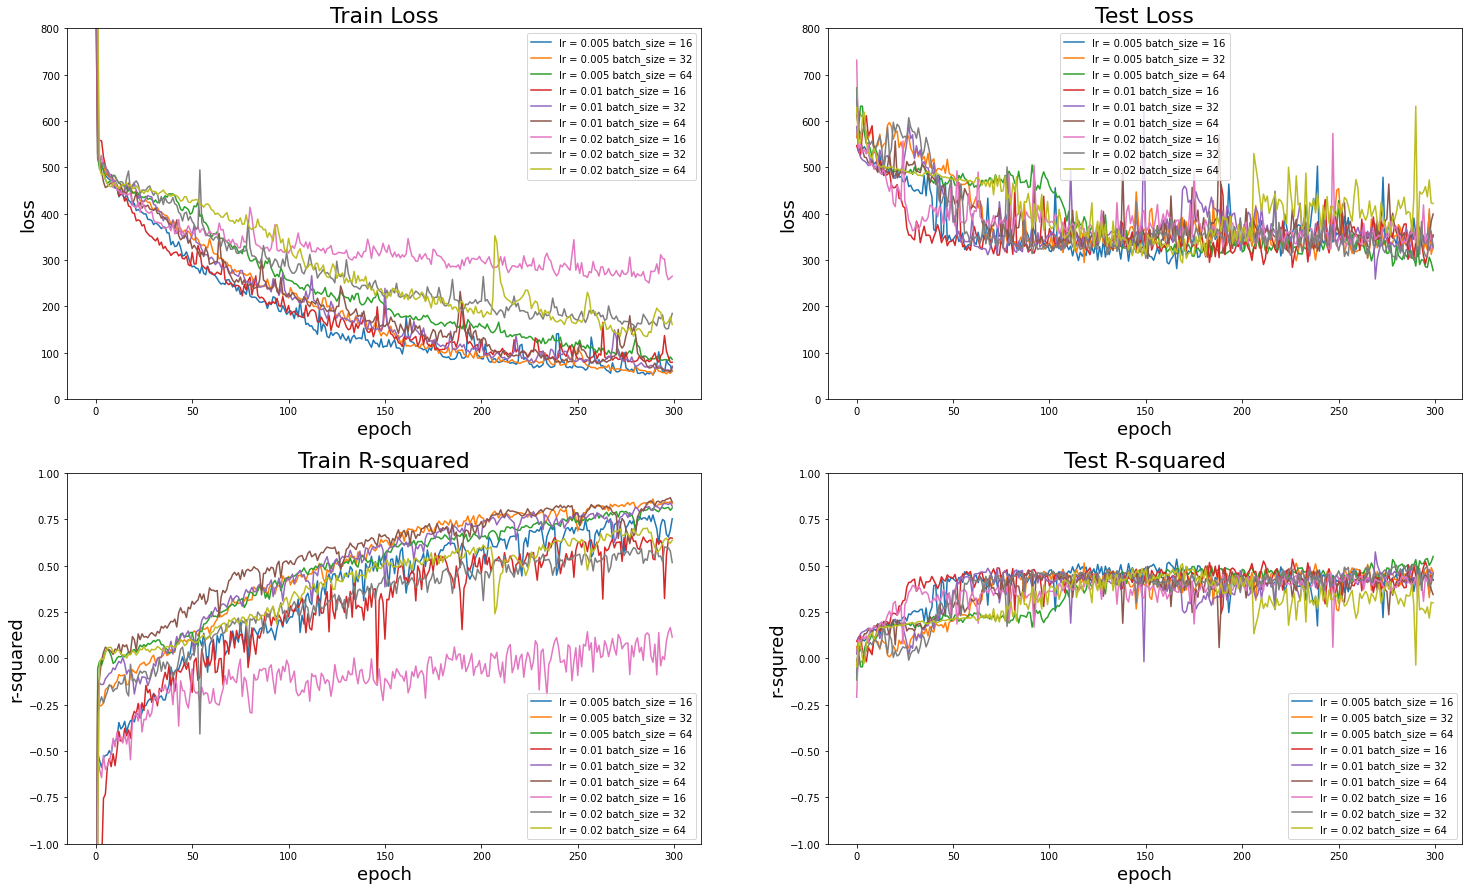

<Figure size 1800x1080 with 0 Axes>

In [19]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.005 batch_size = 16")
    ax.plot(data_list[1],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[2],label="lr = 0.005 batch_size = 64")

    ax.plot(data_list[3],label="lr = 0.01 batch_size = 16")
    ax.plot(data_list[4],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.01 batch_size = 64")
    
    ax.plot(data_list[6],label="lr = 0.02 batch_size = 16")
    ax.plot(data_list[7],label="lr = 0.02 batch_size = 32")
    ax.plot(data_list[8],label="lr = 0.02 batch_size = 64")
    

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 800])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 800])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-1,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squred", fontsize=18)
ax4.legend()
ax4.set_ylim([-1,1])

plt.show()

In [20]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

0.7536714922110092
0.8361359171514798
0.8122287159278527
0.648858781238744
0.8220786891015176
0.844218842612087
0.11555474741825973
0.5175204934170465
0.6378964043054722
___________________

0.4245131845717336
0.46503145108060073
0.5503943490278767
0.4226456979730868
0.4601642018433652
0.3451344785180874
0.46488445396016037
0.4572021312166724
0.3003890943734468
___________________

60.10603916543162
60.54247506998353
85.41304836273193
79.24896859715128
67.65561372142727
70.68524112701417
265.16793458074585
184.77146090491343
160.98602644602457
___________________

351.2535400390625
329.50660705566406
277.19293212890625
354.2654495239258
333.0291442871094
399.2926483154297
324.0816650390625
327.75213623046875
422.1701354980469


### 3 best models

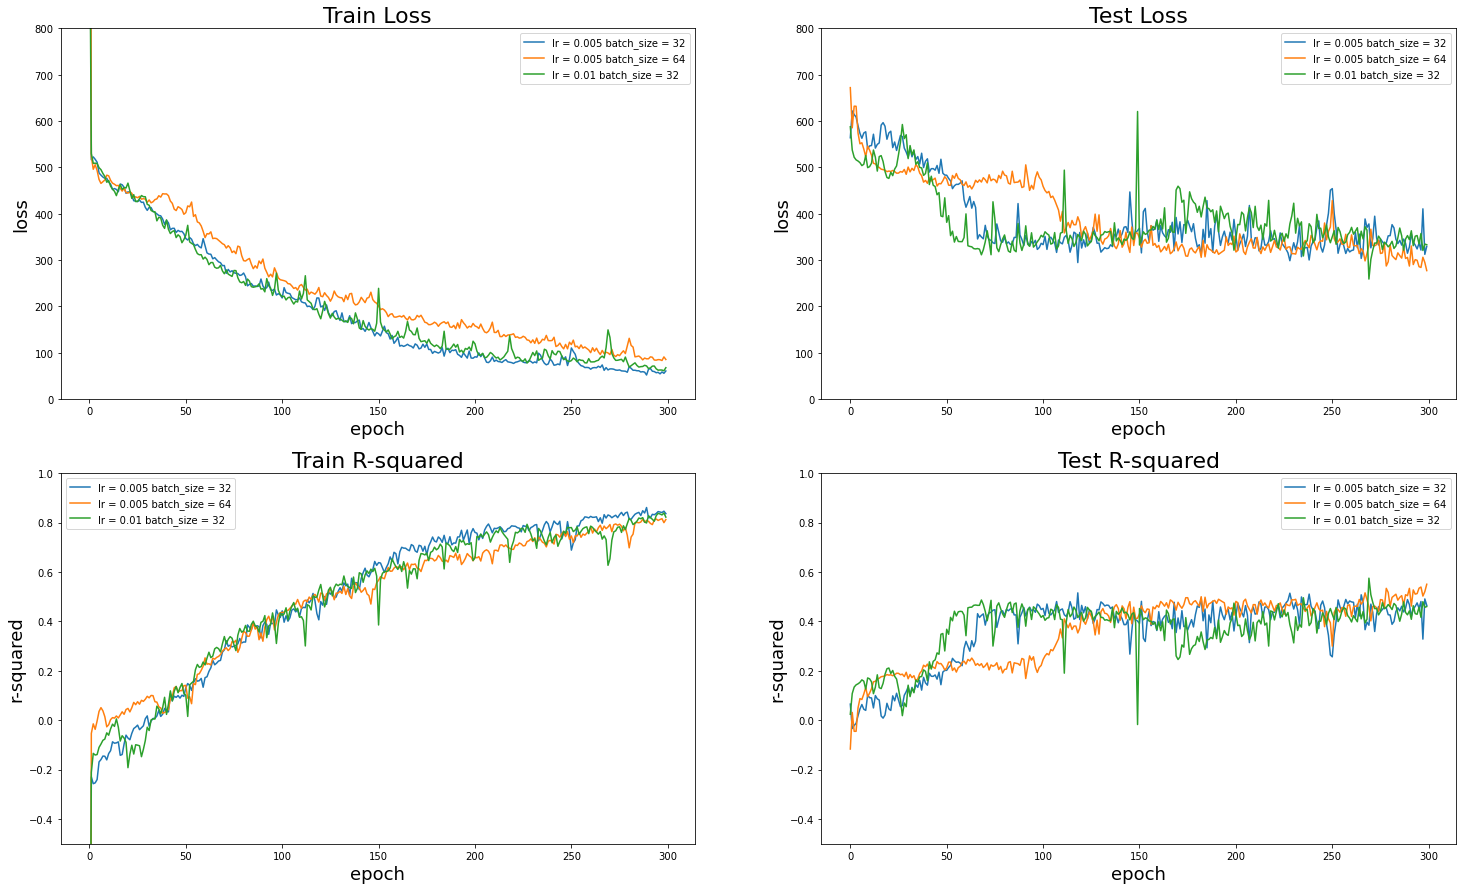

<Figure size 432x288 with 0 Axes>

In [22]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[1],label="lr = 0.005 batch_size = 32")
ax1.plot(train_losses_all[2],label="lr = 0.005 batch_size = 64")
ax1.plot(train_losses_all[4],label="lr = 0.01 batch_size = 32")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 800])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[1],label="lr = 0.005 batch_size = 32")
ax2.plot(test_losses_all[2],label="lr = 0.005 batch_size = 64")
ax2.plot(test_losses_all[4],label="lr = 0.01 batch_size = 32")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 800])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[1],label="lr = 0.005 batch_size = 32")
ax3.plot(train_accs_all[2],label="lr = 0.005 batch_size = 64")
ax3.plot(train_accs_all[4],label="lr = 0.01 batch_size = 32")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-0.5,1])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[1],label="lr = 0.005 batch_size = 32")
ax4.plot(test_accs_all[2],label="lr = 0.005 batch_size = 64")
ax4.plot(test_accs_all[4],label="lr = 0.01 batch_size = 32")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-0.5,1])
plt.show()

## 6.2. Training


- Model 1 - lr: 0.005 batch size: 32
- Model 2 - lr: 0.005 batch size: 64
- Model 3 - lr: 0.01 batch size: 32

In [28]:
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []
best_params_all = []
writer = SummaryWriter()

pairs = [(0.005, 32), (0.005, 64), (0.01, 32)]

for i_p, (lr, batch_size) in enumerate(pairs):
    
    model = GraphNeuralNetwork()

    train_loader = GraphDataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = GraphDataLoader(test_dataset, batch_size=533, shuffle=False)

    epochs = 500
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    best_params = {'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
    best_value = 600

    print('Model: batch_size {} learning rate {}'.format(batch_size, lr))

    for epoch in range(1, epochs + 1):

        print('################## EPOCH {} ##################'.format(epoch))

        model.train()
        train_correct = 0
        train_loss = 0

        for data in tqdm(train_loader, leave=False):
            x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
            optimizer.zero_grad()
            output = model(x, edge_index, batch)
            loss = criterion(output, torch.Tensor(y))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += metrics.r2_score(y, output.cpu().detach().numpy())   

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_acc = train_correct/len(train_loader)
        train_accs.append(train_acc)
        writer.add_scalar("Model_{}/Loss/train".format(i_p), train_loss, epoch)
        writer.add_scalar("Model_{}/R2/train".format(i_p), train_acc, epoch)
        print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

        model.eval()

        test_loss = 0
        test_correct = 0    

        with torch.no_grad():
            for data in tqdm(test_loader):
                x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                output = model(x, edge_index, batch)
                test_loss += criterion(output, torch.Tensor(y)).item()
                test_correct += metrics.r2_score(y, output.cpu().detach().numpy())

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_acc =test_correct/len(test_loader)
        test_accs.append(test_acc)

        if test_loss<best_value:
            best_value = test_loss
            torch.save(model.state_dict(), '../../models/protein_graph_model_{}.pt'.format(i_p))
            best_params['batch_size'] = batch_size
            best_params['epoch'] = epoch
            best_params['train_loss'] = train_loss
            best_params['test_loss'] = test_loss
            best_params['train_acc'] = train_acc
            best_params['test_acc'] = test_acc 
        writer.add_scalar("Model_{}/Loss/test".format(i_p), test_loss, epoch)
        writer.add_scalar("Model_{}/R2/test".format(i_p), test_acc, epoch)
        print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

    train_losses_all.append(train_losses)
    test_losses_all.append(test_losses)
    train_accs_all.append(train_accs)
    test_accs_all.append(test_accs)
    best_params_all.append(best_params)

writer.flush()
writer.close()
print(best_params_all)

  3%|▎         | 2/67 [00:00<00:04, 15.10it/s]

Model: batch_size 32 learning rate 0.005
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 1334.479677798143, Accuracy: -2.0453748271466305


  3%|▎         | 2/67 [00:00<00:03, 16.34it/s]

Test Avg. loss: 440.3833312988281, Accuracy: 0.04571951627457349
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 522.9691324945707, Accuracy: -0.18854338855957353


  3%|▎         | 2/67 [00:00<00:04, 14.38it/s]

Test Avg. loss: 540.946044921875, Accuracy: -0.17219310925123077
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 528.1149055139342, Accuracy: -0.22150473840296203


  3%|▎         | 2/67 [00:00<00:04, 16.03it/s]

Test Avg. loss: 538.8731079101562, Accuracy: -0.16770103910380962
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 520.0548926965514, Accuracy: -0.20790941317001022


  3%|▎         | 2/67 [00:00<00:04, 14.74it/s]

Test Avg. loss: 528.3935546875, Accuracy: -0.14499256693915896
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 522.8018688372712, Accuracy: -0.2251302138900445


  3%|▎         | 2/67 [00:00<00:04, 16.07it/s]

Test Avg. loss: 536.39892578125, Accuracy: -0.16233973562601767
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 514.0814854636121, Accuracy: -0.20214003280672266


  3%|▎         | 2/67 [00:00<00:04, 16.20it/s]

Test Avg. loss: 533.4512329101562, Accuracy: -0.1559522643591147
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 495.89324780364535, Accuracy: -0.13966603053779844


  3%|▎         | 2/67 [00:00<00:04, 15.21it/s]

Test Avg. loss: 542.4354248046875, Accuracy: -0.17542041678642795
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 499.5805255263599, Accuracy: -0.15412965350152885


  3%|▎         | 2/67 [00:00<00:03, 16.49it/s]

Test Avg. loss: 506.7618408203125, Accuracy: -0.09811807985740595
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 488.99634631712047, Accuracy: -0.1532166085189784


  3%|▎         | 2/67 [00:00<00:04, 16.17it/s]

Test Avg. loss: 585.5935668945312, Accuracy: -0.2689409945272827
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 495.2660466663873, Accuracy: -0.16009752121621934


  3%|▎         | 2/67 [00:00<00:03, 16.62it/s]

Test Avg. loss: 493.44488525390625, Accuracy: -0.069261193558946
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 484.1231051772388, Accuracy: -0.13992858734163757


  3%|▎         | 2/67 [00:00<00:04, 15.52it/s]

Test Avg. loss: 487.40338134765625, Accuracy: -0.05616965288263631
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 475.98101966060807, Accuracy: -0.10177819182592474


  3%|▎         | 2/67 [00:00<00:03, 16.51it/s]

Test Avg. loss: 461.7312927246094, Accuracy: -0.00054010788845682
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 463.1007677903816, Accuracy: -0.06479387091867903


  3%|▎         | 2/67 [00:00<00:03, 16.81it/s]

Test Avg. loss: 467.3886413574219, Accuracy: -0.012799141124544944
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 469.44619489071977, Accuracy: -0.10796857394046125


  3%|▎         | 2/67 [00:00<00:03, 16.52it/s]

Test Avg. loss: 449.7262878417969, Accuracy: 0.02547395508973327
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 461.40807342529297, Accuracy: -0.07936439863893051


  3%|▎         | 2/67 [00:00<00:03, 17.16it/s]

Test Avg. loss: 453.7433776855469, Accuracy: 0.016769241273511315
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 461.6969207080443, Accuracy: -0.0779111934834776


  3%|▎         | 2/67 [00:00<00:03, 16.97it/s]

Test Avg. loss: 431.8830261230469, Accuracy: 0.06413900481516999
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 451.1046840610789, Accuracy: -0.04411904971879811


  3%|▎         | 2/67 [00:00<00:03, 18.55it/s]

Test Avg. loss: 425.50799560546875, Accuracy: 0.07795338286466891
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 445.6964777476752, Accuracy: -0.04080527359403356


  3%|▎         | 2/67 [00:00<00:03, 16.86it/s]

Test Avg. loss: 438.6560974121094, Accuracy: 0.049462365598883284
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 448.9668040489083, Accuracy: -0.044090808505521904


  3%|▎         | 2/67 [00:00<00:03, 16.75it/s]

Test Avg. loss: 416.5886535644531, Accuracy: 0.09728101243763931
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 448.1524658203125, Accuracy: -0.05446663021011477


  3%|▎         | 2/67 [00:00<00:03, 16.56it/s]

Test Avg. loss: 438.7804870605469, Accuracy: 0.04919278393624349
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 440.20665592933767, Accuracy: -0.03279185849695091


  3%|▎         | 2/67 [00:00<00:03, 16.37it/s]

Test Avg. loss: 420.3148193359375, Accuracy: 0.08920657849427449
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 434.5621229712643, Accuracy: -0.0034355045843805164


  3%|▎         | 2/67 [00:00<00:03, 17.72it/s]

Test Avg. loss: 402.94049072265625, Accuracy: 0.1268556284230009
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 436.65807809402696, Accuracy: -0.019465208199605823


  3%|▎         | 2/67 [00:00<00:03, 16.71it/s]

Test Avg. loss: 418.5783386230469, Accuracy: 0.09296943153262738
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 430.5029162506559, Accuracy: -4.8507210823409594e-05


  3%|▎         | 2/67 [00:00<00:03, 17.04it/s]

Test Avg. loss: 422.5410461425781, Accuracy: 0.08438253354362801
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 430.4102926681291, Accuracy: -0.014763304346617965


  3%|▎         | 2/67 [00:00<00:03, 17.98it/s]

Test Avg. loss: 413.87249755859375, Accuracy: 0.10316660116982301
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 426.77117270853984, Accuracy: 0.0007897733957737697


  3%|▎         | 2/67 [00:00<00:03, 17.43it/s]

Test Avg. loss: 421.4514465332031, Accuracy: 0.08674363078182878
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 424.5454572990759, Accuracy: 0.001148844848911251


  3%|▎         | 2/67 [00:00<00:03, 18.17it/s]

Test Avg. loss: 406.72412109375, Accuracy: 0.11865668859021439
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 422.3852007282314, Accuracy: -0.0010481113893162774


  3%|▎         | 2/67 [00:00<00:03, 16.89it/s]

Test Avg. loss: 388.26922607421875, Accuracy: 0.15864724628236038
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 419.26108482702455, Accuracy: 0.012999074367321941


  3%|▎         | 2/67 [00:00<00:03, 16.52it/s]

Test Avg. loss: 397.6007385253906, Accuracy: 0.13842642051923026
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 422.5299810153335, Accuracy: -0.00433374831954921


  3%|▎         | 2/67 [00:00<00:03, 17.28it/s]

Test Avg. loss: 393.3054504394531, Accuracy: 0.1477340150592945
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 410.9514780756253, Accuracy: 0.024899876109454853


  3%|▎         | 2/67 [00:00<00:03, 16.88it/s]

Test Avg. loss: 378.2945861816406, Accuracy: 0.18026150458358758
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 403.4625009565211, Accuracy: 0.051532881891211864


  3%|▎         | 2/67 [00:00<00:04, 15.96it/s]

Test Avg. loss: 375.6683044433594, Accuracy: 0.18595255995153126
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 402.2838369341039, Accuracy: 0.04438722142287392


  3%|▎         | 2/67 [00:00<00:04, 16.11it/s]

Test Avg. loss: 374.04443359375, Accuracy: 0.18947136948108578
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 397.3565055505553, Accuracy: 0.05401183113130533


  3%|▎         | 2/67 [00:00<00:04, 14.50it/s]

Test Avg. loss: 381.6170959472656, Accuracy: 0.1730618682828471
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 397.1263055374373, Accuracy: 0.0489126195072269


  3%|▎         | 2/67 [00:00<00:03, 17.15it/s]

Test Avg. loss: 371.7912292480469, Accuracy: 0.19435391960329673
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 391.74545982702455, Accuracy: 0.0776513341032379


  3%|▎         | 2/67 [00:00<00:04, 15.79it/s]

Test Avg. loss: 368.783935546875, Accuracy: 0.20087051292969305
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 386.8395267315765, Accuracy: 0.07735250343899905


  3%|▎         | 2/67 [00:00<00:03, 17.72it/s]

Test Avg. loss: 366.7894287109375, Accuracy: 0.20519245197948033
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 379.36430051433507, Accuracy: 0.09251724165261571


  3%|▎         | 2/67 [00:00<00:03, 16.46it/s]

Test Avg. loss: 372.27734375, Accuracy: 0.19330048836990266
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 384.80252029646687, Accuracy: 0.09844036048616364


  3%|▎         | 2/67 [00:00<00:03, 16.49it/s]

Test Avg. loss: 379.079833984375, Accuracy: 0.17856000714036724
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 381.17056342737, Accuracy: 0.09120655597611452


  3%|▎         | 2/67 [00:00<00:03, 16.55it/s]

Test Avg. loss: 360.2314453125, Accuracy: 0.21940313881520845
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 376.51377037389955, Accuracy: 0.09416302674579818


  3%|▎         | 2/67 [00:00<00:03, 16.37it/s]

Test Avg. loss: 360.52197265625, Accuracy: 0.21877360836285498
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 370.70560136481896, Accuracy: 0.11660047524603405


  3%|▎         | 2/67 [00:00<00:03, 17.63it/s]

Test Avg. loss: 353.9209899902344, Accuracy: 0.23307746012680208
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 367.6135940551758, Accuracy: 0.1025569987087202


  3%|▎         | 2/67 [00:00<00:03, 17.57it/s]

Test Avg. loss: 346.5364685058594, Accuracy: 0.24907921344573059
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 359.3814451303055, Accuracy: 0.14314314358155092


  3%|▎         | 2/67 [00:00<00:03, 16.69it/s]

Test Avg. loss: 348.55279541015625, Accuracy: 0.2447100346942106
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 369.7953724647636, Accuracy: 0.10670874255590346


  3%|▎         | 2/67 [00:00<00:03, 16.71it/s]

Test Avg. loss: 342.56585693359375, Accuracy: 0.25768334220524725
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 353.14573327818914, Accuracy: 0.14737044648387493


  3%|▎         | 2/67 [00:00<00:03, 16.94it/s]

Test Avg. loss: 333.80767822265625, Accuracy: 0.27666169016120257
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 346.41986391437587, Accuracy: 0.16264190758518335


  3%|▎         | 2/67 [00:00<00:03, 16.43it/s]

Test Avg. loss: 336.69183349609375, Accuracy: 0.270411837499548
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 337.6657751282649, Accuracy: 0.18074307051608773


  3%|▎         | 2/67 [00:00<00:03, 16.43it/s]

Test Avg. loss: 328.4233093261719, Accuracy: 0.2883292439109213
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 328.39515401356255, Accuracy: 0.18226764949588742


  3%|▎         | 2/67 [00:00<00:03, 16.81it/s]

Test Avg. loss: 312.7490539550781, Accuracy: 0.3222941974537512
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 313.06330347772854, Accuracy: 0.24472335207030652


  3%|▎         | 2/67 [00:00<00:03, 17.28it/s]

Test Avg. loss: 313.06689453125, Accuracy: 0.3216055094232104
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 318.7904377268321, Accuracy: 0.21536355578900543


  3%|▎         | 2/67 [00:00<00:03, 17.85it/s]

Test Avg. loss: 306.6826477050781, Accuracy: 0.3354397451326354
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 303.30262596927474, Accuracy: 0.2536954121140786


  3%|▎         | 2/67 [00:00<00:03, 16.62it/s]

Test Avg. loss: 301.929443359375, Accuracy: 0.3457396296117802
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 298.4636537921962, Accuracy: 0.2677479575642579


  3%|▎         | 2/67 [00:00<00:03, 16.53it/s]

Test Avg. loss: 299.1729736328125, Accuracy: 0.35171272813090015
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 305.94110784957655, Accuracy: 0.25314836794994594


  3%|▎         | 2/67 [00:00<00:03, 16.96it/s]

Test Avg. loss: 318.90899658203125, Accuracy: 0.308946002440071
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 294.21391655082135, Accuracy: 0.27620842859718975


  3%|▎         | 2/67 [00:00<00:03, 17.91it/s]

Test Avg. loss: 299.2373352050781, Accuracy: 0.35157322130274005
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 296.4332109138147, Accuracy: 0.27775275284021217


  3%|▎         | 2/67 [00:00<00:03, 16.54it/s]

Test Avg. loss: 291.5583190917969, Accuracy: 0.36821310910023464
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 310.1777366524312, Accuracy: 0.2526225289728437


  3%|▎         | 2/67 [00:00<00:03, 18.02it/s]

Test Avg. loss: 324.6048889160156, Accuracy: 0.29660352972675197
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 299.93735060051307, Accuracy: 0.2665574856287183


  3%|▎         | 2/67 [00:00<00:03, 16.26it/s]

Test Avg. loss: 289.8824157714844, Accuracy: 0.3718446910773675
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 288.33106596078443, Accuracy: 0.27843955138819826


  3%|▎         | 2/67 [00:00<00:04, 15.06it/s]

Test Avg. loss: 294.3629455566406, Accuracy: 0.36213568166228705
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 293.77126705112744, Accuracy: 0.2770703117844495


  3%|▎         | 2/67 [00:00<00:03, 16.61it/s]

Test Avg. loss: 293.29766845703125, Accuracy: 0.3644440193940557
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 291.3660319314074, Accuracy: 0.2703794605557998


  3%|▎         | 2/67 [00:00<00:03, 16.55it/s]

Test Avg. loss: 290.8306884765625, Accuracy: 0.36978989179961375
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 284.1655408375299, Accuracy: 0.28757373337469305


  3%|▎         | 2/67 [00:00<00:03, 16.52it/s]

Test Avg. loss: 286.0931091308594, Accuracy: 0.38005584076062526
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 268.19249423582164, Accuracy: 0.3346311725794292


  3%|▎         | 2/67 [00:00<00:03, 16.28it/s]

Test Avg. loss: 287.34130859375, Accuracy: 0.37735099874482725
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 278.94750885465254, Accuracy: 0.30300542982323847


  3%|▎         | 2/67 [00:00<00:03, 16.63it/s]

Test Avg. loss: 287.16180419921875, Accuracy: 0.3777400547014923
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 286.7524721515712, Accuracy: 0.27296374305334387


  3%|▎         | 2/67 [00:00<00:03, 16.83it/s]

Test Avg. loss: 288.2376403808594, Accuracy: 0.3754087913143185
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 286.21451773572323, Accuracy: 0.2862985807129341


  3%|▎         | 2/67 [00:00<00:04, 14.60it/s]

Test Avg. loss: 310.5948181152344, Accuracy: 0.32696234152158876
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 262.1446091950829, Accuracy: 0.345028013483102


  3%|▎         | 2/67 [00:00<00:03, 17.38it/s]

Test Avg. loss: 307.71185302734375, Accuracy: 0.33320948510136006
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 257.739200592041, Accuracy: 0.3542942221060476


  3%|▎         | 2/67 [00:00<00:04, 16.02it/s]

Test Avg. loss: 313.7030029296875, Accuracy: 0.32022702135830683
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 262.7413049384729, Accuracy: 0.345201769730929


  3%|▎         | 2/67 [00:00<00:04, 15.06it/s]

Test Avg. loss: 316.6747741699219, Accuracy: 0.3137875557209939
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 300.6036600141383, Accuracy: 0.23946034613012016


  3%|▎         | 2/67 [00:00<00:04, 16.02it/s]

Test Avg. loss: 328.0086669921875, Accuracy: 0.28922760954170657
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 290.83845645278245, Accuracy: 0.2702950479813845


  3%|▎         | 2/67 [00:00<00:03, 16.30it/s]

Test Avg. loss: 314.7303161621094, Accuracy: 0.31800101222773014
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 265.40004798547545, Accuracy: 0.3183142172445115


  3%|▎         | 2/67 [00:00<00:03, 16.37it/s]

Test Avg. loss: 356.22509765625, Accuracy: 0.22808463832640236
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 255.4683512217963, Accuracy: 0.35716781166610106


  3%|▎         | 2/67 [00:00<00:03, 16.44it/s]

Test Avg. loss: 337.1396484375, Accuracy: 0.2694415468260011
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 250.55824245623688, Accuracy: 0.3734647602055015


  3%|▎         | 2/67 [00:00<00:03, 16.35it/s]

Test Avg. loss: 326.7342224121094, Accuracy: 0.29198935657004943
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 254.9625676283196, Accuracy: 0.3610742361669124


  3%|▎         | 2/67 [00:00<00:04, 15.93it/s]

Test Avg. loss: 330.73980712890625, Accuracy: 0.2833095814757597
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 248.70855234630073, Accuracy: 0.3896260534848995


  3%|▎         | 2/67 [00:00<00:03, 18.37it/s]

Test Avg. loss: 336.0984802246094, Accuracy: 0.2716976621381837
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 258.5726563183229, Accuracy: 0.3539751190779827


  3%|▎         | 2/67 [00:00<00:03, 16.55it/s]

Test Avg. loss: 314.6307067871094, Accuracy: 0.3182167852419189
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 249.785292952808, Accuracy: 0.37961050674951113


  3%|▎         | 2/67 [00:00<00:04, 15.31it/s]

Test Avg. loss: 342.3006591796875, Accuracy: 0.2582579773527358
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 247.5477349010866, Accuracy: 0.3784680095402902


  3%|▎         | 2/67 [00:00<00:03, 17.01it/s]

Test Avg. loss: 334.8013000488281, Accuracy: 0.274508604501041
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 240.61231089350002, Accuracy: 0.4018305759023001


  3%|▎         | 2/67 [00:00<00:03, 17.43it/s]

Test Avg. loss: 318.0017395019531, Accuracy: 0.3109120367700292
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 242.45751964512155, Accuracy: 0.38164335748589046


  3%|▎         | 2/67 [00:00<00:04, 15.88it/s]

Test Avg. loss: 326.1690673828125, Accuracy: 0.29321401442277584
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 236.5492829280113, Accuracy: 0.4042446086372436


  3%|▎         | 2/67 [00:00<00:03, 16.64it/s]

Test Avg. loss: 330.8243103027344, Accuracy: 0.2831264176996279
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 238.92422103881836, Accuracy: 0.3976232721268936


  3%|▎         | 2/67 [00:00<00:03, 17.46it/s]

Test Avg. loss: 352.4310302734375, Accuracy: 0.23630607380755508
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 241.74895352036205, Accuracy: 0.39107607753122076


  3%|▎         | 2/67 [00:00<00:03, 17.34it/s]

Test Avg. loss: 347.5065002441406, Accuracy: 0.24697715791305364
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 243.52957477854258, Accuracy: 0.4050002940006229


  3%|▎         | 2/67 [00:00<00:03, 16.28it/s]

Test Avg. loss: 304.8079528808594, Accuracy: 0.33950201803881386
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 231.71587571101404, Accuracy: 0.4192919882647231


  3%|▎         | 2/67 [00:00<00:04, 15.98it/s]

Test Avg. loss: 332.8149719238281, Accuracy: 0.278812743177447
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 228.8894805908203, Accuracy: 0.4317325050724192


  3%|▎         | 2/67 [00:00<00:03, 16.87it/s]

Test Avg. loss: 347.3085021972656, Accuracy: 0.24740623815168816
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 228.13415288213474, Accuracy: 0.4102158643355872


  3%|▎         | 2/67 [00:00<00:04, 15.74it/s]

Test Avg. loss: 332.890869140625, Accuracy: 0.2786482995237892
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 224.07805969466025, Accuracy: 0.45245280885920225


  3%|▎         | 2/67 [00:00<00:03, 16.91it/s]

Test Avg. loss: 324.6651306152344, Accuracy: 0.29647289394396126
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 222.07546769327192, Accuracy: 0.44835485734228814


  3%|▎         | 2/67 [00:00<00:04, 15.53it/s]

Test Avg. loss: 305.46875, Accuracy: 0.3380701474378378
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 221.74118076153655, Accuracy: 0.45411919347580737


  3%|▎         | 2/67 [00:00<00:03, 17.80it/s]

Test Avg. loss: 323.9517822265625, Accuracy: 0.2980187473294813
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 224.9589289195502, Accuracy: 0.4374586583738342


  3%|▎         | 2/67 [00:00<00:04, 16.18it/s]

Test Avg. loss: 336.6714172363281, Accuracy: 0.2704561291839934
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.28875385113616, Accuracy: 0.4327975032999481


  3%|▎         | 2/67 [00:00<00:04, 15.96it/s]

Test Avg. loss: 332.8193359375, Accuracy: 0.2788032885270014
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 217.52103822622726, Accuracy: 0.45247640421381047


  3%|▎         | 2/67 [00:00<00:03, 16.65it/s]

Test Avg. loss: 324.00799560546875, Accuracy: 0.2978969414936925
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 218.5086037934716, Accuracy: 0.4518324116250286


  3%|▎         | 2/67 [00:00<00:03, 16.69it/s]

Test Avg. loss: 326.73199462890625, Accuracy: 0.2919940886377026
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 220.1018057296525, Accuracy: 0.44493185401462776


  3%|▎         | 2/67 [00:00<00:03, 16.92it/s]

Test Avg. loss: 328.9681396484375, Accuracy: 0.28714864071544266
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 209.02987910028713, Accuracy: 0.4792488479580497


  3%|▎         | 2/67 [00:00<00:04, 16.00it/s]

Test Avg. loss: 307.0702209472656, Accuracy: 0.33459993388009013
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 208.3123161543661, Accuracy: 0.47583892585071236


  3%|▎         | 2/67 [00:00<00:03, 16.56it/s]

Test Avg. loss: 299.45648193359375, Accuracy: 0.35109833407483104
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 210.29247671098852, Accuracy: 0.4663127953733505


  3%|▎         | 2/67 [00:00<00:03, 16.55it/s]

Test Avg. loss: 343.4571533203125, Accuracy: 0.2557518669722101
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 225.80194723784035, Accuracy: 0.4341127755303737


  3%|▎         | 2/67 [00:00<00:04, 16.15it/s]

Test Avg. loss: 286.1068420410156, Accuracy: 0.3800260754187055
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 206.38527292280054, Accuracy: 0.482164650878158


  3%|▎         | 2/67 [00:00<00:03, 16.34it/s]

Test Avg. loss: 344.3194580078125, Accuracy: 0.2538834070052627
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 211.73951089204246, Accuracy: 0.4445646987197686


  3%|▎         | 2/67 [00:00<00:03, 16.65it/s]

Test Avg. loss: 317.3165588378906, Accuracy: 0.312396771065071
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 204.3703295579597, Accuracy: 0.4895460525881142


  3%|▎         | 2/67 [00:00<00:03, 16.52it/s]

Test Avg. loss: 307.3125915527344, Accuracy: 0.33407471174257086
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 204.3208502584429, Accuracy: 0.48153864623976317


  3%|▎         | 2/67 [00:00<00:04, 15.30it/s]

Test Avg. loss: 328.1194152832031, Accuracy: 0.2889876756038495
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 208.27239164665565, Accuracy: 0.4735199232734673


  3%|▎         | 2/67 [00:00<00:03, 16.89it/s]

Test Avg. loss: 327.0923156738281, Accuracy: 0.2912133839042724
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 205.62426034728094, Accuracy: 0.4744744167749276


  3%|▎         | 2/67 [00:00<00:04, 15.32it/s]

Test Avg. loss: 303.5527038574219, Accuracy: 0.34222215820376056
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 205.10363074914733, Accuracy: 0.4840056255103688


  3%|▎         | 2/67 [00:00<00:04, 15.42it/s]

Test Avg. loss: 332.1434326171875, Accuracy: 0.2802679201304107
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 211.52399939921364, Accuracy: 0.4567015691909149


  3%|▎         | 2/67 [00:00<00:03, 16.32it/s]

Test Avg. loss: 277.9523620605469, Accuracy: 0.3976962580109876
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 215.54182001370103, Accuracy: 0.4654753224133561


  3%|▎         | 2/67 [00:00<00:04, 16.17it/s]

Test Avg. loss: 309.0263977050781, Accuracy: 0.33036097768142425
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 205.63182671390362, Accuracy: 0.48369267426662005


  3%|▎         | 2/67 [00:00<00:03, 16.31it/s]

Test Avg. loss: 327.4571533203125, Accuracy: 0.29042287572387404
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 198.36712304869695, Accuracy: 0.4978231996202229


  3%|▎         | 2/67 [00:00<00:03, 17.06it/s]

Test Avg. loss: 320.0039367675781, Accuracy: 0.3065734236894878
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 190.31428277314598, Accuracy: 0.5239881167942914


  3%|▎         | 2/67 [00:00<00:04, 15.85it/s]

Test Avg. loss: 319.2146911621094, Accuracy: 0.30828361005908267
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 204.5604785520639, Accuracy: 0.48995340795846953


  3%|▎         | 2/67 [00:00<00:04, 16.06it/s]

Test Avg. loss: 317.6248474121094, Accuracy: 0.3117287264000216
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 198.76756053184394, Accuracy: 0.5066667574747712


  3%|▎         | 2/67 [00:00<00:03, 16.45it/s]

Test Avg. loss: 310.3996887207031, Accuracy: 0.3273851812377374
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 189.3277742755947, Accuracy: 0.5239501529940341


  3%|▎         | 2/67 [00:00<00:03, 17.43it/s]

Test Avg. loss: 329.08355712890625, Accuracy: 0.28689858372828614
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 181.59378051757812, Accuracy: 0.5508665986538944


  3%|▎         | 2/67 [00:00<00:03, 16.30it/s]

Test Avg. loss: 318.3024597167969, Accuracy: 0.3102603271752099
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 187.8617986422866, Accuracy: 0.5177405362164306


  3%|▎         | 2/67 [00:00<00:03, 17.29it/s]

Test Avg. loss: 323.3348693847656, Accuracy: 0.29935554374656737
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 187.43985953259823, Accuracy: 0.5427081947522502


  3%|▎         | 2/67 [00:00<00:04, 16.13it/s]

Test Avg. loss: 333.0928039550781, Accuracy: 0.27821071623556004
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 179.3440575386161, Accuracy: 0.562883626529572


  3%|▎         | 2/67 [00:00<00:03, 16.39it/s]

Test Avg. loss: 299.69195556640625, Accuracy: 0.3505880254248682
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 184.65279257475441, Accuracy: 0.5384832051394098


  3%|▎         | 2/67 [00:00<00:04, 16.15it/s]

Test Avg. loss: 281.7530212402344, Accuracy: 0.3894604680691838
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 181.83244642570838, Accuracy: 0.5466966997564157


  3%|▎         | 2/67 [00:00<00:03, 16.48it/s]

Test Avg. loss: 274.4996337890625, Accuracy: 0.40517815341533747
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 187.3938233674462, Accuracy: 0.5312173777231655


  3%|▎         | 2/67 [00:00<00:03, 16.49it/s]

Test Avg. loss: 302.2559814453125, Accuracy: 0.3450319638192533
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 173.83397418349537, Accuracy: 0.580396599520952


  3%|▎         | 2/67 [00:00<00:03, 17.41it/s]

Test Avg. loss: 286.9587097167969, Accuracy: 0.37818013797864736
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 168.42128514531834, Accuracy: 0.590197429716426


  3%|▎         | 2/67 [00:00<00:03, 16.32it/s]

Test Avg. loss: 315.8263854980469, Accuracy: 0.31562580133921836
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 175.74743122840997, Accuracy: 0.568235408982985


  3%|▎         | 2/67 [00:00<00:04, 15.28it/s]

Test Avg. loss: 304.9241943359375, Accuracy: 0.33925023597328785
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 175.00734636676845, Accuracy: 0.5479914802440837


  3%|▎         | 2/67 [00:00<00:04, 15.85it/s]

Test Avg. loss: 312.5627136230469, Accuracy: 0.322698004890172
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 187.1866192034821, Accuracy: 0.5439656818314831


  3%|▎         | 2/67 [00:00<00:03, 17.00it/s]

Test Avg. loss: 321.4491882324219, Accuracy: 0.3034415622975557
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 162.25216731740468, Accuracy: 0.5948375853215554


  3%|▎         | 2/67 [00:00<00:03, 16.76it/s]

Test Avg. loss: 320.71612548828125, Accuracy: 0.30503017159959156
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 167.12696405666978, Accuracy: 0.5909306828523521


  3%|▎         | 2/67 [00:00<00:03, 16.49it/s]

Test Avg. loss: 304.57440185546875, Accuracy: 0.3400081051841143
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 164.33231131710224, Accuracy: 0.588810301758661


  3%|▎         | 2/67 [00:00<00:03, 17.03it/s]

Test Avg. loss: 333.2676696777344, Accuracy: 0.2778318157750612
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 164.52270781104244, Accuracy: 0.5685692701233357


  3%|▎         | 2/67 [00:00<00:03, 18.06it/s]

Test Avg. loss: 332.73516845703125, Accuracy: 0.2789857116847344
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 164.23613101332936, Accuracy: 0.6038673373179311


  3%|▎         | 2/67 [00:00<00:04, 15.65it/s]

Test Avg. loss: 343.47412109375, Accuracy: 0.2557151120888941
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 155.81038859353137, Accuracy: 0.6073064803600218


  3%|▎         | 2/67 [00:00<00:04, 16.14it/s]

Test Avg. loss: 288.4080810546875, Accuracy: 0.3750394923176473
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 155.3055294093801, Accuracy: 0.6196370582281333


  3%|▎         | 2/67 [00:00<00:04, 15.87it/s]

Test Avg. loss: 309.796630859375, Accuracy: 0.3286919642626801
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 161.81096700412124, Accuracy: 0.5813312327084535


  3%|▎         | 2/67 [00:00<00:03, 16.83it/s]

Test Avg. loss: 314.0075988769531, Accuracy: 0.3195670379858859
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 157.571429124519, Accuracy: 0.605065738433651


  3%|▎         | 2/67 [00:00<00:03, 16.71it/s]

Test Avg. loss: 304.2673645019531, Accuracy: 0.34067350036987565
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 153.7834589943957, Accuracy: 0.6220387254633056


  3%|▎         | 2/67 [00:00<00:04, 15.56it/s]

Test Avg. loss: 300.4043273925781, Accuracy: 0.34904450861173997
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 155.63922517691086, Accuracy: 0.5981073045072032


  3%|▎         | 2/67 [00:00<00:04, 15.71it/s]

Test Avg. loss: 307.0106506347656, Accuracy: 0.33472903946988486
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 147.6625161811487, Accuracy: 0.6310006712307854


  3%|▎         | 2/67 [00:00<00:03, 17.21it/s]

Test Avg. loss: 304.1681823730469, Accuracy: 0.340888410762207
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 155.11707641829307, Accuracy: 0.6244295300324139


  3%|▎         | 2/67 [00:00<00:03, 16.30it/s]

Test Avg. loss: 283.93023681640625, Accuracy: 0.384742646985903
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 161.3583381425089, Accuracy: 0.5852399512657706


  3%|▎         | 2/67 [00:00<00:04, 16.00it/s]

Test Avg. loss: 308.05560302734375, Accuracy: 0.33246463079793986
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 171.0497355105272, Accuracy: 0.564344740408127


  3%|▎         | 2/67 [00:00<00:03, 16.59it/s]

Test Avg. loss: 284.77484130859375, Accuracy: 0.3829124618722435
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 146.3421061501574, Accuracy: 0.6345565774063703


  3%|▎         | 2/67 [00:00<00:04, 16.09it/s]

Test Avg. loss: 300.576416015625, Accuracy: 0.34867155709348974
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 136.76672630879418, Accuracy: 0.6453071959215227


  3%|▎         | 2/67 [00:00<00:03, 16.33it/s]

Test Avg. loss: 331.2078857421875, Accuracy: 0.2822952377897612
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 141.69771513298377, Accuracy: 0.6509295163116718


  3%|▎         | 2/67 [00:00<00:04, 15.38it/s]

Test Avg. loss: 313.03936767578125, Accuracy: 0.3216651650951988
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 145.0140489606715, Accuracy: 0.6286012673947742


  3%|▎         | 2/67 [00:00<00:04, 16.18it/s]

Test Avg. loss: 296.74462890625, Accuracy: 0.35697467908379765
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 136.5083416611401, Accuracy: 0.6668139448216608


  3%|▎         | 2/67 [00:00<00:04, 16.05it/s]

Test Avg. loss: 314.6965026855469, Accuracy: 0.31807424869456347
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 138.254492916278, Accuracy: 0.6432554430382488


  3%|▎         | 2/67 [00:00<00:04, 16.17it/s]

Test Avg. loss: 308.4336242675781, Accuracy: 0.33164542717715084
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 126.39493845469916, Accuracy: 0.677710234246862


  3%|▎         | 2/67 [00:00<00:04, 15.52it/s]

Test Avg. loss: 338.405029296875, Accuracy: 0.2666995222118397
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 130.75549757658547, Accuracy: 0.6587024531177252


  3%|▎         | 2/67 [00:00<00:03, 16.63it/s]

Test Avg. loss: 290.0539245605469, Accuracy: 0.3714731227241048
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 131.75370834122842, Accuracy: 0.6689392272086507


  3%|▎         | 2/67 [00:00<00:04, 15.99it/s]

Test Avg. loss: 276.6103515625, Accuracy: 0.4006044012296833
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 138.04518611395537, Accuracy: 0.6672484528112592


  3%|▎         | 2/67 [00:00<00:04, 15.03it/s]

Test Avg. loss: 304.1507263183594, Accuracy: 0.34092615667182025
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 127.58723438319875, Accuracy: 0.6882687021428889


  3%|▎         | 2/67 [00:00<00:04, 16.05it/s]

Test Avg. loss: 310.8796081542969, Accuracy: 0.3263452519537402
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 125.73160057637229, Accuracy: 0.6777974395078561


  3%|▎         | 2/67 [00:00<00:03, 16.27it/s]

Test Avg. loss: 294.63519287109375, Accuracy: 0.3615457316369485
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 121.57081848827761, Accuracy: 0.6974602701530309


  3%|▎         | 2/67 [00:00<00:03, 16.40it/s]

Test Avg. loss: 288.13140869140625, Accuracy: 0.37563896317083356
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 118.96554400315925, Accuracy: 0.6886389062045697


  3%|▎         | 2/67 [00:00<00:03, 16.68it/s]

Test Avg. loss: 289.5876159667969, Accuracy: 0.37248342552364877
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 120.49224363867916, Accuracy: 0.6931822398500862


  3%|▎         | 2/67 [00:00<00:03, 16.33it/s]

Test Avg. loss: 284.80853271484375, Accuracy: 0.3828394487820733
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 114.9709435647993, Accuracy: 0.7022185684148707


  3%|▎         | 2/67 [00:00<00:04, 15.55it/s]

Test Avg. loss: 275.7408752441406, Accuracy: 0.40248840668723196
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 120.04676135618296, Accuracy: 0.6958380104924001


  3%|▎         | 2/67 [00:00<00:03, 16.39it/s]

Test Avg. loss: 286.0680236816406, Accuracy: 0.3801101897166872
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 120.15039227613762, Accuracy: 0.6884134937083748


  3%|▎         | 2/67 [00:00<00:03, 16.41it/s]

Test Avg. loss: 297.05615234375, Accuracy: 0.3562997111776759
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 116.41190215722838, Accuracy: 0.6994746267745876


  3%|▎         | 2/67 [00:00<00:04, 16.04it/s]

Test Avg. loss: 305.44183349609375, Accuracy: 0.33812846890538495
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 116.47249694368732, Accuracy: 0.7024512637548213


  3%|▎         | 2/67 [00:00<00:03, 16.70it/s]

Test Avg. loss: 293.5482177734375, Accuracy: 0.3639010110316878
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 117.29024312033582, Accuracy: 0.7018503481247833


  3%|▎         | 2/67 [00:00<00:04, 16.19it/s]

Test Avg. loss: 272.769775390625, Accuracy: 0.40892651153906334
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 121.1176323392498, Accuracy: 0.6973362015273854


  3%|▎         | 2/67 [00:00<00:03, 16.77it/s]

Test Avg. loss: 307.53912353515625, Accuracy: 0.3335837534845896
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 123.17913026952031, Accuracy: 0.6855293998830304


  3%|▎         | 2/67 [00:00<00:04, 16.14it/s]

Test Avg. loss: 306.6886291503906, Accuracy: 0.3354268046276426
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 111.25315298962948, Accuracy: 0.7054804179568582


  3%|▎         | 2/67 [00:00<00:03, 17.24it/s]

Test Avg. loss: 299.5867919921875, Accuracy: 0.35081593164248714
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 114.20861184419091, Accuracy: 0.7014834444974367


  3%|▎         | 2/67 [00:00<00:03, 16.53it/s]

Test Avg. loss: 272.5501403808594, Accuracy: 0.4094025576263093
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 111.14210880336476, Accuracy: 0.711362870030484


  3%|▎         | 2/67 [00:00<00:04, 16.17it/s]

Test Avg. loss: 352.1900329589844, Accuracy: 0.23682840579910935
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 123.03056346836375, Accuracy: 0.6832973659019709


  3%|▎         | 2/67 [00:00<00:04, 15.98it/s]

Test Avg. loss: 297.6930236816406, Accuracy: 0.3549195796525073
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 118.42248680342489, Accuracy: 0.6851496589507763


  3%|▎         | 2/67 [00:00<00:03, 17.53it/s]

Test Avg. loss: 289.5275573730469, Accuracy: 0.37261365874207575
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 131.12300252202732, Accuracy: 0.6599796599527794


  3%|▎         | 2/67 [00:00<00:04, 14.88it/s]

Test Avg. loss: 285.5888671875, Accuracy: 0.38114852885124173
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 114.62220063850062, Accuracy: 0.7028278199975012


  3%|▎         | 2/67 [00:00<00:03, 17.59it/s]

Test Avg. loss: 275.98046875, Accuracy: 0.4019692366122498
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 121.02361012928522, Accuracy: 0.6807419942892106


  3%|▎         | 2/67 [00:00<00:04, 14.43it/s]

Test Avg. loss: 308.94085693359375, Accuracy: 0.3305463800940339
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 111.98753803879467, Accuracy: 0.7145848056578435


  3%|▎         | 2/67 [00:00<00:04, 16.19it/s]

Test Avg. loss: 287.41876220703125, Accuracy: 0.3771832098858935
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 108.9848089645158, Accuracy: 0.7176215614522569


  3%|▎         | 2/67 [00:00<00:03, 16.89it/s]

Test Avg. loss: 310.0238952636719, Accuracy: 0.3281995380765409
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 109.86648161019852, Accuracy: 0.7212045740263804


  3%|▎         | 2/67 [00:00<00:04, 16.22it/s]

Test Avg. loss: 272.8790283203125, Accuracy: 0.40868986273832153
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 117.94757620968036, Accuracy: 0.6854741344203807


  3%|▎         | 2/67 [00:00<00:03, 16.74it/s]

Test Avg. loss: 293.9071044921875, Accuracy: 0.36312347219159036
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 114.31502071779165, Accuracy: 0.7221648608104055


  3%|▎         | 2/67 [00:00<00:03, 16.43it/s]

Test Avg. loss: 262.36572265625, Accuracy: 0.43147144594076037
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 115.8965106793304, Accuracy: 0.7060384329655313


  3%|▎         | 2/67 [00:00<00:03, 16.33it/s]

Test Avg. loss: 282.2237548828125, Accuracy: 0.3884404664267942
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 116.5701652640727, Accuracy: 0.706738450819448


  3%|▎         | 2/67 [00:00<00:03, 17.23it/s]

Test Avg. loss: 281.3946533203125, Accuracy: 0.39023702717551634
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 108.65292198978253, Accuracy: 0.7237085826081228


  3%|▎         | 2/67 [00:00<00:03, 16.31it/s]

Test Avg. loss: 287.4543762207031, Accuracy: 0.37710603377401497
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 100.38581489449116, Accuracy: 0.7484607102861792


  3%|▎         | 2/67 [00:00<00:04, 16.05it/s]

Test Avg. loss: 266.80487060546875, Accuracy: 0.42185208796124896
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 104.16441174407504, Accuracy: 0.7314559578653872


  3%|▎         | 2/67 [00:00<00:03, 17.25it/s]

Test Avg. loss: 311.7460021972656, Accuracy: 0.324467814868011
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 110.58705919180343, Accuracy: 0.7202375081118327


  3%|▎         | 2/67 [00:00<00:04, 15.48it/s]

Test Avg. loss: 279.27728271484375, Accuracy: 0.394825268213964
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 104.21859530548551, Accuracy: 0.7419511270148238


  3%|▎         | 2/67 [00:00<00:04, 16.20it/s]

Test Avg. loss: 277.27362060546875, Accuracy: 0.3991670736678926
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 103.34758331526571, Accuracy: 0.7498403357543358


  3%|▎         | 2/67 [00:00<00:04, 15.00it/s]

Test Avg. loss: 273.4490966796875, Accuracy: 0.40745450194114485
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 98.10863785245526, Accuracy: 0.7383963712079915


  3%|▎         | 2/67 [00:00<00:04, 15.53it/s]

Test Avg. loss: 283.59869384765625, Accuracy: 0.3854610170125935
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 98.29127360101955, Accuracy: 0.7519137652727514


  3%|▎         | 2/67 [00:00<00:03, 17.29it/s]

Test Avg. loss: 279.7171325683594, Accuracy: 0.39387221788730675
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 106.47714859692019, Accuracy: 0.7261261873980497


  3%|▎         | 2/67 [00:00<00:04, 15.72it/s]

Test Avg. loss: 260.8092956542969, Accuracy: 0.4348440968574355
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 98.93373791139517, Accuracy: 0.7496530493923981


  3%|▎         | 2/67 [00:00<00:04, 15.87it/s]

Test Avg. loss: 261.1909484863281, Accuracy: 0.4340170873094812
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 99.1357767759864, Accuracy: 0.7466069323355334


  3%|▎         | 2/67 [00:00<00:04, 15.92it/s]

Test Avg. loss: 263.27850341796875, Accuracy: 0.42949349282714655
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 105.30471403207352, Accuracy: 0.7330002831826935


  3%|▎         | 2/67 [00:00<00:03, 16.61it/s]

Test Avg. loss: 273.7096252441406, Accuracy: 0.4068899428195316
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 100.11380790596577, Accuracy: 0.7401747052968747


  3%|▎         | 2/67 [00:00<00:04, 16.02it/s]

Test Avg. loss: 302.0929870605469, Accuracy: 0.3453851740941989
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 138.5073395914106, Accuracy: 0.633676847841485


  3%|▎         | 2/67 [00:00<00:04, 15.61it/s]

Test Avg. loss: 268.1009521484375, Accuracy: 0.41904361352510644
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 116.89452211180729, Accuracy: 0.7052324390668336


  3%|▎         | 2/67 [00:00<00:04, 15.42it/s]

Test Avg. loss: 286.3124084472656, Accuracy: 0.3795805940145889
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 109.09278508086703, Accuracy: 0.7219085101387523


  3%|▎         | 2/67 [00:00<00:04, 15.48it/s]

Test Avg. loss: 259.2808532714844, Accuracy: 0.43815621826102236
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 104.15515871190313, Accuracy: 0.7244882109778497


  3%|▎         | 2/67 [00:00<00:04, 15.67it/s]

Test Avg. loss: 248.70297241210938, Accuracy: 0.461077736565045
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 109.7614379996684, Accuracy: 0.7215729650554605


  3%|▎         | 2/67 [00:00<00:04, 14.97it/s]

Test Avg. loss: 275.71148681640625, Accuracy: 0.4025521423083911
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 102.62442380990555, Accuracy: 0.7389162606931324


  3%|▎         | 2/67 [00:00<00:03, 16.38it/s]

Test Avg. loss: 250.6022491455078, Accuracy: 0.4569621105627746
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 93.37689627462359, Accuracy: 0.7596738473903216


  3%|▎         | 2/67 [00:00<00:04, 15.75it/s]

Test Avg. loss: 257.5307312011719, Accuracy: 0.44194853289352676
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 101.44627813083022, Accuracy: 0.7347902222426016


  3%|▎         | 2/67 [00:00<00:03, 16.58it/s]

Test Avg. loss: 272.2290954589844, Accuracy: 0.4100981850165135
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 95.13973890845455, Accuracy: 0.7592038109414294


  3%|▎         | 2/67 [00:00<00:03, 16.85it/s]

Test Avg. loss: 262.6888427734375, Accuracy: 0.43077122325866446
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 94.84533076499825, Accuracy: 0.7544992311344318


  3%|▎         | 2/67 [00:00<00:03, 16.87it/s]

Test Avg. loss: 272.94940185546875, Accuracy: 0.4085373357065307
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 89.81550134117924, Accuracy: 0.7707685968196066


  3%|▎         | 2/67 [00:00<00:04, 15.93it/s]

Test Avg. loss: 261.5636291503906, Accuracy: 0.43320955625249824
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 101.85508281081471, Accuracy: 0.7508125906688825


  3%|▎         | 2/67 [00:00<00:04, 15.33it/s]

Test Avg. loss: 246.1967315673828, Accuracy: 0.4665085585582378
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 95.05494911990948, Accuracy: 0.7469927388188543


  3%|▎         | 2/67 [00:00<00:03, 16.86it/s]

Test Avg. loss: 249.54063415527344, Accuracy: 0.45926257639974466
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 99.46249030953022, Accuracy: 0.7433833331352131


  3%|▎         | 2/67 [00:00<00:03, 18.03it/s]

Test Avg. loss: 311.95550537109375, Accuracy: 0.3240137813062779
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 101.98813651924702, Accuracy: 0.7157784171821382


  3%|▎         | 2/67 [00:00<00:03, 17.09it/s]

Test Avg. loss: 253.63900756835938, Accuracy: 0.4503816587205983
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 100.18352226712811, Accuracy: 0.7444758749091486


  3%|▎         | 2/67 [00:00<00:04, 15.93it/s]

Test Avg. loss: 285.62060546875, Accuracy: 0.38107978115288765
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 118.2263054918887, Accuracy: 0.7058593738554079


  3%|▎         | 2/67 [00:00<00:04, 14.45it/s]

Test Avg. loss: 281.85919189453125, Accuracy: 0.38923046731187694
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 96.07810615425679, Accuracy: 0.750050515067809


  3%|▎         | 2/67 [00:00<00:03, 16.86it/s]

Test Avg. loss: 271.9759216308594, Accuracy: 0.41064675054583244
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 111.33961697478793, Accuracy: 0.70880609832483


  3%|▎         | 2/67 [00:00<00:04, 16.15it/s]

Test Avg. loss: 280.9411926269531, Accuracy: 0.3912196718523796
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 107.78835621164806, Accuracy: 0.7057282322910902


  3%|▎         | 2/67 [00:00<00:03, 18.00it/s]

Test Avg. loss: 262.150390625, Accuracy: 0.43193810803114563
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 96.73182587125409, Accuracy: 0.7459701980207598


  3%|▎         | 2/67 [00:00<00:04, 14.98it/s]

Test Avg. loss: 278.69049072265625, Accuracy: 0.39609679616105686
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 111.36024019611416, Accuracy: 0.7000701515502274


  3%|▎         | 2/67 [00:00<00:03, 16.59it/s]

Test Avg. loss: 300.0447692871094, Accuracy: 0.3498235864224464
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 110.48510551452637, Accuracy: 0.6886049111547092


  3%|▎         | 2/67 [00:00<00:03, 17.70it/s]

Test Avg. loss: 331.72314453125, Accuracy: 0.28117866235478073
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 131.46047967939234, Accuracy: 0.6139510960210931


  3%|▎         | 2/67 [00:00<00:03, 17.79it/s]

Test Avg. loss: 298.3519287109375, Accuracy: 0.35349183184204946
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 102.86983632329685, Accuracy: 0.719692057510267


  3%|▎         | 2/67 [00:00<00:03, 16.36it/s]

Test Avg. loss: 254.0755157470703, Accuracy: 0.44943579707403014
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 100.44314996520085, Accuracy: 0.6972931905264395


  3%|▎         | 2/67 [00:00<00:04, 16.14it/s]

Test Avg. loss: 255.61541748046875, Accuracy: 0.4460989026814256
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 94.10641991914208, Accuracy: 0.7383856791361589


  3%|▎         | 2/67 [00:00<00:03, 18.04it/s]

Test Avg. loss: 272.765380859375, Accuracy: 0.40893609681232024
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 100.12632802707046, Accuracy: 0.7310038804454683


  3%|▎         | 2/67 [00:00<00:03, 17.40it/s]

Test Avg. loss: 257.56854248046875, Accuracy: 0.4418665630163904
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 96.92535354842, Accuracy: 0.7232070596186666


  3%|▎         | 2/67 [00:00<00:03, 16.89it/s]

Test Avg. loss: 273.94354248046875, Accuracy: 0.40638311516150905
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 90.07857086409383, Accuracy: 0.7554561778049885


  3%|▎         | 2/67 [00:00<00:03, 16.65it/s]

Test Avg. loss: 259.1755065917969, Accuracy: 0.4383844451401009
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 85.63032987224521, Accuracy: 0.7633613485964589


  3%|▎         | 2/67 [00:00<00:03, 17.63it/s]

Test Avg. loss: 268.3509521484375, Accuracy: 0.4185018677799086
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 83.01895898847438, Accuracy: 0.7634909826018471


  3%|▎         | 2/67 [00:00<00:03, 16.45it/s]

Test Avg. loss: 284.7077941894531, Accuracy: 0.38305776514455525
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 90.43867190916147, Accuracy: 0.7505037903678665


  3%|▎         | 2/67 [00:00<00:04, 14.91it/s]

Test Avg. loss: 272.7346496582031, Accuracy: 0.40900273120455866
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 84.07657406935051, Accuracy: 0.7721995509906284


  3%|▎         | 2/67 [00:00<00:04, 15.74it/s]

Test Avg. loss: 256.6767883300781, Accuracy: 0.44379895526146407
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 87.82201254545753, Accuracy: 0.7635738194899415


  3%|▎         | 2/67 [00:00<00:03, 16.38it/s]

Test Avg. loss: 259.578125, Accuracy: 0.43751196893515154
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 89.35150656059606, Accuracy: 0.7550507971177821


  3%|▎         | 2/67 [00:00<00:03, 18.36it/s]

Test Avg. loss: 252.12229919433594, Accuracy: 0.4536682138069509
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 84.96605224040017, Accuracy: 0.7746144825810981


  3%|▎         | 2/67 [00:00<00:03, 16.32it/s]

Test Avg. loss: 258.2374267578125, Accuracy: 0.440417241523015
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 78.22035154655798, Accuracy: 0.7818751141943565


  3%|▎         | 2/67 [00:00<00:03, 16.42it/s]

Test Avg. loss: 277.1661682128906, Accuracy: 0.39939997465934207
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 74.73428703421978, Accuracy: 0.8014366297667681


  3%|▎         | 2/67 [00:00<00:03, 16.40it/s]

Test Avg. loss: 294.1894226074219, Accuracy: 0.36251167790702177
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 76.26151751048529, Accuracy: 0.7868711737122748


  3%|▎         | 2/67 [00:00<00:03, 16.85it/s]

Test Avg. loss: 265.3340148925781, Accuracy: 0.42503941282246616
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 82.14882645678165, Accuracy: 0.7629303417757987


  3%|▎         | 2/67 [00:00<00:03, 16.61it/s]

Test Avg. loss: 249.9789581298828, Accuracy: 0.45831273382408155
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 76.88073656452237, Accuracy: 0.7862852299141582


  3%|▎         | 2/67 [00:00<00:03, 16.31it/s]

Test Avg. loss: 266.4541320800781, Accuracy: 0.42261213575372325
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 76.58868601784778, Accuracy: 0.8001954898555247


  3%|▎         | 2/67 [00:00<00:04, 15.54it/s]

Test Avg. loss: 268.8232116699219, Accuracy: 0.4174785342973949
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 82.59066123393045, Accuracy: 0.761769709031706


  3%|▎         | 2/67 [00:00<00:03, 16.41it/s]

Test Avg. loss: 261.2149658203125, Accuracy: 0.4339650977314642
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 77.25169682858595, Accuracy: 0.7848435328301512


  3%|▎         | 2/67 [00:00<00:03, 16.65it/s]

Test Avg. loss: 251.13795471191406, Accuracy: 0.4558011936988199
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 80.70175037099354, Accuracy: 0.7830802916849149


  3%|▎         | 2/67 [00:00<00:03, 17.42it/s]

Test Avg. loss: 257.4739685058594, Accuracy: 0.4420715336049271
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 82.82165928741, Accuracy: 0.7799562234343781


  3%|▎         | 2/67 [00:00<00:03, 17.10it/s]

Test Avg. loss: 294.2201843261719, Accuracy: 0.36244497493923855
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 85.00672707628848, Accuracy: 0.774817074087887


  3%|▎         | 2/67 [00:00<00:03, 16.80it/s]

Test Avg. loss: 247.20777893066406, Accuracy: 0.46431767120966627
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 72.16380116476941, Accuracy: 0.7882910871158981


  3%|▎         | 2/67 [00:00<00:04, 15.60it/s]

Test Avg. loss: 266.30316162109375, Accuracy: 0.4229393675810448
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 77.90200316016353, Accuracy: 0.7826114240295851


  3%|▎         | 2/67 [00:00<00:04, 16.06it/s]

Test Avg. loss: 249.90383911132812, Accuracy: 0.458475479514882
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 80.10869359258396, Accuracy: 0.7821258267126076


  3%|▎         | 2/67 [00:00<00:04, 16.19it/s]

Test Avg. loss: 248.57965087890625, Accuracy: 0.4613449069153164
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 79.62377542524196, Accuracy: 0.7938350718589109


  3%|▎         | 2/67 [00:00<00:03, 16.99it/s]

Test Avg. loss: 258.2908935546875, Accuracy: 0.4403013160163559
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 71.95218194420659, Accuracy: 0.7990819516159996


  3%|▎         | 2/67 [00:00<00:03, 16.87it/s]

Test Avg. loss: 264.8388977050781, Accuracy: 0.42611230272161327
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 74.72599738391477, Accuracy: 0.7917171606471605


  3%|▎         | 2/67 [00:00<00:04, 16.04it/s]

Test Avg. loss: 257.998291015625, Accuracy: 0.4409353710177042
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 69.86707752854076, Accuracy: 0.8206487030674298


  3%|▎         | 2/67 [00:00<00:03, 17.37it/s]

Test Avg. loss: 253.2117462158203, Accuracy: 0.4513075066740665
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 75.92057746203977, Accuracy: 0.7882088946353503


  3%|▎         | 2/67 [00:00<00:03, 16.57it/s]

Test Avg. loss: 254.88848876953125, Accuracy: 0.44767412279304786
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 68.181528006027, Accuracy: 0.8142623147517614


  3%|▎         | 2/67 [00:00<00:03, 17.08it/s]

Test Avg. loss: 256.59490966796875, Accuracy: 0.44397637206447604
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.86763979783699, Accuracy: 0.8210398031294623


  3%|▎         | 2/67 [00:00<00:04, 16.16it/s]

Test Avg. loss: 246.3778076171875, Accuracy: 0.4661162131312989
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.32469345206646, Accuracy: 0.8279491013079515


  3%|▎         | 2/67 [00:00<00:03, 16.42it/s]

Test Avg. loss: 253.48683166503906, Accuracy: 0.4507113798996728
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 65.47297407975837, Accuracy: 0.8133191099854723


  3%|▎         | 2/67 [00:00<00:04, 16.15it/s]

Test Avg. loss: 277.0272521972656, Accuracy: 0.39970091908605765
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 76.20036762863842, Accuracy: 0.7958680038925025


  3%|▎         | 2/67 [00:00<00:03, 16.39it/s]

Test Avg. loss: 240.802978515625, Accuracy: 0.47819648842643914
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.06817191394407, Accuracy: 0.8262926869443568


  3%|▎         | 2/67 [00:00<00:03, 16.41it/s]

Test Avg. loss: 241.4320068359375, Accuracy: 0.47683338436509237
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 63.26561179089902, Accuracy: 0.8233181410310657


  3%|▎         | 2/67 [00:00<00:04, 15.68it/s]

Test Avg. loss: 242.77406311035156, Accuracy: 0.4739252104298134
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 63.75957639893489, Accuracy: 0.8273369977104852


  3%|▎         | 2/67 [00:00<00:04, 16.17it/s]

Test Avg. loss: 242.0069580078125, Accuracy: 0.4755874760094547
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 63.735931652695385, Accuracy: 0.8280721228613903


  3%|▎         | 2/67 [00:00<00:04, 16.12it/s]

Test Avg. loss: 244.5301971435547, Accuracy: 0.4701197608754044
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 65.32950182103399, Accuracy: 0.8227951609128085


  3%|▎         | 2/67 [00:00<00:03, 17.31it/s]

Test Avg. loss: 242.61367797851562, Accuracy: 0.47427276453079903
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 71.19711679487087, Accuracy: 0.8121953137086558


  3%|▎         | 2/67 [00:00<00:04, 15.86it/s]

Test Avg. loss: 241.52749633789062, Accuracy: 0.4766264903343508
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.65438597949583, Accuracy: 0.8406274619393914


  3%|▎         | 2/67 [00:00<00:04, 15.72it/s]

Test Avg. loss: 242.7264862060547, Accuracy: 0.4740283624126025
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.660822540966436, Accuracy: 0.8388607212524616


  3%|▎         | 2/67 [00:00<00:04, 15.88it/s]

Test Avg. loss: 262.1602478027344, Accuracy: 0.4319167069149925
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 64.83056982239681, Accuracy: 0.8188686030646724


  3%|▎         | 2/67 [00:00<00:04, 15.31it/s]

Test Avg. loss: 255.73414611816406, Accuracy: 0.4458416276581805
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 70.19310310705384, Accuracy: 0.816348622304462


  3%|▎         | 2/67 [00:00<00:03, 16.61it/s]

Test Avg. loss: 265.6470947265625, Accuracy: 0.42436098204981865
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 78.84318212252944, Accuracy: 0.7944805597520629


  3%|▎         | 2/67 [00:00<00:03, 17.67it/s]

Test Avg. loss: 281.2362365722656, Accuracy: 0.3905804107719947
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 91.40401982549412, Accuracy: 0.7577258027810707


  3%|▎         | 2/67 [00:00<00:03, 16.89it/s]

Test Avg. loss: 262.9727478027344, Accuracy: 0.4301561078345427
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 84.49584696186123, Accuracy: 0.7641604869913755


  3%|▎         | 2/67 [00:00<00:03, 16.77it/s]

Test Avg. loss: 254.0547637939453, Accuracy: 0.4494807186266325
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 78.00459898763629, Accuracy: 0.7844682571854392


  3%|▎         | 2/67 [00:00<00:03, 17.84it/s]

Test Avg. loss: 253.34693908691406, Accuracy: 0.4510145302669424
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 70.34002551747791, Accuracy: 0.8062736785190667


  3%|▎         | 2/67 [00:00<00:03, 16.34it/s]

Test Avg. loss: 252.19740295410156, Accuracy: 0.45350550101940446
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 65.26297167877652, Accuracy: 0.8308742025301632


  3%|▎         | 2/67 [00:00<00:04, 15.90it/s]

Test Avg. loss: 251.73748779296875, Accuracy: 0.4545021325499655
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.650061735466345, Accuracy: 0.8371389250990807


  3%|▎         | 2/67 [00:00<00:03, 16.50it/s]

Test Avg. loss: 262.8188781738281, Accuracy: 0.4304894990520721
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.75389046455497, Accuracy: 0.8358148911039093


  3%|▎         | 2/67 [00:00<00:04, 15.69it/s]

Test Avg. loss: 245.1122283935547, Accuracy: 0.46885858246020007
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 63.971191947139914, Accuracy: 0.8296614715560416


  3%|▎         | 2/67 [00:00<00:03, 17.03it/s]

Test Avg. loss: 272.3144226074219, Accuracy: 0.40991326914676174
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.46740141911293, Accuracy: 0.8294378068589728


  3%|▎         | 2/67 [00:00<00:04, 15.64it/s]

Test Avg. loss: 255.03506469726562, Accuracy: 0.44735652920576796
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.25749138220033, Accuracy: 0.8332428341987156


  3%|▎         | 2/67 [00:00<00:04, 16.08it/s]

Test Avg. loss: 260.9680480957031, Accuracy: 0.43450003228629164
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 72.26396668846928, Accuracy: 0.8101374760468271


  3%|▎         | 2/67 [00:00<00:03, 16.31it/s]

Test Avg. loss: 260.94427490234375, Accuracy: 0.43455168052273674
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 91.14283897627645, Accuracy: 0.7629444612836986


  3%|▎         | 2/67 [00:00<00:03, 17.38it/s]

Test Avg. loss: 250.9527130126953, Accuracy: 0.4562026522046899
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 95.830909444325, Accuracy: 0.699985070189136


  3%|▎         | 2/67 [00:00<00:04, 14.89it/s]

Test Avg. loss: 255.020263671875, Accuracy: 0.44738856724049514
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 76.34182927145886, Accuracy: 0.7943180146788954


  3%|▎         | 2/67 [00:00<00:03, 18.32it/s]

Test Avg. loss: 260.8074645996094, Accuracy: 0.43484809371607347
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 72.82081233921336, Accuracy: 0.7983510594218202


  3%|▎         | 2/67 [00:00<00:03, 16.78it/s]

Test Avg. loss: 261.6704406738281, Accuracy: 0.43297808226384915
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.97111619408451, Accuracy: 0.8445513247639985


  3%|▎         | 2/67 [00:00<00:03, 16.59it/s]

Test Avg. loss: 253.01248168945312, Accuracy: 0.45173929531450685
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 60.82298344284741, Accuracy: 0.8327212824619088


  3%|▎         | 2/67 [00:00<00:03, 16.88it/s]

Test Avg. loss: 243.5836944580078, Accuracy: 0.4721708359582668
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 60.42628449112622, Accuracy: 0.8368112536323641


  3%|▎         | 2/67 [00:00<00:03, 17.87it/s]

Test Avg. loss: 267.995849609375, Accuracy: 0.4192713874734031
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.21615196341899, Accuracy: 0.827885109529214


  3%|▎         | 2/67 [00:00<00:03, 17.40it/s]

Test Avg. loss: 245.9038543701172, Accuracy: 0.46714319990600917
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 60.27231569432501, Accuracy: 0.8400984278702185


  3%|▎         | 2/67 [00:00<00:04, 15.28it/s]

Test Avg. loss: 250.1441192626953, Accuracy: 0.45795491541106104
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 65.95239945312045, Accuracy: 0.8186464622870656


  3%|▎         | 2/67 [00:00<00:03, 16.43it/s]

Test Avg. loss: 247.9905242919922, Accuracy: 0.46262155922660153
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 63.687097834117374, Accuracy: 0.8292006629287065


  3%|▎         | 2/67 [00:00<00:03, 17.90it/s]

Test Avg. loss: 245.00067138671875, Accuracy: 0.4691003225698013
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.46861802286177, Accuracy: 0.8286218022585515


  3%|▎         | 2/67 [00:00<00:03, 16.83it/s]

Test Avg. loss: 268.24688720703125, Accuracy: 0.4187273373196142
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.69652540292313, Accuracy: 0.8415997438682757


  3%|▎         | 2/67 [00:00<00:03, 17.12it/s]

Test Avg. loss: 246.98367309570312, Accuracy: 0.464803273788584
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.854332027150626, Accuracy: 0.8457252466302577


  3%|▎         | 2/67 [00:00<00:03, 16.66it/s]

Test Avg. loss: 243.05467224121094, Accuracy: 0.47331719205017686
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.45698590065116, Accuracy: 0.8410761170281932


  3%|▎         | 2/67 [00:00<00:04, 15.81it/s]

Test Avg. loss: 262.04669189453125, Accuracy: 0.432162788660456
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 58.56026911379686, Accuracy: 0.8369129316460577


  3%|▎         | 2/67 [00:00<00:03, 17.23it/s]

Test Avg. loss: 271.7124938964844, Accuracy: 0.4112176221905216
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.45118255045877, Accuracy: 0.8269312428084984


  3%|▎         | 2/67 [00:00<00:04, 15.60it/s]

Test Avg. loss: 233.53021240234375, Accuracy: 0.49395606884817544
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 60.62157332007565, Accuracy: 0.8396883181584183


  3%|▎         | 2/67 [00:00<00:04, 15.54it/s]

Test Avg. loss: 251.43829345703125, Accuracy: 0.45515047722156343
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 58.88598772305161, Accuracy: 0.8437445964224785


  3%|▎         | 2/67 [00:00<00:04, 15.70it/s]

Test Avg. loss: 236.38394165039062, Accuracy: 0.48777220198824867
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.78882399601723, Accuracy: 0.8312464812917038


  3%|▎         | 2/67 [00:00<00:03, 16.52it/s]

Test Avg. loss: 259.0931091308594, Accuracy: 0.4385629598970535
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.07869865645224, Accuracy: 0.850367489406647


  3%|▎         | 2/67 [00:00<00:04, 16.11it/s]

Test Avg. loss: 241.47970581054688, Accuracy: 0.476730064331228
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 55.87368503969107, Accuracy: 0.8502438885323652


  3%|▎         | 2/67 [00:00<00:03, 16.33it/s]

Test Avg. loss: 252.83120727539062, Accuracy: 0.4521320673860839
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.073164840242754, Accuracy: 0.8509361064136768


  3%|▎         | 2/67 [00:00<00:03, 16.97it/s]

Test Avg. loss: 260.40234375, Accuracy: 0.4357259430163113
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 85.34445688617764, Accuracy: 0.7661517888792598


  3%|▎         | 2/67 [00:00<00:03, 16.64it/s]

Test Avg. loss: 244.65896606445312, Accuracy: 0.46984076505143857
################## EPOCH 301 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 65.38087466225696, Accuracy: 0.8143545590188989


  3%|▎         | 2/67 [00:00<00:04, 16.00it/s]

Test Avg. loss: 265.89501953125, Accuracy: 0.4238236868536661
################## EPOCH 302 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.99309505633454, Accuracy: 0.8414434014875768


  3%|▎         | 2/67 [00:00<00:03, 16.60it/s]

Test Avg. loss: 243.05682373046875, Accuracy: 0.47331250160843197
################## EPOCH 303 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 55.24032840444081, Accuracy: 0.8524010743698822


  3%|▎         | 2/67 [00:00<00:03, 16.39it/s]

Test Avg. loss: 236.09608459472656, Accuracy: 0.4883959912126723
################## EPOCH 304 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 58.40248552009241, Accuracy: 0.8433976577798035


  3%|▎         | 2/67 [00:00<00:03, 16.27it/s]

Test Avg. loss: 254.4896240234375, Accuracy: 0.4485384042043309
################## EPOCH 305 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.97661126549564, Accuracy: 0.850281616933556


  3%|▎         | 2/67 [00:00<00:03, 16.54it/s]

Test Avg. loss: 238.7264862060547, Accuracy: 0.48269608378537654
################## EPOCH 306 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 55.56522249819628, Accuracy: 0.847411164861689


  3%|▎         | 2/67 [00:00<00:03, 16.30it/s]

Test Avg. loss: 255.67724609375, Accuracy: 0.44596487664414486
################## EPOCH 307 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 54.183454598953475, Accuracy: 0.8501510590862371


  3%|▎         | 2/67 [00:00<00:03, 17.55it/s]

Test Avg. loss: 238.0561065673828, Accuracy: 0.48414871684308025
################## EPOCH 308 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 49.72395267771251, Accuracy: 0.8693582389596701


  3%|▎         | 2/67 [00:00<00:04, 15.74it/s]

Test Avg. loss: 247.55963134765625, Accuracy: 0.4635552331617463
################## EPOCH 309 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 64.47642881478836, Accuracy: 0.8322873300793274


  3%|▎         | 2/67 [00:00<00:04, 16.07it/s]

Test Avg. loss: 232.78443908691406, Accuracy: 0.4955720523261423
################## EPOCH 310 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 53.57728283440889, Accuracy: 0.8513565763967532


  3%|▎         | 2/67 [00:00<00:04, 15.37it/s]

Test Avg. loss: 250.44943237304688, Accuracy: 0.4572932663314212
################## EPOCH 311 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 52.44460278126731, Accuracy: 0.8630107124334129


  3%|▎         | 2/67 [00:00<00:03, 16.53it/s]

Test Avg. loss: 238.50119018554688, Accuracy: 0.4831842753218347
################## EPOCH 312 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 51.33349794416285, Accuracy: 0.8615397998234995


  3%|▎         | 2/67 [00:00<00:04, 16.04it/s]

Test Avg. loss: 251.353515625, Accuracy: 0.45533418085394106
################## EPOCH 313 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 52.156391072629106, Accuracy: 0.8606066253577295


  3%|▎         | 2/67 [00:00<00:03, 16.86it/s]

Test Avg. loss: 251.363037109375, Accuracy: 0.45531355394325845
################## EPOCH 314 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.06418356254919, Accuracy: 0.8398535608289007


  3%|▎         | 2/67 [00:00<00:04, 15.80it/s]

Test Avg. loss: 243.41067504882812, Accuracy: 0.4725457418265737
################## EPOCH 315 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.2491517992162, Accuracy: 0.822183456844419


  3%|▎         | 2/67 [00:00<00:03, 17.72it/s]

Test Avg. loss: 261.4613342285156, Accuracy: 0.4334312121731224
################## EPOCH 316 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 58.88877843031243, Accuracy: 0.8403470450050042


  3%|▎         | 2/67 [00:00<00:03, 16.96it/s]

Test Avg. loss: 263.8016357421875, Accuracy: 0.42835994164778857
################## EPOCH 317 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.09926363247544, Accuracy: 0.8238385012345406


  3%|▎         | 2/67 [00:00<00:04, 14.93it/s]

Test Avg. loss: 255.91299438476562, Accuracy: 0.44545406759494954
################## EPOCH 318 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.37301043610075, Accuracy: 0.8476809804888068


  3%|▎         | 2/67 [00:00<00:03, 17.04it/s]

Test Avg. loss: 261.5787353515625, Accuracy: 0.4331767364638124
################## EPOCH 319 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.93644947792167, Accuracy: 0.8387276183898793


  3%|▎         | 2/67 [00:00<00:03, 16.68it/s]

Test Avg. loss: 258.1943664550781, Accuracy: 0.4405105112902411
################## EPOCH 320 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 52.1338909633124, Accuracy: 0.8522926938724044


  3%|▎         | 2/67 [00:00<00:04, 16.19it/s]

Test Avg. loss: 249.66627502441406, Accuracy: 0.4589903218897443
################## EPOCH 321 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.05708967749752, Accuracy: 0.8667968379237545


  3%|▎         | 2/67 [00:00<00:04, 16.05it/s]

Test Avg. loss: 255.94857788085938, Accuracy: 0.4453769828596398
################## EPOCH 322 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 48.11527633666992, Accuracy: 0.8640856370739475


  3%|▎         | 2/67 [00:00<00:03, 16.54it/s]

Test Avg. loss: 268.6076965332031, Accuracy: 0.41794551476687414
################## EPOCH 323 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 48.3427835863028, Accuracy: 0.8722704356390628


  3%|▎         | 2/67 [00:00<00:03, 16.61it/s]

Test Avg. loss: 265.53155517578125, Accuracy: 0.42461134126531586
################## EPOCH 324 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.085869020490506, Accuracy: 0.8600782224864523


  3%|▎         | 2/67 [00:00<00:03, 16.51it/s]

Test Avg. loss: 260.203125, Accuracy: 0.43615766637546316
################## EPOCH 325 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.436185722920435, Accuracy: 0.8746775630808679


  3%|▎         | 2/67 [00:00<00:04, 15.82it/s]

Test Avg. loss: 251.48179626464844, Accuracy: 0.45505619501061334
################## EPOCH 326 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 47.709137646119984, Accuracy: 0.8663065337047915


  3%|▎         | 2/67 [00:00<00:04, 15.86it/s]

Test Avg. loss: 262.2905578613281, Accuracy: 0.4316343036605822
################## EPOCH 327 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.3966438805879, Accuracy: 0.8610833374556578


  3%|▎         | 2/67 [00:00<00:03, 16.58it/s]

Test Avg. loss: 262.9797668457031, Accuracy: 0.4301409172914339
################## EPOCH 328 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 48.34784966084494, Accuracy: 0.8651891543197641


  3%|▎         | 2/67 [00:00<00:04, 15.84it/s]

Test Avg. loss: 256.3814392089844, Accuracy: 0.44443895904743835
################## EPOCH 329 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.889906299648, Accuracy: 0.8684182247827469


  3%|▎         | 2/67 [00:00<00:04, 15.77it/s]

Test Avg. loss: 258.0304870605469, Accuracy: 0.4408656366614989
################## EPOCH 330 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.9255413795585, Accuracy: 0.8570149411165644


  3%|▎         | 2/67 [00:00<00:03, 16.46it/s]

Test Avg. loss: 276.3444519042969, Accuracy: 0.4011804727586976
################## EPOCH 331 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 51.384614061953414, Accuracy: 0.8591941179678131


  3%|▎         | 2/67 [00:00<00:04, 15.66it/s]

Test Avg. loss: 242.38262939453125, Accuracy: 0.47477343484677925
################## EPOCH 332 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.1344265724296, Accuracy: 0.8598514536275111


  3%|▎         | 2/67 [00:00<00:04, 15.83it/s]

Test Avg. loss: 254.95570373535156, Accuracy: 0.44752848874894835
################## EPOCH 333 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.219971329418584, Accuracy: 0.8730325468695134


  3%|▎         | 2/67 [00:00<00:04, 16.14it/s]

Test Avg. loss: 255.20529174804688, Accuracy: 0.4469876111440654
################## EPOCH 334 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 47.804986526717, Accuracy: 0.868766592663685


  3%|▎         | 2/67 [00:00<00:04, 15.39it/s]

Test Avg. loss: 262.13763427734375, Accuracy: 0.43196575403835347
################## EPOCH 335 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 53.10890409839687, Accuracy: 0.8547428783570096


  3%|▎         | 2/67 [00:00<00:03, 17.05it/s]

Test Avg. loss: 243.7334747314453, Accuracy: 0.47184622223020956
################## EPOCH 336 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 55.70202468758199, Accuracy: 0.8426811930388682


  3%|▎         | 2/67 [00:00<00:03, 16.66it/s]

Test Avg. loss: 269.02618408203125, Accuracy: 0.4170387064585559
################## EPOCH 337 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 60.84294327693199, Accuracy: 0.811821575854339


  3%|▎         | 2/67 [00:00<00:04, 15.83it/s]

Test Avg. loss: 243.29678344726562, Accuracy: 0.47279257564237487
################## EPOCH 338 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.202609546148956, Accuracy: 0.8450202852680723


  3%|▎         | 2/67 [00:00<00:03, 17.11it/s]

Test Avg. loss: 255.87242126464844, Accuracy: 0.4455419977557309
################## EPOCH 339 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.46183833791249, Accuracy: 0.823054717730554


  3%|▎         | 2/67 [00:00<00:04, 15.79it/s]

Test Avg. loss: 246.88397216796875, Accuracy: 0.46501935664612426
################## EPOCH 340 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.38299742741371, Accuracy: 0.8359937746095149


  3%|▎         | 2/67 [00:00<00:03, 16.61it/s]

Test Avg. loss: 255.5135955810547, Accuracy: 0.44631950126077047
################## EPOCH 341 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 52.48593185197061, Accuracy: 0.8515377387051165


  3%|▎         | 2/67 [00:00<00:04, 15.71it/s]

Test Avg. loss: 266.58123779296875, Accuracy: 0.42233673209995115
################## EPOCH 342 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.519554792945065, Accuracy: 0.8083606907025693


  3%|▎         | 2/67 [00:00<00:03, 16.27it/s]

Test Avg. loss: 249.60797119140625, Accuracy: 0.4591166938903324
################## EPOCH 343 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.28385159506727, Accuracy: 0.8314930371837923


  3%|▎         | 2/67 [00:00<00:03, 16.74it/s]

Test Avg. loss: 268.9518737792969, Accuracy: 0.41719976666216074
################## EPOCH 344 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 51.49709197656432, Accuracy: 0.8557812709211999


  3%|▎         | 2/67 [00:00<00:04, 16.00it/s]

Test Avg. loss: 240.35018920898438, Accuracy: 0.4791776535859017
################## EPOCH 345 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 49.75162645596177, Accuracy: 0.8675791185648482


  3%|▎         | 2/67 [00:00<00:04, 15.14it/s]

Test Avg. loss: 267.44091796875, Accuracy: 0.42047390943898455
################## EPOCH 346 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.2171036165152, Accuracy: 0.8630908012176212


  3%|▎         | 2/67 [00:00<00:04, 15.96it/s]

Test Avg. loss: 256.6711120605469, Accuracy: 0.4438112865510121
################## EPOCH 347 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.64624957184294, Accuracy: 0.8696669953743701


  3%|▎         | 2/67 [00:00<00:04, 14.96it/s]

Test Avg. loss: 261.8626403808594, Accuracy: 0.4325616020972065
################## EPOCH 348 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.98110823844796, Accuracy: 0.8625159469250534


  3%|▎         | 2/67 [00:00<00:04, 16.05it/s]

Test Avg. loss: 246.40631103515625, Accuracy: 0.46605452636568734
################## EPOCH 349 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.608578112588, Accuracy: 0.8772752791162164


  3%|▎         | 2/67 [00:00<00:03, 16.51it/s]

Test Avg. loss: 257.0026550292969, Accuracy: 0.4430928182349311
################## EPOCH 350 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 47.42560210156797, Accuracy: 0.8700803388729079


  3%|▎         | 2/67 [00:00<00:03, 16.96it/s]

Test Avg. loss: 243.85885620117188, Accuracy: 0.47157456103502426
################## EPOCH 351 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.07722238284438, Accuracy: 0.8806812383269652


  3%|▎         | 2/67 [00:00<00:03, 17.13it/s]

Test Avg. loss: 244.9693145751953, Accuracy: 0.4691683124831417
################## EPOCH 352 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 67.33914981671234, Accuracy: 0.8428531310571868


  3%|▎         | 2/67 [00:00<00:03, 16.55it/s]

Test Avg. loss: 306.2449035644531, Accuracy: 0.33638829868075126
################## EPOCH 353 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.88541378192048, Accuracy: 0.8122971057685255


  3%|▎         | 2/67 [00:00<00:03, 17.86it/s]

Test Avg. loss: 266.7613220214844, Accuracy: 0.42194648168432036
################## EPOCH 354 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.087326163676245, Accuracy: 0.8338980376985654


  3%|▎         | 2/67 [00:00<00:04, 15.43it/s]

Test Avg. loss: 254.9087677001953, Accuracy: 0.44763017826396456
################## EPOCH 355 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.99145856544153, Accuracy: 0.8648569231508275


  3%|▎         | 2/67 [00:00<00:03, 16.61it/s]

Test Avg. loss: 269.75543212890625, Accuracy: 0.41545848018060716
################## EPOCH 356 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.970027667372975, Accuracy: 0.8482895865057266


  3%|▎         | 2/67 [00:00<00:03, 16.54it/s]

Test Avg. loss: 247.56997680664062, Accuracy: 0.4635328342987224
################## EPOCH 357 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 68.569190694325, Accuracy: 0.8241290631729778


  3%|▎         | 2/67 [00:00<00:03, 17.09it/s]

Test Avg. loss: 251.66229248046875, Accuracy: 0.4546650354785591
################## EPOCH 358 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 63.81492663141507, Accuracy: 0.8169574789074235


  3%|▎         | 2/67 [00:00<00:03, 17.03it/s]

Test Avg. loss: 249.43447875976562, Accuracy: 0.459492583077325
################## EPOCH 359 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 55.180007820698755, Accuracy: 0.8515480752320547


  3%|▎         | 2/67 [00:00<00:03, 17.07it/s]

Test Avg. loss: 249.7601776123047, Accuracy: 0.4587868151569382
################## EPOCH 360 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.20750686303893, Accuracy: 0.8537116692097617


  3%|▎         | 2/67 [00:00<00:04, 15.30it/s]

Test Avg. loss: 251.09750366210938, Accuracy: 0.45588895608582636
################## EPOCH 361 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.633351852644736, Accuracy: 0.86962882247228


  3%|▎         | 2/67 [00:00<00:03, 16.44it/s]

Test Avg. loss: 262.19671630859375, Accuracy: 0.4318377705273593
################## EPOCH 362 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.646882441506456, Accuracy: 0.8804197125297117


  3%|▎         | 2/67 [00:00<00:03, 16.29it/s]

Test Avg. loss: 252.61831665039062, Accuracy: 0.4525933772494185
################## EPOCH 363 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.54265409441137, Accuracy: 0.8759775319048162


  3%|▎         | 2/67 [00:00<00:03, 16.48it/s]

Test Avg. loss: 249.90762329101562, Accuracy: 0.45846726485441824
################## EPOCH 364 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.86333374478924, Accuracy: 0.8847721682841588


  3%|▎         | 2/67 [00:00<00:03, 16.67it/s]

Test Avg. loss: 251.84518432617188, Accuracy: 0.4542687171603236
################## EPOCH 365 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.16343419943283, Accuracy: 0.864028716013044


  3%|▎         | 2/67 [00:00<00:04, 14.35it/s]

Test Avg. loss: 244.3252410888672, Accuracy: 0.47056392951486514
################## EPOCH 366 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.98016820025088, Accuracy: 0.8868952290759847


  3%|▎         | 2/67 [00:00<00:04, 14.59it/s]

Test Avg. loss: 252.6875, Accuracy: 0.4524435321190651
################## EPOCH 367 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.06844217385819, Accuracy: 0.8766627966601626


  3%|▎         | 2/67 [00:00<00:03, 16.91it/s]

Test Avg. loss: 247.9402618408203, Accuracy: 0.4627304788377503
################## EPOCH 368 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.960248278148136, Accuracy: 0.8730247120438478


  3%|▎         | 2/67 [00:00<00:03, 16.68it/s]

Test Avg. loss: 246.65255737304688, Accuracy: 0.4655207299935191
################## EPOCH 369 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.091718844513395, Accuracy: 0.8761863956240643


  3%|▎         | 2/67 [00:00<00:03, 16.75it/s]

Test Avg. loss: 231.97262573242188, Accuracy: 0.4973312305312022
################## EPOCH 370 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.11526862187172, Accuracy: 0.8855654368627373


  3%|▎         | 2/67 [00:00<00:04, 15.46it/s]

Test Avg. loss: 248.38916015625, Accuracy: 0.4617577207846445
################## EPOCH 371 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.42199371110147, Accuracy: 0.8829250394388602


  3%|▎         | 2/67 [00:00<00:03, 17.09it/s]

Test Avg. loss: 253.08914184570312, Accuracy: 0.45157312630505997
################## EPOCH 372 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.464193159074924, Accuracy: 0.8836873687835545


  3%|▎         | 2/67 [00:00<00:03, 16.69it/s]

Test Avg. loss: 244.66416931152344, Accuracy: 0.469829530240246
################## EPOCH 373 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.594411437191184, Accuracy: 0.8762355662231618


  3%|▎         | 2/67 [00:00<00:03, 16.42it/s]

Test Avg. loss: 239.90139770507812, Accuracy: 0.4801501710979261
################## EPOCH 374 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.423009516587896, Accuracy: 0.8812768787610558


  3%|▎         | 2/67 [00:00<00:04, 14.90it/s]

Test Avg. loss: 250.64991760253906, Accuracy: 0.4568588601177077
################## EPOCH 375 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.16684962030667, Accuracy: 0.8842907211586313


  3%|▎         | 2/67 [00:00<00:04, 16.09it/s]

Test Avg. loss: 245.53076171875, Accuracy: 0.46795166118028986
################## EPOCH 376 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.94407050289325, Accuracy: 0.8739566678308447


  3%|▎         | 2/67 [00:00<00:03, 16.40it/s]

Test Avg. loss: 242.6222381591797, Accuracy: 0.4742542345098665
################## EPOCH 377 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.95044833510669, Accuracy: 0.8744886042692155


  3%|▎         | 2/67 [00:00<00:03, 16.57it/s]

Test Avg. loss: 254.4915008544922, Accuracy: 0.4485343729942728
################## EPOCH 378 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.75027706373984, Accuracy: 0.8740500388517533


  3%|▎         | 2/67 [00:00<00:03, 16.79it/s]

Test Avg. loss: 244.89495849609375, Accuracy: 0.4693294073138006
################## EPOCH 379 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 39.11474461341972, Accuracy: 0.8906967419831501


  3%|▎         | 2/67 [00:00<00:03, 16.72it/s]

Test Avg. loss: 253.81842041015625, Accuracy: 0.449992896647324
################## EPOCH 380 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 39.63040235149327, Accuracy: 0.8872715883383037


  3%|▎         | 2/67 [00:00<00:04, 15.62it/s]

Test Avg. loss: 238.13584899902344, Accuracy: 0.4839759553491536
################## EPOCH 381 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.54392569812376, Accuracy: 0.884079359513283


  3%|▎         | 2/67 [00:00<00:03, 16.40it/s]

Test Avg. loss: 250.33099365234375, Accuracy: 0.45754984464989146
################## EPOCH 382 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.126818998536066, Accuracy: 0.8786813845010082


  3%|▎         | 2/67 [00:00<00:03, 16.56it/s]

Test Avg. loss: 261.2389831542969, Accuracy: 0.4339129630657226
################## EPOCH 383 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.62958438360869, Accuracy: 0.868531538380126


  3%|▎         | 2/67 [00:00<00:03, 16.76it/s]

Test Avg. loss: 254.84735107421875, Accuracy: 0.4477632273716955
################## EPOCH 384 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.97926532688425, Accuracy: 0.8826267719938211


  3%|▎         | 2/67 [00:00<00:03, 17.33it/s]

Test Avg. loss: 232.49526977539062, Accuracy: 0.49619865752374825
################## EPOCH 385 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.300664930201286, Accuracy: 0.8798446363359345


  3%|▎         | 2/67 [00:00<00:04, 14.86it/s]

Test Avg. loss: 250.3787841796875, Accuracy: 0.4574462862956198
################## EPOCH 386 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.52505296735621, Accuracy: 0.8824906424765177


  3%|▎         | 2/67 [00:00<00:04, 14.85it/s]

Test Avg. loss: 235.39254760742188, Accuracy: 0.4899205041897443
################## EPOCH 387 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.25706083383133, Accuracy: 0.8759221669617991


  3%|▎         | 2/67 [00:00<00:03, 17.17it/s]

Test Avg. loss: 255.6458740234375, Accuracy: 0.44603288009322684
################## EPOCH 388 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.56571561898758, Accuracy: 0.8758505350370813


  3%|▎         | 2/67 [00:00<00:03, 16.53it/s]

Test Avg. loss: 260.5152282714844, Accuracy: 0.43548141492873826
################## EPOCH 389 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.50802472812026, Accuracy: 0.8719448482166163


  3%|▎         | 2/67 [00:00<00:03, 17.74it/s]

Test Avg. loss: 251.77879333496094, Accuracy: 0.45441266021690874
################## EPOCH 390 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.078563035424075, Accuracy: 0.8782697793981278


  3%|▎         | 2/67 [00:00<00:03, 16.36it/s]

Test Avg. loss: 229.3249053955078, Accuracy: 0.5030686683364459
################## EPOCH 391 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.86792252668694, Accuracy: 0.8886081128686941


  3%|▎         | 2/67 [00:00<00:03, 16.72it/s]

Test Avg. loss: 243.76556396484375, Accuracy: 0.47177672529130166
################## EPOCH 392 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 39.60998200658542, Accuracy: 0.8830742421762517


  3%|▎         | 2/67 [00:00<00:04, 16.09it/s]

Test Avg. loss: 243.8543243408203, Accuracy: 0.4715844109703159
################## EPOCH 393 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.27178419881792, Accuracy: 0.8802154828103225


  3%|▎         | 2/67 [00:00<00:03, 16.42it/s]

Test Avg. loss: 252.39004516601562, Accuracy: 0.45308809548949236
################## EPOCH 394 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.20532716210209, Accuracy: 0.8844128673894643


  3%|▎         | 2/67 [00:00<00:03, 17.90it/s]

Test Avg. loss: 241.37551879882812, Accuracy: 0.4769557432775081
################## EPOCH 395 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.34868718616998, Accuracy: 0.8817875503565338


  3%|▎         | 2/67 [00:00<00:03, 16.31it/s]

Test Avg. loss: 246.11253356933594, Accuracy: 0.4666909868259278
################## EPOCH 396 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.88689194864302, Accuracy: 0.8826649495703724


  3%|▎         | 2/67 [00:00<00:04, 15.78it/s]

Test Avg. loss: 241.3582763671875, Accuracy: 0.4769931234260356
################## EPOCH 397 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 47.85802926590193, Accuracy: 0.8670019198400954


  3%|▎         | 2/67 [00:00<00:04, 15.74it/s]

Test Avg. loss: 231.0942840576172, Accuracy: 0.49923455995704724
################## EPOCH 398 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 39.54968925020588, Accuracy: 0.8890978916628621


  3%|▎         | 2/67 [00:00<00:03, 17.24it/s]

Test Avg. loss: 249.4772491455078, Accuracy: 0.45939981269842056
################## EPOCH 399 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.43850779177538, Accuracy: 0.8829531641850126


  3%|▎         | 2/67 [00:00<00:03, 16.30it/s]

Test Avg. loss: 252.23326110839844, Accuracy: 0.4534278049111098
################## EPOCH 400 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.04781964999526, Accuracy: 0.8874423378740315


  3%|▎         | 2/67 [00:00<00:03, 16.68it/s]

Test Avg. loss: 243.74185180664062, Accuracy: 0.47182817704583047
################## EPOCH 401 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.36258573674444, Accuracy: 0.8847112001040784


  3%|▎         | 2/67 [00:00<00:04, 16.13it/s]

Test Avg. loss: 252.71009826660156, Accuracy: 0.4523945342168061
################## EPOCH 402 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 37.032113858123324, Accuracy: 0.898669923433961


  3%|▎         | 2/67 [00:00<00:03, 16.85it/s]

Test Avg. loss: 246.93435668945312, Accuracy: 0.464910187111513
################## EPOCH 403 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 36.60736896742636, Accuracy: 0.8979076696407973


  3%|▎         | 2/67 [00:00<00:03, 16.36it/s]

Test Avg. loss: 241.66432189941406, Accuracy: 0.476329960226885
################## EPOCH 404 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 36.01149708477419, Accuracy: 0.897426176452078


  3%|▎         | 2/67 [00:00<00:03, 16.41it/s]

Test Avg. loss: 246.03172302246094, Accuracy: 0.4668660707904505
################## EPOCH 405 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 35.78640174865723, Accuracy: 0.8981320521049208


  3%|▎         | 2/67 [00:00<00:04, 16.24it/s]

Test Avg. loss: 225.7460479736328, Accuracy: 0.510823766105612
################## EPOCH 406 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 38.18882199187777, Accuracy: 0.8885292746765339


  3%|▎         | 2/67 [00:00<00:03, 17.00it/s]

Test Avg. loss: 252.75111389160156, Accuracy: 0.45230563379815647
################## EPOCH 407 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 35.89689291768999, Accuracy: 0.8966748649952158


  3%|▎         | 2/67 [00:00<00:03, 16.94it/s]

Test Avg. loss: 236.4663543701172, Accuracy: 0.48759361215975205
################## EPOCH 408 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 37.00667106571482, Accuracy: 0.8933369793841854


  3%|▎         | 2/67 [00:00<00:04, 15.09it/s]

Test Avg. loss: 246.25794982910156, Accuracy: 0.4663759119496993
################## EPOCH 409 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 39.18157042318315, Accuracy: 0.8940260078119711


  3%|▎         | 2/67 [00:00<00:04, 16.15it/s]

Test Avg. loss: 255.90625, Accuracy: 0.4454686841813351
################## EPOCH 410 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.52993411448465, Accuracy: 0.8843629810140089


  3%|▎         | 2/67 [00:00<00:04, 14.39it/s]

Test Avg. loss: 268.25665283203125, Accuracy: 0.41870627618108425
################## EPOCH 411 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 48.20343712194642, Accuracy: 0.8596850319233866


  3%|▎         | 2/67 [00:00<00:04, 15.53it/s]

Test Avg. loss: 282.3166809082031, Accuracy: 0.38823906403582753
################## EPOCH 412 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.28081327409887, Accuracy: 0.8813634960533664


  3%|▎         | 2/67 [00:00<00:03, 16.89it/s]

Test Avg. loss: 257.971435546875, Accuracy: 0.44099355389820083
################## EPOCH 413 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.995641950351086, Accuracy: 0.8808463493837247


  3%|▎         | 2/67 [00:00<00:03, 16.43it/s]

Test Avg. loss: 231.5781707763672, Accuracy: 0.49818596916841074
################## EPOCH 414 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 110.70382331734272, Accuracy: 0.7305765717515011


  3%|▎         | 2/67 [00:00<00:03, 16.68it/s]

Test Avg. loss: 302.7388000488281, Accuracy: 0.3439857569657221
################## EPOCH 415 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 144.2040549890319, Accuracy: 0.6148733862501955


  3%|▎         | 2/67 [00:00<00:03, 16.75it/s]

Test Avg. loss: 256.7350158691406, Accuracy: 0.44367279280635696
################## EPOCH 416 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 91.60013432289237, Accuracy: 0.7515150817372974


  3%|▎         | 2/67 [00:00<00:03, 17.59it/s]

Test Avg. loss: 226.67318725585938, Accuracy: 0.5088146806710565
################## EPOCH 417 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 53.048053172097276, Accuracy: 0.8503111299689349


  3%|▎         | 2/67 [00:00<00:03, 16.67it/s]

Test Avg. loss: 232.2301025390625, Accuracy: 0.4967733244321063
################## EPOCH 418 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 48.03305318462315, Accuracy: 0.8655634540741677


  3%|▎         | 2/67 [00:00<00:03, 16.36it/s]

Test Avg. loss: 263.3056335449219, Accuracy: 0.42943471850403037
################## EPOCH 419 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.48096392047939, Accuracy: 0.8750904256905233


  3%|▎         | 2/67 [00:00<00:03, 17.63it/s]

Test Avg. loss: 252.43101501464844, Accuracy: 0.45299927224564074
################## EPOCH 420 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 39.71812789119891, Accuracy: 0.8847795702207505


  3%|▎         | 2/67 [00:00<00:03, 17.33it/s]

Test Avg. loss: 243.88308715820312, Accuracy: 0.4715220599817195
################## EPOCH 421 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.76394989241415, Accuracy: 0.8756689199882858


  3%|▎         | 2/67 [00:00<00:04, 14.75it/s]

Test Avg. loss: 238.83816528320312, Accuracy: 0.48245406400213986
################## EPOCH 422 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 38.475873278148136, Accuracy: 0.8904890448233298


  3%|▎         | 2/67 [00:00<00:04, 16.23it/s]

Test Avg. loss: 245.68763732910156, Accuracy: 0.4676117208270356
################## EPOCH 423 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 37.47828902059526, Accuracy: 0.8923288650507415


  3%|▎         | 2/67 [00:00<00:03, 16.32it/s]

Test Avg. loss: 244.79177856445312, Accuracy: 0.4695529815255144
################## EPOCH 424 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 35.188986977534505, Accuracy: 0.8983559476413806


  3%|▎         | 2/67 [00:00<00:03, 17.44it/s]

Test Avg. loss: 228.90711975097656, Accuracy: 0.5039739891704265
################## EPOCH 425 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 37.832993663958646, Accuracy: 0.8933477938888098


  3%|▎         | 2/67 [00:00<00:04, 15.10it/s]

Test Avg. loss: 236.2709197998047, Accuracy: 0.48801711840133943
################## EPOCH 426 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 35.96567657812318, Accuracy: 0.8977349459164997


  3%|▎         | 2/67 [00:00<00:03, 16.50it/s]

Test Avg. loss: 239.80426025390625, Accuracy: 0.48036059393598773
################## EPOCH 427 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 34.23476152277704, Accuracy: 0.8991582738409859


  3%|▎         | 2/67 [00:00<00:03, 16.68it/s]

Test Avg. loss: 240.7258758544922, Accuracy: 0.4783635363529014
################## EPOCH 428 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 35.60236377146707, Accuracy: 0.8958319438564204


  3%|▎         | 2/67 [00:00<00:04, 15.40it/s]

Test Avg. loss: 254.6887969970703, Accuracy: 0.4481068481559195
################## EPOCH 429 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 39.45175713211743, Accuracy: 0.8904578869879487


  3%|▎         | 2/67 [00:00<00:04, 15.87it/s]

Test Avg. loss: 252.0287322998047, Accuracy: 0.4538710349619869
################## EPOCH 430 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 38.10064805443607, Accuracy: 0.8952827919904093


  3%|▎         | 2/67 [00:00<00:04, 16.08it/s]

Test Avg. loss: 248.8095703125, Accuracy: 0.4608466880334824
################## EPOCH 431 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 35.59705445303846, Accuracy: 0.8969664934107643


  3%|▎         | 2/67 [00:00<00:03, 16.53it/s]

Test Avg. loss: 250.44061279296875, Accuracy: 0.45731236750122206
################## EPOCH 432 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 36.537836487613504, Accuracy: 0.891916369463599


  3%|▎         | 2/67 [00:00<00:03, 17.09it/s]

Test Avg. loss: 251.1224822998047, Accuracy: 0.45583480196440096
################## EPOCH 433 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 34.51939012043512, Accuracy: 0.899498962729017


  3%|▎         | 2/67 [00:00<00:03, 16.86it/s]

Test Avg. loss: 251.9931640625, Accuracy: 0.4539480951220023
################## EPOCH 434 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 37.616762488635615, Accuracy: 0.8878727924244939


  3%|▎         | 2/67 [00:00<00:03, 16.46it/s]

Test Avg. loss: 254.8188018798828, Accuracy: 0.4478251528812105
################## EPOCH 435 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 36.093033064657185, Accuracy: 0.8986455843681008


  3%|▎         | 2/67 [00:00<00:03, 16.25it/s]

Test Avg. loss: 258.5467224121094, Accuracy: 0.43974696437358196
################## EPOCH 436 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 37.97405208758454, Accuracy: 0.8896852229828972


  3%|▎         | 2/67 [00:00<00:04, 15.13it/s]

Test Avg. loss: 264.1637878417969, Accuracy: 0.42757520290134776
################## EPOCH 437 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 37.24399636396721, Accuracy: 0.8954903488684348


  3%|▎         | 2/67 [00:00<00:03, 16.45it/s]

Test Avg. loss: 273.0779113769531, Accuracy: 0.4082588615314159
################## EPOCH 438 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 36.654301700307364, Accuracy: 0.8938704155157129


  3%|▎         | 2/67 [00:00<00:03, 16.33it/s]

Test Avg. loss: 248.1074676513672, Accuracy: 0.46236813960009615
################## EPOCH 439 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 35.50556525899403, Accuracy: 0.8922866565649054


  3%|▎         | 2/67 [00:00<00:04, 15.89it/s]

Test Avg. loss: 242.59539794921875, Accuracy: 0.4743124247188488
################## EPOCH 440 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 35.598409553072344, Accuracy: 0.8960901027577454


  3%|▎         | 2/67 [00:00<00:03, 16.70it/s]

Test Avg. loss: 272.44561767578125, Accuracy: 0.40962907116064384
################## EPOCH 441 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 36.88277865167874, Accuracy: 0.8975907222575312


  3%|▎         | 2/67 [00:00<00:03, 16.34it/s]

Test Avg. loss: 259.8710632324219, Accuracy: 0.43687721730933515
################## EPOCH 442 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 39.11858061890104, Accuracy: 0.8874325835205222


  3%|▎         | 2/67 [00:00<00:04, 14.62it/s]

Test Avg. loss: 245.13616943359375, Accuracy: 0.4688067018825246
################## EPOCH 443 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 38.02279718598323, Accuracy: 0.8840661555185815


  3%|▎         | 2/67 [00:00<00:03, 17.49it/s]

Test Avg. loss: 241.72622680664062, Accuracy: 0.4761957978185509
################## EPOCH 444 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 39.99409587347685, Accuracy: 0.8901252322252319


  3%|▎         | 2/67 [00:00<00:04, 15.01it/s]

Test Avg. loss: 257.39239501953125, Accuracy: 0.44224834643099553
################## EPOCH 445 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 39.260643233114216, Accuracy: 0.8882943741202087


  3%|▎         | 2/67 [00:00<00:03, 16.33it/s]

Test Avg. loss: 259.29180908203125, Accuracy: 0.4381324097299021
################## EPOCH 446 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 38.89629731249453, Accuracy: 0.8926259345253076


  3%|▎         | 2/67 [00:00<00:03, 17.86it/s]

Test Avg. loss: 220.67068481445312, Accuracy: 0.52182175695146
################## EPOCH 447 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 38.75650104124155, Accuracy: 0.8891108385833881


  3%|▎         | 2/67 [00:00<00:03, 16.42it/s]

Test Avg. loss: 230.65927124023438, Accuracy: 0.5001771254633909
################## EPOCH 448 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 37.55406815258425, Accuracy: 0.8926486896760774


  3%|▎         | 2/67 [00:00<00:04, 15.88it/s]

Test Avg. loss: 226.07264709472656, Accuracy: 0.5101160691485738
################## EPOCH 449 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 37.47401646002015, Accuracy: 0.8877632373553259


  3%|▎         | 2/67 [00:00<00:04, 15.99it/s]

Test Avg. loss: 220.97702026367188, Accuracy: 0.5211579765903188
################## EPOCH 450 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.01591968536377, Accuracy: 0.8693766358379879


  3%|▎         | 2/67 [00:00<00:04, 15.86it/s]

Test Avg. loss: 232.16676330566406, Accuracy: 0.49691051768574446
################## EPOCH 451 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 53.53127878103683, Accuracy: 0.850994830159263


  3%|▎         | 2/67 [00:00<00:03, 17.31it/s]

Test Avg. loss: 230.56607055664062, Accuracy: 0.5003791324521036
################## EPOCH 452 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.50861268968725, Accuracy: 0.8738631863932633


  3%|▎         | 2/67 [00:00<00:04, 14.78it/s]

Test Avg. loss: 233.83273315429688, Accuracy: 0.4933005225267295
################## EPOCH 453 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.3518672487629, Accuracy: 0.8849752432688515


  3%|▎         | 2/67 [00:00<00:04, 14.50it/s]

Test Avg. loss: 231.48672485351562, Accuracy: 0.4983841432721908
################## EPOCH 454 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.106222693599875, Accuracy: 0.871550291047193


  3%|▎         | 2/67 [00:00<00:04, 15.44it/s]

Test Avg. loss: 248.9436492919922, Accuracy: 0.4605561596268076
################## EPOCH 455 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 53.85655721977575, Accuracy: 0.8482927717422373


  3%|▎         | 2/67 [00:00<00:03, 16.50it/s]

Test Avg. loss: 264.142578125, Accuracy: 0.4276211125603171
################## EPOCH 456 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.451019870701124, Accuracy: 0.8826440016814939


  3%|▎         | 2/67 [00:00<00:03, 16.43it/s]

Test Avg. loss: 260.1282653808594, Accuracy: 0.43631995986242
################## EPOCH 457 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 37.33996717253728, Accuracy: 0.8889909046175528


  3%|▎         | 2/67 [00:00<00:04, 15.26it/s]

Test Avg. loss: 229.7061004638672, Accuracy: 0.5022425939264994
################## EPOCH 458 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 36.10688730496079, Accuracy: 0.8989150226770674


  3%|▎         | 2/67 [00:00<00:04, 15.78it/s]

Test Avg. loss: 227.6978759765625, Accuracy: 0.506594325902805
################## EPOCH 459 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 35.15775556706671, Accuracy: 0.8988737969119625


  3%|▎         | 2/67 [00:00<00:03, 16.40it/s]

Test Avg. loss: 230.75531005859375, Accuracy: 0.49996912787456427
################## EPOCH 460 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 31.44274916577695, Accuracy: 0.9058774810108703


  3%|▎         | 2/67 [00:00<00:04, 15.45it/s]

Test Avg. loss: 227.6318817138672, Accuracy: 0.5067373044725298
################## EPOCH 461 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 32.76076175917441, Accuracy: 0.9078262447506217


  3%|▎         | 2/67 [00:00<00:03, 16.66it/s]

Test Avg. loss: 230.52615356445312, Accuracy: 0.5004656481188634
################## EPOCH 462 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 33.77699079086531, Accuracy: 0.9032409823695852


  3%|▎         | 2/67 [00:00<00:04, 15.26it/s]

Test Avg. loss: 237.98568725585938, Accuracy: 0.4843013301138397
################## EPOCH 463 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 33.42938249502609, Accuracy: 0.8980561996754611


  3%|▎         | 2/67 [00:00<00:04, 15.39it/s]

Test Avg. loss: 234.74656677246094, Accuracy: 0.4913202494135548
################## EPOCH 464 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 33.427647875316104, Accuracy: 0.9074288615679522


  3%|▎         | 2/67 [00:00<00:04, 16.22it/s]

Test Avg. loss: 247.6252899169922, Accuracy: 0.46341298928804664
################## EPOCH 465 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 33.64348653537124, Accuracy: 0.9045781582798116


  3%|▎         | 2/67 [00:00<00:03, 16.62it/s]

Test Avg. loss: 228.9184112548828, Accuracy: 0.5039495131702714
################## EPOCH 466 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 33.78718939823891, Accuracy: 0.9015362078384695


  3%|▎         | 2/67 [00:00<00:04, 15.86it/s]

Test Avg. loss: 249.32208251953125, Accuracy: 0.45973620573142004
################## EPOCH 467 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 36.074790840718286, Accuracy: 0.8964677789040033


  3%|▎         | 2/67 [00:00<00:04, 15.85it/s]

Test Avg. loss: 236.68276977539062, Accuracy: 0.4871246527892613
################## EPOCH 468 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 34.32333098596602, Accuracy: 0.8999254257501472


  3%|▎         | 2/67 [00:00<00:04, 15.36it/s]

Test Avg. loss: 233.17518615722656, Accuracy: 0.49472536075291074
################## EPOCH 469 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 32.63979469128509, Accuracy: 0.9049161895105516


  3%|▎         | 2/67 [00:00<00:04, 14.77it/s]

Test Avg. loss: 237.76792907714844, Accuracy: 0.48477322823534974
################## EPOCH 470 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 32.53062886622415, Accuracy: 0.9033268044448426


  3%|▎         | 2/67 [00:00<00:04, 15.84it/s]

Test Avg. loss: 221.64865112304688, Accuracy: 0.5197025048975945
################## EPOCH 471 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 30.087297581914644, Accuracy: 0.9150406293594352


  3%|▎         | 2/67 [00:00<00:04, 16.08it/s]

Test Avg. loss: 225.99942016601562, Accuracy: 0.5102747492265747
################## EPOCH 472 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 34.77637502328673, Accuracy: 0.9030130071201135


  3%|▎         | 2/67 [00:00<00:04, 15.46it/s]

Test Avg. loss: 222.36952209472656, Accuracy: 0.5181405068730249
################## EPOCH 473 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 36.06971877368528, Accuracy: 0.8925266985636698


  3%|▎         | 2/67 [00:00<00:03, 16.41it/s]

Test Avg. loss: 214.88330078125, Accuracy: 0.5343626262370365
################## EPOCH 474 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 33.531929073049064, Accuracy: 0.9058821802000226


  3%|▎         | 2/67 [00:00<00:04, 16.25it/s]

Test Avg. loss: 224.1182403564453, Accuracy: 0.5143511529432361
################## EPOCH 475 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 32.205453360258645, Accuracy: 0.9101577677269431


  3%|▎         | 2/67 [00:00<00:03, 16.95it/s]

Test Avg. loss: 233.48123168945312, Accuracy: 0.49406215128524367
################## EPOCH 476 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 38.506635082301806, Accuracy: 0.8931860488379314


  3%|▎         | 2/67 [00:00<00:04, 15.58it/s]

Test Avg. loss: 224.7189178466797, Accuracy: 0.5130495327854039
################## EPOCH 477 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 39.06748042889495, Accuracy: 0.8857706290494051


  3%|▎         | 2/67 [00:00<00:04, 15.79it/s]

Test Avg. loss: 246.06478881835938, Accuracy: 0.4667944802578059
################## EPOCH 478 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 34.06860589269382, Accuracy: 0.9049439672221811


  3%|▎         | 2/67 [00:00<00:03, 16.57it/s]

Test Avg. loss: 284.5963439941406, Accuracy: 0.3832991848950794
################## EPOCH 479 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 38.94747509173493, Accuracy: 0.8803847346801306


  3%|▎         | 2/67 [00:00<00:04, 15.80it/s]

Test Avg. loss: 224.1806640625, Accuracy: 0.5142158678974316
################## EPOCH 480 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.19663930295118, Accuracy: 0.8817485809328612


  3%|▎         | 2/67 [00:00<00:04, 15.58it/s]

Test Avg. loss: 269.245361328125, Accuracy: 0.41656377394931854
################## EPOCH 481 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 53.53999379855483, Accuracy: 0.8598645584384003


  3%|▎         | 2/67 [00:00<00:03, 16.55it/s]

Test Avg. loss: 226.87460327148438, Accuracy: 0.5083783117169562
################## EPOCH 482 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.74955346691075, Accuracy: 0.8848340286187559


  3%|▎         | 2/67 [00:00<00:03, 16.26it/s]

Test Avg. loss: 238.64674377441406, Accuracy: 0.48286884392269724
################## EPOCH 483 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 34.38716842879111, Accuracy: 0.9011221159797875


  3%|▎         | 2/67 [00:00<00:04, 15.05it/s]

Test Avg. loss: 233.8123016357422, Accuracy: 0.4933447871382185
################## EPOCH 484 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 32.032271086280026, Accuracy: 0.9101215665106271


  3%|▎         | 2/67 [00:00<00:03, 16.57it/s]

Test Avg. loss: 226.68426513671875, Accuracy: 0.5087907744850302
################## EPOCH 485 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 32.09055042978543, Accuracy: 0.9051890635006383


  3%|▎         | 2/67 [00:00<00:04, 15.31it/s]

Test Avg. loss: 224.04019165039062, Accuracy: 0.5145202490947456
################## EPOCH 486 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 31.043248461253608, Accuracy: 0.9082012421995511


  3%|▎         | 2/67 [00:00<00:03, 16.27it/s]

Test Avg. loss: 246.94125366210938, Accuracy: 0.4648952642079718
################## EPOCH 487 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 32.56824986614398, Accuracy: 0.9067986106316941


  3%|▎         | 2/67 [00:00<00:04, 15.08it/s]

Test Avg. loss: 242.90635681152344, Accuracy: 0.47363858673576387
################## EPOCH 488 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.419953559761616, Accuracy: 0.8823225221171213


  3%|▎         | 2/67 [00:00<00:04, 16.06it/s]

Test Avg. loss: 242.51158142089844, Accuracy: 0.474493969034793
################## EPOCH 489 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 51.82412474902708, Accuracy: 0.842794186582763


  3%|▎         | 2/67 [00:00<00:04, 16.22it/s]

Test Avg. loss: 215.08827209472656, Accuracy: 0.5339184649517453
################## EPOCH 490 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.98383277209837, Accuracy: 0.8782294363643618


  3%|▎         | 2/67 [00:00<00:04, 15.48it/s]

Test Avg. loss: 226.43263244628906, Accuracy: 0.5093359694081327
################## EPOCH 491 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 35.44888178981952, Accuracy: 0.8952614316542752


  3%|▎         | 2/67 [00:00<00:03, 16.73it/s]

Test Avg. loss: 224.9141082763672, Accuracy: 0.5126265229765035
################## EPOCH 492 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 33.299000099523745, Accuracy: 0.900271687726906


  3%|▎         | 2/67 [00:00<00:04, 15.25it/s]

Test Avg. loss: 238.67831420898438, Accuracy: 0.48280040330918206
################## EPOCH 493 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 29.271112285443206, Accuracy: 0.9099790701186159


  3%|▎         | 2/67 [00:00<00:03, 16.93it/s]

Test Avg. loss: 223.5045166015625, Accuracy: 0.5156810216350025
################## EPOCH 494 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 31.158523687675817, Accuracy: 0.9079609529701614


  3%|▎         | 2/67 [00:00<00:04, 15.79it/s]

Test Avg. loss: 248.52169799804688, Accuracy: 0.46147051277962103
################## EPOCH 495 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 32.14946339735344, Accuracy: 0.9066057902074398


  3%|▎         | 2/67 [00:00<00:04, 15.38it/s]

Test Avg. loss: 231.41709899902344, Accuracy: 0.49853498753938064
################## EPOCH 496 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 29.337371114474625, Accuracy: 0.91629684235992


  3%|▎         | 2/67 [00:00<00:04, 15.89it/s]

Test Avg. loss: 218.32424926757812, Accuracy: 0.5269062952026511
################## EPOCH 497 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 29.130049798026015, Accuracy: 0.9127607191884263


  3%|▎         | 2/67 [00:00<00:04, 15.67it/s]

Test Avg. loss: 220.87368774414062, Accuracy: 0.5213818843657458
################## EPOCH 498 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 28.669535846852543, Accuracy: 0.9131442714107854


  3%|▎         | 2/67 [00:00<00:04, 16.04it/s]

Test Avg. loss: 232.06625366210938, Accuracy: 0.49712831461496065
################## EPOCH 499 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 35.36271764271295, Accuracy: 0.901945842571096


  3%|▎         | 2/67 [00:00<00:03, 17.62it/s]

Test Avg. loss: 241.0579071044922, Accuracy: 0.47764399363491383
################## EPOCH 500 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 32.07868514843841, Accuracy: 0.9078116818848542


  3%|▎         | 1/34 [00:00<00:03,  8.62it/s]

Test Avg. loss: 219.4242401123047, Accuracy: 0.5245226769215096
Model: batch_size 64 learning rate 0.005
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 2315.2063275505516, Accuracy: -4.055932050628712


  3%|▎         | 1/34 [00:00<00:03,  8.61it/s]

Test Avg. loss: 657.396240234375, Accuracy: -0.4245325047035753
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 550.526954202091, Accuracy: -0.15626471301672568


  3%|▎         | 1/34 [00:00<00:03,  8.97it/s]

Test Avg. loss: 443.42254638671875, Accuracy: 0.039133763182582104
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 503.0550703160903, Accuracy: -0.019917728660269966


  3%|▎         | 1/34 [00:00<00:03,  8.52it/s]

Test Avg. loss: 468.5885925292969, Accuracy: -0.015399336466139335
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 483.19654711555035, Accuracy: 0.027328205765184767


  3%|▎         | 1/34 [00:00<00:03,  8.55it/s]

Test Avg. loss: 462.87939453125, Accuracy: -0.0030278970761261625
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 484.2576935712029, Accuracy: 0.01416824629763871


  3%|▎         | 1/34 [00:00<00:03,  8.96it/s]

Test Avg. loss: 462.0759582519531, Accuracy: -0.0012868840714914676
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 481.15974112117993, Accuracy: 0.01570974454262188


  3%|▎         | 1/34 [00:00<00:03,  8.91it/s]

Test Avg. loss: 456.7877197265625, Accuracy: 0.010172262814596711
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 470.85747483197383, Accuracy: 0.04232794724489488


  3%|▎         | 1/34 [00:00<00:04,  7.90it/s]

Test Avg. loss: 413.45904541015625, Accuracy: 0.10406256495453403
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 468.38647685331455, Accuracy: 0.046274774811083386


  3%|▎         | 1/34 [00:00<00:03,  8.65it/s]

Test Avg. loss: 407.7790222167969, Accuracy: 0.1163708254410406
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 457.6634817684398, Accuracy: 0.0681391001191903


  3%|▎         | 1/34 [00:00<00:03,  8.37it/s]

Test Avg. loss: 406.6031494140625, Accuracy: 0.11891880644284636
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 458.3128742891199, Accuracy: 0.056187532147370704


  3%|▎         | 1/34 [00:00<00:04,  7.80it/s]

Test Avg. loss: 408.70404052734375, Accuracy: 0.11436629852278113
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 461.8621826171875, Accuracy: 0.03969864402491459


  3%|▎         | 1/34 [00:00<00:03,  8.37it/s]

Test Avg. loss: 408.81146240234375, Accuracy: 0.11413351201160205
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 460.7629591997932, Accuracy: 0.04478535778377117


  3%|▎         | 1/34 [00:00<00:04,  7.79it/s]

Test Avg. loss: 406.83807373046875, Accuracy: 0.11840978454830842
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 450.9793068380917, Accuracy: 0.06820211755460634


  3%|▎         | 1/34 [00:00<00:03,  8.85it/s]

Test Avg. loss: 414.81231689453125, Accuracy: 0.1011301121213497
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 459.898780373966, Accuracy: 0.02989740944793951


  3%|▎         | 1/34 [00:00<00:04,  8.19it/s]

Test Avg. loss: 428.70684814453125, Accuracy: 0.07102169922186996
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 459.5624869851505, Accuracy: 0.029497838913736193


  3%|▎         | 1/34 [00:00<00:03,  9.44it/s]

Test Avg. loss: 421.497802734375, Accuracy: 0.08664316549948547
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 456.64463267606845, Accuracy: 0.0411902853730767


  3%|▎         | 1/34 [00:00<00:03,  8.88it/s]

Test Avg. loss: 420.2166442871094, Accuracy: 0.08941934087726855
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 451.8247819788316, Accuracy: 0.05843688058999261


  3%|▎         | 1/34 [00:00<00:04,  8.10it/s]

Test Avg. loss: 432.6983947753906, Accuracy: 0.062372233572920655
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 448.6508026123047, Accuracy: 0.06395651380907202


  3%|▎         | 1/34 [00:00<00:04,  7.98it/s]

Test Avg. loss: 410.728515625, Accuracy: 0.10997959353405828
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 446.1223207361558, Accuracy: 0.06402110384004278


  3%|▎         | 1/34 [00:00<00:03,  8.65it/s]

Test Avg. loss: 426.0586853027344, Accuracy: 0.07676001173929736
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 444.09517131132236, Accuracy: 0.06702114099787443


  3%|▎         | 1/34 [00:00<00:04,  8.20it/s]

Test Avg. loss: 424.70977783203125, Accuracy: 0.07968305155471611
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 446.3157501220703, Accuracy: 0.06058814670088584


  3%|▎         | 1/34 [00:00<00:04,  7.81it/s]

Test Avg. loss: 417.6032409667969, Accuracy: 0.09508237508969941
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 437.3773458144244, Accuracy: 0.09569658451036815


  3%|▎         | 1/34 [00:00<00:03,  9.47it/s]

Test Avg. loss: 417.204345703125, Accuracy: 0.09594667303232896
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 439.82243930592256, Accuracy: 0.08200085526697595


  3%|▎         | 1/34 [00:00<00:03,  8.48it/s]

Test Avg. loss: 427.1260070800781, Accuracy: 0.07444725695902188
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 436.30873377182905, Accuracy: 0.08976805875511695


  3%|▎         | 1/34 [00:00<00:04,  7.89it/s]

Test Avg. loss: 413.1763610839844, Accuracy: 0.10467519222124344
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.8926835901597, Accuracy: 0.11182400899543811


  3%|▎         | 1/34 [00:00<00:04,  8.13it/s]

Test Avg. loss: 410.937255859375, Accuracy: 0.10952715775724353
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.4307942109949, Accuracy: 0.10756625029862613


  3%|▎         | 1/34 [00:00<00:04,  7.77it/s]

Test Avg. loss: 422.116943359375, Accuracy: 0.08530155273597784
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 434.47855915742764, Accuracy: 0.08369276612284672


  3%|▎         | 1/34 [00:00<00:04,  7.12it/s]

Test Avg. loss: 418.34881591796875, Accuracy: 0.09346673747966727
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 428.1390641156365, Accuracy: 0.1002176462287945


  3%|▎         | 1/34 [00:00<00:03,  8.33it/s]

Test Avg. loss: 429.9111022949219, Accuracy: 0.06841203165112597
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.73620515711167, Accuracy: 0.1111563188627936


  3%|▎         | 1/34 [00:00<00:04,  7.77it/s]

Test Avg. loss: 459.99627685546875, Accuracy: 0.0032195724370247536
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 429.4191360473633, Accuracy: 0.09561339688445517


  3%|▎         | 1/34 [00:00<00:03,  8.33it/s]

Test Avg. loss: 431.3701477050781, Accuracy: 0.06525050591594672
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.74777490952437, Accuracy: 0.11948341971079511


  3%|▎         | 1/34 [00:00<00:03,  8.98it/s]

Test Avg. loss: 450.5924377441406, Accuracy: 0.023597001224011982
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 414.51801524442783, Accuracy: 0.13888156551941594


  3%|▎         | 1/34 [00:00<00:03,  8.85it/s]

Test Avg. loss: 426.2769775390625, Accuracy: 0.07628701402951954
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 419.4848982867073, Accuracy: 0.12096456770914485


  3%|▎         | 1/34 [00:00<00:04,  7.25it/s]

Test Avg. loss: 435.1500549316406, Accuracy: 0.05705964751624948
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 416.98876100427964, Accuracy: 0.12857332638750057


  3%|▎         | 1/34 [00:00<00:03,  8.82it/s]

Test Avg. loss: 438.4427185058594, Accuracy: 0.0499246644642809
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 407.3013018439798, Accuracy: 0.1546740768406748


  3%|▎         | 1/34 [00:00<00:03,  8.78it/s]

Test Avg. loss: 411.1843566894531, Accuracy: 0.10899165091683871
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 404.26456047506895, Accuracy: 0.15673318824495425


  3%|▎         | 1/34 [00:00<00:03,  8.64it/s]

Test Avg. loss: 429.194580078125, Accuracy: 0.06996469643767722
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 407.51178920970244, Accuracy: 0.15304432530041862


  3%|▎         | 1/34 [00:00<00:03,  9.15it/s]

Test Avg. loss: 417.6694030761719, Accuracy: 0.09493893782372476
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 405.5820541381836, Accuracy: 0.15600974732433173


  3%|▎         | 1/34 [00:00<00:03,  9.34it/s]

Test Avg. loss: 402.29034423828125, Accuracy: 0.1282644849876069
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 398.30094191607304, Accuracy: 0.17545692781042505


  3%|▎         | 1/34 [00:00<00:04,  8.23it/s]

Test Avg. loss: 399.4016418457031, Accuracy: 0.13452401020668392
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 387.6893876019646, Accuracy: 0.18793706146981504


  3%|▎         | 1/34 [00:00<00:03,  9.47it/s]

Test Avg. loss: 435.580322265625, Accuracy: 0.05612728022812308
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 392.2776789945715, Accuracy: 0.169158986747143


  3%|▎         | 1/34 [00:00<00:03,  9.27it/s]

Test Avg. loss: 412.9188537597656, Accuracy: 0.10523324294446046
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 384.5564162310432, Accuracy: 0.19209314332760274


  3%|▎         | 1/34 [00:00<00:03,  8.31it/s]

Test Avg. loss: 416.5354919433594, Accuracy: 0.09739615203832774
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 382.5234630809111, Accuracy: 0.19570101577692378


  3%|▎         | 1/34 [00:00<00:03,  8.50it/s]

Test Avg. loss: 418.8111572265625, Accuracy: 0.09246487665463787
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 380.1214895809398, Accuracy: 0.18337514919328693


  3%|▎         | 1/34 [00:00<00:04,  7.97it/s]

Test Avg. loss: 422.42523193359375, Accuracy: 0.08463355749211066
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 385.1343231201172, Accuracy: 0.17944641085484853


  3%|▎         | 1/34 [00:00<00:03,  8.68it/s]

Test Avg. loss: 418.330078125, Accuracy: 0.0935073601513815
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 378.5014836928424, Accuracy: 0.20218649442922082


  3%|▎         | 1/34 [00:00<00:03,  8.81it/s]

Test Avg. loss: 386.6306457519531, Accuracy: 0.16219781967004576
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 376.0749911139993, Accuracy: 0.2025767823746286


  3%|▎         | 1/34 [00:00<00:03,  8.68it/s]

Test Avg. loss: 392.19775390625, Accuracy: 0.15013434108979695
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 373.7212089089786, Accuracy: 0.2076412464211677


  3%|▎         | 1/34 [00:00<00:04,  8.03it/s]

Test Avg. loss: 397.9596252441406, Accuracy: 0.13764884210840023
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 378.79976384779985, Accuracy: 0.18961747609800267


  3%|▎         | 1/34 [00:00<00:03,  8.89it/s]

Test Avg. loss: 371.6141052246094, Accuracy: 0.19473767594468328
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 359.362185309915, Accuracy: 0.24227165703591133


  3%|▎         | 1/34 [00:00<00:03,  8.72it/s]

Test Avg. loss: 355.1469421386719, Accuracy: 0.2304210095300765
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 348.57609872257007, Accuracy: 0.26516472345066067


  3%|▎         | 1/34 [00:00<00:04,  7.68it/s]

Test Avg. loss: 355.9505310058594, Accuracy: 0.22867967133773281
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 355.766570596134, Accuracy: 0.23654589829679626


  3%|▎         | 1/34 [00:00<00:04,  7.54it/s]

Test Avg. loss: 357.74932861328125, Accuracy: 0.22478175723862803
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 348.78933177274814, Accuracy: 0.2579212846659524


  3%|▎         | 1/34 [00:00<00:04,  7.95it/s]

Test Avg. loss: 328.00360107421875, Accuracy: 0.28923858641011024
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 331.6033720128676, Accuracy: 0.29142555314251545


  3%|▎         | 1/34 [00:00<00:04,  8.23it/s]

Test Avg. loss: 321.1188049316406, Accuracy: 0.3041574914906967
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 329.3365411197438, Accuracy: 0.3005882165973512


  3%|▎         | 1/34 [00:00<00:03,  8.71it/s]

Test Avg. loss: 328.5178527832031, Accuracy: 0.28812431432519536
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 328.67432493322036, Accuracy: 0.30232135466258825


  3%|▎         | 1/34 [00:00<00:03,  8.98it/s]

Test Avg. loss: 323.69012451171875, Accuracy: 0.29858570454863775
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 328.2267088048598, Accuracy: 0.3004896655680232


  3%|▎         | 1/34 [00:00<00:03,  8.30it/s]

Test Avg. loss: 386.2769775390625, Accuracy: 0.16296424720481462
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 338.243517258588, Accuracy: 0.26237126684892337


  3%|▎         | 1/34 [00:00<00:04,  7.71it/s]

Test Avg. loss: 357.958740234375, Accuracy: 0.22432801123391932
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 346.27361432243794, Accuracy: 0.25256571591014226


  3%|▎         | 1/34 [00:00<00:03,  8.82it/s]

Test Avg. loss: 312.3357849121094, Accuracy: 0.32318983430803494
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 335.78399613324336, Accuracy: 0.28771299982402315


  3%|▎         | 1/34 [00:00<00:03,  8.29it/s]

Test Avg. loss: 292.23028564453125, Accuracy: 0.36675707580155315
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 320.98809186150044, Accuracy: 0.3291949307259261


  3%|▎         | 1/34 [00:00<00:03,  8.57it/s]

Test Avg. loss: 302.6017761230469, Accuracy: 0.34428267034386983
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 324.52332462983975, Accuracy: 0.3144187779251062


  3%|▎         | 1/34 [00:00<00:03,  8.28it/s]

Test Avg. loss: 315.2742004394531, Accuracy: 0.3168223993182072
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 308.5544918284697, Accuracy: 0.3527160109105


  3%|▎         | 1/34 [00:00<00:03,  8.74it/s]

Test Avg. loss: 292.96392822265625, Accuracy: 0.36516731584908135
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 306.8502051409553, Accuracy: 0.35397997224116345


  3%|▎         | 1/34 [00:00<00:04,  7.49it/s]

Test Avg. loss: 297.8066101074219, Accuracy: 0.3546734717634865
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 302.76877010569854, Accuracy: 0.36230403921667514


  3%|▎         | 1/34 [00:00<00:03,  8.35it/s]

Test Avg. loss: 296.1294250488281, Accuracy: 0.3583079150775844
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 301.8164919684915, Accuracy: 0.3638673663328542


  3%|▎         | 1/34 [00:00<00:03,  9.58it/s]

Test Avg. loss: 288.8051452636719, Accuracy: 0.37417899849319725
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 293.19956566305723, Accuracy: 0.38160827166746003


  3%|▎         | 1/34 [00:00<00:03,  9.08it/s]

Test Avg. loss: 291.09136962890625, Accuracy: 0.36922491613718555
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 296.244229036219, Accuracy: 0.37066708678351223


  3%|▎         | 1/34 [00:00<00:03,  8.62it/s]

Test Avg. loss: 287.2166442871094, Accuracy: 0.3776211999628941
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 305.78988288430605, Accuracy: 0.3536794829757955


  3%|▎         | 1/34 [00:00<00:04,  8.09it/s]

Test Avg. loss: 288.9210205078125, Accuracy: 0.3739278855600373
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 292.0267549402574, Accuracy: 0.39123221358085625


  3%|▎         | 1/34 [00:00<00:03,  9.05it/s]

Test Avg. loss: 280.3238220214844, Accuracy: 0.3925573997838052
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 287.44972273882695, Accuracy: 0.3941972858277849


  3%|▎         | 1/34 [00:00<00:03,  8.63it/s]

Test Avg. loss: 288.9708557128906, Accuracy: 0.37381991594897646
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 279.680243323831, Accuracy: 0.4123887363277175


  3%|▎         | 1/34 [00:00<00:03,  9.26it/s]

Test Avg. loss: 274.3919372558594, Accuracy: 0.405411427470733
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 273.6204151826746, Accuracy: 0.42268964601778686


  3%|▎         | 1/34 [00:00<00:03,  8.71it/s]

Test Avg. loss: 274.8592224121094, Accuracy: 0.40439890780017484
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 272.4375996309168, Accuracy: 0.42141260702985534


  3%|▎         | 1/34 [00:00<00:03,  8.80it/s]

Test Avg. loss: 275.1199951171875, Accuracy: 0.40383383956513663
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 270.2704364552217, Accuracy: 0.42019816205749927


  3%|▎         | 1/34 [00:00<00:03,  8.90it/s]

Test Avg. loss: 276.41302490234375, Accuracy: 0.40103193400923665
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 266.74557539995976, Accuracy: 0.432410379502904


  3%|▎         | 1/34 [00:00<00:03,  9.25it/s]

Test Avg. loss: 288.7508239746094, Accuracy: 0.3742967872325287
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 271.07721755083867, Accuracy: 0.4160213684695579


  3%|▎         | 1/34 [00:00<00:03,  8.36it/s]

Test Avg. loss: 286.5522155761719, Accuracy: 0.379061022075594
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 264.78590796975527, Accuracy: 0.4302327265514544


  3%|▎         | 1/34 [00:00<00:03,  9.13it/s]

Test Avg. loss: 296.0977783203125, Accuracy: 0.3583764311867015
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 271.71512536441577, Accuracy: 0.40859532641262275


  3%|▎         | 1/34 [00:00<00:03,  9.39it/s]

Test Avg. loss: 342.14398193359375, Accuracy: 0.25859746378179926
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 259.41921256570254, Accuracy: 0.44703391593009345


  3%|▎         | 1/34 [00:00<00:03,  8.37it/s]

Test Avg. loss: 285.5077209472656, Accuracy: 0.38132437272444164
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 258.4138533648323, Accuracy: 0.44288566269257174


  3%|▎         | 1/34 [00:00<00:03,  9.14it/s]

Test Avg. loss: 287.6496276855469, Accuracy: 0.37668296816309177
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 268.7077239541446, Accuracy: 0.40868832394049465


  3%|▎         | 1/34 [00:00<00:03,  8.91it/s]

Test Avg. loss: 311.8396301269531, Accuracy: 0.3242649559102615
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 268.8672736672794, Accuracy: 0.4158530339984022


  3%|▎         | 1/34 [00:00<00:03,  9.04it/s]

Test Avg. loss: 295.3713073730469, Accuracy: 0.359950603655364
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 254.84969778621897, Accuracy: 0.46091787929608424


  3%|▎         | 1/34 [00:00<00:03,  8.66it/s]

Test Avg. loss: 281.4316101074219, Accuracy: 0.3901569755214567
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 253.89524123247932, Accuracy: 0.45826868328439363


  3%|▎         | 1/34 [00:00<00:03,  9.10it/s]

Test Avg. loss: 280.8932189941406, Accuracy: 0.39132368612751733
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 260.99184642118564, Accuracy: 0.4310566631790276


  3%|▎         | 1/34 [00:00<00:03,  9.55it/s]

Test Avg. loss: 318.4046936035156, Accuracy: 0.3100388851189817
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 251.00061147353227, Accuracy: 0.46218862984571674


  3%|▎         | 1/34 [00:00<00:03,  8.60it/s]

Test Avg. loss: 286.3822937011719, Accuracy: 0.379429242421792
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 255.35458172068877, Accuracy: 0.45664715223935487


  3%|▎         | 1/34 [00:00<00:03,  8.74it/s]

Test Avg. loss: 289.3902282714844, Accuracy: 0.37291125345193277
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 252.47722827686982, Accuracy: 0.4479641085661705


  3%|▎         | 1/34 [00:00<00:04,  7.71it/s]

Test Avg. loss: 295.7568054199219, Accuracy: 0.3591152868388142
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 244.92707196403953, Accuracy: 0.47046581520148584


  3%|▎         | 1/34 [00:00<00:04,  8.12it/s]

Test Avg. loss: 287.67626953125, Accuracy: 0.37662522615383187
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 251.75045776367188, Accuracy: 0.45074333702619684


  3%|▎         | 1/34 [00:00<00:04,  8.23it/s]

Test Avg. loss: 297.55914306640625, Accuracy: 0.3552097220614334
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 251.00316215963926, Accuracy: 0.45632381980960607


  3%|▎         | 1/34 [00:00<00:03,  8.51it/s]

Test Avg. loss: 287.0583801269531, Accuracy: 0.377964201873466
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 257.44275665283203, Accuracy: 0.4407621786857792


  3%|▎         | 1/34 [00:00<00:03,  8.90it/s]

Test Avg. loss: 300.8964538574219, Accuracy: 0.3479779243557968
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 241.89849494485293, Accuracy: 0.48280858290801804


  3%|▎         | 1/34 [00:00<00:03,  8.70it/s]

Test Avg. loss: 279.3268127441406, Accuracy: 0.39471795655949293
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 241.2096247953527, Accuracy: 0.4861902597056749


  3%|▎         | 1/34 [00:00<00:03,  8.57it/s]

Test Avg. loss: 290.53619384765625, Accuracy: 0.37042790430461814
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 229.98037338256836, Accuracy: 0.5147508345593521


  3%|▎         | 1/34 [00:00<00:04,  7.65it/s]

Test Avg. loss: 268.4917297363281, Accuracy: 0.4181968112780786
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 232.4053228041705, Accuracy: 0.5036827296823124


  3%|▎         | 1/34 [00:00<00:04,  7.62it/s]

Test Avg. loss: 277.51739501953125, Accuracy: 0.39863882621854263
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 243.39055521347944, Accuracy: 0.47587398067834774


  3%|▎         | 1/34 [00:00<00:04,  8.25it/s]

Test Avg. loss: 284.2388916015625, Accuracy: 0.3840738308585039
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 235.84471893310547, Accuracy: 0.48748142726306426


  3%|▎         | 1/34 [00:00<00:04,  8.16it/s]

Test Avg. loss: 274.67999267578125, Accuracy: 0.40478731918609245
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 231.07749400419348, Accuracy: 0.5072873835306199


  3%|▎         | 1/34 [00:00<00:03,  8.48it/s]

Test Avg. loss: 263.44708251953125, Accuracy: 0.4291282473887872
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 234.38021985222312, Accuracy: 0.4935755049442677


  3%|▎         | 1/34 [00:00<00:04,  7.57it/s]

Test Avg. loss: 272.66326904296875, Accuracy: 0.4091573847641803
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 230.01684211282168, Accuracy: 0.5029313165663523


  3%|▎         | 1/34 [00:00<00:04,  8.21it/s]

Test Avg. loss: 256.6044921875, Accuracy: 0.4439556328482289
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 232.21476229499368, Accuracy: 0.49350526107763243


  3%|▎         | 1/34 [00:00<00:04,  8.24it/s]

Test Avg. loss: 290.61822509765625, Accuracy: 0.37025028969207197
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 225.53995020249312, Accuracy: 0.5087744948236387


  3%|▎         | 1/34 [00:00<00:04,  7.95it/s]

Test Avg. loss: 287.31048583984375, Accuracy: 0.37741787329676124
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 230.93668096205766, Accuracy: 0.5022987470813104


  3%|▎         | 1/34 [00:00<00:04,  8.21it/s]

Test Avg. loss: 266.84075927734375, Accuracy: 0.42177433209929815
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 224.44808645809397, Accuracy: 0.5279019405153595


  3%|▎         | 1/34 [00:00<00:03,  8.66it/s]

Test Avg. loss: 263.27520751953125, Accuracy: 0.4295006678511242
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 217.93504939359778, Accuracy: 0.5337313829975722


  3%|▎         | 1/34 [00:00<00:03,  8.54it/s]

Test Avg. loss: 273.8033447265625, Accuracy: 0.4066868871492242
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 218.6257593491498, Accuracy: 0.5335519933628459


  3%|▎         | 1/34 [00:00<00:03,  9.67it/s]

Test Avg. loss: 293.93414306640625, Accuracy: 0.3630647776723839
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.66243160472197, Accuracy: 0.5402011520707671


  3%|▎         | 1/34 [00:00<00:03,  8.78it/s]

Test Avg. loss: 284.9613952636719, Accuracy: 0.38250822183397604
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 224.73665394502527, Accuracy: 0.5211502312068825


  3%|▎         | 1/34 [00:00<00:03,  9.18it/s]

Test Avg. loss: 277.6260070800781, Accuracy: 0.39840351287944886
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 221.29043242510627, Accuracy: 0.517112667680983


  3%|▎         | 1/34 [00:00<00:03,  9.11it/s]

Test Avg. loss: 270.9088439941406, Accuracy: 0.4129590281797363
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 220.18914031982422, Accuracy: 0.5353917116104647


  3%|▎         | 1/34 [00:00<00:03,  9.23it/s]

Test Avg. loss: 275.5090637207031, Accuracy: 0.4029908245815893
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 214.5615992826574, Accuracy: 0.5457949832815947


  3%|▎         | 1/34 [00:00<00:03,  8.31it/s]

Test Avg. loss: 290.3719177246094, Accuracy: 0.3707839131287961
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 213.2429001752068, Accuracy: 0.551554859143522


  3%|▎         | 1/34 [00:00<00:03,  8.62it/s]

Test Avg. loss: 288.5569152832031, Accuracy: 0.3747169025497652
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 210.81740951538086, Accuracy: 0.5549894164342639


  3%|▎         | 1/34 [00:00<00:03,  8.76it/s]

Test Avg. loss: 280.1129455566406, Accuracy: 0.3930144137561017
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 210.03661929859834, Accuracy: 0.5506125350716176


  3%|▎         | 1/34 [00:00<00:03,  8.39it/s]

Test Avg. loss: 274.4229736328125, Accuracy: 0.4053442606228669
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 197.1059653338264, Accuracy: 0.5815846053968426


  3%|▎         | 1/34 [00:00<00:03,  8.71it/s]

Test Avg. loss: 265.1987609863281, Accuracy: 0.4253324739045822
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 198.67814030366785, Accuracy: 0.5844412540028441


  3%|▎         | 1/34 [00:00<00:03,  8.66it/s]

Test Avg. loss: 255.24273681640625, Accuracy: 0.4469064957420792
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 199.7373998305377, Accuracy: 0.5735103253215489


  3%|▎         | 1/34 [00:00<00:04,  8.00it/s]

Test Avg. loss: 290.1766662597656, Accuracy: 0.3712070722898573
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 196.68514296587776, Accuracy: 0.5788883091362664


  3%|▎         | 1/34 [00:00<00:03,  8.70it/s]

Test Avg. loss: 262.2109375, Accuracy: 0.4318068405443345
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 197.0769987667308, Accuracy: 0.5823776537138902


  3%|▎         | 1/34 [00:00<00:04,  7.57it/s]

Test Avg. loss: 288.98291015625, Accuracy: 0.37379384250883874
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 201.15502391142005, Accuracy: 0.572295736683324


  3%|▎         | 1/34 [00:00<00:03,  8.31it/s]

Test Avg. loss: 291.451416015625, Accuracy: 0.3684447386062125
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 215.35111483405618, Accuracy: 0.534850904462799


  3%|▎         | 1/34 [00:00<00:04,  8.14it/s]

Test Avg. loss: 279.82464599609375, Accuracy: 0.39363919997038743
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 192.77780577715706, Accuracy: 0.5894794178638982


  3%|▎         | 1/34 [00:00<00:04,  8.16it/s]

Test Avg. loss: 287.7070617675781, Accuracy: 0.3765585156871517
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 200.02626217112822, Accuracy: 0.573124309670384


  3%|▎         | 1/34 [00:00<00:04,  8.14it/s]

Test Avg. loss: 279.09368896484375, Accuracy: 0.3952230786748592
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 199.33521360509536, Accuracy: 0.5809695312441806


  3%|▎         | 1/34 [00:00<00:04,  8.15it/s]

Test Avg. loss: 267.0316162109375, Accuracy: 0.4213607929536558
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 197.318442400764, Accuracy: 0.5803747934932693


  3%|▎         | 1/34 [00:00<00:03,  8.42it/s]

Test Avg. loss: 262.8278503417969, Accuracy: 0.43047002220329067
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 192.72000324024873, Accuracy: 0.595285722484454


  3%|▎         | 1/34 [00:00<00:04,  8.05it/s]

Test Avg. loss: 267.74652099609375, Accuracy: 0.4198116782225495
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 188.19095454496497, Accuracy: 0.6045784126318257


  3%|▎         | 1/34 [00:00<00:03,  8.32it/s]

Test Avg. loss: 285.4512939453125, Accuracy: 0.38144653951920493
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 187.49270988913145, Accuracy: 0.600923251962576


  3%|▎         | 1/34 [00:00<00:04,  7.42it/s]

Test Avg. loss: 259.4521789550781, Accuracy: 0.437784849856683
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 186.97803968541763, Accuracy: 0.6021561263286523


  3%|▎         | 1/34 [00:00<00:04,  8.07it/s]

Test Avg. loss: 263.83648681640625, Accuracy: 0.42828438647302747
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 184.00885121962602, Accuracy: 0.6076438924072053


  3%|▎         | 1/34 [00:00<00:03,  8.49it/s]

Test Avg. loss: 272.7891540527344, Accuracy: 0.4088845353352013
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 187.6346368228688, Accuracy: 0.5965558009923095


  3%|▎         | 1/34 [00:00<00:03,  8.33it/s]

Test Avg. loss: 288.7896728515625, Accuracy: 0.3742125953294352
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 181.84116273767808, Accuracy: 0.6174811916180266


  3%|▎         | 1/34 [00:00<00:04,  8.12it/s]

Test Avg. loss: 279.97882080078125, Accuracy: 0.3933050555746188
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 186.43395637063418, Accuracy: 0.6037661257358993


  3%|▎         | 1/34 [00:00<00:03,  8.59it/s]

Test Avg. loss: 269.301025390625, Accuracy: 0.41644309501527754
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 189.63207087797278, Accuracy: 0.6031338645248241


  3%|▎         | 1/34 [00:00<00:03,  8.84it/s]

Test Avg. loss: 276.1316223144531, Accuracy: 0.4016416602445937
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 187.71358086081113, Accuracy: 0.6011922225167649


  3%|▎         | 1/34 [00:00<00:03,  8.49it/s]

Test Avg. loss: 274.2537841796875, Accuracy: 0.405710872119883
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 185.6680222679587, Accuracy: 0.6088323516083848


  3%|▎         | 1/34 [00:00<00:03,  8.81it/s]

Test Avg. loss: 274.8765563964844, Accuracy: 0.4043613147394467
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 180.46954794491037, Accuracy: 0.6181296928716161


  3%|▎         | 1/34 [00:00<00:03,  8.40it/s]

Test Avg. loss: 280.85504150390625, Accuracy: 0.3914064084263106
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 174.2363712086397, Accuracy: 0.6341438685358486


  3%|▎         | 1/34 [00:00<00:03,  8.67it/s]

Test Avg. loss: 274.83953857421875, Accuracy: 0.404441618045278
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 175.67208884744082, Accuracy: 0.627790563524333


  3%|▎         | 1/34 [00:00<00:04,  7.49it/s]

Test Avg. loss: 263.124755859375, Accuracy: 0.4298266499218011
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 177.29227346532485, Accuracy: 0.6248924641597329


  3%|▎         | 1/34 [00:00<00:04,  7.52it/s]

Test Avg. loss: 277.1837463378906, Accuracy: 0.3993617996453437
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 175.83874870749082, Accuracy: 0.62830749269507


  3%|▎         | 1/34 [00:00<00:04,  7.75it/s]

Test Avg. loss: 280.58685302734375, Accuracy: 0.3919874658765188
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 179.83741019753847, Accuracy: 0.6134962350391436


  3%|▎         | 1/34 [00:00<00:04,  7.98it/s]

Test Avg. loss: 280.56732177734375, Accuracy: 0.392029839326002
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 181.46523980533377, Accuracy: 0.6081326594495621


  3%|▎         | 1/34 [00:00<00:04,  7.97it/s]

Test Avg. loss: 274.0155334472656, Accuracy: 0.4062271646285396
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 177.64295824836282, Accuracy: 0.6119935381634489


  3%|▎         | 1/34 [00:00<00:03,  8.34it/s]

Test Avg. loss: 285.51971435546875, Accuracy: 0.3812982757049429
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 181.5243528029498, Accuracy: 0.6051630713535063


  3%|▎         | 1/34 [00:00<00:03,  8.46it/s]

Test Avg. loss: 290.1871337890625, Accuracy: 0.371184435337638
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 175.95459276087144, Accuracy: 0.6259282723022875


  3%|▎         | 1/34 [00:00<00:04,  7.70it/s]

Test Avg. loss: 273.8569030761719, Accuracy: 0.40657088520545215
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 168.01113510131836, Accuracy: 0.6426448087272311


  3%|▎         | 1/34 [00:00<00:03,  8.72it/s]

Test Avg. loss: 255.43992614746094, Accuracy: 0.44647920218524195
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 161.04374807021196, Accuracy: 0.6527345429037605


  3%|▎         | 1/34 [00:00<00:03,  8.52it/s]

Test Avg. loss: 284.8105773925781, Accuracy: 0.3828350413841848
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 162.8147600959329, Accuracy: 0.6522406426828602


  3%|▎         | 1/34 [00:00<00:03,  8.89it/s]

Test Avg. loss: 261.5315856933594, Accuracy: 0.4332789910185739
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 163.2812152189367, Accuracy: 0.6517419144620397


  3%|▎         | 1/34 [00:00<00:03,  8.45it/s]

Test Avg. loss: 259.6113586425781, Accuracy: 0.4374399659982896
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 167.0790526446174, Accuracy: 0.6389521408042305


  3%|▎         | 1/34 [00:00<00:04,  8.03it/s]

Test Avg. loss: 247.417236328125, Accuracy: 0.46386379128435606
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 162.56154699886545, Accuracy: 0.6483709473370473


  3%|▎         | 1/34 [00:00<00:03,  8.54it/s]

Test Avg. loss: 254.132568359375, Accuracy: 0.4493121253191945
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 165.47048613604377, Accuracy: 0.6480411372427062


  3%|▎         | 1/34 [00:00<00:03,  8.84it/s]

Test Avg. loss: 258.5487365722656, Accuracy: 0.4397425517472877
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 175.360091938692, Accuracy: 0.6265331165863399


  3%|▎         | 1/34 [00:00<00:03,  8.63it/s]

Test Avg. loss: 254.47100830078125, Accuracy: 0.4485787441886798
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 167.53699089499082, Accuracy: 0.6450650876382521


  3%|▎         | 1/34 [00:00<00:03,  8.64it/s]

Test Avg. loss: 250.80294799804688, Accuracy: 0.4565271747665792
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 171.69731364530676, Accuracy: 0.6307696122908099


  3%|▎         | 1/34 [00:00<00:03,  8.65it/s]

Test Avg. loss: 277.5614318847656, Accuracy: 0.3985433918274366
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 166.69424101885627, Accuracy: 0.6450452446465074


  3%|▎         | 1/34 [00:00<00:03,  8.58it/s]

Test Avg. loss: 262.2362060546875, Accuracy: 0.43175212151573517
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 169.67139120662912, Accuracy: 0.6432143764353573


  3%|▎         | 1/34 [00:00<00:04,  7.40it/s]

Test Avg. loss: 283.35546875, Accuracy: 0.3859880962945451
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 165.43715847239775, Accuracy: 0.6539673450041709


  3%|▎         | 1/34 [00:00<00:03,  8.42it/s]

Test Avg. loss: 260.89300537109375, Accuracy: 0.4346627494743006
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 162.896780462826, Accuracy: 0.6531676304387115


  3%|▎         | 1/34 [00:00<00:03,  8.68it/s]

Test Avg. loss: 250.54039001464844, Accuracy: 0.45709609272748275
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 160.4452631333295, Accuracy: 0.6599229768220477


  3%|▎         | 1/34 [00:00<00:03,  8.36it/s]

Test Avg. loss: 266.819580078125, Accuracy: 0.4218203502555492
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 163.76508869844324, Accuracy: 0.645021318856944


  3%|▎         | 1/34 [00:00<00:03,  8.33it/s]

Test Avg. loss: 268.5343322753906, Accuracy: 0.4181044775581114
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 158.95910554773667, Accuracy: 0.6558365541298361


  3%|▎         | 1/34 [00:00<00:03,  8.78it/s]

Test Avg. loss: 268.5013427734375, Accuracy: 0.41817593916960527
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 154.21225177540498, Accuracy: 0.6654757094601945


  3%|▎         | 1/34 [00:00<00:03,  8.71it/s]

Test Avg. loss: 261.0462646484375, Accuracy: 0.4343306236780631
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 162.67140511905447, Accuracy: 0.6469766891799397


  3%|▎         | 1/34 [00:00<00:03,  8.63it/s]

Test Avg. loss: 292.06201171875, Accuracy: 0.36712164655573876
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 161.65972204769358, Accuracy: 0.6509908646664435


  3%|▎         | 1/34 [00:00<00:04,  7.58it/s]

Test Avg. loss: 276.59674072265625, Accuracy: 0.4006338616449152
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 156.06611408906824, Accuracy: 0.6667402563478617


  3%|▎         | 1/34 [00:00<00:04,  7.95it/s]

Test Avg. loss: 264.5065002441406, Accuracy: 0.426832535760696
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 158.07107835657456, Accuracy: 0.6601271285376195


  3%|▎         | 1/34 [00:00<00:03,  8.68it/s]

Test Avg. loss: 269.75860595703125, Accuracy: 0.41545156737737443
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 151.8500929439769, Accuracy: 0.6769725841090912


  3%|▎         | 1/34 [00:00<00:04,  7.36it/s]

Test Avg. loss: 262.1292724609375, Accuracy: 0.4319837888696346
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 152.31383020737593, Accuracy: 0.676149804645761


  3%|▎         | 1/34 [00:00<00:03,  8.85it/s]

Test Avg. loss: 299.26141357421875, Accuracy: 0.35152096584710846
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 156.32605945362764, Accuracy: 0.6700678589546095


  3%|▎         | 1/34 [00:00<00:03,  8.85it/s]

Test Avg. loss: 282.6361999511719, Accuracy: 0.3875467739806523
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 171.53630447387695, Accuracy: 0.6385014487838814


  3%|▎         | 1/34 [00:00<00:04,  8.10it/s]

Test Avg. loss: 270.0248107910156, Accuracy: 0.4148747883184626
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 156.9997122147504, Accuracy: 0.6796311086470735


  3%|▎         | 1/34 [00:00<00:03,  8.58it/s]

Test Avg. loss: 252.2369842529297, Accuracy: 0.45341980070217147
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 166.76472046796013, Accuracy: 0.6440041022294734


  3%|▎         | 1/34 [00:00<00:03,  8.90it/s]

Test Avg. loss: 266.6143493652344, Accuracy: 0.4222649446629527
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 161.4607328527114, Accuracy: 0.6508464043264774


  3%|▎         | 1/34 [00:00<00:04,  7.41it/s]

Test Avg. loss: 251.21983337402344, Accuracy: 0.45562381252179607
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 144.68235812467688, Accuracy: 0.688003974294958


  3%|▎         | 1/34 [00:00<00:03,  9.46it/s]

Test Avg. loss: 234.02378845214844, Accuracy: 0.4928864480432389
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 148.1274212107939, Accuracy: 0.6854269566948972


  3%|▎         | 1/34 [00:00<00:03,  9.16it/s]

Test Avg. loss: 253.45974731445312, Accuracy: 0.45077005409725324
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 142.74987759309656, Accuracy: 0.6915452708867939


  3%|▎         | 1/34 [00:00<00:03,  8.28it/s]

Test Avg. loss: 235.56008911132812, Accuracy: 0.48955743634063553
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 132.18345597211052, Accuracy: 0.718211589923939


  3%|▎         | 1/34 [00:00<00:03,  8.26it/s]

Test Avg. loss: 238.39639282226562, Accuracy: 0.48341128175007597
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 140.44777331632727, Accuracy: 0.6996764199051984


  3%|▎         | 1/34 [00:00<00:03,  8.28it/s]

Test Avg. loss: 247.81809997558594, Accuracy: 0.46299517104515164
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 142.58132934570312, Accuracy: 0.693008418920567


  3%|▎         | 1/34 [00:00<00:04,  7.45it/s]

Test Avg. loss: 263.53717041015625, Accuracy: 0.4289330470900552
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 138.73911767847397, Accuracy: 0.7024091168280661


  3%|▎         | 1/34 [00:00<00:04,  8.15it/s]

Test Avg. loss: 291.7372741699219, Accuracy: 0.367825297007385
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 146.7803591559915, Accuracy: 0.6849332711440728


  3%|▎         | 1/34 [00:00<00:04,  7.85it/s]

Test Avg. loss: 269.10107421875, Accuracy: 0.4168763929053594
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 131.60241665559656, Accuracy: 0.7209858205664987


  3%|▎         | 1/34 [00:00<00:04,  7.86it/s]

Test Avg. loss: 278.375732421875, Accuracy: 0.3967788511121594
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 144.69526986514822, Accuracy: 0.6858972893210572


  3%|▎         | 1/34 [00:00<00:03,  8.92it/s]

Test Avg. loss: 274.1797180175781, Accuracy: 0.40587130722595566
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 136.07984037960276, Accuracy: 0.7065460573193021


  3%|▎         | 1/34 [00:00<00:03,  8.90it/s]

Test Avg. loss: 244.0589141845703, Accuracy: 0.4711410425709658
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 132.04438860276167, Accuracy: 0.7168834834967516


  3%|▎         | 1/34 [00:00<00:03,  8.26it/s]

Test Avg. loss: 249.94236755371094, Accuracy: 0.45839197811064925
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 136.57051282770493, Accuracy: 0.708912905361919


  3%|▎         | 1/34 [00:00<00:03,  8.50it/s]

Test Avg. loss: 266.9285888671875, Accuracy: 0.4215839742530757
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 131.9585751365213, Accuracy: 0.7207757459499664


  3%|▎         | 1/34 [00:00<00:03,  8.26it/s]

Test Avg. loss: 248.8063201904297, Accuracy: 0.4608537498412313
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 125.74207866893096, Accuracy: 0.7366484245799706


  3%|▎         | 1/34 [00:00<00:03,  8.42it/s]

Test Avg. loss: 253.5287322998047, Accuracy: 0.45062060089888945
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 129.77742049273323, Accuracy: 0.7230421898410586


  3%|▎         | 1/34 [00:00<00:03,  8.68it/s]

Test Avg. loss: 236.82618713378906, Accuracy: 0.4868138322074482
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 127.17950596528895, Accuracy: 0.7239641445834194


  3%|▎         | 1/34 [00:00<00:04,  8.24it/s]

Test Avg. loss: 246.3660888671875, Accuracy: 0.4661415742553311
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 127.0052470038919, Accuracy: 0.7236455224582758


  3%|▎         | 1/34 [00:00<00:03,  8.35it/s]

Test Avg. loss: 262.7713623046875, Accuracy: 0.4305924289570403
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 126.44528635810403, Accuracy: 0.7271927064077998


  3%|▎         | 1/34 [00:00<00:03,  8.84it/s]

Test Avg. loss: 245.45074462890625, Accuracy: 0.4681250684468563
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 117.73019465278176, Accuracy: 0.7497971979709215


  3%|▎         | 1/34 [00:00<00:03,  8.93it/s]

Test Avg. loss: 239.0731658935547, Accuracy: 0.4819447844229756
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 120.04143726124482, Accuracy: 0.7400663954159312


  3%|▎         | 1/34 [00:00<00:03,  8.61it/s]

Test Avg. loss: 271.27459716796875, Accuracy: 0.4121665456600039
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 133.1724847905776, Accuracy: 0.7185818076596411


  3%|▎         | 1/34 [00:00<00:03,  8.27it/s]

Test Avg. loss: 270.8840026855469, Accuracy: 0.41301293674485917
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 146.07293757270364, Accuracy: 0.6832616734360518


  3%|▎         | 1/34 [00:00<00:03,  8.44it/s]

Test Avg. loss: 230.1095733642578, Accuracy: 0.501368322083288
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 129.41969725664924, Accuracy: 0.7246369116781958


  3%|▎         | 1/34 [00:00<00:03,  8.35it/s]

Test Avg. loss: 306.5145568847656, Accuracy: 0.33580392038162143
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 127.9690601124483, Accuracy: 0.7259187096615535


  3%|▎         | 1/34 [00:00<00:04,  7.96it/s]

Test Avg. loss: 246.40997314453125, Accuracy: 0.46604646584510645
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 127.22893972957836, Accuracy: 0.7272814890678039


  3%|▎         | 1/34 [00:00<00:04,  7.32it/s]

Test Avg. loss: 255.2914276123047, Accuracy: 0.446800998052858
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 120.750955806059, Accuracy: 0.7341848043053815


  3%|▎         | 1/34 [00:00<00:04,  8.24it/s]

Test Avg. loss: 246.25137329101562, Accuracy: 0.4663901659366556
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 119.50512257744285, Accuracy: 0.7461634615187378


  3%|▎         | 1/34 [00:00<00:03,  8.72it/s]

Test Avg. loss: 259.7386779785156, Accuracy: 0.43716409385322264
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 121.17681828667136, Accuracy: 0.7417083634371485


  3%|▎         | 1/34 [00:00<00:03,  8.30it/s]

Test Avg. loss: 244.7061309814453, Accuracy: 0.4697385705572983
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 118.60988482306985, Accuracy: 0.7451610663195211


  3%|▎         | 1/34 [00:00<00:04,  8.16it/s]

Test Avg. loss: 246.68479919433594, Accuracy: 0.4654508912035833
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 111.79546131807216, Accuracy: 0.761136036341705


  3%|▎         | 1/34 [00:00<00:03,  8.60it/s]

Test Avg. loss: 247.76893615722656, Accuracy: 0.46310171011933565
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 119.64822095983169, Accuracy: 0.7361987876965266


  3%|▎         | 1/34 [00:00<00:03,  8.54it/s]

Test Avg. loss: 237.6088409423828, Accuracy: 0.4851179417577067
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 121.03768056981704, Accuracy: 0.7399522420856673


  3%|▎         | 1/34 [00:00<00:04,  7.76it/s]

Test Avg. loss: 265.342041015625, Accuracy: 0.4250219041606489
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 124.14038400089039, Accuracy: 0.7294635962002376


  3%|▎         | 1/34 [00:00<00:03,  8.75it/s]

Test Avg. loss: 283.4052734375, Accuracy: 0.38588012681761685
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 112.3704158558565, Accuracy: 0.7595980566838952


  3%|▎         | 1/34 [00:00<00:04,  7.74it/s]

Test Avg. loss: 258.6669006347656, Accuracy: 0.43948655982896
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 122.96358546088723, Accuracy: 0.7391890588602285


  3%|▎         | 1/34 [00:00<00:04,  7.94it/s]

Test Avg. loss: 276.7162170410156, Accuracy: 0.4003748776670959
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 106.86805837294635, Accuracy: 0.7697092615983929


  3%|▎         | 1/34 [00:00<00:04,  7.23it/s]

Test Avg. loss: 260.37298583984375, Accuracy: 0.4357896152403977
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 121.00964602302102, Accuracy: 0.7427725961119849


  3%|▎         | 1/34 [00:00<00:04,  8.01it/s]

Test Avg. loss: 252.80531311035156, Accuracy: 0.45218819323244097
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 120.49651774238137, Accuracy: 0.7412473930713472


  3%|▎         | 1/34 [00:00<00:03,  8.41it/s]

Test Avg. loss: 277.1005554199219, Accuracy: 0.3995420426494979
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 116.5600518619313, Accuracy: 0.7501116251936834


  3%|▎         | 1/34 [00:00<00:03,  8.67it/s]

Test Avg. loss: 268.70172119140625, Accuracy: 0.4177418147808407
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 121.4205041773179, Accuracy: 0.7398524269866656


  3%|▎         | 1/34 [00:00<00:03,  8.34it/s]

Test Avg. loss: 242.3770294189453, Accuracy: 0.474785560868598
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 117.93558289023007, Accuracy: 0.7505614921327431


  3%|▎         | 1/34 [00:00<00:03,  8.74it/s]

Test Avg. loss: 236.5813446044922, Accuracy: 0.4873444392591243
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 112.22541831521427, Accuracy: 0.7621840333344981


  3%|▎         | 1/34 [00:00<00:03,  8.94it/s]

Test Avg. loss: 236.52110290527344, Accuracy: 0.48747502504417184
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 111.03905588037827, Accuracy: 0.763166819935723


  3%|▎         | 1/34 [00:00<00:03,  8.56it/s]

Test Avg. loss: 250.816162109375, Accuracy: 0.4564985497956071
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 113.74584276535931, Accuracy: 0.7586671620794367


  3%|▎         | 1/34 [00:00<00:03,  8.80it/s]

Test Avg. loss: 263.3185729980469, Accuracy: 0.42940673039203325
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 116.2286792081945, Accuracy: 0.7534529443607199


  3%|▎         | 1/34 [00:00<00:04,  8.06it/s]

Test Avg. loss: 252.23765563964844, Accuracy: 0.4534182848356445
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 122.20954423792222, Accuracy: 0.7370595629346431


  3%|▎         | 1/34 [00:00<00:04,  8.11it/s]

Test Avg. loss: 274.14361572265625, Accuracy: 0.40594952441941656
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 109.9396707871381, Accuracy: 0.7605450748602426


  3%|▎         | 1/34 [00:00<00:04,  7.67it/s]

Test Avg. loss: 258.4102478027344, Accuracy: 0.44004266501904044
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 111.70689268673168, Accuracy: 0.7555002785722734


  3%|▎         | 1/34 [00:00<00:03,  8.50it/s]

Test Avg. loss: 285.2881164550781, Accuracy: 0.3818001947625007
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 116.58693549212288, Accuracy: 0.7505252657466375


  3%|▎         | 1/34 [00:00<00:04,  7.35it/s]

Test Avg. loss: 269.8256530761719, Accuracy: 0.4153063108924907
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 111.56833974052878, Accuracy: 0.7624618249116986


  3%|▎         | 1/34 [00:00<00:03,  8.31it/s]

Test Avg. loss: 266.1097106933594, Accuracy: 0.4233585493498274
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 113.27240220238181, Accuracy: 0.7568485197341603


  3%|▎         | 1/34 [00:00<00:03,  8.53it/s]

Test Avg. loss: 289.4042053222656, Accuracy: 0.37288095344883254
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 105.28892090741326, Accuracy: 0.7754838699983932


  3%|▎         | 1/34 [00:00<00:03,  8.86it/s]

Test Avg. loss: 275.01165771484375, Accuracy: 0.40406855889887416
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 108.16857214534984, Accuracy: 0.7674468814449926


  3%|▎         | 1/34 [00:00<00:03,  8.30it/s]

Test Avg. loss: 275.8421936035156, Accuracy: 0.40226881891007393
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 101.48393305610207, Accuracy: 0.7827746274642994


  3%|▎         | 1/34 [00:00<00:04,  8.08it/s]

Test Avg. loss: 281.9112548828125, Accuracy: 0.3891176507609134
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 111.82326103659237, Accuracy: 0.757912942613853


  3%|▎         | 1/34 [00:00<00:03,  8.49it/s]

Test Avg. loss: 286.03302001953125, Accuracy: 0.38018599061186253
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 115.06252625409294, Accuracy: 0.7492347604006229


  3%|▎         | 1/34 [00:00<00:03,  8.50it/s]

Test Avg. loss: 245.50640869140625, Accuracy: 0.46800447308987836
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 106.03325462341309, Accuracy: 0.7737922013708649


  3%|▎         | 1/34 [00:00<00:03,  8.79it/s]

Test Avg. loss: 276.1256408691406, Accuracy: 0.4016546932157693
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 100.44488020504222, Accuracy: 0.7822187711443406


  3%|▎         | 1/34 [00:00<00:03,  8.93it/s]

Test Avg. loss: 275.1022033691406, Accuracy: 0.4038724183351079
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 110.31178597842946, Accuracy: 0.7631305548795052


  3%|▎         | 1/34 [00:00<00:03,  8.57it/s]

Test Avg. loss: 258.31976318359375, Accuracy: 0.44023876398942696
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 109.39701674966251, Accuracy: 0.7664594953324398


  3%|▎         | 1/34 [00:00<00:03,  8.63it/s]

Test Avg. loss: 263.1184387207031, Accuracy: 0.4298403504233398
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 124.19655093024758, Accuracy: 0.7310006393494719


  3%|▎         | 1/34 [00:00<00:03,  8.60it/s]

Test Avg. loss: 276.8548889160156, Accuracy: 0.400074403364049
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 121.97079703387092, Accuracy: 0.7395394876124736


  3%|▎         | 1/34 [00:00<00:03,  9.12it/s]

Test Avg. loss: 258.6018371582031, Accuracy: 0.43962754582248387
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 101.76551852506749, Accuracy: 0.7812767634874971


  3%|▎         | 1/34 [00:00<00:03,  8.65it/s]

Test Avg. loss: 249.63973999023438, Accuracy: 0.4590477665409399
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 105.29098533181583, Accuracy: 0.778308610721757


  3%|▎         | 1/34 [00:00<00:04,  8.23it/s]

Test Avg. loss: 254.1439666748047, Accuracy: 0.449287441806708
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 110.71074833589442, Accuracy: 0.7630146031123042


  3%|▎         | 1/34 [00:00<00:03,  8.50it/s]

Test Avg. loss: 279.9848937988281, Accuracy: 0.39329195882696166
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 119.0257765826057, Accuracy: 0.7454753692975714


  3%|▎         | 1/34 [00:00<00:04,  7.58it/s]

Test Avg. loss: 282.3675537109375, Accuracy: 0.3881288419991413
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 108.09626523186179, Accuracy: 0.7704243039914169


  3%|▎         | 1/34 [00:00<00:03,  8.36it/s]

Test Avg. loss: 256.58056640625, Accuracy: 0.44400751780297043
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 114.46796204062069, Accuracy: 0.759178697983471


  3%|▎         | 1/34 [00:00<00:04,  7.80it/s]

Test Avg. loss: 295.12750244140625, Accuracy: 0.36047895997402923
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 102.66022457795985, Accuracy: 0.782256201727425


  3%|▎         | 1/34 [00:00<00:03,  8.43it/s]

Test Avg. loss: 280.372802734375, Accuracy: 0.39245138888424846
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 106.56062316894531, Accuracy: 0.7734965260982877


  3%|▎         | 1/34 [00:00<00:03,  9.03it/s]

Test Avg. loss: 263.5482482910156, Accuracy: 0.42890902310400303
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 112.98003264034496, Accuracy: 0.757425964117388


  3%|▎         | 1/34 [00:00<00:04,  8.21it/s]

Test Avg. loss: 272.45745849609375, Accuracy: 0.40960335746387155
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 100.75560653910918, Accuracy: 0.7882088496939538


  3%|▎         | 1/34 [00:00<00:03,  8.80it/s]

Test Avg. loss: 250.1247100830078, Accuracy: 0.45799692370478395
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 117.31212795481963, Accuracy: 0.7514693854350866


  3%|▎         | 1/34 [00:00<00:04,  7.45it/s]

Test Avg. loss: 350.091552734375, Accuracy: 0.24137564721264737
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 114.59039272981532, Accuracy: 0.749306703393632


  3%|▎         | 1/34 [00:00<00:03,  8.34it/s]

Test Avg. loss: 273.7193603515625, Accuracy: 0.4068688579409895
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 104.10235977172852, Accuracy: 0.7777215484641674


  3%|▎         | 1/34 [00:00<00:03,  8.64it/s]

Test Avg. loss: 277.96734619140625, Accuracy: 0.3976637320249833
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 99.2004866880529, Accuracy: 0.7918903613741939


  3%|▎         | 1/34 [00:00<00:04,  8.07it/s]

Test Avg. loss: 262.4339294433594, Accuracy: 0.4313236710347611
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 95.20349715737736, Accuracy: 0.7972195838601284


  3%|▎         | 1/34 [00:00<00:04,  8.02it/s]

Test Avg. loss: 257.08953857421875, Accuracy: 0.4429045954535076
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 94.11567407495835, Accuracy: 0.7988682472425962


  3%|▎         | 1/34 [00:00<00:03,  8.64it/s]

Test Avg. loss: 268.0591735839844, Accuracy: 0.419134117556228
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 94.04750913732192, Accuracy: 0.8002988799569694


  3%|▎         | 1/34 [00:00<00:04,  8.20it/s]

Test Avg. loss: 260.3981628417969, Accuracy: 0.43573505781604915
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 101.73468320509967, Accuracy: 0.7865027113791329


  3%|▎         | 1/34 [00:00<00:04,  7.98it/s]

Test Avg. loss: 269.0037536621094, Accuracy: 0.41708724235519934
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 104.55930350808536, Accuracy: 0.7780771410251032


  3%|▎         | 1/34 [00:00<00:04,  7.72it/s]

Test Avg. loss: 243.49505615234375, Accuracy: 0.47236286930611904
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 93.85233306884766, Accuracy: 0.7929286265634378


  3%|▎         | 1/34 [00:00<00:03,  8.67it/s]

Test Avg. loss: 237.3291778564453, Accuracy: 0.48572399567108226
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 97.81640176212086, Accuracy: 0.7905678547489117


  3%|▎         | 1/34 [00:00<00:04,  7.85it/s]

Test Avg. loss: 260.21539306640625, Accuracy: 0.4361310149219999
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 114.39984108419979, Accuracy: 0.7609252392143511


  3%|▎         | 1/34 [00:00<00:03,  8.66it/s]

Test Avg. loss: 311.3457336425781, Accuracy: 0.32533512243981655
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 115.73376246059642, Accuracy: 0.7549433769411644


  3%|▎         | 1/34 [00:00<00:04,  7.96it/s]

Test Avg. loss: 299.2967529296875, Accuracy: 0.3514443665209165
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 103.37971743415383, Accuracy: 0.7791506035563426


  3%|▎         | 1/34 [00:00<00:03,  8.36it/s]

Test Avg. loss: 242.84677124023438, Accuracy: 0.4737677044932457
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 90.71938396902645, Accuracy: 0.8055825989444042


  3%|▎         | 1/34 [00:00<00:03,  8.83it/s]

Test Avg. loss: 243.5328369140625, Accuracy: 0.4722810607623603
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 92.27393318625057, Accuracy: 0.8007660039643645


  3%|▎         | 1/34 [00:00<00:04,  8.23it/s]

Test Avg. loss: 251.00955200195312, Accuracy: 0.45607949231001976
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 89.5285260256599, Accuracy: 0.8115106079722301


  3%|▎         | 1/34 [00:00<00:03,  8.38it/s]

Test Avg. loss: 245.8074188232422, Accuracy: 0.46735215972407307
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 85.59924484701718, Accuracy: 0.8231789652271432


  3%|▎         | 1/34 [00:00<00:04,  8.07it/s]

Test Avg. loss: 249.4707489013672, Accuracy: 0.4594139583128659
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 82.9019775390625, Accuracy: 0.8230132645984292


  3%|▎         | 1/34 [00:00<00:03,  8.74it/s]

Test Avg. loss: 257.0375671386719, Accuracy: 0.44301720008781786
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 86.79682787726907, Accuracy: 0.8191065254057617


  3%|▎         | 1/34 [00:00<00:03,  8.28it/s]

Test Avg. loss: 248.3896026611328, Accuracy: 0.461756749498629
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 85.48485228594612, Accuracy: 0.8189300008273183


  3%|▎         | 1/34 [00:00<00:03,  8.28it/s]

Test Avg. loss: 258.8711242675781, Accuracy: 0.4390440263731188
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 90.77804778603947, Accuracy: 0.8067944983510484


  3%|▎         | 1/34 [00:00<00:03,  8.66it/s]

Test Avg. loss: 253.85708618164062, Accuracy: 0.44990904778172836
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 88.4973175385419, Accuracy: 0.8118221718086384


  3%|▎         | 1/34 [00:00<00:03,  8.43it/s]

Test Avg. loss: 243.98895263671875, Accuracy: 0.4712926809637472
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 84.41709574531106, Accuracy: 0.8198199868320721


  3%|▎         | 1/34 [00:00<00:03,  8.38it/s]

Test Avg. loss: 254.6103057861328, Accuracy: 0.4482769140402352
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 86.72821959327248, Accuracy: 0.8149342122369677


  3%|▎         | 1/34 [00:00<00:03,  8.43it/s]

Test Avg. loss: 245.74090576171875, Accuracy: 0.4674962594009282
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 85.21279783809887, Accuracy: 0.8153091131896973


  3%|▎         | 1/34 [00:00<00:03,  8.56it/s]

Test Avg. loss: 288.9397888183594, Accuracy: 0.37388720083200844
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 92.07763054791619, Accuracy: 0.8035903170923492


  3%|▎         | 1/34 [00:00<00:04,  8.16it/s]

Test Avg. loss: 255.29449462890625, Accuracy: 0.44679434446408806
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 84.41307387632482, Accuracy: 0.8192710912993967


  3%|▎         | 1/34 [00:00<00:03,  8.30it/s]

Test Avg. loss: 265.83355712890625, Accuracy: 0.4239569853608811
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 88.18291720222024, Accuracy: 0.8088996731337215


  3%|▎         | 1/34 [00:00<00:03,  8.25it/s]

Test Avg. loss: 245.54721069335938, Accuracy: 0.4679160088945018
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 97.48611539952896, Accuracy: 0.7936639550425616


  3%|▎         | 1/34 [00:00<00:03,  8.31it/s]

Test Avg. loss: 255.01397705078125, Accuracy: 0.4474021616441086
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 95.58861379062428, Accuracy: 0.8000660217358514


  3%|▎         | 1/34 [00:00<00:03,  8.66it/s]

Test Avg. loss: 244.63720703125, Accuracy: 0.4698879277648018
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 89.00821147245519, Accuracy: 0.8117016050569754


  3%|▎         | 1/34 [00:00<00:04,  7.89it/s]

Test Avg. loss: 283.06158447265625, Accuracy: 0.38662487807613244
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 98.9636012806612, Accuracy: 0.7875687500937802


  3%|▎         | 1/34 [00:00<00:03,  8.40it/s]

Test Avg. loss: 259.13714599609375, Accuracy: 0.43846756995553804
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 93.79021162145278, Accuracy: 0.7991080307685462


  3%|▎         | 1/34 [00:00<00:04,  8.10it/s]

Test Avg. loss: 257.7745361328125, Accuracy: 0.44142029711021413
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 90.33474888521083, Accuracy: 0.8062089213036409


  3%|▎         | 1/34 [00:00<00:03,  8.33it/s]

Test Avg. loss: 252.43368530273438, Accuracy: 0.4529934633505547
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 93.08700606402229, Accuracy: 0.7992030012600663


  3%|▎         | 1/34 [00:00<00:04,  7.72it/s]

Test Avg. loss: 235.01661682128906, Accuracy: 0.49073507551371465
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 88.46843113618739, Accuracy: 0.8127950246488528


  3%|▎         | 1/34 [00:00<00:03,  8.54it/s]

Test Avg. loss: 263.1711730957031, Accuracy: 0.42972613109758884
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 85.19503155876609, Accuracy: 0.8165502682144581


  3%|▎         | 1/34 [00:00<00:03,  8.47it/s]

Test Avg. loss: 266.0044860839844, Accuracy: 0.4235865313872601
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 91.91979531680836, Accuracy: 0.8002338150869894


  3%|▎         | 1/34 [00:00<00:04,  8.25it/s]

Test Avg. loss: 273.4308166503906, Accuracy: 0.4074941901534106
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 96.73553635092343, Accuracy: 0.7943766161067475


  3%|▎         | 1/34 [00:00<00:03,  8.27it/s]

Test Avg. loss: 250.87693786621094, Accuracy: 0.4563668929778103
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 91.978619519402, Accuracy: 0.8082971966340248


  3%|▎         | 1/34 [00:00<00:03,  8.47it/s]

Test Avg. loss: 274.764404296875, Accuracy: 0.4046044297589252
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 89.50293984132655, Accuracy: 0.8099046660042842


  3%|▎         | 1/34 [00:00<00:03,  8.63it/s]

Test Avg. loss: 273.708740234375, Accuracy: 0.4068918593235693
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 93.00269059573903, Accuracy: 0.801398032839672


  3%|▎         | 1/34 [00:00<00:03,  8.60it/s]

Test Avg. loss: 283.04852294921875, Accuracy: 0.3866532453084197
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 89.25702252107509, Accuracy: 0.8140565402298546


  3%|▎         | 1/34 [00:00<00:03,  8.67it/s]

Test Avg. loss: 248.54786682128906, Accuracy: 0.4614138312383391
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 87.90810405506807, Accuracy: 0.8140314806189561


  3%|▎         | 1/34 [00:00<00:04,  8.04it/s]

Test Avg. loss: 247.81393432617188, Accuracy: 0.46300414961632375
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 87.45502225090476, Accuracy: 0.8158994642966821


  3%|▎         | 1/34 [00:00<00:03,  8.55it/s]

Test Avg. loss: 262.1535339355469, Accuracy: 0.4319312650723305
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 84.73835227068733, Accuracy: 0.8162810873104143


  3%|▎         | 1/34 [00:00<00:04,  7.90it/s]

Test Avg. loss: 238.50086975097656, Accuracy: 0.4831849594785569
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 82.95108638090245, Accuracy: 0.8252691306757259


  3%|▎         | 1/34 [00:00<00:04,  7.46it/s]

Test Avg. loss: 226.8253936767578, Accuracy: 0.508484933368015
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 78.19294424617992, Accuracy: 0.8339625315688186


  3%|▎         | 1/34 [00:00<00:03,  8.71it/s]

Test Avg. loss: 244.10313415527344, Accuracy: 0.4710452715731869
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 76.970391441794, Accuracy: 0.8344713014515103


  3%|▎         | 1/34 [00:00<00:03,  8.39it/s]

Test Avg. loss: 240.1766815185547, Accuracy: 0.4795535825648256
################## EPOCH 301 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 78.71301437826718, Accuracy: 0.8329954879400329


  3%|▎         | 1/34 [00:00<00:03,  8.49it/s]

Test Avg. loss: 227.5943145751953, Accuracy: 0.5068186962237875
################## EPOCH 302 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 84.48652693804573, Accuracy: 0.8221070439385069


  3%|▎         | 1/34 [00:00<00:04,  8.24it/s]

Test Avg. loss: 248.60177612304688, Accuracy: 0.4612969805290631
################## EPOCH 303 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 78.02256662705365, Accuracy: 0.832492764189746


  3%|▎         | 1/34 [00:00<00:03,  8.73it/s]

Test Avg. loss: 223.23626708984375, Accuracy: 0.5162622786056388
################## EPOCH 304 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 79.73767942540786, Accuracy: 0.8264541679662706


  3%|▎         | 1/34 [00:00<00:04,  8.17it/s]

Test Avg. loss: 234.76954650878906, Accuracy: 0.49127051411260936
################## EPOCH 305 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 81.59933729732738, Accuracy: 0.8242381933249361


  3%|▎         | 1/34 [00:00<00:04,  8.23it/s]

Test Avg. loss: 233.62918090820312, Accuracy: 0.4937415823033878
################## EPOCH 306 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 73.64936290067784, Accuracy: 0.8405209720913853


  3%|▎         | 1/34 [00:00<00:03,  8.37it/s]

Test Avg. loss: 224.0503387451172, Accuracy: 0.5144982911433593
################## EPOCH 307 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 73.07038026697495, Accuracy: 0.8439653889778304


  3%|▎         | 1/34 [00:00<00:03,  8.27it/s]

Test Avg. loss: 233.1625518798828, Accuracy: 0.49475269412023426
################## EPOCH 308 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 79.50562359304989, Accuracy: 0.8274862898910573


  3%|▎         | 1/34 [00:00<00:03,  8.73it/s]

Test Avg. loss: 247.2237091064453, Accuracy: 0.46428316703278727
################## EPOCH 309 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 75.59658600302303, Accuracy: 0.8369188012689994


  3%|▎         | 1/34 [00:00<00:04,  8.09it/s]

Test Avg. loss: 242.37994384765625, Accuracy: 0.4747792378582425
################## EPOCH 310 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 71.73565774805405, Accuracy: 0.8487123157643799


  3%|▎         | 1/34 [00:00<00:03,  8.53it/s]

Test Avg. loss: 246.6999053955078, Accuracy: 0.4654182364386279
################## EPOCH 311 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 72.44806951635024, Accuracy: 0.8470870546802786


  3%|▎         | 1/34 [00:00<00:04,  7.51it/s]

Test Avg. loss: 232.16812133789062, Accuracy: 0.49690761072507217
################## EPOCH 312 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 67.75017317603616, Accuracy: 0.8550266548925796


  3%|▎         | 1/34 [00:00<00:04,  8.03it/s]

Test Avg. loss: 244.0233917236328, Accuracy: 0.4712180511164893
################## EPOCH 313 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 76.8739382799934, Accuracy: 0.8331803220246138


  3%|▎         | 1/34 [00:00<00:04,  7.58it/s]

Test Avg. loss: 259.969970703125, Accuracy: 0.43666289796820235
################## EPOCH 314 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 75.35785388946533, Accuracy: 0.8390091144875724


  3%|▎         | 1/34 [00:00<00:04,  8.06it/s]

Test Avg. loss: 246.1806640625, Accuracy: 0.46654337430364323
################## EPOCH 315 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 76.32758252760944, Accuracy: 0.8326307832823087


  3%|▎         | 1/34 [00:00<00:03,  8.72it/s]

Test Avg. loss: 246.9544677734375, Accuracy: 0.4648665604607758
################## EPOCH 316 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 96.06748838985668, Accuracy: 0.792845822789032


  3%|▎         | 1/34 [00:00<00:03,  8.43it/s]

Test Avg. loss: 233.21804809570312, Accuracy: 0.4946324792925594
################## EPOCH 317 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 91.72857452841366, Accuracy: 0.8024371982338124


  3%|▎         | 1/34 [00:00<00:04,  8.00it/s]

Test Avg. loss: 238.8598175048828, Accuracy: 0.48240718570524055
################## EPOCH 318 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 76.18851762659409, Accuracy: 0.8337938912465589


  3%|▎         | 1/34 [00:00<00:04,  8.16it/s]

Test Avg. loss: 265.8427429199219, Accuracy: 0.4239370486780325
################## EPOCH 319 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 78.88470144832836, Accuracy: 0.8298917218896958


  3%|▎         | 1/34 [00:00<00:03,  8.58it/s]

Test Avg. loss: 243.57647705078125, Accuracy: 0.47218648909149685
################## EPOCH 320 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 73.7314957450418, Accuracy: 0.8432800333872071


  3%|▎         | 1/34 [00:00<00:03,  9.10it/s]

Test Avg. loss: 246.20860290527344, Accuracy: 0.4664827873812468
################## EPOCH 321 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 68.5489574881161, Accuracy: 0.851794076914951


  3%|▎         | 1/34 [00:00<00:03,  8.67it/s]

Test Avg. loss: 240.00523376464844, Accuracy: 0.4799250948479611
################## EPOCH 322 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 70.0240717495189, Accuracy: 0.8505274280815868


  3%|▎         | 1/34 [00:00<00:03,  8.68it/s]

Test Avg. loss: 235.2416534423828, Accuracy: 0.4902474636490203
################## EPOCH 323 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 65.85066082898308, Accuracy: 0.8582097726827781


  3%|▎         | 1/34 [00:00<00:03,  8.63it/s]

Test Avg. loss: 231.90476989746094, Accuracy: 0.49747824435094257
################## EPOCH 324 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 71.02350896947524, Accuracy: 0.8468947338488199


  3%|▎         | 1/34 [00:00<00:03,  8.61it/s]

Test Avg. loss: 247.3536834716797, Accuracy: 0.4640015008703384
################## EPOCH 325 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 70.3561814252068, Accuracy: 0.8497692394264431


  3%|▎         | 1/34 [00:00<00:03,  8.43it/s]

Test Avg. loss: 247.2348175048828, Accuracy: 0.4642591049880459
################## EPOCH 326 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.94741950315587, Accuracy: 0.8557435880346308


  3%|▎         | 1/34 [00:00<00:04,  8.14it/s]

Test Avg. loss: 240.2335205078125, Accuracy: 0.47943040935976866
################## EPOCH 327 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 67.64875002468334, Accuracy: 0.8545578348840875


  3%|▎         | 1/34 [00:00<00:04,  7.93it/s]

Test Avg. loss: 233.94659423828125, Accuracy: 0.49305374761961207
################## EPOCH 328 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 68.08784883162555, Accuracy: 0.8522663391260122


  3%|▎         | 1/34 [00:00<00:03,  8.54it/s]

Test Avg. loss: 256.7562255859375, Accuracy: 0.4436268567837932
################## EPOCH 329 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 70.19547580270206, Accuracy: 0.8519708618843372


  3%|▎         | 1/34 [00:00<00:03,  8.44it/s]

Test Avg. loss: 237.18414306640625, Accuracy: 0.486038210467173
################## EPOCH 330 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 67.74405563578887, Accuracy: 0.8550524641979076


  3%|▎         | 1/34 [00:00<00:03,  8.61it/s]

Test Avg. loss: 236.69119262695312, Accuracy: 0.48710644268185244
################## EPOCH 331 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 69.62182488160975, Accuracy: 0.8489409031985868


  3%|▎         | 1/34 [00:00<00:03,  8.73it/s]

Test Avg. loss: 238.03623962402344, Accuracy: 0.4841917950158059
################## EPOCH 332 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 67.6886058695176, Accuracy: 0.8503077318493948


  3%|▎         | 1/34 [00:00<00:03,  8.34it/s]

Test Avg. loss: 240.8507537841797, Accuracy: 0.4780929044872614
################## EPOCH 333 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.05615845848533, Accuracy: 0.8578776920576976


  3%|▎         | 1/34 [00:00<00:03,  8.58it/s]

Test Avg. loss: 224.29837036132812, Accuracy: 0.5139607875946435
################## EPOCH 334 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 68.82556500154384, Accuracy: 0.8488446522436546


  3%|▎         | 1/34 [00:00<00:04,  8.21it/s]

Test Avg. loss: 254.4677276611328, Accuracy: 0.44858584949277924
################## EPOCH 335 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 67.8171252082376, Accuracy: 0.8573556399294834


  3%|▎         | 1/34 [00:00<00:03,  8.60it/s]

Test Avg. loss: 242.0794219970703, Accuracy: 0.47543049822489347
################## EPOCH 336 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 67.64035163206212, Accuracy: 0.8522807020143973


  3%|▎         | 1/34 [00:00<00:04,  8.21it/s]

Test Avg. loss: 261.1849670410156, Accuracy: 0.43403004470004447
################## EPOCH 337 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 71.15202511058135, Accuracy: 0.8443363956072008


  3%|▎         | 1/34 [00:00<00:03,  8.35it/s]

Test Avg. loss: 232.94227600097656, Accuracy: 0.49523003548008726
################## EPOCH 338 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 65.23721734215232, Accuracy: 0.8583768341524131


  3%|▎         | 1/34 [00:00<00:04,  8.19it/s]

Test Avg. loss: 225.33775329589844, Accuracy: 0.5117085364236225
################## EPOCH 339 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 68.24071987937478, Accuracy: 0.8518763526580033


  3%|▎         | 1/34 [00:00<00:03,  8.31it/s]

Test Avg. loss: 231.40328979492188, Accuracy: 0.4985649406828615
################## EPOCH 340 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.40937266630284, Accuracy: 0.8559558189354043


  3%|▎         | 1/34 [00:00<00:04,  7.99it/s]

Test Avg. loss: 244.80419921875, Accuracy: 0.46952605099507627
################## EPOCH 341 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 70.66999665428611, Accuracy: 0.8443380928818712


  3%|▎         | 1/34 [00:00<00:03,  8.72it/s]

Test Avg. loss: 236.66165161132812, Accuracy: 0.48717035081247906
################## EPOCH 342 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.86657338983872, Accuracy: 0.8550381674031279


  3%|▎         | 1/34 [00:00<00:04,  7.70it/s]

Test Avg. loss: 242.1740264892578, Accuracy: 0.4752254529262119
################## EPOCH 343 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 63.072202177608716, Accuracy: 0.8636659830367172


  3%|▎         | 1/34 [00:00<00:04,  7.52it/s]

Test Avg. loss: 229.4932098388672, Accuracy: 0.5027039561414324
################## EPOCH 344 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 69.54890150182388, Accuracy: 0.8483861390388877


  3%|▎         | 1/34 [00:00<00:03,  8.77it/s]

Test Avg. loss: 261.1661071777344, Accuracy: 0.43407097892550106
################## EPOCH 345 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 70.80300908930161, Accuracy: 0.8473817685841759


  3%|▎         | 1/34 [00:00<00:03,  9.52it/s]

Test Avg. loss: 257.2060241699219, Accuracy: 0.4426521679697576
################## EPOCH 346 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 71.80865747788373, Accuracy: 0.842723780454948


  3%|▎         | 1/34 [00:00<00:03,  9.37it/s]

Test Avg. loss: 258.4158630371094, Accuracy: 0.44003050147621103
################## EPOCH 347 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 69.36837914410759, Accuracy: 0.8509682593829632


  3%|▎         | 1/34 [00:00<00:04,  7.71it/s]

Test Avg. loss: 234.66879272460938, Accuracy: 0.49148882189339427
################## EPOCH 348 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 67.52537502962001, Accuracy: 0.8551017549540911


  3%|▎         | 1/34 [00:00<00:04,  8.24it/s]

Test Avg. loss: 265.3348693847656, Accuracy: 0.4250375064910975
################## EPOCH 349 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 69.81544898538029, Accuracy: 0.8483814465646704


  3%|▎         | 1/34 [00:00<00:03,  8.56it/s]

Test Avg. loss: 270.4426574707031, Accuracy: 0.4139692557737834
################## EPOCH 350 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.01295409483068, Accuracy: 0.8566626717076941


  3%|▎         | 1/34 [00:00<00:03,  8.53it/s]

Test Avg. loss: 262.10125732421875, Accuracy: 0.432044573727432
################## EPOCH 351 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 76.49324417114258, Accuracy: 0.83608857563751


  3%|▎         | 1/34 [00:00<00:04,  7.83it/s]

Test Avg. loss: 260.25299072265625, Accuracy: 0.4360496145527366
################## EPOCH 352 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 67.4912094228408, Accuracy: 0.8510799596157218


  3%|▎         | 1/34 [00:00<00:04,  8.21it/s]

Test Avg. loss: 251.43984985351562, Accuracy: 0.45514705234223185
################## EPOCH 353 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 65.92657616559197, Accuracy: 0.8542010758640162


  3%|▎         | 1/34 [00:00<00:04,  8.24it/s]

Test Avg. loss: 296.8106689453125, Accuracy: 0.3568315680070442
################## EPOCH 354 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.23352987626019, Accuracy: 0.8548475982107859


  3%|▎         | 1/34 [00:00<00:04,  8.14it/s]

Test Avg. loss: 275.43096923828125, Accuracy: 0.40316002802733686
################## EPOCH 355 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.14501307992374, Accuracy: 0.8565696181477206


  3%|▎         | 1/34 [00:00<00:03,  8.42it/s]

Test Avg. loss: 268.1893310546875, Accuracy: 0.41885207561483584
################## EPOCH 356 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.83563978531781, Accuracy: 0.8564138299202012


  3%|▎         | 1/34 [00:00<00:03,  8.73it/s]

Test Avg. loss: 243.8488006591797, Accuracy: 0.47159637729444004
################## EPOCH 357 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 64.50517087824204, Accuracy: 0.859223275162435


  3%|▎         | 1/34 [00:00<00:04,  7.99it/s]

Test Avg. loss: 251.29470825195312, Accuracy: 0.4554616008260276
################## EPOCH 358 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 71.61546712763169, Accuracy: 0.8401217995683435


  3%|▎         | 1/34 [00:00<00:03,  8.85it/s]

Test Avg. loss: 247.5754852294922, Accuracy: 0.46352089537051866
################## EPOCH 359 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 67.13514866548427, Accuracy: 0.8516235521509269


  3%|▎         | 1/34 [00:00<00:04,  7.01it/s]

Test Avg. loss: 248.15542602539062, Accuracy: 0.46226420253706535
################## EPOCH 360 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 86.52537951749913, Accuracy: 0.8120177693205789


  3%|▎         | 1/34 [00:00<00:03,  8.40it/s]

Test Avg. loss: 285.4776611328125, Accuracy: 0.3813895021899234
################## EPOCH 361 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 101.34942200604607, Accuracy: 0.7676218395442186


  3%|▎         | 1/34 [00:00<00:04,  8.23it/s]

Test Avg. loss: 255.2519073486328, Accuracy: 0.44688657755491823
################## EPOCH 362 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 70.52450931773467, Accuracy: 0.8454343749748275


  3%|▎         | 1/34 [00:00<00:04,  7.67it/s]

Test Avg. loss: 245.8431854248047, Accuracy: 0.4672746491546852
################## EPOCH 363 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 64.87373183755314, Accuracy: 0.8571281027263045


  3%|▎         | 1/34 [00:00<00:04,  7.24it/s]

Test Avg. loss: 246.71282958984375, Accuracy: 0.4653902036881856
################## EPOCH 364 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 74.54929323757396, Accuracy: 0.8383324275544375


  3%|▎         | 1/34 [00:00<00:04,  7.61it/s]

Test Avg. loss: 272.9482116699219, Accuracy: 0.40853997117125096
################## EPOCH 365 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 83.06323421702666, Accuracy: 0.815582339534647


  3%|▎         | 1/34 [00:00<00:03,  8.50it/s]

Test Avg. loss: 266.31878662109375, Accuracy: 0.42290550037042796
################## EPOCH 366 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 91.78516365500057, Accuracy: 0.7957519178841881


  3%|▎         | 1/34 [00:00<00:03,  8.35it/s]

Test Avg. loss: 240.0460205078125, Accuracy: 0.47983667205893543
################## EPOCH 367 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 147.77970538419837, Accuracy: 0.6834102906096285


  3%|▎         | 1/34 [00:00<00:03,  8.64it/s]

Test Avg. loss: 238.81187438964844, Accuracy: 0.4825110400562195
################## EPOCH 368 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 99.0628490447998, Accuracy: 0.7822943956301632


  3%|▎         | 1/34 [00:00<00:04,  8.18it/s]

Test Avg. loss: 239.95863342285156, Accuracy: 0.4800260932187086
################## EPOCH 369 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 84.08344078063965, Accuracy: 0.8185395795411741


  3%|▎         | 1/34 [00:00<00:03,  8.63it/s]

Test Avg. loss: 253.55677795410156, Accuracy: 0.4505598257057395
################## EPOCH 370 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 74.17457266414867, Accuracy: 0.8407674373943097


  3%|▎         | 1/34 [00:00<00:04,  7.68it/s]

Test Avg. loss: 274.3190612792969, Accuracy: 0.40556940744251735
################## EPOCH 371 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.09138696333942, Accuracy: 0.8580187183605539


  3%|▎         | 1/34 [00:00<00:03,  9.05it/s]

Test Avg. loss: 265.39361572265625, Accuracy: 0.424910299271427
################## EPOCH 372 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.64293973586138, Accuracy: 0.8640660711338656


  3%|▎         | 1/34 [00:00<00:03,  8.69it/s]

Test Avg. loss: 261.99688720703125, Accuracy: 0.432270674751691
################## EPOCH 373 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.49710941314697, Accuracy: 0.8698248797245798


  3%|▎         | 1/34 [00:00<00:04,  8.24it/s]

Test Avg. loss: 245.24588012695312, Accuracy: 0.4685690112676808
################## EPOCH 374 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 60.013673445757696, Accuracy: 0.8683101359018712


  3%|▎         | 1/34 [00:00<00:03,  8.55it/s]

Test Avg. loss: 277.653076171875, Accuracy: 0.39834479505385967
################## EPOCH 375 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.24236897861256, Accuracy: 0.8702245126798362


  3%|▎         | 1/34 [00:00<00:03,  8.59it/s]

Test Avg. loss: 264.6522521972656, Accuracy: 0.4265167146038974
################## EPOCH 376 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.883626769570746, Accuracy: 0.8741491139588186


  3%|▎         | 1/34 [00:00<00:04,  7.70it/s]

Test Avg. loss: 269.30078125, Accuracy: 0.4164436653803145
################## EPOCH 377 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.12231658486759, Accuracy: 0.8634897576855435


  3%|▎         | 1/34 [00:00<00:03,  8.25it/s]

Test Avg. loss: 257.2208557128906, Accuracy: 0.4426200605696261
################## EPOCH 378 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.29094471650965, Accuracy: 0.8722532032554766


  3%|▎         | 1/34 [00:00<00:03,  8.62it/s]

Test Avg. loss: 269.4283447265625, Accuracy: 0.41616719362981724
################## EPOCH 379 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 55.828828250660614, Accuracy: 0.8794696729773449


  3%|▎         | 1/34 [00:00<00:03,  8.40it/s]

Test Avg. loss: 255.87124633789062, Accuracy: 0.4455445762478605
################## EPOCH 380 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.544902464922735, Accuracy: 0.8775831280319257


  3%|▎         | 1/34 [00:00<00:03,  8.50it/s]

Test Avg. loss: 259.1035461425781, Accuracy: 0.43854038066752354
################## EPOCH 381 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.18512422898237, Accuracy: 0.8742735973755953


  3%|▎         | 1/34 [00:00<00:03,  8.32it/s]

Test Avg. loss: 277.7870788574219, Accuracy: 0.39805447044403675
################## EPOCH 382 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 54.97307261298685, Accuracy: 0.8803612916251238


  3%|▎         | 1/34 [00:00<00:03,  8.25it/s]

Test Avg. loss: 251.8640594482422, Accuracy: 0.4542278493624775
################## EPOCH 383 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 54.887306830462286, Accuracy: 0.8807291340749788


  3%|▎         | 1/34 [00:00<00:04,  6.93it/s]

Test Avg. loss: 287.17144775390625, Accuracy: 0.37771918711979446
################## EPOCH 384 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.74707356621237, Accuracy: 0.8722692080592132


  3%|▎         | 1/34 [00:00<00:04,  7.71it/s]

Test Avg. loss: 278.1510925292969, Accuracy: 0.3972656447149142
################## EPOCH 385 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 51.14410083434161, Accuracy: 0.8875185775282418


  3%|▎         | 1/34 [00:00<00:03,  8.53it/s]

Test Avg. loss: 260.61944580078125, Accuracy: 0.43525554501629227
################## EPOCH 386 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.81584111381979, Accuracy: 0.8743529226774266


  3%|▎         | 1/34 [00:00<00:03,  8.75it/s]

Test Avg. loss: 279.174560546875, Accuracy: 0.3950478124939666
################## EPOCH 387 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 54.550480253556195, Accuracy: 0.88197954474419


  3%|▎         | 1/34 [00:00<00:03,  8.66it/s]

Test Avg. loss: 273.0154113769531, Accuracy: 0.4083942547414483
################## EPOCH 388 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 53.32620884390438, Accuracy: 0.8829316869026843


  3%|▎         | 1/34 [00:00<00:03,  8.47it/s]

Test Avg. loss: 299.764892578125, Accuracy: 0.35043009304179884
################## EPOCH 389 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.263193915872016, Accuracy: 0.8725505333481314


  3%|▎         | 1/34 [00:00<00:03,  8.35it/s]

Test Avg. loss: 256.3822937011719, Accuracy: 0.4444371130597511
################## EPOCH 390 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.4503163730397, Accuracy: 0.8755072604622518


  3%|▎         | 1/34 [00:00<00:04,  6.77it/s]

Test Avg. loss: 307.4236755371094, Accuracy: 0.333833982055444
################## EPOCH 391 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 58.740455851835364, Accuracy: 0.8705976380958079


  3%|▎         | 1/34 [00:00<00:04,  8.03it/s]

Test Avg. loss: 288.7391662597656, Accuracy: 0.37432201795133546
################## EPOCH 392 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 63.75017575656666, Accuracy: 0.8621576816932423


  3%|▎         | 1/34 [00:00<00:04,  7.18it/s]

Test Avg. loss: 287.4426574707031, Accuracy: 0.37713145142483195
################## EPOCH 393 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 58.94411193623262, Accuracy: 0.866650835644541


  3%|▎         | 1/34 [00:00<00:03,  8.33it/s]

Test Avg. loss: 291.92669677734375, Accuracy: 0.36741491098939083
################## EPOCH 394 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.152795398936554, Accuracy: 0.8587026121773478


  3%|▎         | 1/34 [00:00<00:03,  8.46it/s]

Test Avg. loss: 282.1763610839844, Accuracy: 0.38854317007634676
################## EPOCH 395 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 58.58717542536118, Accuracy: 0.8706130301763184


  3%|▎         | 1/34 [00:00<00:04,  8.17it/s]

Test Avg. loss: 323.6983337402344, Accuracy: 0.29856790462521443
################## EPOCH 396 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 64.29612978766946, Accuracy: 0.8590579343944772


  3%|▎         | 1/34 [00:00<00:03,  8.26it/s]

Test Avg. loss: 315.0995788574219, Accuracy: 0.3172007927605649
################## EPOCH 397 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.817042575163, Accuracy: 0.8436918240256972


  3%|▎         | 1/34 [00:00<00:04,  7.98it/s]

Test Avg. loss: 297.16571044921875, Accuracy: 0.3560622053169791
################## EPOCH 398 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 78.02788052839391, Accuracy: 0.8210799230580647


  3%|▎         | 1/34 [00:00<00:03,  9.66it/s]

Test Avg. loss: 346.0977478027344, Accuracy: 0.2500299652952118
################## EPOCH 399 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 86.0096957543317, Accuracy: 0.8000158159522587


  3%|▎         | 1/34 [00:00<00:04,  7.41it/s]

Test Avg. loss: 299.6531982421875, Accuracy: 0.3506720852078161
################## EPOCH 400 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 91.028574887444, Accuracy: 0.7979955324206293


  3%|▎         | 1/34 [00:00<00:03,  8.38it/s]

Test Avg. loss: 256.1788635253906, Accuracy: 0.4448780322393805
################## EPOCH 401 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 106.76144947725184, Accuracy: 0.7692036544699883


  3%|▎         | 1/34 [00:00<00:04,  7.99it/s]

Test Avg. loss: 246.08782958984375, Accuracy: 0.46674457491506127
################## EPOCH 402 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 89.1608860913445, Accuracy: 0.8046659352529001


  3%|▎         | 1/34 [00:00<00:04,  8.10it/s]

Test Avg. loss: 249.66184997558594, Accuracy: 0.4589998590593283
################## EPOCH 403 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 87.15466813480153, Accuracy: 0.8121058209095564


  3%|▎         | 1/34 [00:00<00:03,  8.67it/s]

Test Avg. loss: 222.90884399414062, Accuracy: 0.5169717730936554
################## EPOCH 404 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 71.85031722573673, Accuracy: 0.8413148598802906


  3%|▎         | 1/34 [00:00<00:03,  8.76it/s]

Test Avg. loss: 244.6564483642578, Accuracy: 0.4698462588619987
################## EPOCH 405 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 75.4710495892693, Accuracy: 0.829939703462507


  3%|▎         | 1/34 [00:00<00:03,  8.37it/s]

Test Avg. loss: 224.86631774902344, Accuracy: 0.5127300980228555
################## EPOCH 406 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 68.3967560038847, Accuracy: 0.8396569800224942


  3%|▎         | 1/34 [00:00<00:03,  8.61it/s]

Test Avg. loss: 237.9600067138672, Accuracy: 0.4843569645996333
################## EPOCH 407 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 58.3608928007238, Accuracy: 0.8703755216207344


  3%|▎         | 1/34 [00:00<00:04,  8.22it/s]

Test Avg. loss: 242.7065887451172, Accuracy: 0.4740714974092649
################## EPOCH 408 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 54.61444119846119, Accuracy: 0.8750869251352666


  3%|▎         | 1/34 [00:00<00:03,  8.68it/s]

Test Avg. loss: 223.7136688232422, Accuracy: 0.5152277783546946
################## EPOCH 409 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.6040786855361, Accuracy: 0.8682575793292181


  3%|▎         | 1/34 [00:00<00:03,  8.57it/s]

Test Avg. loss: 213.78318786621094, Accuracy: 0.536746460555676
################## EPOCH 410 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 53.81597889170927, Accuracy: 0.8781941541192164


  3%|▎         | 1/34 [00:00<00:03,  8.58it/s]

Test Avg. loss: 229.68861389160156, Accuracy: 0.5022804839956267
################## EPOCH 411 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.796752873589014, Accuracy: 0.8732917778589957


  3%|▎         | 1/34 [00:00<00:04,  7.93it/s]

Test Avg. loss: 237.6405792236328, Accuracy: 0.485049160984403
################## EPOCH 412 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 55.71530779670267, Accuracy: 0.8748477068708583


  3%|▎         | 1/34 [00:00<00:03,  8.76it/s]

Test Avg. loss: 230.57618713378906, Accuracy: 0.5003572115387732
################## EPOCH 413 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 53.699878720676196, Accuracy: 0.8795010219638881


  3%|▎         | 1/34 [00:00<00:03,  8.33it/s]

Test Avg. loss: 221.80084228515625, Accuracy: 0.5193727410506501
################## EPOCH 414 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 47.15929468940286, Accuracy: 0.8909081482854094


  3%|▎         | 1/34 [00:00<00:04,  8.15it/s]

Test Avg. loss: 229.11094665527344, Accuracy: 0.5035322698371911
################## EPOCH 415 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.482108873479504, Accuracy: 0.8873249201367884


  3%|▎         | 1/34 [00:00<00:03,  8.95it/s]

Test Avg. loss: 256.8653259277344, Accuracy: 0.4433904783981124
################## EPOCH 416 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.96943126005285, Accuracy: 0.8828409395511452


  3%|▎         | 1/34 [00:00<00:03,  8.65it/s]

Test Avg. loss: 232.0413055419922, Accuracy: 0.49718237185066505
################## EPOCH 417 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 52.61082270566155, Accuracy: 0.8842444140492021


  3%|▎         | 1/34 [00:00<00:03,  8.61it/s]

Test Avg. loss: 244.28094482421875, Accuracy: 0.4706599658540871
################## EPOCH 418 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 47.77555202035343, Accuracy: 0.8925032615827773


  3%|▎         | 1/34 [00:00<00:04,  8.22it/s]

Test Avg. loss: 240.60342407226562, Accuracy: 0.47862881963623494
################## EPOCH 419 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 51.0444268619313, Accuracy: 0.8816298258503255


  3%|▎         | 1/34 [00:00<00:03,  8.37it/s]

Test Avg. loss: 233.24803161621094, Accuracy: 0.49456749957982826
################## EPOCH 420 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 49.34382362926708, Accuracy: 0.8871439729048534


  3%|▎         | 1/34 [00:00<00:04,  7.60it/s]

Test Avg. loss: 233.91128540039062, Accuracy: 0.49313025794784526
################## EPOCH 421 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 48.686851389267865, Accuracy: 0.8852008328922906


  3%|▎         | 1/34 [00:00<00:03,  8.49it/s]

Test Avg. loss: 239.12704467773438, Accuracy: 0.48182807796775184
################## EPOCH 422 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 54.77993844537174, Accuracy: 0.8733437213456783


  3%|▎         | 1/34 [00:00<00:04,  7.87it/s]

Test Avg. loss: 236.11734008789062, Accuracy: 0.4883499685953413
################## EPOCH 423 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 49.82839388005874, Accuracy: 0.888222109391333


  3%|▎         | 1/34 [00:00<00:04,  8.23it/s]

Test Avg. loss: 229.56524658203125, Accuracy: 0.5025478296479853
################## EPOCH 424 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.77281430188347, Accuracy: 0.8865882416186249


  3%|▎         | 1/34 [00:00<00:03,  9.27it/s]

Test Avg. loss: 225.35752868652344, Accuracy: 0.5116656553813543
################## EPOCH 425 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.85657024383545, Accuracy: 0.8855362671149184


  3%|▎         | 1/34 [00:00<00:03,  9.07it/s]

Test Avg. loss: 226.25941467285156, Accuracy: 0.5097113659991663
################## EPOCH 426 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 53.605609220616955, Accuracy: 0.8787730049201636


  3%|▎         | 1/34 [00:00<00:04,  8.05it/s]

Test Avg. loss: 250.4615020751953, Accuracy: 0.45726705270808665
################## EPOCH 427 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 55.86166982089772, Accuracy: 0.8750449652184026


  3%|▎         | 1/34 [00:00<00:04,  7.91it/s]

Test Avg. loss: 242.95458984375, Accuracy: 0.4735340733134009
################## EPOCH 428 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 47.16700394013349, Accuracy: 0.8915665184313019


  3%|▎         | 1/34 [00:00<00:04,  8.24it/s]

Test Avg. loss: 223.98593139648438, Accuracy: 0.5146378484100504
################## EPOCH 429 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.14112935346716, Accuracy: 0.8980026551445007


  3%|▎         | 1/34 [00:00<00:03,  8.38it/s]

Test Avg. loss: 232.2991180419922, Accuracy: 0.4966237342839731
################## EPOCH 430 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.949836394366095, Accuracy: 0.8903115372791568


  3%|▎         | 1/34 [00:00<00:04,  6.60it/s]

Test Avg. loss: 229.5200653076172, Accuracy: 0.5026456890375698
################## EPOCH 431 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.99854640399708, Accuracy: 0.8915732714509604


  3%|▎         | 1/34 [00:00<00:03,  8.31it/s]

Test Avg. loss: 241.73031616210938, Accuracy: 0.47618698496145984
################## EPOCH 432 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.86172763039084, Accuracy: 0.8965193316289352


  3%|▎         | 1/34 [00:00<00:03,  8.45it/s]

Test Avg. loss: 259.6408386230469, Accuracy: 0.43737618200233463
################## EPOCH 433 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 51.77802049412447, Accuracy: 0.8814934737444685


  3%|▎         | 1/34 [00:00<00:03,  8.35it/s]

Test Avg. loss: 244.0649871826172, Accuracy: 0.4711278492994294
################## EPOCH 434 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 54.178481340408325, Accuracy: 0.8773701573083847


  3%|▎         | 1/34 [00:00<00:04,  7.45it/s]

Test Avg. loss: 253.38197326660156, Accuracy: 0.4509386033132806
################## EPOCH 435 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.20348282421337, Accuracy: 0.8962703373368276


  3%|▎         | 1/34 [00:00<00:04,  7.07it/s]

Test Avg. loss: 225.4143524169922, Accuracy: 0.5115425505395084
################## EPOCH 436 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.362227608175836, Accuracy: 0.8984789276764067


  3%|▎         | 1/34 [00:00<00:04,  7.98it/s]

Test Avg. loss: 240.49758911132812, Accuracy: 0.47885819415848896
################## EPOCH 437 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.43565609875847, Accuracy: 0.8977714621890129


  3%|▎         | 1/34 [00:00<00:04,  7.05it/s]

Test Avg. loss: 248.8410186767578, Accuracy: 0.4607785593853081
################## EPOCH 438 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.60674616869758, Accuracy: 0.8944947560493466


  3%|▎         | 1/34 [00:00<00:03,  8.91it/s]

Test Avg. loss: 262.9704284667969, Accuracy: 0.43016109517309664
################## EPOCH 439 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.301553782294775, Accuracy: 0.8887615471138929


  3%|▎         | 1/34 [00:00<00:04,  7.89it/s]

Test Avg. loss: 232.19732666015625, Accuracy: 0.49684435366504054
################## EPOCH 440 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 48.92217142441694, Accuracy: 0.8891347424812752


  3%|▎         | 1/34 [00:00<00:04,  7.24it/s]

Test Avg. loss: 240.29312133789062, Accuracy: 0.47930127577148984
################## EPOCH 441 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.71473839703728, Accuracy: 0.8917897106822755


  3%|▎         | 1/34 [00:00<00:04,  8.04it/s]

Test Avg. loss: 254.00477600097656, Accuracy: 0.4495890585851692
################## EPOCH 442 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.887959599494934, Accuracy: 0.9009735769706417


  3%|▎         | 1/34 [00:00<00:04,  8.10it/s]

Test Avg. loss: 239.64833068847656, Accuracy: 0.48069848900522627
################## EPOCH 443 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 48.50538831598618, Accuracy: 0.8911106504108776


  3%|▎         | 1/34 [00:00<00:03,  8.60it/s]

Test Avg. loss: 253.41067504882812, Accuracy: 0.4508764059273589
################## EPOCH 444 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.57822980600245, Accuracy: 0.9005605468234579


  3%|▎         | 1/34 [00:00<00:04,  7.01it/s]

Test Avg. loss: 252.75729370117188, Accuracy: 0.4522922601240271
################## EPOCH 445 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.05363178253174, Accuracy: 0.905173078307841


  3%|▎         | 1/34 [00:00<00:04,  8.12it/s]

Test Avg. loss: 239.94883728027344, Accuracy: 0.48004734246282343
################## EPOCH 446 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 39.72236568787519, Accuracy: 0.9089704046860344


  3%|▎         | 1/34 [00:00<00:04,  8.01it/s]

Test Avg. loss: 236.5303955078125, Accuracy: 0.48745482193899137
################## EPOCH 447 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 49.25016316245584, Accuracy: 0.8841158380696258


  3%|▎         | 1/34 [00:00<00:04,  7.82it/s]

Test Avg. loss: 250.30059814453125, Accuracy: 0.45761576037683105
################## EPOCH 448 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.89062999276554, Accuracy: 0.8980928930107952


  3%|▎         | 1/34 [00:00<00:03,  8.53it/s]

Test Avg. loss: 252.1706085205078, Accuracy: 0.4535634853140189
################## EPOCH 449 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.41121370652143, Accuracy: 0.8976301303399975


  3%|▎         | 1/34 [00:00<00:03,  8.51it/s]

Test Avg. loss: 267.07659912109375, Accuracy: 0.4212633298064087
################## EPOCH 450 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.76753296571619, Accuracy: 0.8975526948845417


  3%|▎         | 1/34 [00:00<00:03,  8.44it/s]

Test Avg. loss: 265.2841796875, Accuracy: 0.425147387165717
################## EPOCH 451 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.45514953837675, Accuracy: 0.9016999235744146


  3%|▎         | 1/34 [00:00<00:03,  9.38it/s]

Test Avg. loss: 276.4078369140625, Accuracy: 0.40104307366937286
################## EPOCH 452 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 71.74601939145256, Accuracy: 0.8305356595557912


  3%|▎         | 1/34 [00:00<00:03,  9.00it/s]

Test Avg. loss: 239.07139587402344, Accuracy: 0.48194865498690787
################## EPOCH 453 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 63.85061199524824, Accuracy: 0.8595712907577173


  3%|▎         | 1/34 [00:00<00:04,  7.81it/s]

Test Avg. loss: 237.26812744140625, Accuracy: 0.4858562272102228
################## EPOCH 454 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.89702171437881, Accuracy: 0.8737290687247596


  3%|▎         | 1/34 [00:00<00:03,  8.68it/s]

Test Avg. loss: 243.4017333984375, Accuracy: 0.47256511975640114
################## EPOCH 455 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 55.99934920142679, Accuracy: 0.8718346420419417


  3%|▎         | 1/34 [00:00<00:03,  8.46it/s]

Test Avg. loss: 236.044921875, Accuracy: 0.48850679141992526
################## EPOCH 456 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 54.937224444221044, Accuracy: 0.8755943163367883


  3%|▎         | 1/34 [00:00<00:04,  8.09it/s]

Test Avg. loss: 232.3949737548828, Accuracy: 0.4964160216274114
################## EPOCH 457 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 54.189602066488824, Accuracy: 0.8772209717282058


  3%|▎         | 1/34 [00:00<00:03,  8.77it/s]

Test Avg. loss: 213.8401641845703, Accuracy: 0.5366230058681922
################## EPOCH 458 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.14470033084645, Accuracy: 0.8738078847707446


  3%|▎         | 1/34 [00:00<00:03,  8.67it/s]

Test Avg. loss: 236.59552001953125, Accuracy: 0.48731371807772883
################## EPOCH 459 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 52.39650692659266, Accuracy: 0.8819247755555424


  3%|▎         | 1/34 [00:00<00:04,  8.04it/s]

Test Avg. loss: 246.76947021484375, Accuracy: 0.46526745500800093
################## EPOCH 460 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.96574615029728, Accuracy: 0.8927881688418178


  3%|▎         | 1/34 [00:00<00:04,  8.18it/s]

Test Avg. loss: 242.2308349609375, Accuracy: 0.47510236854140453
################## EPOCH 461 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.26072712505565, Accuracy: 0.898382246210515


  3%|▎         | 1/34 [00:00<00:04,  7.72it/s]

Test Avg. loss: 237.442138671875, Accuracy: 0.485479191388711
################## EPOCH 462 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.76306230881635, Accuracy: 0.9022346222258688


  3%|▎         | 1/34 [00:00<00:03,  8.61it/s]

Test Avg. loss: 223.70042419433594, Accuracy: 0.515256470700159
################## EPOCH 463 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.94573889059179, Accuracy: 0.8991930225803985


  3%|▎         | 1/34 [00:00<00:04,  8.18it/s]

Test Avg. loss: 231.5916748046875, Accuracy: 0.4981567260176226
################## EPOCH 464 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.23209919649012, Accuracy: 0.8994035164223682


  3%|▎         | 1/34 [00:00<00:04,  7.90it/s]

Test Avg. loss: 239.59310913085938, Accuracy: 0.48081815211810686
################## EPOCH 465 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.53961456523222, Accuracy: 0.9004596062569876


  3%|▎         | 1/34 [00:00<00:04,  8.12it/s]

Test Avg. loss: 248.22488403320312, Accuracy: 0.462113701143649
################## EPOCH 466 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.828474661883185, Accuracy: 0.9036466988736804


  3%|▎         | 1/34 [00:00<00:04,  8.01it/s]

Test Avg. loss: 246.07501220703125, Accuracy: 0.4667722737526192
################## EPOCH 467 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.19240090426277, Accuracy: 0.9075029279561343


  3%|▎         | 1/34 [00:00<00:04,  7.93it/s]

Test Avg. loss: 255.9464111328125, Accuracy: 0.44538160845896957
################## EPOCH 468 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.566756893606744, Accuracy: 0.897930456726108


  3%|▎         | 1/34 [00:00<00:04,  7.93it/s]

Test Avg. loss: 255.21376037597656, Accuracy: 0.44696926093348077
################## EPOCH 469 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.19840851952048, Accuracy: 0.9004971988344918


  3%|▎         | 1/34 [00:00<00:03,  8.43it/s]

Test Avg. loss: 249.07437133789062, Accuracy: 0.4602728751953804
################## EPOCH 470 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.341692587908575, Accuracy: 0.8944698162563071


  3%|▎         | 1/34 [00:00<00:04,  8.14it/s]

Test Avg. loss: 245.89476013183594, Accuracy: 0.46716293035195267
################## EPOCH 471 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.45868643592386, Accuracy: 0.9022208098925263


  3%|▎         | 1/34 [00:00<00:04,  7.58it/s]

Test Avg. loss: 247.50572204589844, Accuracy: 0.46367204598635514
################## EPOCH 472 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.85037497913136, Accuracy: 0.8966543575806836


  3%|▎         | 1/34 [00:00<00:04,  7.87it/s]

Test Avg. loss: 241.81494140625, Accuracy: 0.47600361721462936
################## EPOCH 473 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.1872917063096, Accuracy: 0.9052722346605364


  3%|▎         | 1/34 [00:00<00:03,  8.44it/s]

Test Avg. loss: 241.23428344726562, Accuracy: 0.4772618237285483
################## EPOCH 474 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.46305030934951, Accuracy: 0.9053401555030053


  3%|▎         | 1/34 [00:00<00:03,  8.91it/s]

Test Avg. loss: 227.5425567626953, Accuracy: 0.5069308726022791
################## EPOCH 475 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 38.773064374923706, Accuracy: 0.9082212320617084


  3%|▎         | 1/34 [00:00<00:03,  8.33it/s]

Test Avg. loss: 238.32806396484375, Accuracy: 0.4835593986695812
################## EPOCH 476 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 39.775254025178796, Accuracy: 0.9071390366685642


  3%|▎         | 1/34 [00:00<00:04,  7.80it/s]

Test Avg. loss: 228.14366149902344, Accuracy: 0.5056283029527122
################## EPOCH 477 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 39.389951944351196, Accuracy: 0.9118043358713764


  3%|▎         | 1/34 [00:00<00:03,  8.59it/s]

Test Avg. loss: 235.01559448242188, Accuracy: 0.49073730531011395
################## EPOCH 478 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.4894908175749, Accuracy: 0.9009394672431196


  3%|▎         | 1/34 [00:00<00:04,  7.99it/s]

Test Avg. loss: 255.22813415527344, Accuracy: 0.44693812373415676
################## EPOCH 479 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 37.529453712351184, Accuracy: 0.9137793300330136


  3%|▎         | 1/34 [00:00<00:04,  8.23it/s]

Test Avg. loss: 257.45916748046875, Accuracy: 0.44210359859997317
################## EPOCH 480 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 39.72694318434771, Accuracy: 0.9078683917259888


  3%|▎         | 1/34 [00:00<00:03,  8.58it/s]

Test Avg. loss: 250.28573608398438, Accuracy: 0.45764802212880906
################## EPOCH 481 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 38.997649003477655, Accuracy: 0.9111563515874357


  3%|▎         | 1/34 [00:00<00:04,  7.54it/s]

Test Avg. loss: 260.48760986328125, Accuracy: 0.4355411978334769
################## EPOCH 482 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.29064307493322, Accuracy: 0.9032115911186135


  3%|▎         | 1/34 [00:00<00:04,  7.66it/s]

Test Avg. loss: 234.2540283203125, Accuracy: 0.4923875198205888
################## EPOCH 483 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.44441047836752, Accuracy: 0.8978829789178754


  3%|▎         | 1/34 [00:00<00:04,  7.89it/s]

Test Avg. loss: 218.96929931640625, Accuracy: 0.5255085367532271
################## EPOCH 484 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 38.29123494204353, Accuracy: 0.9100135817486839


  3%|▎         | 1/34 [00:00<00:03,  8.32it/s]

Test Avg. loss: 236.11227416992188, Accuracy: 0.48836086668165246
################## EPOCH 485 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.612774428199316, Accuracy: 0.904103138890999


  3%|▎         | 1/34 [00:00<00:03,  8.63it/s]

Test Avg. loss: 225.85260009765625, Accuracy: 0.5105928977304248
################## EPOCH 486 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.6522897271549, Accuracy: 0.904633396143683


  3%|▎         | 1/34 [00:00<00:03,  8.33it/s]

Test Avg. loss: 236.82627868652344, Accuracy: 0.4868136745507544
################## EPOCH 487 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.492152101853314, Accuracy: 0.9017655568543663


  3%|▎         | 1/34 [00:00<00:03,  8.26it/s]

Test Avg. loss: 243.58580017089844, Accuracy: 0.4721662700320033
################## EPOCH 488 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 49.50115052391501, Accuracy: 0.8822899642385581


  3%|▎         | 1/34 [00:00<00:04,  8.15it/s]

Test Avg. loss: 276.2748718261719, Accuracy: 0.40133137783923245
################## EPOCH 489 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.35313931633444, Accuracy: 0.8664393814231377


  3%|▎         | 1/34 [00:00<00:04,  7.73it/s]

Test Avg. loss: 279.2049865722656, Accuracy: 0.39498189225922986
################## EPOCH 490 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 70.04087302264045, Accuracy: 0.8450346292193232


  3%|▎         | 1/34 [00:00<00:04,  8.13it/s]

Test Avg. loss: 257.1908874511719, Accuracy: 0.44268494336014697
################## EPOCH 491 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 113.25582885742188, Accuracy: 0.7605721801283107


  3%|▎         | 1/34 [00:00<00:03,  8.94it/s]

Test Avg. loss: 294.4874572753906, Accuracy: 0.36186584354787144
################## EPOCH 492 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 151.73786118451287, Accuracy: 0.6344124424959385


  3%|▎         | 1/34 [00:00<00:04,  8.16it/s]

Test Avg. loss: 237.83062744140625, Accuracy: 0.4846372869721516
################## EPOCH 493 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 103.36058650297277, Accuracy: 0.77089704308472


  3%|▎         | 1/34 [00:00<00:03,  8.76it/s]

Test Avg. loss: 226.59173583984375, Accuracy: 0.5089912392911479
################## EPOCH 494 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 83.37447985480813, Accuracy: 0.8064522817846


  3%|▎         | 1/34 [00:00<00:03,  8.39it/s]

Test Avg. loss: 259.2510681152344, Accuracy: 0.4382207186563313
################## EPOCH 495 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.57584661595962, Accuracy: 0.8552177891592723


  3%|▎         | 1/34 [00:00<00:03,  8.60it/s]

Test Avg. loss: 250.76976013183594, Accuracy: 0.4565991122625759
################## EPOCH 496 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 58.818206422469196, Accuracy: 0.8677033001738339


  3%|▎         | 1/34 [00:00<00:04,  7.52it/s]

Test Avg. loss: 221.0615234375, Accuracy: 0.5209748351030972
################## EPOCH 497 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.19001458672916, Accuracy: 0.8928242022853079


  3%|▎         | 1/34 [00:00<00:03,  8.57it/s]

Test Avg. loss: 217.61325073242188, Accuracy: 0.528447013983259
################## EPOCH 498 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.528376915875604, Accuracy: 0.8974277578442964


  3%|▎         | 1/34 [00:00<00:03,  8.61it/s]

Test Avg. loss: 213.35568237304688, Accuracy: 0.5376728596417852
################## EPOCH 499 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.10097960864796, Accuracy: 0.9074423312680209


  3%|▎         | 1/34 [00:00<00:04,  7.88it/s]

Test Avg. loss: 222.35557556152344, Accuracy: 0.5181706916606772
################## EPOCH 500 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.483096823972815, Accuracy: 0.9036264470341963


  3%|▎         | 2/67 [00:00<00:03, 16.89it/s]

Test Avg. loss: 225.4707489013672, Accuracy: 0.5114203491859766
Model: batch_size 32 learning rate 0.01
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 1080.9150413399311, Accuracy: -1.5936156456512596


  3%|▎         | 2/67 [00:00<00:04, 15.79it/s]

Test Avg. loss: 565.470947265625, Accuracy: -0.22533672066374622
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 525.474662439147, Accuracy: -0.1561487151333121


  3%|▎         | 2/67 [00:00<00:03, 18.21it/s]

Test Avg. loss: 542.02099609375, Accuracy: -0.17452226161616746
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 512.3544157796831, Accuracy: -0.1214663723994565


  3%|▎         | 2/67 [00:00<00:03, 17.17it/s]

Test Avg. loss: 465.3673095703125, Accuracy: -0.008419021118410308
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 508.24780091243, Accuracy: -0.11876160832987342


  3%|▎         | 2/67 [00:00<00:04, 16.23it/s]

Test Avg. loss: 478.8455505371094, Accuracy: -0.037625511875580164
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 508.34735266842057, Accuracy: -0.12342628580382085


  3%|▎         | 2/67 [00:00<00:04, 15.77it/s]

Test Avg. loss: 437.7193603515625, Accuracy: 0.051492122468019375
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 495.25395259572497, Accuracy: -0.0873734206308063


  3%|▎         | 2/67 [00:00<00:03, 16.26it/s]

Test Avg. loss: 437.2599182128906, Accuracy: 0.05248769722095692
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 484.29089093564164, Accuracy: -0.0588067620511236


  3%|▎         | 2/67 [00:00<00:04, 14.26it/s]

Test Avg. loss: 419.6293029785156, Accuracy: 0.09069207283543324
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 479.65027561472425, Accuracy: -0.044863114987743695


  3%|▎         | 2/67 [00:00<00:04, 15.65it/s]

Test Avg. loss: 413.8742370605469, Accuracy: 0.10316285174914253
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 468.9113731953635, Accuracy: -0.02734044632983206


  3%|▎         | 2/67 [00:00<00:04, 14.91it/s]

Test Avg. loss: 448.9491882324219, Accuracy: 0.027157840446259462
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 462.3411554365016, Accuracy: -0.008540900724009906


  3%|▎         | 2/67 [00:00<00:04, 15.84it/s]

Test Avg. loss: 414.2874450683594, Accuracy: 0.10226751833414016
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 460.5486668828708, Accuracy: -0.011291408202427954


  3%|▎         | 2/67 [00:00<00:04, 14.94it/s]

Test Avg. loss: 411.6520690917969, Accuracy: 0.10797812132589923
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 461.51795595083667, Accuracy: -0.008767267903848576


  3%|▎         | 2/67 [00:00<00:04, 15.46it/s]

Test Avg. loss: 436.3004150390625, Accuracy: 0.054566855610428955
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 451.976318359375, Accuracy: 0.009462315620634508


  3%|▎         | 2/67 [00:00<00:03, 16.36it/s]

Test Avg. loss: 428.954345703125, Accuracy: 0.0704853239015586
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 448.60636913242627, Accuracy: 0.00624186094237148


  3%|▎         | 2/67 [00:00<00:03, 16.39it/s]

Test Avg. loss: 423.6048889160156, Accuracy: 0.08207715400879523
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 461.4462854186101, Accuracy: -0.03863830479936714


  3%|▎         | 2/67 [00:00<00:04, 15.54it/s]

Test Avg. loss: 467.65753173828125, Accuracy: -0.013381750543375759
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 447.47825759204466, Accuracy: -0.0038507063740632202


  3%|▎         | 2/67 [00:00<00:04, 15.69it/s]

Test Avg. loss: 472.6750793457031, Accuracy: -0.02425446554515598
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 437.25788321423886, Accuracy: 0.02998841568753869


  3%|▎         | 2/67 [00:00<00:04, 15.49it/s]

Test Avg. loss: 461.1308898925781, Accuracy: 0.000760881179863282
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 429.12738037109375, Accuracy: 0.04494101319496691


  3%|▎         | 2/67 [00:00<00:04, 15.95it/s]

Test Avg. loss: 449.1866455078125, Accuracy: 0.026643362951167093
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 444.73280186439627, Accuracy: -0.004881271632541794


  3%|▎         | 2/67 [00:00<00:04, 15.96it/s]

Test Avg. loss: 430.02337646484375, Accuracy: 0.06816879163206058
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 439.01117250812587, Accuracy: 0.0029701423445069727


  3%|▎         | 2/67 [00:00<00:03, 16.65it/s]

Test Avg. loss: 399.8471374511719, Accuracy: 0.1335586476379047
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 432.36800988040756, Accuracy: 0.013714050600762232


  3%|▎         | 2/67 [00:00<00:04, 16.13it/s]

Test Avg. loss: 412.23907470703125, Accuracy: 0.10670620389423846
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 434.0773474849872, Accuracy: 0.009090233338801906


  3%|▎         | 2/67 [00:00<00:03, 17.27it/s]

Test Avg. loss: 395.190185546875, Accuracy: 0.14364998786281447
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 435.4755032667473, Accuracy: -0.020665278577967836


  3%|▎         | 2/67 [00:00<00:04, 15.95it/s]

Test Avg. loss: 397.7201232910156, Accuracy: 0.13816774280699884
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 436.69056895241806, Accuracy: -0.030327074528148326


  3%|▎         | 2/67 [00:00<00:03, 16.64it/s]

Test Avg. loss: 385.91400146484375, Accuracy: 0.163750864825019
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 436.1607503179294, Accuracy: -0.05546353740422226


  3%|▎         | 2/67 [00:00<00:03, 16.79it/s]

Test Avg. loss: 383.86834716796875, Accuracy: 0.16818354838221372
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 428.6582914893307, Accuracy: -0.03005872706295891


  3%|▎         | 2/67 [00:00<00:04, 15.55it/s]

Test Avg. loss: 393.8901062011719, Accuracy: 0.14646714443816877
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 425.07244064558796, Accuracy: -0.026272345087972753


  3%|▎         | 2/67 [00:00<00:03, 17.09it/s]

Test Avg. loss: 386.8146667480469, Accuracy: 0.1617991772269597
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 416.9197345562835, Accuracy: -0.030983238556869325


  3%|▎         | 2/67 [00:00<00:03, 17.91it/s]

Test Avg. loss: 401.6750183105469, Accuracy: 0.1295977973231266
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.5688868280667, Accuracy: -0.058970416386605454


  3%|▎         | 2/67 [00:00<00:03, 18.73it/s]

Test Avg. loss: 412.87054443359375, Accuracy: 0.10533782560263916
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 415.4524449590427, Accuracy: -0.03513983552660394


  3%|▎         | 2/67 [00:00<00:03, 16.45it/s]

Test Avg. loss: 438.15875244140625, Accuracy: 0.05054003969925136
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 406.2996792010407, Accuracy: -0.017833443032619276


  3%|▎         | 2/67 [00:00<00:03, 16.91it/s]

Test Avg. loss: 351.8165283203125, Accuracy: 0.2376377234225837
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 378.84229722663537, Accuracy: 0.07907114273573926


  3%|▎         | 2/67 [00:00<00:04, 15.39it/s]

Test Avg. loss: 383.81597900390625, Accuracy: 0.16829699472579074
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 400.1912484240176, Accuracy: 0.01335300404783811


  3%|▎         | 2/67 [00:00<00:04, 15.76it/s]

Test Avg. loss: 372.6279602050781, Accuracy: 0.19254072533317423
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 377.515626821945, Accuracy: 0.08532021702556594


  3%|▎         | 2/67 [00:00<00:03, 17.25it/s]

Test Avg. loss: 344.342529296875, Accuracy: 0.253833318357121
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 369.22986431975863, Accuracy: 0.0868464545183819


  3%|▎         | 2/67 [00:00<00:04, 14.85it/s]

Test Avg. loss: 321.6604919433594, Accuracy: 0.30298380119980894
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 363.3675134004052, Accuracy: 0.10739984772409066


  3%|▎         | 2/67 [00:00<00:03, 16.30it/s]

Test Avg. loss: 316.88177490234375, Accuracy: 0.3133389970340126
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 360.8264110052763, Accuracy: 0.11639424389475442


  3%|▎         | 2/67 [00:00<00:04, 16.03it/s]

Test Avg. loss: 309.5564880371094, Accuracy: 0.3292122821020308
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 351.97307552508454, Accuracy: 0.1472475181400598


  3%|▎         | 2/67 [00:00<00:03, 16.64it/s]

Test Avg. loss: 320.509521484375, Accuracy: 0.3054778716574892
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 359.45108305518306, Accuracy: 0.1366796181403934


  3%|▎         | 2/67 [00:00<00:04, 15.52it/s]

Test Avg. loss: 314.6083679199219, Accuracy: 0.31826515753434403
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 338.9653823055438, Accuracy: 0.176731398144533


  3%|▎         | 2/67 [00:00<00:04, 14.74it/s]

Test Avg. loss: 317.3060607910156, Accuracy: 0.31241951297365056
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 327.4560837247478, Accuracy: 0.1891250754629971


  3%|▎         | 2/67 [00:00<00:04, 15.53it/s]

Test Avg. loss: 310.70611572265625, Accuracy: 0.32672113063541197
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 327.7164110781541, Accuracy: 0.19405921158452633


  3%|▎         | 2/67 [00:00<00:03, 16.75it/s]

Test Avg. loss: 299.9900207519531, Accuracy: 0.34994214223967424
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 333.9223252481489, Accuracy: 0.17761180613804833


  3%|▎         | 2/67 [00:00<00:04, 16.20it/s]

Test Avg. loss: 304.242919921875, Accuracy: 0.3407264803579554
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 314.34397711682675, Accuracy: 0.20928545920306116


  3%|▎         | 2/67 [00:00<00:04, 16.24it/s]

Test Avg. loss: 314.0535583496094, Accuracy: 0.3194674837434355
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 320.7875452753323, Accuracy: 0.1908107652583646


  3%|▎         | 2/67 [00:00<00:03, 17.55it/s]

Test Avg. loss: 321.0343933105469, Accuracy: 0.3043405243863442
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 321.1459687076398, Accuracy: 0.19715721231324723


  3%|▎         | 2/67 [00:00<00:03, 17.47it/s]

Test Avg. loss: 319.2550964355469, Accuracy: 0.30819611039789285
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 319.95824176162034, Accuracy: 0.18704720052819884


  3%|▎         | 2/67 [00:00<00:04, 15.58it/s]

Test Avg. loss: 320.6363220214844, Accuracy: 0.30520308307286637
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 305.90971420060345, Accuracy: 0.22028811540386706


  3%|▎         | 2/67 [00:00<00:04, 15.44it/s]

Test Avg. loss: 328.3475646972656, Accuracy: 0.28849339862120493
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 295.96529160684616, Accuracy: 0.23766682237210515


  3%|▎         | 2/67 [00:00<00:04, 15.01it/s]

Test Avg. loss: 302.1387634277344, Accuracy: 0.3452859807918598
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 288.83643016530505, Accuracy: 0.28028614472118585


  3%|▎         | 2/67 [00:00<00:04, 15.88it/s]

Test Avg. loss: 325.8792419433594, Accuracy: 0.29384197515643085
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 290.20953397608514, Accuracy: 0.269285616505148


  3%|▎         | 2/67 [00:00<00:03, 16.81it/s]

Test Avg. loss: 312.1712646484375, Accuracy: 0.32354619475796986
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 290.0117121454495, Accuracy: 0.2573847317820981


  3%|▎         | 2/67 [00:00<00:03, 16.81it/s]

Test Avg. loss: 327.54742431640625, Accuracy: 0.29022721226248016
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 287.42309308407914, Accuracy: 0.2558039805327621


  3%|▎         | 2/67 [00:00<00:03, 17.76it/s]

Test Avg. loss: 331.1980285644531, Accuracy: 0.2823165359002662
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 280.79629658941013, Accuracy: 0.2899941705299212


  3%|▎         | 2/67 [00:00<00:03, 16.36it/s]

Test Avg. loss: 319.1943664550781, Accuracy: 0.30832772541999853
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 277.57326889038086, Accuracy: 0.2820028935201652


  3%|▎         | 2/67 [00:00<00:04, 14.78it/s]

Test Avg. loss: 300.1699523925781, Accuracy: 0.34955227192234295
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 266.2628356591979, Accuracy: 0.31499047987191175


  3%|▎         | 2/67 [00:00<00:04, 16.05it/s]

Test Avg. loss: 312.48797607421875, Accuracy: 0.3228599634242144
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 275.26369920417443, Accuracy: 0.29186553749119076


  3%|▎         | 2/67 [00:00<00:03, 17.01it/s]

Test Avg. loss: 297.7544250488281, Accuracy: 0.354786542603577
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 274.4340691637637, Accuracy: 0.30486450751550864


  3%|▎         | 2/67 [00:00<00:04, 15.94it/s]

Test Avg. loss: 351.7917175292969, Accuracy: 0.23769148879417834
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 274.65185808779586, Accuracy: 0.3089210551007867


  3%|▎         | 2/67 [00:00<00:04, 16.13it/s]

Test Avg. loss: 357.13140869140625, Accuracy: 0.22612062935513189
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 272.4383670749949, Accuracy: 0.3125596413568129


  3%|▎         | 2/67 [00:00<00:04, 15.22it/s]

Test Avg. loss: 322.1812744140625, Accuracy: 0.30185526376867233
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 269.8866681910273, Accuracy: 0.31744303632498766


  3%|▎         | 2/67 [00:00<00:04, 16.14it/s]

Test Avg. loss: 342.8952331542969, Accuracy: 0.25696951201935014
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 268.3575488987254, Accuracy: 0.32127648940255316


  3%|▎         | 2/67 [00:00<00:03, 16.34it/s]

Test Avg. loss: 331.3156433105469, Accuracy: 0.28206168756711336
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 269.3458920379183, Accuracy: 0.29588407993489013


  3%|▎         | 2/67 [00:00<00:04, 14.77it/s]

Test Avg. loss: 326.6636047363281, Accuracy: 0.2921423614793738
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 262.45845470143786, Accuracy: 0.35429300870939545


  3%|▎         | 2/67 [00:00<00:04, 15.02it/s]

Test Avg. loss: 328.6459655761719, Accuracy: 0.28784676268984855
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 250.74339396917998, Accuracy: 0.36932797955237323


  3%|▎         | 2/67 [00:00<00:03, 16.58it/s]

Test Avg. loss: 313.2352294921875, Accuracy: 0.32124070614760336
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 250.3665748140705, Accuracy: 0.3541625020472632


  3%|▎         | 2/67 [00:00<00:04, 15.94it/s]

Test Avg. loss: 322.0819091796875, Accuracy: 0.30207056321081593
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 257.05710670129577, Accuracy: 0.34791287234394525


  3%|▎         | 2/67 [00:00<00:04, 14.75it/s]

Test Avg. loss: 350.5739440917969, Accuracy: 0.24033031992712683
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 244.56881395026818, Accuracy: 0.39780947950233875


  3%|▎         | 2/67 [00:00<00:04, 14.55it/s]

Test Avg. loss: 325.05841064453125, Accuracy: 0.29562072731347067
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 236.7610807276484, Accuracy: 0.41073207737997175


  3%|▎         | 2/67 [00:00<00:03, 16.96it/s]

Test Avg. loss: 325.7901306152344, Accuracy: 0.2940351402403707
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 251.18988492595616, Accuracy: 0.3543039928687406


  3%|▎         | 2/67 [00:00<00:03, 17.01it/s]

Test Avg. loss: 302.859619140625, Accuracy: 0.34372396601206756
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 238.30519104003906, Accuracy: 0.4164674033364545


  3%|▎         | 2/67 [00:00<00:03, 16.44it/s]

Test Avg. loss: 291.5897216796875, Accuracy: 0.3681449694126808
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 241.00891921769326, Accuracy: 0.37745423850131105


  3%|▎         | 2/67 [00:00<00:04, 15.14it/s]

Test Avg. loss: 316.24945068359375, Accuracy: 0.3147092125614954
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 236.00996558345966, Accuracy: 0.4026584717951791


  3%|▎         | 2/67 [00:00<00:04, 15.21it/s]

Test Avg. loss: 333.0229187011719, Accuracy: 0.27836209147507485
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 235.03437343995964, Accuracy: 0.401789316592648


  3%|▎         | 2/67 [00:00<00:03, 16.34it/s]

Test Avg. loss: 298.8086242675781, Accuracy: 0.3525022003756145
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 236.9052108650777, Accuracy: 0.3771175021583111


  3%|▎         | 2/67 [00:00<00:03, 16.80it/s]

Test Avg. loss: 305.3929443359375, Accuracy: 0.33823443189203806
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 228.9000992846133, Accuracy: 0.4192451366867808


  3%|▎         | 2/67 [00:00<00:03, 16.81it/s]

Test Avg. loss: 327.2625732421875, Accuracy: 0.2908444372608079
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 230.46084600420141, Accuracy: 0.4137132918415102


  3%|▎         | 2/67 [00:00<00:04, 15.34it/s]

Test Avg. loss: 321.3707275390625, Accuracy: 0.3036117148153056
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 236.42031142960732, Accuracy: 0.41131567750933723


  3%|▎         | 2/67 [00:00<00:04, 15.78it/s]

Test Avg. loss: 322.1112060546875, Accuracy: 0.3020070872922106
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 229.77204194709435, Accuracy: 0.4100971332369423


  3%|▎         | 2/67 [00:00<00:03, 17.46it/s]

Test Avg. loss: 313.1522216796875, Accuracy: 0.32142056755746684
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 221.19799371975571, Accuracy: 0.4383997065536111


  3%|▎         | 2/67 [00:00<00:03, 17.61it/s]

Test Avg. loss: 313.06646728515625, Accuracy: 0.3216064448214966
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 229.10039446247157, Accuracy: 0.41846433528127075


  3%|▎         | 2/67 [00:00<00:03, 17.31it/s]

Test Avg. loss: 316.0877380371094, Accuracy: 0.31505954699398697
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 215.8124079348436, Accuracy: 0.43594753031112476


  3%|▎         | 2/67 [00:00<00:03, 16.85it/s]

Test Avg. loss: 322.41937255859375, Accuracy: 0.3013393393612036
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 221.49297406780187, Accuracy: 0.4503747646730583


  3%|▎         | 2/67 [00:00<00:04, 15.95it/s]

Test Avg. loss: 311.6974182128906, Accuracy: 0.32457302939317045
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 224.41159125940123, Accuracy: 0.4449634052019412


  3%|▎         | 2/67 [00:00<00:03, 16.44it/s]

Test Avg. loss: 305.8699951171875, Accuracy: 0.3372006296514165
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 213.05438767618207, Accuracy: 0.46091879246190615


  3%|▎         | 2/67 [00:00<00:04, 15.08it/s]

Test Avg. loss: 293.1564025878906, Accuracy: 0.364750133528709
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 212.18058503563725, Accuracy: 0.45715531851583285


  3%|▎         | 2/67 [00:00<00:04, 14.75it/s]

Test Avg. loss: 293.83673095703125, Accuracy: 0.3632759168777293
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 212.2695329580734, Accuracy: 0.4524288817060698


  3%|▎         | 2/67 [00:00<00:03, 16.43it/s]

Test Avg. loss: 295.7113037109375, Accuracy: 0.35921383808791296
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 232.70145678164354, Accuracy: 0.39402793847303563


  3%|▎         | 2/67 [00:00<00:04, 16.14it/s]

Test Avg. loss: 299.2191162109375, Accuracy: 0.3516126795489666
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 242.8097080970878, Accuracy: 0.3815675943125536


  3%|▎         | 2/67 [00:00<00:04, 15.73it/s]

Test Avg. loss: 270.7444152832031, Accuracy: 0.4133154243329007
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 218.29110649450502, Accuracy: 0.45128730707237236


  3%|▎         | 2/67 [00:00<00:04, 14.98it/s]

Test Avg. loss: 303.7611999511719, Accuracy: 0.3417702234806417
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 208.2169008966702, Accuracy: 0.48719215214528205


  3%|▎         | 2/67 [00:00<00:03, 17.02it/s]

Test Avg. loss: 267.04290771484375, Accuracy: 0.42133628132856515
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 209.2555397375306, Accuracy: 0.4613095358173816


  3%|▎         | 2/67 [00:00<00:04, 15.71it/s]

Test Avg. loss: 276.6358947753906, Accuracy: 0.40054898562655317
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 202.7571315480702, Accuracy: 0.4791814943514168


  3%|▎         | 2/67 [00:00<00:04, 15.76it/s]

Test Avg. loss: 282.23687744140625, Accuracy: 0.38841205672796264
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 206.47827712101721, Accuracy: 0.4592953110995012


  3%|▎         | 2/67 [00:00<00:03, 16.67it/s]

Test Avg. loss: 291.0703125, Accuracy: 0.3692706490391908
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 194.02529275239402, Accuracy: 0.5072846882651469


  3%|▎         | 2/67 [00:00<00:04, 15.79it/s]

Test Avg. loss: 293.6703796386719, Accuracy: 0.3636364441175215
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 199.44894078952163, Accuracy: 0.4895611189856937


  3%|▎         | 2/67 [00:00<00:03, 17.34it/s]

Test Avg. loss: 305.0272216796875, Accuracy: 0.33902688297160755
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 195.42391011252332, Accuracy: 0.49980179987348


  3%|▎         | 2/67 [00:00<00:04, 15.91it/s]

Test Avg. loss: 299.4022521972656, Accuracy: 0.35121579071699016
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 194.19106104836536, Accuracy: 0.5009687815295901


  3%|▎         | 2/67 [00:00<00:04, 14.26it/s]

Test Avg. loss: 295.6315612792969, Accuracy: 0.3593866119360337
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 186.6145743185015, Accuracy: 0.514977259209104


  3%|▎         | 2/67 [00:00<00:04, 14.63it/s]

Test Avg. loss: 297.7535400390625, Accuracy: 0.35478850063705825
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 186.4649778337621, Accuracy: 0.523274501586896


  3%|▎         | 2/67 [00:00<00:04, 14.21it/s]

Test Avg. loss: 274.5594787597656, Accuracy: 0.4050484124468595
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 187.378917124734, Accuracy: 0.5054509581404617


  3%|▎         | 2/67 [00:00<00:04, 15.92it/s]

Test Avg. loss: 306.16424560546875, Accuracy: 0.3365630611288345
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 185.38517920650654, Accuracy: 0.5220869162266436


  3%|▎         | 2/67 [00:00<00:03, 17.08it/s]

Test Avg. loss: 283.3825988769531, Accuracy: 0.3859293626013167
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 184.15268781291905, Accuracy: 0.5231590150629153


  3%|▎         | 2/67 [00:00<00:03, 16.70it/s]

Test Avg. loss: 274.5479736328125, Accuracy: 0.40507332940407703
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 175.67546275124622, Accuracy: 0.543982073719971


  3%|▎         | 2/67 [00:00<00:03, 16.55it/s]

Test Avg. loss: 302.4151611328125, Accuracy: 0.34468704472351475
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 181.60576709348763, Accuracy: 0.5268459097603322


  3%|▎         | 2/67 [00:00<00:03, 17.81it/s]

Test Avg. loss: 283.39910888671875, Accuracy: 0.38589357563777293
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 193.21580767275682, Accuracy: 0.4845357956208104


  3%|▎         | 2/67 [00:00<00:03, 18.77it/s]

Test Avg. loss: 322.40313720703125, Accuracy: 0.30137445937768215
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 179.97789912437324, Accuracy: 0.5207510192663637


  3%|▎         | 2/67 [00:00<00:03, 16.28it/s]

Test Avg. loss: 400.0838623046875, Accuracy: 0.13304564223504323
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 201.39155088965572, Accuracy: 0.4702882550953276


  3%|▎         | 2/67 [00:00<00:04, 15.51it/s]

Test Avg. loss: 316.93072509765625, Accuracy: 0.31323284096801485
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.50503705152823, Accuracy: 0.43895672845625877


  3%|▎         | 2/67 [00:00<00:03, 16.88it/s]

Test Avg. loss: 310.65545654296875, Accuracy: 0.3268309362484719
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 215.86760967880932, Accuracy: 0.42213392728302607


  3%|▎         | 2/67 [00:00<00:03, 17.38it/s]

Test Avg. loss: 289.7128601074219, Accuracy: 0.3722120973086608
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 181.6987201633738, Accuracy: 0.5200441058919846


  3%|▎         | 2/67 [00:00<00:04, 16.25it/s]

Test Avg. loss: 289.9020080566406, Accuracy: 0.37180221916759315
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 181.02600393722307, Accuracy: 0.5256111631905209


  3%|▎         | 2/67 [00:00<00:03, 16.68it/s]

Test Avg. loss: 290.2388000488281, Accuracy: 0.37107239009532544
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 188.98259723720267, Accuracy: 0.523934524766404


  3%|▎         | 2/67 [00:00<00:04, 15.41it/s]

Test Avg. loss: 275.1180725097656, Accuracy: 0.4038379768003416
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 183.1840871554702, Accuracy: 0.5370982924688512


  3%|▎         | 2/67 [00:00<00:03, 16.66it/s]

Test Avg. loss: 272.943115234375, Accuracy: 0.4085509092891294
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 173.57662052894707, Accuracy: 0.5550977433990484


  3%|▎         | 2/67 [00:00<00:04, 15.95it/s]

Test Avg. loss: 273.6026916503906, Accuracy: 0.40712178904627516
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 172.00770278475179, Accuracy: 0.544611335702293


  3%|▎         | 2/67 [00:00<00:04, 15.98it/s]

Test Avg. loss: 309.690185546875, Accuracy: 0.3289226186702915
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 168.30669813013787, Accuracy: 0.5622419184904663


  3%|▎         | 2/67 [00:00<00:04, 16.16it/s]

Test Avg. loss: 262.62786865234375, Accuracy: 0.43090339056075677
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 176.36490346424614, Accuracy: 0.5352772988118122


  3%|▎         | 2/67 [00:00<00:03, 16.44it/s]

Test Avg. loss: 304.7635803222656, Accuracy: 0.33959819445325856
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 177.71975548587628, Accuracy: 0.5403614066446865


  3%|▎         | 2/67 [00:00<00:04, 15.37it/s]

Test Avg. loss: 295.458984375, Accuracy: 0.3597606253213871
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 158.52784415857116, Accuracy: 0.5961218791204429


  3%|▎         | 2/67 [00:00<00:03, 16.48it/s]

Test Avg. loss: 281.3556213378906, Accuracy: 0.39032163492528005
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 153.37983373385757, Accuracy: 0.5957277694138705


  3%|▎         | 2/67 [00:00<00:04, 14.68it/s]

Test Avg. loss: 287.706298828125, Accuracy: 0.3765601417024347
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 162.51869657146398, Accuracy: 0.5666012037015502


  3%|▎         | 2/67 [00:00<00:03, 16.63it/s]

Test Avg. loss: 300.84429931640625, Accuracy: 0.34809097372079634
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 147.7729720499978, Accuracy: 0.5978751467495896


  3%|▎         | 2/67 [00:00<00:03, 16.65it/s]

Test Avg. loss: 226.31150817871094, Accuracy: 0.5095984410286662
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 149.38989963816172, Accuracy: 0.6149845636352368


  3%|▎         | 2/67 [00:00<00:03, 16.75it/s]

Test Avg. loss: 258.571044921875, Accuracy: 0.439694192699415
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 144.96933296545228, Accuracy: 0.6072937445848358


  3%|▎         | 2/67 [00:00<00:04, 15.89it/s]

Test Avg. loss: 266.9968566894531, Accuracy: 0.4214361504543408
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 142.91238283755175, Accuracy: 0.6028519412103815


  3%|▎         | 2/67 [00:00<00:04, 13.48it/s]

Test Avg. loss: 266.4632873535156, Accuracy: 0.4225922483453264
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 142.81256763970674, Accuracy: 0.6148224681873177


  3%|▎         | 2/67 [00:00<00:04, 15.19it/s]

Test Avg. loss: 232.55918884277344, Accuracy: 0.4960601831542979
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 136.71019545597815, Accuracy: 0.5880320530529063


  3%|▎         | 2/67 [00:00<00:04, 14.48it/s]

Test Avg. loss: 258.7730712890625, Accuracy: 0.4392564623218188
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 142.185835026983, Accuracy: 0.6241445551838156


  3%|▎         | 2/67 [00:00<00:03, 16.75it/s]

Test Avg. loss: 234.21029663085938, Accuracy: 0.49248233716832135
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 135.44196934486504, Accuracy: 0.6413846347753335


  3%|▎         | 2/67 [00:00<00:03, 19.07it/s]

Test Avg. loss: 231.10670471191406, Accuracy: 0.49920762301037636
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 128.0605028067062, Accuracy: 0.6533548635122323


  3%|▎         | 2/67 [00:00<00:04, 15.94it/s]

Test Avg. loss: 223.07943725585938, Accuracy: 0.5166021455957823
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 151.67909383062107, Accuracy: 0.5884052560521879


  3%|▎         | 2/67 [00:00<00:04, 15.78it/s]

Test Avg. loss: 217.10398864746094, Accuracy: 0.5295505014002899
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 154.04341598055257, Accuracy: 0.5500718297802166


  3%|▎         | 2/67 [00:00<00:03, 16.56it/s]

Test Avg. loss: 237.99783325195312, Accuracy: 0.48427504870006377
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 144.51849871962818, Accuracy: 0.6096543116296338


  3%|▎         | 2/67 [00:00<00:03, 16.67it/s]

Test Avg. loss: 267.7849426269531, Accuracy: 0.41972833068932824
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 150.2502155019276, Accuracy: 0.6073217643201445


  3%|▎         | 2/67 [00:00<00:04, 15.91it/s]

Test Avg. loss: 258.7924499511719, Accuracy: 0.43921448402502417
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 128.39166914527095, Accuracy: 0.6798094270586273


  3%|▎         | 2/67 [00:00<00:04, 13.66it/s]

Test Avg. loss: 251.0458221435547, Accuracy: 0.45600091931459985
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 139.1097655225156, Accuracy: 0.6206836551983459


  3%|▎         | 2/67 [00:00<00:03, 16.44it/s]

Test Avg. loss: 250.54664611816406, Accuracy: 0.4570826134086238
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 133.99513500839916, Accuracy: 0.6007194560288689


  3%|▎         | 2/67 [00:00<00:04, 15.76it/s]

Test Avg. loss: 257.0162658691406, Accuracy: 0.4430633154969916
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 143.55491552779924, Accuracy: 0.6195479737251605


  3%|▎         | 2/67 [00:00<00:04, 15.93it/s]

Test Avg. loss: 217.2470703125, Accuracy: 0.5292404761729437
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 127.54728556391018, Accuracy: 0.6633426217120084


  3%|▎         | 2/67 [00:00<00:03, 16.55it/s]

Test Avg. loss: 220.9611358642578, Accuracy: 0.5211923994866093
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 135.89422089306277, Accuracy: 0.6594324472534828


  1%|▏         | 1/67 [00:00<00:06,  9.60it/s]

Test Avg. loss: 215.4081573486328, Accuracy: 0.5332252773134407
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 129.51935036502667, Accuracy: 0.6412704014089341


  3%|▎         | 2/67 [00:00<00:04, 13.11it/s]

Test Avg. loss: 230.9698944091797, Accuracy: 0.4995040425736179
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 147.0024071309104, Accuracy: 0.6233413678142552


  3%|▎         | 2/67 [00:00<00:03, 16.51it/s]

Test Avg. loss: 231.37646484375, Accuracy: 0.4986230541243901
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 123.02949666265232, Accuracy: 0.6819022855925256


  3%|▎         | 2/67 [00:00<00:04, 14.86it/s]

Test Avg. loss: 204.62806701660156, Accuracy: 0.5565849758480432
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 123.33849886993863, Accuracy: 0.6864700777546173


  3%|▎         | 2/67 [00:00<00:03, 16.70it/s]

Test Avg. loss: 205.07460021972656, Accuracy: 0.5556173720250261
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 121.95459525264911, Accuracy: 0.6924360938292141


  3%|▎         | 2/67 [00:00<00:04, 15.17it/s]

Test Avg. loss: 205.63577270507812, Accuracy: 0.5544014006052866
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 124.6529643784708, Accuracy: 0.676976245892014


  3%|▎         | 2/67 [00:00<00:04, 15.57it/s]

Test Avg. loss: 215.55908203125, Accuracy: 0.5328982114287486
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 121.35617794207673, Accuracy: 0.6886847708285179


  3%|▎         | 2/67 [00:00<00:04, 16.20it/s]

Test Avg. loss: 215.8911895751953, Accuracy: 0.5321786298213185
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 130.51216450022227, Accuracy: 0.6669366154484457


  3%|▎         | 2/67 [00:00<00:04, 15.46it/s]

Test Avg. loss: 202.0852508544922, Accuracy: 0.5620951374587106
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 116.97811343064949, Accuracy: 0.6721613062010932


  3%|▎         | 2/67 [00:00<00:04, 15.53it/s]

Test Avg. loss: 207.95025634765625, Accuracy: 0.549386033753543
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 108.94953087194642, Accuracy: 0.7141110632166414


  3%|▎         | 2/67 [00:00<00:04, 15.92it/s]

Test Avg. loss: 206.79249572753906, Accuracy: 0.5518947698947245
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 113.47357075249971, Accuracy: 0.6939438228495806


  3%|▎         | 2/67 [00:00<00:03, 16.53it/s]

Test Avg. loss: 239.41416931152344, Accuracy: 0.4812059344282442
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 112.71078178064147, Accuracy: 0.7032212733432515


  3%|▎         | 2/67 [00:00<00:03, 16.32it/s]

Test Avg. loss: 212.36085510253906, Accuracy: 0.5398285827997065
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 124.8386287973888, Accuracy: 0.6857173083865493


  3%|▎         | 2/67 [00:00<00:04, 15.91it/s]

Test Avg. loss: 226.47732543945312, Accuracy: 0.5092391561276529
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 126.67356411378775, Accuracy: 0.6740191239089522


  3%|▎         | 2/67 [00:00<00:03, 17.09it/s]

Test Avg. loss: 231.51649475097656, Accuracy: 0.4983196279490837
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 107.66007628369687, Accuracy: 0.7070810268221172


  3%|▎         | 2/67 [00:00<00:03, 18.19it/s]

Test Avg. loss: 233.17420959472656, Accuracy: 0.4947274662417338
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 104.12743690832338, Accuracy: 0.7120703831772142


  3%|▎         | 2/67 [00:00<00:03, 17.44it/s]

Test Avg. loss: 277.5060119628906, Accuracy: 0.39866343919382274
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 132.77634335987602, Accuracy: 0.6710349264443382


  3%|▎         | 2/67 [00:00<00:04, 15.76it/s]

Test Avg. loss: 216.9018096923828, Accuracy: 0.5299886150246372
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 181.7757845636624, Accuracy: 0.5014087757330383


  3%|▎         | 2/67 [00:00<00:03, 16.65it/s]

Test Avg. loss: 241.57977294921875, Accuracy: 0.4765131895751643
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 139.37419897051, Accuracy: 0.6487726656424244


  3%|▎         | 2/67 [00:00<00:03, 16.66it/s]

Test Avg. loss: 238.54017639160156, Accuracy: 0.4830997861211984
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 137.24935172920797, Accuracy: 0.6183791351131749


  3%|▎         | 2/67 [00:00<00:04, 15.28it/s]

Test Avg. loss: 206.68585205078125, Accuracy: 0.5521258903449524
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 123.24070289953431, Accuracy: 0.6606785711119596


  3%|▎         | 2/67 [00:00<00:04, 16.16it/s]

Test Avg. loss: 260.6416320800781, Accuracy: 0.4352074938333097
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 114.1692763655933, Accuracy: 0.6826646507976256


  3%|▎         | 2/67 [00:00<00:04, 14.62it/s]

Test Avg. loss: 238.34950256347656, Accuracy: 0.48351294524017474
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 119.88423606530944, Accuracy: 0.686678627296546


  3%|▎         | 2/67 [00:00<00:04, 15.81it/s]

Test Avg. loss: 268.3383483886719, Accuracy: 0.4185291361737117
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 117.36986151737953, Accuracy: 0.6867753998778515


  3%|▎         | 2/67 [00:00<00:04, 16.07it/s]

Test Avg. loss: 238.12142944335938, Accuracy: 0.48400718598710557
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 118.45418910126187, Accuracy: 0.6843848621289897


  3%|▎         | 2/67 [00:00<00:03, 16.42it/s]

Test Avg. loss: 243.72161865234375, Accuracy: 0.4718719184019864
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 123.56518509138876, Accuracy: 0.6679513698476972


  3%|▎         | 2/67 [00:00<00:04, 15.83it/s]

Test Avg. loss: 232.94627380371094, Accuracy: 0.4952213674362641
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 127.32498043686596, Accuracy: 0.6573264669826386


  3%|▎         | 2/67 [00:00<00:03, 16.63it/s]

Test Avg. loss: 242.2071533203125, Accuracy: 0.4751536804354598
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 100.33297951541729, Accuracy: 0.7164968448792992


  3%|▎         | 2/67 [00:00<00:03, 16.50it/s]

Test Avg. loss: 217.4981689453125, Accuracy: 0.5286963696863795
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 106.0449833087067, Accuracy: 0.694349077747025


  3%|▎         | 2/67 [00:00<00:03, 17.13it/s]

Test Avg. loss: 207.98512268066406, Accuracy: 0.5493105195377812
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 108.95910769789967, Accuracy: 0.6827920583490078


  3%|▎         | 2/67 [00:00<00:04, 14.78it/s]

Test Avg. loss: 231.40997314453125, Accuracy: 0.49855046792482716
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 112.13321221764409, Accuracy: 0.6730943459211016


  3%|▎         | 2/67 [00:00<00:04, 15.77it/s]

Test Avg. loss: 215.7037811279297, Accuracy: 0.5325846857057561
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 97.1088732819059, Accuracy: 0.7508890656951479


  3%|▎         | 2/67 [00:00<00:04, 16.05it/s]

Test Avg. loss: 199.1873016357422, Accuracy: 0.5683748017963952
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 114.88111846126728, Accuracy: 0.7013409930300797


  3%|▎         | 2/67 [00:00<00:03, 16.31it/s]

Test Avg. loss: 241.94100952148438, Accuracy: 0.4757303814746672
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 105.29186704265537, Accuracy: 0.7270651117639758


  3%|▎         | 2/67 [00:00<00:04, 15.76it/s]

Test Avg. loss: 207.08201599121094, Accuracy: 0.5512674354389615
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 119.34334826113573, Accuracy: 0.6661064242148775


  3%|▎         | 2/67 [00:00<00:04, 15.63it/s]

Test Avg. loss: 235.12417602539062, Accuracy: 0.4905020701111449
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 95.00677387749971, Accuracy: 0.7373918720752213


  3%|▎         | 2/67 [00:00<00:04, 15.64it/s]

Test Avg. loss: 228.28521728515625, Accuracy: 0.5053215847932235
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 94.01267595433477, Accuracy: 0.744432442120259


  3%|▎         | 2/67 [00:00<00:03, 16.34it/s]

Test Avg. loss: 214.7472381591797, Accuracy: 0.5346574113593459
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 95.14697510448855, Accuracy: 0.728380446817389


  3%|▎         | 2/67 [00:00<00:04, 15.48it/s]

Test Avg. loss: 222.12200927734375, Accuracy: 0.5186768517737451
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 90.44005829540652, Accuracy: 0.7501864893215675


  3%|▎         | 2/67 [00:00<00:03, 16.44it/s]

Test Avg. loss: 230.69549560546875, Accuracy: 0.5000986587454472
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 88.19287399747479, Accuracy: 0.7701840706504078


  3%|▎         | 2/67 [00:00<00:03, 16.88it/s]

Test Avg. loss: 217.16574096679688, Accuracy: 0.5294166745418227
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 84.46520603236867, Accuracy: 0.7663668965598024


  3%|▎         | 2/67 [00:00<00:04, 16.07it/s]

Test Avg. loss: 208.5557098388672, Accuracy: 0.5480740322603374
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 86.34258626112297, Accuracy: 0.7669702581346911


  3%|▎         | 2/67 [00:00<00:03, 16.47it/s]

Test Avg. loss: 212.52490234375, Accuracy: 0.5394730827067946
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 87.54566528548055, Accuracy: 0.7687276689515862


  3%|▎         | 2/67 [00:00<00:04, 14.80it/s]

Test Avg. loss: 221.59829711914062, Accuracy: 0.5198116599069833
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 85.28459523329094, Accuracy: 0.7695269060246419


  3%|▎         | 2/67 [00:00<00:04, 15.74it/s]

Test Avg. loss: 213.6513671875, Accuracy: 0.5370320699242068
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 84.07713508605957, Accuracy: 0.7517219570235024


  3%|▎         | 2/67 [00:00<00:04, 15.63it/s]

Test Avg. loss: 211.0126953125, Accuracy: 0.5427499227572683
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 94.93596791509373, Accuracy: 0.7514751611077454


  3%|▎         | 2/67 [00:00<00:03, 16.85it/s]

Test Avg. loss: 225.85487365722656, Accuracy: 0.5105880171933401
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 81.60396877687369, Accuracy: 0.7872344461873001


  3%|▎         | 2/67 [00:00<00:03, 16.45it/s]

Test Avg. loss: 206.87973022460938, Accuracy: 0.5517057865588273
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 78.85373696284508, Accuracy: 0.7778854633551289


  3%|▎         | 2/67 [00:00<00:04, 15.74it/s]

Test Avg. loss: 223.7786407470703, Accuracy: 0.5150869928734874
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 98.7246977393307, Accuracy: 0.7185246396958375


  3%|▎         | 2/67 [00:00<00:04, 13.87it/s]

Test Avg. loss: 230.87538146972656, Accuracy: 0.4997089026504311
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 94.41034513445042, Accuracy: 0.7387435627958219


  3%|▎         | 2/67 [00:00<00:03, 16.35it/s]

Test Avg. loss: 205.49102783203125, Accuracy: 0.5547150490382744
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 86.44224092853604, Accuracy: 0.7825777371706664


  3%|▎         | 2/67 [00:00<00:03, 16.40it/s]

Test Avg. loss: 203.56259155273438, Accuracy: 0.5588938481887789
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 89.98898981578314, Accuracy: 0.761373618330703


  3%|▎         | 2/67 [00:00<00:04, 15.91it/s]

Test Avg. loss: 263.51373291015625, Accuracy: 0.42898379091469163
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 127.83994794247755, Accuracy: 0.6445035986591693


  3%|▎         | 2/67 [00:00<00:04, 15.04it/s]

Test Avg. loss: 222.9623565673828, Accuracy: 0.5168558161205075
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 94.12441290670367, Accuracy: 0.7483216837294604


  3%|▎         | 2/67 [00:00<00:03, 16.80it/s]

Test Avg. loss: 219.88546752929688, Accuracy: 0.5235232163037427
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 88.39079438394575, Accuracy: 0.754116306233918


  3%|▎         | 2/67 [00:00<00:04, 13.57it/s]

Test Avg. loss: 236.91244506835938, Accuracy: 0.4866269818829002
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 93.93967451978085, Accuracy: 0.7302068159563108


  3%|▎         | 2/67 [00:00<00:03, 16.50it/s]

Test Avg. loss: 221.8879852294922, Accuracy: 0.5191839454016455
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 85.2722902724992, Accuracy: 0.7634494526651243


  3%|▎         | 2/67 [00:00<00:04, 13.11it/s]

Test Avg. loss: 226.6131591796875, Accuracy: 0.5089448136196616
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 87.5258780237454, Accuracy: 0.7638739641919774


  3%|▎         | 2/67 [00:00<00:04, 15.23it/s]

Test Avg. loss: 233.44415283203125, Accuracy: 0.49414251987365765
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 117.1732552087129, Accuracy: 0.6831910081287613


  3%|▎         | 2/67 [00:00<00:04, 15.90it/s]

Test Avg. loss: 235.2603759765625, Accuracy: 0.49020690483213936
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 101.63470319491714, Accuracy: 0.742332770845544


  3%|▎         | 2/67 [00:00<00:04, 15.78it/s]

Test Avg. loss: 224.7153778076172, Accuracy: 0.5130571551867962
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 84.39310512258045, Accuracy: 0.7703682360625467


  3%|▎         | 2/67 [00:00<00:04, 13.77it/s]

Test Avg. loss: 216.2771453857422, Accuracy: 0.5313422548479367
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 77.58611969449628, Accuracy: 0.7765354459292838


  3%|▎         | 2/67 [00:00<00:03, 16.40it/s]

Test Avg. loss: 214.4818878173828, Accuracy: 0.5352324435141704
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 81.42204785702833, Accuracy: 0.7735881031839592


  3%|▎         | 2/67 [00:00<00:04, 15.87it/s]

Test Avg. loss: 223.42518615722656, Accuracy: 0.5158529383842816
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 77.73205375671387, Accuracy: 0.7950884114520902


  3%|▎         | 2/67 [00:00<00:03, 16.83it/s]

Test Avg. loss: 216.0709686279297, Accuracy: 0.531789029668958
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 73.29844916044776, Accuracy: 0.800909805664342


  3%|▎         | 2/67 [00:00<00:03, 19.33it/s]

Test Avg. loss: 215.6185760498047, Accuracy: 0.5327692709538002
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 72.92684839732611, Accuracy: 0.7987664442784315


  3%|▎         | 2/67 [00:00<00:04, 16.11it/s]

Test Avg. loss: 208.04327392578125, Accuracy: 0.5491844943158698
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 69.24915746432632, Accuracy: 0.8076815039130958


  3%|▎         | 2/67 [00:00<00:03, 16.38it/s]

Test Avg. loss: 204.97291564941406, Accuracy: 0.5558377261502705
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 78.63532200144299, Accuracy: 0.7708284835919262


  3%|▎         | 2/67 [00:00<00:04, 15.40it/s]

Test Avg. loss: 203.81085205078125, Accuracy: 0.5583558207925488
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 75.41397476196289, Accuracy: 0.7936545505609665


  3%|▎         | 2/67 [00:00<00:04, 16.07it/s]

Test Avg. loss: 212.89974975585938, Accuracy: 0.5386608244550497
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 71.26642494771018, Accuracy: 0.7718385763874271


  3%|▎         | 2/67 [00:00<00:04, 14.04it/s]

Test Avg. loss: 199.951171875, Accuracy: 0.5667195289790795
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 72.94882808514495, Accuracy: 0.7802818645890114


  3%|▎         | 2/67 [00:00<00:04, 15.49it/s]

Test Avg. loss: 216.68331909179688, Accuracy: 0.5304621088851644
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 75.75583950441275, Accuracy: 0.7871743404660452


  3%|▎         | 2/67 [00:00<00:04, 16.21it/s]

Test Avg. loss: 230.3091583251953, Accuracy: 0.5009358067568686
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 88.11388661968174, Accuracy: 0.7586974783152107


  3%|▎         | 2/67 [00:00<00:04, 15.17it/s]

Test Avg. loss: 249.64739990234375, Accuracy: 0.4590312169269456
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 87.55381567086746, Accuracy: 0.7639034584333126


  3%|▎         | 2/67 [00:00<00:04, 15.26it/s]

Test Avg. loss: 224.7177276611328, Accuracy: 0.513052097257706
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 73.1078295351854, Accuracy: 0.7830795013471088


  3%|▎         | 2/67 [00:00<00:04, 15.73it/s]

Test Avg. loss: 206.48919677734375, Accuracy: 0.5525520415367113
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 83.44773716713065, Accuracy: 0.7610744174110806


  3%|▎         | 2/67 [00:00<00:04, 13.23it/s]

Test Avg. loss: 211.8698272705078, Accuracy: 0.5408926040251103
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 86.57327953737173, Accuracy: 0.751939348061678


  3%|▎         | 2/67 [00:00<00:04, 15.47it/s]

Test Avg. loss: 215.3314666748047, Accuracy: 0.5333914710879061
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 80.38888791781753, Accuracy: 0.7626584903918249


  3%|▎         | 2/67 [00:00<00:04, 16.03it/s]

Test Avg. loss: 207.35340881347656, Accuracy: 0.5506793682583855
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 84.8523741195451, Accuracy: 0.7652308402577518


  3%|▎         | 2/67 [00:00<00:03, 16.39it/s]

Test Avg. loss: 217.2584686279297, Accuracy: 0.5292157973813423
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 72.27896946579662, Accuracy: 0.7874392316621708


  3%|▎         | 2/67 [00:00<00:04, 16.07it/s]

Test Avg. loss: 206.95921325683594, Accuracy: 0.5515335680300908
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 71.07466498417641, Accuracy: 0.8097649967276807


  3%|▎         | 2/67 [00:00<00:04, 16.09it/s]

Test Avg. loss: 240.39816284179688, Accuracy: 0.4790736530257217
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 71.09049862534252, Accuracy: 0.8017732309463349


  3%|▎         | 2/67 [00:00<00:03, 16.58it/s]

Test Avg. loss: 225.75360107421875, Accuracy: 0.5108074367170014
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 71.24952945424549, Accuracy: 0.7828664837261159


  3%|▎         | 2/67 [00:00<00:03, 16.44it/s]

Test Avg. loss: 219.28366088867188, Accuracy: 0.5248273360291243
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 77.92818069458008, Accuracy: 0.7920833395703397


  3%|▎         | 2/67 [00:00<00:04, 16.05it/s]

Test Avg. loss: 226.57196044921875, Accuracy: 0.5090340919959546
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 87.4817666295749, Accuracy: 0.7409614978252419


  3%|▎         | 2/67 [00:00<00:04, 13.31it/s]

Test Avg. loss: 211.06607055664062, Accuracy: 0.542634249029232
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 77.31635153471534, Accuracy: 0.7794927736687851


  3%|▎         | 2/67 [00:00<00:03, 16.50it/s]

Test Avg. loss: 224.5958251953125, Accuracy: 0.5133161790090648
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 70.02517671727422, Accuracy: 0.8178106261618628


  3%|▎         | 2/67 [00:00<00:03, 16.76it/s]

Test Avg. loss: 216.14273071289062, Accuracy: 0.5316335086295652
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 69.56735887100447, Accuracy: 0.8017882076361662


  3%|▎         | 2/67 [00:00<00:03, 16.47it/s]

Test Avg. loss: 198.22047424316406, Accuracy: 0.5704698076348877
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 63.691987279635754, Accuracy: 0.8152152662957802


  3%|▎         | 2/67 [00:00<00:04, 14.60it/s]

Test Avg. loss: 208.9478302001953, Accuracy: 0.5472243694106516
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.14556733885807, Accuracy: 0.8230304704252409


  3%|▎         | 2/67 [00:00<00:03, 16.57it/s]

Test Avg. loss: 208.95046997070312, Accuracy: 0.547218619769392
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 67.02316622947579, Accuracy: 0.8120120080573685


  3%|▎         | 2/67 [00:00<00:04, 15.84it/s]

Test Avg. loss: 197.3087921142578, Accuracy: 0.5724453860499872
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 68.64516315175526, Accuracy: 0.7986188074357757


  3%|▎         | 2/67 [00:00<00:04, 14.58it/s]

Test Avg. loss: 215.82086181640625, Accuracy: 0.5323310031216477
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 77.08788296713757, Accuracy: 0.775470583851309


  3%|▎         | 2/67 [00:00<00:03, 16.92it/s]

Test Avg. loss: 222.9493408203125, Accuracy: 0.5168840426397254
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 70.69919776916504, Accuracy: 0.801323580223468


  3%|▎         | 2/67 [00:00<00:04, 15.34it/s]

Test Avg. loss: 229.4579620361328, Accuracy: 0.5027803363330791
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 73.12601963441763, Accuracy: 0.7801388629583921


  3%|▎         | 2/67 [00:00<00:03, 16.37it/s]

Test Avg. loss: 201.86947631835938, Accuracy: 0.5625626607099001
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 70.64514812070932, Accuracy: 0.7847274604865485


  3%|▎         | 2/67 [00:00<00:03, 16.48it/s]

Test Avg. loss: 227.8692626953125, Accuracy: 0.5062229226219559
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 84.80474398029385, Accuracy: 0.746868023966402


  3%|▎         | 2/67 [00:00<00:04, 15.82it/s]

Test Avg. loss: 232.50486755371094, Accuracy: 0.49617790578088505
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 102.46361661313185, Accuracy: 0.7206821069804161


  3%|▎         | 2/67 [00:00<00:05, 12.36it/s]

Test Avg. loss: 254.89300537109375, Accuracy: 0.4476643230302775
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 104.26107563189606, Accuracy: 0.7068531437964989


  3%|▎         | 2/67 [00:00<00:04, 15.17it/s]

Test Avg. loss: 226.65025329589844, Accuracy: 0.5088644418641672
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 101.21393670608748, Accuracy: 0.7270460849171954


  3%|▎         | 2/67 [00:00<00:03, 16.92it/s]

Test Avg. loss: 197.90530395507812, Accuracy: 0.5711527966856798
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 79.18574341731285, Accuracy: 0.7788893046990415


  3%|▎         | 2/67 [00:00<00:04, 15.98it/s]

Test Avg. loss: 214.1670684814453, Accuracy: 0.5359146324500074
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 75.14618643006283, Accuracy: 0.7963539922138684


  3%|▎         | 2/67 [00:00<00:04, 14.86it/s]

Test Avg. loss: 220.6922607421875, Accuracy: 0.5217749920049382
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 67.53054581827192, Accuracy: 0.811212416041806


  3%|▎         | 2/67 [00:00<00:03, 16.41it/s]

Test Avg. loss: 198.78370666503906, Accuracy: 0.569249291478996
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 71.38414854078151, Accuracy: 0.7893690749046379


  3%|▎         | 2/67 [00:00<00:04, 15.64it/s]

Test Avg. loss: 204.3826904296875, Accuracy: 0.5571166772097447
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.142122297144645, Accuracy: 0.8162077063003594


  3%|▎         | 2/67 [00:00<00:04, 15.67it/s]

Test Avg. loss: 208.5340118408203, Accuracy: 0.5481211406050844
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.822824563553084, Accuracy: 0.8111079428688678


  3%|▎         | 2/67 [00:00<00:04, 15.77it/s]

Test Avg. loss: 198.0462188720703, Accuracy: 0.570847405383219
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.552935159028465, Accuracy: 0.8190367632307047


  3%|▎         | 2/67 [00:00<00:04, 13.83it/s]

Test Avg. loss: 208.47418212890625, Accuracy: 0.5482507370481576
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.15918415695874, Accuracy: 0.8181871646323162


  3%|▎         | 2/67 [00:00<00:03, 16.59it/s]

Test Avg. loss: 206.48797607421875, Accuracy: 0.5525546541619184
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.801649634517844, Accuracy: 0.8307813212158983


  3%|▎         | 2/67 [00:00<00:04, 16.22it/s]

Test Avg. loss: 206.49151611328125, Accuracy: 0.5525470411574376
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 68.13601923700588, Accuracy: 0.8110549668139205


  3%|▎         | 2/67 [00:00<00:04, 15.53it/s]

Test Avg. loss: 212.14352416992188, Accuracy: 0.5402995489209457
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 69.9144978879103, Accuracy: 0.8006635528141371


  3%|▎         | 2/67 [00:00<00:03, 16.59it/s]

Test Avg. loss: 220.40049743652344, Accuracy: 0.5224071742278673
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 60.77820478980221, Accuracy: 0.828375928533279


  3%|▎         | 2/67 [00:00<00:03, 16.74it/s]

Test Avg. loss: 236.27890014648438, Accuracy: 0.48799983230219324
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 63.61435631139955, Accuracy: 0.8035896937979162


  3%|▎         | 2/67 [00:00<00:03, 16.58it/s]

Test Avg. loss: 232.42977905273438, Accuracy: 0.4963405888477376
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.7963752746582, Accuracy: 0.8125427800257211


  3%|▎         | 2/67 [00:00<00:04, 15.42it/s]

Test Avg. loss: 216.6625213623047, Accuracy: 0.5305071809133997
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 95.73252470101883, Accuracy: 0.7426102906689392


  3%|▎         | 2/67 [00:00<00:04, 13.41it/s]

Test Avg. loss: 232.154296875, Accuracy: 0.49693750651712354
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 97.44011528812237, Accuracy: 0.7337087255392677


  3%|▎         | 2/67 [00:00<00:04, 15.43it/s]

Test Avg. loss: 225.2469940185547, Accuracy: 0.5119052091659404
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 79.45724678039551, Accuracy: 0.7737155460986725


  3%|▎         | 2/67 [00:00<00:04, 15.64it/s]

Test Avg. loss: 219.2946319580078, Accuracy: 0.5248035457617888
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 68.87147892055226, Accuracy: 0.7947986677144508


  3%|▎         | 2/67 [00:00<00:04, 16.08it/s]

Test Avg. loss: 210.96798706054688, Accuracy: 0.5428468143181715
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.21055919020923, Accuracy: 0.8273737144635583


  3%|▎         | 2/67 [00:00<00:04, 16.02it/s]

Test Avg. loss: 207.56752014160156, Accuracy: 0.5502153956301934
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.26101553618018, Accuracy: 0.8230880042586594


  3%|▎         | 2/67 [00:00<00:03, 16.86it/s]

Test Avg. loss: 206.705322265625, Accuracy: 0.5520837213748329
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.006081823092785, Accuracy: 0.8145522030681583


  3%|▎         | 2/67 [00:00<00:04, 15.30it/s]

Test Avg. loss: 220.90084838867188, Accuracy: 0.5213229597157751
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 68.77128003248528, Accuracy: 0.8072779334730985


  3%|▎         | 2/67 [00:00<00:03, 16.53it/s]

Test Avg. loss: 209.1759033203125, Accuracy: 0.5467301251298711
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 73.65046680507375, Accuracy: 0.7856192208994475


  3%|▎         | 2/67 [00:00<00:04, 15.58it/s]

Test Avg. loss: 232.97720336914062, Accuracy: 0.4951543522261104
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 65.16685508614155, Accuracy: 0.8114689269764864


  3%|▎         | 2/67 [00:00<00:04, 13.67it/s]

Test Avg. loss: 223.56991577148438, Accuracy: 0.515539358857116
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 65.32809394153196, Accuracy: 0.8064325579987832


  3%|▎         | 2/67 [00:00<00:03, 16.38it/s]

Test Avg. loss: 209.1164093017578, Accuracy: 0.5468590823364033
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 65.63644984231067, Accuracy: 0.8061577472475867


  3%|▎         | 2/67 [00:00<00:03, 16.51it/s]

Test Avg. loss: 208.5926971435547, Accuracy: 0.547993878026922
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 63.54842538975958, Accuracy: 0.8056334369793836


  3%|▎         | 2/67 [00:00<00:04, 15.33it/s]

Test Avg. loss: 225.51361083984375, Accuracy: 0.5113274694561227
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.41819159664325, Accuracy: 0.8331549570168921


  3%|▎         | 2/67 [00:00<00:03, 16.55it/s]

Test Avg. loss: 203.10943603515625, Accuracy: 0.5598758259380476
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 55.98792192829189, Accuracy: 0.8373959729853114


  3%|▎         | 2/67 [00:00<00:04, 16.02it/s]

Test Avg. loss: 205.1905059814453, Accuracy: 0.5553661893471948
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.52695069384219, Accuracy: 0.8254625591003991


  3%|▎         | 2/67 [00:00<00:04, 14.45it/s]

Test Avg. loss: 203.80751037597656, Accuracy: 0.5583630970647037
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 64.37733345601096, Accuracy: 0.810200937595721


  3%|▎         | 2/67 [00:00<00:04, 15.37it/s]

Test Avg. loss: 199.04396057128906, Accuracy: 0.5686853676535454
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.69895118030149, Accuracy: 0.8321013735982087


  3%|▎         | 2/67 [00:00<00:04, 14.93it/s]

Test Avg. loss: 220.1622314453125, Accuracy: 0.5229235102969552
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 65.35475454757463, Accuracy: 0.8156950262905878


  3%|▎         | 2/67 [00:00<00:04, 16.00it/s]

Test Avg. loss: 208.14212036132812, Accuracy: 0.5489702687482652
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 60.7324558941286, Accuracy: 0.8304988887958108


  3%|▎         | 2/67 [00:00<00:04, 15.42it/s]

Test Avg. loss: 230.36578369140625, Accuracy: 0.500813170465582
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.27283455008892, Accuracy: 0.7998668073621291


  3%|▎         | 2/67 [00:00<00:04, 13.29it/s]

Test Avg. loss: 213.05471801757812, Accuracy: 0.5383250151776314
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.55674330867939, Accuracy: 0.8088501830871075


  3%|▎         | 2/67 [00:00<00:04, 15.54it/s]

Test Avg. loss: 216.32923889160156, Accuracy: 0.5312293905034562
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.01987733413924, Accuracy: 0.834318618078015


  3%|▎         | 2/67 [00:00<00:05, 12.78it/s]

Test Avg. loss: 213.52503967285156, Accuracy: 0.5373058882616769
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 52.98179669166679, Accuracy: 0.8411673403940798


  3%|▎         | 2/67 [00:00<00:04, 16.07it/s]

Test Avg. loss: 210.3634490966797, Accuracy: 0.5441567751575032
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 67.03908461955056, Accuracy: 0.8106385487599739


  3%|▎         | 2/67 [00:00<00:03, 16.83it/s]

Test Avg. loss: 227.1883087158203, Accuracy: 0.507698524421513
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 65.39547131666497, Accuracy: 0.8096866158764808


  3%|▎         | 2/67 [00:00<00:04, 15.33it/s]

Test Avg. loss: 236.63861083984375, Accuracy: 0.48722030283293893
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.38105879256975, Accuracy: 0.8133210102894934


  3%|▎         | 2/67 [00:00<00:03, 16.49it/s]

Test Avg. loss: 262.8653869628906, Accuracy: 0.4303887514341789
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.18219500869068, Accuracy: 0.8070906614206727


  3%|▎         | 2/67 [00:00<00:03, 18.04it/s]

Test Avg. loss: 203.24417114257812, Accuracy: 0.5595838187229043
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.649925545080386, Accuracy: 0.840407138668185


  3%|▎         | 2/67 [00:00<00:03, 16.63it/s]

Test Avg. loss: 222.90802001953125, Accuracy: 0.5169735736742975
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 70.07179950600239, Accuracy: 0.7942687020027647


  3%|▎         | 2/67 [00:00<00:03, 16.99it/s]

Test Avg. loss: 226.5025634765625, Accuracy: 0.5091844551951727
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 84.88107234328541, Accuracy: 0.7643367269503002


  3%|▎         | 2/67 [00:00<00:03, 17.06it/s]

Test Avg. loss: 262.3494567871094, Accuracy: 0.4315066622282129
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 89.99099697283845, Accuracy: 0.7540020908092632


  3%|▎         | 2/67 [00:00<00:03, 16.31it/s]

Test Avg. loss: 247.0762481689453, Accuracy: 0.46460270679833293
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 77.85634392410961, Accuracy: 0.7875318999320166


  3%|▎         | 2/67 [00:00<00:03, 16.96it/s]

Test Avg. loss: 227.5778045654297, Accuracy: 0.5068544915097564
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 70.57713192612377, Accuracy: 0.8077978317382885


  3%|▎         | 2/67 [00:00<00:04, 14.81it/s]

Test Avg. loss: 215.23699951171875, Accuracy: 0.5335961993683795
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.2086390310259, Accuracy: 0.8258128687148867


  3%|▎         | 2/67 [00:00<00:03, 16.58it/s]

Test Avg. loss: 210.4838409423828, Accuracy: 0.5438959086762681
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 64.32734423964772, Accuracy: 0.8025060503329491


  3%|▎         | 2/67 [00:00<00:04, 15.77it/s]

Test Avg. loss: 212.85350036621094, Accuracy: 0.5387610423567919
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.37340147103836, Accuracy: 0.813096830991198


  3%|▎         | 2/67 [00:00<00:03, 16.93it/s]

Test Avg. loss: 223.94760131835938, Accuracy: 0.5147208855808287
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.31871439805671, Accuracy: 0.8170894517869258


  3%|▎         | 2/67 [00:00<00:04, 15.12it/s]

Test Avg. loss: 204.68519592285156, Accuracy: 0.5564612539940195
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 64.96859564710019, Accuracy: 0.8027854706122698


  3%|▎         | 2/67 [00:00<00:04, 13.52it/s]

Test Avg. loss: 202.82330322265625, Accuracy: 0.5604957998272811
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.442420959472656, Accuracy: 0.8412513620645984


  3%|▎         | 2/67 [00:00<00:04, 15.34it/s]

Test Avg. loss: 209.55381774902344, Accuracy: 0.5459112113210014
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 60.79516558860665, Accuracy: 0.8271737520757599


  3%|▎         | 2/67 [00:00<00:04, 13.12it/s]

Test Avg. loss: 217.5924835205078, Accuracy: 0.528491980452591
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 60.810118490190646, Accuracy: 0.8393500987741466


  3%|▎         | 2/67 [00:00<00:04, 16.05it/s]

Test Avg. loss: 206.580322265625, Accuracy: 0.5523545691616827
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 60.46172164803121, Accuracy: 0.8268302636569427


  3%|▎         | 2/67 [00:00<00:04, 15.42it/s]

Test Avg. loss: 217.00665283203125, Accuracy: 0.5297614600024549
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.09997290995584, Accuracy: 0.8339915586642851


  3%|▎         | 2/67 [00:00<00:04, 16.18it/s]

Test Avg. loss: 205.92674255371094, Accuracy: 0.5537708514866668
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.05003126343684, Accuracy: 0.8377553679455382


  3%|▎         | 2/67 [00:00<00:04, 15.75it/s]

Test Avg. loss: 219.5148468017578, Accuracy: 0.5243263946086663
################## EPOCH 301 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.19536488091768, Accuracy: 0.8327392394420338


  3%|▎         | 2/67 [00:00<00:03, 16.46it/s]

Test Avg. loss: 218.87057495117188, Accuracy: 0.5257224503968843
################## EPOCH 302 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.93144331405412, Accuracy: 0.814251436663062


  3%|▎         | 2/67 [00:00<00:03, 16.69it/s]

Test Avg. loss: 218.93186950683594, Accuracy: 0.5255896538294096
################## EPOCH 303 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.27540528596337, Accuracy: 0.8469160667202691


  3%|▎         | 2/67 [00:00<00:03, 16.62it/s]

Test Avg. loss: 213.81443786621094, Accuracy: 0.5366787392249299
################## EPOCH 304 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.43017563891055, Accuracy: 0.8287284825580605


  3%|▎         | 2/67 [00:00<00:04, 14.80it/s]

Test Avg. loss: 206.2718505859375, Accuracy: 0.5530230304504264
################## EPOCH 305 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 58.0839689454036, Accuracy: 0.826846098319949


  3%|▎         | 2/67 [00:00<00:04, 15.75it/s]

Test Avg. loss: 211.66232299804688, Accuracy: 0.5413422898293518
################## EPOCH 306 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.96482738096323, Accuracy: 0.8163747319110437


  3%|▎         | 2/67 [00:00<00:04, 16.24it/s]

Test Avg. loss: 215.3001708984375, Accuracy: 0.5334592908975107
################## EPOCH 307 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 70.54242589580478, Accuracy: 0.8033698997967716


  3%|▎         | 2/67 [00:00<00:03, 16.83it/s]

Test Avg. loss: 232.58314514160156, Accuracy: 0.4960082689038464
################## EPOCH 308 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 73.85238573444424, Accuracy: 0.7986394953313856


  3%|▎         | 2/67 [00:00<00:04, 15.80it/s]

Test Avg. loss: 225.5038299560547, Accuracy: 0.5113486271825239
################## EPOCH 309 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 72.13050825204422, Accuracy: 0.8043573073158191


  3%|▎         | 2/67 [00:00<00:04, 15.98it/s]

Test Avg. loss: 223.55300903320312, Accuracy: 0.5155759236399944
################## EPOCH 310 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 70.78198783077411, Accuracy: 0.814704128784233


  3%|▎         | 2/67 [00:00<00:04, 15.03it/s]

Test Avg. loss: 248.73170471191406, Accuracy: 0.461015441179359
################## EPOCH 311 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 68.02537909550453, Accuracy: 0.8185127388199208


  3%|▎         | 2/67 [00:00<00:03, 16.79it/s]

Test Avg. loss: 237.81190490722656, Accuracy: 0.4846779443444582
################## EPOCH 312 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 68.69654106026265, Accuracy: 0.819387343859483


  3%|▎         | 2/67 [00:00<00:03, 16.78it/s]

Test Avg. loss: 220.919189453125, Accuracy: 0.5212832000753482
################## EPOCH 313 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 67.257491467604, Accuracy: 0.7995807032403318


  3%|▎         | 2/67 [00:00<00:04, 15.39it/s]

Test Avg. loss: 281.36798095703125, Accuracy: 0.39029488832468906
################## EPOCH 314 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 81.2269555561578, Accuracy: 0.7554536608905063


  3%|▎         | 2/67 [00:00<00:03, 16.60it/s]

Test Avg. loss: 221.08340454101562, Accuracy: 0.5209274207102281
################## EPOCH 315 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 96.84869191183972, Accuracy: 0.7269136427357767


  3%|▎         | 2/67 [00:00<00:03, 16.40it/s]

Test Avg. loss: 231.5218505859375, Accuracy: 0.498307973362889
################## EPOCH 316 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 79.69286312274079, Accuracy: 0.7883507496732146


  3%|▎         | 2/67 [00:00<00:03, 16.62it/s]

Test Avg. loss: 209.92333984375, Accuracy: 0.5451105035145614
################## EPOCH 317 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 67.61106792848501, Accuracy: 0.8184492596442542


  3%|▎         | 2/67 [00:00<00:04, 16.04it/s]

Test Avg. loss: 220.95755004882812, Accuracy: 0.5212001432078432
################## EPOCH 318 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.95265650393358, Accuracy: 0.8128864192349556


  3%|▎         | 2/67 [00:00<00:03, 16.82it/s]

Test Avg. loss: 217.4016876220703, Accuracy: 0.5289054672837312
################## EPOCH 319 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.37147521972656, Accuracy: 0.8213435997270999


  3%|▎         | 2/67 [00:00<00:04, 16.09it/s]

Test Avg. loss: 243.57901000976562, Accuracy: 0.47218102166498077
################## EPOCH 320 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 60.373680271319486, Accuracy: 0.8384307758637081


  3%|▎         | 2/67 [00:00<00:04, 15.74it/s]

Test Avg. loss: 228.44741821289062, Accuracy: 0.5049701382617751
################## EPOCH 321 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.01622869007623, Accuracy: 0.8307238743232659


  3%|▎         | 2/67 [00:00<00:03, 16.64it/s]

Test Avg. loss: 223.7972412109375, Accuracy: 0.5150467436323375
################## EPOCH 322 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.284385510345004, Accuracy: 0.843124129570836


  3%|▎         | 2/67 [00:00<00:03, 16.99it/s]

Test Avg. loss: 245.08657836914062, Accuracy: 0.46891421033250336
################## EPOCH 323 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 65.29896044375292, Accuracy: 0.7995286927112581


  3%|▎         | 2/67 [00:00<00:04, 15.66it/s]

Test Avg. loss: 239.8232879638672, Accuracy: 0.48031935683648186
################## EPOCH 324 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 58.8507022857666, Accuracy: 0.8365866845309893


  3%|▎         | 2/67 [00:00<00:03, 16.54it/s]

Test Avg. loss: 218.28341674804688, Accuracy: 0.5269947563626487
################## EPOCH 325 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 64.53318709757791, Accuracy: 0.8257732026510388


  3%|▎         | 2/67 [00:00<00:04, 16.00it/s]

Test Avg. loss: 220.4312286376953, Accuracy: 0.5223406298799291
################## EPOCH 326 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 55.322294975394634, Accuracy: 0.8515786669267223


  3%|▎         | 2/67 [00:00<00:04, 13.98it/s]

Test Avg. loss: 210.83033752441406, Accuracy: 0.5431451633699429
################## EPOCH 327 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.121855579205416, Accuracy: 0.837770358297336


  3%|▎         | 2/67 [00:00<00:04, 13.99it/s]

Test Avg. loss: 210.75796508789062, Accuracy: 0.5433019450705631
################## EPOCH 328 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.76775217767972, Accuracy: 0.8237664284630453


  3%|▎         | 2/67 [00:00<00:04, 16.24it/s]

Test Avg. loss: 210.60012817382812, Accuracy: 0.5436439839276805
################## EPOCH 329 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 52.5699498617827, Accuracy: 0.8521048438457737


  3%|▎         | 2/67 [00:00<00:03, 16.44it/s]

Test Avg. loss: 210.97833251953125, Accuracy: 0.5428244366759732
################## EPOCH 330 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 53.92194108820673, Accuracy: 0.843503300066342


  3%|▎         | 2/67 [00:00<00:04, 15.79it/s]

Test Avg. loss: 221.76913452148438, Accuracy: 0.5194415369682674
################## EPOCH 331 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.05063686086171, Accuracy: 0.8416602498518


  3%|▎         | 2/67 [00:00<00:04, 15.76it/s]

Test Avg. loss: 215.57440185546875, Accuracy: 0.532865039059657
################## EPOCH 332 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 51.06433539604073, Accuracy: 0.8627280920758243


  3%|▎         | 2/67 [00:00<00:04, 16.04it/s]

Test Avg. loss: 219.52630615234375, Accuracy: 0.5243015505248364
################## EPOCH 333 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 52.7339967756129, Accuracy: 0.8572739108122245


  3%|▎         | 2/67 [00:00<00:03, 18.17it/s]

Test Avg. loss: 216.2971954345703, Accuracy: 0.5312988189980534
################## EPOCH 334 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.41225873178511, Accuracy: 0.8633234411985325


  3%|▎         | 2/67 [00:00<00:03, 18.05it/s]

Test Avg. loss: 221.38104248046875, Accuracy: 0.5202824498989629
################## EPOCH 335 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 52.07679466703045, Accuracy: 0.8574900725813334


  3%|▎         | 2/67 [00:00<00:04, 15.87it/s]

Test Avg. loss: 210.1727752685547, Accuracy: 0.5445699858157713
################## EPOCH 336 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 51.086977488959015, Accuracy: 0.8629563260372173


  3%|▎         | 2/67 [00:00<00:03, 16.30it/s]

Test Avg. loss: 214.03199768066406, Accuracy: 0.5362073330847017
################## EPOCH 337 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 52.445456860670404, Accuracy: 0.8550545461833746


  3%|▎         | 2/67 [00:00<00:04, 14.76it/s]

Test Avg. loss: 222.37551879882812, Accuracy: 0.5181274883732431
################## EPOCH 338 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 54.79276398046693, Accuracy: 0.8406921819640922


  3%|▎         | 2/67 [00:00<00:04, 15.86it/s]

Test Avg. loss: 229.9380340576172, Accuracy: 0.5017400018071627
################## EPOCH 339 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 52.9943982024691, Accuracy: 0.8570728713057754


  3%|▎         | 2/67 [00:00<00:04, 16.03it/s]

Test Avg. loss: 222.97515869140625, Accuracy: 0.5168281222854935
################## EPOCH 340 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 54.97490746227663, Accuracy: 0.8497716325649058


  3%|▎         | 2/67 [00:00<00:04, 16.18it/s]

Test Avg. loss: 208.75338745117188, Accuracy: 0.5476456963342969
################## EPOCH 341 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.75902696865708, Accuracy: 0.8161323331422454


  3%|▎         | 2/67 [00:00<00:04, 15.73it/s]

Test Avg. loss: 202.14675903320312, Accuracy: 0.5619618209557462
################## EPOCH 342 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 76.48154741258763, Accuracy: 0.7775682961402265


  3%|▎         | 2/67 [00:00<00:04, 15.74it/s]

Test Avg. loss: 221.83660888671875, Accuracy: 0.5192953054687428
################## EPOCH 343 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 53.56320016775558, Accuracy: 0.8466212887619087


  3%|▎         | 2/67 [00:00<00:04, 14.90it/s]

Test Avg. loss: 215.16671752929688, Accuracy: 0.5337484766530276
################## EPOCH 344 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.1658132183018, Accuracy: 0.8238806738279377


  3%|▎         | 2/67 [00:00<00:04, 15.85it/s]

Test Avg. loss: 218.4525146484375, Accuracy: 0.5266283994176881
################## EPOCH 345 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 144.09768044770652, Accuracy: 0.6083124382789805


  3%|▎         | 2/67 [00:00<00:03, 16.68it/s]

Test Avg. loss: 231.91746520996094, Accuracy: 0.4974507695951188
################## EPOCH 346 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 108.89085160440473, Accuracy: 0.6957627638421516


  3%|▎         | 2/67 [00:00<00:04, 15.87it/s]

Test Avg. loss: 265.86163330078125, Accuracy: 0.42389610677194955
################## EPOCH 347 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 76.88356476399436, Accuracy: 0.7993226777043042


  3%|▎         | 2/67 [00:00<00:04, 15.94it/s]

Test Avg. loss: 207.605712890625, Accuracy: 0.550132675207609
################## EPOCH 348 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 66.98313103860883, Accuracy: 0.823250798476778


  3%|▎         | 2/67 [00:00<00:03, 16.46it/s]

Test Avg. loss: 213.08126831054688, Accuracy: 0.5382675351248319
################## EPOCH 349 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 69.09507042614382, Accuracy: 0.8024170858501372


  3%|▎         | 2/67 [00:00<00:04, 15.09it/s]

Test Avg. loss: 196.13064575195312, Accuracy: 0.5749983570473258
################## EPOCH 350 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 60.268531486169614, Accuracy: 0.8278879098514952


  3%|▎         | 2/67 [00:00<00:04, 15.60it/s]

Test Avg. loss: 187.26747131347656, Accuracy: 0.5942042213957739
################## EPOCH 351 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 49.52840452051874, Accuracy: 0.8598060716483856


  3%|▎         | 2/67 [00:00<00:03, 17.38it/s]

Test Avg. loss: 194.0152130126953, Accuracy: 0.5795823315815283
################## EPOCH 352 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.655263587610044, Accuracy: 0.8689609440409489


  3%|▎         | 2/67 [00:00<00:05, 12.96it/s]

Test Avg. loss: 188.77996826171875, Accuracy: 0.5909267324106215
################## EPOCH 353 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.779808186773046, Accuracy: 0.8660120077139988


  3%|▎         | 2/67 [00:00<00:04, 13.23it/s]

Test Avg. loss: 200.11456298828125, Accuracy: 0.5663654501956079
################## EPOCH 354 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.81325405747143, Accuracy: 0.8786059725970555


  3%|▎         | 2/67 [00:00<00:03, 17.13it/s]

Test Avg. loss: 201.42762756347656, Accuracy: 0.5635201709029216
################## EPOCH 355 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 47.74514272319737, Accuracy: 0.867252776802214


  3%|▎         | 2/67 [00:00<00:04, 15.81it/s]

Test Avg. loss: 200.60841369628906, Accuracy: 0.5652953082666594
################## EPOCH 356 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.68556778466524, Accuracy: 0.8703595395406358


  3%|▎         | 2/67 [00:00<00:04, 15.78it/s]

Test Avg. loss: 196.93557739257812, Accuracy: 0.5732540825091572
################## EPOCH 357 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 52.08270257978297, Accuracy: 0.8588701459335386


  3%|▎         | 2/67 [00:00<00:04, 15.15it/s]

Test Avg. loss: 198.84088134765625, Accuracy: 0.5691254635316023
################## EPOCH 358 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.894588043440635, Accuracy: 0.8724704137276884


  3%|▎         | 2/67 [00:00<00:04, 15.48it/s]

Test Avg. loss: 204.055908203125, Accuracy: 0.5578248372176389
################## EPOCH 359 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.37267831546157, Accuracy: 0.8792322682096302


  3%|▎         | 2/67 [00:00<00:03, 16.98it/s]

Test Avg. loss: 198.22601318359375, Accuracy: 0.5704577600527836
################## EPOCH 360 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.61032856044485, Accuracy: 0.8808529482226921


  3%|▎         | 2/67 [00:00<00:04, 15.67it/s]

Test Avg. loss: 195.90208435058594, Accuracy: 0.5754935986034456
################## EPOCH 361 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.82223203288975, Accuracy: 0.8796100899408793


  3%|▎         | 2/67 [00:00<00:04, 15.52it/s]

Test Avg. loss: 198.3570098876953, Accuracy: 0.570173961791633
################## EPOCH 362 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.01633120294827, Accuracy: 0.876575023588007


  3%|▎         | 2/67 [00:00<00:03, 17.33it/s]

Test Avg. loss: 198.62570190429688, Accuracy: 0.5695916918747083
################## EPOCH 363 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.054063256107156, Accuracy: 0.8703737564167477


  3%|▎         | 2/67 [00:00<00:04, 16.08it/s]

Test Avg. loss: 198.87240600585938, Accuracy: 0.5690571429434668
################## EPOCH 364 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.22117552116735, Accuracy: 0.875987857294801


  3%|▎         | 2/67 [00:00<00:04, 13.50it/s]

Test Avg. loss: 209.05958557128906, Accuracy: 0.5469821930926686
################## EPOCH 365 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.223797157629214, Accuracy: 0.8682814117724805


  3%|▎         | 2/67 [00:00<00:04, 16.06it/s]

Test Avg. loss: 205.48068237304688, Accuracy: 0.5547374154687279
################## EPOCH 366 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.6790065480702, Accuracy: 0.8776733959319871


  3%|▎         | 2/67 [00:00<00:03, 16.26it/s]

Test Avg. loss: 196.3574981689453, Accuracy: 0.5745067797208978
################## EPOCH 367 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.12487903993521, Accuracy: 0.8675509338363069


  3%|▎         | 2/67 [00:00<00:03, 16.47it/s]

Test Avg. loss: 215.4967803955078, Accuracy: 0.53303325272965
################## EPOCH 368 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.94281343203872, Accuracy: 0.8665463630671274


  3%|▎         | 2/67 [00:00<00:03, 16.35it/s]

Test Avg. loss: 203.94451904296875, Accuracy: 0.5580662110379699
################## EPOCH 369 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 51.184023985222204, Accuracy: 0.8432660305551883


  3%|▎         | 2/67 [00:00<00:03, 16.74it/s]

Test Avg. loss: 232.389404296875, Accuracy: 0.496428094666427
################## EPOCH 370 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.21075321311381, Accuracy: 0.8668934261135888


  3%|▎         | 2/67 [00:00<00:04, 16.05it/s]

Test Avg. loss: 200.60360717773438, Accuracy: 0.5653057465801821
################## EPOCH 371 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.19427534359605, Accuracy: 0.8787627158192093


  3%|▎         | 2/67 [00:00<00:03, 16.61it/s]

Test Avg. loss: 200.0287322998047, Accuracy: 0.5665514366942975
################## EPOCH 372 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.227761197446, Accuracy: 0.8732653380961118


  3%|▎         | 2/67 [00:00<00:03, 16.34it/s]

Test Avg. loss: 208.38668823242188, Accuracy: 0.5484403595858014
################## EPOCH 373 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.44937516682184, Accuracy: 0.8729348264945601


  3%|▎         | 2/67 [00:00<00:03, 17.02it/s]

Test Avg. loss: 209.46466064453125, Accuracy: 0.5461044476885711
################## EPOCH 374 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.94336703286242, Accuracy: 0.8572877197236469


  3%|▎         | 2/67 [00:00<00:04, 15.62it/s]

Test Avg. loss: 211.44801330566406, Accuracy: 0.5418066976366549
################## EPOCH 375 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 48.27042696369228, Accuracy: 0.8697497140095626


  3%|▎         | 2/67 [00:00<00:04, 15.96it/s]

Test Avg. loss: 194.49679565429688, Accuracy: 0.5785387917046375
################## EPOCH 376 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.547068638588065, Accuracy: 0.8856027888613331


  3%|▎         | 2/67 [00:00<00:04, 15.47it/s]

Test Avg. loss: 214.7916259765625, Accuracy: 0.534561288940135
################## EPOCH 377 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.586406935506794, Accuracy: 0.8739645487688604


  3%|▎         | 2/67 [00:00<00:04, 15.79it/s]

Test Avg. loss: 206.28245544433594, Accuracy: 0.5530000375017042
################## EPOCH 378 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 49.01225986765392, Accuracy: 0.8564052698207226


  3%|▎         | 2/67 [00:00<00:04, 16.16it/s]

Test Avg. loss: 210.5470733642578, Accuracy: 0.5437589164045122
################## EPOCH 379 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.608297162981174, Accuracy: 0.8683159705805614


  3%|▎         | 2/67 [00:00<00:04, 15.21it/s]

Test Avg. loss: 235.7869415283203, Accuracy: 0.4890658453311423
################## EPOCH 380 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 49.87089525763668, Accuracy: 0.8600966404402874


  3%|▎         | 2/67 [00:00<00:03, 16.68it/s]

Test Avg. loss: 212.4413299560547, Accuracy: 0.5396541488463535
################## EPOCH 381 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 53.223389995631884, Accuracy: 0.8572713481450358


  3%|▎         | 2/67 [00:00<00:05, 12.85it/s]

Test Avg. loss: 206.85984802246094, Accuracy: 0.5517488844523095
################## EPOCH 382 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 54.325839213470914, Accuracy: 0.8463652269015667


  3%|▎         | 2/67 [00:00<00:03, 16.48it/s]

Test Avg. loss: 218.91058349609375, Accuracy: 0.5256357444108324
################## EPOCH 383 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.785435776212324, Accuracy: 0.8709109078466086


  3%|▎         | 2/67 [00:00<00:04, 15.03it/s]

Test Avg. loss: 218.98678588867188, Accuracy: 0.5254706613108069
################## EPOCH 384 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 52.35976404218531, Accuracy: 0.8519780698527761


  4%|▍         | 3/67 [00:00<00:03, 20.78it/s]

Test Avg. loss: 230.8717803955078, Accuracy: 0.49971662571198716
################## EPOCH 385 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 53.37158262907569, Accuracy: 0.8197109383841105


  3%|▎         | 2/67 [00:00<00:04, 15.62it/s]

Test Avg. loss: 199.4103240966797, Accuracy: 0.5678915030950817
################## EPOCH 386 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 49.455874998178054, Accuracy: 0.8590730784233153


  3%|▎         | 2/67 [00:00<00:04, 16.24it/s]

Test Avg. loss: 205.6140594482422, Accuracy: 0.5544484051249967
################## EPOCH 387 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 49.00048119274538, Accuracy: 0.8564033165456744


  3%|▎         | 2/67 [00:00<00:03, 16.41it/s]

Test Avg. loss: 225.9864044189453, Accuracy: 0.5103029691207233
################## EPOCH 388 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.000701306471186, Accuracy: 0.8581932206532882


  3%|▎         | 2/67 [00:00<00:04, 15.44it/s]

Test Avg. loss: 239.1423797607422, Accuracy: 0.48179485780770936
################## EPOCH 389 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 51.4509531846687, Accuracy: 0.8619670784644465


  3%|▎         | 2/67 [00:00<00:05, 12.64it/s]

Test Avg. loss: 204.94476318359375, Accuracy: 0.5558987261579805
################## EPOCH 390 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 52.46138615394706, Accuracy: 0.8416420120113964


  3%|▎         | 2/67 [00:00<00:04, 14.94it/s]

Test Avg. loss: 225.49134826660156, Accuracy: 0.5113757035706148
################## EPOCH 391 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 47.35240950513242, Accuracy: 0.8739366675273487


  3%|▎         | 2/67 [00:00<00:04, 15.91it/s]

Test Avg. loss: 214.33834838867188, Accuracy: 0.5355435056907607
################## EPOCH 392 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.50501947260614, Accuracy: 0.8698316668164705


  3%|▎         | 2/67 [00:00<00:03, 16.32it/s]

Test Avg. loss: 208.1781005859375, Accuracy: 0.5488923238983339
################## EPOCH 393 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.186400555852636, Accuracy: 0.8699781343675825


  3%|▎         | 2/67 [00:00<00:03, 16.28it/s]

Test Avg. loss: 201.5860595703125, Accuracy: 0.5631768528779728
################## EPOCH 394 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.83857798220507, Accuracy: 0.8733123872502391


  3%|▎         | 2/67 [00:00<00:04, 15.79it/s]

Test Avg. loss: 216.04417419433594, Accuracy: 0.5318470258718383
################## EPOCH 395 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.96914702742847, Accuracy: 0.875938472456464


  3%|▎         | 2/67 [00:00<00:04, 15.40it/s]

Test Avg. loss: 203.64527893066406, Accuracy: 0.55871464772779
################## EPOCH 396 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.33030862950567, Accuracy: 0.8818904666389911


  3%|▎         | 2/67 [00:00<00:03, 16.28it/s]

Test Avg. loss: 221.50621032714844, Accuracy: 0.5200112262806886
################## EPOCH 397 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 47.22879119417561, Accuracy: 0.8656684418799754


  3%|▎         | 2/67 [00:00<00:04, 13.01it/s]

Test Avg. loss: 192.99769592285156, Accuracy: 0.5817871962943701
################## EPOCH 398 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.057109818529725, Accuracy: 0.8758762602822895


  3%|▎         | 2/67 [00:00<00:03, 16.47it/s]

Test Avg. loss: 227.87489318847656, Accuracy: 0.5062107193840394
################## EPOCH 399 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 47.919045419835335, Accuracy: 0.8646443973328992


  3%|▎         | 2/67 [00:00<00:03, 17.02it/s]

Test Avg. loss: 239.82620239257812, Accuracy: 0.4803130943016438
################## EPOCH 400 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.44389257858049, Accuracy: 0.8304010551376447


  3%|▎         | 2/67 [00:00<00:03, 17.30it/s]

Test Avg. loss: 217.14527893066406, Accuracy: 0.5294610802351561
################## EPOCH 401 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 51.20008070077469, Accuracy: 0.8649455904194904


  3%|▎         | 2/67 [00:00<00:03, 16.34it/s]

Test Avg. loss: 229.15086364746094, Accuracy: 0.5034457750308194
################## EPOCH 402 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.15287503199791, Accuracy: 0.8648453623452603


  3%|▎         | 2/67 [00:00<00:03, 16.90it/s]

Test Avg. loss: 225.7939453125, Accuracy: 0.5107199932066203
################## EPOCH 403 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 48.89510228740635, Accuracy: 0.862867884460699


  3%|▎         | 2/67 [00:00<00:03, 16.27it/s]

Test Avg. loss: 209.677001953125, Accuracy: 0.5456443350634819
################## EPOCH 404 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.786356256968936, Accuracy: 0.8744895352110729


  3%|▎         | 2/67 [00:00<00:04, 15.71it/s]

Test Avg. loss: 215.89524841308594, Accuracy: 0.5321697974550201
################## EPOCH 405 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.14324942631508, Accuracy: 0.877019419682354


  3%|▎         | 2/67 [00:00<00:03, 16.99it/s]

Test Avg. loss: 219.13751220703125, Accuracy: 0.525144016427157
################## EPOCH 406 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.1164223542854, Accuracy: 0.8658275209625707


  3%|▎         | 2/67 [00:00<00:04, 15.84it/s]

Test Avg. loss: 202.8217010498047, Accuracy: 0.5604992616985858
################## EPOCH 407 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 58.092979744299136, Accuracy: 0.8407546343285526


  3%|▎         | 2/67 [00:00<00:04, 15.28it/s]

Test Avg. loss: 222.7509765625, Accuracy: 0.5173138998562014
################## EPOCH 408 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 75.0829960837293, Accuracy: 0.7900113000749306


  3%|▎         | 2/67 [00:00<00:03, 16.78it/s]

Test Avg. loss: 237.65603637695312, Accuracy: 0.48501568027220654
################## EPOCH 409 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 62.920928442656106, Accuracy: 0.8250814887368901


  3%|▎         | 2/67 [00:00<00:03, 17.98it/s]

Test Avg. loss: 218.86312866210938, Accuracy: 0.5257386106091582
################## EPOCH 410 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 59.82838676224893, Accuracy: 0.8275710931238425


  3%|▎         | 2/67 [00:00<00:03, 17.31it/s]

Test Avg. loss: 214.01022338867188, Accuracy: 0.5362545276254805
################## EPOCH 411 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.21064399605367, Accuracy: 0.8517587519802347


  3%|▎         | 2/67 [00:00<00:04, 15.14it/s]

Test Avg. loss: 236.357177734375, Accuracy: 0.48783022388980934
################## EPOCH 412 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 54.78178738836032, Accuracy: 0.8518433422144222


  3%|▎         | 2/67 [00:00<00:04, 16.10it/s]

Test Avg. loss: 212.8538055419922, Accuracy: 0.5387603692614931
################## EPOCH 413 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 51.85909625665465, Accuracy: 0.8621629240933494


  3%|▎         | 2/67 [00:00<00:03, 16.44it/s]

Test Avg. loss: 222.9375, Accuracy: 0.5169097724435882
################## EPOCH 414 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 49.441624997267084, Accuracy: 0.86296003383165


  3%|▎         | 2/67 [00:00<00:04, 16.00it/s]

Test Avg. loss: 209.0054168701172, Accuracy: 0.5470995490222178
################## EPOCH 415 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 49.5629777196628, Accuracy: 0.8609782417525226


  3%|▎         | 2/67 [00:00<00:04, 14.65it/s]

Test Avg. loss: 202.31378173828125, Accuracy: 0.5615999448062887
################## EPOCH 416 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.36720487964687, Accuracy: 0.8499562507793751


  3%|▎         | 2/67 [00:00<00:04, 15.73it/s]

Test Avg. loss: 242.9415283203125, Accuracy: 0.47356237143708213
################## EPOCH 417 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 51.58978251556852, Accuracy: 0.8546343808131414


  3%|▎         | 2/67 [00:00<00:04, 15.53it/s]

Test Avg. loss: 219.28045654296875, Accuracy: 0.5248342659936758
################## EPOCH 418 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.29791338052323, Accuracy: 0.8707633069305917


  3%|▎         | 2/67 [00:00<00:04, 15.56it/s]

Test Avg. loss: 199.84439086914062, Accuracy: 0.5669509051224996
################## EPOCH 419 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.56364631652832, Accuracy: 0.8743076020756374


  3%|▎         | 2/67 [00:00<00:03, 16.43it/s]

Test Avg. loss: 219.80093383789062, Accuracy: 0.5237064520980925
################## EPOCH 420 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.92529210047935, Accuracy: 0.8712582522622749


  3%|▎         | 2/67 [00:00<00:03, 16.85it/s]

Test Avg. loss: 233.6954803466797, Accuracy: 0.4935979502452771
################## EPOCH 421 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.508375637566864, Accuracy: 0.858167962956091


  3%|▎         | 2/67 [00:00<00:04, 15.05it/s]

Test Avg. loss: 214.59674072265625, Accuracy: 0.534983555353918
################## EPOCH 422 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 48.08362975049375, Accuracy: 0.8659514901453041


  3%|▎         | 2/67 [00:00<00:03, 16.45it/s]

Test Avg. loss: 216.0663299560547, Accuracy: 0.5317990736870538
################## EPOCH 423 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 49.73350391103261, Accuracy: 0.8626718066442159


  3%|▎         | 2/67 [00:00<00:04, 15.68it/s]

Test Avg. loss: 230.38479614257812, Accuracy: 0.5007719549428675
################## EPOCH 424 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 49.03917517590879, Accuracy: 0.8458630886485303


  3%|▎         | 2/67 [00:00<00:04, 15.38it/s]

Test Avg. loss: 211.87538146972656, Accuracy: 0.5408805497053699
################## EPOCH 425 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.638716000229564, Accuracy: 0.8645959591408499


  3%|▎         | 2/67 [00:00<00:03, 16.58it/s]

Test Avg. loss: 211.6297607421875, Accuracy: 0.5414128348855247
################## EPOCH 426 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.243742473089874, Accuracy: 0.8756823910562463


  3%|▎         | 2/67 [00:00<00:04, 15.41it/s]

Test Avg. loss: 196.96290588378906, Accuracy: 0.5731949037146868
################## EPOCH 427 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.10825185633417, Accuracy: 0.8829600031133952


  3%|▎         | 2/67 [00:00<00:05, 12.72it/s]

Test Avg. loss: 201.56788635253906, Accuracy: 0.5632161864603422
################## EPOCH 428 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 38.80030950859411, Accuracy: 0.8861325211587673


  3%|▎         | 2/67 [00:00<00:04, 15.15it/s]

Test Avg. loss: 218.28469848632812, Accuracy: 0.5269920249018605
################## EPOCH 429 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 55.08395667574299, Accuracy: 0.8529429017072774


  3%|▎         | 2/67 [00:00<00:04, 13.17it/s]

Test Avg. loss: 216.1194305419922, Accuracy: 0.5316839879381574
################## EPOCH 430 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 47.011330931933955, Accuracy: 0.8684806172338259


  3%|▎         | 2/67 [00:00<00:03, 16.36it/s]

Test Avg. loss: 229.81719970703125, Accuracy: 0.5020018288625866
################## EPOCH 431 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.39420466636544, Accuracy: 0.8687257773779282


  3%|▎         | 2/67 [00:00<00:03, 16.73it/s]

Test Avg. loss: 223.0859375, Accuracy: 0.5165880480580756
################## EPOCH 432 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.432291215925076, Accuracy: 0.8737468044571506


  3%|▎         | 2/67 [00:00<00:03, 16.52it/s]

Test Avg. loss: 212.52354431152344, Accuracy: 0.5394760575680922
################## EPOCH 433 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.64087668461586, Accuracy: 0.8745481098122754


  3%|▎         | 2/67 [00:00<00:03, 16.69it/s]

Test Avg. loss: 212.1220245361328, Accuracy: 0.5403461114968455
################## EPOCH 434 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 47.577886040530984, Accuracy: 0.865347877748821


  3%|▎         | 2/67 [00:00<00:04, 16.18it/s]

Test Avg. loss: 208.61050415039062, Accuracy: 0.5479553783488228
################## EPOCH 435 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.458619630158836, Accuracy: 0.8794208485555124


  3%|▎         | 2/67 [00:00<00:03, 17.56it/s]

Test Avg. loss: 205.05458068847656, Accuracy: 0.5556607863551932
################## EPOCH 436 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.19641080543177, Accuracy: 0.8737605104097789


  3%|▎         | 2/67 [00:00<00:03, 17.90it/s]

Test Avg. loss: 214.91627502441406, Accuracy: 0.5342911255683187
################## EPOCH 437 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.81313284119563, Accuracy: 0.8735350363687121


  3%|▎         | 2/67 [00:00<00:04, 15.28it/s]

Test Avg. loss: 210.1015625, Accuracy: 0.5447243086469823
################## EPOCH 438 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.178797052867374, Accuracy: 0.8792752732986465


  3%|▎         | 2/67 [00:00<00:04, 16.24it/s]

Test Avg. loss: 207.677734375, Accuracy: 0.5499765530877853
################## EPOCH 439 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.38580801949572, Accuracy: 0.8835728662805433


  3%|▎         | 2/67 [00:00<00:04, 15.98it/s]

Test Avg. loss: 218.8659210205078, Accuracy: 0.5257325115637961
################## EPOCH 440 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.48424871643977, Accuracy: 0.8834561647168924


  3%|▎         | 2/67 [00:00<00:04, 14.28it/s]

Test Avg. loss: 207.90711975097656, Accuracy: 0.5494795244197104
################## EPOCH 441 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.586842152609755, Accuracy: 0.8836586826218994


  3%|▎         | 2/67 [00:00<00:03, 16.65it/s]

Test Avg. loss: 228.43585205078125, Accuracy: 0.5049951743412378
################## EPOCH 442 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.28707232404111, Accuracy: 0.8846804731044886


  3%|▎         | 2/67 [00:00<00:04, 15.28it/s]

Test Avg. loss: 221.41726684570312, Accuracy: 0.5202039764549597
################## EPOCH 443 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.80823792984236, Accuracy: 0.8785264396819855


  3%|▎         | 2/67 [00:00<00:04, 15.72it/s]

Test Avg. loss: 212.102294921875, Accuracy: 0.5403888447201519
################## EPOCH 444 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.319749874855155, Accuracy: 0.8783488291632187


  3%|▎         | 2/67 [00:00<00:03, 16.96it/s]

Test Avg. loss: 209.90953063964844, Accuracy: 0.545140467161963
################## EPOCH 445 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 48.2310127713787, Accuracy: 0.8708698348687572


  3%|▎         | 2/67 [00:00<00:03, 16.78it/s]

Test Avg. loss: 218.42092895507812, Accuracy: 0.5266968550229861
################## EPOCH 446 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.32003165003079, Accuracy: 0.8710361443814006


  3%|▎         | 2/67 [00:00<00:05, 12.45it/s]

Test Avg. loss: 204.04173278808594, Accuracy: 0.5578555684428756
################## EPOCH 447 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.01085719777577, Accuracy: 0.8850765678567187


  3%|▎         | 2/67 [00:00<00:03, 16.47it/s]

Test Avg. loss: 200.5467529296875, Accuracy: 0.5654289699945425
################## EPOCH 448 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.325865717076546, Accuracy: 0.8884848203205885


  3%|▎         | 2/67 [00:00<00:03, 16.42it/s]

Test Avg. loss: 218.99635314941406, Accuracy: 0.5254499374567503
################## EPOCH 449 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.13310623168945, Accuracy: 0.8770926260434838


  3%|▎         | 2/67 [00:00<00:04, 13.61it/s]

Test Avg. loss: 211.20179748535156, Accuracy: 0.5423401841687558
################## EPOCH 450 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 72.15434060167911, Accuracy: 0.8028212337024673


  3%|▎         | 2/67 [00:00<00:05, 12.84it/s]

Test Avg. loss: 213.4463348388672, Accuracy: 0.5374764264824199
################## EPOCH 451 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.18985583177253, Accuracy: 0.8080131876889105


  3%|▎         | 2/67 [00:00<00:03, 17.33it/s]

Test Avg. loss: 227.04476928710938, Accuracy: 0.508009575596895
################## EPOCH 452 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 61.146625974285065, Accuracy: 0.8349259878340087


  3%|▎         | 2/67 [00:00<00:03, 16.59it/s]

Test Avg. loss: 223.409423828125, Accuracy: 0.5158871434132337
################## EPOCH 453 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 57.27100044933718, Accuracy: 0.8392919112349343


  3%|▎         | 2/67 [00:00<00:04, 15.39it/s]

Test Avg. loss: 198.72042846679688, Accuracy: 0.569386425489155
################## EPOCH 454 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 47.82343961231744, Accuracy: 0.8648046151266603


  3%|▎         | 2/67 [00:00<00:03, 16.93it/s]

Test Avg. loss: 228.70306396484375, Accuracy: 0.504416151188541
################## EPOCH 455 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.746159966312234, Accuracy: 0.8826889356658866


  3%|▎         | 2/67 [00:00<00:03, 16.32it/s]

Test Avg. loss: 207.6787567138672, Accuracy: 0.5499743706717366
################## EPOCH 456 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.1482213717788, Accuracy: 0.8792431725904444


  3%|▎         | 2/67 [00:00<00:04, 16.04it/s]

Test Avg. loss: 210.89756774902344, Accuracy: 0.5429994272061694
################## EPOCH 457 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.783917185085926, Accuracy: 0.8756181082200145


  3%|▎         | 2/67 [00:00<00:03, 16.81it/s]

Test Avg. loss: 213.92742919921875, Accuracy: 0.5364339318779088
################## EPOCH 458 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.62866116993463, Accuracy: 0.887709109902223


  3%|▎         | 2/67 [00:00<00:03, 16.33it/s]

Test Avg. loss: 212.63185119628906, Accuracy: 0.5392413365081425
################## EPOCH 459 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 38.76109836350626, Accuracy: 0.897237389201026


  3%|▎         | 2/67 [00:00<00:03, 17.23it/s]

Test Avg. loss: 214.2519989013672, Accuracy: 0.5357306053651161
################## EPOCH 460 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 39.54070256361321, Accuracy: 0.8863464229847107


  3%|▎         | 2/67 [00:00<00:03, 18.31it/s]

Test Avg. loss: 207.13735961914062, Accuracy: 0.5511475322152481
################## EPOCH 461 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 55.15511868604973, Accuracy: 0.8396751733157836


  3%|▎         | 2/67 [00:00<00:03, 16.40it/s]

Test Avg. loss: 216.0803680419922, Accuracy: 0.5317686772451837
################## EPOCH 462 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 48.980665904372486, Accuracy: 0.8687464361896153


  3%|▎         | 2/67 [00:00<00:04, 15.60it/s]

Test Avg. loss: 203.35987854003906, Accuracy: 0.5593330748185794
################## EPOCH 463 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.980827687391596, Accuracy: 0.876270007799549


  3%|▎         | 2/67 [00:00<00:04, 14.02it/s]

Test Avg. loss: 204.8821258544922, Accuracy: 0.5560344847079526
################## EPOCH 464 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.114581492409776, Accuracy: 0.8846490479810118


  3%|▎         | 2/67 [00:00<00:04, 15.11it/s]

Test Avg. loss: 220.89720153808594, Accuracy: 0.5213308995988235
################## EPOCH 465 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 42.601813899936964, Accuracy: 0.8771453001827876


  3%|▎         | 2/67 [00:00<00:04, 15.62it/s]

Test Avg. loss: 214.04660034179688, Accuracy: 0.5361756885649371
################## EPOCH 466 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 37.77071504450556, Accuracy: 0.8874452289742046


  3%|▎         | 2/67 [00:00<00:04, 14.14it/s]

Test Avg. loss: 218.58892822265625, Accuracy: 0.5263327866390115
################## EPOCH 467 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 47.674952307743816, Accuracy: 0.8604297746011613


  3%|▎         | 2/67 [00:00<00:03, 16.58it/s]

Test Avg. loss: 215.82212829589844, Accuracy: 0.5323282300682401
################## EPOCH 468 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.226202210383626, Accuracy: 0.8819857485544673


  3%|▎         | 2/67 [00:00<00:04, 15.23it/s]

Test Avg. loss: 208.3967742919922, Accuracy: 0.5484184462140853
################## EPOCH 469 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.06669815974449, Accuracy: 0.8815346275525829


  3%|▎         | 2/67 [00:00<00:03, 17.15it/s]

Test Avg. loss: 231.09327697753906, Accuracy: 0.49923665896536584
################## EPOCH 470 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 36.86551126793249, Accuracy: 0.8937316794175187


  3%|▎         | 2/67 [00:00<00:04, 15.17it/s]

Test Avg. loss: 214.541259765625, Accuracy: 0.5351037662247948
################## EPOCH 471 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 35.94341417568833, Accuracy: 0.8977941181920164


  3%|▎         | 2/67 [00:00<00:03, 16.48it/s]

Test Avg. loss: 220.75018310546875, Accuracy: 0.5216494412620436
################## EPOCH 472 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 34.68204521065328, Accuracy: 0.9033040887966862


  3%|▎         | 2/67 [00:00<00:03, 17.00it/s]

Test Avg. loss: 218.47503662109375, Accuracy: 0.5265795959476185
################## EPOCH 473 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 35.690262082797375, Accuracy: 0.8991065438468178


  3%|▎         | 2/67 [00:00<00:04, 13.31it/s]

Test Avg. loss: 216.93975830078125, Accuracy: 0.5299063924424259
################## EPOCH 474 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 36.70050216788676, Accuracy: 0.8953646458907809


  3%|▎         | 2/67 [00:00<00:04, 13.71it/s]

Test Avg. loss: 202.27708435058594, Accuracy: 0.5616793782983946
################## EPOCH 475 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 38.34155007262728, Accuracy: 0.8968410712624473


  3%|▎         | 2/67 [00:00<00:03, 16.47it/s]

Test Avg. loss: 204.98048400878906, Accuracy: 0.555821295667192
################## EPOCH 476 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 48.41502471468342, Accuracy: 0.8634230696185973


  3%|▎         | 2/67 [00:00<00:03, 16.69it/s]

Test Avg. loss: 215.7374267578125, Accuracy: 0.5325117904996503
################## EPOCH 477 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 50.12723252310682, Accuracy: 0.8679093805344503


  3%|▎         | 2/67 [00:00<00:05, 12.69it/s]

Test Avg. loss: 204.4879913330078, Accuracy: 0.5568885010682236
################## EPOCH 478 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.02290858083696, Accuracy: 0.8806760970063969


  3%|▎         | 2/67 [00:00<00:03, 16.54it/s]

Test Avg. loss: 207.95074462890625, Accuracy: 0.5493849714574495
################## EPOCH 479 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.87224116254209, Accuracy: 0.8799227581882311


  3%|▎         | 2/67 [00:00<00:04, 15.87it/s]

Test Avg. loss: 218.20545959472656, Accuracy: 0.5271637665394904
################## EPOCH 480 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 44.75687327313779, Accuracy: 0.8757960304224282


  3%|▎         | 2/67 [00:00<00:03, 16.66it/s]

Test Avg. loss: 237.61236572265625, Accuracy: 0.48511022501961043
################## EPOCH 481 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.89864142973032, Accuracy: 0.848934262933954


  3%|▎         | 2/67 [00:00<00:03, 16.29it/s]

Test Avg. loss: 224.06764221191406, Accuracy: 0.5144607559017191
################## EPOCH 482 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 56.98708024665491, Accuracy: 0.8478109141556376


  3%|▎         | 2/67 [00:00<00:04, 14.44it/s]

Test Avg. loss: 231.6551055908203, Accuracy: 0.4980192439396791
################## EPOCH 483 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 49.165407408529255, Accuracy: 0.8733056161128843


  3%|▎         | 2/67 [00:00<00:03, 16.28it/s]

Test Avg. loss: 205.02639770507812, Accuracy: 0.5557218728113454
################## EPOCH 484 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 48.636494038709955, Accuracy: 0.8675084730167596


  3%|▎         | 2/67 [00:00<00:03, 16.41it/s]

Test Avg. loss: 202.03573608398438, Accuracy: 0.5622024189125592
################## EPOCH 485 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 43.8789298356469, Accuracy: 0.8736382033408354


  3%|▎         | 2/67 [00:00<00:03, 17.75it/s]

Test Avg. loss: 217.32826232910156, Accuracy: 0.5290645466342175
################## EPOCH 486 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 46.27625032681138, Accuracy: 0.8679115069070262


  3%|▎         | 2/67 [00:00<00:03, 17.95it/s]

Test Avg. loss: 200.87867736816406, Accuracy: 0.5647096661601703
################## EPOCH 487 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 37.937836291185064, Accuracy: 0.888971487528001


  3%|▎         | 2/67 [00:00<00:04, 16.10it/s]

Test Avg. loss: 206.75660705566406, Accuracy: 0.5519726237512244
################## EPOCH 488 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 36.64630593114824, Accuracy: 0.8998184775778437


  3%|▎         | 2/67 [00:00<00:03, 17.03it/s]

Test Avg. loss: 203.33615112304688, Accuracy: 0.5593844982694876
################## EPOCH 489 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 41.792823876907576, Accuracy: 0.8835053510661612


  3%|▎         | 2/67 [00:00<00:04, 13.92it/s]

Test Avg. loss: 218.41598510742188, Accuracy: 0.5267074951568838
################## EPOCH 490 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 74.33437400077706, Accuracy: 0.7899740585062697


  3%|▎         | 2/67 [00:00<00:04, 13.28it/s]

Test Avg. loss: 224.1909942626953, Accuracy: 0.5141935123954072
################## EPOCH 491 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 68.47434684411803, Accuracy: 0.8251909355715557


  3%|▎         | 2/67 [00:00<00:03, 16.71it/s]

Test Avg. loss: 218.98583984375, Accuracy: 0.5254727376307469
################## EPOCH 492 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 55.61982179043898, Accuracy: 0.8402751320053493


  3%|▎         | 2/67 [00:00<00:03, 16.62it/s]

Test Avg. loss: 215.82073974609375, Accuracy: 0.5323312504319953
################## EPOCH 493 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 48.085484447763925, Accuracy: 0.8643194607922169


  3%|▎         | 2/67 [00:00<00:04, 13.18it/s]

Test Avg. loss: 212.49217224121094, Accuracy: 0.5395439984180138
################## EPOCH 494 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 45.79211872727124, Accuracy: 0.870824502993254


  3%|▎         | 2/67 [00:00<00:04, 13.01it/s]

Test Avg. loss: 214.9012908935547, Accuracy: 0.5343236477921044
################## EPOCH 495 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 52.57768680800253, Accuracy: 0.8544557693049786


  3%|▎         | 2/67 [00:00<00:04, 15.36it/s]

Test Avg. loss: 204.73635864257812, Accuracy: 0.5563503580633651
################## EPOCH 496 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 40.28603007188484, Accuracy: 0.8790735921272904


  3%|▎         | 2/67 [00:00<00:04, 13.75it/s]

Test Avg. loss: 208.2473907470703, Accuracy: 0.5487422343125454
################## EPOCH 497 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 37.95398443136642, Accuracy: 0.8934880885717085


  3%|▎         | 2/67 [00:00<00:04, 13.18it/s]

Test Avg. loss: 198.26780700683594, Accuracy: 0.5703672574904741
################## EPOCH 498 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 37.59379732786719, Accuracy: 0.8870026171668292


  3%|▎         | 2/67 [00:00<00:03, 16.96it/s]

Test Avg. loss: 208.30755615234375, Accuracy: 0.548611744810916
################## EPOCH 499 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 38.09033833688765, Accuracy: 0.8905678238486376


  3%|▎         | 2/67 [00:00<00:03, 16.74it/s]

Test Avg. loss: 201.11895751953125, Accuracy: 0.5641889903457937
################## EPOCH 500 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 36.08472762890716, Accuracy: 0.894452217562151


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

Test Avg. loss: 199.7819061279297, Accuracy: 0.5670863305445806
[{'batch_size': 32, 'epoch': 473, 'train_loss': 36.06971877368528, 'test_loss': 214.88330078125, 'train_acc': 0.8925266985636698, 'test_acc': 0.5343626262370365}, {'batch_size': 64, 'epoch': 498, 'train_loss': 45.528376915875604, 'test_loss': 213.35568237304688, 'train_acc': 0.8974277578442964, 'test_acc': 0.5376728596417852}, {'batch_size': 32, 'epoch': 350, 'train_loss': 60.268531486169614, 'test_loss': 187.26747131347656, 'train_acc': 0.8278879098514952, 'test_acc': 0.5942042213957739}]


### All models

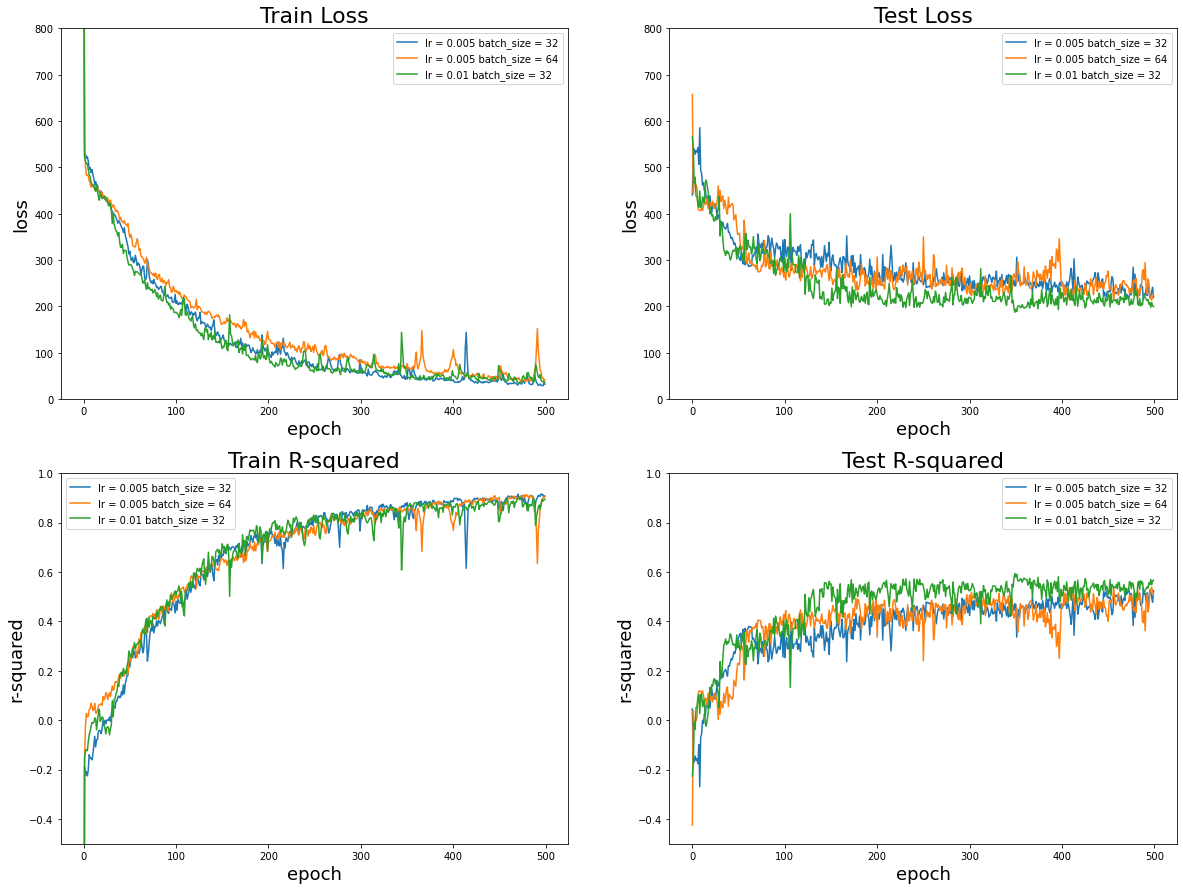

<Figure size 432x288 with 0 Axes>

In [29]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[0],label="lr = 0.005 batch_size = 32")
ax1.plot(train_losses_all[1],label="lr = 0.005 batch_size = 64")
ax1.plot(train_losses_all[2],label="lr = 0.01 batch_size = 32")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 800])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[0],label="lr = 0.005 batch_size = 32")
ax2.plot(test_losses_all[1],label="lr = 0.005 batch_size = 64")
ax2.plot(test_losses_all[2],label="lr = 0.01 batch_size = 32")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 800])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[0],label="lr = 0.005 batch_size = 32")
ax3.plot(train_accs_all[1],label="lr = 0.005 batch_size = 64")
ax3.plot(train_accs_all[2],label="lr = 0.01 batch_size = 32")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-0.5,1])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[0],label="lr = 0.005 batch_size = 32")
ax4.plot(test_accs_all[1],label="lr = 0.005 batch_size = 64")
ax4.plot(test_accs_all[2],label="lr = 0.01 batch_size = 32")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-0.5,1])
plt.show()

### Model 1

{'batch_size': 32, 'epoch': 473, 'train_loss': 36.06971877368528, 'test_loss': 214.88330078125, 'train_acc': 0.8925266985636698, 'test_acc': 0.5343626262370365}


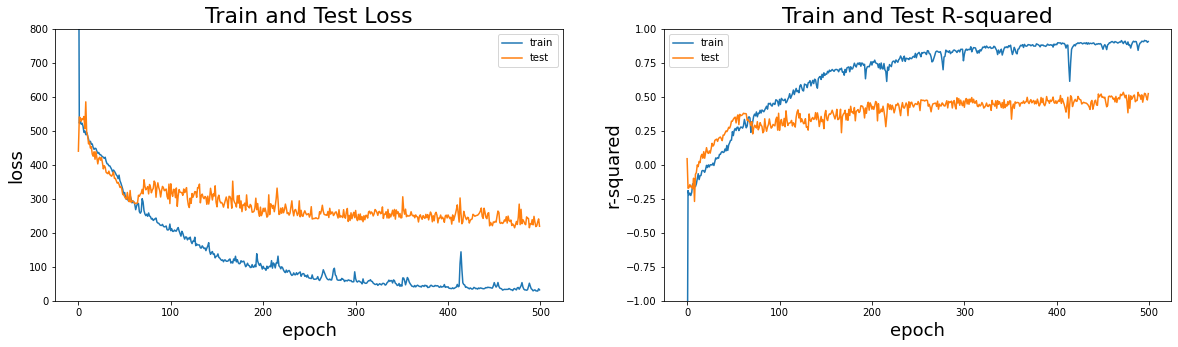

<Figure size 1440x360 with 0 Axes>

In [30]:
print(best_params_all[0])
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=22)
ax1.plot(train_losses_all[0],label="train")
ax1.plot(test_losses_all[0],label="test")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 800])

ax2.set_title("Train and Test R-squared", fontsize=22)
ax2.plot(train_accs_all[0],label="train")
ax2.plot(test_accs_all[0],label="test")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("r-squared", fontsize=18)
ax2.legend()
ax2.set_ylim([-1,1])

plt.show()

### Model 2

{'batch_size': 64, 'epoch': 498, 'train_loss': 45.528376915875604, 'test_loss': 213.35568237304688, 'train_acc': 0.8974277578442964, 'test_acc': 0.5376728596417852}


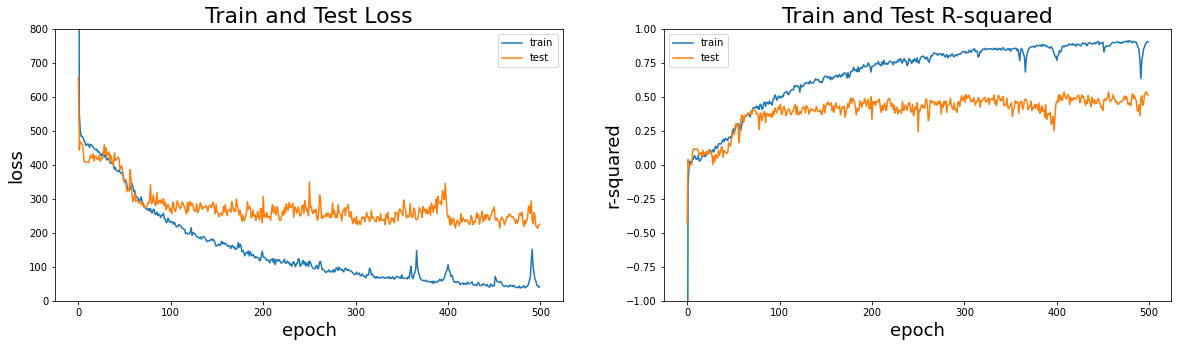

<Figure size 1440x360 with 0 Axes>

In [32]:
print(best_params_all[1])
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=22)
ax1.plot(train_losses_all[1],label="train")
ax1.plot(test_losses_all[1],label="test")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 800])

ax2.set_title("Train and Test R-squared", fontsize=22)
ax2.plot(train_accs_all[1],label="train")
ax2.plot(test_accs_all[1],label="test")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("r-squared", fontsize=18)
ax2.legend()
ax2.set_ylim([-1,1])

plt.show()

### Model 3

{'batch_size': 32, 'epoch': 350, 'train_loss': 60.268531486169614, 'test_loss': 187.26747131347656, 'train_acc': 0.8278879098514952, 'test_acc': 0.5942042213957739}


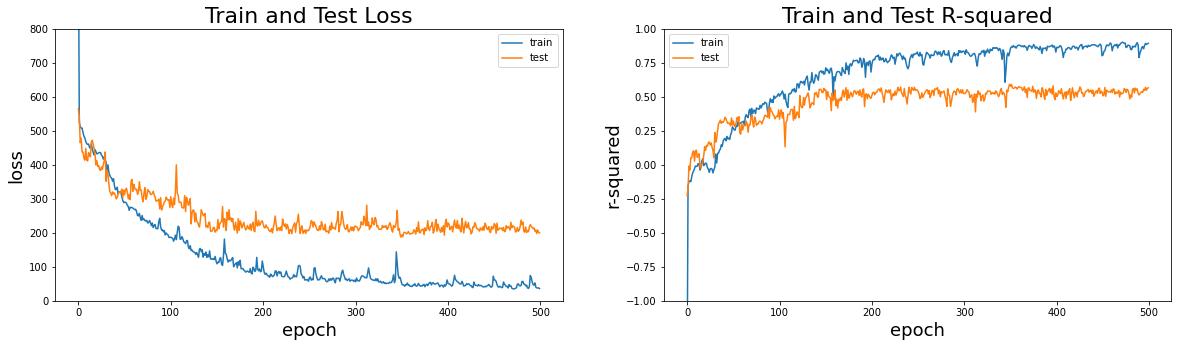

<Figure size 1440x360 with 0 Axes>

In [33]:
print(best_params_all[2])
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=22)
ax1.plot(train_losses_all[2],label="train")
ax1.plot(test_losses_all[2],label="test")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 800])

ax2.set_title("Train and Test R-squared", fontsize=22)
ax2.plot(train_accs_all[2],label="train")
ax2.plot(test_accs_all[2],label="test")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("r-squared", fontsize=18)
ax2.legend()
ax2.set_ylim([-1,1])

plt.show()

## 7. Results

In [36]:
model = GraphNeuralNetwork()
model.load_state_dict(torch.load('../../models/protein_graph_model_2.pt')) # best model
model.eval()

test_loader = GraphDataLoader(test_dataset, batch_size=533, shuffle=False)

with torch.no_grad():
    for data in tqdm(test_loader):
        x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
        graph_predictions = model(x, edge_index, batch)

graph_predictions = np.array(graph_predictions)       

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


In [37]:
print_evaluate(y_test, graph_predictions)

MAE: 8.626373121823425
MSE: 187.2674709183441
RMSE: 13.684570541976978
R2 Square 0.5942042213957739 

